# Одномерная линейная регрессия. Метод градиентного спуска

**Линейная регрессия** (англ. linear regression) — метод восстановления зависимости одной (объясняемой, зависимой) переменной $y$ от другой или нескольких других переменных (факторов, регрессоров, независимых переменных) $x$ с линейной функцией зависимости:

$$y = \theta_0 + \theta_1 \times x_1 + \theta_2 \times x_2 + ... + \theta_m \times x_m$$

Задача заключается в поиске такого набора параметров $\theta$, чтобы получать как можно лучшие результаты в предсказании $y$. В этом задании мы будем рассмотривать метод градиентного спуска для подбора параметров $\theta$ (существуют и другие методы, например, метод наименьших квадратов).

> Описание набора данных взято из курса [Н.Ю.Золотых](http://www.uic.unn.ru/~zny/ml/Others/ml_pop.pdf).

В качестве набора данных мы будем использовать [The Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). База содержит информацию о загородных домах близ Бостона, собранную службой переписи населения США. Данные были собраны в 1970-х годах. Информация агрегирована: территория поделена на участки и дома, стоящие на одном участке, собраны в группы. Нужно оценить среднюю цену дома. Таким образом, объектами являются сами эти группы. Их общее количество — 506. В качестве признаков рассматриваются:

- `CRIM` — уровень преступности на душу населения;
- `ZN` — процент земли, застроенной жилыми домами (только для участков площадью свыше 25000 кв. - футов);
- `INDUS` — процент деловой застройки;
- `CHAS` — 1, если участок граничит с рекой; 0 в противном случае (бинарный признак);
- `NOX` — концентрация оксида азота, деленная на 10^7;
- `RM` — среднее число комнат (по всем домам рассматриваемого участка);
- `AGE` — процент домов, построенных до 1940 г. и занимаемых владельцами;
- `DIS` — взвешенное расстояние до 5 деловых центров Бостона;
- `RAD` — индекс удаленности до радиальных магистралей;
- `TAX` — величина налога в `$10000`;
- `PTRATIO` — количество учащихся, приходящихся на одного учителя (по городу);
- `B = 1000(AA − 0.63)^2`, где `AA` — доля афро-американцев;
- `LSTAT` — процент жителей с низким социальным статусом.
Признак `CHAS` — бинарный, остальные — количественные. Выходом является переменная `MEDV`, равная медианному значению цены строения (по всем домам участка) в `$1000`.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
plt.style.use("fivethirtyeight")

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [4]:
boston.data.shape

(506, 13)

In [5]:
boston.target.shape

(506,)

Выведем пять первых наблюдений:

In [6]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Есть ли в данных пропуски?

In [7]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Простая линейная регрессия (с одной переменной)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAC3UAAAkzCAYAAAAfvIVaAAABGWlDQ1BJQ0MgUHJvZmlsZQAAKJFj%0AYGBSSCwoyGESYGDIzSspCnJ3UoiIjFJgf8jAziDMIM7AyiCTmFxc4BgQ4MMABDAaFXy7xsAIoi/r%0AgszClMcLuFJSi5OB9B8gzk4uKCphYGDMALKVy0sKQOweIFskKRvMXgBiFwEdCGRvAbHTIewTYDUQ%0A9h2wmpAgZyD7A5DNlwRmM4Hs4kuHsAVAbKi9ICDomJKflKoA8r2GoaWlhSaJfiAISlIrSkC0c35B%0AZVFmekaJgiMwpFIVPPOS9XQUjAwMzRkYQOEOUf05EByejGJnEGIIgBCbI8HA4L+UgYHlD0LMpJeB%0AYYEOAwP/VISYmiEDg4A+A8O+OcmlRWVQYxiZjBkYCPEBBSdKS1zCc9QAAAAJcEhZcwAAXEYAAFxG%0AARSUQ0EAAEAASURBVHgB7N0NkFXlmSfwp7toEMNHmFU0kESrENORKmNo168MCoVDQtzCKr+w4tfo%0ADNk4ydoqLIIlYLuu0iYIksyKmsEkG6gEkqnQtW6ESUwbE8gS2Ro7BQJjT5StWBOswEZZOwodl0si%0AIvTte7v7XM659/xuFdX3nvOe933e33MuJuW/j3XvHHyFFwECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAikIlCfyqoWJUCAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAIFDAkLdbgQCBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAikKCDUnSK+pQkQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQICDU7R4gQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIBAigJC3SniW5oAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQJC3e4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIpCgg1J0ivqUJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECAg1O0eIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAQIoCQt0p4luaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECQt3uAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACKQoINSdIr6lCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AINTtHiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECKAkLd%0AKeJbmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAkLd7gEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikKCDUnSK+pQkQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICDU7R4gQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAigJC3SniW5oAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJC3e4BAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIpCgg1J0ivqUJECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAg1O0eIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQIoCQt0p4luaAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECQt3uAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECKQoINSdIr6lCRAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgINTtHiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgECKAkLdKeJbmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAkLd7gECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAikKCDUnSK+pQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQICDU7R4gQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIBAigJC3SniW5oAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQJC3e4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIpCgg1J0ivqUJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECAg1O0eIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQIoC%0AQt0p4luaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECQt3u%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECKQoINSdIr6l%0ACRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgINTtHiBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECKAkLdKeJbmgABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAkLd7gECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikKCDUnSK+pQkQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICDU7R4gQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAigJC3SniW5oAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJC3e4BAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIpCgg1J0ivqUJECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECAg1O0eIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQIoCQt0p4luaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECQt3uAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECKQoINSdIr6lCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgINTtHiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgECKAkLdKeJbmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAkLd7gECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAikKCDUnSK+pQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQICDU7R4gQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBA%0AigJC3SniW5oAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJC%0A3e4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIpCgg1J0i%0AvqUJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAg1O0eIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQIoCQt0p4luaAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECQt3uAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECKQoINSdIr6lCRAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgINTtHiBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECKAkLdKeJbmgABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAkLd7gECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikKCDUnSK+pQkQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICDU7R4gQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIBAigJC3SniW5oAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQJC3e4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIpCgg1J0ivqUJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECAg1O0eIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAQIoCQt0p4luaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECQt3uAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECKQoINSdIr6lCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgINTtHiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgECKAkLdKeJbmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAkLd7gECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikKCDU%0AnSK+pQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQICDU7R4g%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAigJC3SniW5oA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJC3e4BAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIpCgg1J0ivqUJECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAg1O0eIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQIoCQt0p4luaAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECQt3uAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECKQoINSdIr6lCRAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgINTtHiBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgECKAkLdKeJbmgABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAkLd7gECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAikKCDUnSK+pQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQICDU7R4gQIAAgWME9u/ff8wxBwgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAIHKCAh1V8bVrAQIEKhqgfvvvz/WrVtX1XtQPAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqBaBuncOvqqlWHUSIECAQOUFdu3aFY2N%0AjTFmzJjYunVrDBkypPKLWoEAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACORYwJO6c9x8WydAgEBPArNnz46urq7o7OyMJUuW9DTEMQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQCBBAU/qThDTVAQIEKh2gfb29pgyZcrhbQwbNix27Nhx6Kndhw96%0AQ4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECCQq4EndiXKajAABAtUr%0A0N3dHc3Nze/bwL59+2Lu3LnvO+YDAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgkKyAUHeynmYjQIBA1QqsWLEiOjo6jql/9erVsXHjxmOOO0CAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgkI1D3zsFXMlOZhQABAgSqVWDPnj0xfvz4KPzs6dXU%0A1BSbN2+O+nq/C9STj2MECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGAg%0AAtJ5A9FzLQECBGpE4J577ika6C5sccuWLbFy5coa2a1tECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgACBbAl4Une2+qEaAgQIHHeBjo6OmDhxYnR3d/e69ujRo2Pnzp0xcuTI%0AXsc5SYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECPRNwJO6++ZlNAEC%0ABGpOoLm5uWSgu7Dp3bt3x7333ltz+7chAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECCQtoAndafdAesTIEAgRYE1a9bEzJkzy66goaEhCk/2bmxsLPsaAwkQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHeBYS6e/dxlgABAjUr0NXVdSicvWvXrj7t%0Acdq0abF+/fo+XWMwAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUFyg%0AvvgpZwgQIECglgVaW1ujr4HugseGDRti3bp1tUxjbwQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBA4LgKeFL3ceW2GAECBLIhUAhzNzY2RuFp3f15jRs3LrZu3RpDhgzpz+Wu%0AIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBI4Q8KTuIzC8JUCAQF4E%0AZs+e3e9Ad8Gos7MzlixZkhcu+yRAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAhUV8KTuivKanAABAtkTaG9vjylTpgy4sGHDhsWOHTtizJgxA57LBAQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIM8CntSd5+7bOwECuRPo7u6O5ubmRPa9b9++mDt3%0AbiJzmYQAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORZQKg7z923dwIE%0AciewYsWK6OjoSGzfq1evjo0bNyY2n4kIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgEAeBereOfjK48btmQABAnkT2LNnT4wfPz4KP5N8NTU1xebNm6O+3u8JJelqLgIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDIj4AEXn56bacECORc4J577kk80F0g%0A3bJlS6xcuTLnurZPgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6L+BJ%0A3f23cyUBAgSqRqCjoyMmTpwY3d3dFal59OjRsXPnzhg5cmRF5jcpAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBCoZQFP6q7l7tobAQIE/izQ3NxcsUB3YYndu3fHvffe++fV%0A/CBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgT6IuBJ3X3RMpYAAQJV%0AKLBmzZqYOXNmxStvaGiIwhPBGxsbK76WBQgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAQC0JCHXXUjfthQABAkcJdHV1HQpZ79q166gzlfk4bdq0WL9+fWUmNysBAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKhRgfoa3ZdtESBAgMBBgdbW1jhege4C%0A+IYNG2LdunXsCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgT4IeFJ3%0AH7AMJUCAQDUJFMLcjY2NUXha9/F8jRs3LrZu3RpDhgw5nstaiwABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIVK2AJ3VXbesUToAAgd4FZs+efdwD3YWKOjs74+GHH+69OGcJ%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBwwKe1H2YwhsCBAjUjkB7%0Ae3tMmTIltQ0NGzYsduzYEWPGjEmtBgsTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAIFqEfCk7mrplDoJECBQpkB3d3c0NzeXOboyw/bt2xdz586tzORmJUCAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECNSYg1F1jDbUdAgQIrFixIjo6OlKHWL16dWzc%0AuDH1OhRAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSyLlD3zsFX1otU%0AHwECBAiUJ7Bnz54YP358FH5m4dXU1BSbN2+O+nq/Q5SFfqiBAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBLIpIGWXzb6oigABAv0SWLBgQWYC3YUNbNmyJVauXNmvvbiIAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkRcCTuvPSafskQKDmBTo6OmLi%0AxInR3d2dqb2OHj06du7cGSNHjsxUXYohQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQJZEfCk7qx0Qh0ECBAYoEBzc3PmAt2FLe3evTtaWloGuDuXEyBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB2hXwpO7a7a2dESCQI4G1a9fGNddck9kdNzQ0ROFJ%0A4o2NjZmtUWEECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCAtAaHutOSt%0AS4AAgYQEurq6DoWld+3aldCMlZlm2rRpsX79+spMblYCBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIFDFAvVVXLvSCRAgQOCgQGtra2Q90F1o1IYNG6KtrU3PCBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgaMEPKn7KBAfCRAgUE0ChTB3Y2NjFJ7W%0AXQ2vcePGxdatW2PIkCHVUK4aCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIDAcRHwpO7jwmwRAgQIVEZg9uzZVRPoLgh0dnbGww8/XBkMsxIgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAgSoV8KTuKm2csgkQINDe3h5TpkypOohhw4bFjh07YsyYMVVX%0Au4IJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEAlBDypuxKq5iRAgECF%0ABbq7u6O5ubnCq1Rm+n379sXcuXMrM7lZCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIBAFQoIdVdh05RMgACBFStWREdHR9VCrF69OjZu3Fi19SucAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgkKVD3zsFXkhOaiwABAgQqK7Bnz54YP358FH5W86up%0AqSk2b94c9fV+v6ia+6h2AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBi4%0AgCTdwA3NQIAAgeMqsGDBgqoPdBfAtmzZEitXrjyudhYjQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQJZFPCk7ix2RU0ECBAoItDR0RETJ06M7u7uIiOq6/Do0aNj586dMXLk%0AyOoqXLUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCBBAU/qThDTVAQI%0AEKi0QHNzc80EugtWu3fvjpaWlkqzmZ8AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECGRawJO6M90exREgQOA9gbVr18Y111zz3oEaedfQ0BCFJ5A3NjbWyI5sgwABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI9E3Ak7r75mU0AQIEUhHo6uqKOXPmJLZ2%0AU1PTgOdKYo5CEfv374/CE8i9CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIBAXgWEuvPaefsmQKCqBFpbW2PXrl2J1HzeeefFDTfcMOC5Fi1aFCeddNKA5ylMsGHDhmhra0tk%0ALpMQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFqExDqrraOqZcAgdwJ%0AFMLcDz30UCL7rquri+XLl0fh50Bfo0aNivvvv3+g0xy+/s4774y33nrr8GdvCBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAXgSEuvPSafskQKBqBebMmRNdXV2J1H/jjTfG%0A+eefn8hchUlmzZoV55xzTiLzdXZ2xsMPP5zIXCYhQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQLVJCDUXU3dUisBArkTaG9vj7Vr1yay7+HDh8fixYsTmevdSerr6w89+fvd%0AzwP9+cADD8Srr7460GlcT4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0AqkpAqLuq2qVYAgTyJNDd3R3Nzc2JbXnBggVx6qmnJjbfuxNNmjQprr322nc/Dujnvn374q677hrQ%0AHC4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLVJiDUXW0dUy8BArkR%0AeOyxx6KjoyOR/Y4fPz7RgPjRRX35y1+OE0888ejD/fq8atWq2LhxY7+udREBAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKhGAaHuauyamgkQqHmBPXv2ROHJ2km9li5dGoMH%0AD05qumPm+fCHPxzz588/5nh/Drzzzjtx2223xR//+Mf+XO4aAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBQdQJC3VXXMgUTIJAHgUKguxDsTuI1ffr0uOyyy5KYqtc55syZ%0AE6effnqvY8o9uWXLlnjyySfLHW4cAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBCoagGh7qpun+IJEKhFgY6OjnjssccS2VpDQ0MsW7YskblKTXLCCSfEkiVLSg0r+/zdd98d%0Av//978sebyABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKhWAaHuau2c%0AugkQqFmB5ubm6O7uTmR/hbnOPPPMROYqZ5Irrrgipk6dWs7QkmN2794dLS0tJccZQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEql1AqLvaO6h+AgRqSmDt2rXR3t6eyJ5O%0AOeWUWLBgQSJz9WWSRx55JAYNGtSXS4qO/drXvhbbt28vet4JAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBQCwJC3bXQRXsgQKAmBLq6umLOnDmJ7WXx4sUxYsSIxOYrd6IJ%0AEybErbfeWu7wXsft378/Ck8b9yJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABArUsINRdy921NwIEqkrgoYceil27diVS83nnnRc33XRTInP1Z5KWlpY46aST+nPpMdds2LAh%0A2trajjnuAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqBUBoe5a6aR9%0AECBQ1QKFMHdra2sie6irq4vly5dH4Wdar1GjRsX999+f2PJ33nlnvPXWW4nNZyICBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJAlAaHuLHVDLQQI5Fbg3nvvja6urkT2f+ON%0AN8b555+fyFwDmWTWrFlxzjnnDGSKw9d2dnbG448/fvizNwQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAoJYEhLprqZv2QoBAVQr89re/jVWrViVS+/Dhw2Px4sWJzDXQSerr%0A6w89MXyg87x7/dKlS9996ycBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AEKgpAaHummqnzRAgUI0CzzzzTLz99tuJlH7PPffEqaeemshcSUwyadKkuPbaa5OYKn7961/H9u3b%0AE5nLJAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIEsCQt1Z6oZaCBDI%0ApUBHR0ci+x4/fnzcfvvticyV5CQPPfRQnHjiiYlM+atf/SqReUxCgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgSyJCDUnaVuqIUAgVwKvPnmm4nse+nSpTF48OBE5kpyko98%0A5CMxf/78RKZMyiqRYkxCgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQS%0AEhDqTgjSNAQIEOivwCmnnNLfSw9fN3369LjssssOf87amzlz5sTpp58+4LJGjx494DlMQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEsiYg1J21jqiHAIHcCXzyk58c0J4b%0AGhpi2bJlA5qj0hefcMIJsWTJkgEtU1dXF+ecc86A5nAxAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBDIooBQdxa7oiYCBHIlcOmll8ZJJ53U7z03NzfHmWee2e/rj9eFV1xx%0ARUydOrXfy11yySXxoQ99qN/Xu5AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECGRVQKg7q51RFwECuREoPGl7/vz5/drv2LFjY8GCBf26No2LHnnkkRgyZEi/ll64cGG/rnMR%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDIuoBQd9Y7pD4CBHIhcNtt%0At8XFF1/cp73W19fHt7/97RgxYkSfrktz8IQJE6K1tbXPJXzxi1+MKVOm9Pk6FxAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgWoQEOquhi6pkQCBmhcYNGhQtLW1xUUXXVTW%0AXgtPu16zZk1Mnjy5rPFZGtTc3BwtLS1ll3TTTTfF8uXLyx5vIAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQqDYBoe5q65h6CRCoWYGRI0fGs88+G/fdd1988IMfLLrPSy65%0AJH75y1/GlVdeWXRM1k8sXLgwnn766fjYxz5WtNSPfvSj8c1vfjO+8Y1vROGp5F4ECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBWBQbV6sbsiwABAtUoUHhi94IFC+KOO+6I%0Ap556KjZt2hS/+93voqGhIRobG+Oyyy6LCRMmVOPWjqn505/+dLz44ovxs5/9LJ555pl46aWXoq6u%0ALsaOHRuTJk2KadOmRcHDiwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0A1LqAtFytd9j+CBCoSoFhw4bFzJkzD/2pyg2UWXQhxF0IcBf+eBEgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAgbwK1Od14/ZNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgACBLAgIdWehC2ogQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQCC3AkLduW29jRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgkAUBoe4sdEENBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAjkVkCoO7ett3ECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBLIgINSdhS6ogQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgACB3AoIdee29TZOgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgEAWBIS6s9AFNRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgkFsBoe7ctt7GCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBDIgoBQdxa6oAYCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBHIrINSd29bbOAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECWRAQ6s5CF9RAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgEBuBYS6c9t6GydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAIAsCQt1Z6IIaCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBDIrYBQd25bb+MECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECGRBQKg7C11QAwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECuRUQ6s5t622cAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAIEsCAh1Z6ELaiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AILcCQt25bb2NEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQ%0ABQGh7ix0QQ0ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORW%0AQKg7t623cQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEsiAg%0A1J2FLqiBAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHcCgh1%0A57b1Nk6AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQBYEhLqz%0A0AU1ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQWwGh7ty2%0A3sYJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMiCgFB3Frqg%0ABgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEcisg1J3b1ts4%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJZEBDqzkIX1ECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQG4FhLpz23obJ0CA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgCwJC3VnoghoIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMitgFB3bltv4wQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIZEFAqDsLXVADAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQK5FRDqzm3rbZwAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgSwICHVnoQtqIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgtwJC3bltvY0TIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJAFAaHuLHRBDQQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5FZAqDu3rbdxAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSyICDUnYUuqIEAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgdwKCHXntvU2ToAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAFgSEurPQBTUQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBbAaHu3LbexgkQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyIKAUHcWuqAGAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyKyDUndvW2zgBAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAlkQEOrOQhfUQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAbgWEunPbehsnQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCALAkLdWeiCGggQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQyK2AUHduW2/jBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAhkQUCoOwtdUAMBAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABArkVEOrObettnAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgACBLAgIdWehC2ogQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQCC3AkLduW29jRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgkAUBoe4sdEENBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAjkVkCoO7ett3ECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBLIgINSdhS6ogQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgACB3AoIdee29TZOgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgEAWBIS6s9AFNRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgkFsBoe7ctt7GCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBDIgoBQdxa6oAYCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBHIrINSd29bbOAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECWRAQ6s5CF9RAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgEBuBYS6c9t6GydAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAIAsCQt1Z6IIaCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBDIrYBQd25bb+MECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECGRBQKg7C11QAwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECuRUQ6s5t622cAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAIEsCAh1Z6ELaiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AILcCQt25bb2NEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQ%0ABQGh7ix0QQ0ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECORW%0AQKg7t623cQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEsiAg%0A1J2FLqiBAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIHcCgh1%0A57b1Nk6AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQBYEhLqz%0A0AU1ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQWwGh7ty2%0A3sYJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMiCgFB3Frqg%0ABgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEcisg1J3b1ts4%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJZEBDqzkIX1ECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQG4FhLpz23obJ0CA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgCwJC3VnoghoIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMitgFB3bltv4wQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIZEFAqDsLXVADAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQK5FRDqzm3rbZwAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgSwICHVnoQtqIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgtwJC3bltvY0TIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJAFAaHuLHRBDQQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5FZAqDu3rbdxAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSyICDUnYUuqIEAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgdwKCHV+ManTAABAAElEQVTntvU2ToAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAFgSEurPQBTUQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBbAaHu3LbexgkQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyIKAUHcWuqAGAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyKyDUndvW2zgBAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgACBfAm80fnjuO/z18WECXVRV/f+P1Mu/3yseHp7vkDslgABAgQI%0AECBAgAABAgQIEMiMwKDMVKIQAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIVErg1afjgjOm%0Ax7Yi87e3PRGFP/977Yvx+FWNRUY5TIAAAQIECBAgQIAAAQIECBCojIAndVfG1awECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECGRG4NVo/avige4jy3zi6o/H9zq7jjzkPQECBAgQIECAAAECBAgQ%0AIECg4gJC3RUntgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAmkK/KL11phX7BHdPRR29Rn/%0AJV7p4bhDBAgQIECAAAECBAgQIECAAIFKCQh1V0rWvAQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIpC6w9xfL48J5bX2s48H47H0/7uM1hhMgQIAAAQIECBAgQIAAAQIE+i8g1N1/O1cSIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIJBlgTe2xJcubO5XhdsWXRqtz73Wr2tdRIAAAQIECBAgQIAA%0AAQIECBDoq4BQd1/FjCdAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoAoE3ohVXzg3VhetdHL8%0A6OWXY+WMogNi3sV/G8/tLX7eGQIECBAgQIAAAQIECBAgQIBAUgJC3UlJmocAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAgcwIdH5vYVxfPNEd89d9I6aedlrc/PWfxuSiVbfFxX+9IuS6iwI5QYAA%0AAQIECBAgQIAAAQIECCQkINSdEKRpCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDIhsCBV9ri%0AjKuXFS/m9rWxYMZpfzp/8qRY86OW4mPbbo0vPdlR/LwzBAgQIECAAAECBAgQIECAAIEEBAYlMIcp%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkBGBV2Lh6Zf3Usvt8eIDV8XQI0acPPXu+OH8%0A78b0B7cdcfS9t6tv+UR89sI347rGI69677x3BAgQSFLgwGvb40ebXo4YXHzWD4xpiklnn1x8gDME%0ACBAgQIAAAQIECFSdgFB31bVMwQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIFBP48X1/HQ8W%0AO3nw+MoX7otjs9mD4jP3tcX8B88oeu31H787mvYvjUb/hrUXXacIEEhCoGvXhph+eXOvU521eFNs%0AFeru1chJAgQIECBAgAABAtUmUF9tBauXAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECPQm8%0A9lxrXLqovadTh4597tHn4+azh/d8ftC4WPDS2p7PHTq6LK78z21xoJcRThEgQCARgYZeHtH95wXO%0AGNqQyFImIUCAAAECBAgQIEAgOwJC3dnphUoIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEOiv%0AwN7n4m8vnlf86smPxte+0FT8/MEzQ8ddFS9+e1bRMduWXR4Ln36l6HknCBAgQIAAAQIECBAgQIAA%0AAQL9FRDq7q+c6wgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyIhAV7TddXG0Fa1mRvz0H78Q%0Ao4qef+9E43VLYuXn3vt89LsHp//X2O5x3Uez+EyAAAECBAgQIECAAAECBAgMUECoe4CALidAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAIG2BP8TLPy9eQ8uPHo1J5SS6D00xPG5e8XwUz3X/PP5v%0AV/G1nCFAgAABAgQIECBAgAABAgQI9EdgUH8ucg0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgSyIzAqbmjbFMOfejb+5d9+H10HQ9dDh0aMPHV8XDTtP8SkxpP7Vurwpli156WY+YOn4p//z7/F%0AH/4QUchxjxp5apx10bT4xPC+TWc0AQIECBAgQIAAAQIECBAgQKCUgFB3KSHnCRAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBDIvMCocRfEzbddkFydo8bFjJtvixnJzWgmAgQIECBAgAABAgQIECBA%0AgEBRgfqiZ5wgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AgYoLeFJ3xYktQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgeMvsH3VHXHlA/8cZ5wx4vgv%0APoAVX3/99YgRU+Lr31kY44YOYCKXEiBAgAABAgQIECBAgACBKhIQ6q6iZimVAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAEC5Qq8/ca/xrZt7Qf/lHtFlsaNiNcORIzLUklqIUCAAAECBAgQIECA%0AAAECFRSor+DcpiZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB1ASGpbZyEgs3JDGJOQgQ%0AIECAAAECBAgQIECAQJUIeFJ3lTRKmQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyL3CgK/bu%0A3Rddb74Z+/+M0dDQEA1Dh8fJo4YfP55DdeyN1998t4qIhhNHxPBho2L40ONXhpUIECBAgAABAgQI%0AECBAgACB2hEQ6q6dXtoJAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgZoV2LvlyfjLc2+JbUV3%0AOCs27Xk8LhhVdEAiJ7Z/7+74+NUPFp3r9m+/EEuvO7voeScIECBAgAABAgQIECBAgAABAj0JCHX3%0ApOIYAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKZEvjXn/+gl0B3odQn4m++OjO2LpxauboP%0AbI+Hewl0FxZe9kB7LDwY6q5wtrxyezTzYYEDr26JH2z8TQwefPhQz28Gnx5/9ZmzoxIPaX+t48fx%0A7Mv/L44t4e0YPPai+EzTmJ5rGtDRN2LL0z+J37xdYpIPHNz31Mrsu8TKTteggO9biaZm4PtWdo8O%0AbaWSf0cdYXXg1Xj6Bxvj7ZJ/Uf/pmg+MPTemVuTvzSNq8pYAAQIECBAgMAABoe4B4LmUAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAIHjI/DBf3dKyYW2LfpubL97ajRW6N+C7n1hw8HoeInXp8bE%0ACSWGOF0dAoOG7o+/v/ryaC+j3LUv74+rTkv6xnslln7i0ij+XPhZ8dL+x2Ncwst2bf9enDv9ljJ2%0A/bl4cf+qin3fyijAkBoS8H0r1cz0v2+DRp8U264+NxaVKvWI8yuf3xM3N1Xq15zeiFV/NzauL/kP%0A5vcKmrz4p0Ld73F4R4AAAQIECGRQoD6DNSmJAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0A7xMYN+2KOOt9R3r68ESse/61nk4kcOxA/K/vP1ZynvlX/PuKPLG55MI1OGB/2nsadUE8uHhyWVUs%0A+uamssb1ZdDeX3ynl0B3YaYnYtWzSd/vB+LZx75SVpkzHr1ToLssKYPKEvB965UpE9+3QafFwjdf%0AiFm9Vvr+k7ece0U8/eqB9x9M6NMvll/fp0B3zFob//OuSQmtbhoCBAgQIECAQGUEEv6d3coUaVYC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBHIucPKnYs6MiFvaeneYt3JTzL5gRiT+L0K7tsV/%0Af3Bb74vHjJjxqdNKjDmOp4eMjjjrrJg8+uDPqnrtjt3RFB9MvIl9R7jghrvirHntUarz2xZ9Jbbc%0AMSmahvd9jZ6veCN+8NV5PZ864uii5d+PO6Z+IRJbdu+maF1WareFAibHnJlNR1TiLYGBC/i+FTPM%0A0Pdt6Nnx337zw/iXsdPL+q8YxMFR08f+Xbzw+uNxdmJ/UUW88vR9cWFzif9BcCTnWS3x8uNX+aWr%0AI028J0CAAAECBDIpkIH/G5xJF0URIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJApgeHx6Vvn%0AR7Q92HtVT/xDvLBkRoLh2j8tt/eFH8bq3leOmPU3cW6CobVSy5U6f/bNS+Odm0uNcr5XgTGXRMvB%0Ax9Je/USvow6ebIvH2rbH49c1lhpY1vkDr/wkbil5wxWWvTXWd94UV40bWta8pQZ1fHdFWUHNs26/%0AKy4cVWo25wn0UcD3rUewrH3fBo35TPzj84/GX5x7a4/1HnvwifjEjHHxm5/cFWOOPdnnI13bV8Xp%0A0xf14brPxaafLYwM/cpVH2o3lAABAgQIEMibQH3eNmy/BAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAhUp8CYS66Mz5UsvS2+//NXS47q24AD8dx3v1XyksW3TEr+CeElVzWgsgJD49NferSsJZ64%0A/lvxSlkjSw96/jtLSw/684hFqzaWPbbXgQe2x9duLSdJHnH3f7zEvd4rZuVPvt61v/KLHPcVfN96%0AIs/i921U0xfipXUHf9Gq3Ff7vBj7+VXxRrnji43b+4u49uPXFzvbw/GzYu1LX48L/BJKDzYOESBA%0AgAABAlkUEOrOYlfURIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAsQJDm+KW+Wcde/yoIw8+%0Aun7gwbEj5+x6Ib67bNuRR3p4PysuP1dqrAeYqj80/Owr45HJ5WzjwfjOc6+VM7D3MV0d8dV57b2P%0AOeLstkXLY8uAk5IRrz67Jko+kLyw7oxH47ONyTwZ/IhtVP3bjhXXRV1dXSJ/Rnyi9BOQ2+ddGHUT%0AJiSyXl3ddYncQ0k00fftKMUMf9/GzXggNj0y46iCe/n4xPUxo/W5XgaUOvVK3PeXFx787yKU/2r5%0A0T8l9l8yKH9VIwkQIECAAAEC/RcQ6u6/nSsJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEDjO%0AAudd+59Kr9j2rdicQLb23YVe2/hUlHp+8eSWG6Jx0LtX+FlbAifHVXeV90TaeV/5HwP+hYJX/unJ%0Akvfb+33b4rH1ne8/1OdPe+N79y8q66qW264Mv75QFlXlB20r9csm5Zawr9yB/5+9+4GvsrwPhv+z%0ABt+iC218i30a18Y29hnGPYCFtlBFgqBC7YJvherAPwOlwloB97pprIXFrvxZ2wn0WZHSYv8IqxWd%0AZK1ACyNCK7QvTOCzRrbBJn1L2oqVzVSzSixPwIKB5Jz7nJMA55x88/mkue/r+l3/vte5o/bzu6+c%0AgjjPW3vkfH/ehkx/OB6d0n7G6a8b7rk87ly5K31Qp7UtsfLOD8fsLD7yExZvjVkjyzvtTSEBAgQI%0AECBAIF8FJHXn686YFwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECHQRK+4+Jug6lJxY0xCPf%0A62qS69E+W+KpR5KTXW/+2MCjDfwsQoHyUbfGzEzWVT851u5pySQyRcz++FbtghR1qYuXzl4eTamr%0AE2tadj0RMxoSw9oCamPiyL6ZBIohkLOA5+0oXSE8b6Ux7sv7Yl710Tkn/1ww/qJYtCW7N6+2PXhb%0AjE/8ixntxp75aHxl6qB2BS4JECBAgAABAoUhIKm7MPbJLAkQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQOCJQEdcunpBosfQr340DiVEZBDQ3xjeXJsRV1cXV/UoTglQXtEBJZUzK4HN3eI2zv/p0%0Azktt3vlY3JPFSbTHBmqcHSu35fqJb43vL/n8sa7SXUxYdnNUpgtQR6A7BDxvRxQL53krj7vrt0YW%0AB3bHjKHVsTLDF2Ca1s+PwdOS/l5Guw9e9bzY98C46N2uyCUBAgQIECBAoFAEJHUXyk6ZJwECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECRwT619wUVUkWDTNi/d7WpKjE+qYffzfqE6Jq7rg2yhNi%0AVBe+QP/rp0Z1BstonLsotjRnENghpDU2PPTFDqWZFsxYsj5y+sTvfyoeyOgE3Jq4Y1y/TKcjjkCX%0ABDxvBfa8lQ6KLz23Kvmfzcc+FY0x/sLbYkvCuygte1bG+aPuOdYq+WJCbK2/2z+Tk6FEECBAgAAB%0AAnkqIKk7TzfGtAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQSCFQfmncVZOirl3xN1fvaHeX%0Ay2VLbFg2O6FhVdxak5hintCH6oIQKBsW99Vmstf18cWVu7JfUsbJ1Sm6Xjo71u1PUZemeNtji6Ih%0ATf3Rqqq66THEgfRHOfw82QKet4J73koqauIHmxdn8clYEUMvuz/2pHobpXlb3Hbh+Cz6q4pHd38l%0ABvk9lYWZUAIECBAgQCDfBCR159uOmA8BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgkCpXH1%0AtNqEmIj6ad+NpsSoNAEHdsS3V6SpP1xVfUcMKy9JCFJdLALDb63LaCkrJn8j9mQU+UbQzseWZZRc%0A/UaLE68aY/HfbTuxMP19665YMi3pLPrXu6i7ZXj6vtQS6GYBz1s3g56C7sqGTI3dj87MfKTG2XHh%0ALQ9FxwO7m2J+zeBI+kdw+4Hmbfx+jKvs3b7INQECBAgQIECg4AQkdRfclpkwAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQLlw6+LCYkMs2PtrubEqFQBTT+qj6R015mfuDLKUnWgvOgESiqvjmUZ%0AnBIfMTeWr8/i2OzWPfHQtGzSFzunrZ/xcOxKdeptJ02a1n0jlnZS3qGoZllcXeHlhQ4u7QoOvvrr%0AdneFd3kwD6fsecvDTclgSpXjHoiN8zL6Rfl6bysmx2X3r4k3fnW1RP2dV8Y9DRkM9ruQCcu2xt3D%0AyjNvIJIAAQIECBAgkKcC/qsrTzfGtAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQSCPQe0Dc%0AVFsVK+Y2pgmK+Ma3t8ekWcPSxnRe2Rwbvjm386pjpdXx0ZGVx+5c9ASB0ri2dl5Mrr8ncbGzFz0W%0Ad4ycmlHS//6nlseCxB4zCVgQ337qz2PWyEySG/fHyvlJn/HXx5xXe22UZjJ8D4551weujQk1vxfn%0AvP2cLiqcEz9cuiDS/2ZrG6KqJqZc+vYujnW4+cvxy5f/IM7Oy+wRz1s3bPBp6WLY3Q/Hw3v6xI0Z%0AvTUS0Th7TNzyzh2xfFL/2PnQbTF2QeITcGxdVbWr4uuTBh27d0GAAAECBAgQKGSBMw61fRXyAsyd%0AAAECBLIXWLRoUcyYMSP7hu1abNq0KS677LJ2JS4JECBAgAABAgQIECBAgAABAgQIECBAgMCpFWje%0A9mD0GTwtYdCZ8ezBB6JftgmLBzbFiHMvj4Z0vU95NF758rjonS5GXREKNMX9F58fszPIOXz42Vdi%0AYr+kT0hzPDi2T0xLOhY+U8nqxfHShqmJSdgtOx+KswdMzqDXuth3aFZkkiaeQWdCMhBo3fVQ9Loo%0A/d7ULN4Rq6b2z6C3Qg/xvBXuDu5t+115QUa/K4+uccKUCbFiaRZ/taB6YTy/YXr0PdqBnwQIECBA%0AgACBAhd4U4HP3/QJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEOihAqWDxkRt4toXxPe2HkiM%0AOjFg76bH0yd0tzWou2l4Xid0t7Y0x4EDBwryu7m59cQtyaP78phYNzOj+cxZ8lQkraR1z9rMErpr%0AZsbMmqrkcRumRf2eloS41vj+/06fNHy0gymPTpTQfRTjFP1sefU3ySO9ejA5pigiPG+Fu40VMWvL%0A1piQxQKySuiOKbGjXkJ3FrxCCRAgQIAAgQIQkNRdAJtkigQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIdCZQETcsTk4Xm/HIpsTE2uN7b45//OqC44s63E2Jawfn99mgO5bWxLnnnluQ3336XBfb%0Amjug501B5TWTMkpUbFwwPzYnvFPw1PK/zWhddbWz4v7amzOKnfPVp9PH7X8qapemD3m9dkLcfk1l%0AJoFiCJw0Ac/bSaM9+R2XDoqv714VGbyOkuVcqmLVc1+K/qVZNhNOgAABAgQIEMhzAUndeb5BpkeA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQGqBqprrk5PFFjwSO7JJEN7/4/h8feoxD9dU1V4f%0A/Xunjzndtb3OKj/dU+jS+Hl9DnHv/nHHvJoM1tcQn39kZ+q45i2xaHZD6vpjNTNj4uCyKB0yLjI5%0AI7xx7qLYkuYzv+3vFkXjsb5TX1TPmxqD8vxznnr2aopGwPNW0FtZUlkTDZsXdusa5m1siJqKkm7t%0AU2cECBAgQIAAgXwQkNSdD7tgDgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5CRQUj4s7kjM%0ArV0Rj/24KeP+9zz1SGLC6x03fCDj/gTmJtArt2anrNWQm6Ylv1DQNpv6aQ/FntbOp7Vn7bJIeH/g%0ASMOaxZOi8kj+YmVMWpZ8On3bqLGsfk/ng7buiiUzMhm1Ku68aWjnfSglcIoFPG+nGLybh+s7ZHo8%0A+3Amr6QkDzzl4R1x97D8/ksZyasQQYAAAQIECBDoXEBSd+cuSgkQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQKAiBshhza23iTOcu2xAtiVGHAw7E9/92aUJkbYzpX5oQo7roBcpHRd2UTFa5IL76%0AVGcvFTTF8tlJn7XD/VfH9Ov6Hxuo/7VT20qSv5bOWR6djrruG5HJqDGlLq4sdxJusrSIUyLgeTsl%0AzCdzkH4TPxfr6qq7NERV7er40sQ3fh92qTONCRAgQIAAAQJ5KCCpOw83xZQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIEMhcoGLEdZF8WPdXYuuBDPps+lF8sSF9XM3C66IifYjaHiFQEtd8cllG%0AK537VyvbXhc4/qt528qY3Xh8Wad3U+6M4e0PpS0bGnfXVnUaelxh4+xYue3EUffHN+fPPS4s1c3i%0A26+O3qkqu1B+oGlXbFqzMh56cFEsemj56z8fXB5rNu2MpuYUR5p3YTxNi0XA85brTra2tEZr6wnf%0Ah8ty7TDndiUxctbjkdEfG+hsjJqF0TBndHjVpDMcZQQIECBAgECxCEjqLpadtA4CBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECPVWgdEBMm5mU5NoQ31y/J1Fo14bHIynP9qaxAxL7EdAzBHr3vzYW%0AVmew1oYZ8cSu5naBLbF2yYx296kvF39yxAlJjCUx/OZ7UzdoVzNjyfrjTqhv3vlY3NPQLiDVZdW8%0AuG5Qd55G3xI71zwUE0ecEeeef1FcPmZ8TJ42I2ZMvvH1n9NujDGXD4jz+/SKsXcuii1721ulmqTy%0Anibgect2x1ti+cfPiF5n94pevU74biv7UoeXPrLtP5f4spi0/LlI/vsaJ/ZdEzsemx7t3285McI9%0AAQIECBAgQKAYBCR1F8MuWgMBAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBHi1QEpfeeEeiwNK/%0A/W6H05KPb3QgvveVpccXnXhXvTBGVjgn9ESWnntfFuPuq8to+ZOXbHjjZNymp2J2wkftSKeHk6v7%0Ad0yu7t3vw7G4OoNhl86Op5qOxrXGhv897ehN2p8z597QbcmTLXvXx50Xnx0DxkyOFQ1phz1SWb9g%0ARgy9oE98fNH6kNqd7NWzIjxv2e13azT/MrsWpyS6+YXYm/VAu6Np36k/WzzraWpAgAABAgQIEOii%0AgKTuLgJqToAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDA6RcoHTQm+eTPhiWxaW/qpLDWpk2x%0ApCH9WqbcdlWUpQ/Jm9qDr/46b+aS/UReioPZNzotLcqHT4yZmYy84IF4av/rgdtWLk48Ef5w5My6%0AVMnVZXFdRsnkjbF45bbXB92/LmozSSSPKXH7lRWvt+ni/+7f9lCcfcGoWJB0/H0n4yydMSr6THwo%0A4UWMThoqKmoBz1t22/t/ZRd+CqKbYv6QwbEi65EaY8wFt8SWA1k31IAAAQIECBAgUFACXiEvqO0y%0AWQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEOheoiOsW1sTcGfWdVx8pbYyvrm6Mmqn9O41p%0AXPtIQqJtdVx/Vb9O2+Zj4dsu+VjUzRsZb+2dj7NLN6eWaDlrQFR2PKA6XaPTV1dSGZOWTYgFk5PS%0AFBti0WM7Y+TUc2JJ2s/p0aVMiBuvSZ1c3fdIMvnsWHA0PMXP+hlLYs/0L8fLf5dZInnNwtujXzd8%0AZpp3Lo/zBk9OMasMi1dMjnPPK41XHhgX3TClDAcVltcCnre83p70k2uJlXdeGffk8JLH6/2uiKGX%0A/UHs3jErKmU7padWS4AAAQIECBSsgH/NKditM3ECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABNoLDBh7a0RCsmz9F5+Iprak7vL2DY9c74/Vn09Iyp1wW3yob4eGeVtQMWxizBqWt9Mrqon1v/aO%0AqGlL6k73SsHhBdd/8VtR/7Y3RyYHZlfXTY1B6TKZDye3Lm5LJp+W8LltG235yqviwJKk2R2eYXVM%0A/+NBhy+69nVgS9w44Mau9XG09YLxcVv/HbF8UucvYxwN87PnCHjeCnOvtz14W4zP5dj+9sttnB0X%0A3vLOeHH5pIL5qxntp++aAAECBAgQIJAk8KakAPUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAoBIGSimGxuDphpm0JYWt3tXQIat37VOLpobU3jXBacAc5BUcEyobE9NqqZIzGuTF2/OyIDEI/%0AccvQxP76Xz+5LQ074attrNnjx0dGuZQz74zhXX5x4UA8+CdDExPcE2Z9XPWKyQNi+Z6Oz+1xQW56%0AjoDnreD2umn9/Bic+AJKhstqO8H/snvXRGuG4cIIECBAgAABAoUkIKm7kHbLXAkQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQSCNQFmPunJmm/vWqb6za2iGmcfXfdyg7vmBCXHdpx/O9j49x15MF%0Aht9el/nyGxNCa5bF1RUZ/OHtsuFx58yEDPGksdpNZdmkEZHBqO1adLzcs/LumJZwKHhN7eLY/Oy+%0AePHFF+P55/fF1nXLoqZjV8eV3FjzuWg6rsRNTxbwvBXO7rfsWRlXjrqnWyfcOHdM3PLQtm7tU2cE%0ACBAgQIAAgXwQkNSdD7tgDgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIdItAxYjrE5NDG+55%0APPYcd8RnUzzxxRVpx6+aeVMMKE0borKHC5RUXB3LJnQPQt1dH4nMPm4lceXtd3XPoNUL49r+mY2a%0AcsCWbTFr/NKU1YePKF+2+flYNWdqDOlXHmVlZdG3b3kMGjkpVh3cF4vT+bWdsv+5+r1p+lbVkwQ8%0AbwWy283b4rYLx0cW75ZkvLAVkwfH/Wv8TsgYTCABAgQIECBQEAKSugtim0ySAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAIGMBEoHx61JJxfHgvjujgPHumvZsyFmJ2Sc3X7jB7t8gvGxAV0UqUBp%0AXHvHwm5YW21MHNY3435697s2FlZnHJ4ysPa+cVGWsjazil2PL4l0r0cs3PyDmDQkxdpKymPq8uei%0ANs3B4wvGft1p3ZltRQ+I8rzl/yY3xfyawWl/Jxy/hqpY+PDixBez2reZPeaCeGhnc/si1wQIECBA%0AgACBghaQ1F3Q22fyBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgcL1ASw66//fiiTu6WPPaj%0AY6WN3/32sevOL2bGNQO6mu7aec9Ki0ugbMi4qEuTlJzJaicsuyEqMwk8FlMW4+6uPXaX28XMuHV4%0AeW5Nj7Vqim/PSX1Kd1Xtupg+JOk5qohPP7bsWI8dL2bHym1vvJDRsV5JTxLo2c9bvu90S9Tfe2Xc%0A05D5PGtXPxnTJ06Nr21dnHmjtsjJA2piTdNxf34jq/aCCRAgQIAAAQL5JCCpO592w1wIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIEOiyQNmQa2JmQi+Nc78ZO1sOB+2Nx2bUp42unnd9VJakDVFJ%0A4HcC5XFLXdKnLx1WdUy9tn+6gE7rykfdHFM6rcmscMLiSV3+jLfsWpvmxPua+Oqfj8xoMr373RCP%0AplnMkod/FNI3M6LsAUE993nL983d+dCMGDs34U9gtFtEzcLNMWd0xZGSskFT47nV2byo0hBjzv/T%0AcGB3O1CXBAgQIECAQMEKSOou2K0zcQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEOheojBsX%0A1nRedax0RTyxte3E370/iLnHyjq/uG3cgM4rlBLoRKDimkkxoZPyjIpm3hlDkw6z7qyjkn5xe+Jn%0AvrOGh8vaEsmvzz6R/MTedqx64sSiY/fV82oj8ZDuY9G945o/S31ad+OCx6PxyAsZxxoU3UXJWclL%0A2t1yMDmoB0T01Octn7d2/6ZFMWBy6lP7O8x9wsPx8PQhxxVXjJ4TWxdn85t0aQyomR9Nx/XihgAB%0AAgQIECBQeAKSugtvz8yYAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEEgQFjb0qIiHhk9fpY%0As/rJ9HFV8+Kqyt7pY9QSaC/Qu3/ckWOC9bJJIyLXQ+EH/fH0qGo/jwyvq2rvjmG5JJIf139TfO8b%0AqU+8z/bFiN79rojU5/QujYbGthcyivird7+JsWPjxtiY5vsb4/6giAWyWFqPfN6y8DnFoa1766P6%0A8hlZjFobu78+MUo7aTFo6tdjdW11JzUpihruifM/vjyaU1QrJkCAAAECBAgUgoCk7kLYJXMkQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCArgZKKkbGwOn2TxrnjY8y0FWmDJtw1JvqmjVBJoKPA%0AkD+eln2CddsLBB/p31lqY8f+Oy3pOzzmTum0Jm3hvbcOT1ufSWXr3q0xuzFVZG1clvWLERUxpq46%0AVYfx9+v+JWVdcVSURv9hw2JYmu9BlV3OxC8OqrZV9LTnLW83rmVn/OkFYyPlr4IOE6+Jjc/PicqU%0Ab7KUxOg5j8eyrA7svjFq5m/qMJICAgQIECBAgEChCEjqLpSdMk8CBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBLIQKItrPjEzi/jOQqvipqtzOfu4s76U9SiBvqNibpYfv5lzb+jiCwQlMeKTi7Nj%0ArlkcNVknXHcc4vlnt3Qs/F1J1czL4/yUtakr+l06ImVlw5rtUdxndadcuorOBHrY89YZwekv2x+L%0AbhgQS7OYyLIdD8ewxLemymLS15+Luiz+Udxwz+Xx8eW7spiJUAIECBAgQIBA/ghI6s6fvTATAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgS6UaDy6uujpiv91dwRl5anPEK0Kz1rW/QCJXHl7cuy%0AWOWEmHRlRRbxnYeW9r8u5lV3XtdZad1d10UXzgY/1uXP//Unx65PvLj00vdGLk9R2UUDU5923rAp%0A/r3lxJHc91yBnvW85d8+t8aaez8WM+ozn9nMR3fHpEz/MkFJRczasjWyO7D7opi/qSnzCYkkQIAA%0AAQIECOSJgKTuPNkI0yBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoJsFSgfHrVNy73PmrWO6%0AJeE19xloWcgCvftdGwurM1tB9byp0b93ZrHpo/rGDXfWpg85VlsbtyQfk3ssOvVFc+xcnyqbszqu%0AH16ZummampLyoXFzytN5m+I/f92aprWqnibQc563/NvZXcv/NMbMbch4YtXz1sUD47L8vVA6KL7+%0A3OrUL3p0Mvo9l18Zy3d5+6MTGkUECBAgQIBAHgtI6s7jzTE1AgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgS6IlASwyYvzLGDmrh+RNdPTs5xcM2KQqAs/vi+ugxWUhV33jA0g7jMQiquvCEyeZdh%0AwsM3R/d8wv87ml9KNbc+8dY3p6pLKn9znHdhqpiG+MlPJWum0umZ5T3lecuv3T2w5cG46MalmU+q%0AZlk8fvfIzOPbRZZUjI4fbM3mLyA0xo0X3RCb9rfrxCUBAgQIECBAIM8FJHXn+QaZHgECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECuQuUDb4mZubSfMqtMbg0l4baEHhDoO/wicmfvwn3xpUVJW80%0A6upV7/4xeWFNQi818Wc1/RJiMqxu/mmsb0gdezB1VZdqfrH/xS6117j4BHrE85ZH29batCY+OnRa%0AFjOaGc9+a1KUZdHixNCyQZPiudWZvCxztGV9XH7eneHA7qMefhIgQIAAAQL5LiCpO993yPwIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIEMhdoKQyrp+XlODasft5Nw2Nbkyz7TiAkp4h0Pb5u33Z%0AhLRrnXfHh6N32ojsK4eMmxZVaZpV1d0Vg7rrpYW2B+X3Uo1V9aF4V87jlMagMantNv/rC6lGVd5T%0ABXrC85Yve9uyK/78/DHRkPF8qmP1vs9Fv274ZVcxelZsXZz6d0PHKS2Ii25YFA7s7iijhAABAgQI%0AEMg/AUnd+bcnZkSAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQDcKDB53U5a9TYmxQ/tm2UY4%0Agc4F+o27I1K/VlAbNwzpyrm1nY8Z5cOjbkqKurbiuluGpq7szpoL3xI553QnzKNPQr3qninQo5+3%0AU7blB+LBGy6KBVmMt3Dz4zG6vPtelRo09euxurY68xnUz4jqO+ujJfMWIgkQIECAAAECp0VAUvdp%0AYTcoAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKnSqCkcngsrM58tKq6m6Jf9+WeZT6wyOIU%0AKB0S0+uqO13bhGU3R0WnNV0t7B1X3764804mPBzXVJyiD/hLnU9BKYGTJtCTn7eThtq+49ZYf/9H%0AY1p9+7L011Mefjamd/vLKyUxes7jkfCHEI6bWOOCsXHDoi3HlbkhQIAAAQIECOSbgKTufNsR8yFA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoJsF+sY1n0hzbPEJo931sYEnlLgl0DWB4bd8opMO%0AamLqtf06Ke+eotJB18W8qo59Lbzjw9G7Y7ESAkUj4Hk7eVu5Z+Wfx6jZDRkPUFW7Or408WT9niuL%0ASV9/Luo6+T2XaoL1M4bGvfV7UlUrJ0CAAAECBAicdgFJ3ad9C0yAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAIGTLVA57rMZntZdF1f3Kz3Z09F/DxMoqbg6Hp5wwqJnTouhZSeUdett37hh7szj%0Ae6yqi3HdfmLu8UO4I3C6BTxvJ2kHDmyK28YvyLzzmsXRMGd0nNS/C1BSEbO2bI3MX9uKmDv2tth0%0AIPNliCRAgAABAgQInEqBk/rvTqdyIcYiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAaoG+%0AUX1zW1Ztw4rUIW01NYuvifK0ESoJ5CJQGjV3PxwTfv1knPP2c+LlX0Zc/8nhJzfZsW2aFVfeHnUT%0Ano+fnXNOxMsvxx9OvsXnO5ft06bABDxvJ2XDyobFhkOHTkrXXeq0dFB8uW1eX+5SJxoTIECAAAEC%0ABPJDQFJ3fuyDWRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcDIFWvfEQ5PTJ3RHVMWtYwac%0AzFnouwcLlPafGMtXTTy1Ar37xazly0/tmO1H69P+xjWBUyfQI5+3U8drJAIECBAgQIAAgZMk8KaT%0A1K9uCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkDcCBzavjAVJs6m+I4ZVOBcriUk9gYwF%0Adv9XNGccnF3gS9mFiyZAgAABAgQIECBAgEDeC0jqzvstMkECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBLom0BJPPnhPYhdTPnFllCVGCSBA4DiB1ohfH1fQ7qbx6fhpzlndzbFtderT9Udf8q52%0AA7kkQIAAAQIECBAgQIBA4QtI6i78PbQCAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTSCex/%0AKuakzg39XcvquGlkZbpe1BEg0JlA6btiZHVnFa+X9Upd1aWa3mc7Vb9LgBoTIECAAAECBAgQIJB3%0AApK6825LTIgAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAge4U2PnYN6MxqcMpn4jBjulOUlJP%0AoBOBN8dZfTopPlL0Uvznf6eqSypvjeaXUsXUxCXv8cCm0lFOgAABAgQIECBAgEBhCkjqLsx9M2sC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBDIS2BvfmpZ4THfU3TQ8emfUnyACBI4XKI33j6w5%0AvujYXUN8Z/PeY3dZXTT9KJY0pGrx9njLm1PVKSdAgAABAgQIECBAgEBhCkjqLsx9M2sCBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBDIQOLBlVcxNjJsS1w7umxglgACBzgXeWv6ezivaSr+3ZXfK%0AunQV+/f8OPUJ+zXvi3d7CyMdnzoCBAgQIECAAAECBApQQFJ3AW6aKRMgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgkIlAS6xfNiMxsKr2+ugvQTTRSQCBVAIVlwxOVRWNq34YTSlrU1fs2rAhZWXN%0AyPdHacpaFQQIECBAgAABAgQIEChMAUndhblvZk2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AQJLA/qfjb5cmBUXcccMHkoNEECCQUqCkYkjMTFXb+Ehs3duaqjZF+d5YPbshRV3EmOr/mbJOBQEC%0ABAgQIECAAAECBApVQFJ3oe6ceRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkFZg53eWRUPa%0AiMOVtTGmvzN/E5kEEEgnUFIZH6mtShHRGF9d3ZiirvPi5p2rY27nVW2lM+PKKs9sSh4VBAgQIECA%0AAAECBAgUrICk7oLdOhMnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCC1wN741uQVqat/V1Oz%0A8LqoSIwSQIBAksD7am5PGVI/bX7sbElZfUJFc6ycP+2Esjduq+o+EpUlb9y7IkCAAAECBAgQIECA%0AQLEISOoulp20DgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEjgk0b1uV5qTfo2FVcevYAUdv%0A/CRAoAsCZYOviikp26+ITy/dkrK2fcWBLQ9Fuvcx7rj2A+3DXRMgQIAAAQIECBAgQKBoBCR1F81W%0AWggBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAq8LtMaGJTOSMapvj2EVjvxNhhJBIAOBkn4x%0AeWFNysD6GUNj+a7mlPVHKlp2xt1D0zy7VfPiuv6l6ftQS4AAAQIECBAgQIAAgQIVkNRdoBtn2gQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIpBDYvzkeWJqirl3xlE9cE2Xt7l0SINA1gSF/PD2q%0A0nRx40U1UZ8qsfvAzrj/wwMi3aNb+4Wbom+a/lURIECAAAECBAgQIECgkAUkdRfy7pk7AQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIdBPbvejoaOpSeWFAdN42sPLHQPQECXRHoOzK+mua07mh7%0AMsde1Ccm3r88du5tiv3798f+pj2x/qH74+JzB8TshjSDVy+MPx9dniZAFQECBAgQIECAAAECBApb%0AwN8SK+z9M3sCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBE4QeOXAL04o6XhbXXdfDHVMd0cY%0AJQS6KDBk+qKoW1IfsxtTd7Ri9o2xYnbq+o411bF6+Z86Wb8jjBICBAgQIECAAAECBIpIQFJ3EW2m%0ApRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgEFFRc39sXT041v34J/GLAy0RL78cL7fBnPO2%0A348/eG9VDBw6PIb064uKAIGTIlAR9z65Kh65YGykyevOauTa1V+L0eXSG7JCE0yAAAECBAgQIECA%0AQMEJ+K+egtsyEyZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIL1AaQwaPbHtO32UWgIETo5A%0ASUVNNGxcGOddPqPLA9Qs3BxzRld0uR8dECBAgAABAgQIECBAIN8F3pTvEzQ/AgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAoLAE+g6bHvvWLezSpGsWbozHpg/pUh8aEyBAgAABAgQIECBA%0AoFAEJHUXyk6ZJwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKCCB8pHT46Xd62JmdbaT%0Aro7F63bHqunDwp8fz9ZOPIE3BH7zxqUrAgQIECBAgACBAhCQ1F0Am2SKBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECgEAVKK0fGAxsOxu6Nj0bthOr0S6iaEAsf3RgvHtwQU0dWpo9VS4BA%0AgkBJlL49dchZqavUECBAgAABAgQInCaBMw61fZ2msQ1LgAABAqdJYNGiRTFjxowujb5p06a47LLL%0AutSHxgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAj1LoLV5f+z9j59G0/7/jFd/t/Rz3to33vGu%0Ad0dF39KehWG1BAgQIECAAAECBAgQaCfgLxW1w3BJgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQInDyBktK+Udm/7fvkDaFnAgQIECBAgAABAgQIFKTAmwpy1iZNgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBIhGQ1F0kG2kZBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgUpoCk7sLcN7MmQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBIBCR1F8lGWgYBAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAoUpIKm7MPfNrAkQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKBIBSd1FspGWQYAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAYQpI6i7MfTNrAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSKREBSd5FspGUQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIFCYApK6C3PfzJoAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgSIRkNRdJBtpGQQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIFKaApO7C3DezJkCAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgSAQkdRfJRloGAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKFKSCpuzD3zawJECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECgSAUndRbKRlkGAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAQGEKSOouzH0zawIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEikRAUneRbKRlECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBQmAKSugtz38yaAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAIEiEZDUXSQbaRkECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBSmgKTuwtw3syZAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAoEgEJHUXyUZaBgECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAEChSkgqbsw982sCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAoEgFJ3UWykZZBgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgEBhCkjqLsx9M2sCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBIpEQFJ3kWykZRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgUJgCkroLc9/MmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgACBIhGQ1F0kG2kZBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgUpoCk7sLcN7MmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQKBIBCR1F8lGWgYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAoUpIKm7MPfNrAkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQKBIBSd1FspGWQYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIBAYQpI6i7MfTNrAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgSKREBSd5FspGUQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIFCYApK6C3PfzJoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAgSIRkNRdJBtpGQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIFKaApO7C3DezJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECgSAQkdRfJRloGAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQKFKSCpuzD3JNWraQAAQABJREFUzawJECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECgSAUndRbKRlkGAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQGEKSOouzH0zawIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIEikRAUneRbKRlECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBQmAKSugtz38yaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAIEiEZDUXSQbaRkECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBSmgKTuwtw3syZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAoEgEJHUXyUZaBgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAEChSkgqbsw982sCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAoEgFJ3UWykZZBgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgEBhCkjqLsx9M2sCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBIpEQFJ3kWykZRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgUJgCkroLc9/MmgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgACBIhGQ1F0kG2kZBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgUpoCk7sLcN7MmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQKBIBCR1F8lGWgYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAoUpIKm7MPfNrAkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQKBIBSd1FspGWQYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIBAYQpI6i7MfTNrAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgSKREBSd5FspGUQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIFCYApK6C3PfzJoAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAgSIRkNRdJBtpGQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIFKaApO7C3DezJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECgSAQkdRfJRloGAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQKFKSCpuzD3zawJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECgSAUndRbKRlkGAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAQGEKSOouzH0zawIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIEikRAUneRbKRlECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBQmAKSugtz38yaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAIEiEZDUXSQbaRkECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBSmQElhTtusCRBoL9Da2hItzb+O5pdeiZda/itefvmVOPjKwTj46qvxalvgwYMHo1evXnHW%0AWWdFr7PPjrPPOSfe0rtP9OlTGm8uLY3efhO053RNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIEDilAlI5Tym3wQh0UaAteXv/803x0z3/Fjuf2RE7/3lnbP/h9mhobOxS%0Ax1XV1TFw4ND4YP+L4+KL/ldcWPnOOL9vWfgF0SVWjQkQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECGQnI2cyISRCB0yXQlsTdlsC9bcvTsfGp1TF3af1JmUhjQ0Mc/l5x%0AXO9VMWHm9fHhq0fEkEEDo7Jv6XG1bggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBLpHQFJ39zjqhUD3CbQ2x54dP47vf/eR+OLspdG1M7i7Mq3GWLFg9pHvI71U1UTd%0AHTfFNVcOjwGVfZ3i3RVabQkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAEC7QTe1O7aJQECp02gte1E7i3x0P0fj4t79YkLB4+Kaac1obsTiMb6mD1tfAy+8LzodfHYmP/Q%0Amtizv6WTQEUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLZCEjq%0AzkZLLIFuFmhtbor1yxfF2It7xXkXDo3J+ZbInWq9bQne90weExeed3aM+Pj9sWbb3mhNFaucAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgrYCk7rQ8KgmcHIHmvdva%0ATuWeGL36nB+jbpwR9Y0nZ5xT0WvD0tkxZvAFbad3T4yH1u8MZ3efCnVjECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAsUkIKm7mHbTWvJe4MCeTTH/4yOizwWD207lXpH3%0A881qgo0rYvKoAXH2GWPjwTWSu7OyE0yAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAj0aAFJ3T16+y3+VAm0NG2LRW3J3OdeeHncs7ThVA17msapj2lj2pK7207uXrll72ma%0Ag2EJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAoUjIKm7cPbKTAtR%0AoHlvrLx/Ypx9/uCYUfTJ3CdsUNvJ3eOHXhAXT5wf2/a3nlDplgABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBA4KiApO6jEn4S6GaBXWsWxcV9Lojxs1d0c8+F1V3jinti%0A8Hm94t7lW6KlsKZutgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB%0AUyJQckpGMQiBniTQvCce/H9rYtrSxpO+6qqq6rhwYHm8p6Ii/sdb/ke85bz/O0pLS6P0986Kc3r1%0AirPOOuvYHF599dU4ePDlePXXr0Zzc3P8qvn5+M9f/CJ+tvf5+Lem7dHQcHLnO/fGoTH3K7Wx8Wuf%0AjmEVvY/NywUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoKcLSOru%0A6Z8A6+9WgaYty2Pi0BujoVt7rYoJU66K/u/rHxe998K44IJ3xTvOPTd+ry15u3e3PsGt0dKW7P3r%0A5hfj5z9viuf+Y3c827gzdm7bHivqu2lFDXPj8gvmRu3Dm+PTE4eE1O5u/aDojAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEChQgW5NCS1QA9Mm0A0CzbFm0dQYM2NFl/uq%0ArpkSo8cMjw+9f1BUvuf8KC8r7XKfmXVQEr1Ly4589y2vjP6DhkXN7xoub22JA883xb88+5PYvnVL%0ArF6zKuq7cLL3kVO7v10XO752b/Qv82sos/0RRYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBSrwBmH2r6KdXHWReCUCBzYGfd/dEDMbsh1tOqYOe/6+Mio6nhf1YVR1r3H%0Ab+c6qcR2LQeaovGft8a61d+Jb8xdGo2JLToLqIrF656MqSMrOqtUdhIFFi1aFDNmzOjSCJs2bYrL%0ALrusS31oTIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECES8CQIBArkL%0AHNi5Mkacm0tCd3XULnw0tu5+Pg4e2hAP3D01Rg7qVzAJ3YfFepeVx6BhNXH3nC/HTw6+Es/t2BiL%0A66ZEVVacjTFt1AUx9v76OJBVO8EECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAgeIRkNRdPHtpJadYYNfKe+PcAeOjIYtxJ9QujI07njuSyD1n+rgYVNk3SrJon7ehJb2j%0Aov+wmDrrcIL3S/HsxlVRN6E64+nWzx4b5158Z2xpas24jUACBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQLEISOoulp20jlMo0Bxr7h8bF42fm+GYNbHw0Y2x76VDsXzO%0A9BjWv6I4ErlTrb6kNPq1neA9a/mGeGnfjljWdnp3Rl+NC2Lo+QPiwU17MwoXRIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoFgFJ3cWyk9ZxagRa98aiiX1izOz65PGq%0Ap8TDG5+NVw6tiunjhkV5aXKTYosoLe8fk9pO7z744u54dF4myd2NMe3yC2LiovXRUmwY1kOAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECggAUOHToUGzZsKOAVmDoBAgQIECBAgAABAgTyW0BSd37v%0Aj9nlk8CBbXFnrwtixoqESVVNiUc3746DG74cE4f1i94J4T2huqSsMsbd3Zbc/VJmyd0rZoyKsyc+%0AGPt7Ao41EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECgAgc9//vNxxRVXxNSpU+M3v/lNAczY%0AFAkQIECAAAECBAgQIFBYApK6C2u/zPY0CjT/+w9jQdrxa2Lx6mfj4E++HOOGVEZJ2tieWVlS+rvk%0A7ud3xOKZNekRVjwSe5rTh6glQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQODkCzz99NNx7733%0AHhloyZIlMWTIkNi9e/fJH9gIBAgQIECAAAECBAgQ6EECkrp70GZbahcFep2VsoOZi1fH8wdXxdTR%0A/SRzp1R6o6Kkb/+Y+sCqePHZdTGz+o3y46/6RK/jC9wRIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIHCKBX71q1/F9ddfH62trcdG3r59e7zvfe+Lb3/728fKXBAgQIAAAQIECBAgQIBA1wQkdXfN%0AT+ueLlBTF1v3vRIPTB0dfR3NnfWnoazfyHhgw8HYsWphVGXdWgMCBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBE6mwKFDh+Lmm2+On/3sZx2GaW5uPpLsfdddd8VvfvObDvUKCBAgQIAAAQIECBAg%0AQCA7AUnd2XmJJnBMYN6qHXFw1awYVN77WJmLXARKon/N9PjJK8/FstTHdufSsTYECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECHRBYP78+fHkk0+m7eELX/hCfOhDH4p///d/TxunkgABAgQIECBA%0AgAABAgTSC0jqTu+jlsAbAgdfff26Zl7sePFg3F3TPxzO/QZPl696V8SkBzbEvs0PR82Rzl6Kg13u%0AVAcECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECOQi8IMf/CA+/elPZ9T0n/7pn+KSSy6Jxx57%0ALKN4QQQIECBAgAABAgQIECDQUUBSd0cTJQQ6FSh9z6Wx7OGN8cqqu6N/mXTuTpG6obB8yMRY1XZq%0A98OLPxHvcgh6N4jqggABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEB2Ai+88ELccMMN0dramnHD%0Al156KcaNGxd33313vPrq7w7Myri1QAIECBAgQIAAAQIECBCQ1O0zQCBTgbJBMWnisJBnnClYF+La%0ATu2eOHVclMud7wKipgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyE5gyZUrs27cvp8Z//dd/%0AHZdeemns2bMnp/YaESBAgAABAgQIECBAoKcKSOruqTtv3QQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAoBOB++67L9797nd3UpNZ0datW2PQoEHx93//95k1EEWAAAECBAgQIECAAAECIanb%0Ah4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4JnA4IfuZZ56Jj370o8fKsr34r//6%0AryPta2tr4+DBg9k2F0+AAAECBAgQIECAAIEeJyCpu8dtuQX3CIHW1mhpaY7mAwfiwO++W1p7xMot%0AkgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBbhB4y1veEo899ljMmzcvevXqlXOPh9tfdtll%0AsXfv3pz70JAAAQIECBAgQIAAAQI9QaCkJyzSGgkUs0Br8/7Y+6+74pmdz8Q/bf5RbP637dHQ0Nhh%0AyTWLd8Sqqf07lB8taD2wJ7b+y/4j/4dM5y/Kt7093+utMWBQv+h9tJGfBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgUtcDdd98dV1xxRXzsYx+L5557Lqe1/vjHP45LLrkkvva1r0VNTU1OfWhE%0AgAABAgQIECBAgACBYheQ1F3sO2x9RSnQ2twUm9fWx+PffCQW1DdktsZX0/9Js5LWpqgdenkk9Tbl%0A0d3x5XGVmY0pigABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBghd4//vfH88880z8yZ/8Saxa%0AtSqn9Rz+C8Njx46NT33qUzF79uwunf6d0wQ0IkCAAAECBAgQIECAQJ4LvCnP52d6BAi0F2jeEyvn%0Afzx69Tk/Lh8/LfOE7vZ9pLruOywe3zwvVe2x8qXj/yy2NB+7dUGAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAQA8QeOtb3xpPPPFEfPazn+1SQvbh9pdffnn89Kc/7QFqlkiAAAECBAgQIECAAIHM%0ABSR1Z24lksBpFGiNbSvvjzP6XBjj71l60uZRNmR6PDolqfv6qP3SpqQg9QQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIFKHAvffeG5s2bYp3vetdOa9uy5Ytcckll8R3vvOdnPvQkAABAgQIECBA%0AgAABAsUmIKm72HbUeopPoHlXzB/bKwaPn30K1tY7rv3LVVGVMFLDPZ+PLQcSglQTIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIFCUAh/84Adj+/bt8Ud/9Ec5r+/FF1880n7WrFnR2tqacz8aEiBA%0AgAABAgQIECBAoFgEJHUXy05aR1EKNO+qjxF9Lop76k/d8krKPxxfmJmU1l0fX3xi56mblJEIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIEMgrgbKysqivr4/PfOYzUVJSkvPcDrcfPnx4/OxnP8u5%0ADw0JECBAgAABAgQIECBQDAKSuothF62hKAVadq2MIReNjYZTvrqSGPXJusRRV0z+VuxNjBJAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgEAxC9x3332xcePGeOc735nzMp9++ukYOHBgPPnkkzn3%0AoSEBAgQIECBAgAABAgQKXUBSd6HvoPkXp8CBLXHDReOj8TStrqTy6lhWkzT43Fi1rTkpSD0BAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAkUuMHTo0Ni+fXtcc801Oa/0V7/6VXzkIx+Jurq6eO21%0A13LuR0MCBAgQIECAAAECBAgUqoCk7kLdOfMuYoED8eCfDI3607rC0vjI9OTTupc89sPTOkuDEyBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQHwLnnntu/MM//EP85V/+ZZSUlOQ0qUOHDh1pX11d%0AHfv27cupD40IECBAgAABAgQIECBQqAKSugt158y7aAX21t8f07LM6K6aMDOWrVoXO3bvi2fXzesW%0Am74fujYmJPTUOHdt7GpNCFJNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECPEDjjjDNi9uzZ%0A0dDQEL//+7+f85p/8IMfxMCBA2Pt2rU596EhAQIECBAgQIAAAQIECk1AUneh7Zj5FrfAgS0xfeyC%0AjNdYPXNx7Nj3Uvxk+QMxqWZk9K8sj4q+b8m4fdrA3u+N/2dK2oi2yu/FP+9rSQpST4AAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIBADxK49NJL45lnnonRo0fnvOoXXnghxowZE5/5zGfitddey7kf%0ADQkQIECAAAECBAgQIFAoApK6C2WnzLNHCGz5cm1kdkh3TTy69fnY8MDU6F9eepxN9x2c3Tv+cHhS%0AVndj7Pnpr48b3w0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTe9ra3xZNPPhmzZs2KM888%0AMyeQQ4cOHWl/xRVXRFNTU059aESAAAECBAgQIECAAIFCEZDUXSg7ZZ49QGBv1N/TkLzO6rrY/cqq%0AGDeob3JsFyPO/1/vS+zh6Wd+mhgjgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBnidwxhln%0ARF1dXWzYsCHKy8tzBti4cWMMHDgwvv/97+fch4YECBAgQIAAAQIECBDIdwFJ3fm+Q+bXYwRa9/5/%0AMTdxtRNic/2sqOydGNgtAaXvHhg1CT3V/2hXtCTEqCZAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAoOcKDBs2LLZv3x5XXXVVzgj79++Pq6++OubMmRO//e1vc+5HQwIECBAgQIAAAQIECOSrgKTu%0AfN0Z8+pxAvt2/FPimmc+en8MKU0M68aAXsl9NTXHfydHiSBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAoAcL9O3bN9asWROf+tSn4swzz8xJ4tChQ0fajxw5Mn7xi1/k1IdGBAgQIECAAAECBAgQ%0AyFcBSd35ujPm1eMEfrp9c8KaZ8Ynr61MiOnm6t5vjYsz6LIkgxghBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAj0bIEzzjgj/uqv/irWr18f73jHO3LGaGhoiIEDBx7pJ+dONCRAgAABAgQIECBA%0AgECeCUjqzrMNMZ2eKtAcP9nWkHbx1fM+GpWnOnu65Lx4b03aaakkQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIBAVgLDhw+P7du3x6hRo7Jq1z74l7/8ZVx11VUxb968+O1vf9u+yjUBAgQIECBA%0AgAABAgQKUkBSd0Fum0kXn8CL8fzu9KsaPbxf+gC1BAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQKBCB8847L9auXRu1tbXxpjfllrpwOJn7cPsrr7wyDid5+yJAgAABAgQIECBAgEAhC+T2X0aF%0AvGJzJ5CPAs0vxLbG9BPr3etUH9N9eD7N8f8nJJunn7VaAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIdC5wOJl7zpw5sW7dunj729/eeVAGpf/4j/8YAwcOjA0bNmQQLYQAAQIECBAgQIAAAQL5%0AKSCpOz/3xax6mkBbvvbvpV1zTXzgPWVpI05KZcvPE5PNT8q4OiVAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAoMcIjBgxInbs2BFXXHFFzmv+xS9+EaNGjYrPfe5zcfgEb18ECBAgQIAAAQIECBAo%0ANAFJ3YW2Y+bbQwXq49lfNp/ytbc2/UfUn/JRDUiAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AQE8TOHxS9/e///34i7/4izh8gncuX4eTuQ+3v/rqq+P555/PpQttCBAgQIAAAQIECBAgcNoEcvsv%0AodM2XQMT6LkCv3n51K99309+mNGgrRlFCSJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBq%0AgcPJ3PPnz4+1a9fGeeedlzowoWbdunUxcODAeOqppxIiVRMgQIAAAQIECBAgQCB/BCR1589emElP%0AFuj9P2NYTXqATbv2pQ/o9trm+MdHFiT3+t63xZuTo0QQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIEAgI4FRo0bF9u3bY/jw4RnFdxb085//PEaOHBlf+MIX4tChQ52FKCNAgAABAgQIECBAgEBe%0ACUjqzqvtMJmeK9B21vVL6Ve/4snN0Zw+pFtrW/esjckrkrus+cN3R+/kMBEECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBDIWOAd73hHrF+/Pu66664444wzMm7XPvC111470n7MmDHxwgsvtK9y%0ATYAAAQIECBAgQIAAgbwTkNSdd1tiQj1ToCzeO6I6/dJXTI61e9uSv0/JV0s8MX98RiMNuuRdGcUJ%0AIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQDYCZ555Znzuc5+LNWvWRN++fbNpelzs2rVr%0AY+DAgbFp06bjyt0QIECAAAECBAgQIEAgnwQkdefTbphLjxboP2J04vrHf/aJOBVp3Qe2LI3xSxOn%0A0xZQFR+oLMskUAwBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyErjqqqti+/btMWzYsJza%0AH260b9++GDFiRCxYsCAOHTqUcz8aEiBAgAABAgQIECBA4GQJSOo+WbL6JZClQN8//FBUJ7VZOj6+%0AsGl/UlTX6g9siU8OnZFZH9W3xwfLSzKLFUWAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEc%0ABcrLy2PDhg1x5513xhlnnJFTL6+99tqR9tdcc0386le/yqkPjQgQIECAAAECBAgQIHCyBCR1nyxZ%0A/RLIVqBsYNxck9zonsvPiwe3NCUH5hKxf0t8/NyhsSLDthNuuyqc050hljACBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBLokcOaZZ8bf/M3fxJNPPhlve9vbcu5r9erVMXDgwHj66adz7kNDAgQI%0AECBAgAABAgQIdLeApO7uFtUfgZwFSuMjd9Vl1Hra0PPj4w9uipaMojMLOrBzZYw4b2gszSy8Lao6%0Apn64X8bRAgkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINAdAqNHj47t27fHpZdemnN3P/vZ%0Az2L48OGxaNGiOHToUM79aEiAAAECBAgQIECAAIHuEpDU3V2S+iHQDQJ9h02LeVWZdbR02uVx9oh7%0AY/2eA5k1SBXVvDfq50+McweMj4ZUMZ2UV9XeF8Mc092JjCICBAgQIECAAAEC/4e9u4HPuiwXB34h%0AGzIVdBrWH0s0yBBKNoYICDgDj+ipoSlqIBYYvpQJ1jGVOqGeFC1LRI0UwyMH8I08gZkcg5ggorxO%0AUsQUX7LwHPGAOWQI8/BnK1/QsT377e15tu/jZ+157vu+rvu6vzf2gY8XvxEgQIAAAQIECBAgQIAA%0AAQIECBBoaIFDDjkkiouLY+zYsdGqVatE25WXl1fGf+UrX4lNmzYlyiGIAAECBAgQIECAAAEC9SWg%0Aqbu+JOUhUC8CHeJb06eknql4YgzucmAcf97VMW/l+ijdFZnVZu8q4/drt+8H42Wl8cqaxfHLq8+L%0AVu0Pi6GXz/pgLqV3w2P6FYNSWmkRAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEGkIgKysr%0AJk2aFL/97W/joIMOSrzFQw89FHl5efHEE08kziGQAAECBAgQIECAAAECdRXQ1F1XQfEE6lmgXcE3%0AY864FB/X/Y+9i6dOiJN6dYn2rbrHPkeOrrKiWaNPi+snXx0jhh4frfZpH4f1GBgXTpha5dqaBqes%0AuCUK2tW0yjwBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQaXuDkk0+O1atXR9++fRNv9uqr%0Ar8aAAQPi1ltvTZxDIAECBAgQIECAAAECBOoioKm7LnpiCTSIQFYUXXt3DE+Ue201UWvj8rETYtbc%0A4mrW1Dw1ZsazcUFBbs0LrSBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEAjCXzmM5+JRYsW%0AxUUXXZR4x/Ly8sr4oUOHxubNmxPnEUiAAAECBAgQIECAAIEkApq6k6iJIdDQAjlHxR3PzmjoXWqd%0Av+i6RXH7iK61jhNAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBhhbIysqKm2++OebOnRu5%0AuckfVFURn5+fH8uWLWvokuUnQIAAAQIECBAgQIDA+wKaut+n8IZAegnkdB0Rr6+YljZFFV71cPz6%0AsgFpU49CCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUJXAV77ylSgpKYljjjmmqumUxl55%0A5ZXo379/TJkyJaX1FhEgQIAAAQIECBAgQKCuApq66yoonkADCnQoGBVbX54fwxtwj1RSD5+yKH7/%0AoyGRlcpiawgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINDEAoceemgsXrw4vvWtbyWuZMeO%0AHZXxp556arz55puJ8wgkQIAAAQIECBAgQIBAKgKaulNRsoZAEwrkdBoUM7e+HFPGdGuCKrrFlPkv%0Ax8wLBmjobgJ9WxIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkFwgOzs7br311vjNb34TBxxw%0AQOJEFfH5+fmxfPnyxDkEEiBAgAABAgQIECBAoCYBTd01CZknkA4COZ3igtufiRfmT4nCRqqn6Ipp%0A8cJbz8QFgzo10o62IUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQP0LDB06NFavXh1HH310%0A4uQvv/xy9O/fP26//fbEOQQSIECAAAECBAgQIECgOgFN3dXpmCOQZgKdB10QC3e8HotmXNdgzd1j%0ArpsRz76+NeZcOyo6t0szAOUQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAggcBhhx0WS5Ys%0AifPPPz9B9N9Dtm/fXhl/2mmnxd/+9rfEeQQSIECAAAECBAgQIECgKgFN3VWpGCOQzgJZHWLAiMti%0A4c6t8cKK+THlqjF1bvAuHH5FzHh4Rby+dWfcftmI6NohJ50F1EaAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAIFaC2RnZ8cvf/nLeOCBB2L//fevdfx7ARXxPXv2jJUrV7435DsBAgQIECBAgAAB%0AAgTqLNBq565XnbNIQIBAEwuUx+aNf40X1z0b6575U6z/80vx3CsvxpYNb8Vbu1XWPjp2/GR0+nzn%0A+Fy3HnHUF46Mz3bqFLl6uHdTagkfJk+eHGPHjq3TURcvXlz5I+bqlEQwAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAgSYQeOmll2LYsGF1asxu06ZN3HrrrfHNb36zCU5gSwIECBAgQIAAAQIEmptA%0AVnM7kPMQaJkCWZHboVMUVHwNGNIyCZyaAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQoc%0Afvjh8fjjj8dFF10UU6dOTTFq92Xbt2+PMWPGxCOPPBJ33HFHtG/ffvcFPhEgQIAAAQIECBAgQKAW%0AAnvVYq2lBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFmIVDxpO3bb7897r///jo1%0AZFfEFxQUxOrVq5uFi0MQIECAAAECBAgQINA0Apq6m8bdrgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgEAaCJx++umxatWqyM/PT1zNCy+8EH379o0777wzcQ6BBAgQIECAAAECBAi0bAFN%0A3S37/p2eAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAi0eIHOnTvH0qVLY/To0Ykt3nnn%0Ancr4s846K0pLSxPnEUiAAAECBAgQIECAQMsU0NTdMu/dqQkQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAIEPCey9997xq1/9Ku69995o167dh2Zq97YivqCgIJ566qnaBVpNgAABAgQIECBA%0AgECLFtDU3aKv3+EJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBDwucccYZsXLlysjL%0Ay/vwcK3eP//889GnT5+46667ahVnMQECBAgQIECAAAECLVdAU3fLvXsnJ0CAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBKoQ+NznPhdLly6Nb3zjG1XMpja0bdu2yvgRI0bEli1bUguyigAB%0AAgQIECBAgACBFiugqbvFXr2DEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnsSaNu2%0Abdx5550xa9as2G+//fa0rMbxivhevXrFH//4xxrXWkCAAAECBAgQIECAQMsV0NTdcu/eyQkQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEaBL72ta/FypUr46ijjqph5Z6nn3vuuTjmmGNi%0AxowZe15khgABAgQIECBAgACBFi2gqbtFX7/DEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAjUJHHHEEfHkk0/GyJEja1q6x/mysrLK+Iocb7/99h7XmSBAgAABAgQIECBAoGUKZLXMYzs1%0AgWQCa+4cET1Gz4puu/5ZmyxFM4taG1NWvBUXFLRrZudyHAIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECOwu0LZt25g+fXqceOKJcf755yduzK54WnfFk7/vv//+6N69++6b+ESAAAECBAgQIECA%0AQIsV0NTdYq/ewRMJvPP3qLVaut/n2x7l77/3hgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAs1dYMSIEVFQUBDDhg2Lp59+OtFxn3322ejdu3dMnTo1hg8fniiHIAIECBAgQIAAAQIEmpfAXs3r%0AOE5DgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGhYga5du8ayZcuiosE76Wvr1q2V%0A8d/4xjei4r0XAQIECBAgQIAAAQItW0BTd8u+f6cnQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIEEgjk5OTEjBkz4q677op99tknQYa/h1TEH3300bF27drEOQQSIECAAAECBAgQIJD5Apq6%0AM/8OnYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoIoFzzjknli9fHt26dUtcQUVD%0Ad0Vj97333ps4h0ACBAgQIECAAAECBDJbQFN3Zt+f6gkQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAIEmFqho6K5o7D7rrLMSV7J169bK+HPPPTfKysoS5xFIgAABAgQIECBAgEBmCmjqzsx7%0AUzUBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQRgL77LNP3H333TFt2rSoeJ/0VRHf%0Au3fvWLduXdIU4ggQIECAAAECBAgQyEABTd0ZeGlKJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBNJTYNSoUbFs2bLo2rVr4gKffvrp6NWrV9x///2JcwgkQIAAAQIECBAgQCCzBDR1Z9Z9%0AqbbJBbY0eQXpVkDZjnSrSD0ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoWoHu3bvHihUr%0A4owzzkhcyNtvv10ZP2bMmNi2bVviPAIJECBAgAABAgQIEMgMgazMKFOVBNJDoNuZ18ecT5wb0SY9%0A6mnqKrZvbxP53XObugz7EyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIO0E9t1337j33nvj%0An/7pn+I73/lOlJWVJarxjjvuqHzyd8VTu4844ohEOQQRIECAAAECBAgQIJD+Apq60/+OVJhGAlm5%0AXaPo9OQ/IiuNjqIUAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGgEgXPPPTd69+4dw4YN%0Ai+eeey7RjmvWrImCgoK4/fbb42tf+1qiHIIIECBAgAABAgQIEEhvgb3SuzzVESBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQyW+CLX/xirFixIk477bTEB9myZUsMHz48Lr744ti2bVvi%0APAIJECBAgAABAgQIEEhPAU3d6XkvqiJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSa%0AkcB+++0Xs2fPjttuuy3atm2b+GQ333xz9O3bN55//vnEOQQSIECAAAECBAgQIJB+Apq60+9OVESA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAg0U4Hzzjsvnnjiifjc5z6X+IQlJSVRUFAQ%0A9913X+IcAgkQIECAAAECBAgQSC8BTd3pdR+qIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBJq5QI8ePWLlypVx5plnJj5paWlpZfwll1wS77zzTuI8AgkQIECAAAECBAgQSA8BTd3pcQ+q%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBFqQQLt27eKee+6JSZMmxd5775345BXx%0A/fr1i/Xr1yfOIZAAAQIECBAgQIAAgaYX0NTd9HegAgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQKCFCowdOzaWLl0aXbp0SSywatWq6NmzZ8yePTtxDoEECBAgQIAAAQIECDStgKbupvW3%0AOwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINDCBfLz82PlypUxbNiwxBJvvfVWZfz3%0Avve92L59e+I8AgkQIECAAAECBAgQaBoBTd1N425XAo0gUB7l5WVRVvbeV8XnRtjWFgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBQa4H27dvHfffdFz//+c+jTZs2tY5/L6Aivl+/fvHSSy+9%0AN+Q7AQIECBAgQIAAAQIZIJCVATUqkQCBagXKY/OGV+K5Z5+JkhUlsWrNyni+5IUoXru26qhuhVGU%0A97noftQXomeP/Mjf9b1Tx9zwfwZVcxklQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAYwpc%0AcsklMXDgwDjjjDPixRdfTLR1xVO/K57+feedd8app56aKIcgAgQIECBAgAABAgQaV0AfZ+N6241A%0APQmUx4Y1S2Pubx6IeydMiuLaZF1bHHMrvmZ9OKgwxl13Tpw59MTo1bWjBu8P03hPgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgACBRhYoKCiIVatWxejRo+OBBx5ItPvf/va3+OpXvxqXXnppXHPN%0ANZGdnZ0ojyACBAgQIECAAAECBBpHYK/G2cYuBAjUj0B5rFtwZ4zonh2H9BgYF9a2oXuPRRTHpMtH%0AR98jD4ns7iNi5uL1Ub7HtSYIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoKEF9t9///j1%0Ar38dP/3pT6NNmzaJt6uIP/bYY+Pll19OnEMgAQIECBAgQIAAAQINL6Cpu+GN7UCgXgRK1y+IS47P%0AjiMHj45Za+slZdVJ1s6Kswd2ieyhV8fKDVq7q0YySoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAgcYR+Jd/+Zd47LHH4rDDDku84fLlyyM/Pz/mzJmTOIdAAgQIECBAgAABAgQaVkBTd8P6yk6g%0AHgTK4ok7L4n2XQbHpOJ6SJdqirkTotch2XH9vPWpRlhHgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAg0gcPTRR8fq1avjlFNOSZz9zTffrIy//PLLY8eOHYnzCCRAgAABAgQIECBAoGEENHU3%0AjKusBOpHoPyVmDxin+g7elL95EuQ5fKTusSIyQvCM7sT4AkhQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIBAPQkccMAB8Z//+Z9x/fXXR3Z2duKsFfEDBgyIP//5z4lzCCRAgAABAgQIECBAoP4F%0ANHXXv6mMBOpHoGxdjO9xWIydVT/p6pJl1tjB0WP87CitSxKxBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIFBnge9///uxePHi6NSpU+JcTz75ZOTn58eDDz6YOIdAAgQIECBAgAABAgTqV0BT%0Ad/16ykagngQ2xPUnHxkT19ZTunpIs3bisOhzydwoq4dcUhAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIBAcoFjjjkmVq9eHUVFRYmTbNq0qTL+Bz/4QZSX+9nNiSEFEiBAgAABAgQIEKgnAU3d%0A9QQpDYH6EyiPBVePiMuL6y9jfWVaO2lojJ25rr7SyUOAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECCQVyc3Njzpw5ce2110ZWVlbCLFEZP3DgwHj11VcT5xBIgAABAgQIECBAgEDdBZL/rr7u%0Ae8tAgEAVApuf+FkMnlBcxUzqQ4VFY+L4QT2jc8eOcVDuvpFdGboj3t78v/Hy+mfiyXlzYlZxsseA%0ATz37tPjq8U/FkI7+7yP1G7GSAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECDSNwxRVXRGFh%0AYZx55pmJG7OXLl0a+fn5MX369Dj55JMbplBZCRAgQIAAAQIECBCoVqDVzl2valeYJECg8QTK1sR5%0A+/SIqUl2LBwT0y47P758bI/o0K7mhuuyjevj0d/OjOtHT4ji2u435v7YevvpkVPbOOvTRmDy5Mkx%0AduzYOtWzePHi6N+/f51yCCZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoH4ENm3aFOecc048%0A9NBDiRO2atUqfvCDH8SECRPq9PTvxAUIJECAAAECBAgQINCCBfZqwWd3dAJpJ7By6r/WvqG725i4%0Af8XLsXPh7TFqSEFKDd0VB8/p0DmGjPpRLNyxKRbNuKp2FlOHxT3rSmsXYzUBAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQINJjAgQceGA8++GD8+Mc/TtyQXfFcwIr4iid///Wvf22wWiUmQIAA%0AAQIECBAgQODjApq6P25ihEATCbwSM8bOrdXe46YtireeuT1OL+hUq7jdFmflxoARP4odm56K64p2%0Am6n2w+h/mxtl1a4wSYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKNKfDek7aLi4vj05/+%0AdOKtlyxZEnl5eTFv3rzEOQQSIECAAAECBAgQIFA7AU3dtfOymkCDCZStfywmpZy9W9z/7Ka4cdSA%0AaJdyTPULs3KPisvmbI35qXZ2zzo7Hlqvrbt6VbMECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBBofIFjjz02SkpK4qSTTkq8+RtvvBEnn3xyXHnllfHuu+8mziOQAAECBAgQIECAAIHUBDR1p+Zk%0AFYEGF9jwxKMp7zFlxWNxetfclNenvjAnBl3263j4isKUQibMXJHSOosIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAoHEFDjrooHjooYfiqquuitatWyfafOfOnZXxX/rSl2LDhg2JcggiQIAA%0AAQIECBAgQCA1AU3dqTlZRaCBBcpi9aNTU9qj6KalcUFBQzR0v7d9Vgy59o644r2P1XxfO+HheKWa%0AeVMECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0HQCrVq1ih/96EexcOHCOOSQQxIXsmjR%0AosjLy4tHHnkkcQ6BBAgQIECAAAECBAhUL6Cpu3ofswQaSeD1WLUkla3GxfXf6pPKwjqu6RyXLr0p%0AhRxz4qlXylNYZwkBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQINJXAgAEDYvXq1XHiiScm%0ALmHjxo0xZMiQuPrqq+Pdd99NnEcgAQIECBAgQIAAAQJVC2jqrtrFKIHGFSh9I55ZW/OWY+6/KLpm%0A1byuPlbk9hkZU4pqyrQ2nnjh9ZoWmSdAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBJhbo%0A0KFDPPzwwzFhwoRo3bp1omp27txZGT948OB47bXXEuUQRIAAAQIECBAgQIBA1QKauqt2MUqgcQV2%0ANWrvV+OOhXHmcZ1rXFV/C3Kj6MIrakw3Z8GzNa6xgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgSaXqBVq1Zx5ZVXxoIFC+L//b//l7ig4uLiyMvLi/nz5yfOIZAAAQIECBAgQIAAgd0FNHXv%0A7uETgfQVKBwSR3Vo3PI6FgyKwhq2XLv0mdhcwxrTBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIJA+Ascdd1yUlJRExRO3k75ef/31OPHEE+Oaa66J//u//0uaRhwBAgQIECBAgAABAv8Q0NTt%0AlwKBjBHYP3Y90LtxXx2OiiGFNWzZvk3j11VDSaYJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAoHqBgw8+OP7rv/4rfvjDH8ZeeyVrH6lo5q6IP+GEE+J//ud/qt/QLAECBAgQIECAAAEC1Qok%0A+115tSlNEiCQRGBLDUFFp+ZFbg1r6n+6bRzcvoasb22PbTUsMU2AAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAEC6SdQ0cz9b//2bzF//vz41Kc+lbjAP/zhD5GXlxcLFy5MnEMgAQIECBAgQIAA%0AgZYuoKm7pf8KcP60EdivhkrmPr0+ympY0yTTxQtifWmT7GxTAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIEKgHgeOPPz5KSkriS1/6UuJs//3f/x2DBw+OiRMnRsUTvL0IECBAgAABAgQIEKid%0AgKbu2nlZTaBhBHKOiAFFNaR+vjTKa1jSVNPZTbWxfQkQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECgXgQ++clPxu9///sYP358VDzBO8mropm7Iv7EE0+M119/PUkKMQQIECBAgAABAgRarECy%0A34W3WC4HJ9BQAu3i6EE1dHUXL44/peWjuhvKRF4CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQaEyBimbua665Jh555JGoaPJO+po/f37k5eXFo48+mjSFOAIECBAgQIAAAQItTkBTd4u7cvqI%0AoXEAAEAASURBVAdOV4Ejjh1UQ2mzYv5Tm2tYU//T76SQckcKaywhQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAgcwQGDRoUJSUlERhYWHigl977bWoyPOTn/wkdu7cmTiPQAIECBAgQIAAAQIt%0ARUBTd0u5aedMe4F2Pf4pxtVQ5eXTFkSjPqy77KVYPLeGomK/yM6qaY15AgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIEMgkgU996lNR8cTtyy67LCqe4J3k9e6771bGDxkyJDZu3JgkhRgCBAgQ%0AIECAAAECLUYg2e+6WwyPgxJoRIGsrnH2TUXVbzh1WDywvvHauss3b4iS6iuKKBoQR+TUtMg8AQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECGSaQOvWreO6666LefPmRYcOHRKX/8gjj0ReXl4s%0AXrw4cQ6BBAgQIECAAAECBJq7gKbu5n7DzpdRAgVfuzgKa6j47O/eE6U1rKmv6dI//ynW1pTsrYjy%0AmtaYJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGMFTjhhBOipKQkBg4cmPgMGzZsiOOP%0APz5uuOGG2LlzZ+I8AgkQIECAAAECBAg0VwFN3c31Zp0rMwU6DIofXlVYfe1zR8fEeRuqX1NPs6+W%0ALKg50+c+EW1rXmUFAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECGSwQMeOHeMPf/hDXHrp%0ApdGqVatEJ3n33Xcr408++eR44403EuUQRIAAAQIECBAgQKC5Cmjqbq4361wZKzDokhtieA3VTzzp%0Awli8sYZFdZ4ui5UPz60xS9EXDo+cGldZQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKZ%0ALtC6dev4yU9+Er/73e/iE5/4ROLjzJs3L/Lz82PJkiWJcwgkQIAAAQIECBAg0NwEsprbgZyHQEMK%0AlL6yLp554+3IbsBNsvfNjsFFEbOq7aeeGwPPGB/zbzgrDogdDVBNdmRv/WNMr7aGv2/b/bDkf1Bv%0AgMKlJECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEGFhgyZEiUlJTEWWedFY899lii3f7y%0Al79EYWFhZZP4uHHjEj/9O9HmgggQIECAAAECBAikoYCm7jS8FCWlr8Cf5lwYfccWp0eBxRNjcK+J%0ATV7LoYcd2OQ1KIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEGlfgkEMOiYULF8Zll10W%0AN954Y+zcubPWBZSXl8d3v/vdWLBgQUyfPj0OPNB/f641ogACBAgQIECAAIFmI7BXszmJgxBoBIHs%0ANh0bYZdM2qIo8g5vl0kFq5UAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE6kkgKysrfvaz%0An8Vvf/vbOOiggxJnfeihhyIvLy+WLl2aOIdAAgQIECBAgAABApkuoKk7029Q/QSaUqBbv+isp7sp%0Ab8DeBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaHKBk08+OVavXh39+vVLXMurr74aAwcO%0AjJtuuilxDoEECBAgQIAAAQIEMllAU3cm357aCTSxQLcze0WHJq7B9gQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECDQ9AKf+cxn4tFHH41x48ZFq1atEhVUXl5eGV9UVBSbN29OlEMQAQIECBAg%0AQIAAgUwV0NSdqTenbgJpIHDmsUemQRVKIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIF0%0AEMjKyoobb7wx5s6dGwceeGDikh588MHIz8+PJ598MnEOgQQIECBAgAABAgQyTUBTd6bdmHoJpI1A%0AYRzfs2PaVKMQAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEEgPgS9/+cuxevXq6NOnT+KC%0AXnnllRgwYEDccsstiXMIJECAAAECBAgQIJBJApq6M+m21EognQQKz4wv5KZTQWohQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAgXQROPTQQ2PRokXxne98J3FJO3bsqIw/5ZRT4s0330ycRyAB%0AAgQIECBAgACBTBDQ1J0Jt6TGtBHYEVvSppamLmTMt08IPd1NfQv2J0CAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAQPoKZGdnx+TJk+M3v/lN5OYm/y/Mc+bMifz8/Fi+fHn6HlZlBAgQIECAAAEC%0ABOoooKm7joDCW5bAJw7r3rIOvMfTDo/zT+y8x1kTBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIEDgPYGhQ4fGqlWronfv3u8N1fr7yy+/HP37949f/OIXtY4VQIAAAQIECBAgQCATBLIyoUg1%0AEkgXgU5Dro2tW/81XcppwjqyIyenCbe3NQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhk%0AlMBhhx0Wjz32WFxyySVx6623Jqp9+/bt8e1vfzsWLFgQ06ZNi/333z9RHkEECBAgQIAAAQIE0lFA%0AU3c63oqa0logRzdzWt+P4ggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgPQWys7Pjlltu%0AiUGDBsXo0aPjzTffTFToAw88ECUlJXHfffdFQUFBohyCCBAgQIAAAQIECKSbwF7pVpB6CBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEmq/AqaeeGqtWrYpevXolPuSLL74Y/fr1i9tu%0Auy1xDoEECBAgQIAAAQIE0klAU3c63YZaCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQItQODwww+PJUuWxAUXXJD4tNu3b6+MHzZsWLz11luJ8wgkQIAAAQIECBAgkA4CmrrT4RbUQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoYQJt2rSJKVOmxOzZs2P//fdPfPqK+J49%0Ae8bq1asT5xBIgAABAgQIECBAoKkFNHU39Q3YnwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECDQggVOO+20WLlyZWVjdlKG9evXR9++fWPq1KlJU4gjQIAAAQIECBAg0KQCmrqblN/mBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECnTt3jscffzzOO++8xBjvvPNOZfxZZ50V%0ApaWlifMIJECAAAECBAgQINAUAllNsak9CRDIDIGy9fNi/C2LIje37QcFb9sW2/bvE1dcVhTtPhj1%0AjgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI1Elg7733jttuuy0GDRoU3/zmNxM3Zt97%0A772xatWquP/++6NHjx51qkkwAQIECBAgQIAAgcYS0NTdWNL2IZCBAjmdC+LwkpNibHEVxR/5clxb%0A1KmKCUMECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCC5wBlnnBE9e/aMYcOGRUlJSaJE%0Azz//fPTp0yduvfXWGD16dKIcgggQIECAAAECBAg0psBejbmZvQgQyDSBDvGtmXOiWxVlTxx6Tawr%0Aq2LCEAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqKNAly5dYunSpXHuuecmzrRt10+i%0ArogfPnx4bNmyJXEegQQIECBAgAABAgQaQ0BTd2Mo24NABgtkdSyKX15VWMUJpsa/3bOminFDBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECg7gJt27aNO+64I+6+++5o165d4oQV8b169Yo1%0Aa/w37sSIAgkQIECAAAECBBpcQFN3gxPbgEDmCwy48IdRWMUxZo2+JdZ4WncVMoYIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAoL4EzjrrrFixYkUcddRRiVM+99xz0adPn/j3f//3xDkEEiBA%0AgAABAgQIEGhIAU3dDakrN4HmItChS/St8ixT4/p71lU5Y5AAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECNSXwBFHHBFPPvlkjBo1KnHKsrKyyviRI0fG22+/nTiPQAIECBAgQIAAAQINIaCp%0AuyFU5STQiALl5eVR8QfPyq/S0l3fy6N81+fS0n+MvTeX9Hvp5lg5956YuIczzZq/NEr3MGeYAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjUl0Dbtm1j2rRpMWPGjNhvv/0Sp62I79WrVzz9%0A9NOJcwgkQIAAAQIECBAgUN8CWfWdUD4CBBpIoHxzrFm6OIoXLownV74YG154IYrXrm2gzWqRdss7%0AtVhsKQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqJvAiBEjoqCgIIYNG5a4MXvdunXR%0Au3fvuO2226Liyd1eBAgQIECAAAECBJpawJO6m/oG7E+gJoHyjbHgzvHRPfvA6DFwaIydMClmzZ2b%0AHg3dFbXPXRx/KqvpEOYJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgED9CXTt2jWWLVsW%0A55xzTuKkFT8RuyL+61//emzdujVxHoEECBAgQIAAAQIE6kNAU3d9KMpBoIEENq+ZHUOzD47BoydG%0AGjyTew+n3BI7yvcwZZgAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDSQQE5OTtx1110x%0Affr02HfffRPvUhF/9NFHx9p0+GnZiU8hkAABAgQIECBAINMFNHVn+g2qv9kKvDLv+jiwx7CY22xP%0A6GAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKDuAiNHjozly5dH9+7dEyeraOiuaOye%0AOXNm4hwCCRAgQIAAAQIECNRFQFN3XfTEEmgggQ2Lr4/DTrq8gbLXc9rCQdG5XT3nlI4AAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECNRC4Mgjj4xly5bF2WefXYuo3Zdu3bq1Mn706NFRVla2%0A+6RPBAgQIECAAAECBBpYQFN3AwNLT6DWAhvmxQkDM6She9fhuvXtHh1qfUgBBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECgfgX22Wef+I//+I+48847o+J90ldFfO/evWPdunVJU4gjQIAA%0AAQIECBAgUGsBTd21JhNAoCEFymLmpSfF2obcop5zjz+3Xz1nlI4AAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECCQX+MY3vlH51O6Kp3cnfT399NPRq1evmDFjRtIU4ggQIECAAAECBAjUSkBT%0Ad624LCbQsAJl6+6Js2c17B71mb3opqUxonNOfaaUiwABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQI1Fmge/fusXz58vja176WONfbb78dI0eOjAsuuCDKysoS5xFIgAABAgQIECBAIBUBTd2p%0AKFlDoFEEyuP3t93QKDvVfZNucdWMpXHPxX3qnkoGAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECDQAAL77rtvzJo1K+64447IyUn+wLLbbrst+vTpE88991wDVCklAQIECBAgQIAAgb8LaOr2%0AK4FAughsXhG/mrS2VtWMuWpKzF/xbPz19U2x6fXX4/Vd3//67P1RWEWWwmkrYtOm13etrViXytcL%0AMWV4FYl2Dc144an40Yg+kfyPvFXnNUqAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBOpb%0A4Nxzz40nn3wyPv/5zydOvWbNmujVq1fcfffdiXMIJECAAAECBAgQIFCdgKbu6nTMEWhEgY2rHom5%0AKe5XOG5avLBpR9z+owtiUEHX6NghN3I7dIgOu7537HpinFP08UTFS1+Kdrkddq2tWJfKV+e44I6n%0AYszHU8XZ370jNlcxbogAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECKSjwBe/+MVYsWJF%0ADB++h6ebpVD0li1bKuO//e1vx7Zt21KIsIQAAQIECBAgQIBA6gKaulO3spJAgwr8+ZmVKeUfs+uJ%0A2wtvHBWdc7P2sL5dfOnccR+fm3prPLrx48PVjuQcFdcvvenjS+ZeGDcvqG2yj6cxQoAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEGktgv/32i5kzZ8YvfvGLaNu2beJtK+L79OkTzz//fOIc%0AAgkQIECAAAECBAh8VEBT90dFfCbQJAKlsWZBCs/pLrwprh9VUGOFnQZ8NQo/tqo4pv123cdGaxrI%0A7TMqZlTxF5UnXDwlNtQUbJ4AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECKSZwIUXXhhP%0APPFEHHHEEYkre+qpp6KgoCDuvffexDkEEiBAgAABAgQIEPiwgKbuD2t4T6DJBErj9bdq3vymiSMj%0At+ZlEbm94ptVNGLPuuG+BI3Y7aLosikf33XthPiPxZ7W/XEYIwQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECCQ7gI9evSIFStWxFlnnZW41NLS0sr473znO/HOO+8kziOQAAECBAgQIECAQIWA%0Apm6/Dgikg0Dpa/F4cU2FDI/CHim1dO9KlBPHj7zi4wl3NWLPXVP68fEaRtp1K4wxVay5/IbfRu2z%0AVZHIEAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaGSBdu3axd133x0333xz7L333ol3%0Av+WWW6Jv376xfv36xDkEEiBAgAABAgQIENDU7dcAgXQQyIrYr6Y6igbE4Tk1LfpgvuOxRVH0wcf3%0A311458Iof/9Tim+yDom+VSWbOz2WeVh3ioiWESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgEA6Clx00UXxxBNPRJcuXRKXt3r16ujZs2fMnj07cQ6BBAgQIECAAAECLVtAU3fLvn+nzySBt2pZ%0AbLseMbKqx2tPujEerXUjdlYc9NluVRRQHAvWbKhi3BABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIEMgcgby8vFi5cmUMGzYscdFvvfVWZfy4ceNi+/btifMIJECAAAECBAgQaJkCmrpb5r07%0AdboJ7Hp09pZ6ryknjjvzqiqyFsePpyyuYry6ofL43xfXVrlgzpJnqxw3SIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIEMkmgffv2cd9998VNN90Ue++9d+LSK+L79esXL774YuIcAgkQIECA%0AAAECBFqegKbulnfnTpyOAln7xidrqqt9TQs+Pt+h3z/H8I8PR/GEC2JerR6wXR6le3hS+NqFz8Tm%0AKvYwRIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEMlHg4osvjscffzw++9nPJi6/4qnf%0APXv2jAceeCBxDoEECBAgQIAAAQItS0BTd8u6b6dNV4GcQ6JvUQ3FzV0VL5XVsOaj0zk94sxx3T46%0Auuvz2jjp0plRWsVMVUNla+6NscVVzewaa98msvYwZZgAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECGSiQEVD9qpVq+K0005LXP7f/va3yvjvfve7sX379sR5BBIgQIAAAQIECLQMAU3dLeOe%0AnTIDBN6pscap8ccNte3qzooBZ55TdeZZZ8f3Zq6pem630Q0xeeyFu43s9mEPT/DebY0PBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgwwT233//mD17dvz85z+PNm3aJK7+xhtvjP79+8fL%0AL7+cOIdAAgQIECBAgACB5i+gqbv537ETZoRAu8jrV9OjuiPue2htrU+T2+v0GLeHqKln94jz7nwi%0AyvcwH6XrY/LQQ+Ly4j0tME6AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBJq3wCWXXBJL%0AliyJww8/PPFBly9fHvn5+fGb3/wmcQ6BBAgQIECAAAECzVtAU3fzvl+nyyCBzx/Xr8Zq5479dbxS%0A46qPLMjqHKOmDf/I4Acfp47uG9nHXxJzn1gXG0vLoqysLDZvXB8LZl4f3dt3ibFzP1i7p3d7bArf%0AU4BxAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQQQK9evWKVatWxamnnpq46jfffLMy%0A/tJLL40dO3YkziOQAAECBAgQIECgeQpo6m6e9+pUGSiQ+/l+UVhj3RPjrgUbalz10QVHnf6dqPY5%0A4MWTYmjfI+Pg9vvEPvvsEwce3CUGn315pPRc8I57R9ZHN/SZAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAg0M4EDDjggHnjggbjhhhsiOzs78ekq4gcMGBCvvFLrx7ol3lMgAQIECBAgQIBA%0A+gto6k7/O1JhSxHIzYtz9vxA7fcVJgz+aayr7aOx2/WJK26qtq37/fy1fTN8cEG0q22Q9QQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIEMFvve978Vjjz0WnTp1SnyCJ598MvLz8+PBBx9M%0AnEMgAQIECBAgQIBA8xLQ1N287tNpMlqgXZzynZtSOMGkuPBni1NYt/uSPqN+FCn0jO8elMKnUwd+%0ALoVVlhAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgeYj0Lt371i9enUUFSV/wNrmzZsr%0A4y+77LIoL6/t092aj6WTECBAgAABAgQI/F1AU7dfCQTSSCC3z8i4qbDmgoovHxi/XLm55oUfXtGu%0AIK6dc8WHR+r+fviM+OfOOXXPIwMBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMgwgdzc%0A3JgzZ05cf/31kZ2dnbj6n/zkJzFw4MB49dVXE+cQSIAAAQIECBAgkPkCmroz/w6doFkJ5MaYm6al%0AdKILe10UK0tTWvr+ok5FV8T9Y97/WMc33WLOtWeGlu46MgonQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAgYwW+P73vx+LFi2KQw89NPE5li5dGnl5efHQQw8lziGQAAECBAgQIEAgswU0dWf2%0A/am+GQrkHDUq5l/RLYWTzYpeRZNjYworP1jSLk7/xctxXeEHI0nfjbv/11HUKStpuDgCBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQINBsBPr06ROrV6+OL3/5y4nPtGnTpvjKV74S48ePj/Ly%0A8sR5BBIgQIAAAQIECGSmgKbuzLw3VTdzgUFXz40rUjlj8dg4+LyZUasHdmd1issWbor7ryhMZYcq%0A11w159m48fSuVc4ZJECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECLVHgwAMPjLlz58bE%0AiRMjKyvZQ9J27txZGV9YWBh/+ctfWiKjMxMgQIAAAQIEWqyApu4We/UOntYCWZ3j2k1LY3gqRU49%0AO9oP/WVsqNVf0s2N069dGC/MnxKpPBP8/TK6jYmHX3grflSkoft9E28IECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgMA/BFq1ahWXX355PProo/HpT386scuSJUsiPz8/Hn744cQ5BBIgQIAA%0AAQIECGSWQLK/FphZZ1QtgcwUyO0TMze9ECMXPxPRpk01Z9ge2+PgyEnwb3PnQRfEMztOi8X3Tosb%0Arr085q6teptuhWPiXy67KM4aclTkVL3EKAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIPAPgX79+kVJSUmcc8458bvf/S6RyxtvvBH//M//HOPHj4+rrroqWrdunSiPIAIECBAgQIAAgcwQ%0AaLXrx7bszIxSVUmAQEMLlG7eGJs2/W+U7di10/btu5rJ942DPtkxOuRq5W5o+8bOP3ny5Bg7dmyd%0Atl28eHH079+/TjkEEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoDkLVLTlXHvttXHllVdG%0AeXmtfgT3biwDBgyIe+65Jzp27LjbuA8ECBAgQIAAAQLNR2Cv5nMUJyFAoK4C7XI7RKfOXaNr111f%0ARx2163tnDd11RRVPgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAi1WoFWrVvGDH/wgFi5c%0AGIccckhih4qHbuXl5cUjjzySOIdAAgQIECBAgACB9BbQ1J3e96M6AgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgACBDBeo+CnIJSUlceKJJyY+ycaNG2PIkCExYcKEePfddxPnEUiAAAEC%0ABAgQIJCeApq60/NeVEWAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINCMBD7xiU/E%0Aww8/HFdffXW0bt060cl27txZGT9o0KB47bXXEuUQRIAAAQIECBAgkJ4CmrrT815URYAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0MwEWrVqFf/6r/8af/jDH6Jjx46JT/foo49GXl5e%0AzJ8/P3EOgQQIECBAgAABAukloKk7ve5DNQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAs1cYODAgbF69eo44YQTEp/09ddfjxNPPDGuuuqq+L//+7/EeQQSIECAAAECBAikh4Cm7vS4%0AB1UQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAi0IIGDDz445s2bFxMmTIjWrVsn%0AOnlFM/eVV14ZgwcPjv/+7/9OlEMQAQIECBAgQIBAegho6k6Pe1AFAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIBACxPYa6+9Kpuy58+fH5/61KcSn37hwoWRl5cXf/jDHxLnEEiAAAEC%0ABAgQINC0Apq6m9bf7s1JoGxDLJg5Oc47b0SMGDFi1/fxcee8lVHanM7oLAQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgEC9CxQWFkZJSUkMGjQoce7/+Z//iRNOOCF+/OMfR8UTvL0IECBA%0AgAABAgQyS6DVzl2vzCpZtQTST6B03ewoOnJYFFdVWrdxsbT4p9GnQ1ZVsx+Mla+Pq0/oEhN2Jem2%0A65+1H8yk8bu1MWXFW3FBQbs0rlFpVQlMnjw5xo4dW9VUymOLFy+O/v37p7zeQgIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBCoXqCiGfvKK6+Ma665pk6N2YMHD46ZM2fGwQcfXP2GZgkQIECA%0AAAECBNJGoIYu07SpUyEE0ldg44I9N3RXVL12UvTd9WekF3bcGJ2r+zeu7M1YWfz3Y67NkJbuimq3%0AR/nfi/a/BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQJ0E9tprr7j66qvjuOOOq/wp%0A4RVP307ymj9/fuTl5cWsWbOi4ingXgQIECBAgAABAukvsFf6l6hCAuksUB7zbry46id071b2pPju%0AHSt3G/nYh10N3/t9bNAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0NIEBg0aFCUl%0AJXH88ccnPvprr70WFU/svvbaa+v01O/EBQgkQIAAAQIECBColYCm7lpxWUzgIwLlr8R/TVz7kcGq%0AP869d0lsrnrKKAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgN4FPfepT8fvf/z7G%0Ajx8fFU/wTvJ699134wc/+EGcdNJJsXHjxiQpxBAgQIAAAQIECDSSQLLf8TVScbYhkP4CO1IvsX2b%0A2PUwbi8CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoCrVu3jmuuuSbmzZsXBx98%0AcEoxVS165JFHIi8vLxYtWlTVtDECBAgQIECAAIE0ENDUnQaXoIQMFtjxdryeavlvRZSnutY6AgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgMA/BE444YRYvXp1HHfccYlNNmzYEF/60pfi%0A+uuvj507dybOI5AAAQIECBAgQKBhBDR1N4yrrC1FIOezcUxhioft2C7aprjUMgIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIDAhwU6duwYCxYsiMsvvzxatWr14amU37/77ruV8SeffHK8%0A8cYbKcdZSIAAAQIECBAg0PACmrob3tgOzVogN07/4VUpnXDaZUWRk9JKiwgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECHxdo3bp1TJw4MR5++OH4xCc+8fEFKY7Mmzcv8vLy4rHHHksx%0AwjICBAgQIECAAIGGFtDU3dDC8jd7gY6DLo2Hryqs9pxjpq2IUUe1q3ZNlO+IDdWvSMvZsh1pWZai%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAsxU48cQTo6SkJPr375/4jH/961/j+OOP%0Aj5/+9Kexc+fOxHkEEiBAgAABAgQI1I9AVv2kkYVASxbIiSE/+n08lfez+NrQy2PtbhRFMW3R5Bg1%0AoNNuo1V+yOkcP5xzf1wSbaqcTsfB7dvbRH733HQsTU0ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQKBZCxxyyCGxcOHCGD9+fNxwww2JGrPLy8vj+9//fhQXF8f06dPjoIMOatZmDkeAAAEC%0ABAgQSGeBVrv+pp2/apfON6S2zBIoL4sNf90QZeURWVnt45BOHcLfnMisK2wp1U6ePDnGjh1bp+Mu%0AXry4Tn/ru06bCyZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB9wUefvjhGDlyZPzv//7v%0A+2O1ffOZz3wm7rnnnujXr19tQ60nQIAAAQIECBCoB4G96iGHFAQIvCeQlRMdO3WOzp07RycN3e+p%0A+E6AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAg0oMBJJ50UJSUldWrIfvXVV+O4446L%0An//854me+t2Ax5OaAAECBAgQINAiBDR1t4hrdkgCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAIHmLPDpT386Hn300fje974XrVq1SnTU8vLyyvihQ4fGpk2bEuUQRIAAAQIECBAgkExA%0AU3cyN1EECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE0kogKysrbrjhhpg7d24c%0AeOCBiWt78MEHIz8/P5544onEOQQSIECAAAECBAjUTkBTd+28rCbQiAKl8cormxtxP1sRIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECzUHgy1/+cqxevTr69OmT+Dh//vOfY+DAgTFp0qTE%0AOQQSIECAAAECBAikLqCpO3UrKwk0okBZzBvfJw477MAYOv7OWF/aiFvbigABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIEMh4gUMPPTQWLVoU48aNS3yWHTt2xCWXXBKnnHJKbN7swXSJIQUS%0AIECAAAECBFIQ0NSdApIlBBpbYN3MsXHSxLWV286dODq6tO8eV89eGWWNXYj9CBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAgYwVyM7OjhtvvDHmzJkTubm5ic9REd+zZ89YtmxZ4hwCCRAg%0AQIAAAQIEqhfQ1F29j1kCjS5Q/srsOPLsqR/Zd21MGNYr9ul+Xsxbs/Ejcz4SIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBPYsUFRUFKtXr47evXvveVENMy+//HIMGDAgbr755hpWmiZA%0AgAABAgQIEEgioKk7iZoYAg0msDF+8Y1he86+dmqc1OPgOH78nbG+dM/LzBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIEPizQqVOneOyxx+Liiy/+8HCt3m/fvr0y/qtf/Wr87W9/q1Ws%0AxQQIECBAgAABAtULaOqu3scsgUYVeGXujTG2uOYtiyeOji7tW8XMdWU1L7aCAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQILBLIDs7O2666ab4z//8zzjggAMSm1TE5+fnx4oVKxLnEEiA%0AAAECBAgQILC7gKbu3T18ItB0AuXrY9LQianvX3RTHN8lJ/X1VhIgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIEdgmccsopsWrVqujVq1dij5deeimOPfbYuPXWWxPnEEiAAAECBAgQIPCB%0AgKbuDyy8I9CkAptXzI5JKVcwLp695+LomJVygIUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAgfcFDj/88FiyZEl8+9vffn+stm+2b98eF110UQwbNizeeuut2oZbT4AAAQIECBAg8CEB%0ATd0fwvCWQNMJlMeTc6envP20Z6+Orh7SnbKXhQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgMDHBdq0aRO33HJLzJ49O/bff/+PL0hxpCK+Z8+elU//TjHEMgIECBAgQIAAgY8IaOr+CIiP%0ABJpGoDT+tHRtSlsXXrcoRnVtl9JaiwgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ANQmcdtpplQ3ZFY3ZSV/r16+Pfv36xS9/+cukKcQRIECAAAECBFq0gKbuFn39Dp82AqUvxoLiVKoZ%0AEzddPCCVhdYQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBFIW+OxnPxuPP/54XHjh%0AhSnHfHThO++8Uxl/5plnRmlp6UenfSZAgAABAgQIEKhGQFN3NTimCDSaQFbEfilsVnTT+XFUTgoL%0ALSFAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI1FJg7733jl/84hdx3333Rfv27WsZ%0A/cHyiviCgoIoKSn5YNA7AgQIECBAgACBagU0dVfLY5JAIwmUR2ypcatuMXJojxpXWUCAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqIvAsGHDYuXKlZGfn584zfPPPx99+/aN22+/PXEO%0AgQQIECBAgACBliSgqbsl3bazpq9Au8/GoMKayusShx+465HeXgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgACBBhbo0qVLLF26NM4777zEO23bti3OP//8GD58eGzZUvPj7hJvJJAAAQIE%0ACBAg0AwENHU3g0t0hOYgkBvHnlpUw0HmxsZtNSwxTYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBCoJ4G99947brvttrj77rujXbt2ibNWxBcUFMSaNWsS5xBIgAABAgQIEGjuApq6m/sN%0AO1/GCPQ4/cLoVm21w6PDftUuMEmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqHeB%0As846K1asWBE9evRInPtPf/pTHHPMMfGrX/0qcQ6BBAgQIECAAIHmLKCpuznfrrNllEBWxyHxy+sK%0Aq6l5VixZu7maeVMECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYYROOKII+KJJ56I%0Ab37zm4k32LZtW2X82WefHW+//XbiPAIJECBAgAABAs1RQFN3c7xVZ8pYgQHfmxLjqql+7IzFUV7N%0AvCkCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEMJtG3bNqZOnRozZ86M/fZL/uPG%0AK+J79eoVTz/9dEOVKi8BAgQIECBAIOMENHVn3JUpuFkLZHWNa5+dsecjThoad6wp3fO8GQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAAwsMHz48VqxYEV/84hcT77Ru3bro3bt33Hnn%0AnYlzCCRAgAABAgQINCcBTd3N6TadpVkI5HQdEa8vnbLHs1zY43uxpmyP0yYIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAg0u8PnPfz6efPLJGDVqVOK9ysrKYvTo0fH1r3893n777cR5%0ABBIgQIAAAQIEmoOApu7mcIvO0OwEOvS5IDY9NSO6VXmyqdHj5OvjlfIqJw0SIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBBpFICcnJ6ZNmxbTp0+PfffdN/GeFfEVT+1eu3Zt4hwCCRAg%0AQIAAAQKZLqCpO9NvUP3NViD3qBHx1F/nx/CqTlh8eRyWfV4sWF9a1awxAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgECjCYwcOTKWL18e3bt3T7xnRUP30UcfXdkgnjiJQAIECBAgQIBA%0ABgto6s7gy1N68xfI6jgoZm59OaYMr+qZ3VNjcJf2cd71c2NDWfO3cEICBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIEAgfQWOPPLIWLZsWXz9619PXOTWrVsr40eNGhUV770IECBAgAABAi1J%0AQFN3S7ptZ81MgZxOccHMZ+LZOdfF31u7u/3j+9+PM/XyoXHIPt3jksmzY90GT+7OzEtWNQECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyHyBffbZJ/793/+98qvifdJXRY7evXvHs88+mzSF%0AOAIECBAgQIBAxgm02rnrlXFVK5hAsxQoi/Urn4qNO6o+XPauP+y8+cffxOCzJ1S94L3RwqK4YshJ%0A0fPIz8UnD943Kv6ItIeU70Uk/r5jV+KOX+gVnXOzEucQ2DQCkydPjrFjx9Zp88WLF0f//v3rlEMw%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDRPgWeeeSaGDRtWp8bsfffdN6ZMmRIjR45s%0AnkhORYAAAQIECBD4kIBOzA9heEugSQVKn4pv9uobxXUtonhuTNz11Viv65Zuisv65DbWdvYhQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEMkCge/fusXz58vjWt74V06dPT1Tx22+/Heec%0Ac04sWrQoKh5elpOTkyiPIAIECBAgQIBAJgjslQlFqpFAixDIyo6OGXjQnOwMLFrJBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAQIMLVDxp+6677oo77rijTg3ZFfHHHHNMPPfccw1esw0I%0AECBAgAABAk0loKm7qeTtS4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAFCJx7%0A7rmxbNmy6Nq1a+LT/vGPf4xevXrFrFmzEucQSIAAAQIECBBIZwFN3el8O2ojQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0AwEvvCFL8Ty5ctjxIgRiU+zZcuWyvjzzz8/tm3bljiP%0AQAIECBAgQIBAOgpo6k7HW1ETAQIECBAgQOD/s3c3AFXXd///XwcOKiokGlTYwsSV4qY13aZdaXhp%0AW7ZdcG3TVWpt2my5LdHqmui1n/60El010VqaNu1G7Ebbkn83rnKS/Eor8YYlWoqKJSWoKKgoHOT/%0APRQqcA7new7nHM7hPM924nw/t+/P43vuwPf5HAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQaGMCnTt31sqVK/X000+rQ4cOHq9u6dKlGjRokPbs2ePxGHREAAEEEEAAAQQCTYCk7kA7I8SD%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAbFrjnnnv04Ycf6pprrvF4%0AlTt27NCAAQP08ssvezwGHRFAAAEEEEAAgUASIKk7kM4GsSCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAgggEAIC/fr105YtW3THHXd4vNqKigrdfvvtmjRpks6ePevxON7oeOTI%0AEW8MwxgIIIAAAgggEMICJHWH8Mln6QgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIItJZAVFSUVq1apcWLF6tDhw4eh7FkyRINHjxYe/fu9XiMlnS0J5ffeOONKigoaMkw9EUA%0AAQQQQACBEBcgqTvE7wAsP4AEbNLJAArHbCjtIqxmm9IOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBoInDvvfdq06ZN6tWrV5M6swXbtm3TgAEDtHr1arNdvNbuN7/5jT799FPN%0AmTPHa2MyEAIIIIAAAgiEnoCl1riE3rJZMQKBKGBTZUWlbFargiNN2iabIhUVGRzRBuIZb82YFi1a%0ApLS0tBaFkJubW/dJ4xYNQmcEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS+EbDv%0AeG1PkH7llVdaZPL73/9ejz/+uNq3b9+iccx0fuqpp2Sfz34JCwvTJ598oj59+pjpShsEEEAAAQQQ%0AQKCBANmYDTg4QKA1BayKNL5WiAsCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII%0AIBCKAlFG3sTLL7+soUOH6oEHHtDZs2c9YvjrX/+qzZs31yWH9+zZ06MxzHTaunWr7r///vNNz507%0AV7db94svvni+jBsIIIAAAggggIBZgTCzDWmHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACCPhawL7z9QcffKDExESPp8rLy9P3vvc9vfrqqx6P0VzH8vJy/fKXv2ySeG7f%0AZXz37t3NdaUOAQQQQAABBBBwKEBSt0MWChFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQKC1BOwJ2fadsEeNGuVxCCdOnKjrn5aWpqqqKo/HcdTx7rvvVmFhYZOq+t26m1RQ%0AgAACCCCAAAIIuBAgqdsFENUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCDgf4Ho6GitXr1aixYtUrt27TwOwN7/xhtv1P79+z0e4+KOTzzxhNasWXNxUYPbL7/8sj799NMG%0AZRwggAACCCCAAAKuBEjqdiVEPQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCLSawH333af3339fV199tccxfPzxx7Lv/v3aa695PIa945YtW/Tggw82Owa7dTfLQyUCCCCA%0AAAIIOBEgqdsJDMUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQGAID%0ABw7U1q1b9bOf/czjgI4fP17Xf+rUqaqurnZ7HHv/X/7yl6qqqnLZl926XRLRAAEEEEAAAQQaCZDU%0A3QiEQwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEAg8gS5duujvf/+7%0AFixYoIiICI8DzMzM1JAhQ1RUVOTWGBMmTND+/ftN9ampqdFDDz1kqi2NEEAAAQQQQAABu4AVBgQQ%0AQMCZQGXhOs14cqNiYjpcaHLmjM5cMkjTp6Uo6kIptxBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAb8ITJkyRTfccINuu+02HThwwKM5P/zwQ11//fV69tlnlZKS4nKMhQsX6h//%0A+IfLdhc3eOmllzRz5kxdc801FxdzGwEEEEAAAQQQcChAUrdDFgoRQMAuEJk4QFdvH6m0HAcefQ5o%0AbkqCgwqKEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAAB3wr84Ac/0NatWzV+%0A/HitXbvWo8nKysqUmpqqBx54QBkZGU53//7oo4/0xz/+0e056nfrfuGFF9zuSwcEEEAAAQQQCD2B%0AsNBbMitGAAHzArH6XdZaJTnokJH6iHZXOqigCAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQ8INATEyMXnvtNT3++ONOE7LNhGHvf9NNN+ngwYNNmtsTv+07gldVVTWpM1Pw4osv%0Aas+ePWaa0gYBBBBAAAEEQlyApO4QvwOwfARcCVjjU7RkdrKDZsv00Ev5DsopQgABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE/Cdw//33a+PGjbrqqqs8nnTTpk26/vrr9cYbbzQY%0Aw74T+IEDBxqUuXNg36374YcfdqcLbRFAAAEEEEAgRAVI6g7RE8+yEXBHYMikPynZQYdVE55UPrt1%0AO5ChCAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT8KTBo0CBt27ZNP/3pTz2e%0A9tixY/qv//ov/fGPf5TNZtNf/vIXrV271uPx6jtmZWVp79699Yf8RAABBBBAAAEEHAqQ1O2QhUIE%0AEGggENtLgxsU1B8s0/yXdtcf8BMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEGg1ga5duyo7O1uPPvqorFarR3HU1tbW9bcniaenp3s0RuNO7NbdWIRjBBBAAAEEEHAkQFK3IxXK%0AEAgiAfsnQysrK7++VlQYP22yGccVFd+U1dd5+rOiTHnZLynDicmqdzepwkkdxQgggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgD8FLBaLHnzwQb333nv61re+5fHUeXl5qq6u9rh/%0A44723boLCwsbF3OMAAIIIIAAAgicF/DsI2nnu3MDAQT8JmArU/6mXOVs2KAP8/ap2PhanpyCAr9N%0A73Sik2edVlGBAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0hsANN9ygbdu2%0A6a677tKbb77ZGiE0mNO+ad/DDz+sFStWNCjnAAEEEEAAAQQQqBdgp+56CX4iEKgCtlKtXzFDfSO6%0Aqv/QVKXNytQq46uCAiKh226WnavPKgMVj7gQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAIFQFunXrptdff13z5s2T1dr6e1+uXLlS+/btC9XTwboRQAABBBBAwIUASd0ugKhGoDUF%0AyvLXKDUiTiMmZCgA9uR2QnFS1TYnVRQjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAKtKGCxWDRt2jRtML4ZvXv37q0YiVS/W3erBsHkCCCAAAIIIBCwAiR1B+ypIbBQFyhaN19d%0A+49WdqhDsH4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKCFAjfeeKO2b9+u%0AW265pYUjtaz7Cy+8wG7dLSOkNwIIIIAAAm1WgKTuNntqWVgwCxTnzlePkenBsYTk4UqMCo5QiRIB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEQlfg0ksv1ZtvvqlHHnlE4eHhrQJh%0A363bPj8XBBBAAAEEEECgsQBJ3Y1FOEagtQWK1+nmoUGS0G1YJQ3uq9jWNmN+BBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDAhIDFYtGMGTMC20L4AABAAElEQVT0r3/9S/Hx8SZ6%0AeL/J888/r/3793t/YEZEAAEEEEAAgaAWIKk7qE8fwbc9gUpl/c9IFQTRwmbcfUMQRUuoCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIICANHToUG3fvl2DBw/2Owe7dfudnAkRQAAB%0ABBAICgGSuoPiNBFkqAhU7n5J41YFz2pTFm7S2MTI4AmYSBFAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAgW8E7Lt2Hzx4sFU87Lt1HzhwoFXmZlIEEEAAAQQQCEwBkroD87wQVUgK%0A2PTO048FycqTNHvlJr00eVCQxEuYCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII%0AIIDABYHa2lqNGzdOhw4dulDox1vV1dV65JFH/DgjUyGAAAIIIIBAoAuQ1B3oZ4j4QkegbIv+llng%0A1nonzl6sd7fs0qGSYzpWUqIS4+ehXauV7GCU5OVbdOxYidHW3s7Mda8Wj3EwkFG0cu8OzRw7SOzR%0A7diHUgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIbIG5c+fqn//8Z6sG+dxz%0Az6moqKhVY2ByBBBAAAEEEAgcAWvghEIkCIS2QOnWt5VtkiB5ynI9M/NOJcY4eAjH/lh3pUg5jQbL%0A2bRfUeMHKMbkHFKs7n1mh7au6q9ljfqMu/8Z3br2XjfGajQAhwgggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAQCsJbNy4UbNmzWql2S9MW79b99KlSy8UcgsBBBBAAAEEQlaAnbpD%0A9tSz8EATOLgzz1RIE40dtzcsGO84obtuhCj9591Tmo617K96r7RpcbMlkf00f9PCpk2yJ+mJ9e4O%0A1nQYShBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAX8K2L/d/I477lBNTY0/%0Ap3U617PPPquDBw86racCAQQQQAABBEJHgKTu0DnXrDSgBSqUv77R1tqO4k1eqPnGbtuuLglDfq7k%0AJo1ytPz13U1KXRXEDBqvlWOatpo1ebGKmxZTggACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIBKTAuXPnNG7cOBUXB07Gg3237rlz5wakF0EhgAACCCCAgH8FSOr2rzezIeBEoEIl%0A5U6qLipemHGnYi46dnozZqB+4yARe9Vjr3iQiB2llGmLm05VMEsv5LJbd1MYShBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgEAUeeeQRvfPOOwEX2ooVK9itO+DOCgEhgAACCCDg%0AfwGr/6dkRgQQaCJQ8aU+yGlS2qhgjJL7m0rpNvpFatid06VVGQ3HMBKxs/On6t5+UQ3LXRxFJSVr%0AotFmWaN26Y+9rt8NGS/3Rms0CIcIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0%0AQOBUZbWOHK+su5aVn1XF6SqdNMrOnK2Rreacaoyr/WIND6u7RnawqnPHCEV1bKeu0R10aUykYrt0%0AUPt2pNG04DQEfNecnBzNnj07IOOsqqpSRkaGFi92sOleQEZMUAgggAACCCDgCwHejfpClTERcFfA%0AeCR2dtUnZYiujnTV6EJ9/H+kKEUZyr5QVHdr0ooN+s2CFLn14Ld21+AUI6m78WDZz+uj0vEaHtto%0AEg4RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDwgUBZ+Rnt+fy4Cj8/oYOHK/SF%0AcT1xssorM11qJHZfeVmUrro8Sr2+1UW9rrzESP5u55WxGaR1BQ4fPqw77rjDSPCvad1Ampl9+fLl%0AmjFjhr71rW8104oqBBBAAAEEEGjLAm7ldbZlCNaGQMALlLsZYVR/3Wlsr53deHvtzAV6b0aKm4nY%0AVnXrmWQEUNAoiBytzy/W8OHxjco5RAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AoOUCZ87atHPfMf17b6ny9xyt24275aM6HuHI8TPG+Ge0/dPS8w2ujOusft++VN/tdamu7RFTt9P3%0A+UpuBIXAuXPnNHbsWH311VcBHW/9bt1PPfVUQMdJcAgggAACCCDgOwGSun1ny8gImBewSSfNtzbZ%0AMlI33WZ8bdCyWY3a5+jhxbkaPnNIo/LmDm06uq9xQvfX7de+v0tzSepuDo86BBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAE3BKqqa7R1d4k++uQr7dhzRNW2c2709m7TL0pOyn598/0D%0A6tjBqgF9LtMPv3O5vpPYTWFhFu9Oxmg+EZgzZ47Wr1/vk7G9Pejf/va3ut26r7zySm8PzXgIIIAA%0AAgggEAQCYUEQIyEi0PYFrJ10matVRrtq0LQ+9oafaEzTYuXMulfrih1UOC2yqcLJTuEFG3aqzGk/%0AKhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEDAncPCrCj33eoEmP5qjp1bna8uu%0AklZN6G4c9ekzNuVuO6THXsjT1L+8pzXr9/h05/DG83PsvoA9mfuhhx5yv2Mr9ajfrbuVpmdaBBBA%0AAAEEEGhlAZK6W/kEMD0CdQKR3TU4xYVF9lbtr3TRpnF1ZH/dNiWpcalxXKCR/5OlCgc1jooq819W%0AWo6jGqMsup3Y8t+JDcUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAs0K1NbWavun%0ApcpY8bH+9NQHWv/R57InTwf6paz8rLLf26cHFmzUky9vV+EXxwM95JCL76uvvtLYsWN17lzr7fTu%0ACbp9t+5Dhw550pU+CCCAAAIIIBDkAiR1B/kJJPy2I3DW5VKW6d/F7mZ1WzXktrscj7xqnB7Iyndc%0A16C0WIvSJjUoaXDgZAfvBm04QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoJHA%0A1t0lmrl4k/6StVW79h9rVOvBocUitW8vS6fOslzSRWFduyms26UKuzTOuMZ+fTumqyzRl8jSsZPU%0Arp0HkzTsYuSk66OdhzV76Yf683NbtPdzkrsbCrXOUU1NjcaMGaPDhw+3TgAtmPXs2bPKyMhowQh0%0ARQABBBBAAIFgFWCD3WA9c8TdxgSidN0Nxlbd2dnNruuVNwo0dvKAZts0rowZOEpTlK7MxhXG8bJx%0A/aWqTXpq/CDHu21XFGrRuF5Kz3HQmSIEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQ8ENhzsExZb32qfYdOeND7my5G8naYPXm7Y0dZOtivHaSICFnsid1uXOw7hauqSrVnKlVbaVxP%0An9K5Uyel6mo3Rvm66SeFR2W/Xn9trG7/8bW64lIjcZxLqwjMnj1bGzZsaJW5vTHpM888o+nTp6t7%0A9+7eGI4xEEAAAQQQQCBIBNipO0hOFGG2fYFrb7rB5SKz015VkctWjRpYEzV++ZhGhRcOl00YrIhh%0AU5W9ebdKKypVafySWlZaqPVZ89U3upfSms8zrxso8L/46sJ6uYUAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggg0DoCZeVn9NdXduihZz5yP6Hbaq3baTv86kRF9LtO7fr2k7VHT4XHXa6w%0A6GhZjF233U3otivY+1jsCeLGzt7hl18ha89eavfd6xTxnX4Kv6qHwrrESGHupdds+7RUM55830hc%0A360zZ/kXdX/f20pKSrRx40Z16dLF31N7bT77bt3z5s3z2ngMhAACCCCAAALBIWAxPnFofOSQCwII%0AtLpAWa6GdR2qHBeBzH73kGYOj3fRqlF1xWalRg+WifzsRh1NHI5ZrvKs8Yoy0ZQmgSOwaNEipaWl%0AtSig3Nxc3XjjjS0ag84IIIAAAggggAACCIScgK1CRXs/065PdutA8Rc6Ufm1QGTkJYoyvgr4iquu%0AVI/4q3RZfJxiIj38gjV/zBFyJ44FI4AAAggggAACCCCAAAIIIIBASwTsqSnrP/pcr7z7mZHkXGN+%0AqPBwhcV0M65dZels7Mrt5i7c5idqvmXtuXOqLT+hc2XHdO54meRGqk3X6A761U/76Precc1PQq1P%0ABA4cOKAdO3Y0uO7bt884hYGfLtXe+LCBPdb4eDdzRHwiyaAIIIAAAggg4A8BD/910B+hMQcCISYQ%0Ac53uMjbUzlnV/LpnjXhUv6xeoN7uPHqjBmn6whRlm9l2u/npm9SOGTGAhO4mKhQggAACCCCAAAII%0AIOANAZs2L5mpJ3KL1KmT469pPXXqsBJ+Nl9zR/X2xoSM4UOBiuJ8rXnmST02a5kKzM4zcaXKl441%0A/TuXP+YwGzrtEEAAAQQQQAABBBBAAAEEEEAAgXqBo8an2pf+/RPt2n+svsjlT0unzgqLjavbJdvi%0A5i7ZLgf3oIE9BouxY7d91+7aGpvOHTuqmtIS6cwZl6MdM3YnX7Bqm268Ll533tpHkR3c+cd+l8PT%0AwIVAjx49ZL+mpqaeb3ny5Enl5+c3SPT+5JNPZC8PpEv9bt32Tdu4BLaA/YMfgfBcFdhKRIcAAggg%0AYEaAnbrNKNEGAT8JlG1epK6DXe+enDxvozZMG+JeVBV5Ghs9UC5yxt0b02i9eu9pjUqMdLsfHVpX%0AgJ26W9ef2RFAAAEEEEAAAXMCFVoyLFqTcppvnbxwizZMHtB8I2pbT8BWqjVzp2j0LA9+G0terGMb%0A7pXxBb/NX/wxR/MRUIsAAggggAACCCCAAAIIIIAAAgg4FPjok6+0PHunTp+xOaxvXGhPnA6/7HKF%0AGUndgX6x7/Rs37275qsvVXvKXDLwpV066Hej+6vXt7oE+vJCLj77+dy7d2+DRG/7Dt8HDx5sVYsO%0AHTrU7dZ9xRVXtGocTO5YoLq8RIXPTVG3Af+l2BvucNyIUgQQQAABBNwQ4ON/bmDRFAFfC8QMulML%0Ak9OUltP8TDnpQ7VkxDHdO8DlP+1fGChqgOauna5VqRkXylp6a8xK/YSE7pYq0h8BBBBAAAEEEEAA%0AAacC7aOdVp2vMNHkfFtu+FfAVpyr33UfqmUtmNbVH278MUcLwqcrAggggAACCCCAAAIIIIAAAgiE%0AqICt5pxe+uenenuzuYRYS/QlCo+/UmEdOwaNmMVikeWSLgozrufsyd3FX6j29Olm4z9y/Iwe+dtH%0AuuOWa/WjQQnNtqXSvwL28/ntb3+77jpq1Kjzk584caJJovfOnTtVWVl5vo0vb5wxdoOfN2+eFi5c%0A6MtpGNtNgaNb1mrf81Ok2nN1PWttZ0nqdtOQ5ggggAACjgVc/dug416UIoCAjwRiNHHhcqX1n+By%0A/EkD/6Dvl2dpQJTLpucbJKRM1+qJGRrdkoyC86Mlae3c28Qe3edBuIEAAggggAACCCCAAAIInBeo%0ALMzWrb1SlXO+xPs3/DGH96NmRAQQQAABBBBAAAEEEEAAAQQQaOsCp89UK3PVNu0+UOZ6qe3by3rl%0AVXWJ0a4bB26LMCMp3RIVrXNHj6jm0BdSjfOdyWvO1Wrlm7tV9GWFJqQkKTw8LHAXRmS65JJLNHTo%0A0LprPUdNTY0+++yzJsnexcXF9U28+nPp0qVKT08Xu3V7ldXtwSoKP1bhit+r+sThJn1P7tuiM6VF%0A6hDLhzWa4FCAAAIIIOCWAEndbnHRGAHfC0T2G693pz+mERkFLiZbpYEpP1TJhsmKddHyQnWURj11%0AQPP29FB6zoVST25NWf2qUhJ4CvHEjj4IIIAAAggggEBgCNhUXFigL0+1U0T1cenSRCUlxIp3eIFx%0AdogiuAVsRet8ntDtjzmC+ywQPQIIIIAAAggggAACCCCAAAIItIbAsfIzevT5PB0qOdn89JYwhV9+%0AhcIuu1yWsLaR1Gzf6Tn80liFdYmp27X73JHSZg1ytx3SiZNndd9t/dW+HX+ZbRYrwCrDw8PVp0+f%0Auuvtt99+PrqjR49q+/btDZK9d+3apaqqqvNtPLlh3637z3/+sxYsWOBJd/q0QOBsWbH2PTdZJ42E%0AbleXIx+t0ZU/ecBVM+oRQAABBBBoVqBtvDNudolUIhB8AsPnZGu6mbBz0hR3T5YqzLStb2NN0LQN%0Ax7R6enJ9ids/Z6/dpQWjervdjw4IIIAAAggggAACgSFQWZSrqcMi1L1Xfw3s30f9Bw5W/x5xihg2%0AVblF/vnKyMCQIAoEfCBQkadf9Rjp0x265Y85fEDDkAgggAACCCCAAAIIIIAAAggg0LYF7Incc5Z+%0A6DKh29KxkyKS+ir8ivg2k9B98Zm1WK2yXtVD1mv6SO3aXVzV5Hb+niOau+JjlZ9qWdJvk4EpaBWB%0Abt26afjw4br//vv13HPP1SV4nzx5Uvn5+XrhhRf04IMP6uabb1ZcXJzb8T399NP66quv3O5HB88E%0Ajnz4qj6+L0H5MwebSui2z3LU6FNbW+vZhPRCAAEEEEDgGwGSurkrIBCIAtZEzT22SWPMxLZsnKJT%0Al6jY+bc3ORglRqPmbtDedxcryUGt06KkiXprb7lmppDQ7dSICgQQQAABBBBAIMAFKndnqWOPocrM%0AcRBoTqaG9uiorN1ufWzQwUAUIRCqAjZlz7xLq3y6fH/M4dMFMDgCCCCAAAIIIIAAAggggAACCLRB%0Agc+KyvTQMx/KvlN3c5ewuMtlvba3LO07NNesTdSFde6siN59ZTF27m7usv9QueYs+1ClZaeba0Zd%0AkApERETou9/9rsaNG6dHH31Ub7/9tg4fPqwvv/xS69at0/z58zVmzBj17dtXVuMDAc4ulZWVdbt1%0AO6unvOUC5Xs2adv079Ulc+9feb/bA1aVHVKFMQYXBBBAAAEEWiLg/N1AS0alLwIItFwgZpCyju3V%0Anbk7XXx6t0pVilOkB4/mxOH3amf1L5T78nI9Njdd2QWOw05KnqgHp/1Bt9/ST5GOm1CKAAIIIIAA%0AAgggEAwCtkI91Gecy0jH9VmgG2tnKsFlSxoggMDFArbC15Sa6eQXq4sbtuC2P+ZoQXh0RQABBBBA%0AAAEEEEAAAQQQQACBEBTYX3xCj72QpzNVNc5Xb9+9OqGnwi65xHmbNlhj37U7omcv1ZSWqOaLgzK2%0A8XW4ypJjp5WxYov+z29+oJjotp/w7hAhxAovv/xy2a8//vGPz6/87Nmz2rlzp3bs2HH+at/l+9ix%0AY3VtlixZomnTpumyyy4734cbLRM4c+Sg9j17n04VbW/ZQN/0PvLhGkVfc4NXxmIQBBBAAIHQFPAg%0ADTQ0oVg1Aq0iEJOoW1ISfTu1NVZDxk6ru1aUlRq/DBxVZbUxZZXx9U7tOqnbZfGKjSGV27cngdER%0AQAABBBBAAAH/CFTseEMZpqaapbV5UzV5QJSp1jRCAAG7gE3v/m2WRxTJKWN0Xd8ExRj/Xlf2RZG2%0Av79KOfbc8JIqY9SLL/6Y4+L5uI0AAggggAACCCCAAAIIIIAAAgg0L/DlkVN67HkXCd3GrtwRva4x%0Adudu3/xgbbg2PDZOlo4dZdu7R6pp+Bef+mUfOW7sxGxY/unuH6hTZER9MT9DSKC98Rj53ve+V3e9%0AeNlffPHF+STvvLw83XrrrRdXc9tNgVrjMXjgxXQd+XC1mz1dNy/b/qZqfvmwwtt3dN2YFggggAAC%0ACDgQIKnbAQpFCISqQFRMrOxXLggggAACCCCAAAJtU2D/xx+aXtjx4xVGW5K6TYPREIGKLVqcYX6X%0A7uSJCzXnD6m6LilBUU3+OpOliuLd+qiwSg32ZfLHHJxJBBBAAAEEEEAAAQQQQAABBBBAwKTA0ROV%0Amv/sFlWctu8a5vhi6dRZ1sRvy75jdahfwgyLiGv7qHrvp19vsuYA5FDJybpdz9N/PVDt22HmgCgk%0Ai6688krZrz/5yU9Ccv3eWvSJ3bkqXPF71Zw+4a0hm4xzrqpS9sTuS384qkkdBQgggAACCJgR4B2g%0AGSXaIIAAAggggAACCCCAAAJtQKC66qTpVZSVVZpuS0MEEJCKNrysbJMQs9fu0syU3s22jorvreHx%0ADZv4Y46GM3KEAAIIIIAAAggggAACCCCAAAIIOBaoOF2lPz+Xp2PlZxw3MEotl3SR9epEWcLCnLYJ%0AtQpLB2PX8muTjB27P1Nt5WmHyy/84oQWvbRdU8d+T9Zw7BwiUYiASYHKw4Xa9+x9Ov3FTpM9Wt7s%0AyIdrSOpuOSMjIIAAAiErwLu/kD31LDzgBGyFmpOaqkXZm1VK/kzAnR4CQgABBBBAAAEE2oJAz+tv%0AML2Mq6+OM92WhgggUKF//S3TFMOU1a4Tuh0P5I85HM9MKQIIIIAAAggggAACCCCAAAIIIHCxwLlz%0AtXry5R368sipi4sb3A6L6Sprz14kdDdQ+frAEhEh6zW9ZenYyUHt10X/3ntUq9YZO3pzQQABtwXO%0AVZ1R4bOT9fF9Cfrk4f/0a0K3PdiKPZt09tgXbsdNBwQQQAABBOwCJHVzP0AgUAQqjysvO1tpqYMV%0A19GiqYvWaDfZ3YFydogDAQQQQAABBBBoEwIx37lBKaZWMkb/cU2UqZY0QgABQ6DyM71mZpvu5Hma%0AMar5HbqdevpjDqeTU4EAAggggAACCCCAAAIIIIAAAghcEHjp7U+1a/+xCwWNblmiL1F4j6tlsVga%0A1XBYL2AJD5e11zWSsXO3s8u7Hx5U7rZDzqopRwCBRgLHd/5Lef/TV3kPXKtjeWsb1fr38OiHr/p3%0AQmZDAAEEEGgzAiR1t5lTyUKCXsAqdb5oEZlpo9UnrqOG3TNf6/OLZbuojpsIIIAAAggggAACCHgk%0AEDNEf1k7xWXX6W/N1QByul060QCBeoHKonyZyeme+PtRiq3v5OZPf8zhZkg0RwABBBBAAAEEEEAA%0AAQQQQACBEBTYurtE6z4ocrpyS6fOxg7diUZCN+koTpG+qbBYrYroda3Urp3Tps/+fwU6VHLSaT0V%0ACIS6wOniT/XJ3JvrduXes2S8zp0JjMfLkY/WhPqpYf0IIIAAAh4K8C7aQzi6IeAvgZxl6RrRv7si%0Aht2jFevyVEF2t7/omQcBBBBAAAEEEGgdAVuR1qzZrEofzZ6YskC7Vs92Ovq8tbs095YEp/VUIIBA%0AU4GSA3uaFjYpSdJPb/D8seWPOZqETIH/BHz83O+/hTATAggggAACCCCAAAIIIIBAWxYoKz+jZ/7x%0AidMlWjpEypr4bVnCwp22oaKhgMVI6K5L7DYSvB1dqm3n9NdXdqiqusZRNWUIhKRATWWF9j5zb10i%0A986MH6nyy88CzuHskYOqKPw44OIiIAQQQACBwBdw/K4w8OMmQgRCTyBnmSbYr0rS9MUZuvu2m5UY%0AExl6DqwYAQQQQAABBBBo0wKlWvKLHpq0d6GOjRokX73b6z1qpqpLfqk3X39b2z8/boi2V1xif918%0A6wjjPSa/JrbpuxiL84nAkc92uh436S4NjPf88eWPOVwvgha+EfDPc79vYmdUBBBAAAEEEEAAAQQQ%0AQACBUBJ45rVPdLKy2vGSjURua2Iv2Xef5uKegKVDB1l7JMq291OHHb8wdup+9V97dcePjV29uSAQ%0AwgJl+W9r33OTda7KV9vieBf3yIdrFJX4fe8OymgIIIAAAm1egHfTbf4Us8C2J1CgjEmpxlVKmbJQ%0A0/9whwYlevoF3m1PhxUhgAACCCCAAALBK1CsRandlZZtrCClnXz9y5o1trdSxhvX4AUjcgQCRKBC%0AH6+3P3BdXK67UjEumjiv9scczmenxpcC/n3u9+VKGBsBBBBAAAEEEEAAAQQQQKBtC+RuO6R/7z3q%0AdJHWHlfL0r6D03oqmhcIi45W+BXxqvmy2GHDdR8c0A/7Xq6eV17isJ5CBNqqQEnuCzqcs1xnSvYF%0A3RIrv3T8QY2gWwgBI4AAAgj4VSDMr7MxGQIIeFUgOzNNg3vFyZI6VVnrd6vCq6MzGAIIIIAAAggg%0AgID/BC5K6rNPWu6/mZkJAQRaLtDexBApQ77bot33/TGHiWXQxKsCPPd7lZPBEEAAAQQQQAABBBBA%0AAAEEfCZQcapKWW/tdjp+WNxlCuvi+cfZnQ4cYhVhl8fLEhXtcNW1tZJ9p/Rz54wbXBBo4wK2U2X6%0AbMkEfXxfgope+VPQJXRHXnGNvjPjHSU98FobP1MsDwEEEEDAFwK+3vzNFzEzJgIINBbIztQ44yol%0Aa97KP+nOlJsUH8XDuzETxwgggAACCCCAQEAK2Io0/+YeSs8JyOgICgEEvCVQ5eSrib01vn0cf8zh%0AzXhDeSye+0P57LN2BBBAAAEEEEAAAQQQQCDoBFa/u0enz9gcxm3p2Enh3a90WEehewIWi0XWq3uq%0AetdOqbrp35K+KDmpdz86qB8NSnBvYFojECQCx7a9oX3PT1GtrSpIIr4QZliHzrp67GPqet3IC4Xc%0AQgABBBBAwAMBsj49QKMLAoErkKP0ccbVCHDM9MW6/7e3aUACn4gO3PNFZAgggAACCCAQ8gIk9YX8%0AXQAABBAIQQGe+0PwpLNkBBBAAAEEEEAAAQQQQCB4BQ58Wa73tn7heAH2JOQeV8ti4UviHQO5X2qx%0ARsj6rQTZ9u112Pnv/9qrwf2uUFTHdg7rKUQg2AROHtiufc/ep7NHDwZb6HXxdvnuzer56ycU3i4y%0AKOMnaAQQQACBwBPgnXXgnRMiClUBW7WKvbj2VRmTNLBHV/UdO0PZmwtV6cWxGQoBBBBAAAEEEEDA%0ACwK2Qs1hh24vQDIEAgggEEQCPPcH0ckiVAQQQAABBBBAAAEEEEAAAbvA6nc+U22tY4vwy+Nl6UAi%0Ao2Mdz0vDusQoLKarwwHsO6a/nrvfYR2FCASLQHV5iT59cqw+vi9Bux5PDbqE7o5X9tV3/88Gff+J%0AIn37nmdI6A6WOx5xIoAAAkEiQFJ3kJwowgwBgai+emztYo1J8u5aC1ZlKHVwL3W0pGrRmlyVkt3t%0AXWBGQwABBBBAAAEEPBGoNBK6+/fSrBxPOtMHAQQQQCAoBXjuD8rTRtAIIIAAAggggAACCCCAQCgL%0A7D5wTP/ee9QxQfv2Crvscsd1lLZYILz7t6Qwxyk97354UGXlZ1o8BwMg4G+Bo1vW6uO0ntr+v99X%0A+af/z9/Tt2i+8I5d9O3fLq9L5O477U11iOvZovHojAACCCCAgDMBq7MKyhFAwN8CURqQcq+yUn6j%0Aufnv6aUnH1b6shwvBpGttNHG1Rhx4ryV+sOdKeoXH+XF8RkKAQQQQAABBEJSwFapsrIyHSsv16nj%0Ap1RdXa1qRSgiIkKdulyibl27KiYmSsH3i0elSouK9eWR4zptnNiOnbroisviFGuspcWXyt2aMbCP%0AMgqaGSm6fRCaNbMeF1W2ygrjflSh8vIjOn7KuA8Z9yP7fUjGfalTp06KjI5W15gYRUX6455kU4X9%0APn2sXCdOGef/dHVd9PZ4IoxYLonu5sdYXMBRHSAC5u6XnaM6tSBef8zhIjzjcVpaUmI8L5bqm4dF%0A3eO07nERGa3orjGKiQqwnbkC6TWK534XdzCqEUAAAQQQQAABBBBAAAEEAlHgHxsKnYZlNZKOLU6S%0Ajp12osK0gKVdO4VffoVqig816VNtO6c3/t9+jbu1T5M6ChAINIGKwo+179n7VHX8y0ALzVQ8Mdfd%0Aqp53ZSosor2p9jRCAAEEEECgpQLm/lWwpbPQHwEE3BCwKqHfcE1bOlyTHynUOy/+TdPTMtRczo8b%0Ag9c1XZY+TsvSpeQxszVt2q80ol9CSCUNuetFewQQQAABBFwK2Iq1/rUPdMr4I2uzlyqp+w03a0C8%0Ab5LeSvPX670Dp9RsFEYMPW66Wf1iPY+horhQH33wjl7/x1vKXJXd7JK/rkzSmImpuvXnKRr2HwMV%0AH+X9X0Nspfl6870Danbx7brr5lsGqLmV28oK9drSJzUrPdPx+6+kFM2+726Nve1mJcY0N5ITFjNJ%0Affau2Y/puewr1ENVxv/cuMRco1uH9G7mvZ1N+evflHE3cX6paqdrbhqh3rHeP0/nJ7VVqHDHR9r4%0A7nq9tm6tsnNMvttNStbE1Fv0o+EjdMMP+nvtvlRRWqTtm/6lt15/TWuXZTs+9+eD//pGUnKKUm/5%0Ab40c+Z8aaLyf9uDe0GhEDp0LGIn2pSU69OWXOmT8I1bZ0aM6UnFW7S+NV7uKYlWovaKiuuly44MX%0A3a+6St3j4nzyAQBnzzPt2lXoXRNPhasmPKTbrrpTOuXoUV2lTj1u0k1XfOnwucybcwzvF+ucunGN%0ArUx5772pV5c/o4xVOY1rHRx//Xw/5EfDlfz976l3QoyDNr4tCsTXKLX6c79vzRkdAQQQQAABBBBA%0AAAEEEECgbQrsLz6hXfuPOVycpVNnhXXx/+/9DoNpw4VhcZerxviQvWxfbzxx8VJz8g7pv5MT1blj%0As/8icHEXbiPgN4GzZcXa//wUVez90G9zenOiTgn9lfjrJ42/QV/lzWEZCwEEEEAAAVMCllrjYqol%0AjRBAoPUEjH9Iz3/vNT358AR5dfPu+hUljdHijPt0262DFOPD3J366fjZ+gKLFi1SWpp933bPL7m5%0Aubrxxhs9H4CeCCCAQJsSqNCK1GhNMJHUpylrVb0gpZmkW09hSjW/b5zSTeTGjlm5S1lje7s5UaV2%0A5/5dTz82V5nZJiZpZvSUKQs1/Q93alCi9/7oX5G3SNEDXb22JWtT+QYNcrjZtk15WXM1cNysZiJv%0AWDVm3mo9OnmUTOfoV+RranR/ZTYcxstHza3RPlWFFvWNVpqLU5g0b4t2Thvg5diM2YvytOa5p/XY%0ArGWmEqddBZA8Zrp+f+/tGj64nwfvY20qzDXeYz82q8X3aePjklq49jFNTGn+QwOu1tO03txzS8rC%0ALVo72fvnq2k8/iuxVZRqx0fv6d3X/6HnM1e5fX9JShmju0b+TCNuvkn9E2O98pxr7nnGc6OkeZu0%0AecRHJp7LWjbHzmmDTAxQptysJ3Sv8Zzo4umi+bGMD8LMe3CSRv33TZ59EKb50S+qDeDXqIB47r+I%0AipsIIIAAAggggAACCCCAAAIImBT46ys79OEnXzlsbb2mt8I6O/xDq8P2FHouUFN6WDWfH3Q4wC+G%0A91LqTYkO6yhEoDUEjnz4qvavvL81pm7xnNao2LoduS/pTQ5EizEZAAEEEECgRQJhLepNZwQQ8I+A%0ANUb9ho/X0g21Ktm1UQunj/HuvAWrNCl1sLpG9NXURWtUWFrp3fEZDQEEEEAAgTYvEKVRDy02t8rM%0ABXqv1FxTd1pV5L9uKqFbGqNpP3cvobuicL2mDuuoPkPHeSH51diEOjNNg3t1VeqcNSq1ubPKZtpG%0AmNmNJFoRDoco1op7+ruV0G0fZlX6aHXvOEwrNhc7HLVBoV+S+uwzOlvjhWiiel247exWL29vO11R%0AqBVTUxXdY6AmeCmh2x57zqoMjR7a/5v3sdkqMvk2trI4VzOGRajX0NFeuU8bkSgtdaA69p2q9UUV%0AzlgpNyFQbHzjwPx7UhURHaeBI0Yr3YOEbvs0BdmrlD5ptAb2ilNE31QtWpPb8ucbU88zJhbppEmv%0ASOMZyh9zOJm/vrg0b41SLV01tKUJ3fYBC7KVPmGkenXtqNSpS5Tng8dHQL9GBdBzf/355ScCCCCA%0AAAIIIIAAAggggAACZgROnDyrLQWHHTat26WbhG6HNr4oDOtmfOua1fHObBs+/kLnzrGPoy/cGdO8%0AQPmeTdo2Y6A+vi8hKBO6uw5I0cCF+3T93C0iodv8eaclAggggIDvBEjq9p0tIyPgE4HY3kM0eW6W%0Aqo8d0FvLZxt7AnrzUqDMtNHqFWf/B/f5Wr/bRIKSN6dnLAQQQAABBIJYIKrfLzQv2cwCcrToxTwz%0ADd1oY9OGFRNMtU+ed5/6mU7YtWnziqmK7jVCmTmmhnerUfas0YqLuEebvZbZ7db0Xze2FWn+sO6a%0AsMzTvWhzNGFwd41dkiun+ellebrH5zt0e7B2P3Upyl2ivtG9NCHTzFb2ngZlfx+bqpd2lLkcoGjd%0AfHXsPlQZOS6but+gIFMjekRr/rpC9/uGeI+KolzNSe2r7v1HKH2Zl+8rRmJx2uihxvNNX83PzpPJ%0A3P+QPCP5WVMVN3C0vHwG6iyzMydpoPH4uCdrt5dsA/w1KsSf+710khkGAQQQQAABBBBAAAEEEECg%0AlQQ2bj2kGifJwuGXX9FKUYXmtJawMIXHXeZw8cfKzyh/zxGHdRQi4EuBM0cOquDxn9Ulcn+66HbZ%0Av3kxmC6dew5U/zmb9f0nipT46ydkCQsPpvCJFQEEEECgjQuQ1N3GTzDLa7sC1pgE3TJ+pjbUntau%0Ajas1JSXJq4vNzkzXiD7dZRl2j7LW54v9Br3Ky2AIIIAAAm1SIFZ3TptuamXZaU8r35tZhaXvaUGm%0AmamTNO3OgWYaGm3KtGZqfw2eYGpgk2M6arZMg+NuVnahN0EczeOorFiLbu6h9BxHde6VrZo01PgD%0A4Lqmid1lm3VP14Fa5t5wbaS1TblL7lGPoZPkacq8uxD2jY6bu9gTVnuMTG+uiVfq0kf20ox1RV4Z%0Aq+0PUqH1xv0kusdQzcr29T2lQOn2HdWHzVBea36YJEBPalH2DPUf5+vnfOnw0VNeEAjw16iQfu73%0AwullCAQQQAABBBBAAAEEEEAAgVYXsCd1O7y0by9L9CUOqyj0nUDYpXGSxeJwgo1bv3BYTiEC3hao%0ArbFp/6o/1iVy/3v2EJ06sNXbU/h0vHZdrlDvtFfqErn7TH1V7WL4gIpPwRkcAQQQQMBjAZK6Paaj%0AIwKBIhCp3kNGacHanTp2YIuWz57o3cBylmnciP6KtgzTjCXrVFTmdA9K787LaAgggAACCAShQPyI%0AuzXFVNzLtOId7yV85r+6XDlm5p04WzfFO/6axobdy7Tinq4anenrBMv6WXOU2utWrSvy5/uMSiNp%0A/WalmYKrj7P5nwV5XzbcAdhI6hvbdXCIJnRXKnvGzRo6KXDS2e0J3f5IWK2/l2SMvFXZfr1P188c%0ARD8rdmvOsGiN8Pf9JCdDA+P6a0ku30xUf2+xFWfr1tSM+sMA/xngr1Eh/dwf4HcdwkMAAQQQQAAB%0ABBBAAAEEEDAlcKC4XIePnXbYNrxbrJFb7Di52GEHCr0iYLFaFRbT1eFYO4yduivP+PNv6w7DoLAN%0AC5zYnatt6ddpy5REHdn0ctCttNsPfl6XyN3/oc2K6vXDoIufgBFAAAEEQk+ApO7QO+esuA0LxCQM%0A0PiZS1V7ukQbVy+UdzfvzlHGpJHq0TVCY2cs0eZC119t34apWRoCCCCAAAKOBayJ+u3yMY7rGpVm%0ATn9JXvkyOluhVkxa1Wh0x4eLf/tjRTquuqi0TFlGQvcEv+fi5mhkj19ps4/fYlR/s9LdWWleT1pf%0AbXzFYFS9ZGluXUK3uTNT36mt/KwwEuYHKjUjJ4AWVKYPnvH9DsQNF1yg1F8/5Z3HecOB28RRZdF6%0ApUb30ayc1lpOgSYN7a6pWfmtFUAAzVuhFyal+m1H/ZYtPMBfo0L6ub9lZ5beCCCAAAIIIIAAAggg%0AgAACgSOw+d9fOg0mrNulTuuo8K2AM/tq2znl7S7x7eSMHnIClYcLtfPPP63blfuzv46T7ZSP//HG%0Ay8JRvQbpukc+rkvm7nnnAi+PznAIIIAAAgj4VoCkbt/6MjoCrSMQGashoyZr7c5qHdjylmaPSfZq%0AHKsyJmlwr66ypE7VmtxC8blfr/IyGAIIIIBAkAv0HnWfUsysoSBdL+a1/I9gpe9lyVSqatI8/WLA%0A+ZRjpxFuXvRrjfM0oTspScnJyUpJSVZyktMpmqlYpcG/XqKWqzifIsLYqNy2O0t9PF6k47GT523U%0AqIRvUubtu7TGDVVoJnRLmxeN83rCvGN1d0qtah/tTnsvtc1J09xs7+3K76WoWn2YivwsDewxQtmt%0AHomUOa6/Uhflmvudpv5TIb6M2x9zNI6/eIMe8+RkGM/5xv/9egno16gQf+736x2ByRBAAAEEEEAA%0AAQQQQAABBHwqsNVJgrAlKlqWiAifzs3gzgUsnY2/7zvx3+bknDkfjRoEmgqcqzqjfc9PqUvk/uTh%0A/9Tpz//dtFEAl7TvdpX63P+PukTu3mkvKyI6LoCjJTQEEEAAAQScC5j57nXnvalBAIEAF7AqYcAt%0Ampl1i6Y+ulv/XPO0ZqVlem8HtuxMjc7erk3lGzTIdY5YgFsRHgIIIIAAAl4SiBqkB2cnK9vE9rNp%0Af3lTE7PGmtg921lsZXp10SxnlQ3Kpz9+u2IblDQ9qNy9QoPT3MzsS5mi1Q+O103XfVuxUQ33AbdV%0AlKrgo7e14uFxysxpOp/DkuxJenRdiubeEu+wumWFnRVxpkhz+4xzPkxSiqakDlBMhzJ9mrddq7Jz%0AnLc9XzNRCycPOX9U+fmuVk3obo2c0PrFV+Qvcf8+VN/Z+JmUMka33fBDJV4Zryjj/WXF0SP64vOD%0Ays/bZPJcXDRYS27a7we33aB+iVeqW7du6mT8W9VXBz/Te689rWXZBW6NnLlgrWamTFaMW73abmNb%0AUbYG9R/nvd9JvECVnTZUv2q3RVn3Dmh2NGsX3+5EVW7M7o85Gi+y6IMNbpyPZC1cm6FRw/or/pvn%0AfFtlhcrKSlS4a6c+Wv+6ns5Y5sZ4jaNxfhzor1Gh/Nzv/KxRgwACCCCAAAIIIIAAAgggEGwCJcdO%0A66ujpx2GHRbT1WE5hf4RsFgssp+DcyWHm0z4SeFR1dScU3g4+zo2waHApcDxnf/SvufSVFNp/wtl%0AkF0sYepxxzzFDr4tyAInXAQQQAABBJwLkNTt3IYaBNqUQFR8b42avMC4ztSaqV2N3RO9tbxo8Xls%0Ab1kyDgIIIIBAWxEY/Kupkomkbq2aq3fm3qaUBM/ellcWvqlJpnKwJ+quEQkueEu1bNIEF20urh6j%0A1Vse1agBzpOvrVGx6jd8rBYMv01/WP+MUkZMMpXolzHySf22dq5cRXxxNOZun9RLcyYrw1HjlNna%0A+JdJGpLYMPX9ucoyFXzwpp6cPE7LnOTyTn/r/6rfRfnskf3Gq7b6dlU6yK6OiIhU2ZZFihuc5iiK%0AC2XJC1XyjpEIXF0pB8NcaNfkVoQiL4qlSbVPC4q14I5J7s+QNEaLM4wd7ocNNJJEnT8WsozE0aI9%0A2/Wvt/6ux9K9+EHF8xEna/byaRr70/9QYqyjTyzeorHjJ2t+4WY9cf9gzTL12DMGz/mHtpZO1vCG%0Ad63zs4bUDdtu/U+PVFPPA41dUibO1i9/PkwD+vRW97jOxv3cuKPbbLLfYyqN+0bJoX3alfe+/v6K%0A+4n39rlWTRqoH153TJMHOU+/j0wcZTy2Tzd6bBuPuYgyLflFnMvn45SFm/Tq5IGqdvTkYA/CeH6I%0AtA7w+Rz2qS5cKrXj/bcvHDZ3K3meDrwzTY1fsqyRUYq1X+MTNWh4iibPXaii/A+0dsUipWWafaA0%0AN7G9LvBfo0L3ud/VuaMeAQQQQAABBBBAAAEEEEAgmATy9xxxGm7YJV2c1lHhHwH7OXCU1F151qa9%0An5/QtT2c/23LPxEyS7AInC7+1EjknqzK4t3BEnKDOKOvvVGJ45+UtRP3+QYwHCCAAAIItAkBPqbX%0AJk4ji0DAjEClCnPXaGrqjV5M6LbPW+5mopGZWGmDAAIIIIBAcAtYE27WyjFm1lCg6c+9Z6ahwzYf%0A/G2uw/LGhSkLf6veznNl65qX5i5XWk7jno6Pk6as1KHqrGYTuhv2tCpx+L3aeWyHpic3rHF8lKGn%0A1xU7rvK4NMnoma0MI8HQfuviy5Tlm1S9dmaThG57G2tkTF1i+tKd1dqxdt7F3b6+nbJY0x3tKm41%0AkjONpNPGV6txHjp0bNd0nMYl0e3UwWhrdTBG4zEbHrs40Y3n8eJxUfajmuUk8d3ZNNNXbtHpnVm6%0AN2VQswnddf2NpNGEfkM0ftoC7awu1453l2tM45PpbCIX5bNXbtSx2g2aOf4WJwndFwaISRykmWur%0AtWX5lAuFzd7K0fv53r4/NzthgFbatG7mL+TuZ0unLH5LB8qrtXbpTI29ZYh6J8Qqynhc2O/pVvsD%0AyrhGRsUoofcA3TJ2spau3anykl1aOdvUk3ADq7TB07S7skFR04Mmj217DB3UvmlLByURRtxGvM4e%0A1/UPX3/McT46m4r3mXngJumtV5omdJ8fpsGNSOOxOlyTjV3qq4/t1ep5ExvUenIQNK9RTc7d168D%0Abfm535PzSR8EEEAAAQQQQAABBBBAAIHAFfi0qMxhcJaOnWSJYKsvhzh+LLR07iyFOU7z2V10zI+R%0AMFUwCtQYm2PsXf47fXxfgnZm/CjoEro7xPVU0h9f1/efKNK1f8gioTsY74TEjAACCCBgSsDxuz1T%0AXWmEAAJBIVBZqtw185Vq6aheQ0cr082vi3e1xonzpirR0UaGrjpSjwACCCCAQJsWiFTKtMWmVlgw%0Aa5E2V5hq2rBRxWYtyjCTiJesyXcMaNi3yVGpXpyZ3qTUUUHSlNXasmCs4uuTDx01clYW009z39kl%0AM6mwGfPXyPE/Hzgb3FX5BasLt6TZb+3VgvGD6hJEmx/Bqn4p01RdskVTLkokXr3oN/LJW6Gg+5bD%0AQmWmupOum6K1e8s1d+wAebSxuDXKSLYfrywj2X7Xu4uV8s3Jc7YBstNzO2ahdh2r1cyxQ+Tefh5W%0ADRj/qNZefGdwOom0YeeXzdSGRlVF/gsaaeo56xuPpOnadOi0Ftx7ixKa2cHdkV5UbG+NnZml8gPv%0AauJFj1dHbRuWLdOkRbkNi0LgyFRCetJt6ufBbvPWmESNmrbUSO7epeVTkus03X96C4XXqG/uaO7j%0AhMA9lCUigAACCCCAAAIIIIAAAgj4U+AzZ0ndUT75K6g/l9Ym5rJYwmTp7PhcfFZ0vE2skUV4X6As%0A/23lPdBHW//4HZVte8P7E/hwRIu1vXrelVmXyP3d/7NBnb71XR/OxtAIIIAAAggEhgBJ3YFxHogC%0AAa8LVBTnK2v+PbJ0jNPQ0enGvpTevCRrnrGbYcnpWi2dliIP/m3fm8EwFgIIIIAAAgEpENXvF5qX%0AbCa0bD2xxv2vt9udvdzc6/uUqbrJxYt1Rf6rJnfpnq7sR0d5loRbT2HtrTk7TCS856TpzUJXW+bW%0AD+rZzymrd2nmLYludbbGDtCCnYe00MgiTpq3UaMSPMlud2vKoGhcvD7LjR2YU/TuoVeV4pVPBlrV%0A29gFfm31Ia1duFgj+5pPza7boT1rsnqb79LoXFiV8j8ZTXZ+b9So7jDaUWFIlZXqqbQJplecNHG5%0ASnbO1aB4j1L+z88TlTBcS3eWaKXJ5Ht7x5z0e7Wu2HZ+jFC4cdbMIgvydNCTDyB9M7Y1prfGL9ig%0AQ5tW6mc9OpmZ8XybUH2NOg/ADQQQQAABBBBAAAEEEEAAAQT8JHDsxBmVVTj+S0GYk0RiP4XGNBcJ%0AODsXhV+Q1H0RU8jfPPX5J/r3w8PrduXeu2yizlWdDiqTS5KG6fo//1sDF3ymbt//WVDFTrAIIIAA%0AAgi0VICk7pYK0h+BgBIwvjo7f73m3DNM0d37a1z6Mu9GlzxRKzfu0mnjq+mnGbsZxrYsx8K7sTEa%0AAggggAACAScQqzunTTcV1aoJT6vQVMv6RkV6fpy51/nlv73ZxS7UNm1Y8UT9wM3+XLjlf5TohRzm%0AqH6/0soxzU5VV/nMmh2uG3nYImn6W3p0VG8Pe8dr8tpq7Zg2xMP+ba1bmdY8PMvkopK09sCrGu7R%0AVu/NTGGNV8rke9XP8SY1TTou3HjI5A7tTbo2LIgfpgfrtwlvWNPwqF3Dw1A7Kl2/WOk55lZt/zaA%0AzUvHe/GDo7Eau2CL3ppt5kTZYyzQyEffVeikdUeqR18z25lna/pTLd/FPH7QWE1Ocee5NzRfo8w9%0AWmiFAAIIIIAAAggggAACCCCAgHcFDh52/oluS6fO3p2M0TwWsHR2fC5On7Hp6AnfbpTicdB09IuA%0A7VSZ9jx9d10id8Gff6Izh/f6ZV5vTRJ5xTXqO/2fdbtyXzPpWVkj2S7FW7aMgwACCCAQXAIkdQfX%0A+SJaBBwL2MqUt26FxvaNUPf+IzRrWY7jdh6WJk+cp427SlS7YanGDundst05PYyBbggggAACCASj%0AQPyIuzXFVOCZylpfbKqlvVHZ5peUYaZ18mL9d28Xn8KqLNDLmQWuRxuzUhMHeLylcaPxI5UybXmj%0AsqaHOc+/p9KmxV4oSdHfpt/iItnd1TTWFvZ3NX7w1NuKck3u9C5NXGns0N1Ku5ufLbebJmnljmOa%0APCTeS8BRGjDS9ScUykuCaxcUL+F8M0yplk82mfSfPE85C0bJZG6+G2FG6paZK7VyoskumQ/o3ZDZ%0Arduq+Kt6mYLJSR+qe1bkmWrrtUYh+RrlNT0GQgABBBBAAAEEEEAAAQQQQMAtgc+/cpLU3a6dLFYv%0A7PbhVjQ0diZgiezorEoHnZ1Dpz2oaAsCx7a9oS33X6Nt6dfp+CfvBtWSwtp3UuKEp+oSub8z4x11%0AjHdnQ4igWirBIoAAAgggYFqApG7TVDREIPAEbGVFyl4yQ30jumrgyAlaZSIfy51VTJy3UruMBJQN%0AS6dpSO9Yd7rSFgEEEEAAAQTsAtZE/Xa564RPe9NZD2erzH7D5aVCrz2R7rKVvcHsP6XIVRp2xZ4P%0AtMrEaPPuu9WrH+yKShrqOuG94APtNodiYgUXmqQsnKlB3s8avTBBiN0q+vh1kyuerv8d21p/kI1U%0A31umaPmW/6ex/Vw9Kkwux41mORu2mXx8uzFokDStLHxb6SZ/T1n9zANe3KG7MVCUxj6+Reb26y7Q%0A4mzffVNA48ha+/hb3x9pOoRlEwaq79QV8lfOeyi+Rpk+GTREAAEEEEAAAQQQQAABBBBAwMsCXx45%0A5XDE5pKIHXag0KcClvBwyUi0d3Rxdg4dtaUsuAVOHtiu/NlD63blLlz+O9VWnw2qBXX57s363mMF%0AGmBcu17/k6CKnWARQAABBBDwtQBJ3b4WZnwEfCBQVrhZS2akKqJrD6VOyjC+INybl2TNW7lRJadr%0AtXTaWPWOdbG7pzenZiwEEEAAAQTaoEDvUfeZSyLMmaTXdrv+akRb0QZNMJOFbaRMj73J9W7Eh/K2%0AmlAfo5H9vZwIa41TP5fZldna+bmT3WFMRO24SbIm3THAcRWlHgjYtPP99031m7L2t0ow1dIXjawa%0AMm2Bxnttt3k3Y4xuF7I7u+95501TWEnT39KoRB/v+BQ1QH9Zbe77E7KfeNdH3xRgisOvjWIG/ELz%0Aks1PWZA5Qd0jUrUmz/w3TJgfvWHL0HuNarh+jhBAAAEEEEAAAQQQQAABBBDwp0BpmeO/T1vad/Bn%0AGMxlQsDZOXF2Dk0MSZMgEKguL9GnT91Vl8i96/FUnT1SFARRXwix45V99Z3/XV+3K/e373lG4cYu%0A3VwQQAABBBBAoKkASd1NTShBIEAFKlWYu0ZTU/uqa6/BmpSR7d04kydq5cZdOl27QdPGDhG53N7l%0AZTQEEEAAgRAWiBqkB2cnmwKY8PQ7srlouemlBS5afF09Zvl4uc6PrNRn+a4TcpOm3KZ+Xv+cV5QG%0AjHSZ1a2t/z5kar2mG425S//BF5CY5nLd8JC2v23mI4YTNf7m1kvpdr0Oz1u0a2+ib7lcPrZNjBKE%0ATcr0wctmPoWSpMf/MMIv60scNUXTzcxUsE75pWYatoU2sZowZ56bC8nW6IHdNeyeRcovdvwPvm4O%0A6KB5CL5GOVCgCAEEEEAAAQQQQAABBBBAAAF/CThLCLa0d7wrtL/iYp6mApb2jv8oeeS4r/5O0zQG%0ASvwncHTLWm2Z0kvb//f7Kt/1nv8m9sJM4R0vUa97/laXyN132puKvLyXF0ZlCAQQQAABBNq2gI+3%0AwWrbeKwOAb8IVJYq943lNbhfEAAAQABJREFUemx0urycxl0XfvLEeZpz/wQN6U12k1/OJ5MggAAC%0ACISkwOBfTZVm5bhee+YCvTcjRcOdvSxX5mlJuolxjL3B7/vvfq7n00kd2O46Ibcgc7pWDDwqVZkY%0A0o0mn+fuddn68FHHX/npsqOTBmNGDFaUkzqKPRAoO6gNru9CSprycyV5/YMBHsTr5S4VxbuVs2m7%0Ay1GTrosPzftdxT69leOSRxozQzfF++vPEwm6a+VEZYxb5iKwHG3ZXWo8Hzt7QnbRPciqY4f8TstT%0A0jXBzV86c5alqb9xnThvtf7v5FGK9+rjPPReo4LsbkO4CCCAAAIIIIAAAggggAACbUzgxKmzDldk%0AMbWrgcOuFPpIwNk5OXHSy3/E91H8DOtaoKLwY+17Lk1VZV7e+Mb11F5pEXPdrep51wKFRbDTv1dA%0AGQQBBBBAIKQE/PWvpiGFymIR8IZAZeluvbH8aY1Oz/TGcE3GmDhvpe6f8HP1ZkvuJjYUIIAAAggg%0A4G0Ba8LNWjlGGudyw9ocLXpxs4ZPHuQwhMI3VsrlEEbPpOmTNSjG4RANCysOan1OwyLHRwWaMG6C%0A4yofl2bvP6RKDZC38gR/2K+7jyMOreEr9u1Ujokl/2hYH7WVXz4rSgv1/ttv6IVn0rTKzOINn4J9%0Axcb9WCGX2F2x/2NTH0yd+LNBXnuMG8wuL71u/KnRxlVSt/TBtoPSkNBI6rbfO8e/tEP5HfvLk99A%0Al6WP1rL0JM1b/bwmj/LSc3YIvka5vPPSAAEEEEAAAQQQQAABBBBAAAEfCVSetammptbx6Na28pc9%0Ax8sLylIn56TiFEndQXk+vwn6bFmx9r9wvyr2bArKZXRK6K+ev3pCHWLb5rd2BuVJIWgEEEAAgaAU%0A4N13UJ42gm7LAsX56/XCkw8rfVmOD5aZrHkr52jCz4eIXG4f8DIkAggggAACTgUilTJtsbRqktMW%0A9RXZacuVP3GQ+jXJYi5W1ixzqXYz7r6hfrjmfxq/DXRuvkXr124v1hkjiiYcHkWWoh/0ZJ9uj+ic%0AdYpwVtGwfGDfuIYFQXZUWVakD9a/pZf/+oSW5ZjYmjzI1uercM3+wWHwd+J9FYLDca3d+2qKUePq%0AGbX8+HGH/dtsYWQ/LTi2Sae6DjaR8u5IoUDpowcqPWmi1r74iFL6tTAhPuReoxyZUoYAAggggAAC%0ACCCAAAIIIICAfwROnq52OpHFSQKx0w5U+FzA2Tk5Wen8PPo8KCbwWODIh69qf9aDUu05j8dorY7W%0AqEvV886/6JI+N7VWCMyLAAIIIIBAmxMIa3MrYkEIBKuArVBzhlnUvf8I7yd0J0/Uyo27dLp2g6aN%0AJaE7WO8ixI0AAgggENwCUf1+oXnJZtawTCveKGrSsCIvW7PM5JKmLFdKondSoJsE0UoFZhNDzYQX%0A4c3BzExIG0NgjHrHB999stLYFWVz9gpNTe2rjl17aMToSZ4ndJeH5h2hpNjY6drlZYz6Jfj5/mGN%0AU78Ul4EpZ8NOlblu1rZaxAzS0vIdmpLUgmUVLFNq/ziNnZ8dEn68rLTgvkJXBBBAAAEEEEAAAQQQ%0AQACBgBGostU4jyUs3HkdNa0j4OScVFU3cx5bJ1JmdSJQbuzGvf1/v6+P70vQ/pX3B11Cd9cBKRqQ%0AuVfXz80jodvJOaYYAQQQQAABTwVI6vZUjn4IeFug8rjycrw7aPLEedq4q0S1G5Zq7JDeXtrh0rsx%0AMhoCCCCAAAKhIxCrO6dNN7XczFnPqbhBy0r98+lJDUqcHcx78KdqU3tRRztbKeXBI3BSsgVJtJWl%0AyluXpRljhxmJ3N01OHWCMrNdfJoiqSXZr0Hi4mGYRw7sNNezFe4fZ81EFt1OIZmwG2Xs2L3jkJZP%0AbNl9e1V6qrr2narNpa1wgs2cX2+04TXKG4qMgQACCCCAAAIIIIAAAgggEAACNTXN7BBssQRAhITQ%0AQCDM8TmprZXOnTP+wyUgBc4cOahdC35Rl8j96aLbVV1eEpBxOguqc8+B6jf7A33/iSIl/voJhYWb%0A/CpPZwNSjgACCCCAAAIOBUjqdshCIQKtIGBkC3T20rQT563UrpLT2rB0mob0buFXXnspJoZBAAEE%0AEEAAASl+xN2aYgaiYJbWbL5of9jS9zRrmZmO03X7kDb22r+3Kmjygc2cIdoEqEBFkdbMnypLxzgN%0AHDlOGatyzAda4CLp2/xIba5lhKnfcFap9Iy/lx6lvjcku540RHdYr4Oxxmv80p3a9dZC107NtSjI%0A1OC4/lqxubS5VsFbx2tU8J47IkcAAQQQQAABBBBAAAEEEGggYKtpJhGYpO4GVgFx0Mw5qSGpOyBO%0AUX0QtTU2lX7wUl0i979nD9HJfVvqq4LiZ0SXy3XtfS/WJXL3mfqq2huboXBBAAEEEEAAAd8KhOSm%0AU74lZXQEWksgWfNWztGEnw9RrJ+/vby1Vsy8CCCAAAIIBJ2ANVG/XT5GmRNWuQw97Yk3NXHQ2Lpv%0A2sh7cbHMpI1OXHmXElyO7H6D5MUb9ezIeFVWVrvfuYU9Irt1V0wLx6A7As4FKpSblaGh4zKcN3FS%0Akzxxtv50/6/U7u3JGpqW7aQVxa4FUhTbwXUr77ao0M4Pcrw7ZBsdrfctk1V77EdaNO0XSltm5pXI%0AEUSBJgyO0+dr92pmSqKjBi0q4zWqRXx0RgABBBBAAAEEEEAAAQQQQKBOwBrueOfnukr79s9cAkug%0AmXMS7mQX78BaQNuP5sTuXO17Lk22k0eDcrHdfvBzXT32cVnC2Cs0KE8gQSOAAAIIBLUASd1BffoI%0AHgFDIHmiVs65Xz8f0rsu6QsTBBBAAAEEEAhsgd6j7lOKkdTtMgV01Ti9MXesRiXs1tOmEkZT9NuU%0A3u4t3iadNNFjcPxVSkjwRbq4iclp0gYEynXcvhNzVGAtpbI4VzNuHqpMd/JUk1K0cMZkpd56gxJi%0Avv4kZX6Ot75vJ7B8vBFNu6hOJoYx/FrhLxPtTURGk28EYnprsrFr90/uXKHfDJ2gHA9hZqX2UvuN%0AJZpm9hsleI3yUJpuCCCAAAIIIIAAAggggAACCLgvEB7eTOJmMwnE7s9ED68IONmN276BdxhJ3V4h%0A9mSQysOF2v/CVJ0q2uFJ91bvE9VrkHr+epHaXXJZq8dCAAgggAACCISyQDPvzEOZ5f9n727gqi7v%0A/4+/DxwEVBBU1PAGEDVEwwpb2qbRtNL6DbelqyRXuSzdKu1uavuvZtu8+XWj1jadlv02b7ZmtWRr%0AtrJJuU0rrTRBUlHQRAUVBQWFwzn/78EslXMHnMM5B17n8ThxznVd3+v6XM/v4Zwjfc7nsHcEAl8g%0AY9Jcvb+jRLb1S5RFQnfgnzAiRAABBBBA4JxA1BA9Oivj3D2XP3/7500q3rBGS12OOtuZMetRpTc0%0AaTYyRgM8mHtj4REPRjEEAWcCOdpcUOas0y/tpZsWq213zxO6x89cpI27S1STu0YPZo34KqHbL8EH%0A0aIJl13pQbSrtLe4yoNxXhxiKdE2t5+sMdaL9uKaLWCq5GF3a31NidYunNTo3cwY/gO9W2xka3ty%0A4TXKEyXGIIAAAggggAACCCCAAAIIIOAVgTbmUOfzWGud99HjHwEn56RNmIvz6J9IW/yq1urT2rP8%0AYX30QIK2/+rbQZfQ3aZTT6U89JqueqFIKVNfIaG7xT9i2SACCCCAQDAIkNQdDGeJGBE4T2DS3BXa%0AUVKp9Uuma1hK3Hk93EQAAQQQQACBYBEYeudDHoWaM2Ooug+f4cHYVD1051APxl00xNxFfTMvanNw%0AN+fdbapw0E4TAp4KvPXh554O9fm44g3Pq8vQKR6tkzFtkbYa771Xzp6sIclx/igo7VGcgTrIUuNZ%0AZP/JLfFsoJdGWUpy9bYHc2WOuCrQCsx7ELWPh5jjNOrBJaop2apF0zIasViORmb9Th59zIPXqEb4%0AcggCCCCAAAIIIIAAAggggAACjRNo3zbM6YE2i4cf0HY6Ax3eFnB2TtpHOj+P3o6htc93PPdf+nh6%0AmrY8cqmOfvhacHGYQpR425y6RO5Bv/i3onoPDq74iRYBBBBAAIEWLkBSdws/wWyvpQhkaO6K91VS%0AadOS6VlKiTv7Ve8tZXfsAwEEEEAAgdYmYE64XivGe3HX4x/X9QnmRk14xpOjsjdqbzMX0vUkLMb4%0AXyAq6XJ58LkA5fz+PZX6P1xV5a80Pigx1YNIMrRi4wGtnz9Zabz39sDL8ZDIzvFKddx1QeuCv3+k%0A5nyKKfrveuVdEIGTO234n2BOZGSOS9Pk+et1bMdaTfPkJJ8/Uc5UPZVdcH6L09u8RjmloQMBBBBA%0AAAEEEEAAAQQQQAABrwpEhpsVGmpyPCdJ3Y5d/Nnq5JxEtWvjz6ha/NqVxZ9r+9zRdVW5dy2+W7WV%0AJ4Jqz9GXfkuXz/5YVz2/V3Hf9Ob/pAoqBoJFAAEEEEAg4AVI6g74U0SArVogY5JWvL9Dlbb1mp41%0ATOSTtOpHA5tHAAEEEGhRApHKnL7Iazta+PBNatxHvqKU8d1JHsSxVC+/U+TBOIZ4TSDaazP5dqKo%0AZF3jSUJn3gz9Pd/f9d6L9fQtd7j3yJyrHeXrlTUk3v1YRrgUMCcM1q2ePD6WPqn3il1O5cXOYq18%0AcoFH842+Jsmjca15UGzKKM3PLde6RZ68lnwttWDMS3L/qtIKX6OC5bn/61PJLQQQQAABBBBAAAEE%0AEEAAgRYk0KFduMPd2Ko9+ti1w2Np9I2As3PSgaRur4PXVlWo4OX76xK5c+fcoKoDHpWL8HocjZ0w%0APC5J/R/NrqvKfen9KxUW1amxU3EcAggggAACCDSTAEndzQTNMgh4InDyy0EZk+bq/R0lsq1foqxh%0AKY1M0vJkRcYggAACCCCAgL8EotJu0dwML6yeOktj02MbPVGf4Td4dOyCMQtUwLdsemTllUG79+lY%0AUHjHatAYT7J2pYm/zG7WaswXn4ei7Kf1pNu/t0/T7temKyXq4qO53ziBeH1zTIYHh+bpkd+868G4%0Apg8pfvdFDx4H9nXG65q+PBA8E4/SiMlLVLJ1tTI8O8AYNUdrt7n/oEere40Kmud+j080AxFAAAEE%0AEEAAAQQQQAABBIJIIC7WcekQ25nqINpF6wjVdsZxon1nJ+ewdah4d5dl297WlscG6OOfDtSxj//m%0A3cl9PJvJHK6kO56rS+ROeyJH7RMG+XhFpkcAAQQQQAABbwqQ1O1NTeZCoEkC7TR67jJtLanU+iXT%0ANSwlrkmzcTACCCCAAAIIBLpAnCZMn9nkIKfNulNNqSdsTr5KnkWxQE+8uK3J8TKBhwJ5uTpY5eFY%0Avw4zK234GM8iWHWHlm4p82yst0dZCmT/YIK7y9z3H1ey2d0o+hsikDZ6lEfD8+aM1MoCHz/ojcfB%0A0yOf9CgeTfqe+jr+/5ieHd8KR8WljdX6kveV6eHe1/53p9uRre41Kmie+92eOgYggAACCCCAAAII%0AIIAAAggEoYDzpO7TQbiblh2y7Yzjc+LsHLZsDe/t7tT+7frs1yPrqnLvXjpJ1tPnyvJ5bw1fztQh%0A9TpdMW+bBs/fqc5X3+LLpZgbAQQQQAABBHwoQFK3D3GZGoEGCUSmaPL0u5UWR+ZAg9wYjAACCCCA%0AQBALxI/8kaY1Kf7xuvvmhCbNICUYHyzL8GiOVVNu16tFzVU+ulTZz7+sfB/neHq0cb8Maq8wv6zb%0A8EXjrx7tcXXeqYOfUn5zPYTO20rV7k1yn9I9TWOG8sHK89i8cjNu8GhN8nCmOzKfVpGHYxsz7N3Z%0A93jwODg786xbr2kl35hkUVmp+4rZHnvHDdPzazx7Zdu9r1Tunw5a22tU8Dz3e/yYYCACCCCAAAII%0AIIAAAggggEDQCFzSuZ3DWG1VlQ7bafSPgK22Vqp2XD3d2Tn0T6TBsarlVJl2Lb23LpE7739v1ulD%0Au4Ij8C+jjOjWVwOmr62ryt1vyv/J3LZDUMVPsAgggAACCCBQX4Ck7vomtCCAAAIIIIAAAggg0DwC%0A5mTdt2x8o9fKWPiA0rzwebDBY+/xMIY8jUv8sXxdbLl0W7ayTF00Zuofddx9xp+HsQfbsE9VWhEk%0Am48drJ94mrVrpNT2v2Wxipv5dFiqPUhazbxU3anS7f0zE5mm+xd5+DyX96QS731ZvqjnvuXlezXy%0AyRwP9zdNWdfGezg2yIdVbdX3u0Qr6/m3vOaecN2tHlXrztu4Ux78Zqp1vUYF0XN/kD/0CR8BBBBA%0AAAEEEEAAAQQQQKC+QM+uUfUb7S1GArHNEiR/q3S8gxbV6irJ3uk5bFEC3tnMsU/e1JaHL9UnMy7X%0A8W3/9M6kzTRLSHg79b7rN3WJ3Jf9bJ3a9khtppVZBgEEEEAAAQSaQ4Ck7uZQZg0EEEAAAQQQQAAB%0ABJwIpIx9wKPkt/qHp2r67UPqNzeiJTL5Ji3K9PTApRrcMUtvFXm/hHZV6TYtfug6dRk0RqvqwokO%0AmmrVnurVjavxZHSeFmXneTIwAMZE6uaHl3keR/YUdR/wuLZ5ks3p+awuR+797waX/XT6ViDtzuny%0AMK1bWjpRHa+bpwKvPcVU6d15YzR44lKPNznNqDSd3IoS/O3p66umjlZHU5ZWbvJlrfSLT0Gbixsc%0A3m8xr1Et7rnf4emiEQEEEEAAAQQQQAABBBBAIIgFenVzktRt7Ml26mQQ76xlhW476fhctI0wq3OM%0AF6rAtCyuC3ZzsvBTbXsqo64qd8GyH8tac/qC/kC/E3PZ9bry6VylP5OnTunfCfRwiQ8BBBBAAAEE%0AGilAUncj4TgMAQQQQAABBBBAAAGvCEQN0aOzMho+1aRZGhnX8MMcHxGrO+c1ICnXSLkendhWT2Vv%0Akzfqs5QVbdHix7PUtssgTVmQ4zjEFtQa1XuAR4n82VN+o/xGAFvK8rX43iwt3lTabGqRKWPVoKLz%0AeXM0KPo6vbzBOwmklopibVg5T9eZTFq8pZHZ4tmfq6QR3s2GHMwLGdW6n1o9zfMd5MxQn7Zj9OqW%0AptV0txgfFJk3pq1Gzsj2fO3UuXo8M8Hz8S1q5CrdMTRRA7Ke0oaCxtdLL/5PtjwRzxh1uWI98msZ%0Ar1Et8bnfo9PHIAQQQAABBBBAAAEEEEAAgaAR6NghQjFR4Q7jtTpJJHY4mEafClhPOv77Z3KPDj5d%0AN1gnrykv0c5Fd9Ulcu94dozOlO4Nqq1Edk/VwMffqavK3ffeFxUa0T6o4idYBBBAAAEEEGi4AEnd%0ADTfjCAQQQAABBBBAAAEEvCow9M6HGjzfovtvlDcLyUam3K11Mxv2FX1PjhmksOse0qub8lXRwGTY%0AqrJibXrrZT00ZoA6Jg7WlDlna3M3GCIYD4hoK8/+7LpUt/x4pTxNrawozdfKefcqrGN/TVm6Sq+8%0AV9CMOlG67ecrGrhejiYOP5tA+taWIjW0MLOlolTbNmRr3kNjFBbdXcPvmKEcI4Jqhx81cFy95sKA%0AF+jNzZ5qf33kiROezP31+NZ6K3nsY5rboKeYbI0b3F3X3TtPG/KLHZ5VZ5ZVpQXKfv4hhRkfFGlI%0APrd9vhWvPSivfV7GWYAB3p636kkN79OxLrn7rW1FDbKvyH9V14+e49EOozu09WicfVCLeI1qkc/9%0AHp9CBiKAAAIIIIAAAggggAACCASJQL9eMQ4jtVWUO2ynsXkFbDarbE6Suvv18uzj880bsf9WO7p5%0AjTY/1Fef/uwqnchb779AGrFyaNsO6nPPkrpE7oEz1irykn6NmIVDEEAAAQQQQCBYBbyZBxKsBsSN%0AAAIIIIAAAggggIBfBcwJ12vFeOkOT/OaMxbqljTnX4XZ2M2M+PlrmjSnv5Y2ZIKcBRo3dIFxRKrG%0AT7tVI6/7ptISu6tz52i1DQurm6mmplLlR46otHivcrd+rA1vrdGqnLyGrNKyxkb208hMaZUHpWzz%0Alt6hjv/ZrHWvPa4RKRelmlqqVFZSrO2b39frr/xRC1blXOAUHXnW/4JGH96JTMkyPhgwWyPnNOzc%0A2hNIRxtX+2No0swf6obh16hf3166pGO0IswRxocXLDp9ukLl5Ue0r7BQu3M/1bp3XzH8PF+nXefe%0AHu186o9e0JjcJ5Tg0egqbVg8VcM9yRqOdjxh8aa3VBB3rYYlt4avRY3XI/9YrRmJ4xxjOGnNWTpD%0Aw42rUjM184ff1fBr0tS31yXq2DFKZrPxJw2LRRbj8XH44D7t3PKh/v7G77W0AY+N85fNXLhRWSmt%0A4Vycv2vnt7/63Uwdr4WzJurma7+h5Dgnrz1VxXrrD09r9BT764Fnl9HXJHk28MtRQf8a1UKf+xt0%0AEhmMAAIIIIAAAggggAACCCAQ8AIpiR31Ye7henHaKk/JVlMj05d/8603gIZmEbDZK6ZbrQ7XujSR%0ApO6Kgo+0Z/lDqj6636FRoDfGXn6TkiY8p9A2/I0y0M8V8SGAAAIIIOBLAZK6fanL3AgggAACCCCA%0AAAIIeCQQqczpi4ws3ykejZ45faxvKslGpujZzYu0dLBncVwYbJ5WLXjSuF7Yyj1HAlEa/oNJUraH%0A6fN5CzSyvwGbkalpQwdIR4q053CxsrNzHE3u17YRT72macYHAxr3MMjT0jkzjKv3txA/cLBnk+Y9%0AqcSsGO1+8UG5yrOuKNqgOXcN15wcz6ZVefWFA40E2OznH9OYGas0d/MxDVPr+CO9OWGsdq+Zpj5j%0AGvEIycvWHCOB3gcPj7PnJnOZ/u/BIReeJ+6dFchbpanjjKv9npFcP21Mui7tm6z4SzpJJw/q0/+s%0A05MLPP1U0jnUScpIdZIgfm7IxT+D/jWq5T73X3yquI8AAggggAACCCCAAAIIIBC8Apf17ew0eGv5%0ACYV2ct7v9EA6vCZgPXHc4VwR4aHq0zPGYV9LbzxjfCto4crHVP75v4Nyq+16pan3nc8rokvDCiAE%0A5WYJGgEEEEAAAQQ8EiCp2yMmBiGAAAIIIIAAAggg4FuBqLRbNDdjimbkuFtnmn44Mt7doEb3R6VP%0A1tZlGzRoYkMT9Bq9ZKs8MPmmW5Vh1ETPacjuc7K1wLgG9MWcotmFa/R24hh5Xkfb9zuK7DNERhq9%0AZ1XoV01Vn1V/1dzVT2nCjYPV5cuK5zVVZSrK3aI1y+ZpxtKchgWdM1VzXv2m7htYo3+teUUTZ3yd%0A1Nw60rm/5krOnK/Ni0o0eEoAPcdkzFXha3eLWkZfnyent4zk+gXGtamXjIUTldKIv0gF+2tUi33u%0Ab+oDguMRQAABBBBAAAEEEEAAAQQCRqBrx7ayXw8fq6wXk7XsKEnd9VSar8Fms8ladszhggOTO8sc%0AGuKwr6U2HvngNe1d9ZhRubw26LZojuqspKxnFDPguqCLnYARQAABBBBAwPcCretdne89WQEBBBBA%0AAAEEEEAAgUYKxGnC9Jluj81cdEejEuHcTnzegLS7X9SaaanntfjvZo3/lvbtyrEj9P9mZfh2DT/N%0AHpmQqc271xhJ6wF0MSfrvkWZDQgoRzPGDVf36LYKM75S1n5tG91F/YeObnhC95erzhk3WIn9h16Q%0A0N2AgFrU0PTJK7Vjtfvnu2bZ9PhlOrB+uhIakWDcLPG1yEVmNqkqelC/RrXg5/4W+VBlUwgggAAC%0ACCCAAAIIIIBAKxW4sn8Xhzu3lZfLVtNi/2LrcM+B1Gg7eVJy4n9lSlwgheqzWMp3bdSnP79aHz2Q%0AoL0rHg66hO6O6ZlKn79LV8zeQkK3zx4lTIwAAggggEDwC5DUHfznkB0ggAACCCCAAAIItBCB+JE/%0A0jSXe8nQo7emuxzhnc5IZc7/t1b4PbG7t2JacKLliMcXuTnf3jmb/pglMjlT75RsrKuO7Y/1Ha2Z%0AfucvNd5RB21+EUgZO1slG5fJnx8fGb9wnSpX3i3fffeBX2gbvKjxvwOb8ZKqNYU/V0KTVgzu16iW%0A/NzfpNPKwQgggAACCCCAAAIIIIAAAgEjcPXAbk5jsR474rSPDt8KWI+WOlzAHGpSekpXh30tofH0%0AkX3asWBcXSL358/fpprjh4JqW+2T0pX2i3/rqheKlHzXCwoxtwmq+AkWAQQQQAABBJpfgKTu5jdn%0ARQQQQAABBBBAAAEEHAvYqwkvc5F2Om26hsY6PtT7rbHKmr9Z6xa6iMf7i34147RFa3XMNl8pkV81%0Atbwb5hQ9fWCdGlI/OpgQzHFDtKTmgJb5/cMBX6pFpunpdbMCj7AVFzeKG3K3tpZs1syM5j4tGVq2%0A8YBWPjhCLfkpxjPVMLX3bKBXRi3b/G9lJnhDPYhfo1r4c79XHihMggACCCCAAAIIIIAAAggg4FeB%0A3t07qEvHtg5jqD1SKpvN5rCPRt8J2CwWWcuOOVxgUL84RUa0rOootlqLSv/757pE7s9mDdPJgg8d%0A7j1QG8NiuunS+1fWJXL3f/h1hXfqGaihEhcCCCCAAAIIBKAASd0BeFIICQEEEEAAAQQQQKD1CqSM%0AfcBpku+K+65V8/5pNlIjHlypkq1rNKmZyulmzlymHSU1mj95lJotf92PDzdz/AitObZVszJ8EESb%0AMB9M2sApzfG6e36udq9bJF9s0VE0VS6SpONHPKGtK1zXw3c0p8O21Elau8P+lbObnf7OOjzugsbx%0AGtAr6oKW1nbHHJeu2esrtXFF8yTcj5+1WoWV63X3kNZen/vLR5rxYYeVlQe0dtks31ZNz5im9wsr%0AdXe6N5/Zg/c1qsU/97e2JzL2iwACCCCAAAIIIIAAAgi0QIHhV3R3vKszZ2QrP+G4j1afCViNZHoj%0Am97h/E7PlcPRgd14In+DPnl8sDZPS1bhn6YHdrAOouv0je9r8MI9uvyXHyj60m85GEETAggggAAC%0ACCDgXoCkbvdGjEAAAQQQQAABBBBAoPkEooboUUcZvpmLdJOfylbHpWVqSW6ldqxboUkZvqBI1cyF%0Aa7S7pFJrZt+tlLjmTV33xY4aNGdsmp7wZlKrkTy5+v3dem1ymsMwzjhs9W1j8ojJWl9TovdXzPVd%0AcndqpmYtWqPbBrhOGk3Lmq+SzSuaEEeGFq7ZrMrcJRqVYiRkm9P1xMKG11uftmidUY1+pUbEu368%0A++N8+fbR4Gj2SA3JesL4H4IHtGbRTJ8kF4+ftUxbD1Rq5RNj5ZVC0Y62EaxtkfEadfcTyq0p11bj%0AeX5apjc/xZOquauN35f18zXMR/BB+xrVzM/9wfrwJG4EEEAAAQQQQAABBBBAAAH/CAy/srtCQkwO%0AF689fMhhO42+EbBZraotOexw8tjocNkrdQfzpepwgfKe/W5dVe6dv71DlgojgT2ILlF9rtYgI4n7%0AqheK1HvCfJlCQoMoekJFAAEEEEAAgUAUIKk7EM8KMSGAAAIIIIAAAgi0aoGhdz5Ub/+zHrzFz5Wr%0AI5UyIktL1tt0YMf7WjRrWhOSYqXUjPFGIvcyvb+1UJW2XM1+MFPJcZH19u1pg7mNJ9WO23s6nR/G%0AnUtqLdTaRiW1Zmja3GXauLtENiN5cuywZCdV3c3q3NWDhM02PiAwx2lY1nStt1WqcOv7WjZ3ppqW%0AO5qq8ZNmatmaddpx4JhsuWv0xORMJXjwUIhLz9J6ozrxmoWeV+3OGD/TSJbfqnLbej2Yma7zH63p%0AD67QOuO8eXKZNne1dh+zV6Mf4cHvtB/Plyeb8faYqHhlTp5dl1y8e+NaLZw5qQkJ3sbjY9pcrTHO%0A2bFKm5HMfbfS4s8/a94O3oP5fPF7dfGyTVnDHKU043l+/ppclZfs1toVC40P8njwfHFxDPb7xnP8%0AwtUbdawmV9PHXvj74mh409sC+zXK+f6a67nfeQT0IIAAAggggAACCCCAAAIIIOBIICYqXIP7d3HU%0AJdvJClmNK5fmEbAePSJZHH894bcH93SafN880TVuFWv1ae1d8WhdIvf2X31bpwo/adxEfjqqTaee%0ASpm6ui6RO2XqX9QmppufImFZBBBAAAEEEGiJAiabcWmJG2NPCCCAAALOBZ5//nlNnTrV+QAPejZs%0A2KBvfYuvjfKAiiEIIIBAIwSq9Na8qVpeILUzjj6lKzX7d5OV4LqgbyPWaeohFpUVF2lPwS7l7y7U%0AFyUlOnHitBTRSyOui9fmtZ9KHcIV2aGL4uMvUdcucYq/pJe6dIlVVGTAbaapGF4+vkpF+Vv10cYP%0Albdtb53tqXbt6h4P9kdF586x6tYrWf0GJKtv8qVKiI91ksTt5bB8MF1FWbEO7NmnnXsLVFjwhQ4d%0AOqQjp059tVI7Y9+RscZ+u/Ssexz16J6oXr26q0tclHf2XFWqbZu3aMsnW7Xr0An1vfJKncnL04mY%0ALuoRH6/kfgN0ad8ExXrymK0o1qb/rNd7729WwZEv99Cus3ok9dU3rkhX+uA0NeGzC1+ZtK4b9ueZ%0AA8bzzG7t3b1LBftLdKisTKcueozExnZTl2T770OS+vTqre5B/DsRaOfXUlGmogN7VLhzr/YVFmi/%0A8XtSduSI8dp09mI/F+3aGb8vhn3qoCt0RdpAJRv+/r8E42tU63nu9//jgwgQQAABBBBAAAEEEEAA%0AAQTcCez54oR+sWSTw2Gm9u0V1q+/wz4avSdgr9Jdk7tNqqmf1N0mLETzH7lWUW2b8il/78XqyUzH%0Ac/+lvcsfluVUmSfDA2uMKUSdh4xT4u3zZDI5rmIfWAETDQIIIIAAAggEqwBJ3cF65ogbAQQQaIIA%0ASd1NwONQBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBFqBwOxlHyq/0HECrjm5r0I6xLQC%0ABf9tsfbQQdUWf+EwgOuv7qUJNwd+Yn1l8ed1idyVX2x3uI9Ab4y+9Fvq/cMFCouOC/RQiQ8BBBBA%0AAAEEWogA5fFayIlkGwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgLcEvndd%0AH815+SOH01m+2KewqGiZQkIc9tPYNAFbTbVqDxU7nCTMHKKbhyU57AuExtqqChW+8jMd27ImEMJp%0AcAzhcUlGIvd8tU+8osHHcgACCCCAAAIIINBUAZK6myrI8QgggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAQAsT6J/UUQOSOym34Gj9nZ05I2vJYYV2u6R+Hy1NFqj9Yr9ktTqcZ8Q3%0AeqpjdITDPn82lm17W3tXPKLaqnJ/htGotU3mcCXe+mt1HjKuUcdzEAIIIIAAAggg4C0Bkrq9Jck8%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBACxL4wfV99Ys9R2Wz1d9U7cED%0AComJkSkisn4nLY0WsJ44LmvZMYfHt40w6zvDejvs80fjqf3btXf5w6o6+Lk/lm/ymh1SM4yq3Atk%0Abhfb5LmYAAEEEEAAAQQQ8IYASd3eUGQOBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEECghQkkxXfQsCu66/2PD9TfmZHpbSnaK3O//jKZTPX7aWmwgM1ikWVfodPjvnddH0W1a+O0%0Avzk6LKfKVPinmSrburY5lvP6GhHd+tYlcrfrOdDrczMhAggggAACCCDQVAGSupsqyPEIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEALFfjByL7anHdYlact9XZoO3VKtQe+kLlH%0Az3p9NDRMwGZPki/cI9XUODywe1w7jfyG/5yPffKm9q54VNbqSofxBXJjSHg7Jd42R50GjwnkMIkN%0AAQQQQAABBBAQSd08CBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQcCkS3%0AD9ftoy7VS2/kOuy3lhyStX17hcTEOuyn0TMB66GDspWfcDjYXgj9R98dqNDQEIf9vmo8Wfipkcj9%0AsE4fLvDVEj6dN2bgSCX9cL7MkdE+XYfJEUAAAQQQQAABbwmQ1O0tSeZBAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRaoMC1V/bQps8OKbfgqMPdWYr2KiyyrUzh4Q77aXQtYK0o%0AV+3BA04H3TAkQX16xjjt92ZHTXmJCv80Q8e3v+vNaZttrsjuqer9wwVqG39ps63JQggggAACCCCA%0AgLcESOr2liTzIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACLVRgklEp+me/%0A+69OVdXU32FtrSx7dsncr79MoaH1+2lxKmA7c1qWvc4rYXePa6dxI/s6Pd5bHUc3r9HeVY/JVnPG%0AW1M22zyhbTso8fZ56nj56GZbk4UQQAABBBBAAAFfCJDU7QtV5kQAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBFqQQMcOEfrRmAF6/s+fOtyVrapKloKdMve5VKaQEIdjaLxQwFZT%0ArZpdn0sWy4UdX94LM4foJz8YpDZhvkmUryj4SHtXPKwzR/Y5XD/QG2MHjVbShOcUGt420EMlPgQQ%0AQAABBBBAwCMBkro9YmIQAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQugUG%0Ap3bVDUN66e1NjpOAbSdPGhW7d8uc3Fcmk6l1Y7nZvc1I5Lbs2ilVVzsd+cOb+6tH1yin/Y3pOFNW%0ArMJVP1V5/obGHO73Y9r1SlPSDxcosmuy32MhAAQQQAABBBBAwNsCJHV7W5T5EEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBFipw+42Xat+hCuUXljncoa38hGqL9io0IYnEbodC%0Akq22tq6que10lZMR0rev6qFr03s47W9ox5EPXlPhn6Yba9c09FC/jzdHdVbS+HmKGTjS77EQAAII%0AIIAAAggg4EsBkrp9qcvcCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBACxII%0ADQ3RA7derl+++IEOHa10uDPrsaOyWa0yJ/aWKSTE4ZjW2mirqTmb0F3p2M7uMqB3R91xU/8mE5Xv%0A2qi9yx9WtVGdOxgvHa/8jpLueEYhYRHBGD4xI4AAAggggAACDRYgqbvBZByAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0XoGodm300zsH1yV2l5WfcQhhO14my+7PZe7dVyYz%0A6Sl2JNuZ06rZtVOqdmxmH9O7ewdNvf0KmY3k+cZcTh/Zp8KVj6li96bGHO73Y9onpSvphwsU0bmX%0A32MhAAQQQAABBBBAoLkFeNfc3OKshwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIBLlA55jIusTuX7/4oU5W1Tjcje3kSVl27pC5Tz+Z2oQ7HNNaGq2nTtVV6JbF4nTL8Z3b6ZEJ%0AVyoivGHpPDZrrY5sWq3CP880MsetTucP1I6wmG5KynpGHVKGBWqIxIUAAggggAACCDSLQMPeBTZL%0ASCyCAAJNFjD+EVhVUyXLaYvO/XMwIipWkfzGN5mWCRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEzgp0j2tfl4Q89/8260x1rUMW22mjOnV+nsyJvRUS3cHhmJbeWHukVLX797lMuO7U%0AIUI/vWuwotq28ZjjRP4G7V3+sGrKSzw+JpAGdrrq+0rM+l+FhIYFUljEggACCCCAAAII+E2AFE+/%0A0bMwAt4RsFSUqmhnvj7Z9ok+3viBNu76VDk5efUmz1y0VWsmp9VrP9dgKSvQ5s9LFRYWphqHH6I2%0AGsNiNCg9RZHnDuInAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECrFkjuEaNH7rhS%0A81d+oqoz58qOXURiFCaz7N6pkK7dFBrfQyaT6aIBLfOurbZWtfsKZS075nKDcbFnq553jI5wOc7e%0AWXW4QIUrH9PJvVvcjg3EAVF9rlbSDxcoPDY+EMMjJgQQQAABBBBAwK8CJHX7lZ/FEWicgKWiWBv/%0Ama3Xl7+iBdk5nk1S7TBT+6tjzZZizRw6XO5mm7R6t5aMTf7qOG4ggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCLRugZTEjvp/93xDz/xxi8oqzjjFsB4+JNvJCqNqd7JM4eFOx7WEDuup%0Ak7Ls3SNVO/ew7zPhkig9OiFdHdo797DWnNaRD15V0Ss/C0qaNp16KinrGUX3HRKU8RM0AggggAAC%0ACCDQXAIkdTeXNOsg4A2BigK9+rt5GjdjqTdmu3COuGF6feNcdRw648L2i+4tHfewJpav0ZCoizq4%0AiwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQagV6do3SE/deraeNxO7i0lNOHWyn%0ATqlmx3aFdotXSJeuMoWEOB0bjB02oyp57cEDspaWuA1/YHInPXjb5YoId5y+czz3X9q74hFZTrqu%0A9O12IX8MMIWo89VjlXj7vBZ3jv3ByZoIIIAAAggg0DoEHL8rbB17Z5cIBJGARVtena3B4570acyx%0AQx7U6kkzNM5lzni2Zv5ug9ZPH+bTWJgcAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQCC4BDp1iNTP77la81d+rJ37jjsP3mpVbfEXqj16ROaevRQS3cH52CDpsdlsshr7se9LRmK3u8s3%0AB12iH313oMyhFya1VxZ/XpfIXbn/M3dTBGR/9KXfUtKE59SmQ9eAjI+gEEAAAQQQQACBQBYgqTuQ%0Azw6xIWAXqMjXvDv6a0Z2c3BE6ru/WKPUpWOU52K5nBnPaNO9wzQk1sUguhBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEWp1Au8gwzbjrKq18K1/vfrjf9f7PnJZl906ZOsQoNL6HQiIj%0AXY8P0F5rRblqD3whW6XzCuXnQg8JMem2G/pp1DWJ55pUe/qkiv7ycx396PWv2oLpRnhcknpPeFbt%0Ak9KDKWxiRQABBBBAAAEEAk6ApO6AOyUEhMDXAhX52crsP0Y5Xzf5/JY5/iY9Oy1Voxe4SuvO1gtv%0AbNOQu9N8Hg8LIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggEl4DZHKI7/ydV/XrF%0A6uW/5er0mVqXG7CdOC6LcQ2J7aiQrt0U0rady/GB0mktP6HaQwdlO1nhUUgdoyP043Fp6pdwtoJa%0A2ba3jarcj6q26oRHxwfSIJM5XAnjnlLcNbcFUljEggACCCCAAAIIBLUASd1BffoIviULVOW/qiH9%0Ax7msmO2b/Zs18v5Z0oJxLqdfNfHPmm0kdSe4HEUnAggggAACCCCAwPkCZQVb9HFxpdqc32i/XS3F%0AXzlUybE++idaVbE2vbdZOwqLVVFtLGZc2kR1UmL/dF07JEXBWfumbhv8J0gE/PbYDxIfwkQAAQQQ%0AQAABBBBAAAEEEEAAAQRaqsDQtEvUp2eMfv/6Nu0sOu52m9ayY7JfTe2jFBrXRaaYGJlMIW6Pa84B%0AttpaI8ajspaUyHa6yuOlh152ie78Tn/ZSj/X9rm3q+rADo+PDaSBHVIzlHTHcwoz/sbMBQEEEEAA%0AAQQQQMC7Aj7KGPBukMyGQKsTKNuk2/yS0H1W2px8o5ZlShOzXcnP0ZotM/VgepSrQfQhgAACCCCA%0AAAIInCew581HNXJqznktX9+cu/GYpg85W53l61Yv3KrYoqzowVrlbKrMRTq2ZrJ8sLKzFWlvhQJ+%0Aeey3Qme2jAACCCCAAAIIIIAAAggggAACCASiQFxspB6/+xta98E+vfruLp2udl21274He+Vri736%0AtdlsVO/uVFfB29SunZHgbfLLFm02q2zlFWeTuY+XSVarx3HERoVr/Mhe6vTJM8p97E2PjwukgRHd%0A+qr3hPlq1+uyQAqLWBBAAAEEEEAAgRYnQFJ3izulbCj4Bcq0+K6hcplP7fNNRul/HjSqdWc/6XKl%0A37/2HyOpe5TLMXQigAACCCCAAAIIfC0Q1ib+6zsX3YoMu6jBK3cr9PJkFwnd9jWyp+iuxVdpzeR0%0Ar6zIJAg4Emj+x76jKGhDAAEEEEAAAQQQQAABBBBAAAEEEPCXQEiISTcMTdDg1K5asTZfm/MOexaK%0AxSJr6eG6q8LCFNIhRiFR0TLZr0bCty8vNuNbD60V5UYy9wlZjauMCt0Nudj3/M3EWg3IfVghy47K%0ASAUPqktIeDsl/OBX6vyN7wdV3ASLAAIIIIAAAggEs4Bv3+EGswyxI+AngaLspzSlgRndqeOn6dFb%0A/0fpA/qrTeFy9R85o8nRx13zXY3Xk84rOhor5M35p/KfGqUUnkma7M0ECCCAAAIIIICALwTyVz6i%0AiU5LdH+9YvaUwXr5mnLdnca3sHytwi0EEEAAAQQQQCC4BKpranX0xGkdOV6lEyerdbKyWqeqalRt%0AscpSazXyT6wKDQmROTREYeYQtY00K6ptG0W1a6POMZHq3CFCEeH8oS+4zjrRIoAAAggggAACwSfQ%0A0Xjf+eBtlyu/8JhWGsndRQeNatyeXmpqZD1SWnetOyQiQiHt2ssU2da4RsoUYVyNxO+GXmw2m1RT%0ALdvp07JVVcpWWSnrqZOSkdTd2EtSyB5dU/Z/6nj0UGOn8NtxMQNHKmnCczK37eC3GFgYAQQQQAAB%0ABBBorQL8hba1nnn2HZgCZZv04JgFHseWMW2RFj6WpbT4r5Nvqk556R9WkX31vUnSqqWuwnlb2w9U%0AKSUh0tUg+hBAAAEEEEAAAQT8IFBV8Kr63+HyzdwFUU0c9IjSK5cojbd2F7hwBwEEEEAAAQQQCESB%0A4xVntGtfmfYcKNcXhyu0//BJHSs/3eRQo40E7x5d26tn1yglxkerb88YdenYtsnzMgECCCCAAAII%0AIIAAAhcLpCR21FOTh9ZV7P7r+gJ9UWIkUTf0YiRhW43rBReTSWoTbiR3G+kw5jCZQkMle5spxBhm%0AJG/bE7itVtnsVbeNKuA2I1H8bPK20e6FS4+afF19Olvxlt1emK35pojsnqreRiJ32+79m29RVkIA%0AAQQQQAABBBCoJ0BSdz0SGhDwn8CmJTPlWZHuTK3e/KLGpsfVC9ZSr6WxDZEaeK2R1b3UVSJQngr2%0AGf+4Jqm7scgchwACCCCAAAII+EbAUqBf9hnnZO5Uoz3PQd9SDZp6gyqXjBV53Q54aEIAAQQQQAAB%0ABPwoUHm6RrkFR/XZ7qPabvy0V+P2xaX8VLXy9hyru56b357oPaB3J13W17j26awO7cPPdfETAQQQ%0AQAABBBBAAIEmCZiMZOurBnTT4NSu+ji/VG/9t1CfF5U1ac66pO0zRsXtM2en8U6qtpuQbFYl13yq%0AK06/o0tqC9wMDpzuUKMSd+Jtc9TxipsDJygiQQABBBBAAAEEWrkASd2t/AHA9gNJoEjZM3LcB5Qx%0AS7v/8YSSmyHTpvtlV7qN57+f7JOG1U8ud3sgAxBAAAEEEEAAAQR8JGDRW09kao7D2TO1sXKNBu1a%0ArLaDptQfsXScHv+fQs3PTKjfRwsCCCCAAAIIIIBAswpUnbZo847D+nD7IW3fc1S1tc2SjlJvj/ZE%0A742fHay72gsc9u0Vo28YiTf2a0wUCd71wGhAAAEEEEAAAQQQaLCAPbk7vX+Xumthcbn+tXm/Nhnv%0AQU+fMappB/ClrfW4+ldv1IAz76uD9WgAR3phaLGDRivpjmcUGtH+wg7uIYAAAggggAACCPhdgKRu%0Av58CAkDgrICl6CMniTfnC43XxuzmSei2rxqVdLkyjZ+uqodnf5CvKqVTzfH808RtBBBAAAEEEEDA%0AjwKl787W6DmOKnFLc99/UUPsHw5Mm6yNC9dq6NT67/QWjLlJNx7YqlHx/HPRj6eRpRFAAAEEEECg%0AFQt8XlimnC1f6KO8Q6qusQaUhP2b6ncWHa+7rnrrc13er7OuvbKHBvWLU0iIkfHNBQEEEEAAAQQQ%0AQACBJgokxkdrYuYAZY1K+epDjp/tPiKLnz7kePF22tgqlVS9VX1rNiuhJlchCqz37BfHe+5+u15p%0ASprwnCK79T3XxE8EEEAAAQQQQACBABTg/9IH4EkhpNYpcGDrx243Pm31UxoS5XaYFweEuZ+ruEKn%0AjVHNUDjcfSyMQAABBBBAAAEEWrtA2Qb9YOSTDhUyZq3T9PO+YWXIgy9q7l+7qP6XxeRp9PXP6kDu%0AdMU7nIlGBBBAAAEEEEAAAW8LWGqt+sCoyP3WfwpVdKjC29P7ZD6r1aaP80vrrnGxkbpxSIKGX9ld%0AEeH8bwefgDMpAggggAACCCDQygTC24Tqm4Pi6672b7H5rOCIPttlXHcf1bFy+/+hbr5LbO0h9arZ%0AbiRxb1cPy+cKVWBXED8nY47qrMTb5yr2suvPNfETAQQQQAABBBBAIMAF+OtqgJ8gwms9Avs+3ehm%0As9N0/3eT3YzxcndkjAYYU9av33jhOjyRXOjBPQQQQAABBBBAwD8CZVp813DlOFo8dZb+74kRF/XE%0AafrKdXqr+8j6x+TNUNa8a7R++rCLjuEuAggggAACCCCAgDcF7MncGz45oOz39ujoCS8mppjNMpmN%0Agg3GT6OEdt3V/pX2NnupbatRSdB+rbXIZrFINTVN3lJpWZVWrM3XGzkFGv3NRF1/dS+Su5usygQI%0AIIAAAggggAAC5wQiI8z6xoBudVd725HjVdq177h2f3Fc+40PRX5RclInK5v+vtY+d2xUuLpFWRRV%0A/J7iTm7VJZYCRdpO2ruC5tLxyu8oMetphbahNFvQnDQCRQABBBBAAAEEvhQgF5OHAgIBIVCh3C05%0ALiPJmPt9JTf3b6y5i/pmGmG5y+p2GTmdCCCAAAIIIIAAAs0hsGXx/Zri8H1bqtb843ElOAoifoRW%0Arp2p7qPn1OvNmTFcz197TA8Oia3XRwMCCCCAAAIIIIBA0wU+NCpz//ntnXUJKY2eLTxcIe3ayxQR%0AKVOkcQ2PkNq0kcmeyO3hpS7Ru7patuozslVVGtcq2SpP1f30cIqvhp2sqtHqdbu09r+F+l5Gsr59%0AVU+Fhnoey1cTcQMBBBBAAAEEEEAAARcCnWMiZb8OTbvkq1EVp6pl/7ChPeG7rOKMkeRdrQoj0ftM%0AtUWWWptqLFYZn3OU2Xh/ar+2NRLF27cNU1TbNoqNjlAHHdept3+l6t3vfTVnMN1on5SupAnPKSIu%0AMZjCJlYEEEAAAQQQQACBiwSaO0X0ouW5iwACZwWOqWS3a4tR16a4HkAvAggggAACCCCAQKsVsBS9%0AqsFTVjnc/6TV2cpMcP5Pv/hRT2nNtDUasyCv3vFThz6lm2vmN/+HC+tFQgMCCCCAAAIIINByBIoO%0AluuPb+6oqyzY4F2FtVFIdLRx7SBT+yiZwoxq3E282Ct4y0gONxlXRUV/NZuttla2kydlLT9Rd9UZ%0AzyuJ26skLv9HvtZ9uF933JSiy/p0/mpebiCAAAIIIIAAAggg4AuBqHZtZL/27tHB4+lt1lod2bRa%0AhYsfV5lxO9guYTHdlHT7PHVIzQi20IkXAQQQQAABBBBAwImA8/+z7+QAmhFAwAcCFUe0pX4OzQUL%0ARYb549e1QvvdJJtfECR3EEAAAQQQQAABBPwiULHPyZvJSau1cGyym5jMynw6WzMX9FH9et1vq7hK%0ASo5yMwXdCCCAAAIIIIAAAm4FzlTX6vX1u/XPjUWyWm1ux381wEjcDontZFxj66pyf9Xu4xum0FCZ%0AOnRQiHG1X+wVvK3Hj6n22DF5muB98MgpPf3HLXUVFLNGpyjaSLLhggACCCCAAAIIIICAvwVO5G/Q%0A3hWPqObEYX+H0qj1O131fSWOn6cQM++vGwXIQQgggAACCCCAQAAL+CNLNIA5CA0BPwkYv4ntXS6d%0AqW/09sPX3lcddJts7jJsOhFAAAEEEEAAAQSaRSB26APauDZVOw4e0ZkzxpJGlcX4Xum6bnP4GOkA%0AAEAASURBVESaIj2JwJys2ZUHNOKd9dpXXCH7FAqPUmL/dA0modsTQcYggAACCCCAAAIuBXbvP67F%0Ar32mkmOVLsed32kyqnGHxnWR/WddNe3zO/1w2xQZqdDI7gq9pLusJytkPVIqa5mR4G1zn6C+cdtB%0Afbb7iH40ZoDS+3f1Q/QsiQACCCCAAAIIINDaBU6X7NHelY/p5J7NQUkR1edqJU14TuEdewRl/ASN%0AAAIIIIAAAggg4JkASd2eOTEKAT8LZGvH4QoNiW3ejBpL8V5l+3nnLI8AAggggAACCCDggYA5VkNG%0AjdUQD4Y6HRIZrxGZWU676UAAAQQQQAABBBBouIC9Ivea9wr0Rk6BJ7nPMrK3FdKps0K7dJMpIqLh%0ACzbTESHto2S/2rr3UG1JiaylRoVDq9Xl6icra7TwT59q+JXdNeGm/gpvE+pyPJ0IIIAAAggggAAC%0ACDRVwFpzWkc+eFVFr/ysqVP55fg2nXoqafz/KrrfNX5Zn0URQAABBBBAAAEEml+ApO7mN2dFBBol%0AcOZUow5r0kEHcv/j0fEWj0YxCAEEEEAAAQQQQAABBBBAAAEEEEAAgdYjUHGqWr97dZtyC456tOmQ%0AznEK7XaJTG3CPRofCINMYW1kNhK7bV27Gcndh2Q9bCR321wnd7//8QHt+eKEHrz9cnXr1C4QtkEM%0ACCCAAAIIIIAAAi1M4Hjuv+qqclsqjgTfzkwh6nz1WCXePlemED4IGXwnkIgRQAABBBBAAIGmCZDU%0A3TQ/jkbAOwKR/TQsU1rloiz2hvwDmpye4p31PJqlQv96ZYH7kX07K3BrBrkPnxEIIIAAAggggAAC%0ACCCAAAIIIIAAAgh4W+CLkpN6dvkWHT1x2u3UpnbtFdozQSFt27odG6gDTGazzPFGcreRmG75Yr9s%0Ax8tchmr3eWLxRj142xUamNzJ5Vg6EUAAAQQQQAABBBDwRKDq4E4jkftRnSra6snwgBsTfem3lHTH%0As2oT0y3gYiMgBBBAAAEEEEAAgeYTIKm7+axZCQEXAkat63IX3UbXqn9s1OKsFEW5Hua1XkvBPzVx%0AlfvpMgcmKdL9MEYggAACCCCAAAIIIIAAAggggAACCCDQKgQ+LyzT/FUfq/K0m++3MxKhQ7v3VGin%0Azi3GxV5lPKx3H1nLT8iyf590xnlS++kztXWJ75O+N1DXDIpvMQZsBAEEEEAAAQQQQKD5BGpPn1TR%0A6id09MPXmm9RL64UHpekpKynFZV8lRdnZSoEEEAAAQQQQACBYBYgqTuYzx6xtyCBWPW9LkPKyXG+%0Ap1UT9c/ZEzQ2oTl+bav0xrxxzmM5ryf9il7n3eMmAggggAACCCCAgE8FLGXK3/q5DpQeV825hcLC%0AFBfXR6lpCT74sF2VirblaXdpqWq+XDAsrJ1iuidrUEq8muOd6blt8hMBBBBAAAEEEAgGgY9yD2nR%0Aq9tkqbW5DDcktqNCeyXKFNoyv049JLqDwvoPUO3BA7IePuTUotZq0+LXPlNZxRnd/K0kp+PoQAAB%0ABBBAAAEEEEDgfIGybW8bVbkfU23l8fObg+K2yRyuzlffooRbZ8tkMgVFzASJAAIIIIAAAggg0HwC%0A/D/45rNmJQRcCqRdN0p6MsflmHG/fkM1S8b6PHmmbNNSjVvqMpQvO1P1jeRYTwYyBgEEEEAAAQQQ%0AQKDJAhV6+ZaOmpjteKLUmWu1dfYor75XfPfxwRo5J8/hgpNW79aSsckO+2hEAAEEEEAAAQRao8C6%0AD/Zp+T92yOYqnzskRKE9eim0c1yLJzIZezUblcitUdGyFO6RLM4rl7/y9k6VlZ9W1ugUElta/COD%0ADSKAAAIIIIAAAo0TqPwity6R2/4zGC8dUjOUdMezCotqOd/UE4zngZgRQAABBBBAAIFAFwgJ9ACJ%0AD4HWIhA38BpluNvs0nF6dkOpu1FN6y/bpPuHTvVsjoz7dHU8nw3xDItRCCCAAAIIIIBAUwUsOlPu%0AfI68OfO0scx5f4N7qrZomZOEbvtcu4qDrwpOgw0C9YCKLcoyqvjYK/k4vQ54SsVeir9i22Ln65yL%0AIWulqry0HtMggAACCCAQjALvfrhff3zTdUK3KTJSYSmprSKh+/xzeLZq90CZjORuV5e3N+3TyrX5%0ArobQhwACCCCAAAIIINDKBCynjqvg5fv10QMJyp13k4ItoTuiW1/1f2SNrnqhSP2m/IGE7lb2+GW7%0ACCCAAAIIIIBAYwRI6m6MGscg4AuB2Mv1w0z3E88Y3kWLN3krPeOi9Uo36d6OQ7XqomZnd8ffc4Oo%0A0+1Mh3YEEEAAAQQQQMDbArEaMCrDxaQ5en1DkYv+hnWVbn7T5fvC732zd8MmZLT3BKL6aeR4N9Pl%0APakX3/XGvxuqlD1vipvFpEUPZyrS7SgGIIAAAggg0DIFNn120EjodvztJud2bOoQI/OlqTJFtM5X%0ATFNYmMx9+imkS9dzJA5/2hO738gpcNhHIwIIIIAAAggggEDrETj2yZv6+LGB+mTGIB37+G9BtfGQ%0A8HZGRe7n6hK5L/vZOrVPvDyo4idYBBBAAAEEEEAAAf8KkNTtX39WR+A8gSj9z6Ozzrvv/OaUod11%0A7+INXq2EV7btVV3XZaiWOl/2op4MTb4p5aI27iKAAAIIIIAAAgj4UmDo2J+4nH7BS2tV4XKEp51V%0Aem/5ky4GT9PNg/h4nwsgH3dF6bbpy9yu8eSDy9XU7/mxFLypO9x96jNjoW5Nj3IbDwMQQAABBBBo%0AiQLbdh3R71/7TDab892FdI6TuXcfmUJa95/j7d8wYu7RS6HdezrHMnpe/9durftgn8sxdCKAAAII%0AIIAAAgi0PIGTRVu1ffb1dVW5C5b9WLWnvfOXzuaSihk4UlfM3ar0Z/LU+epbmmtZ1kEAAQQQQAAB%0ABBBoYQKt+6/ILexksp3gF4gbNkVzUz3bx9Ipw9X2usf1bkGZZwc4G1VRZFTey1LHQeOU42yMg/bU%0Amf9Pw8jjcSBDEwIIIIAAAggg4DsBc/IILcxwMX/2C/pPscXFAA+7KvK03MWn/TLm3qpks4dzMcwn%0AApFpY7XM3Tf95M3Qsk1N+feCRetecpXcf3Zrs566nW/w8clZZlIEEEAAgUAX2L3/uJ7/86eqtTrP%0A6A6N7y5zr0TZE5q5nBUI7dpNoYm9ZaA4JVn+jx2yV0DnggACCCCAAAIIINCyBWrKS7Vr6b11idw7%0AnslU1cGdQbXhyO6pGjD9H3VVufve95LM7WKCKn6CRQABBBBAAAEEEAg8Af43fOCdEyJq1QJx+vEf%0AF2nGYPdfb17HlDNHI/vMUcakWZp+X5a+mZ4sc5twh4Lto9p93V5VoaJdn2rtG8s15UkX2TpfH3HR%0ArfH648wRF7VxFwEEEEAAAQQQQMD3ArG6+SfTNDVngZOljGTsf+7WqLub9o0qxR++qWwnK9ib7xk7%0AyEWvb7ospQXauK1YauOb+Zs0a7UUf+VQJcc25z+xozT2l4s0Mdv1vx1mzHxF966f3Lik69L3NG9O%0Anmua1Fm6Z1ic6zH0IoAAAggg0AIFjp04rfmrPlF1Ta3T3YX2TFBoXBen/a25I7RjJ5nMZlkKdslR%0AmXN75fMlr3+mLrFt1btHh9ZMxd4RQAABBBBAAIEWKXB08xoV/mmGrNWVQbe/0LYdlPCDX6tT+neC%0ALnYCRgABBBBAAAEEEAh8geb8P86Br0GECASAQFT6PVoz7QWNWeAmeeK8WHOWPin7VbKX+XZ83KqJ%0Atyit4lZte3e9VmXnnHd0w28u2vwb8e3qDXfjCAQQQAABBBBAwBsCySO+rwwtcPotK6ueWaMFRlJ3%0A49Nsq7R+mf29pZNL6lzdkBzppNN3zVv/dI+GT83x3QJNnHnuxmOaPqR5v8omKi3LqNY9xUjsdhF8%0AzhS9siVLkxvxBn7Tn553+jg7t+LMZ+9U/Lk7/EQAAQQQQKCVCNRYrFr4509Uccr4ZJeTi71CNwnd%0ATnC+bA6J7iCzUbHbsrfA4UBLra3O+ZeThyq6veNCFg4PpBEBBBBAAAEEEEAgIAUq9mxW4crHdLpk%0AT0DG5y6o2EGjlZj1vzJHRrsbSj8CCCCAAAIIIIAAAo0WCGn0kRyIAAI+EjArc/afNL5RsztO6D47%0AVZ5mTH2yyQndk1bsMBJCmjdZpVEUHIQAAggggAACCLRUgdjB+skkF5vLm6G3C6pcDHDTVbZVf1nl%0AfMz4R0c3IWHc+bzuesLaBHbqcGSYux34ot+o1v3EIrcTT3nqVVW4HXXRgKotemGqq2xx+/hp+tHI%0AhIsO5C4CrUtg37592rJlS+vaNLtFAAGteitfew+UO5UI6dJVod0C+72L0+CbuSMktqNCeyU6XbWs%0A/IwWvbrNKOZtczqGDgQQQAABBBBAAIHAFaguO6idi+/WRw8kKH/+LUGX0N2uV5oGPv6OrnqhSH3u%0AWUxCd+A+1IgMAQQQQAABBBBoMQIkdbeYU8lGWpRAZJpe3LEi4LaUOfd9LclKCbi4CAgBBBBAAAEE%0AEGhdApEaMXGuyy3/5c2tLvtddRZ/kC3nqbypmnCj/dthuASKQFT6rVqU6Saa7Il6Nb9hif75r/9e%0ALnL76xactOI+JfP9X27w6W7pAvfcc4+GDBmiJ554QmfOnGnp22V/CCBgCHycX6J3P9zv1CKkU2eF%0Adu/ptJ+O+gKhneMUGt+jfseXLbl7jukf/yl02k8HAggggAACCCCAQOAJHPngNW1+qJ+2PjFEJ3L/%0AFXgBuojIHNXZSOBeUpfInfrY3xR5ST8Xo+lCAAEEEEAAAQQQQMC7AiR1e9eT2RDwmkBkSpZKNi/z%0A2nxNnShj1lq9Nn1YU6fheAQQQAABBBBAAAEvCMQOHiNXxbqzjQrLRY1ap0L/XD7H+ZGZj+qb8WTx%0AOgfyR0+ssp5Y6Hbhic+9KY/Tui0F+v0dS93MOV73f58PfLpBoruFC7z00kt65513ZLFY9Mtf/lJX%0AXHGFPvjggxa+a7aHQOsWKD9VrRff2O4UwdS2nVF1OkEmk8npGDocC4R2u0T2qt3OLq+u26V9hxr8%0A3SPOpqMdAQQQQAABBBBAwAcC5bs2adsvhtVV5d674mHZLMH14eeOV35HVz6zQ1fM3qLYQTf6QIgp%0AEUAAAQQQQAABBBBwL0BSt3sjRiDgN4G49LtVWbhO4/0WwdmFxy96X+88MUqk7/j5RLA8AggggAAC%0ACCBwTsCcoolzM87dc/BzjtZua0TSS9mn+qOL8szTfvRtRTlYjSb/CkSlT9DCDDcxLB2nN4ssbgad%0A7S5e95IWuBmZuehhpUW6GUQ3Ai1Y4MCBA3rkkUcu2OGOHTt0zTXXaMaMGaqq8vhjFBfMwR0EEAhs%0AgeVv7tDJyhrHQYaGytw72Ujo5k/ujoHct4b2SpTCIxwOrLXa6hLqrcZPLggggAACCCCAAAKBI3Dm%0AyD59/pusukTuz5+/VWeO7guc4DyIpH1Sui77+fq6qtzJd/9GoeFtPTiKIQgggAACCCCAAAII+E6A%0AvzD7zpaZEfCKQGTCCK2sLNSiSf74mvtULVpXqJWTh5HQ7ZWzySQIIIAAAggggID3BAaPvcflZC/8%0A+UOX/Y46iza8rhxHHXVtmbr1ugSnva29o8pJflfzuMRqwhz31brHLfiH3Kd1l2r5Iy6qtX/5WJiZ%0Ald48W2MVBAJU4L777tOJEyfqRWe1WjVv3jwNGjRI//73v+v104AAAsEr8MnnJfpg+yGnGzAn9pap%0ATbjTfjrcC5jqEuP7SE4S4wuLy/XWfwvdT8QIBBBAAAEEEEAAAZ8K2Ky1Kv3vn7V5arK2zRqm8s+D%0A69+/YTHd1Hfyy3WJ3P0ffl0RXXr71IvJEUAAAQQQQAABBBBoiABJ3Q3RYiwC/hKITNDkJbnavW6R%0AMpophsyZy7S7PFeTR5C400zkLIMAAggggAACCDRIwJx8g1wV686b84q2NahQbIX+9ZKL+syTfqTB%0AlOl2co7G65pk/+LEDvGgWveCmVpX7Dqtu2zLnzQjz8k2v2zOmPWohvh3u64DpBcBHwssX75cb775%0ApstVdu3apeHDh+vhhx/WqVOnXI6lEwEEAl+gxmLVyn/kOw00pGs3hXSIcdpPh+cCIZGRCu3l/O+R%0Ab+QU6HjFGc8nZCQCCCCAAAIIIICA1wRO5P9bW38+xEjm7q3CP02Xzer670xeW9hLE3W66vtKf+5z%0AXf7LDxQz4NtempVpEEAAAQQQQAABBBDwrgBJ3d71ZDYEfCqQPGKy1teU6P0Vc32W3D1p7grtKKnU%0Amtl3y895KT61ZHIEEEAAAQQQQCD4BeI09p5JLraxVGs3l7rov6ir9EM9k31R23l3504c6tdvb0mb%0AvFI2my1Arys1LM58npY/btqrdc91s3CeHvnNey7GVOiNp6a66Ld3pWr6lGFuxtCNQMsVOHTokKZN%0Am+bRBu3PWfPnz9dll12m9evXe3QMgxBAIDAF7NWhS8ocf1rOFGEkIV/SPTADD9KoQjt1lslJkvzp%0A6lq98vbOIN0ZYSOAAAIIIIAAAsEncLpkj3YsGKePHkjQzt9mqfr4waDaRFSfq5X25Ia6qty9fzhf%0AIWERQRU/wSKAAAIIIIAAAgi0PgGSulvfOWfHwS5gjtOwrOlab6vU7s3rtGjWpCYneGeMn6kVazer%0ApNKmJdOzlBIXGexKxI8AAggggAACCLQKgeSbJrh8Lzhj+XvytF5OwXuvyHmB5kkaMziuVZgG8yZj%0Ah0x0Wb3dvre8Ob/Su05y/asKsjXRRWK//fjUac9qJA8FOwWXVirw4x//WMeOHWvQ7vfu3asRI0bo%0A/vvvV0VFRYOOZTACCPhf4GRltf6+Ya/TQEITEmUK4c/sToEa2WHuaVTrDgl1ePR/thZr/2GeTx3i%0A0IgAAggggAACCHhBwFpzWiX/XqGPHkzSZ7+8TicLPvTCrM03RZtOPdXvJyvrErlTpv5F4Z17Nd/i%0ArIQAAggggAACCCCAQBMF/F1KrInhczgCrVkgUsnpI+quk5/4ncpKD2hP/g7l5+5Uwb69+rxoj04W%0Al6v8AqJoxcd3VcKlyeqbOkhpA/urd0KCYsnhvkCJOwgggAACCCCAQNAIxA7WT4xi3TlLnUS8dLk2%0APztWQ6Kc9H/VXKZ3ljubxEjknTVBKfzr8SutwL0Rp4lPzdWM4TNchJijXy3bpBHTh1w0xqJ3fjP7%0Aorb6d2dNG+nXiu31I6IFgeYTeOWVV/TXv/61UQvaq3b/9re/1d/+9jctWbJEN954Y6Pm4SAEEGh+%0AgTf/XaiqM44/JhfSOU4h7do3f1CtYEVTmzYKjY9X7Rf7He72tXd3adr4Kx320YgAAggggAACCCDQ%0AOIHjuetVuOqnqikvadwE/jzKFKLOV49Vwm2zjc8GhvkzEtZGAAEEEEAAAQQQQKBJAvxv+SbxcTAC%0AgSJgVmxcgtLt12GjAiUo4kAAAQQQQAABBBDwuUCkrp0wV1rqLIk3W9nrizQk06h06OpS/IFecFGh%0A+dHvXu7qaPoCSCBumFGtO3WGZjgvu66cGXO06cdrLkz2L12nmQtcHGTf4/gVujmBPyME0OkmlGYW%0AiIiIUFxcnEpLnZS79yCeffv2adSoUZo4caKeffZZxcTEeHAUQxBAwF8CFUaV7nc+KHK8fGiokXTc%0A3XEfrV4RCInrqtojxnPu6dP15vs4v1SFRkGLxPjoen00IIAAAggggAACCHguUHVwp/aumq5ThR97%0AflAAjYy+9FtKynpGbWIvCaCoCAUBBBBAAAEEEEAAgcYL8L2QjbfjSAQQQAABBBBAAAEEEEDA7wJx%0AQ8fIKNbt9DLnpX/J3ZfT569/XU7TeVNn6cY0t6W+na5PR3MLGNW6F89ys2i25qzccsGYDcvmOX8M%0AfDly2fRM8SU/F7Bxp5UJjBkzRnl5eRo7dmyTd75s2TINGDBAf//735s8FxMggIDvBNZ9sE/VNVaH%0AC4R2vUQmMxUAHeJ4qdFkMskc38PpbG/+e6/TPjoQQAABBBBAAAEEnAvUnj6pw++9rI8eSND22dcH%0AXUJ3eFySUqb+RVe9UKRL719JQrfzU00PAggggAACCCCAQBAKkNQdhCeNkBFAAAEEEEAAAQQQQACB%0ArwTMKZowK+Oru/VuZP9RH7osKlumt19cWu+wcw2ZD9ys+HN3+BkUAnHD7tGsVNehZk95TluqvhxT%0AsUnPzMhxfUDmIo0lud+1Eb2tQqBz585avXq1/vrXv6pbt25N2nNxcbG+853v6K677tKxY8eaNBcH%0AI4CA9wWqa2qNKt37HE9sNiukSxfHfbR6VSAkJlamtu0czvlh7iGVlp17Q+NwCI0IIIAAAggggAAC%0A5wmUffaOPpl5hT5+bID2vfqL83oC/6bJHK64b47X4IV7lfZEjqL6XB34QRMhAggggAACCCCAAAKN%0AECCpuxFoHIIAAggggAACCCCAAAIIBJLA4Kx7XISTo1feznfabyneoN/nOOtO1Y9GD3LWSXvACsRr%0AyvPuqnWv0nN/Pvu42PbqC8p2s5eFM28V9drdINHdqgS++93v1lXtHj9+fJP3/Yc//EGpqalas2ZN%0Ak+diAgQQ8J7AB9sP6WRljcMJQ7t0kykk1GEfjd4XCO12icNJbTZp/eb9DvtoRAABBBBAAAEEEDgr%0AUPlFrnL/93/qqnLvXnKPLCeD60PFHVIzdPmvP9Lg+TuVeNsc4304KS48thFAAAEEEEAAAQRatgDv%0AeFv2+WV3CCCAAAIIIIAAAggg0AoEIpNv0FwXlZmXvvi2nBXrzvvnK8pzZpTxgIYlmJ310h7AAnEj%0A3FfrXjXx9yqoKNDLE1e53knqXN0+JNb1GHoRaIUCsbGxWrlypd5880117969SQKHDx+WPVH81ltv%0AVWmps2fsJi3BwQgg0ECB9Zu/cHyEkUQSEhfnuI9WnwiYOsRIEREO537/4wOy1Fod9tGIAAIIIIAA%0AAgi0VgHLqeMq+MPUukTu3Hk3qXL/Z0FFEdGtr/o//Fdd9UKR+k35g8Ki+ZacoDqBBIsAAggggAAC%0ACCDQJAGSupvEx8EIIIAAAggggAACCCCAQCAIxGnM45OcB5IzVe8VWRz0l2rtM84Teif95HqRyuuA%0ALSia4nXPszPdRLpAfaL7aIGbUbOenyBS19wg0d2qBW666Sbl5ubqrrvuarLDX/7yl7qq3atXr27y%0AXEyAAAKNFyguPand+487nCCkU5xMoXzozSGOjxpNJpNC47o6nL38VLW27uTDMA5xaEQAAQQQQACB%0AVidw7NN/6OOfpumTGYN0bPMbQbX/kPB2Ssx6ui6R+7KfrVP7pCuDKn6CRQABBBBAAAEEEEDAWwIk%0AdXtLknkQCHYBi0VVVVWqqKgyfjpK+An2DRI/AggggAACCCDQsgVSbrhVGS62uHzN1nq9lqL3NMN5%0AmW5NGJFc7xgagkcgftR9cpfW7X43M3XniHj3wxiBQCsX6NChg15++WW9/fbbSkhIaJLGkSNH9IMf%0A/EDf+973dOjQoSbNxcEIINA4gU2fOf/dC+3MR50ap9q0o0I6dpKMKumOLhu3HXTUTBsCCCCAAAII%0AINAqBE4WbdX2OTfWVeUueGmKaqtOBNW+YwaO1OVzPlH6M3mKG/KDoIqdYBFAAAEEEEAAAQQQ8IWA%0A47+C+mIl5kQAgYATsFQU691Xn9e9Y66TKSxMbdu2VXR0W+NnmEwDrlPWQ/P06oZtqiDHO+DOHQEh%0AgAACCCCAAAL1BOKu0T3j67V+1ZA99TUVfXXv7I28tX+9qOW8u+N/osGU6T4PJBhvJuj+tU1L6562%0A+kdqWnpqMLoRMwKNF7j++uu1fft23XvvvbJXlm3K5Y033qir2r1y5cqmTMOxCCDQCIFNnzlOEja1%0Aay9TZGQjZuSQpgqYQkMVEtvR4TSfGpW6z1TzB0yHODQigAACCCCAQIsUqCkv1W4jgfujBxK045lM%0AVRXnB9U+I7unKvWnf6+ryt33vpcU1t7x+7yg2hTBIoAAAggggAACCCDgJQGSur0EyTQI/H/27gM8%0Aqir94/hvZtITQgkBqQEBwdCbYkFBcBVdwYYothVFwVVRVlaxgNjQtQCWtbCgu6u4CrrKX8FVFKwg%0ARSEYpEMAqYFAepnyvzOKINwpmUmZSb73eeZh5tT3fE4IQ/LeMxElYN+nj5+7S9HJzTRw6BhNn7vo%0A+PDXLNKsqfdq6FldlRzdX8/NzRC/GjmeiRIEEEAAAQQQQCB8BOL1h1GTfIQzWZ9n5B1Vv1PvPz/r%0AqNe/fzppxNkiZen3JpH4KrTTukfqlos5rT0S952Yq1cgKSlJr7zyij7//HO1aRPa36GcnBxdc801%0AuvDCC/Xzzz9X78KYHYFaIrBzX7527y80Xa21AckmpjBVVOg5rdtkrtIyp37ctN+khiIEEEAAAQQQ%0AQKBmCexfMVcr7k7Xyvt7KWflvIhanC2hrk68fponkbvTvfOV2KJzRMVPsAgggAACCCCAAAIIVJUA%0ASd1VJc08CJRDIOO1u4yTsjuqf//+Xh4d1fHq13R0Sk6gw+dt+lhXRzfSoDFTA+1itFukMUO6quvN%0Ar2lfOXrRFAEEEEAAAQQQQKBqBVJ7XayRPqZ8+v2lv9UWbVqoiWt+e3nMk+G6+PTUY8p4GZkCabrl%0Ag+BO6x4+8zZ1iIrMVRM1AuEg0K9fP2VkZOi2226T1Rraj+DmzZunjsbPCV577bVwWBoxIFCjBVat%0Az/a6Pms9krq94lRBhSWpjhRl/ubE175VQWhMgQACCCCAAAIIVJpA3ublWv3oOZ5TuTe/frucJQWV%0ANldlDFy/6yB1fzJDPYxHivGzSy4EEEAAAQQQQAABBBDwLWD+E1DffahFAIHKFMhboQdH/JJwvWiN%0A1ywb3fnBOTJ+jVGua+dXz6nZWWPK1efoxmumj1CjPSXa+8EokeJztAzPEUAAAQQQQACBMBGI76Jr%0AJ/XT9ImLTANaM/Ftrb1vgCdRd81H75i2cRemj79WXTim26tPpFWkDb5Rd2qyynNbpzRcYy/vEmlL%0AJV4Ewk4gISFBzz//vK688kqNGDFC69evDzrGQ4cOecZ46623NH36dKWlpQU9Fh0RQMC7QMZG86Ru%0AS2KSLNHR3jtSU+kCFotF1rr15Nx//B5lbDi+rNIDYgIEEEAAAQQQQKCSBEpzdinrnft18MfPKmmG%0Ayh02sWUXtbr6KSU07VC5EzE6AggggAACCCCAAAI1UCC0Y4JqIAhLQqC6BdbOeVZz/QXRb5ruG1y+%0AX97u/OzJkBK6fwtp7mg1unmOin4r4AkCCCCAAAIIIIBAOAn0uuI6H+FM1wfLc4z6nXp3jPd3nbdf%0AeYaPMaiKPIE2xk2hd5Yr7H7TblfP8t5FWq4ZaIxA7RI444wztGrVKo0dO1Y2my2kxX/66afq1KmT%0AXnnlFblcrpDGojMCCPxewOFwasO2g78v/PWVNbmuaTmFVSvgbR8O5BZrX05h1QbDbAgggAACCCCA%0AQAULZC99VyvGtteqCX0iLqE7qk5DtbnxJfV+Pkvp4/6PhO4K/tpgOAQQQAABBBBAAIHaI0BSd+3Z%0Aa1YaEQJZ+teIWX4jnfb0teU6KTsv4zU1G3iv33EDbjB9qO6bmxVwcxoigAACCCCAAAIIVJ1AfIfz%0ANCnd+3z3zv1eOVnfGuc2e7vGa1AXsnm96URqedoFtxmndQd69dMD1/YJtDHtEEAgQIG4uDg988wz%0A+vbbb9WxY8cAe5k3y8/P16hRo3TOOedo06ZN5o0oRQCBcgtk7cpTaZnDtJ8lOdm0nMKqFbDU8b4P%0A67LME/KrNkJmQwABBBBAAAEEyieQu2GJMiadpWW3p2nLv8fKWVZcvgGquXWDHhepx1OZ6v74CjXo%0AdkE1R8P0CCCAAAIIIIAAAghEvgBJ3ZG/h6ygBgnkZcz3kVzz60KNU7qv7Vk/8FXnLNE1XUcE3j7A%0AllOHPKa1HNcdoBbNEEAAAQQQQACBqhRoqivuHul9wsnP6eHHXvRaP3jaZSrfZ8J4HYqKcBKIaqPb%0AZgeW1p0+/gENKMd/OcJpmcSCQCQInHLKKfr+++917733KioqKqSQFy1apC5duuiFF16Q0+kMaSw6%0AI4CAtHGHl6Rgi1WWhESIwkDAYnzftMTFm0ayydv+mbamEAEEEEAAAQQQqD6BkuxtWvfitZ5E7nXP%0ADVNJdmQdppXUuqc63f+Z51TuNje8IFtcUvVhMjMCCCCAAAIIIIAAAjVMgKTuGrahLCeyBZa+/7bf%0ABTzx8FUKPL8iRy//6TTN9TtqMA2m69mPOA0sGDn6IIAAAggggAAClS3Q4Y/D5P2w7rmaOn2R1xCu%0AvdB7T6+dqIgIgTYX3yIf6f6/riFdk287OyLWQ5AIRLJATEyMJk+erKVLl6pr164hLaWwsFC33367%0AzjrrLK1bty6kseiMQG0X2LY7z5TAkpgoi8ViWkdh1QtYksyThrztX9VHyIwIIIAAAggggMDxAi6n%0AQ/sWv63ld7UzTubuq9y1Xx7fKIxLouudoHa3zPAkcp889j3Fn9A2jKMlNAQQQAABBBBAAAEEIleA%0ApO7I3Tsir2kC9k36cOIiP6saryv7pvppc6R67Zv3aHTlZHR7Jpk+8U3tPDIdzxBAAAEEEEAAAQTC%0ARSD1FN03PIhgjE+FObuN+cmHQYxGlzATKNq4QtP9xTRysi5oGtrJwf6moB4BBI4IdO/eXcuWLdOE%0ACRMUHR19pCKIZ9988426deumZ599Vg6HI4gR6IIAAtv3eEnqjk8AJ4wELF72w71/LpcrjCIlFAQQ%0AQAABBBBAQDq09mutmnC6lo85UVtn/VUue2lEsaT0vlQ9n1mnbo98p3qdBkZU7ASLAAIIIIAAAggg%0AgEAkCpDUHYm7Rsw1UqBo4xJN9bOykW9cpzQ/bX6r3veZRl/jN2Xjt+aeJ+mDNXzkcB+nOv6+udZM%0A1MK1RccU8hIBBBBAAAEEEECg+gXq6A8jJpU7jJE3/UGB30JY7uHpUK0CRfro2Wv8RvDG2HNFSrdf%0AJhogUKEC7mTuSZMmacWKFerZs2dIYxcXF+svf/mLTj/9dGVmZoY0Fp0RqI0Cu/YVmC7bkkBStylM%0ANRV624/iEody8kqqKSqmRQABBBBAAAEEjggU792stc9dqWW3p2n9i1erNOfnI5UR8KxO21PVecKX%0AnlO5T7xuiqwxcREQNSEigAACCCCAAAIIIFAzBEjqrhn7yCpqgMDOFV/4WUU/XXtBBz9tDlcXac79%0AA7Xo8Eu/f/bTG4u3qizzA7356pvKLNur2eP7+e3lbjBvcVZA7WiEAAIIIIAAAgggULUCqadfrPId%0A1t1Pw/4Q6PvNql0Ls4UuYM/6VEP93fM5fKYGd+Ck9tC1GQGB4AQ6d+6s7777To8++qhiY2ODG+TX%0AXkuXLlWPHj30xBNPyG63hzQWnRGoLQJ5haUqLjU/5d4SRxJLOH0dWGK978e+HA6gCKe9IhYEEEAA%0AAQRqk4CzrFh7v35Ty4wTuVc/0l95GxZH1PJjUlropFv/7Unk7jDmHcWlBnzUWEStk2ARQAABBBBA%0AAAEEEAh3AZK6w32HiK+WCNi1NXOD77UOHqZO9X03OVybt2K6/4SNw43VTwt+/lRX90k7ciJfVKou%0Af3yeZt+Z/lsrb09mZawXvyrxpkM5AggggAACCCBQjQLxXTRiUr/AAxh8nU7hmO7AvSKqpV0LXhnv%0AN+KXxl6uOn5b0QABBCpTwGaz6f7779cPP/ygPn36hDRVaWmpxo8fr1NOOUWrVq0KaSw6I1AbBHwl%0AA1tiQrvRojb4VeUaLVHG54oY3y/NLl/7aNaeMgQQQAABBBBAIFSBg5kLtfKBU7RibHtlvX2f5DS/%0AUTDUeSqlv8Wqhn2uUM8pG9T1oa9V9+SzKmUaBkUAAQQQQAABBBBAAIHABUjqDtyKlghUokCRNmQu%0A8jn+4EG9FVhO905NuW6Mz7GOrnziy3c0oKnZB6zH6/KH/6XBRzc2e75ypzjzywyGMgQQQAABBBBA%0AoPoFTr/iuoCDGD/6PBJ6A9aKsIb7vtBfJq/xHXS/aRrWk5Ru30jUIlB1AieffLK++eYb/e1vf1N8%0AfGgn6LsTxHv37q2HH35Y7kRvLgQQMBc4lFdiXmGxyBIdbV5HabUJWGJiTOc+lO9lH01bU4gAAggg%0AgAACCAQnULRrvX6acpmW3Z6mDS//SWWH9gQ3UDX1Sm5/prpM+la9n9ui1lc/JWuU+XuragqPaRFA%0AAAEEEEAAAQQQqNUCJHXX6u1n8WEjYN+rdXN9RzOg90m+G/xamzX3KU30k69xeKD08Qt0T18fxzHW%0A6am7n+h3uLn5n4vW6WeO6ja3oRQBBBBAAAEEEKhmgfgO52mS/w9fMaIcrsvOaFrN0TJ9ZQl8NfNR%0A+fsvwqSHrwrwJtLKipJxEUDgWAGr1apx48Z5Ttnu27fvsdXlel1WVqaJEyeqV69eWr58ebn60hiB%0A2iKQV+jlpgf3qdBc4ScQZZ5o73Ufw28FRIQAAggggAACESbgKM7Xni9e9yRy//j4ucrfHFn/t4pN%0Aba32d/xHvZ/PUvvb3lRsg2YRtgOEiwACCCCAAAIIIIBA7RAgqbt27DOrDHeBooPa7CfGgO6PLsrQ%0AfUOm+hnpcPVIvfXggMMvvP7ZbdAwr3W/VGzWQY7q9mNENQIIIIAAAgggUF0CTXXF3cP9T37nMHXl%0AkGb/TpHYIm+Jnr53ke/I0yfpJl83e/ruTS0CCFSyQLt27fTFF19o6tSpSkxMDGm21atXq0+fPnrg%0AgQdUUsJptiFh0rnGCeQXlpmuyUJSt6lLdRd62xdv+1jd8TI/AggggAACCESuQM7qT/XD+B76flxH%0AbZszMaIWYomKVeoZw9Vr2mZ1mbBIye1Oi6j4CRYBBBBAAAEEEEAAgdooQFJ3bdx11hx+AsaBP0k+%0Ao+qnVk38f9zykukPapbPcY5Ujp//kLr4H1JRiQ2PdPLyzPxcHC+NKUYAAQQQQAABBBCoUoEO1z7u%0A97TuacP6ijMoq3RbqmyyjDefl58PBdL4Z64X57RX2ZYwEQJBCVgsFo0ZM0bupOxzzjknqDEOd3I4%0AHHrsscfUrVs3LVmy5HAxfyJQ6wVKyhzmBjabeTml1SvgZV9Kve1j9UbL7AgggAACCCAQYQKFOzK1%0A5qmLPKdyb3z1Jtnz90fUCuqm91PXR5eq15T1anXlZFmsvKeNqA0kWAQQQAABBBBAAIFaLUBSd63e%0AfhYfOQKLtH5Xkc9w7VlzdeMYf+kavw7Rb5rGnR9Y2kZ8o9Ya7HNmKhFAAAEEEEAAAQTCWiCqmbqd%0Ake4jxDt1Ya/6PuqpilgB45N8nhzt77bPO3XjwLSIXSKBI1DbBFq3bq0FCxbo73//u+rUCe0jFtau%0AXaszzjhDf/3rX1VU5PtnDrXNmfXWTgGHw2W+cAs/QjeHqeZS42YXs8tud5oVU4YAAggggAACCPgV%0AsBcYn6z8r7s8idyZT16ggm0ZfvuEU4O4E9qpw13vqvfzWTpp9D8VU7dxOIVHLAgggAACCCCAAAII%0AIBCgAD+RDhCKZghUqoBdyvczwZYte3202Kdn/jREa3y0OLrqpWk3KNC0nbwty/ye7Gf+4bRHz8hz%0ABBBAAAEEEEAAgWoT2PeFxk/3/k6x3xPD1IZjuqtteypz4k3vveD3k3xGvnEL+1+Zm8DYCFSCgPvU%0A7tGjRyszM1Pnn39+SDM4nU499dRT6tKli7766quQxqIzApEuYHd4SQb2kjwc6euN+Pi97Ivd6SU5%0AP+IXzAIQQAABBBBAoLIEDqycp+/v6aIf7u2q/cveq6xpKmVca2yiGp11vXo9t1Wd71+gOif2qpR5%0AGBQBBBBAAAEEEEAAAQSqToCk7qqzZiYEvAvUaaievg5PNHpOffEj5XgZ4asnb9K9i7xUHls8crau%0A7xL4aV72wtJjR/j96/TT1TLw4X7fl1cIIIAAAggggAAClS6Q8e5Mnzf/3XR510qPgQmqQ2CTXrhm%0Aup+Jh+u2Szv4aUM1AgiEq0CLFi00f/58TZ8+XfXq1QspzI0bN+rss8/WnXfeqYKCgpDGojMCkSpg%0As5mf/CwXScJhuade9sVm9bKPYbkIgkIAAQQQQACB6hLIz1qlH58Y5DmVe9OM0XIUHqquUIKat16n%0Ager2+Ar1fHqN0oY+LPfNv1wIIIAAAggggAACCCBQMwRI6q4Z+8gqIl6ggVq09bOIRWN0z2vHf8xX%0Axpt36ax75/rpfLg6XfMfulzxh18G8Of3c1/x3apR3XKN53swahFAAAEEEEAAAQQqViBL/xk9y/uQ%0A6U/oD23K8+7Q+1DUhJfAzo9naKqfkAa/NFZd2H4/SlQjEP4CN910k+fU7osuuiikYF1GguS0adPU%0AuXNnff755yGNRWcEIlEgyublR+VekocjcY01KmYv++J1H2vU4lkMAggggAACCAQjUJa7Txtn3upJ%0A5P7p6cEq+tn7J9sFM35l94lvlq70cf+n3s9nqd0tMxRtHBrGhQACCCCAAAIIIIAAAjVPwMtPqmve%0AQlkRAuEtUEddBgz2G+L0EV015OE52rRzn3ZuWqLn7uqvrtf4S9U4Muzwl97S+U2PvPb/bJM+nOz7%0ABxrp3ZqKg7r9S9ICAQQQQAABBBCoDoGcJR9oso+Jh989SKk+6qmKVIGd+sdffO28e12DNX5Yz0hd%0AIHEjgMAxAk2bNtXcuXP1z3/+UykpKcfUlu/lli1bNGDAAN16663Kzc0tX2daIxDBAjFRNvPonQ7z%0AckqrV8DpNJ0/OopfeZjCUIgAAggggEAtFti/Yq6+H9dJK+/vpZwfPoooCVtCXbW+doonkbvTvfOV%0A2LJLRMVPsAgggAACCCCAAAIIIFB+gajyd6EHAghUhsCJp5xuDOv/xO25E4dq7sQgIkifpKdGle8/%0A+nkZn/o93a9t+1biG0kQ+0EXBBBAAAEEEECg0gWK9NnMMT5mSde156X7qKcqUgX2ffVvTfR9b6b6%0ATbpbfepH6gqJGwEEvAlcd911Ou+88zRq1Ci9//773poFVP7SSy/pww8/1Kuvvqrzzz8/oD40QiCS%0ABRITok3Dd9ntpuUUVq+Ay15mGkCdhBjTcgoRQKBiBZxOlw7kFiv7YJHxKFZeQanyi0pVUFSmMrtL%0AdrtTTuNEfZvVIvcJ+jExNiXFR3seyUkxSq0Xr4b141U3KbZiA2M0BBBA4FeBvM3LtfWte1W8e0NE%0AmtTvOkitrnpCUYn1IjJ+gkYAAQQQQAABBBBAAIHgBcjFDN6OnghUqID7P+cjda+mV+ioRwabPXec%0AynVIt+xa+NrzRwbw8mxA79ZeaihGAAEEEEAAAQQQqFaBnG/1oq83l4Pv1hlN+S9hte5RpUyeo7cm%0A3Otn5HTdM7qvnzZUI4BApAo0btxY//3vfzV79mzddttt2rt3b9BL2b59uwYNGqQbb7xRTz/9tOrV%0AI6EgaEw6hr1AHS9J3UZmYtjHXisD9LIvSd72sVYisWgEKkbA7nAqa1euNmw76Plz+5587dyXL7vD%0AFfIEcbE2NW9URy0aJ+nEZnXVtmU9NW2YKIvFEvLYDIAAArVPoDRnl7LmTNDBjE8icvHuU7hbXfWk%0AEppzCENEbiBBI4AAAggggAACCCBQQQL8Br+CIBkGgZAF4rtoxBP9NP3eRSEPdewAw2eu0uVt4o8t%0A9v163xcaP9XP8X4arn7pdXyPQy0CCCCAAAIIIIBAtQisfX+mFvmYefyN54h3cj6AIrQqb8XbGuNr%0A4411pd/5jAamRugCCRsBBAIWGDp0qPr3768///nPeueddwLuZ9ZwxowZmj9/vl5++WVddNFFZk0o%0AQyDiBZITvZzw7HTKfVq3JYofpYfTJrtKS03DcZ8AzIUAAqEL/Lw3XxkbspWxMVvrs3KM07edoQ9q%0AMkJxiUMbtx/0PBYu3+Fp4T7RO/3EBurSrqHxSFW9OpzmbUJHEQIIHCWQvfRdZb19v5ylRUeVRsbT%0AqDoNlTb0YTXofmFkBEyUCCCAAAIIIIAAAgggUOkC/CS60omZAIHABfqMeEDpRlK3v1TqwEc0Wo58%0AQy/f0KVcXdyNv5r5qP847rxW6eXMFS93IHRAAAEEEEAAAQQQCEIgS++MmOWj32AN7p/mo56qyBTI%0A05xnR/sNfdJtA8UPA/wy0QCBGiHQsGFDvf322xo+fLhGjx6tXbt2Bb2unTt3avDgwbr22ms1ZcoU%0ApaSkBD0WHREIR4HU+glew3KVlpDU7VWn6itcDoe8naCeWo8fVlb9jjBjTRH42Th9e0nGLi3N3KNd%0A2QXVtqz8ojJPDO443NdJxundp3Q8Qad2PkF1k0jwrraNYWIEwkwgd8MSbX3rHpXs2xpmkQUWToMe%0AF6nVlZNli+fIhcDEaIUAAggggAACCCCAQO0R4Pe4tWevWWkkCKQO0L+mDVavMXMrJtr08dr496vL%0AfwJjzleaEMCJ4dOGnUoySMXsFKMggAACCCCAAAIVKpC3Yr4m+hpx5I3qxe+MfAlFZF3R2rnymcvv%0AXtXw2bqwDT8KiMgNJmgEQhAYMmSIzjrrLN1xxx164403QhhJ+ve//63//e9/nlO7L7nkkpDGojMC%0A4SRQ1zjhOTrKanoarau4WEpIDKdwa3UsrpISr+v3lZzvtRMVCNRigdIyhxYbidxffL/DOC37UFhK%0ArN92UO7HrP+tU7eTUtWvV3N1NU7xtlgsYRkvQSGAQOUJlGRvU9bsB3VozaLKm6QSR05q3VOtrnpC%0A8U1OqsRZGBoBBBBAAAEEEEAAAQQiXYDf5Eb6DhJ/jRPoecc/9NJnjTQ65LzukVr+9eMKJl/jq+cn%0AaJFf2Tt1Ya/6flvRAAEEEEAAAQQQQKCqBexa+MbzPid9YkRfbs7zKRSJlUX66Nlr/AY+857zxPmV%0AfplogECNFKhfv74nIdt9avfNN9+sHTt2BL3OvXv36tJLL9XQoUP1wgsvqFGjRkGPRUcEwkXAnRzY%0AuEGCduzNPy4kV1GhUcbp9MfBVFPBL/tx/OTupPyUunHHV1CCAALHCRzMK9GC77bp82Xb5T4ZOxIu%0Ap9Ol79fu9TxOSEnQeael6cxuzRQbY4uE8IkRAQSCFHA5Hcr+bo6y3nlQLrv3G7uCHL7Su0XXO0Fp%0AQx9R/S5/qPS5mAABBBBAAAEEEEAAAQRqhgBJ3TVjH1lFjRJI1ah3t+rQua0UwGHZXlZuJHQfeFU9%0Ag8i5tmfN1aiJi7yMe6S437RhQSWMHxmBZwgggAACCCCAAAKVIpCzWFOmrvEx9J0aws15Pnwis8q+%0A81NNnO4n9sEv6fIuHNHuR4lqBGq8wKBBg5SZmam77rpLM2fODGm9s2fP1sKFC/Xiiy/qiiuuCGks%0AOiMQDgItTqjjJam7KBzCI4ZfBbwldTdrlCSrlZN7+UJBwJeAO5n7w682a+HyHaafTOCrr9c6m02W%0AmBjJZvzKMSpKFqtVxjHavzxcLsl4uBwOyW43/rRLpaWS0+l1uEAqdu8v1D8//En/XbhJf+zbWuf0%0AbqGYaJK7A7GjDQKRInBo7dfa+p97Vbp/e6SE/Ls4U3pfqrRhj8kWm/C7cl4ggAACCCCAAAIIIIAA%0AAv4ESOr2J0Q9AtUhEJWmexbuVfO7rtA1UxeVK4LB49/QSw9fraZB/e3O07/vGCJfKUC/BJOuey7v%0AVa64aIwAAggggAACCCBQNQJr33/Z56eu9Jt0qToE9V6xauJnluAEvnhhvN/38U+MHyZSuoPzpRcC%0ANU0gOTlZM2bM0FVXXaWRI0dq69atQS8xOztbw4YN06xZs/TSSy+pSZMmQY9FRwSqW6ClkdS9OGPX%0AcWG4CvKNnESXkaNIwvBxONVQ4Mo//jR1dxgtGvNOpxq2gykjRKC4xK4Pv96i+d9sDT6Z20jWtiQk%0AypJoPOITZImLlyU2VhYjqbu8l8teJldxifEolKuoSJ7vs4WF5R1GuQWlmvXxOn1krG3owHaek7u5%0AuaPcjHRAIGwEivdu1ta3H1De+m/CJqbyBFKn7alqddWTimvUujzdaIsAAggggAACCCCAAAII/E6A%0AX+X/joMXCISTQKqunrJQZ14zV1MfHq+pc32nWg8e+YTuvudm9W0TxPHcvy5705wJGjE3AIORkzUw%0AuKzxAAanCQIIIIAAAggggEAoAgV5O312//PV3JznEygSK/d9pkcn+/7/gtKf0Ig+wf9fIRJZiBkB%0ABPwLDBw4UKtXr9a4ceP0yiuveJJW/fcyb/HBBx/oyy+/1HPPPadrrrnGvBGlCIS5wInN6ppHaJww%0A6you8iQxmjegtKoEXMbpvi4viZ9tmnvZv6oKjnkQCFOBr1fu1NufrNOhfOOE7HJelkTjBPzkurK4%0AHwlGIncF3dxiiYqWJSlaSkr6LSKX0/hea9y04czNlSv3oPF9t/i3On9P3Gv7x/uZ+nTJNl33x3S1%0Aa1nPXxfqEUAgTAScZcXK/u5dbZs9QS6ncZp/hF0xKS3U6opHVTe9X4RFTrgIIIAAAggggAACCCAQ%0ArgIkdYfrzhAXAr8KpPUcrCkfDNbjOTu15scMrd24S3klJZ7a2DoN1bLNSerSMV2pdUL965yjJZ+s%0AVHq/fmrkQ3/v3mRNvudchTqbjymoQgABBBBAAAEEEAhBoOu1L2lm0b+0eFO2CgoKPCMlJjZSmx69%0ANHDQYPVMiw9hdLqGo8CSmc/5PJ3dHfOk565VajgGT0wIIFDtAklGMpX7hO0rr7xSN954ozZt2hR0%0ATDk5Obr22ms9p3a/+uqrat68edBj0RGB6hBwJwXbrBY5nK7jpnfl5UnGybRc1Svgyjf2Qcfvjzuq%0Ak9K4ga16d4fZw01gz/4CvfZ/a7Rm84FyheZJ5G6QImu9+rJEG4nXVXRZrDZP8rg7idw4e99zM43T%0AeG/hOJAt/fo7EX+hZO3O0yP/+E7n9G6hK85tp4S4qovfX2zUI4DA7wUOZi7U1v/cq7KDu39fEQmv%0ALFY1PPVypV3xiKzRcZEQMTEigAACCCCAAAIIIIBABAmQlxlBm0WotVsgvn5T9ezrflSWQ31d/epC%0AXV1ZwzMuAggggAACCCCAQJUIRNXvoBvueVw3VMlsTFLtAnlLNPlefx+3M17XD2ha7aESAAIIhLfA%0A2WefrYyMDI0fP14vvPCCnMZpuMFe8+fPV8eOHTVlyhSNGDEi2GHoh0CVC8RE29S6WbI2bj903NzO%0AQwdla9T4uHIKqlbAeej4vXFHkBgfrWapiVUbDLMhEMYCny3dprf+t06lZQH+e26zyZrSULaGqbLE%0AhceNwO44bE3cj6ZyGjfWOLP3ypkTWIL658u2a+W6fbrlss46uXWDMN4pQkOgdgkU7VqvrW/fp/xN%0AyyJy4cntz1Srq55QrHE6NxcCCCCAAAIIIIAAAgggUFkCJHVXlizjIoAAAggggAACCCCAAAIIIFDJ%0AAhlznpe/lO6Rs29UWiXHwfAIIFAzBBISEjRt2jQNGzbMk4y9bt26oBeWm5vrOfn7rbfe0vTp09Wq%0AVaugx6IjAlUp0LltQ9OkbvcJ0S6HQxYj8ZGr+gTcyfVmV6c2KbJYLGZVlCFQqwTyCkv16rurtWqD%0Acbp1IJdxEretcRNPQnc4f3+z1qkj98PVrIUce/d4EryNO9B8rvBAbrEmv7ZMF5zRSkMHtpPNZvXZ%0AnkoEEKgcAUdxvrK/m6Nt704yPmzD99/byokgtFFjU1ur1bDHlNz+jNAGojcCCCCAAAIIIIAAAggg%0AEKAAP8EIEIpmCCCAAAIIIIAAAggggAACCISVQFGGXhgxy09IIzX24jZ+2lCNAAII/F7g9NNP18qV%0AK3X33XcbCVChJbAuWLBAnTt31ssvvyyXy/X7iXiFQBgKdG2Xah6V8fXrLaHYvAOlFS3gLCyQSktM%0Ah+16kpd9M21NIQI1U2DTjoOa8NLiwBK6bVGyNW+p6I5dPJ9CEM4J3UfvliUmRlHNW3jitro/PSGA%0AmznmfbNVk19fpoN55t8/jh6f5wggUHECOas/1Q/39dKhCxcYAABAAElEQVT34zpq25yJEZXQbYmK%0AVeoZw9Vz6kZ1mbCIhO6K+7JgJAQQQAABBBBAAAEEEAhAgKTuAJBoggACCCCAAAIIIIAAAghUhEBZ%0A6U6vw8RE80FKXnGoMBXY9NELmm5ac6Rw+Myx6hAGX1p87R/ZE54hECkCcXFxeuqpp7R48WJ17Ngx%0ApLDz8/M1evRo9e/fX5s2bQppLDojUNkCrZslq25SjOk0zgP7TcsprBoBb/5Wq0Vd2zWsmiCYBYEw%0AFfg2Y6cenbFU+w8V+43Q2rCRkRTd+Zdkbmtk/prQYpwwHuVOSj+5kyx1kv2ueX3WQT340rfK2pXr%0Aty0NEEAgeIHCHZla8/QQLbs9TRtfvUn2vH3BD1YNPeum91PXh5eo15T1anXlZFlt0dUQBVMigAAC%0ACCCAAAIIIIBAbRewGCfkcERObf8qYP0IIFDrBJ577jmNGTMmpHV/9dVXOvPMM0Mag84IIIAAAgjU%0ANgF7Xo5yiu0my45S/dT6CoPcW5PYKApXAbu9SGVlvqOLj4/33aCKavnaryJopkGgkgRKS0s1adIk%0A/e1vf5PdbvbvWOATJyQkaPLkybrttttkjdBEssBXS8tIFXhj3k/6ZMk20/CjO3WV+6RYrqoVcLmc%0AKlu9SsY3oeMm7tw2ReOu63VcOQUI1BaBeV9v0X8+We93uZbEJNlatJQ1IdFv20hr4Mw5IPvP243T%0A/Et9hh4XY9MdV3VXpzYpPttRiQACgQvYCw4q+7s52v7fRwLvFEYt405o50ngrtOmdxhFRSgIIIAA%0AAggggAACCCBQmwVI6q7Nu8/aEUCg1gqQ1F1rt56FI4AAAggggAACCCCAAAJBC6xcuVI33HCD3H+G%0Aep1++umaOXOm2rdvH+pQ9EegwgU2bj+oh6d/ZzqurUkz2Zo0Na2jsPIEPAmbW8xP+h95SSf17d6s%0A8iZnZATCVMB9ZtOsj9fpf4uzfEdoscjWrIWsqY1kMZ7X1MvldMixfZuc+7N9LtFmnO4/8tJOOr0L%0A38t9QlGJgB+BAyvnKes/98lekOOnZfhVW2MT1fDUy9Xysodk4UbT8NsgIkIAAQQQQAABBBBAoJYL%0ARObnqtXyTWP5CCCAAAIIIIAAAggggAACCCCAAAIIVLVAt27dtHTpUj300EOKCfGk4m+//Vbu8Z5+%0A+mk5HI6qXgrzIeBToG2LemrS0PwkW0f2XrmcTp/9qax4AcfePaaDxhqn7vZOb2xaRyECNVnA7nDq%0AxXdW+U/ojo1VVPuTZWvUuEYndLv32mK1KSqttWytTpTxcSBet9/hdOnlOas175stXttQgQAC5gL5%0AWauU+eSFWnZ7mjbNGB1xCd31Og1Ut8eWq+fTa5Q29GESus23mVIEEEAAAQQQQAABBBCoZgHvP9Wo%0A5sCYHgEEEEAAAQQQQAABBBBAAAEEEEAAAQTCSyA6OloTJ07UihUr1KtXr5CCKy4u1rhx43Taaacp%0AMzMzpLHojEBFC/Tv1dx8yLIyOQ/sN6+jtFIEnPn5chXkm459WpcmiouNMq2jEIGaKuA0kpJfeXe1%0Almaa3+xweN3WBimK7tBR1gTzm1QOt6tpf9rc6z65kyx+1v2f/63XJ/5OOa9pOKwHgSAEynL3adPr%0At3sSuX96erAKd/wYxCjV18WW00Z1/veCuo3doHa3zFB0cmr1BcPMCCCAAAIIIIAAAggggEAAAiR1%0AB4BEEwQQQAABBBBAAAEEEEAAAQQQQAABBBA4ItCpUyctWbJEjz32mOLi4o5UBPFs2bJl6tGjhx5/%0A/HHZ7fYgRqALAhUvcGa3poqJNv/xuWPPbrlcroqflBFNBRy7d5qWuwsH9G7htY4KBGqqwL8+WqPv%0Aftztc3m2Zi0UZZxYbbHZfLarqZUW9wnlJ3WQtX4Dn0t8Y/5afbPK+/cYn52pRKCGC+xfMVff/7Wz%0AVt7fSweM55F0WUrqKHbtZao/a4GS57+iqP0d5CrhvVsk7SGxIoAAAggggAACCCBQmwU4wqI27z5r%0Aj3gBe1Ge8vLzdCA3VwcPHlRhYYFKC8pUVkUrK1U9nXZ2H6XGV9GETIMAAggggAACCCCAAAIIIIAA%0AAmEjYDMSxe677z5deumlGjFihBYvXhx0bKWlpbr//vs1e/Zsvfbaa+rWrVvQY9ERgYoQSEqIUd/u%0AzfTZ0u3HD1dSLOf+bNkactLj8TgVW+I5pTv3kOmg6Sc2UFqTZNM6ChGoqQJzFmzQ58t2eF+exSJb%0AWmu5T6uu7ZfFapXNSGyX8Skjzr3eTzWf/t8flRAXpe7tG9V2MtaPgPI2L1fWf8araNf6iNSI3tZX%0ACUvvlLW07nHxO0nqPs6EAgQQQAABBBBAAAEEEAhPAZK6w3NfiAoBU4GinCwt/+pzLVy4QAs/maVF%0Aa0ybVWnhE4sP6J4+9at0TiZDAAEEEEAAAQQQQAABBBBAAIHwEejQoYO+/vprPfvss5owYYKKioqC%0ADm7lypXq3bu3J8HbnTAeExMT9Fh0RCBUgUGntzKSJ7cbp3IfP5L79GirkTTpThrkqjwBx06TpPpf%0Ap7vwzNaVNzEjIxCGAv9bnKW5X272Hpnx/SiqTTtZ63Czw2Eki5HkHtW8pRzRMXL8bP79xOl06YW3%0AV+mv1/dS+zR+13HYjj9rj0Bpzi5te/ch5az6OCIXbdvf3pPIHZXTzmf8nNTtk4dKBBBAAAEEEEAA%0AAQQQCCMBfuIcRptBKAh4E9iZ8bEevrq/Ehq00llDRmji1PBI6HbHGx/tLWrKEUAAAQQQQAABBBBA%0AAAEEEECgtghYjUSyu+++WxkZGTrrrLNCWrbdbtekSZPUs2dPLV++PKSx6IxAKAKNGiTojK5NzYcw%0ATpd37tllXkdphQg4cg7IlZ9vOtaJzeuqc9uGpnUUIlATBTI27NOsj9d6X5o7ofukDiR0exGyNT5B%0AtpatvNRKZXanpr31g7IPBn9jmtfBqUAgTAWyl76rFXena9WEPhGX0B1Vp6FO/NPz6nrbBiX/70X5%0AS+h2b4Gr2OQuvTDdG8JCAAEEEEAAAQQQQACB2i1AUnft3n9WH+4CRVl6+eaOatZ1kCbOWhTu0RIf%0AAggggAACCCCAAAIIIIAAAgjUcoG2bdtq0aJFmjZtmpKSkkLS+PHHH9WnTx+5T+wuLi4OaSw6IxCs%0AwCX928pmtZh2d+zeJVdJiWkdhaEJuBwOOXaYn6rrHnnoAN+ncYY2O70RCC+BPQcK9ffZGaafGuCJ%0A1H0atfuE7oTE8Ao8zKKxNUyVrVkLr1HlF5Z5ErtLyxxe21CBQKQL5G5YotWP9Ney29O05d9j5Swp%0AiKglNehxkbo/maHuj69QSs/BssSav0czW5SrlKRuMxfKEEAAAQQQQAABBBBAIPwESOoOvz0hIgR+%0AEchZoZsTWmn09DWIIIAAAggggAACCCCAAAIIIIAAAhEjYDGSy+644w6tXr1aAwYMCCluh5HYOXny%0AZHXv3l2LFy8OaSw6IxCMQGr9eJ3T20sSoMsl+7atwQxLHz8Cjp07jKNzS01bdWyTIveDC4HaIGA3%0ATpB+4e2VKiy2e11uVOs2nNDtVef3Fe4Tu62Nm/y+8KhXWbvyfJ+IflRbniIQKQIl2du0/uUbPInc%0A654bpuK9myMldE+cSa17quP4T9T7+Sy1ueEFRSXU/S3+ciV1c1L3b248QQABBBBAAAEEEEAAgfAW%0AIKk7vPeH6GqrQFGGbm7QS9Nr6/pZNwIIIIAAAggggAACCCCAAAIIRLxAq1attGDBAr300ktKTk4O%0AaT1r167VmWeeqbvvvluFhYUhjUVnBMorcOk5bZUUH23azZWXK0f2XtM6CoMTcBqmzn3mplbj1PRr%0ABnUIbmB6IRCBArMXbJA70djbZUtrLWu9+t6qKTcRiGrWXFbj1G5v1+fLdmjFT3u8VVOOQEQIuJwO%0A7Vv8tlaMba+MSX11KPPziIj7cJDR9U5Q25te8SRynzz2PSU0bX+46nd/WuLKcVJ3CSd1/w6PFwgg%0AgAACCCCAAAIIIBC2AiR1h+3WEFjtFdin567sSkJ37f0CYOUIIIAAAggggAACCCCAAAII1CiBUaNG%0A6ccff9SgQYNCWpfT6dQzzzyjrl276ssvvwxpLDojUB6BRCOh+/KB7bx2cWzfJic3G3j1KU+Fq6xM%0A9i3eTxA999SWatYoqTxD0haBiBX4acsBzf92q9f4rY0ay5bS0Gs9Fd4FbC1aypKY6LXBjPczlVtg%0A/mkBXjtRgUAYCBxa+7UniXv5mBO1ddZf5SwrDoOoAg8hpfel6vH0GnV75DvV73q+346WGJK6/SLR%0AAAEEEEAAAQQQQAABBCJOgKTuiNsyAq7pAkueu0lj5tb0VbI+BBBAAAEEEEAAAQQQQAABBBCoTQIt%0AWrTQvHnzNGPGDNWrVy+kpW/cuFH9+vXTHXfcofz8/JDGojMCgQr079VcJ7X08rXrchmJyBvlcjgC%0AHY52JgIuj+MmyV5mUiul1I3TZcap6VwI1AaB0jKHZnyQ6XWp7oRkm3HiNFdwAhaLVVGtje8ntijT%0AAfKLyvSvD9eY1lGIQLgJFO/drHUvXK1lt6dp/YtXqyR7W7iF6DOeOm1PVacHPvecyn3idVNki/V+%0Aw8WxA1miy5PU7Ty2O68RQAABBBBAAAEEEEAAgbAUIKk7LLeFoGqrgH3THJ1GRndt3X7WjQACCCCA%0AAAIIIIAAAggggECNFxgxYoTWrFmjwYMHh7RWd/Ln888/r86dO+uzzz4LaSw6IxCIgMVi0Y0Xd1J0%0AlJcfqZeUyJ61JZChaONFwLHrZ7ny87zUSjcM7qi4WPMETK+dqEAgQgXeW7hRew8UmkdvJCK7E5Ld%0AiclcwQtYYmIMxxO9DrA0c49+WLfXaz0VCFSngPsE7r1fv6nld7XT6kf6K3fd19UZTrnnjklpoXaj%0AXvMkcncY847iG7cp9xjuDp6Tum2BdXUVuwJrSCsEEEAAAQQQQAABBBBAoJoF+IlPNW8A0yNwRMCu%0AeS9MPPIyQp4ZP/aMkEgJEwEEEEAAAQQQQAABBBBAAAEEwkGgSZMm+uCDD/Tvf/9bKSkpIYW0detW%0ADRw4UKNGjVJubm5IY9EZAX8CTRomati5J3lt5jqYI8fuXV7rqfAu4DTsnD7szundQl3aNfQ+ADUI%0A1CCBXdkF+t/iLK8rimp1opHIGOO1norABazJdWU9oYnXDm/OW6syO6f7egWiosoFDmYu1KoJp2nF%0A2PbKevs+ueylVR5D0BMaN8g17HOFej6zTl0f+lr1Op4T9FBHd7TEBnZat6uUpO6j3XiOAAIIIIAA%0AAggggAAC4StAUnf47g2R1TaBnMWaMrV8H+eXPvhOTZs5W18uXqWtP+81fnlZqLKyMrlPq6qqx6ie%0AdWrbTrFeBBBAAAEEEEAAAQQQQAABBBCoAIFrrrnGc2r3pZdeGvJor7zyijp27Kj58+eHPBYDIOBL%0A4A+npanrSd6Tix07d8iRvc/XENQdI+DMy5V9y6ZjSo+8bJaaqOHntz9SwDMEarjArPlr5XCYJx9a%0AUxrKWrduDReo2uXZmjSVJS7edNK9OUX6+NutpnUUIlBVAkW71mvttCu07PY0bXj5TyrN2VlVU1fI%0APMntz1TniV+p93Nb1frqp2SNiauQcQ8PEnBSNyd1HybjTwQQQAABBBBAAAEEEAhzAZK6w3yDCK/2%0ACGR9NV+LAlzu4PEzternXGV+MEV33HC5+vbporSmqapTJ15RUZycHSAjzRBAAAEEEEAAAQQQQAAB%0ABBBAoJoFGjVqpHfffVezZ8+W+3ko144dO3TBBRdoxIgRysnJCWUo+iLgU+DmSzorpa73hCTHtq1y%0A5hzwOQaVvwg4Cwpk37RBxgkVpiSxMTbdNqybYqJtpvUUIlDTBNZuPaBVG7LNlxUVLVvzFuZ1lAYt%0AYLFYZUtr7bX/h19tUUFRmdd6KhCoDAFHcb72fPG6lo05UT8+fq7yNn5XGdNU2pixqa110p/fVO/n%0As9T+tjcV17Blpc1liQvspG5nifl7jUoLjIERQAABBBBAAAEEEEAAgSAFSOoOEo5uCFSsQJ4+nzE5%0AgCHTNXP5Xn3w+A3q0pQTsgMAowkCCCCAAAIIIIAAAggggAACCESAwOWXX+45tfvKK68MOdrXXnvN%0Ac2r33LlzQx6LARAwE6iTGKMxV3VXdJT3H6/bt26WMzfXrDtlvwq4iotk37hecjq9mtx8SSc1a5Tk%0AtZ4KBGqawOwFxk0OXi5bs+ay2DjUxQtPSMXWxERZG6aajlFUYtdHX28xraMQgYoWyFn9qVbe31vf%0Aj+uobXMmGv9GOip6ikobzxIVo9QzhqvnlA3qMmGR6nY4s9LmOnpgS6z392NHt3OVktR9tAfPEUAA%0AAQQQQAABBBBAIHwFAvtfTvjGT2QI1CqB8fPn6Yae5j9YrFUQLBYBBBBAAAEEEEAAAQQQQAABBGqc%0AQEpKit566y198MEHatKkSUjr27Vrl4YMGaJrrrlG+/fvD2ksOiNgJtCqabJGGgnHXi/j5Gn7pvVy%0AHuTUeDMjZ0G+ytavlRx2s2pP2SX926h3xxO81lOBQE0T+HHTfm3YdtB0WRZ30nGDFNM6CitGwNa0%0AmWQz/1SAT5ZsU35hacVMxCgIHCNQuCNTa565RMtuT9PGV29SWe7eY1qE98u66f3U5eHF6mUkc7e6%0AcrKsRnJ3VV6W2MBO6nYVk9RdlfvCXAgggAACCCCAAAIIIBC8AEndwdvRE4GKE7D/rAx/h0cNfknj%0Az0+ruDkZCQEEEEAAAQQQQAABBBBAAAEEEAhDgcGDB3tO7b7uuutCju7NN99Uenq63nvvvZDHYgAE%0AjhXo07mJrrvw5GOLj7x2J3Zv3ijHvshKzjqygMp55jx0UPYN6yS794Tugae21CX921ZOAIyKQJgK%0AzPNxGrStWQtZLIElLobp8sI+LEtUtGyNzW8kKS1zaMHS7WG/BgKMHAF7wUHt/vwfnkTuzCcvUMHW%0A7yMneCPSuBPaqcOYd9T7+SydNPqfiq3ftNritwaa1F1CUne1bRITI4AAAggggAACCCCAQLkESOou%0AFxeNEagkgaICbfYz9KS7L1MdP22oRgABBBBAAAEEEEAAAQQQQAABBGqCQL169fTPf/5T8+fPV4sW%0ALUJa0t69e3XZZZdp6NChcj/nQqAiBX5JPm7jc0jH9izZd+7w2aa2VDqy9xknmG+QnE6vSz7NSJa/%0A9oIOXuupQKAmCmzbnSv3Sd1mlyU5WdYkfjtgZlPRZdbUxlJUlOmwny7Jkju5mwuBUAQOrJynH8b3%0A0A/3dtX2/z4SylBV3tcak6BGZ12vXtM2q/P9C1Sn7alVHoPZhAGf1E1StxkfZQgggAACCCCAAAII%0AIBCGAiR1h+GmEFItFDD/GeFREP3Uv1PqUa95igACCCCAAAIIIIAAAggggAACCNR8gfPPP18//vij%0AbrrpppAXO2fOHM+p3f/5z39CHosBEDhawH2i9LnGydK+LufuXSozTu12+Tid2lf/SK9zGUnc9h3b%0A5Ni21edSurZrqJGXduJEYp9KVNZEgc98nAJtO6H6TsCtida+1mSx2WRrZH5ad15hmZat2eOrO3UI%0AmArkZ61S5t/+6DmVe9OM0bLnm9/AYdo5DArrdRqoro8uVc9nflLa0IdlsdrCIKojIQSe1O39hrIj%0Ao/EMAQQQQAABBBBAAAEEEKh+AZK6q38PiAABQyBaST4dTlNTDuLwKUQlAggggAACCCCAAAIIIIAA%0AAgjUTIFk44TS6dOna8GCBWrVqlVIi9y/f7+uuuoqDRkyRLt27QppLDojcLTANcbJ0v17NT+66Ljn%0AroM5KlubKWdB/nF1NbnAVVIs+/qf5NzrOxmyc9sU3X5lN0XZ+LVFTf56YG3HCxSX2LU4w/zfJEti%0AIqd0H09WqSXWVOOAHav596GFy7dX6twMXnMEynL3adM/x3gSuX96erAKt6+OqMXFN0vXyWP/q97P%0AZ6ndLTMUU9c4xT5Mr4CTuotdYboCwkIAAQQQQAABBBBAAAEEfi9g/lOJ37fhFQIIVLZAfGsNHOxj%0AksHt1Mjvad4++lOFAAIIIIAAAggggAACCCCAAAIIRLjAgAEDPKd233rrrSGf4jt37lzPqd3/+te/%0AIlyF8MNFwGKx6IbBHXVJ/za+QyotlX3dT3IYJ3e7XDU/uchxYL/KfsqUq7DQp8sZXZvqrqt7KCY6%0AvE7/9Bk0lQhUkMDSzN0qLnWYjmb1cmq0aWMKK0TAYouSNaWh6Vjrsw5q9/4C0zoKEXAL7F8xV9/f%0A00Ur7++lA8vfjygUW3xdNe5/o3o9t1Wd7p2vpNY9IiJ+S5wloDhdJTX/fVdAEDRCAAEEEEAAAQQQ%0AQACBsBcgqTvst4gAETAENu5VHhAIIIAAAggggAACCCCAAAIIIIBALRdINE4sffHFF7Vo0SK1bds2%0AJI2DBw/q+uuv16BBg7R9OydvhoRJ598ELunfVjcO6WjcePBbkekTx84dnuRuZ2HNTA50lZSobNMG%0AObZulpxOU4PDhX/s21q3XNaZE7oPg/BnrRNYsnq3+ZqjjOTievXM6yitVAFrQ+O0bi/Xd972y0t7%0Aimu+QN7m5fpx8nmeU7k3v367HIWHImrR9bsOUrfHv1ePv2Wo5aUTQr55sqoXb4nx86br14BI6q7q%0AnWE+BBBAAAEEEEAAAQQQCFaApO5g5eiHQIUK1NFZ1470PuKab7WNrG7vPtQggAACCCCAAAIIIIAA%0AAggggECtEjjrrLOUkZGhMWPGyGoN7UecH3/8sTp16qR//OMftcqQxVaewNk9m+uu4e5Tp31/bbqM%0AhG772jWyb9sql91eeQFV4cguI4Hbsetnla1ZLdehgz5ndie+X3tBB11x7kk+21GJQE0WyC0o1Zot%0AB0yXaG3Q0Eiu9P19xLQjhSELWOMTZElINB1nyepdpuUU1i6B0pxd2jhjtCeRe+2Uy1S0c21EASS2%0A7KL0cR+q9/NZanvTy4qukxJR8R8dLCd1H63BcwQQQAABBBBAAAEEEKgJAvw0qCbsImuoEQJtTv+j%0A0r2uZKP2HqgZv9jxukQqEEAAAQQQQAABBBBAAAEEEEAAgXIIxMfHa+rUqfr666/VoUOHcvQ8vmlu%0Abq5GjhypgQMHauvWrcc3oASBcgp0a5+qCSP7qFGDBL89ndn7VJaZIce+PXInRUfi5XK55Mg54Enm%0AduzaKRmvfV1JCdG6+9qeOrdPmq9m1CFQ4wVWrd9nHGZv/vfF2qBBjV9/OC/Qm//P+wq050BhOIdO%0AbJUokL30Xa0Y11GrJvRRzsp5lThTxQ8dlZSiE6+f5knkTh/3f0ps2bniJ6mGES2xgaU7uIrNv9dW%0AQ8hMiQACCCCAAAIIIIAAAgj4FAjsfzk+h6ASAQQqRKBpX93ez9tIazTjg1XeKilHAAEEEEAAAQQQ%0AQAABBBBAAAEEaq3AaaedppUrV2rcuHGy2WwhOXz22WeeU7v//ve/GzmpJH6EhElntTyhjh4e1Ue9%0ATm7kX8PhkGP7NiO5e/Wvyd0O/33CoIUnmfvAftl/ypRjyyaptNRvVG1b1NUjo09T57YN/balAQI1%0AXcCd1G16xcbK6uWkaNP2FFa4gLW+96R6r/tW4VEwYDgI5G5YotWPDvCcyr3l32PlLM4Ph7ACjqFB%0Aj4vU/ckMdZ/8vVJ6XRxwv0hpaIk1PvojgMtVynv7AJhoggACCCCAAAIIIIAAAmEgQFJ3GGwCISDw%0Ai0B9DZv8hFeMuWPe0CYO6/bqQwUCCCCAAAIIIIAAAggggAACCNRegVgj+e1vf/ublixZ4knKDkWi%0AoKBAf/7zn9WvXz9t3LgxlKHoi4AS4qJ1x1XdddPFHRUXE8BNB2WlvyR3r14l+8875CopCUtFl71M%0Ajj27VPajccL41s1yFRf5jdNqteiS/m30wI2nKqVuvN/2NECgpgu4T+j+cdN+02Va69YzLaew6gQs%0A0TGyeEmsX70hu+oCYaZqESjJ3qYNr9zoSeRe99wwFe+JrPeESa17quO9H3tO5W5zwwuKSqhbLY5V%0AMWmgSd3OEpK6q2I/mAMBBBBAAAEEEEAAAQRCFyCpO3RDRkCgwgTq97lVM4d7G26qJvwjw1sl5Qgg%0AgAACCCCAAAIIIIAAAggggECtF+jVq5dWrFih+++/X9HR0SF5fPnll+rSpYumTp0qp9MZ0lh0RuCs%0AHs312J/PME6nTgkMwzi52+lOms7MUNmGdXLsz5bLUb0nPriMvwfOgzkq27xRZUbSucNIOpeRhB7I%0AlWacWj7x5lONpO62cid3cyGAgLRjb54Ki83/XluTSeoOh68RS7J5Iuz6bQeN9wYkiIbDHlVkDC6n%0AQ/sWv60Vf+mgjEl9dfDHBRU5fKWPFV23sdrc+JInkfvkse8podnJlT5nOExgiQvsfYWrmPfz4bBf%0AxIAAAggggAACCCCAAAL+BUjq9m9ECwSqUKCObnhqvtK9zDhrdFe9uTbPSy3FCCCAAAIIIIAAAggg%0AgAACCCCAAAIxMTF69NFHtXTpUnXv3j0kkKKiIt11110688wztXbt2pDGojMCqfXjNe66Xhp1eWfV%0ATYoJGMSVlytH1haVZaxU2cb1cuzdY5yMXRxw/1AaukqNk8Oz98nuTuTO+MHzp8tI7JYrsGRG9+nk%0AV553kiaNOk2tm5onR4YSH30RiGSB9VkHzcO3WGRJSjKvo7RKBazJyabzFZXYjaT8fNM6CiNP4NDa%0Ar40k7rO0fMyJ2jrrr3KW+v/0iXBaZUrvS9Xjbz+q26NL1aDbBeEUWpXEYokJMKm7NLD3LlUSNJMg%0AgAACCCCAAAIIIIAAAj4EonzUUYUAAtUh0PR8zZ19p9oOnWo6+zUnj1KbA2+qT33TagoRQAABBBBA%0AAAEEEEAAAQQQQAABBAyBbt26eRK7H3/8cT322GMqNZJTg70WL17sGe/hhx/WX/7yF9lstmCHoh8C%0AOr1LU/Vo30gffr1F87/ZqjJ7gCdHGonUrtxDcrgfbseoaE/ipzUhUZb4BOMRL4txU0Owl6uszEgW%0AL5LLuJnBVVggZ76RsFhaEtRwRk6qzjZOJ79sQFsjgT02qDHohEBNF9i43Typ2+L+O23lTKZw2H/3%0AXsj9Dc3kRpZNOw6qpfEpBFyRKVC8d7OyZk9U7tovI3IBddqeqrRhjyv+hLYRGX9FBm2NDTCpu5ik%0A7op0ZywEEEAAAQQQQAABBBCoPAGSuivPlpERCFqgzeWPa/adn2jo1DUmY8zSaQ0aaVXuFHXh54Um%0APhQhgAACCCCAAAIIIIAAAggggAACvwhERUVpwoQJuuyyy3TDDTdo2bJlQdOUlJTonnvu0ezZs/Xa%0Aa6+pU6dOQY9FRwTiYqN0+YB2GtC7hT78aosWLt8uu6OcyUZ2IwnbODXb4T45+/DlTj6MifUkd1uM%0Ar3+5H1bjJgT3yb/uOhmJ4U5jHqeRSO6wy2W3G4nbpXK5k7fdZSFe7ilO6XiCLunfRk1TOWk4RE66%0A13CB7XvMP5WTU7rDZ+PdyfWWhAS5CgqOC2rbbvP9O64hBWEj4CwrVvZ372rbu5OMf/+Cu2mpOhcT%0A06C5Wl4+SfU7D6zOMMJubktcYEndMt7ycCGAAAIIIIAAAggggAACkSBAUnck7BIx1kKBeF0+5WvN%0ALDhTI6abJXZPVdfkAi3YOk0D0uJroQ9LRgABBBBAAAEEEEAAAQQQQAABBAIX6Nixo9ynbT/11FOa%0ANGmSiouLA+98TMvly5erZ8+eevDBBz1J3tHR0ce04CUCgQvUT47TtReerAv7ttYni7O0aMUOFRaH%0AkHXkPk22pFgu9yPwMEJuGR1l1WldmmjQGa3UjGTukD0ZoOYL2B1O7dx3fKKwe+Xuk/e5wkfAvR9m%0ASd3bSeoOn03yE8nBzIXKeucBlR7Y4adlGFYbd0s1PHWoWg59WLYYfh9otkOWAE/qdvd1FjlljeeT%0AEMwcKUMAAQQQQAABBBBAAIHwESCpO3z2gkhqu4A9Sy+Pe0zfFyQqMdH9w9yGii8wS+g+DDVdA1tN%0A1/CRd6qR8QmA1XEV7C3QHx58Rpd34Mjw6vBnTgQQQAABBBBAAAEEEEAAAQQQCFzAZrPp3nvv1SWX%0AXKIRI0bo22+/DbzzMS1LjZON3Undc+bM8Zza3b1792Na8BKB8gk0MJK7rzyvvS7u10Zfr9ypL4zk%0A7qwISBhMrR+vs3o0U/+ezZWcFFu+RdMagVossC+nSA73qfkmF0ndJijVWORtP3ZmmyflV2OoTH2U%0AQNGu9cqaPUF5GxYfVRo5T5Pbn6m0YY8pLrVV5ARdTZGWJ6nbVWJ83yU3vpp2imkRQAABBBBAAAEE%0AEEAgUAGSugOVoh0ClS1QlK35U6dr7jHzpKena80a78nds6ZPPaZH1b7sNPbJqp2Q2RBAAAEEEEAA%0AAQQQQAABBBBAAIEQBNq3b6+vvvpKU6dO9SRmFxYWBj3aqlWrdMopp2j8+PF64IEHFBMTE/RYdETA%0ALRAXG6WBp7b0PLbuzNW3GTu1LHOP9h8K/nT5ipZNSohWzw6NPCdzn9y6gSzGKaJcCCBQPoF9Od7/%0A7bHEcoNE+TQrt7UlLs50gvzCMhWX2D3ft00bUFjlAo7ifGV/N0fb33tELmcIn3pR5ZH/MmGskcCd%0ANvQR1T35rGqKIDKnLY4yPvkgtUQH65TpULJd+fEOFcU5jYdDZdEuOazGw+aS1WlR4ts5ikm0KTEu%0AWu73M3USY5RSN16p9eLVqEG83J+gwoUAAggggAACCCCAAAIIVLcASd3VvQPMj8BhAeNvY9Lh50f9%0A6Suh+6hmPEUAAQQQQAABBBBAAAEEEEAAAQQQCFDAarVq7NixGjJkiG688UZ98cUXAfY8vpndbtcj%0Ajzyi9957z3Nqd+/evY9vRAkCQQi0apos9+Mq4wTvzT8f0qr12crYmK0txnOX+QG/QcwSWJdmjZLU%0ApW1DdWnXUB1a1ZfNZg2sI60QQMBUwH1St+kVHS2L8W8UV/gIWGK8J9lnHyxS88Z8kml171bO6k+V%0A9fb9Kju0p7pDKff8lqgYNTz1crW87CFZo71/rZV74Braoci4kWLTjkPasC3HeD+Uq+178n658e2K%0AABf8s++b5BLjo9XceM/jfv/VrkU9tW1ZT+5PU+FCAAEEEEAAAQQQQAABBKpSgKTuqtRmLgQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBAIG4E2bdpo4cKFevHFFz2nbefn5wcdW2Zmpk477TTdfffdeuihhxTn%0A5WTPoCegY60VcJ+E3aZ5Pc/j0nPaqrC4TBu3HzIeBz0J3tv35OtAru8kpfLguU+tbNHYSGhqYiQ0%0AGclM7qSm5CQSzcpjSFsE/Akcyi81beIrgdi0A4WVL+DjUzgOGvvYvHHlh8AMxwsU7shU1uwJyt+8%0A/PjKCCipm95PacMeU2yD5hEQbfWG6P7kkpXr92m1cWOb+71PZd7YVlBUpnVZOZ7H/xZneRZ+QkqC%0AOv96Y1vHE1MUFcWNN9X7FcHsCCCAAAIIIIAAAgjUfAGSumv+HrNCBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEPAi4E6Yve2223TRRRfppptu0oIFC7y09F/scDj05JNP6v3339fMmTN1+umn++9ECwTKKZAQ%0AF+05Mdt9avbhy52EtOdAodynxmYbJwDv/M8BHdpTrOJYp8qiXHLYXHJaXbI6LbIZjyi7RXElViU3%0AilWTKxqoYb14z6Nxg3gSuA+j8icClSiQV2ie1G1kC1birAwdjID7fYJsxr447Md1z/e2j8e1pKAi%0ABOwFB5X93Rxtf/8xyeWsiCGrdIy4E9op7YpHlNzutCqdNxIn22GcwP31qp1alrlHXj/ZoIoWtnt/%0AoXbv36ZPv9um+Ngo9eiQqj6dm3gSva1W4/sDFwIIIIAAAggggAACCCBQwQL8dKiCQRkOAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBCJPIC0tTZ9++qleffVVjRs3Trm5uUEvYt26derbt6/GjBmjRx99VAkJ%0ACUGPRUcEAhFIjI/Wic3qeh7u9jtfiFHh54V+uyYMSFDTs5r5bUcDBBCoWIH8wjLTAS0kdZu6VHuh%0Ae19Mk7rN97Ha461hARxYOU9Z7zwoe152xK3MGpOghn2GqsWlD8pqi464+Ksy4NIyh74xErm/WPGz%0ANv98qCqnDniuohK7EeMuz6N+cqz6dm+mc3q1UIO6cQGPQUMEEEAAAQQQQAABBBBAwJ8ASd3+hKhH%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAgVojcPPNN+uCCy7QLbfconnz5gW9bqfTqSlTpmju3LmaMWOG%0Azj777KDHoiMCCCCAQM0SKLM7zBdktZmXU1qtAhabVS6TCNxJqFwVL+Ay3kMVbF+tbbMfVEHWqoqf%0AoApGrNdpoNKGPaaYeidUwWyRPUVufok+MU7B/nzpduUbnzwSKVdObonmfrFZH321Rad0PEGDzmyl%0AVk2SIyV84kQAAQQQQAABBBBAAIEwFiCpO4w3h9AQQAABBBBAAAEEEEAAAQQQQAABBBBAoOoFmjdv%0Aro8++kivv/66xo4dq5ycnKCD2LRpk/r3769bb71VTzzxhJKSkoIei44IIIAAAjVDoMxuliJsrM1q%0AqRkLrGmrsFhNV1TmcJqWUxicQFnuPmV/N0c75j4R3ADV3Cu+2clKu+JR1TmxVzVHEhnT5xaU6qOv%0At+izpdtUWlYBf5csxvfPmFhZYmLk+dQD9wn7xo0yFvf3VXed8W3X5TLmMW4akN0ul/FQWalcpaXG%0ASfzB36DhcLq0ePUuz6N7+1Rdck5bkrsj40uQKBFAAAEEEEAAAQQQCFsBkrrDdmsIrDYK5NfGRbNm%0ABBBAAAEEEEAAAQQQQAABBBBAIEwF/vSnP+m8887T6NGj9cEHHwQdpcvl0osvvqgPP/xQ//jHPzRw%0A4MCgx6IjAggggEDkCzjcSYVmlzvxkCv8BLzsi8PhJTk//FYQ1hHtXzFXWe88KEfhwbCO0yw4W3xd%0ANexzuVpc/ICRPGye/G/WrzaXuU+4//jbLP3fV5tVUhpkMrWRsG1JTJLVeFji4z0PRRvJ3F7+rvrz%0Adid4u4qL5CoqlKuwUM584ze2JcX+uh1X/8O6fXI/TuvcRFf8oZ1S6sYf14YCBBBAAAEEEEAAAQQQ%0AQMCfAEnd/oSoR6DKBKJ1Ynq6+jVqVGUzhjrR3r1N1aphXKjD0B8BBBBAAAEEEEAAAQQQQAABBBAI%0AW4EmTZro/fff16xZszRmzBhlZ2cHHWtWVpbOPfdcjRw5Uk8//bSSk/mI9qAx6YgAAghEsIDNW/Kn%0AcRMQVxgKeNkXm40k/GB3K2/zck8id9HPa4Idolr71e86yDiV+xFFJ6dWaxyRNvmKn/bojXlrtf9Q%0AeROmLbLUqSNr3bqy1qn7SxJ3BS7efbK3JamO5H78ernKyuTMy5Ur95Cch4wbDspxmrf75O7lxlr/%0A2Le1Lup7oqKiSPg/7MqfCCCAAAIIIIAAAggg4F+ApG7/RrRAoGoE4rtoSmZm1czFLAgggAACCCCA%0AAAIIIIAAAggggAAC5RIYPny4JyH71ltv1Zw5c8rV99jG06dP1/z58/XKK6/oggsuOLaa1wgggAAC%0ANVwgylsysJfk4RrOEf7Lc5mfrB5tI1GzPJtXmrNL299/VAe+/7A83cKjrXECdELzTkob9piS0rqG%0AR0wRFMWB3GL968Of9P3aveWK2p1obW2QImu9+nInXlflZYmOls2YW8bDZXwPcOXmyplzwPMwCvyG%0AUmZ36r8LN2nJ6t0aMbij2req77cPDRBAAAEEEEAAAQQQQAABt0DV/u8HcwQQQAABBBBAAAEEEEAA%0AAQQQQAABBBBAIEIFUlNTNXv2bL377rv685//rD179gS9kh07dujCCy/Un/70Jz377LOqX59Ej6Ax%0A6YgAAghEmEBMtM084nKcBGs+AKWVIeBymCd1e93HyggigsfMXvquts15SI6i3IhbRVRSihr2GaoW%0AQ8ZHXOzhEvAS49Tq1/9vjQqL7YGFZLXJ2jBVNuNhiQuPTwu2WKyy1K1nnBReT64WLeU8sF+Ovcb/%0AA0pK/K5pV3aBHn9tqc4/vZWGDmjHqd1+xWiAAAIIIIAAAggggAACJHXzNYAAAggggAACCCCAAAII%0AIIAAAggggAACCJRD4LLLLlO/fv10++2366233ipHz+Obvv766/r444/18ssva8iQIcc3oAQBBBBA%0AoMYJJCVEm67JZQ8w6dG0N4WVJuBlXxLjzfex0uKIoIFzNyxR1jsPqHj3hgiK+kioDXpcpLQrHlFU%0AIjfdHVEp37OSUoeRzJ2pb1btCqyjcRK3rXETT0K3xeblxpfARqrUVhabEWdqYyPORnIdOijH7l1y%0AFRb4nNN9sPf8b7bqx43Zum1YNzVpmOizPZUIIIAAAggggAACCCBQuwVI6q7d+8/qEUAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQCAIgZSUFM2aNUtXXXWVRo0apZ07dwYxyi9ddu/erYsvvljDhw/XtGnT1LBh%0Aw6DHoiMCCCCAQPgL1EmIMQ/SS/KweWNKq0LA5c7GdJgn29fxkpxfFXGF4xwl2du07b+P6GDGJ+EY%0Ant+YElv1UKthjyqheUe/bWngW8B9OvVzb/2gn/f5Tnb2jGKczG1r0lTW1EayWK2+Bw6jWovFIku9%0A+rIaD6eR3G3/ebtUXOwzwu178jXx5cUaeUkn9e54gs+2VCKAAAIIIIAAAggggEDtFYic/xnV3j1i%0A5QgggAACCCCAAAIIIIAAAggggAACCCAQpgIXXXSRMjMzdf3114ccoTtJPD09XXPmzAl5LAZAAAEE%0AEAhfgeRE86RuV2lp+AZdWyMr874nyUmxtVXlt3W7nA7tW/y2VvzlZGVM6htxCd3RdRurzQ0vqvfz%0AWUr/y39J6P5tZ4N/8tOWA3rolSUBJXRbG6QoumNn44TuEyIqoftYHWvdeoo+uaNszVpIfhLTi40T%0AzJ9/e5U+WLTp2GF4jQACCCCAAAIIIIAAAgh4BDipmy8EBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAg%0ABIF69erp9ddf95zaPXLkSG3fbpzUF+S1b98+DR06VJdeeqn+/ve/q3HjxkGORDcEEEAAgXAVSK0f%0Abx6akUDscjllsXAmkzlQ1Ze6Skq8Tup1H732qDkV/8/efcBHVaV9HP/PZFJJCC10Qm+hRDproYi9%0AgAV1rbuiWFdBcVFQQXAFC6sg6qJieS2sFaWsvaCIUgSlhV5ChwRCSE+mvHeyi4K5M5NkUmYmv+tn%0APpk59TnfA0NMnjk3c+MPSn3vIRWk7QjKRdXvc5kSr5gkW3TtoIw/UINeuna/Xpy7Vg6HccK9l8sS%0AHaOwFomyxsZ5aRVcVe73bXdyurVePTn27JYz44jXBXz4zVZlZOXrhguTjDxwi9e2VCKAAAIIIIAA%0AAggggEDNEiCpu2btN6tFAAEEEEAAAQQQQAABBBBAAAEEEEAAgUoSOPfcc4tP7R4zZoxmz55tJOZ5%0AT2jxFsbcuXO1aNEizZw5U9dcc423ptQhgAACCASZgNdk4HwjiTjaQ9J3kK0zFMJ1FeSbLiM2OlzR%0AkTXr16z5h7Zr14eTlZnyralJoBfGtu2rVlc9pugmHQI91KCM77Mfd2rOZ5t8xm5t3ERhTZoZH14J%0AzURmS3iEbK3bylm3nuypxoceHA6PJt+s2KOjWQW644pkRYSHeWxHBQIIIIAAAggggAACCNQsAT7q%0AX7P2m9UigAACCCCAAAIIIIAAAggggAACCCCAQCUKxMXF6aWXXtJXX32l1q1b+zXTkSNHdO2112ro%0A0KHat2+fX2PRGQEEEEAgcAQa1o3xeDKrMy83cAIlErly80wVGjeoZVoeaoXOonwd+uFt/XxvB619%0AdHDQJXRH1GuudiNfVp+Zqeo8+n0SuivpD+g7n2/yndAdHi5b+46yNW0esgndJ/Ja69RVeOeusvg4%0AjXzVxjQ9/vrPys0vOrE7zxFAAAEEEEAAAQQQQKAGC5DUXYM3n6UjgAACCCCAAAIIIIAAAggggAAC%0ACCCAQOUInHnmmVq7dq3uvPNOvxNXFixYoC5duuj111+vnGAZFQEEEECgSgVsNquaeEgKdpHUXaV7%0A4WsyT/uR2DjWV9egrj+6/luteeQMrby3o1LfHS9XkXGCfLBcxgnQDfpfqZ7TUpQ8aYnqdj8nWCIP%0Ayjg//HqLPlmy02vsltrxCu/URda42l7bhVqlJcI4tdtIZLc2bup1aVt3H9XTb61SYZHnU729DkAl%0AAggggAACCCCAAAIIhJQASd0htZ0sBoETBezKy8tSRkaG0tLS/vfIUEZWluz2E9vxHAEEEEAAAQQQ%0AQAABBBBAAAEEEECgMgRq1aql5557Tt99953at2/v1xRHjx7VjTfeqPPOO0+7d+/2ayw6I4AAAghU%0Av0Bi4zjTIFw52ablFFa9gMvpNE7qzjGduEWj0EtOzdu/WRtnXqMVd7XUlll/VcHhXaZrD9TCuA6n%0AqdvDi9Tn2Z1qfe1TCousGaepV+d+fP5TquZ9t91rCNaEhrK1bS+LcVJ3TbwsxocMbE2byda6rYxP%0Aenok2LzrqGa++6scDqfHNlQggAACCCCAAAIIIIBAzRCw1YxlskoEQl/AnpehrSmr9NOSJfrp62+1%0AZP4ipXhZdtKgoTpn8BCddtppOrVnkprWjfbSmioEEEAAAQQQQAABBBBAAAEEEEAAgfIKnHHGGVq9%0AerUefPBBzZgxQ04jSay81+eff158ave0adM0cuRIv08BL28c9EMAAQQQ8E+gbfN4/bRmf4lBXDk5%0AcicTW6ycy1QCp4oLihO6XS7TWdu2iDctD7ZCR3620pd9oN0f/UMuR1Gwha/IhFZKvPwR1ekyOOhi%0AD/aAf/h1n97+dKPXZYQ1ba6wxk28tqkplda69WQzEtvt27bIyNw2Xfbqzel66aN1uu3ybnyPbypE%0AIQIIIIAAAggggAACNUOApO6asc+sMmQF8rRt5Xd6+8V/aeLL88u0ypRF8+V+TP9fr0HXjNbNI27U%0A0CHdZX4+SJmGpzECCCCAAAIIIIAAAggggAACCCCAwAkC0dHRevrpp3XllVdqxIgR2rBhwwm1ZXua%0AZdyJ7dZbb9W7776r2bNnq3Xr1mUbgNYIIIAAAtUu0KFlXfMYjCRi92ndlrjQOwnafMGBW+oy/r01%0Au6IiwpTYKLh/k5Kx9kvteu9hFR4t+cECszUHUpnFFqEG/YYr8bKJskZEBVJoNSaWXzenafbH67ys%0A16Kwlq0UVr+BlzY1r8oaG6fwDp1VtHWzVFRoCuD+sE9sTLiuv6CzaT2FCCCAAAIIIIAAAgggEPoC%0AfMw/9PeYFYaowLbFb+vaLjFq1/v8Mid0m5EsmjNd152VrNqWYZr19UbZzRpRhgACCCCAAAIIIIAA%0AAggggAACCCDgl0D//v31yy+/6P7771dYWJhfY33zzTfq1q2bnnvuObk8nCTq1wR0RgABBBCoNAF3%0AUnBUpPm/A87MzEqbl4FLL+DMPGrauH1iXVmtFtO6QC7M3bNeG6YP14q7WmrrSzcHXUJ37c4D1X3i%0AYvV+Zota/XkqCd3V9IdtX1q2Xnh/tXHnGfNT7N1h2dq0JaHbw/5YjA96hnfsJBmndnu6vly6S4tW%0A7vFUTTkCCCCAAAIIIIAAAgiEuABJ3SG+wSwvBAUyNurZa7uo3YDrNCelMtY3X7ef1Vnhw57QxozK%0AGJ8xEUAAAQQQQAABBBBAAAEEEEAAgZotEBkZqccff1zLli0rTsr2RyMnJ0d33XWXBg4cqC1bjNu5%0AcyGAAAIIBIWAOym4a1vzU2w9JRMHxcJCJEhXUZFcuTmmq+nWrr5peSAW2nOO6sA3s7ViVButf+IC%0AZW9bEYhheowpqnF7dfzb2+ozM1Ud73hDkQ0SPbalovIF8grsmj7nF+UXODxOFtaytax1PNyJwGOv%0AmlVhiYhUePuOUpjnm6r/38IUbdtt/sGSmqXFahFAAAEEEEAAAQQQqHkCJHXXvD1nxUEskLbybXWp%0A11mjKieb+2SZ+Q+oc73BensNmd0nw/AKAQQQQAABBBBAAAEEEEAAAQQQqBiBXr16aeXKlXr44YeN%0Aw/o8n9ZXmtkWL16s5ORkPf3008bJic7SdKENAggggEA1CyR3ME/qVkG+nLm51RxdzZ7eefSIR4Dk%0ADgke6wKl4sivn+jXB/volweStfujRyWn5yTcQIn5eBzWiBg1HPAX9TJO5O724Feq3fH041V8rWaB%0A1+en6MBhz+9NYc1acEJ3KffIEhUtW7sOMo79N+3hcLj03HurlZtfZFpPIQIIIIAAAggggAACCISu%0AgPn/JYTuelkZAkErsHH+eDXsfZ0q5XBujyqLdF1yPT3xdarHFlQggAACCCCAAAIIIIAAAggggAAC%0ACJRfwJ3MPXnyZK1YsUI9evQo/0BGz7y8PI0ZM0annXaaNmzY4NdYdEYAAQQQqHyBU4zkYIvFfB5n%0AxmHzCkqrRMB5xDypu3H9GDVpUKtKYijLJC7jA13ZqauV8s9LtOKultr2yu0qOnaoLENUe9s6XYco%0AefJS9frnBrW8YrKstohqj4kAfhf44de9+mnt/t8L/vDM2qixwowHV+kFrLVqyda2vdHB/B+Cw5n5%0Aes1IpOdCAAEEEEAAAQQQQACBmiVAUnfN2m9WG6QCK1+7RZ2HTa226B84q5Umf7at2uZnYgQQQAAB%0ABBBAAAEEEEAAAQQQQCDUBdynbC9fvlyPPvqoIiL8S2JaunRpcYL4448/LrvdHup0rA8BBBAIWoH4%0A2Eh1bl3PNH7n4cNyuVymdRRWroArP0+unGzTSfp3a2JaXl2FRcfStP/Lf+nnUa21YdpQ5ez8pbpC%0AKde80c06q9Oo99VnZqra3/qqIuoGlm+5FhWCnY4YycVv/MfzBwYtcbUV1rR5CK688pdkdds182y3%0AbN0BLfWSTF/5ETIDAggggAACCCCAAAIIVLUASd1VLc58CJRRYOVr16r3iJfL2Kvim088v50mf72v%0A4gdmRAQQQAABBBBAAAEEEEAAAQQQQACBYgGbzaaHHnpIv/zyi/r27euXSkFBgcaNG6f+/ftr7dq1%0Afo1FZwQQQACByhPwmCRsL5LraEblTczIHgUc6Wke6/p3C4yTiA+vnK9fxvXQrw/21p75j3uMNxAr%0AwqLj1WjwTeo9Y7u6PvCZ4tr59z1PIK4x1GJ6bcF65Rc4zJdl3HXG1qqNcdcB89OmzTtReqKA+4Rz%0AS526Jxad9NydUJ+VU3hSGS8QQAABBBBAAAEEEEAgdAVI6g7dvWVlISCQtvgJI6F7TsCsZOJZZ2t+%0AKqc7BcyGEAgCCCCAAAIIIIAAAggggAACCISkQFJSkn788Uc98cQTioqK8muNK1euVK9evTR58mQV%0AFRX5NRadEUAAAQQqXqBfl8aKCA8zHdiRdtC0nMLKE3A5HHKmp5tO0K5FvJomxJrWVUVh1vaftf6J%0AC7Xirpba/vpdsmcfqYppK2yOusnn6ZTHVqjnk2uUeNkEWazmf+4rbEIGqhAB9ynRqzeb/51wT2Br%0A3VYWI7Gbyz8BW8tWUkSk6SDZuUWa89lG0zoKEUAAAQQQQAABBBBAIPQEbKG3JFaEQIgIZC3VzQMe%0AKPdihl4zWqee0V2dWyWqbi33LXsLlZNxQJs3rNeyz+ZpzqKUcoydomEX/FN719+vpuXoTRcEEEAA%0AAQQQQAABBBBAAAEEEEAAgdIJhIWFaezYsbrkkks0YsQILVmypHQdTVq5k7knTpyouXPn6tVXX1XP%0Anj1NWlGEAAIIIFAdAtFRNrlPf/5+1d4S07uys+XMyZa1VvUlEpcIKsQLnO5Tup3mJxIP7t2iyldf%0AmLFfu+dN0RHjZO6gu4yTm2Oad1XLKx9VbKseQRc+AUsFhQ79+/NNHinCmjaXNTbOYz0VpRewhNlk%0Aa9NW9o0bjE6uEh2XMhe76AAAQABJREFUrN6vM/skqn1inRJ1FCCAAAIIIIAAAggggEBoCZDUHVr7%0AyWpCRsCuzybcpLL+iC7pmnGaetcNOiO5k+pGm2OcN9Qov3+KZmfs089fz9e0ibdrflnyu1Me0CMf%0ADNdLw9uaT0ApAggggAACCCCAAAIIIIAAAggggECFCXTo0EHff/+9nn32WT344IPKzc0t99irV69W%0Av379dP/992vChAmKiHAfBMCFAAIIIFDdAkP6tjBN6nbH5TiwX9a27as7xBoxv8vplOPQAdO1xkaH%0Aq1/XxqZ1lVGYvvxD7fpgkhx5mZUxfKWOaYutrwb9r1DzoQ/IYiR2cwWvwMLF25VxrMB0AZaYWrI2%0Aqrq/E6ZBhFih1W3auImcB/aZruytTzbokVv78/fKVIdCBBBAAAEEEEAAAQRCR8AaOkthJQiEjkDe%0Axnd1/vSyZFpfo/d/3qv1b0/R0P6eE7pPFIqu21RnDL9N89bn6uf3J51Y5fP5y1dM0Jo8n81ogAAC%0ACCCAAAIIIIAAAggggAACCCBQAQJWq1WjR4/W2rVrNWjQIL9GtNvteuyxx9SjRw8tX77cr7HojAAC%0ACCBQMQKtm8arc+t6poO5Mo8Wn9ZtWklhhQo40w5Kxt0tzC534n1EeJhZVYWVHduyVOumnKMVd7XU%0AjjfvDbqE7no9L9IpU39Rj6mr1GLYOBJPK+xPRvUMdCy7QJ/+mOpx8rCWrdljjzrlrwgzkroVFWU6%0AwI59x7RivfE+xYUAAggggAACCCCAAAIhLUBSd0hvL4sLToEszX30utKHfs2/tLPobQ3v1bT0fU5q%0AGa1ewycod+dXuuakcm8v5uiJd9Z4a0AdAggggAACCCCAAAIIIIAAAggggEAFC7Rp00bffPONnn/+%0AecXGxvo1ekpKik499dTiU7vz8/P9GovOCCCAAAL+C1x4eiuPgzj27vFYR0XFCLiMDz25T0U3u8Jt%0AVp3dv6VZld9lBem7tHX2rcWJ3JuevUp5+zf5PWZVDlCrVU8ljf2P+sxMVdsbn1d4rPmHE6oyJuaq%0AGIEFi3eosMhhOpi1YSNZoz3cMti0B4WlFbAYH+a0NU/02PzDb7bK6XR5rKcCAQQQQAABBBBAAAEE%0Agl+ApO7g30NWEGICeRvn67o5pVtU0rh5Ovb2bWppK117b62iWw7R28dWa1ySt1a/180Z8Zw22n9/%0AzTMEEEAAAQQQQAABBBBAAAEEEEAAgcoXsFgsuuOOO7Ru3TqdffbZfk3ocDj05JNPKjk5WUuWLPFr%0ALDojgAACCPgn0L19gto0jzcdxJWdJUfGEdM6CitGwLF/r2T8u2h2ndU3UbVrRZhVlavM5XQq7ad3%0AtfLvXbRm0hnKWP1Zucaprk7h8Y3U5q8zixO5k8Z8pFotulZXKMxbSQLuU7q/WbHbfHSbTWFNynvQ%0AlPmQlJ4sYK0dL0t8nZML//dqf3qOlq8/YFpHIQIIIIAAAggggAACCISGAEndobGPrCJkBOz68sUp%0ApVpN0uj39fOUoYorVetSNorrrik/r9bIUjV/WS9+4vm2a6UagkYIIIAAAggggAACCCCAAAIIIIAA%0AAuUSaNmypb744gu9/PLLio83TwIs7cCbN2/WgAEDdM899yg3N7e03WiHAAIIIFDBAsOHtPc4omPP%0Abrk8JB177ERFqQScxr99zrRDpm2jIsJ00RmtTevKWpi58Qet/ceZ+nlUa+2cM1bO/OyyDlGt7ev3%0AuVQ9nlijU/6xXPV7Da3WWJi8cgW+WLZLRXan6SRhjZrIElYBp02Zjk7hcQFb0+bHn5b4+h/jFHUu%0ABBBAAAEEEEAAAQQQCF0BkrpDd29ZWTAKZK3WK9NTShH5aM1/argq5cZm0d31z9WvliIGafor3yir%0AVC1phAACCCCAAAIIIIAAAggggAACCCBQGQI333yz1q9frwsvvNCv4Z3GqaHTp09Xt27dtGjRIr/G%0AojMCCCCAQPkEuratry7Gw/QqKpRj7x7TKgrLL+ByueRI9Zwgef5prRTnxynd+Ye2a/OsEVpxV0tt%0Afv5a5R/cVv5gq6FnbNu+6jLui+JTudvcMF22GP8+SFYNS2DKMgoUFjn09XIPp3SHh8ua0LCMI9K8%0APAKW6GhZ65n/e5B6IEsp2w+XZ1j6IIAAAggggAACCCCAQBAIkNQdBJtEiDVHIGPzEs0vxXIf/368%0A2lbih+Djul+veaOTfEcy/2OtJ6vbtxMtEEAAAQQQQAABBBBAAAEEEEAAgUoUaNasmRYuXKj/+7//%0AU926df2aafv27TrzzDN15513KiuLH/z4hUlnBBBAoBwC153fSVarxbSnM/2QnFnHTOsoLJ+A88B+%0AufLM71JRPz5KF55e9lO6nUUFOvTD21o5ppPWPjpYmeu/Ll9w1dQrol5ztbv5xeJE7s7GXWNjmnas%0ApkiYtjoElq07oJy8ItOpwxo2lsVKeoEpTiUUhjVu4nFUj4n3HntQgQACCCCAAAIIIIAAAsEiwP91%0ABctOEWeNENi+pBQ/2Bs0Q7eckVDJHjYN/ftU+U7rnq9fN/PLvUreDIZHAAEEEEAAAQQQQAABBBBA%0AAAEESiVwww03KCUlRZdcckmp2ntq5D619IUXXig+tfvLL7/01IxyBBBAAIFKEGjWMFZn90v0OLJ9%0Axza5iswTLj12osJUwJ0g79i/17TOXXiNkWAfER7msf6PFUfXf6s1k87Qyns7KPXd8XIW5v2xSeC+%0AtljUoN8V6vnUeiVPWqK6yecFbqxEVqkC36zwcEp3WJisDSr795OVurSgG9wSFS1LfB3TuFdtPKTM%0A7ALTOgoRQAABBBBAAAEEEEAguAVI6g7u/SP6kBLI0IqvfZ/T/fjkq+XfeUulRGt6tiaN9N128RrP%0AtyX03ZsWCCCAAAIIIIAAAggggAACCCCAAAIVKdC4cWN99NFH+ve//60GDRr4NXRqaqrOOeccjRw5%0AUpmZmX6NRWcEEEAAgdILXH5mO7lPiTa97HYVJ3YbH8DhKr+AOzHe7ejp6tmpofokNfJU/Vt53v7N%0A2vT8dVpxV0ttmfVXFaTv+q0uGJ7EdThNXR/6Rn2e3anW101TWFRsMIRNjJUksD89R9v2mH/PZ63f%0AQBYjsZuragXCEszfhxxOl35cvb9qg2E2BBBAAAEEEEAAAQQQqBIBkrqrhJlJECiFQNZ2feozp3u0%0Ahv2pqj4FH62BV03yGficj1eKs7p9MtEAAQQQQAABBBBAAAEEEEAAAQQQqFKBP//5z8Wndl9xxRV+%0Azzt79mx16dJF//nPf/weiwEQQAABBHwLREXadNOwLh4burKz5Ni3x2M9Fd4F3HekKE7oNhLkza6Y%0AKJv+erHne5k6CnJ08LvX9fM9HbRuytk6tnGx2TABWxaZ0Ertb31VfWamqtNdcxTdqG3AxkpgVSuw%0AdK3nJOEwTumu2s3432yWuDgpMtJ07qXrPO+XaQcKEUAAAQQQQAABBBBAICgESOoOim0iyBohYJN8%0Ann8w8jS1M9pV1ZXQ/TR5/rHl/6I4ViDzH3tWVZTMgwACCCCAAAIIIIAAAggggAACCCBgJpCQkKD3%0A3ntPH374oRo1Mj/lz6yfWdnevXt10UUX6S9/+YuOHDli1oQyBBBAAIEKFOjaroGG9G3hcUTnwQNy%0AZPB+7BHIS4Vjzy65E+M9Xe6E7jpxJZMoM9Z+qdUTTtWq+5K064OJctkLPA0RcOUWW4QSTr1GPf+5%0AUd0nfKc6XYcEXIwEVP0CS9ceMA3CUitWlqho0zoKK1fAYrEozDgl3ezasfeYDh3JNauiDAEEEEAA%0AAQQQQAABBIJYgKTuIN48Qq95AiPP6aEqzOmWEjrrKl9Z3bVVtTHVvG1nxQgggAACCCCAAAIIIIAA%0AAggggIBfApdddlnxqd3XXnutX+O4O7/xxhvFp3Z//PHHfo/FAAgggAAC3gWuPrejmjf0fByMY+d2%0AOY9leh+E2pMEHPv3yZl26KSyE1+c0aOZ+ndr8ltR7p712jjjKq24q6W2vnSzCjP2/lYXDE9qdx6o%0AbhO+V+9ntqjV1VMVFkFibjDsW3XEePBwjvan55hOba1bz7ScwqoR8Ob/y6a0qgmCWRBAAAEEEEAA%0AAQQQQKDKBEjqrjJqJkLAu0DWlhWa472JenZo6KNFRVfHqUU7H2POX6wdeT7aUI0AAggggAACCCCA%0AAAIIIIAAAgggUK0C9erV01tvvaUFCxaoWbNmfsVy4MABXXrppbr66quVnp7u11h0RgABBBDwLBAR%0AHqa/XZWsqIgw80Yul+zbt8qZk21eT+lJAo60g3Ls95yU7U6gv+HCTrLnZurAN7P186i2Wv/EBcra%0AuvSkcQL9RVTj9upw51vqMzNVHe94Q1EJLQM9ZOILAIHVmz1/T+ctqTgAQg/5ECyRUbLE1DJd5+rN%0AJHWbwlCIAAIIIIAAAggggEAQC5DUHcSbR+ihJWCrZX7rrBNXWVhkP/FlgDzPVm4ghhUgOoSBAAII%0AIIAAAggggAACCCCAAAIIBJLARRddpPXr1+vGG2/0O6x33nlHSUlJeu+99/weiwEQQAABBMwFmibE%0A6tbLu5tXukudTtm3bpYzL9dzG2rkOHJYjt27PErERNn011MytWHyqfrl/u7a/dGjcjmD55cf1ogY%0ANTzjBvV6erO6PfiV4jud4XGtVCBgJrB2q3lStzuZ2BIebtaFsioUsMbHm862cecRFRY5TOsoRAAB%0ABBBAAAEEEEAAgeAUIKk7OPeNqENRoKjA56qW7Q3MI7H5UY7PraMBAggggAACCCCAAAIIIIAAAggg%0AEDAC8UZSyKuvvqrPP/9ciYmJfsWVlpamq666SpdddpkOHjzo11h0RgABBBAwF+jVuaGuOKu9eaW7%0A1OGQffNGObOzPLepwTWOtENy7NzuUcAqh85Je1KZ796uoszg+resTtch6j7pR/X65wa1vPJRWcMj%0APa6TCgQ8CTidLm3eddS02lMysWljCitNwFK7junYdodLO/YeM62jEAEEEEAAAQQQQAABBIJTgKTu%0A4Nw3oq6hAmc0iwvIlRcFZFQEhQACCCCAAAIIIIAAAggggAACCCDgTeCcc87RunXrdOutt8pisXhr%0A6rPuo48+Kj61+6233vLZlgYIIIAAAmUXuHhAG513akvPHd2J3Vs2yXk0w3ObGlhj37fHOKE71fPK%0AXU6dm/2yWtg3em4TYDXRzTqr493vqs/MVLW/9VVF1msWYBESTrAJ7DmUrbwC85PpLXG1g205IRmv%0AJSZGCgszXdvmXbzvm8JQiAACCCCAAAIIIIBAkAqQ1B2kG0fYoScQ3bKbrvGxrEIf9RVfnaVDvj7c%0AndRLiYGZa17xHIyIAAIIIIAAAggggAACCCCAAAIIhJhAXFycZs2apa+//lpt2rTxa3VHjhzR9ddf%0Ar4svvlh79+71ayw6I4AAAgiUFLj63I46/ZSmJSuOl7hcsm/fKvfJ1DX9crktUnfIeWC/V4rBuW+r%0AXdEqr20CoTIsOl6NBo1Q7+nb1PWBz1S7ff9ACIsYQkRg2x7zU7qNT/3JElMrRFYZ3MtwfwDTUivW%0AdBHb9mSallOIAAIIIIAAAggggAACwSlgC86wiRqBUBTwfd711yt26O5e3atu8Rkb9NkiH9O1ayhy%0Aun0YUY0AAggggAACCCCAAAIIIIAAAggEuMDgwYO1Zs0ajRs3Ts8995zcyXDlvRYuXKguXbro6aef%0A1ogRI8o7DP0QQAABBP4g4E7qu/mSrsrNL9KqjWl/qP39pftkaldersKaJ8pirXnnO7kKC2XfuU2u%0A7OzfUUyenZr7oboWLjapCZyiusnnKfGKyYqIb1QiqBdeeEFOp7NE+R8LBgwYoO7dq/B3S38MgNcB%0AL7D7oPnfFUt0TI18DwnUDbMaSd2OYyUTuHcdyArUkIkLAQQQQAABBBBAAAEEyiFAUnc50OiCQHUJ%0AzP90pbJu615lSdQZ637WIl+LPWb8cNRXG+oRQAABBBBAAAEEEEAAAQQQQAABBAJeoFatWnr22Wd1%0A5ZVXFidjb9mypdwxZ2Zm6qabbtK7776rl19+WYmJieUei44IIIAAAr8LWK0W3XFFsp5/b7V+2eQ5%0AsduZnlac1Gxr3VaW6OjfBwjxZ86jGcUndMvh8LrSfnnz1Kvgc69tqqXSSNyPad5VLa+YpNjWvbyG%0AcPfddxvL9L5O9wAzZswgqdurJJW7PSQFW2JiwAkgAU/v5elH85RXYFd0JKkfAbRdhIIAAggggAAC%0ACCCAQLkFat7H88tNRUcEKlkguoPOGupjjvlv6NcMH20qrNquZXPf8Dla0p+6qK7PVjRAAAEEEEAA%0AAQQQQAABBBBAAAEEEAgWgdNPP12rV6/WmDFjZPXzhNcvvvhCXbt21axZs/w6/TtY7IgTAQQQqAqB%0AiPAwjbq6hwb1bu51Old+noo2pshhJHiH+uUyTqy2794l+/at8pbQbXE5dWbOG+qb/5+AIrHF1lfj%0AIbeq9/Tt6jJ2oc+E7oAKnmCCXuDA4RzTNbhP6uYKHAFv+3HwcG7gBEokCCCAAAIIIIAAAggg4JcA%0ASd1+8dEZgYoUiFOv86/xMeAiTXt3jY82FVSd8ZOemJ7ic7CrhnT22YYGCCCAAAIIIIAAAggggAAC%0ACCCAAALBJRBtnOo6bdo0/fjjj0pKSvIr+KysLN1+++0aMmSItm/f7tdYdEYAAQQQ+K+A+8TuEUO7%0A6NLBbb2TGEnMjl07VbRlo1x5ed7bBmmt81imijaskzPtoNcV2FwFujDneXUp/MFru6qsrNfzIp0y%0AZaV6TF2lFpeMl8XPD1NVZezMFRoChUUOZWYXmi7GEhlpWk5hNQlEREjGaf5mV1oGSd1mLpQhgAAC%0ACCCAAAIIIBCMAiR1B+OuEXPICrTuc4bPtc2//WEtzfLZzO8Gi1+aoEU+R0lS384NfbaiAQIIIIAA%0AAggggAACCCCAAAIIIIBAcAr069dPq1at0rhx42Sz+XdL92+//Vbdu3fXs88+K6dxoioXAggggID/%0AApcObqebhnUx7qxgnuh3fAaX8QGbog3rZd+zWy6H43hxUH91FRSoaNsW2bdulozn3q4oZ5YuzXpa%0ArYvWemtW+XXWMNVq1VNJf1+oPjNT1fbG5xUe16Dy52UGBDwIpB31/GEPkro9oFVTscWd0B1hnmjv%0AbR+rKVymRQABBBBAAAEEEEAAgXIKkNRdTji6IVAZAnFJp8rXWd3SfN009evKmP63Me2p83XbA4t+%0Ae+3xSdIN6t7Uv1/meRybCgQQQAABBBBAAAEEEEAAAQQQQACBgBCINE5pnDJlipYtW1aclO1PUDk5%0AORo1apQGDhyozZuNJDwuBBBAAAG/BQb2aq4H/tpb8bHGKa5eL5echw6oKGWtHOlpcrlcXlsHaqXL%0Abpd9357idbgyj/oMs6F9h/6c9ZgaO3b4bFtZDcLjG6nJOXeqz4ztShrzkWoldqusqRgXgTIJHPNw%0ASnfxIO6TobkCSsDiYU+87mNArYBgEEAAAQQQQAABBBBAwJcASd2+hKhHoCoFopN0/Wjft7NNmXqW%0AnlicVkmR7dM//zpMKaUYfehd56tpKdrRBAEEEEAAAQQQQAABBBBAAAEEEEAg+AV69uypn3/+WRMn%0ATlR4eLhfC/rhhx+UnJysf/7zn3IEyImxCxcu1M6dO/1aF50RQACB6hLo1KqeHr39VHVuXc93CEVF%0AcuzaqaL1/0vuDpK7J7iMuO379qpo3Ro5D+yXkZXuc63d8r/V8KwnFec84rNtZTSo3+dS9Xh8tU75%0Ax3I1v3hsZUzBmAj4JZCdW2je3zhV3mIhlcAcp/pKLR7unJOVW1R9QTEzAggggAACCCCAAAIIVKgA%0A/ydWoZwMhoC/AjYN/Nv4Ug3ywICGem1pRSd2p+m1a5upNId0S4N031XdSxUrjRBAAAEEEEAAAQQQ%0AQAABBBBAAAEEQkPAncz9yCOPFCd3u5O8/bny8/N133336bTTTlNKSmmOGPBnNu99MzIyNHLkSI0Z%0AM8Z7Q2oRQACBABaoExdZfGL3n8/tIFuYxXekhQX/Te5et7r45GuX8ToQL2dujuypO4xk7tVGMvc+%0AyenwGWaMM1MXZz2rQXn/Vph8t/c5YBkaxLbtqy4PfKY+M1PV5obpstWqU4beNEWgagWy8zwkA3tI%0AHq7a6JithICHfcnJ85CcX2IAChBAAAEEEEAAAQQQQCDQBUjqDvQdIr4aJxDd9jK9dU3plj3iTw01%0Aef7G0jX21Spvm54Y1lAj5vhq+N/6pEkP6Yy6pWtLKwQQQAABBBBAAAEEEEAAAQQQQACB0BLo3r27%0Ali1bpscee0yRkZF+Lc49jjtBfOrUqbLb7X6NVd7Oo0aN0oEDBzR37lwtWrSovMPQDwEEEKh2AYvF%0AogtOa63Jxqnd7VqUMpnYeO91n3ztPgG7aMsmOQ6ny1VN78fHAd0J5o6DB1S0YZ3sG1PkNGIqzcnc%0A7v6dCn7UNcceUSv7uuPDVfrXiHrN1XbEC8WJ3J1Hv6+YZp0rfU4mQKAiBIqKnKbDWMJIIzCFqe5C%0Aq/m+FNnN97G6w2V+BBBAAAEEEEAAAQQQKLuA+Xf9ZR+HHgggUGEC0brs4bdKPdrEYZ01+J7XtC2r%0A1F1KNExb+YGGxbTTA/NLVHkoGKRnbx/ioY5iBBBAAAEEEEAAAQQQQAABBBBAAIGaIGAzTgocP368%0AVq1apX79+vm15IKCguKx3OOsWbPGr7HK2vmTTz7Rm2+++Vs3d4K3w1G1p7r+NjlPEEAAgQoSaN4w%0AVg/f3Fd/vThJsdHhpR7VlXVMDvep2Gt//W+C96EDcuXllbp/eRu6XC45s7OME8P3qshI4nYnmDv2%0A7i7T3HUd+3VJ1j91du7rinbllDeU0vczEugb9LtCPZ5cq+RJS1Svx4Wl70tLBAJEwO7wkAxs/Pnm%0ACkABi3l6B0ndAbhXhIQAAggggAACCCCAQDkFzL/rL+dgdEMAgYoRiO50leaNTir1YIumj1C72haN%0AnzVfG/eVNrs7T6lrvtYTtwxWw95XqNT53EZUQ2dM1ZCEUodHQwQQQAABBBBAAAEEEEAAAQQQQACB%0AEBZISkrSkiVL9NRTTyk6OtqvlboTxHv37q1JkyapqKjIr7FK0zkzM1O33HLLSU3dSeUvvfTSSWW8%0AQAABBIJRwH1q95l9Wuip0Wfo3D+1VFhYGZI0jSTr4gTvPbuLT8suXL1KRVs3y7F/r5xHM+TKzzcO%0AzvaQDOoDy+V0yJmbK8eRw7IbidtFmzeo6NeVsm/eaJwYvk+u3LIlZEc5szUwd45xOvcktbBv8jG7%0A/9VxHU5T1we/Up9nd6r1ddNki67t/6CMgEA1CTicLg8zl+H9wsMIFFe8gPt93exyetxHs9aUIYAA%0AAggggAACCCCAQCAL2AI5OGJDoOYK2DR0wiwNnT6gTMnWU28fpqm3G2qDrtG4885Q/95d1CwhQXVq%0AuX+ZZlfO0TTt27tNq5d+pzemvqyUcgGP1tN39C9XTzohgAACCCCAAAIIIIAAAggggAACCISmQFhY%0AmO677z4NHTpUN910k3744YdyL9SdzP3II49o7ty5eu2119SzZ89yj+Wr45gxY7R3794SzSZMmKCr%0Ar75aderUKVFHAQIIIBBsArWMk7qvPb9TcWL3/O+2a/Eve+U5kdPD6ow7GLiOZcphPE66wiNkCTdO%0AAjfu3mAxHrIa50m5T5J15x0aieHFD3dfu11y2OUqLDR+XWE8r4Ar0pmjHgVfKjn/a0WooAJG9DxE%0AZEIrtbj0YdXtdpbnRtQgEIQCnj/s4SnZOwgXGUIhu+9qYHaFhXGWn5kLZQgggAACCCCAAAIIBKOA%0A8dMVLgQQCEiBumfoX19N0vyzJpY9vEVzNNV4VMb1r9WT1ZZ3jsqgZUwEEEAAAQQQQAABBBBAAAEE%0AEEAg6AU6dOig7777Ts8995zGjx+vnJyynbZ6IoD7xOx+/fpp7NixcidZR0ZGnljt9/Mvv/xSr7zy%0Aiuk46enpmjhxombMmGFaTyECCCAQjAIN6kRrxLAuGjqwjT7/KVXfrdyj/EKHf0spKpTLeLgv81RD%0A/4Y36x3rPGwkcn+rrgXfG8nc+WZNKqTMYotQg77D1eKyhxUWGVMhYzIIAoEmEO4pGZiTnwNtq/4b%0Aj4c7JNg87WNgroKoEEAAAQQQQAABBBBAwIsAH9n0gkMVAtUt0HTIBH0/Y2h1h/Hb/CPf2qDbusf9%0A9ponCCCAAAIIIIAAAggggAACCCCAAAII/FHAapzSevfdd8udlD148OA/Vpfptd04zXXKlCnq0aOH%0Ali1bVqa+3hpnZ2dr5MiR3prohRde0IYNG7y2oRIBBBAIRgF3crf75O4Z9w3SdRd0UotGQfBzfyOR%0AsUXRep2fPUt/yXxQPQu+qLSE7tqdB6rbhO/U+5ktanX1VBK6g/EPOTGXWiAiIsy0rcvp5wc+TEel%0A0G8B484HZldkOGkfZi6UIYAAAggggAACCCAQjAKctxuMu0bMNUrgjLs/1Pe6XANGza/WdY98a7Ve%0AurZTtcbA5AgggAACCCCAAAIIIIAAAggggAACwSPQpk0bff3113rxxReLT9vOysoqd/Du5OpTTz1V%0A9957ryZPnqzo6Ohyj+Xu6D79OzU11esY7oTye+65R5999pnXdlQigAACwSoQHWXTOf1bFj927MvU%0A0jUHtHz9AR3OrLzTr8tqlWBPVbuilepYuFxxziNl7V7q9lGN2yvROJE73kjo5kKgJgnERkeYL9f4%0APogrAAU87EtsjId9DMAlEBICCCCAAAIIIIAAAgh4FyCp27sPtQgEgIBNZ9w9Tz9F3KI/3f5ytcQz%0A7v0NmjKchO5qwWdSBBBAAAEEEEAAAQQQQAABBBBAIIgFLBaLbrvtNl1wwQXFJ2N/8cUX5V6N0+nU%0AtGnTNG/ePL366qs6/fTTyzXWokWLNGvWrFL1/fzzz7VgwQJdfPHFpWpPIwQQQCBYBVo3jZf7cfV5%0AHbV9b6bWbEnX2q3p2rYnU06nq8qWZXMVqHnRJiXa16tV0VrFO9MrbW5rRIwa9BuuFpc+KGt4VKXN%0Aw8AIBLJAXEy4eXjG913u07otVvOTvM07UVrZAi6PSd0e9rGyA2J8BBBAAAEEEEAAAQQQqHABkror%0AnJQBEagcgf63vaStrdqq3fkPVM4EpqMm6dWfvtSN/Zua1lKIAAIIIIAAAggggAACCCCAAAIIIIBA%0AaQQSExPlTpB2J2O7T9vOzMwsTTfTNlu2bNGAAQN01113acqUKapVq5ZpO7PC3Nxc3XzzzXK5Sp+g%0AOGbMGJ177rmKiOAERDNTyhBAIPQE2jSLl/txyaC2Kii0G0nex7Rl11Ht3H9Muw9m6dDhXJX+XdSz%0Aj9VVpHqOA6rv2KNGjp1qYt+mBsZzq5yeO1VATZ2uQ5Q4fJIi67eogNEYAoHgFoiPi/S8gIJCGbdH%0A8VxPTZULuAoLTOesE+tlH017UIgAAggggAACCCCAAAKBKkBSd6DuDHEhYCLQ9rz7lbvzVI2/YICm%0Ap5g0qMiiQZP083vj1SuBt4mKZGUsBBBAAAEEEEAAAQQQQAABBBBAoCYLjBgxojhB2n1698KFC8tN%0A4U7KfvbZZ4vHmD17tgYPHlyqscaPH69t27aVqu3xRu4k8hkzZujvf//78SK+IoAAAjVGIDLCps6t%0A66ldA6fSl36uPT89JbvTomPWBsWPLGs95VtjlWeJVYGllhwWmxyyGWnZYcZ/diNB2y6bkbwd5co2%0AHjmKcR5TbedhxRkncMc5jxj1FZEe7ns7opt1VuJlE1S7w6m+G9MCgRokUD8+SsaNVYwPvJVctDuB%0A2EJSd0mYaiop/lBioZFob3Il1CX53oSFIgQQQAABBBBAAAEEglKAbM2g3DaCrskC0S3P0DPrj+mq%0At5/RTddNVMXndg/SjHkzdMfQ7saPXbkQQAABBBBAAAEEEEAAAQQQQAABBBCoWIFmzZppwYIFevPN%0ANzV69GgdOXKk3BNs375dQ4YM0a233qonn3xScXFxHsdasmSJZs6c6bHeW8U//vEP3XDDDWrUqJG3%0AZtQhgAACISdweOV87fpwsuxZab+tzf27g3rOA8WP3woD8ElYdLwa9LtczYeNk9XG3RYCcIsIKQAE%0AbGFW1asdpcOZ+SWiceUbZfEliimoLoGCknt0PBSSuo9L8BUBBBBAAAEEEEAAgeAXsAb/ElgBAjVR%0AIE79r52g9bmH9NO8f+maQf4bJA0aqVc//VlHir7V3SR0+w/KCAgggAACCCCAAAIIIIAAAggggAAC%0AXgWuv/56paSk6NJLL/Xazlel+9TCWbNmqWvXrvriiy9Mm+cbSUk33XSTnE6nab2vwmPHjsl9yjcX%0AAgggEOoCLodd2TtWKmXaUK24q6W2v37XSQndwbD+usnnKXnyUvV8co0SL59IQncwbBoxVqtAkwa1%0ATOd35eWallNYPQLOvDzTia1WixrVN99D0w4UIoAAAggggAACCCCAQEALkNQd0NtDcAj4EIhOUP+h%0At+ntb106sneDvnr/VU0afY0GJfno565OGqRrRk/SW/O+19ZDx7T+25d043m9VJfjuUuBRxMEEEAA%0AAQQQQAABBBBAAAEEEEAAgYoQcJ98PXfuXL3zzjtKSEjwa8hdu3bp3HPPLU7ezszMPGmsCRMmaNOm%0ATSeVlfXF66+/rpUrV5a1G+0RQACBoBAoPHpA+z6fqZ9Ht9WGpy9TTurqoIi7OEiLRTEtuqnT6A/U%0AZ2aq2t38oiLqNgme+IkUgWoWSGxsfqcTkrqreWP+ML0r1zzJvnH9GIXbSPv4AxcvEUAAAQQQQAAB%0ABBAIWgHSN4N26wgcgZMF6jbtpCHD3Y8bNUFvKy8vS9nZWcrNzZPd/r+2NpuiY2IUFxVr3Io2+uQB%0AeIUAAggggAACCCCAAAIIIIAAAggggEA1CVx11VUaMmSI/va3v+ndd9/1K4pXX31Vn3/+efHp3Rdd%0AdJGWL1+up59+2q8x3Z3dp3yPGjVKP/zwg99jMQACCCAQKALpyz/U7rmPyp6TESghlToOW2x9Neg3%0AXM2H3i+LNazU/WiIAAInC3hO6s6Ty+GQJYy/XyeLVc8rV06W6cSe9s+0MYUIIIAAAggggAACCCAQ%0A8AIkdQf8FhEgAuUTiI6Ok/vBhQACCCCAAAIIIIAAAggggAACCCCAQDAINGjQoPjEbneC9x133KED%0ABw6UO+y9e/fq4osv1nXXXadffvlFDiMhqSKuJUuW6N///reuvvrqihiOMRBAAIFqEcjauky7Ppyk%0A3D3rq2V+fyet1/MiJV4+UeG1G/o7FP0RQMAQaNuijkcHV3a2LPHxHuupqBoBl/HhQldOjulk7bzs%0An2kHChFAAAEEEEAAAQQQQCCgBUjqDujtITgEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBmCVx66aUa%0AOHCgRo8erTfffNOvxb/11lt+9TfrPHbsWA0bNkwxxh3xuBBAAIFgESg4vFt75j+uI6sWBkvIv8dp%0AnMJdKzFZicMfUWzL5N/LeYYAAhUi0KhejOJjI5SZXVhiPGdWpqwkdZdwqeoCV0625HKZTtuhZV3T%0AcgoRQAABBBBAAAEEEEAgOAWswRk2USOAAAIIIIAAAggggAACCCCAAAIIIIAAAgiEqkC9evX0xhtv%0AaOHChWrWrFlALXPPnj16/PHHAyomgkEAAQTMBNwnu6b99K5Wje2uNY+cHnQJ3eHxjdTknDvVe/o2%0AJY35iIRus02mDIEKEujoITHYmZlZQTMwjD8Czsyjpt2jI21KbMSdm01xKEQAAQQQQAABBBBAIEgF%0AOKk7SDeOsBFAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVAXuPDCC7V+/XqNGTNGr7zySsAsd9q0abr5%0A5puVmJgYMDERCAIIIHBc4NimH7Trw0nK27/5eFFQfa3f51K1uGyCwmPrBVXcBItAMAskd0jQ8vUH%0ASy6hIF+u/HxZoqJK1lFSZQKekrq7tq0vq9VSZXEwEQIIIIAAAggggAACCFS+AEndlW/MDAgggAAC%0ACCCAAAIIIIAAAggggAACCCCAAALlFIiPj9fs2bN11VVXaeTIkUpNTS3nSBXXLS8vT/fdd5/ee++9%0AihuUkRBAAAE/BPIP7dDueVN0dM0XfoxSfV1j2/ZVy+GPKKZ5l+oLgpkRqMEC3ds38Lh6Z8YRhTVp%0A6rGeisoVcObmSAUFppMkd/C8b6YdKEQAAQQQQAABBBBAAIGAFyCpO+C3iAARKJ+A3Z6nvDy77Hb7%0A7wPYbIqyRSs6mr/6v6PwDAEEEEAAAQQQQAABBBBAAAEEEEAgGATOPvtsrVu3TmPHjtWsWbPkcrmq%0ANez3339f33//vQYMGFCtcTA5AgjUXAFnUYHSl32g3R8/JmeBkfQXZFdEveZqMWyc6vW8KMgiJ1wE%0AQk8gPjZSbZvHa9uezBKLc2QcJqm7hErVFTiPHDGdzGIc0H1Kx4amdRQigAACCCCAAAIIIIBA8AqQ%0A2Rm8e0fkCPwuYM9S6tb1Wv3Tci39aZl+WjJHi1J+ry75LElDrzlNvfr9SX379lKvLklKiOPtoKQT%0AJQgggAACCCCAAAIIIIAAAggggAACgSQQGxurF154QVdeeaVuuukmbd++vVrDGzVqlFauXGnc9t5a%0ArXEwOQII1CyBzJRF2vXhJOUfqt73wHKpG1mIDfoOV4vLHpYtJr5cQ9AJAQQqR6B/tyamSd3Kz5cz%0AO0vW2LjKmZhRPQq4nE45j6Sb1ndpU1+1a0WY1lGIAAIIIIAAAggggAACwStAFmfw7h2R13gBu1LX%0AfKd577yqUVPnlFEjRfPnuB8v/9Zv0DWjdcP1V+migf2VEP1bMU8QQAABBBBAAAEEEEAAAQQQQAAB%0ABBAIOIFBgwZp7dq1Gj9+vGbOnCmnkfBSHdevv/6q2bNn65ZbbqmO6ZkTAQRqkEDe/s3GidxTlJny%0AbVCuOq7DaWo5/BFFN+kQlPETNAI1QaBf18aa89lG424oJVfrTE8jqbskS6WXOI9myLgts+k8/bs1%0ANi2nEAEEEEAAAQQQQAABBIJbgONDgnv/iL6GCuxb+YFu6RKuVslnlSOh2xxt0ZzpGnH+n9QwpovG%0Av/a1Msx/PmDemVIEEEAAAQQQQAABBBBAAAEEEEAAAQSqWCAmJkbTp0/X999/rw4dqi9J8KGHHlJm%0AZmYVr57pEECgJgg4CnJ08LvXtfLejlo35eygS+iOTGildiNfVp+Zqep01xwSumvCH1rWGNQCdeIi%0Aldw+wXQNzowjchUVmtZRWHkCzkMHTQePighT3y4kdZviUIgAAggggAACCCCAQJALkNQd5BtI+DVM%0AwL5Pb98zWM16X6GXUypr7SmaOuIs1QsfprdX7qusSRgXAQQQQAABBBBAAAEEEEAAAQQQQACBChE4%0A7bTTtGrVKiUkmCchVcgkXgZJS0vTpEmTvLSgCgEEECibQMbar7TmkTO06r4k7fpgopxF+WUboBpb%0AW2wRSjj1GvV8ar26T/hOdbufU43RMDUCCJRVYHDv5uZdjOO7HR4SjM07UOqvgDM7S67cHNNhTk1u%0AoqhIbspuikMhAggggAACCCCAAAJBLsB3+kG+gYRfcwTs+xbrjmYD9HKVLXm+rus9X5/M+Eqz7x6i%0A6Cqbl4kQQAABBBBAAAEEEEAAAQQQQAABBBAom8CLL74od3J1dV3PPfecbr31VnXs2LG6QmBeBBAI%0AcoHcPSna/fFjOrbph6BcSe3OA9Vy+COKatgmKOMnaAQQ+K9AcocENagTpfSjJT9M4kw7JFejJrLY%0ASDGoij8vjv2eD986s09iVYTAHAgggAACCCCAAAIIIFANApzUXQ3oTIlAWQXyts3X2VWa0P17hHNG%0AnaWYa2dpn/33Mp4hgAACCCCAAAIIIIAAAggggAACCCAQKAJbt27VQw89VK3hFBUV6Z577qnWGJgc%0AAQSCT8Cem6kD38zWz/e01/onzg+6hO6oxu3V/rbX1Wdmqjre8QYJ3cH3R5CIESghYLVadN6prUqU%0AFxc4nXIc2G9eR2mFCjizjsllPMyubu3qK7FxnFkVZQgggAACCCCAAAIIIBACAnyMNgQ2kSWEtoA7%0Aobt3u2FKqc5lzrldzX7dpQ1Lp6gTPyOozp1gbgQQQAABBBBAAAEEEEAAAQQQQACBEwRcLpdGjBih%0AvLy8E0qr5+mnn36qTz75RBdccEH1BMCsCCAQNAJHfv1Uu+dOVmGG51NYA3Ux1ogYNeg3XM0vGa+w%0ACO7xGaj7RFwI+CMwsGdzffztNmXnFZUYxpl2UK6GDWWJiCxRR0HFCLi/v3Xs3eNxsAtPb+2xjgoE%0AEEAAAQQQQAABBBAIfgGSuoN/D1lBKAukLdafqzuh+7hvylR17h+lnasnqCXvHMdV+IoAAggggAAC%0ACCCAAAIIIIAAAgggUI0Czz//vBYvXlyNEZw89b333quzzz5b4eHhJ1fwCgEEarSAyzjdNnfPOu2a%0A+6iyty0PSos6XYeoxeWPKKpBYlDGT9AIIFB6gciIMLkTh9/9cnPJTkbCsX3PboW3aVeyjpIKEXAe%0AOSxXbo7pWB1b1lVSm/qmdRQigAACCCCAAAIIIIBAaAiQmhka+8gqQlIgQ7OuHKD5gbS2lIlq9fdT%0AVPTMUPHmEUgbQywIIIAAAggggAACCCCAAAIIIIBAzRPYsWOHHnjggYBa+KZNmzRz5ky5k7u5EEAA%0AgaKsdKUvfV97F06Ty2kPOpDoZp2VeOlDqt3x9KCLnYARQMA/gbP6Jeqzn3YqM7uwxECuoxlyHsuU%0AtXZ8iToK/BNw2e3GKd27PQ4y/Kz2HuuoQAABBBBAAAEEEEAAgdAQIC8zNPaRVYSgwL7PntLti8q5%0AsKRBGn3Veeqd1FmNGzVUrRhjnNwiHc04qJ07U7Tq62/18vxyDj59mKZctFcThjQtZ3B0QwABBBBA%0AAAEEEEAAAQQQQAABBBBAwD8B923pb775ZuXkmJ9i6N/o/vWePHmyrr/+eiUkJPg3EL0RQCBoBQ6v%0AXKDdcyer6NihoFtDWHS8GvS7XM2HPiBreGTQxU/ACCBQMQLu07ovO7OdXpufYjqgfddOhXfuKktY%0AmGk9heUTcOzZJRmJ3WZXj44Jcp/UzYUAAggggAACCCCAAAKhLUBSd2jvL6sLVgH7Nj11/tQyRz96%0Axvu6cdgQdff1P/R3T9BLeRnatnqZPnj1CT3w8qIyzTXxrKd0ZdEz6sQ7SJncaIwAAggggAACCCCA%0AAAIIIIAAAgggUDECL730kr755puKGayCR8nMzNSDDz4od4xcCCBQMwRcDrtydq3WrrmPKmfnL0G5%0A6LrJ56nF5RMVWZcDXYJyAwkagUoQGNizub5ZvlupB7JKjl5YWHyitC2xVck6Ssol4HSfgH7ksGlf%0AW5hF15zfybSOQgQQQAABBBBAAAEEEAgtAWtoLYfVIBAaAvu+ekXTy7CUca9+pUO5Lj1z93DfCd3H%0Ax42uq7b9z9P9L32rYzt/0qShxytK83W6Hn1zTWka0gYBBBBAAAEEEEAAAQQQQAABBBBAAIEKFdi9%0Ae7fGjh1boWNW9GCvvPKKfvklOBM7K9qC8RAIZYHCowe07/OZ+vmedtrw9GXBldBtsSimRTd1GvW+%0A+sxMVbubXyShO5T/sLI2BMohYLVadP2FnT32dKanyeEhCdljJypMBVwFBbKn7jCtcxdecFprNarn%0AvjUzFwIIIIAAAggggAACCIS6AEndob7DrC8IBdL05pjSntI9VPO2HtOUG4coIbr8S41r2V8T5hXp%0Ap1dHl3qQOSOe0Mq8UjenIQIIIIAAAggggAACCCCAAAIIIIAAAhUicMstt+jYsWMVMlZlDeJ0OjVq%0A1KjKGp5xEUCgmgXSl8/VL+N6avXD/bR34TTJ5armiEo/vS22vhoPuVW9n9mqLmMXKq5d39J3piUC%0ACNQ4gQ7G3YGH9G3hcd2OXTvlyuMXhh6BSlHhMr5vtO/YKjkcpq0b14/R0IFtTOsoRAABBBBAAAEE%0AEEAAgdATIKk79PaUFQW5QN6ahXogpTSLSNK8ne9oaNu40jQuRRub+t/4jA799K9StHU3maOn39lY%0AyrY0QwABBBBAAAEEEEAAAQQQQAABBBBAwH+B1157TZ999pn/A1XBCIsXL9a7775bBTMxBQIIVLaA%0As6hAWVuXaf2TF2nFXS214817ZM8+XNnTVuj49XpepOR/LFePqavU4pLxsoTZKnR8BkMAgdAVuPLs%0ADqofH2W+QCMhuchISHZ5SEg270TpiQKOPbvkys09sei358ZNFXTzJV0VER72WxlPEEAAAQQQQAAB%0ABBBAILQFSOoO7f1ldUEo8OM7xqkepbgmffqlhrb043huD3Mk9L9NR36a4aH25OI50+Yp7eQiXiGA%0AAAIIIIAAAggggAACCCCAAAIIIFApAvv27dO9995bKWNX1qBjx45VHqdXVhYv4yJQ6QIFh3dr7yfP%0AaOW9HbRxxpXK3b220uessAmsYarVqqc6j/lYfWamqu2NzysivlGFDc9ACCBQcwSiI2269fJucicY%0Am175+bLv3G7ctCB47lpguo5qKHSkHZIz3fNvWy88vbXcp6VzIYAAAggggAACCCCAQM0RIKm75uw1%0AKw0GAftGvTu1FMd0j3xf489rWmkrqtv/bv08Y6jv8VPe0Mp9dt/taIEAAggggAACCCCAAAIIIIAA%0AAggggICfArfddpuOHj3q5yhV233Xrl168sknq3ZSZkMAAb8EXMaps2lL39Oq+7trzSOna9+n0/0a%0Ar6o7hxuJ203OuVO9n9mqpDEfKbZVj6oOgfkQQCAEBTq1qqehA9p4XJkr86gcu3Z6rKeipIAj44gc%0Au1NLVvyvpE3zeF1+ZjuP9VQggAACCCCAAAIIIIBAaAqQ1B2a+8qqglTAnrpOL/uMfZC+emy4KvvG%0AiL3ueFqjfcaSouUbDvlsRQMEEEAAAQQQQAABBBBAAAEEEEAAAQT8EXj77be1YMECf4aotr7upO7d%0Au3dX2/xMjAACpRM4tukHrZt6rn4e1Vo73/67HLmZpesYIK3q97lUp0xZpVP+sVzNLx4ri5VfAQbI%0A1hAGAiEjcOngdkpqU8/jepyH02Xfw/c8HoFOqHAey5Rjx/YTSk5+GhsTrr9dmaywMN7LT5bhFQII%0AIIAAAggggAACoS/A/wWE/h6zwiAS2Lt+le9oR9+jgQm+m/ndwtZWf/90ks9h3l24RpzV7ZOJBggg%0AgAACCCCAAAIIIIAAAggggAAC5RQ4ePCgRo0aVc7e1d8tNzdXY8eOrf5AiAABBEoI5B/aoa2zb9OK%0Au1pq03PXKm/fxhJtArXAYotQbNu+Shq7UH1mpqrNDdMVHlc/UMMlLgQQCAEBq9WiO41E4wZ1ojyu%0AxnnogBz793msp0JyZmfJvn2rQeEy5bBYVJzQ3aBOtGk9hQgggAACCCCAAAIIIBDaAiR1h/b+srog%0AE9i/c73PiMed27vST+k+HkTT8671eVp3yq+blXW8A18RQAABBBBAAAEEEEAAAQQQQAABBBCoYIE7%0A77xThw8fruBRq3a4d955Rz/88EPVTspsCCBgKuAsKtChJXO06u9dtfbRQcpY/alpu0AtjKjXXE3P%0AH63ez2xR59Hvq1aLboEaKnEhgEAICsTFROjea3sqJsrzPYUd+/cWn9jtcpknLYcgS6mX5Mw8KvuW%0AzUZmt9Njn79enGSciM6HdDwCUYEAAggggAACCCCAQIgLeP6/rRBfOMtDIPAEsrTh6/k+wkpS/84N%0AfbSpyOq2umjcIE2fusjzoLUjqizJ3HMQ1CCAAAIIIIAAAggggAACCCCAAAIIhKLAvHnz9OGHH4bE%0A0tynja9YsUJWK2ethMSGsoigE8hMWaRdcx9V/kH36ahBdhnHtjboO1wtLn1Itlp1gix4wkUAgVAT%0AaN4oTmOu66Un/m+FCovMk5PdJ3arqFBhLVvLwvc+xX8EHOlpcuza6fWPwxVntdfg3i28tqESAQQQ%0AQAABBBBAAAEEQluApO7Q3l9WF0wC9r1a4zOn+yolt6zav7adhwyWvCV1z9+kvXapU9WGFUw7S6wI%0AIIAAAggggAACCCCAAAIIIIAAAuUUGDZsmI4ePaqdO3cqNTVVu3btOumru+zgwYMKhpMgV61apdde%0Ae0033XRTOTXohgACZRXI279Zu+c9rsz1X5e1a0C0j+twmhIvn6CYpp0CIh6CQAABBI4LtE+so7v/%0A3EPPvL1KDqf5idzOjCNy2Ytka9NelrCw411r5Ff7vr1yHtjnde3nn9pKFw9o47UNlQgggAACCCCA%0AAAIIIBD6AqRhhv4es8JgEcjL0XZfsbZrqHq+2lRwfVyCr5PBt+tonjFpXAVPzHAIIIAAAggggAAC%0ACCCAAAIIIIAAAggYAvHx8UpOTi5+mIEUFhYWJ3ubJXy7y/bs2aP8/HyzrlVeNn78eF1xxRWqXbt2%0Alc/NhAjUFAFHQY7Sl32gPUYyt7MwN+iWHZnQSs2HPqB6p5wfdLETMAII1CyB7u0b6NbLu+lfH6wx%0APmBnvnZXVpaKNq6XrXVbWWNqmTcK4VKX3S576g65Mo96XeXppzTVn8/t4LUNlQgggAACCCCAAAII%0AIFAzBEjqrhn7zCqDQcD42xjrK85jvhpUfH1ck/YaZAy7yMvQ4V7qqEIAAQQQQAABBBBAAAEEEEAA%0AAQQQQKAyBSIiItSuXbvih9k87lO83ad5ezrp2534nZGRYda1wssOHTqkRx99VE899VSFj82ACNR0%0AgYy1X2n33MkqSE8NOgqLLUIN+g5Xi0vGKyyaE1SCbgMJGIEaLNC/W5Pik7pnf7TO44ndKiiQfdMG%0AhTVrrrCGjWuMljM7S/YdxpFeRYVe1zygRzONGNZFFovFazsqEUAAAQQQQAABBBBAoGYIkNRdM/aZ%0AVYaKQHUc4BNbR019+BX5qKcaAQQQQAABBBBAAAEEEEAAAQQQQACB6hJwJ8g0bty4+NGvXz/TMLKz%0As4uTvk9M/D7x+f79++VwOEz7lrXw2Wef1S233KL27duXtSvtEUDgDwK5e1K0e94UHdu4+A81wfGy%0AdueBSrxsgqIbtwuOgIkSAQQQMBE4Lbmp4mtF6Nl3flV+oYfvl4wP2Tn27JbTOLnb1rKVLLbQPTLK%0A/YFC5wHje8f9e020Ti4aOrCNhg/he8KTVXiFAAIIIIAAAggggEDNFiCpu2bvP6sPMoGh5/dRVZ/R%0AkbVlheZ4cxp0vjpWdVDe4qEOAQQQQAABBBBAAAEEEEAAAQQQQACBMgrExsaqS5cuxQ+zrna7XXv2%0A7JH7VO8Tk72PP3eX5+bmmnUtUVZYWKh7771XCxYsKFFHAQII+Baw52YqfdkH2rPgCbmKCnx3CLAW%0AUY3bq8WwcarTdUiARUY4CCCAQPkFurZroPEj+mramyt1LMfzydSuzKMqWr9WYU2by9ogIeROp3af%0Azu3YnSpXXp5XTPeh3DdcmKQhfVt4bUclAggggAACCCCAAAII1DwBkrpr3p6z4iAW2LqrdL8YCuIl%0AEjoCCCCAAAIIIIAAAggggAACCCCAAAIBJ2Cz2dSqVavih6fg0tPTTRO+jyd+p6Wl/dZ14cKF+vzz%0Az3Xuuef+VsYTBBDwLnDk10+1+6N/qPDIHu8NA7DWGhGjBv2Gq7mRzB0WGROAERISAggg4L9Aq6a1%0ANfGWfnrqjZU6cNjL7zSNu5+4E5+d6WkKa9FSVuPDdcF+uYoK/3sSecYRn0uJCLfq9uHJ6tW5oc+2%0ANEAAAQQQQAABBBBAAIGaJ0BSd83bc1YcxALtGlf9D3vtuZ4/TV9M2TROvJEE8R8qQkcAAQQQQAAB%0ABBBAAAEEEEAAAQQQqBCBBg0ayP3o1auX6Xh5xomNJ570fWKSt2kHChGo4QIup1O5e9YZidyPKWvr%0A0qDUcJ/G3eKyiYpKaBmU8RM0AgggUFaBhLoxmnTrn/TyR2v184ZDXru78nJl37xB1twIkQEAAEAA%0ASURBVHr1Fda4qSxRUV7bB2Kly0hQdx46KMfB/ZLx75avq1G9GI26+hQ1b8RtkH1ZUY8AAggggAAC%0ACCCAQE0VIBezpu4860aglAKr5r/oteXIC/qLHzt4JaISAQQQQAABBBBAAAEEEEAAAQQQQAABRUdH%0Aq2PHjsUPOBBAwLNAUVa60pd9oL0Lp8nlKPLcMEBropt1VotLHlR8pzMCNELCQgABBCpXIDrKpruv%0A7qHPftyp977cLLvD5XVC55HDcj/cyd3Who1ljan6Q668BmhS6SoqMk4aPySHkdAtI7G7NFe/ro01%0AYmgXuX24EEAAAQQQQAABBBBAAAFPAvwfgycZyhFAwBDYpoVTU7xKDOzV1Gs9lQgggAACCCCAAAII%0AIIAAAggggAACCCCAAAII+BI4vHKBcSr3oyrKNBLkguwKi45Xg36Xq/nQ+2UND76TZoOMm3ARQCBI%0ABM47tZWS2tTXrA/WaM+hbJ9RH0/utsTFKaxBQ1nq1JHFYvXZryobOHOyjWTutOIkdLm8J6sfjys6%0A0qa/XNRZpybzO9XjJnxFAAEEEEAAAQQQQAABzwIkdXu2oQaBGi+Qt+Z7TfeqMFK92kV7bUElAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAJ/FHA57MrZtdpI5H5M2TtW/rE6KF7XTT5PLS57WJH1mgdF%0AvASJAAIIVLVAYuM4Tb7tT1qweLsWfL/d56nd7vhcWVmyGw/ZbLLWrVf8sNSKNRK8LVUdfvF8rvx8%0AOY8eMRK5j8iVn1emGHp1bqjrL+yserX5wE+Z4GiMAAIIIIAAAggggEANFiCpuwZvPksPQoGI8CoN%0A+rt3pnmdL2ncZerEu4hXIyoRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEfhcoPHpA6cs+0N5Pnpac%0Ajt8rguGZkVAY07yrWlz6kGq37x8MERMjAgggUO0CNptVlw5up/7dmujN/2zQum2HSxeT3S5n2qHi%0AR3GCd+14WYyH1TjJ2xIeUboxytHK5XDI5T6R+1imXMeOlTmR2z1lQt1oXXt+J/Xs1LAcEdAFAQQQ%0AQAABBBBAAAEEarIA6Zg1efdZe9AJHNu0VmvWSEVFRZUcu5E8nrtST0xN8TFPttZsXKOinIqPp0jh%0A6pjcXXV5l/KxB1QjgAACCCCAAAIIIIAAAggggAACCCCAAAKBL5C+fK52f/yYcfpqeuAH+4cIbbH1%0A1aDfcDW76D5ZbZWXSPiHaXmJAAIIhJRAkwa1NPYvvfXr5jS989km7UvPKf363AneR4xkcONR/HGg%0AiAhZ3ad3R0fLEuV+GCdhR0TKYrWWekyXyyUVFspVWCBXXp7xyJUr13gYX8t7xUTZNHRAG53Tv6WR%0Ah176WMo7H/0QQAABBBBAAAEEEEAg9ARIlwy9PWVFISywaPp1Sp4eOAtMmXqFkqdWVjxJ+unYevWP%0Aq6zxGRcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgsgScRQXKSf1Vuz/6h3J2GaeVBOFVr+dFxqnc%0ADyuiTuMgjJ6QEUAAgcAUOKVDgrq3a6Cla/fr40XbdOBwOZKojWRsZ+ERKeMPa7QZ6Q/GwxJmfA0L%0Ak4w7LFiMh5G+bdwdwvnfh8Mul5Ekbpyi9YfO5X8ZHWnTuX9qWfyoFV21d14uf9T0RAABBBBAAAEE%0AEEAAgUAUIKk7EHeFmBBAwBBoZ5zVzYUAAggggAACCCCAAAIIIIAAAggggAACCCAQTAIFh3crfdkH%0A2vdpAJ1QUlpAa5hqJSYr8bKHFNu6V2l70Q4BBBBAoIwCVqtFpyY3Vf9uTbRyw8H/Z+9OwKMsz/2P%0A/2bLnkBCwhICAQPKoqCigvZPxeKCW9AW6qnWnsrRVntata0WsK20nlawblh76kJrT6vSWqOVuOBa%0AY60VEBRBArIIIQtbIED2ZJb/O7Gsed9Zkkkyk/nOdc2VmWe9n8+bDJrcc4+W/qtMm8v3h7mKyXB/%0AsrZxb0vi/nf30Y9NZnSqKSsjSRdMGqrzzshTShJ/2ewUJpMRQAABBBBAAAEEEECgTYCkbr4REEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEOizgM6qfVq8oUsULd8tdf3zZ1A4v220TXX0GKHvi%0ADA2+9IeyGYnd3BBAAAEEukfAn9x95tiBbffPKg+oZFVFWwXvpmZP9wTQgV2Mwt86xag0fu6EPJ1+%0AUo5RENzegVWYggACCCCAAAIIIIAAAgiYC5DUbe5CKwIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAQACBg5/+U9v/9gs1Vq4PMCp6u/qdeaWGXPFjuTJyojdIIkMAAQTiROCEwX3kv18zbZQ++nS3%0Aln+yU2s2VavV7Y0KgYK8Ppp48kCdZdz9Fbq5IYAAAggggAACCCCAAAJdIUBSd1eosiYCCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggg0AsFmnZvVcVL96rmo5dj7nQ2Z4JS80/V0C//VKlDx8Vc/ASM%0AAAIIxINAYoJDk04Z1HZvbnGr9LN9WrO5Wuu27NXOvQ3dRpCe4tLo4VkaNzK7rTJ3Jonc3WbPRggg%0AgAACCCCAAAIIxLMASd3xfPU5OwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQRMDb2qzqFc+p%0AYsl8eRoPBhkdfd0JWXnKnjhDuRffKpvNFn0BEhECCCCAgKlAYoJTp43q33b3DzhY36LN5fv1WeUB%0AVeyqVfmuOlXvb5TPZzo95EZ/AnfegHQNGZCm/EEZGjm0rwb2Sw15PgMRQAABBBBAAAEEEEAAgUgJ%0AkNQdKUnWQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQR6kcCB0hJt/9sv1LRzU+ydykjezj5r%0AhoZc+WM5UzNjL34iRgABBBBoJ5CRmqDTjSRv//3Qze32au/BJlXXNOpAfbPqGlrb7i1uj/x9Hq9P%0AduPfBKfTLpfDrpRkp9JTEtru2X2T1K9vspITSZs45MlXBBBAAAEEEEAAAQQQ6FkB/u+kZ/3ZHQEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIGoHGHRtVUXyP9n/yZtTEFE4g6Sd+QUOv/IlS8saE%0AM42xCCCAAAIxKuBP1h6QldJ2j9EjEDYCCCCAAAIIIIAAAgggcFiApO7DFDxAoIcF3K2q6uEQomv7%0Ag2qNroCIBgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6JUCnuZ6VS8vakvm9hqPY+2WmDNMeZf/SFmn%0AXRproRMvAggggAACCCCAAAIIIIAAAggggAAChwVI6j5MwQMEelggfbz+b/NmuXs4jKjZ3pmh/PSo%0AiYZAEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBXidQs/ZNlf/tF2reszXmzmZzJij7rBnKmz5HzpQ+%0AMRc/ASOAAAIIIIAAAggggAACCCCAAAIIIHC8AEndx4vwHIEeE0hWfkFBj+3OxggggAACCCCAAAII%0AIIAAAggggAACCCCAAAK9X6CholTlxQt0cP07MXnYjNHnauiVP1HyoBNjMn6CRgABBBBAAAEEEEAA%0AAQQQQAABBBBAwEqApG4rGdoRQAABBBBAAAEEEEAAAQQQQAABBBBAoFsEvF6f7HZbt+zFJggggEA8%0ACrgbDqh6eZEqX/yVvK1NMUeQNHCk8grnKPOU82MudgJGAAEEEEAAAQQQQAABBBBAAAEEEEAgVAGS%0AukOVYhwCCCCAAAIIIIAAAggggAACCCCAAAIIhCzg8/m0p6ZRFbvrtHNvvar3Nxn3Rh2sa1Fdg3Fv%0AbFWr2yu3xytjqGxGTrfTYZfLaVdqsktpKS5lpCYou29y231AVoqGDEhTTmYKCeAhXwUGIoBAvAvs%0AW71U5S/8Ui17y2OOwp6QouyJM5Q3fY4ciakxFz8BI4AAAggggAACCCCAAAIIIIAAAgggEK4ASd3h%0AijEeAQQQQAABBBBAAAEEEEAAAQQQQAABBNoJNDa7tWHbPm3avr/tvm3HQTW3eNqNs2rwJ3b7k7z9%0A94Ymd1tCuNnYBJddQwdm6MShfTXSuI8altWWBG42ljYEEEAg3gT8b6hpKF+r8iXzVbvxXzF5/L4n%0AT9WQK3+qpP7DYzJ+gkYAAQQQQAABBBBAAAEEEEAAAQQQQKCjAiR1d1SOeQgggAACCCCAAAIIIIAA%0AAggggAACCMS5wC6jAvcHpbv08cZqbS7fL4/XyMzu4ltLq7dtL/9+eu/zCt8FeX01fmS2zhg7QINz%0A0ro4ApZHAAEEok+gtbZa1cuLVPny/fK5W6IvwCARJQ8erSHT56rP6HODjKQbAQQQQAABBBBAAAEE%0AEEAAAQQQQACB3itAUnfvvbacDAEEEEAAAQQQQAABBBBAAAEEEEAAgYgLHKxr1j9XV+n9NTtUtrM2%0A4uuHu6C/wrc/wdt/f+7vm42k7lSdPS5Xk0/LVWZGUrjLMR4BBBCIKYG9q15UxQu/VMv+HTEVtz9Y%0AR3IfZU/8ivIuny17Aq/XMXcBCRgBBBBAAAEEEEAAAQQQQAABBBBAIOICJHVHnJQFEUAAAQQQQAAB%0ABBBAAAEEEEAAAQQQ6H0CG7bt0+vLtuujDbu7pSJ3RwUr99Sr6K1NRoL3JqN6d44unDRUJ4/I7uhy%0AzEMAAQSiSsDncat++8cqf+Fu1X22MqpiCzWYzPHTNOTKnyix35BQpzAOAQQQQAABBBBAAAEEEEAA%0AAQQQQACBuBAgqTsuLjOHRCAEAbdbja2tMr7I6XQpOZmXhxDUGIIAAggggAACCCCAAAIIIIBArxbw%0AGWWwV6zbpZf/uVXbqg7G1Fn9FbxXb9zTdh/cP02X/r9hOseo4G2322LqHASLAAII+AVa9u9U9fIi%0AVb3yoHxe45e4MXZLGXKKhlxxhzJOPCfGIidcBBBAAAEEEEAAAQQQQAABBBBAAAEEuk+ArM3us2Yn%0ABKJOwF1bpXdeK9IzT/5Ni4pLjo1vzBRdfeE0Xfnli3XR2eOUzqvFsT48QwABBBBAAAEEEEAAAQQQ%0AQKCXC6xYt1N/+/tm+Stfd/qWkChb4r/vrgT/O8plM+5GhvXnd5uRaO3Pwvb67x75K9H633nua2n5%0A/N7cJDU3dziMyt11evz5T7Sk5DNdcV6Bzj5lEMndHdZkIgIIdKdA9YrnVbFkvloP7u7ObSOylzOt%0An7InztDgS38ouysxImuyCAIIIIAAAggggAACCCCAAAIIIIAAAr1ZgDTN3nx1ORsCVgLuPXr1t3fr%0A4lsWWo2QSku02H9fOMcYM0UPLXlI3ykcJ140rMnoQQABBBBAAAEEEEAAAQQQQKA3CGwp36+nX92g%0AzeUHOnYcl0v2tHTZUtOMe6psScmyORwdW+uoWT6vV76mRvnq6417nbx1tUbp2pajRgR/uGtfgx57%0Abq1efW+brr54lEYPzwo+iREIIIBANwp43S2q3/aRyl+4W/Vlq7tx58htlXX6ZUZV7p8oIXNQ5BZl%0AJQQQQAABBBBAAAEEEEAAAQQQQAABBOJAgPzMOLjIHDH2BNb84fsaf9/rmtK/v0Xwu7U79zYte/o6%0ApVuMsGqu3fKqbhxxsRZbDTBtL9Et08frsRueUMnj1ynHdAyNCCCAAAIIIIAAAggggAACCCAQywK1%0ADS3686uf6p+rq8I+hi0lVfbMTNky+sienBL2/FAm2Iyq3v595L/nfP47E3+St/fgAXlratoSvUNZ%0Axz+mbGet5v/hA501doC+fslo9U2ngmyodoxDAIGuEWjeW67q5UWqevWhzz+5oGu26ZpV7Q6lDh1v%0AJHLfofSCM7tmD1ZFAAEEEEAAAQQQQAABBBBAAAEEEEAgDgRI6o6Di8wRY0ygdpV+OuvzCtolpaWW%0Awd+65EthJ3RXvftrDf7iLZZrBusoXTRL/Xc1a/eSG0nsDoZFPwIIIIAAAggggAACCCCAAAIxJPD+%0Amh166pX1qm1oDT3qxEQ5+mXLntVPtoSeSYr2VwF3+O/9B8rX2iLvvn3y7N0jNTWFdI4V63bpky17%0A9R8XnaQpE/JCmsMgBBBAIFIC/k8gqF5RpIol8+Wu2xepZbttHVtDPyV+dqFGLf6ZXIOSum1fNkIA%0AAQQQQAABBBBAAAEEEEAAAQQQQKC3CpDU3VuvLOeKWYENRQ+oOFj0Ux7SHYX5wUYd01/11j0afP6c%0AY9o69KT4JvX/VrYaHp+h5A4twCQEEEAAAQQQQAABBBBAAAEEEIgWgfrGVv3fi6Va/snOkEPyV+P2%0AJ1HbMzJCntMdA22uBDkGDGy7e+tq5dm9S779NUG3bmhy64kl6/Thht26fvpYZaT1TIJ60EAZgAAC%0AvULA29Kkuq0rVf7C3WqoWBeTZ0rYOlXJH31b9qastvht4k9NMXkhCRoBBBBAAAEEEEAAAQQQQAAB%0ABBBAIOoE+E1b1F0SAopvgTL9adbioAQP3XdtWJWya9f8ITIJ3YciWzRTd1y2TQ+GmVh+aDpfEUAA%0AAQQQQAABBBBAAAEEEECg5wW2lO/Xw898rH0HQ6tqbc/MkmNgrmzJ0f82b3tauvx3X3OTPDt3yLu3%0AOij46k/36I7//Ze+M3OcxpzQL+h4BiCAAALhCDTt3qrq5UXa8fpvwpkWHWM9Tjn3jm5L5HbuHdU+%0AJl/7JloQQAABBBBAAAEEEEAAAQQQQAABBBBAIHwBkrrDN2MGAl0mULtmqeYHW92o0n3thMxgo470%0A1yzT18fPOvI8Qo8WTv+lvt3wuEZF/99xI3RilkEAAQQQQAABBBBAAAEEEECg9wi8uXy7nn51gzye%0A4Jl4tvQMOfOGxkQy9/FXyJaYJGf+cPkGDpK7oly+A/uPH3LM84P1Lbrnjys18/yRumzyCcf08QQB%0ABBAIV8Db2qzqFc+poniBPA0Hwp3e4+PtdQOUsPVCJa29VjbZrePxBf+3xHoyPQgggAACCCCAAAII%0AIIAAAggggAACCCBwSICk7kMSfEUgCgRWvPBM0CgW3PU1hZ7SXaNHv3m2ioOu2pEBi/TAy7P1+IyC%0AjkxmDgIIIIAAAggggAACCCCAAAII9ICAz0i8e3rpBr2+bHvw3V0JRjL3EPkrdMf6zZ/c7SoYKa+R%0A1O2uMM7e3Gx5JH9u4l/f2KQd1Q2aVThGDkeAREbLVehAAIF4FjhQWqLyF36pxh0bY5Ihe+JMZWXc%0Aoj3XhfZJDqR0x+RlJmgEEEAAAQQQQAABBBBAAAEEEEAAgSgUIKk7Ci8KIcWpgHuLXppXEuTwc/Uf%0Ak3OCjDnSveHp2bqpazK62zZZNO9p/WzGnco9siWPEEAAAQQQQAABBBBAAAEEEEAgSgVa3V499twa%0ArVi3K0iERj3WgQPlMKpb2+yOIGNjq9vep69cRuVx7+6d8uyokgJUl333o0odrGvWd68ar8QEfo0a%0AW1eaaBHofgF/AnfFS/dq/5rXu3/zTu5ocyUqbfgZGnLFHUodcnLbavWv1xtfjdfJUG5kdYeixBgE%0AEEAAAQQQQAABBBBAAAEEEEAAAQSCCvDXiKBEDECgewQaNy/TwiBb3fDUN5QfZMzh7j1v6aavLzr8%0ANKQHYwp19RfStHrRYpWGMqF0nt7ecLuuGZUcymjGIIAAAggggAACCCCAAAIIIIBADwk0NLVq4eKP%0AtGFbTeAIEozq3MMLZE9NCzwuhnttdruRsJ4rW0ZfubdtkZqsK9F+vKlad//hA/3w6xOUkZoQw6cm%0AdAQQ6AoBT3O9qpcXqeLFX8nbVNcVW3Tpmok5w5Q9cYZyL/pe+31s7ZssW0jqtqShAwEEEEAAAQQQ%0AQAABBBBAAAEEEEAAgXAESOoOR4uxCHShQNWqd4KsPkXXXjIqyJhD3Y0q+vH5Kjn0NOjXKXrq/f/T%0AVZPy1fai8NuFKrrzq5o5P/gKr7xfZiR1hxpX0EAYgAACCCCAAAIIIIAAAggggAACERaobWjRAiMx%0AuXxX4IRDe99MOfKHyeaIj18Z2lNS5Bo1Rp7y7fLurbZU31p5UP+zaLnumHWmMjOSLMfRgQAC8SNQ%0As/ZNVbzwSzXt/izmDm1zuIxE7pnKmz5HzpQ+1vGHk9TttV6GHgQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBAIXSA+/kITugcjEeghAbe2rdsUeO/Cq3RyZuAhh3prVy3SzJCLdE/Rm5VvaGruUS8HzhzNuPsV%0APdt4hmYuDFyze/GajfqdRola3Yf0+YoAAggggAACCCCAAAIIIIBA9Ag0Nbt135OrAid022xyDBkq%0AR3b/6Am8myKx2R1y5g+XJz1DnrJtks88M3HXvgb96o8r9eP/OktpKVTs7qbLwzYIRJVAQ0VpW0Xu%0AA6VvR1VcoQaTMfpcDbnix0rJPSm0KeEkdVOpOzRTRiGAAAIIIIAAAggggAACCCCAAAIIIBBE4Kgs%0AziAj6UYAgS4UaNSmdSUB1y+82KgGFXDEoc4qPfiNWw49Cfp1wT/+emxC9+EZyZpx159UuPAMFR9u%0AM3mwukpuk2aaEEAAAQQQQAABBBBAAAEEEECgZwVa3V4t/PNH8leatrzZ7XIWjJTdSGqO55sjq59s%0AiYlybzbedO8x/01H5Z563ffUh5r7zTOUmMCvVeP5+4Wzx4+Au+GAqpcXqfKle+VtaYy5gycNHKm8%0Ay25X5viLwo89rKRusrrDB2YGAggggAACCCCAAAIIIIAAAggggAAC7QX460N7E1oQ6H4B9259GjBz%0AWpp65okhxVVWfK/mBS6ufXidMXPf1OzJOYeft3uQPkG3LZii4jkl7boON5R8qkrj7xmjKNV9mIQH%0ACCCAAAIIIIAAAggggAACCPS0gNfr0yPPfqzSz/ZZh+J0yTniRNlTUqzHxFGPPTVNrpNGq3Xzp1JL%0Ai+nJP6s4YCTKr9YPrzldTqfddAyNCCAQ+wL7Vi9VxZK71Vy9PeYOY09IVvbEmcq7/EdyJKd3OH7j%0AQxxCvvnI6Q7ZioEIIIAAAggggAACCCCAAAIIIIAAAggEEiCpO5AOfQh0l0Djfn0WZK+QPti3cY3u%0AmL4wyEqHum/Qn3869dATy6+nXnyVFCip24h8v3kBK8s16UAAAQQQQAABBBBAAAEEEEAAga4V+NPL%0ApVq5frf1JolJchkJ3f7q1NyOCNiSDJeTxhgVuzfK19hwpOOoR+u27NVjz6/Vf391/FGtPEQAgVgW%0A8BlZyQ3la1VRfI8OfvrPmDxK35OnKu+KHyt5QEFk4g8rqzsyW7IKAggggAACCCCAAAIIIIAAAggg%0AgAAC8S5AUne8fwdw/ugQMH4S0wJGMkXDBgUvhb1s0U+1OOA6RzrnLv2ZxgVfUs7U7COTLB65LNpp%0ARgABBBBAAAEEEEAAAQQQQACB7hf4+wfl+vsHFdYbJyTKdeJJsrlCegu59Tq9tMfmMiqYjzxJ7o3r%0A5WtqMj3l8k92Kn9Qui6bfIJpP40IIBAbAq211apeXqTKlx+Qz90cG0EfFWXy4NFGRe7Z6jv2vKNa%0AI/QwjErd8kZoT5ZBAAEEEEAAAQQQQAABBBBAAAEEEEAgzgVI6o7zbwCOHysCJdq4o1HTcq0/LtNd%0AVqz/uqU4tANNeUi3T8sNaWxy/+EqNEaGuHJIazIIAQQQQAABBBBAAAEEEEAAAQS6RmBL+X49+cp6%0A68WdTrlGGhW6Sei2NjJ6bIaTc8RJajUSu9XSYjr22Tc3aVhuH51c0M+0n0YEEIhegb2rXlTFkrvV%0AUlMVvUFaROZIzlD2xBkafNntciSmWIyKQHM4Sd2+COzHEggggAACCCCAAAIIIIAAAggggAACCCAg%0Akrr5JkAgGgTcUl2QOLZuNT4yeYJVUvce3f/N6SoNssah7kceuk6Zh54E+Vq79YOgCd2tQdagGwEE%0AEEAAAQQQQAABBBBAAAEEul6gscmt/312jTwei+w6h6MtUdmWmNT1wfSCHWwJCXIdSux2G7+8Oe7m%0AM5gfe26Nfvmdc5SRlnhcL08RQCCaBHwet+q3f6zyJQtUt2VFNIUWciyZ46cp74ofKyl7aMhzOjWQ%0ApO5O8TEZAQQQQAABBBBAAAEEEEAAAQQQQACBjgjYOzKJOQggEGGB9GxNGBN4zYX/+7JqLIa8e8/1%0AmlNi0Xl88w3P6j/HWSWHHz9YcjeYV6M6PHLMORoa+nKHp/EAAQQQQAABBBBAAAEEEEAAAQQiK/CH%0AF9epen+jxaI2OQtGyp7ShVVdLXaO5WZbUpKRCH+iUbrbPLvxQF2LFv3tk1g+IrEj0KsFWvbvVNVr%0Av9GqH47S+ge+HHMJ3SlDTtFJ331aZz5cphHXP9Z9Cd3+7wrzlz3z7xf/u1y4IYAAAggggAACCCCA%0AAAIIIIAAAggggECnBajU3WlCFkAgEgJZGjLCWCdQqe2SWzT7D1P0+HXjjtlwzdPf1xfnFB/TZv1k%0AjJb+bIaSrQe06/mw+LF2bcc09O8T1nrHzOUJAggggAACCCCAAAIIIIAAAghEROCD0l1atnan5VqO%0AwXmyp/GubEugAB32lFQ5hg6Tp2yr6aiPN1XrnQ8rdO7peab9NCKAQPcLVK94XhVL5qv1oPHphzF2%0Ac6ZlKXviTA2+9Aeyu3rukxVs9tCzuknpjrFvMsJFAAEEEEAAAQQQQAABBBBAAAEEEIhaAZK6o/bS%0AEFh8CaRr3NRCqThwcvaiWeO1q/xZPXD9uUpu3KKi38zVLQtLQqa6+pE/a1puyMONgVv00vxAmebS%0AmFNzxZ+EwzFlLAIIIIAAAggggAACCCCAAAKRFahvbNWfXrL+/3db30w5BgyM7KZxtpqjX7Z8dbXy%0A7q02PfmfX/1U40fmqG96omk/jQgg0LUCXneL6rd9pPIlC4yvH3btZl20etbplylv+h1KzBrcRTuE%0AuWzoOd2SN8y1GY4AAggggAACCCCAAAIIIIAAAggggAACpgIkdZuy0IhA9wuccNY5xqaBk7r9URXP%0Am2ncOxDfmJ/r3huPrfIdbJXaNW9oYZBBI04aJl5IgiDRjQACCCCAAAIIIIAAAggggEAXCvz1jY06%0AUNdivkNCopz5w8z7aA1LwDEkX76GevkaG9vNa2hy6+mlG/TfXx3fro8GBBDoOoHmveWqXl6kqld/%0ALfliLLPY7lDq0PEaMn2u0kec1XVIHV05nKRuSnV3VJl5CCCAAAIIIIAAAggggAACCCCAAAIIHCNA%0ALuYxHDxBoOcEMsdfrBs0R4u6KIRni29XWEW65dbbf3g4aDRTzxwedAwDEEAAAQQQQAABBBBAAAEE%0AEECgawTKdhxUyaoKy8WdJxTI5uBXgJZAYXTY7HY5hxeodf06I3m0fQbj8k92aupZQzRqWFYYqzIU%0AAQTCFfB5vapeUaSK4nvkrjWvnh/umt053pXRX9mTZir3ku/L7nB159bh7UVSd3hejEYAAQQQQAAB%0ABBBAAAEEEEAAAQQQQCACAvxFJwKILIFARASSx2nWgilaNKckIssdvcjVT3ysGQXJRzcFf7znHc1d%0AaP3RzZ8vcLWmjEkPvhYjEEAAAQQQQAABBBBAAAEEEECgSwT81aFN8ovb9rIPGCh7SmqX7Buvi9qS%0AkuUYNFieKvNE+qde2aD/uels2WzhZEPGqybnRiB0AW9Lk+q2rlT5kgVqKF8b+sQoGtnvzCuVZ1Tl%0ATugzIIqiChBKOC9j7d/nEmBhuhBAAAEEEEAAAQQQQAABBBBAAAEEEEDASoCkbisZ2hHoAYFJs36i%0AMUZSd7BU6rBCu+EpPXrduLCm+Ae/+8Qvgsdx67UaE2aueNiBMAEBBBBAAAEEEEAAAQQQQAABBEwF%0A1myq1oZtNaZ9SkhsSz4276S1MwL+ZHlvzV75GhvbLbN9Z638FbsnnTKoXR8NCCAQvkDT7q2qXl6k%0AHa//JvzJPTzDZlThTh12moYYidxpw0/v4WjC3z6s96ZYvbso/G2ZgQACCCCAAAIIIIAAAggggAAC%0ACCCAQFwLkNQd15efw0edQM5U/emhQp1xS3FkQhszV5t/e43CrqVd867uDKFi+ENXTRQvIpG5VKyC%0AAAIIIIAAAggggAACCCCAQLgCz721yXKKM2+IbHa7ZT8dHRfwV+F25OXLvWmD6SLP/32zzhprVEm3%0Ah1Pm1nQpGhGISwFva7OqVzyniuJ75GnYH3MGCZmDlT1ppnKn3Wy8DjtiLv7DAYeR1U1O92E1HiCA%0AAAIIIIAAAggggAACCCCAAAIIINApAfIxO8XHZAQiLzDh5t/pkbf666ZO53XfoJX/vFsFHfgpf/fh%0AO1US9Gi36tIzMoOOYgACCCCAAAIIIIAAAggggAACCEReYO3mam2tOmi6sC09Q/a+/D+7KU6EGu3p%0A6bIZxr797Sul79zboBXrqNYdIWqWiRMBT3O96rZ8oPIl89VYZf6GiWinyJ44U3nT58iVnh3toYYW%0AXzjvS/GGtiSjEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCwQAfSPQMvSC8CCHRWIEc3PrdNBy4YphCK%0AZVtsZiR073tcEzrw91t3WbFunFdise6R5ikPXdWhhPEjK/AIAQQQQAABBBBAAAEEEEAAAQQ6KvDy%0AP7daTnXkDrbsoyNyAk7DudUkqdu/wyvvbdOkUwZFbjNWQqCXCjTu2NhWlXvnm4/G3AltrkSlDT9D%0AQ66Yq9Qhp8Rc/EEDDiep2xd0NQYggAACCCCAAAIIIIAAAggggAACCCCAQAgCJHWHgMQQBLpdwJmv%0A2W/vVt73v6qvLywJa/vCuU/pkbuuUW6Hfrpr9eTN01UadMcxmj3jjKCjGIAAAggggAACCCCAAAII%0AIIAAApEX2L6zVqWf7TNd2Nanr+ypaaZ9NEZWwJaULHtWP3n37W238DajivqGbfs0alhWuz4aEIh3%0AAX9V7urlRap86T55Gs0/cSCajRKz85U9aaYGXfhd2WzhZD5H86lMYgvnaCR1mwDShAACCCCAAAII%0AIIAAAggggAACCCCAQPgCHUr7DH8bZiCAQPgCObrmwbf1/75erIV3zdXC4sCp1oU3LNBts7+lyQUd%0AKM/97+C2FN2pWcUhRHrDfJ3fsazxEBZnCAIIIIAAAggggAACCCCAAAIIBBJ4e2W5ZbdjANWhLXG6%0AoMPvbZbU7d/q7x+Uk9TdBeYsGbsCNWvfVMWS+WratTnmDmFzuJQ9cabyCmfLmdo35uLvUMD2MGaR%0A1B0GFkMRQAABBBBAAAEEEEAAAQQQQAABBBCwFiCp29qGHgSiQiB/QqEeXFKou2uqVPrJGm3YvEO1%0Azc1tsSWmZ2towYkaN3aMctI7++Nco2Wvr9aYKVPUP8DJd+/O0PzZF6izuwXYgi4EEEAAAQQQQAAB%0ABBBAAAEEELAQaG5x672Pq0x7bUaFbnsaVbpNcbqo0ZacLFtGH/kOHmi3w8rSXaptaFF6SkK7PhoQ%0AiBeBhopSVRgVuQ+seysmj5wx+lwNueIOpeSOisn4OxN0WEXIfWR1d8aauQgggAACCCCAAAIIIIAA%0AAggggAACCBwSIC/zkARfEYhygeTMXE2Y7L93VaCZuubxt3VNVy3PuggggAACCCCAAAIIIIAAAggg%0A0GmBDzfsUVOzx3Qde06gt2mbTqExAgKOnAFymyR1uz0+rfhkp6aeNTQCu7AEArEj4G44oOrlRao0%0Akrm9LQ2xE/i/I00aMEKDL7tNWadeHHOxRzTgMLK6yemOqDyLIYAAAggggAACCCCAAAIIIIAAAgjE%0AsQBJ3XF88Tk6AggggAACCCCAAAIIIIAAAggggEBsCSxbu8M8YIdT9r6Z5n20dqmALSNDSjCqcbe0%0AtNvnfeN6kdTdjoWGXiqwb/VSVSyZr+bqspg7oT0hWdkTZ2rw5bfLmWz8THOTbGEgUKg7DCyGIoAA%0AAggggAACCCCAAAIIIIAAAgggYC1AUre1DT0IIIAAAggggAACCCCAAAIIIIAAAghEjUBjk1trNleb%0AxmPPypLNbjfto7FrBWxGNVt7Vj95d7ZPuN9Ytl/7a5vVNz2xa4NgdQR6QMBnlGduKF+rihd/pYMb%0A3u2BCDq/Zd+Tpypv+h1KHjii84v1thVI6u5tV5TzIIAAAggggAACCCCAAAIIIIAAAgjEgABJ3TFw%0AkQgRAQQQQAABBBBAAAEEEEAAAQQQQACBT7ZUy+MxL4dqz8wCqAcFHJnmSd3+kD7euEfnTsjrwejY%0AGoHICrTWVqt6eZGqXnlQ3tamyC7eDasl545S3uU/kj+hm1sAAZK6A+DQhQACCCCAAAIIIIAAAggg%0AgAACCCCAQNcIkNTdNa6sigACCCCAAAIIIIAAAggggAACCCCAQEQFPt5oXqVbLpdsqWkR3YvFwhOw%0AJSfLlpQkX1P7BFeSusOzZHT0Cuxd9aIqiheoZV9F9AZpEZkjOUPZE2do8GW3yZGYajGK5mMEwvnw%0AB/P3Gx2zHE8QQAABBBBAAAEEEEAAAQQQQAABBBBAILgASd3BjRiBAAIIIIAAAggggAACCCCAAAII%0AIIBAjwus+2yvaQz2jD6y2cIpqWq6DI2dFLBl9DWSune2W6V06z55vT7Z7Vyjdjg0RLWAz+tRfdlq%0AI5H7V6rdvCyqY7UKLnP8NOVNn6uknGFWQ2i3EAjnFctnvMZxQwABBBBAAAEEEEAAAQQQQAABBBBA%0AAIHOC5DU3XlDVkAg+gTcbjW2Nsrd5Jb739ElpWcqmZ/46LtWRIQAAggggAACCCCAAAIIIIBACAJ7%0ADzRq74H2VaD9U+19+oawAkO6WsDep4+8u9sndTcYv5+p2F2noQPTuzoE1kcgIgIt+3eqenmRql59%0ASD53S0TW7M5FUoacorzC2eozanJ3btv79grnzULkdPe+68+JEEAAAQQQQAABBBBAAAEEEEAAAQR6%0ARIAUzx5hZ1MEIifgrt2jso0b9NGaj/Th+8v1/qbVKikpbbdB4SMfa8mN49q1H2pw12zRyk/3GJ/Y%0A7FJr66HWo78aja6+Gj9hlJKPbuYxAggggAACCCCAAAIIIIAAAgh0ucDGsv2We9jSSBa2xOnGDltq%0AmoyS6ZKvfXbjxrIakrq78VqwVccEqlc8r4oX71GrkdQdazdnWpayJ87U4Et+IHtCUqyFH53xhlWq%0AOzqPQFQIIIAAAggggAACCCCAAAIIIIAAAgjEmgBJ3bF2xYgXAUPAXVul918r1vNPPqOFxSWhmbSY%0AZmofnut0V2nu2V9UsNVueHazHp9RcHgeDxBAAAEEEEAAAQQQQAABBBBAoOsFtlYdMN8kKUk2J7/i%0AM8fp3lab3S5bSqp89XXtNt5WdbBdGw0IRIOAu2G/1j/wPdVtXRUN4YQdQ9bplylv+lwlZuWFPZcJ%0AQQRI6g4CRDcCCCCAAAIIIIAAAggggAACCCCAAAKRF+AvPpE3ZUUEuk6gdouKfnuPZs5ZFPk9cibr%0A+fcXKOvsOQHXXjTzB5p1cIkmUQQsoBOdCCCAAAIIIIAAAggggAACCERSoHxnrelydn91aG5RI2BL%0ANU/qLt9lfv2iJnACiVuB+m2rYyuh22ZXav545RXOUcbISXF73brl4PYwdmn/AQVhTGYoAggggAAC%0ACCCAAAIIIIAAAggggAACCBwSCOfXcofm8BUBBLpdwK1VRXfJljGiaxK6/32ezEk369kbgh2uWHN/%0A+26wQfQjgAACCCCAAAIIIIAAAggggEAEBbbval/92b+8LTk5gruwVGcFbMkppktU7K6T10vWoykO%0AjQiEIODK6K9BF/63Jjzwqcb88AUSukMw6/SQsCp18/rWaW8WQAABBBBAAAEEEEAAAQQQQAABBBBA%0AwBAgqZtvAwSiXaB2g+6Z7tIZM+d1Q6TJuuJnSzQmyE4lc+7Tspogg+hGAAEEEEAAAQQQQAABBBBA%0AAIGICDQ1u1Vb32K6llUSselgGrtcwCrJvtXtVU1tU5fvzwYI9DaBfmdeqfH/s1yn/vID5V3+I9md%0ACb3tiFF7HlsYSd0+crqj9joSGAIIIIAAAggggAACCCCAAAIIIIBAbAmQ1B1b14to40ygdkOxzssY%0ArTnF3XdwZ+4luv/WYGndxXr4hTXdFxQ7IYAAAggggAACCCCAAAIIIBDHAnv2N1qe3paQaNlHR/cL%0A2BKTLDfdU2N9HS0n0YFABwSadm9V0+7POjCz56fYHC6lFZypUd9/Tmc+XKYTvrFQCX0H9nxg8RhB%0AWFnd8QjEmRFAAAEEEEAAAQQQQAABBBBAAAEEEIi8gDPyS7IiAghEQqBxQ5EmjZ6p0kgsFtYaTp3/%0A3Z9LC2cGnLV41l9093XjlB9wFJ0IIIAAAggggAACCCCAAAIIINBZgWrLpG6jjGoCVWs76xvJ+TaH%0AQ/LfPZ52y1bvp1J3OxQaIibgbW1W9YrnVPnir+Sur1Hanl/IpdhJhk7IHKzsSTOVe9H3ZHPwZ4uI%0AfWN0ZqEwKnWLSt2dkWYuAggggAACCCCAAAIIIIAAAggggAAChwX47ehhCh4gEEUCNcv0Hz2S0P25%0AgbPgIj1RKM0KWCF8vpasmqubJ6RHERyhIIAAAggggAACCCCAAAIIIND7BGrrW8wP5XLJFk4lVfNV%0AaI2wgM2VIJ+nfVVuy+sY4f1ZLn4EPM0NqtuyQuXF96ixsvtLQ0RCOnviTOUVzpYrIycSy7FGJAXC%0A+ZxXkrojKc9aCCCAAAIIIIAAAggggAACCCCAAAJxLEBSdxxffI4erQI1evSbZytgPnWXh56uy242%0AqnUXzwu402PPvWckdU8LOIZOBBBAAAEEEEAAAQQQQAABBBDonEBtQ6vpAjanURGaW/QJOM1/5VrX%0AaJGcH30nIKIoF2jcsbGtKvfONx+N8kjbh2dzJSpt+AQNmT5XqUPHtR9AS/QIUKk7eq4FkSCAAAII%0AIIAAAggggAACCCCAAAIIxI2A+V8Y4ub4HBSB6BMoK75LN4WZ0T3m6lt121WXacLY0UrY9qRGnz+n%0A0wfLOecKXa15WhxgpdL5r2nDXdM0ileSAEp0IYAAAggggAACCCCAAAIIINA5gYYm86RuWSQPd243%0AZndawOK61De6O700C8SvgKe5XtXLi1T50v3yNB6IOYjE7HxlT5qpQRf8t2z2cEpAx9xRe0/A4SR1%0AeynV3XsuPCdBAAEEEEAAAQQQQAABBBBAAAEEEOhJAVIxe1KfvRE4XqBmmW6evvD4VsvnU259RA/d%0Afo3G5aYfHtNY3+fw4049SB6pK2+QFi8KtMrr+qSyUaPykwMNog8BBBBAAAEEEEAAAQQQQAABBDoh%0A4HZbJMvZSIzsBGuXTfUnrJpdMbfb22V7snDvFahZ+6YqiheoaeemsA7ZmrtC3pQ9Qed4+m4NOqaj%0AA2wOl7InztTgy2+XKy2ro8swr4cEwsnp9pm96PVQ3GyLAAIIIIAAAggggAACCCCAAAIIIIBALAuQ%0A1B3LV4/Ye53AssfnKrQi3YV6duXvNGNCTjuDyNV8StbJ5xpZ3YsCZXWXasv2Oomk7nbXgQYEEEAA%0AAQQQQAABBBBAAAEEIiXQ6rFIBqbabaSII7uOzTwV0m11HSO7O6v1AoGGilJVvny/9n/yZodP03xi%0AaL9l7PAGFhPtCclKO+FMDZk+Vyl5YyxG0RwTAhavZaaxk9RtykIjAggggAACCCCAAAIIIIAAAggg%0AgAAC4QqQ1B2uGOMR6DKBMhXPKQm++pSfa/Mrd6qgG4pjDz7l9KDx/Ouj7dLk9snlQScyAAEEEEAA%0AAQQQQAABBBBAAAEEQhLwWZRANU8dDmlJBvWAgMVl7IFI2DIaBdwNB1S9vEiVrzwgb5NRRCHGbkkD%0ARhhVuWdo0AU3xVjkhGspEM4/MiR1WzLSgQACCCCAAAIIIIAAAggggAACCCCAQDgCJHWHo8VYBLpQ%0AwF32geYHXf9qvV/cPQnd/lDSh5+qQuNroLo+xcs3qFET1A055kF1GIAAAggggAACCCCAAAIIIIBA%0AbxRwOuymx7JK9jYdTGP3CVhkbzsc4WRIdl+47NSzAvtWL1VF8T1q3rO1ZwPpwO7+qtzZE2dq8GW3%0AyZnSpwMrMCWqBcz/6TEPmaRucxdaEUAAAQQQQAABBBBAAAEEEEAAAQQQCFOApO4wwRiOQFcJVH78%0AYdClb332Lk1KDzosggNcwdeqqlWTMYqk7uBUjEAAAQQQQAABBBBAAAEEEECgIwJWSd3yejuyHHO6%0AWsAiqdvlDCdDsquDZP2eEvC/GaOhfK0qXrpPB9e/01NhdGrfPmOnasj0OUoedGKn1mFylAuE8z4U%0AL1ndUX41CQ8BBBBAAAEEEEAAAQQQQAABBBBAIEYESOqOkQtFmL1fYPvq94Mc8lZ994qCIGMi3J3c%0AV2ONJQNV6vbvyAtJhN1ZDgEEEEAAAQQQQAABBBBAAIGjBJISHEc9O+qhx3PUEx5Gi4DP4zYNJSmB%0A36CYwsRJY2tttaqXF6lq6UJ5Wxpj7tTJuaPaKnJnnnJBzMVOwB0UCCepm5zuDiIzDQEEEEAAAQQQ%0AQAABBBBAAAEEEEAAgWMF+EvCsR48Q6CHBGq1blVJwL2nLPiyCrr7J9bZXyMLjbCCZXUHjJxOBBBA%0AAAEEEEAAAQQQQAABBBDojEBaSoLpdJ/bPHnYdDCN3SdgcV3SUkL4RLTui5Kduklg76oXVfnir9S8%0Ad3s37Ri5bRzJGcqeOEODL/2hHElpkVuYlWJCwBZOUndMnIggEUAAAQQQQAABBBBAAAEEEEAAAQQQ%0AiH6B7k4RjX4RIkSgRwT2affmwBtPO3dU4AH0IoAAAggggAACCCCAAAIIIIBArxRIT7VIBna39srz%0AxvqhfK3m1yU91Tw5P9bPS/zHCvi8HtWXrVbFS/epduO/ju2MkWd9x12kIdPnKqn/8BiJmDC7RCCM%0ArG4flbq75BKwKAIIIIAAAggggAACCCCAAAIIIIBA/AmQ1B1/15wTR6OA8fGrq0oDB5bs6okf11qV%0AB0k2Dxw1vQgggAACCCCAAAIIIIAAAggg0FmBrIwk8yW8XvmMxG6b0yLp23wWrV0o4DOuiSySujPT%0AE7twZ5buaYGW/TtVvbxIVa/+2vi5bO7pcMLeP2XIKcq7/Hb1GX1u2HOZ0EsF7GGci6TuMLAYigAC%0ACCCAAAIIIIAAAggggAACCCCAgLVAT2SJWkdDDwLxKmD8JAb+ANNCnXVCZvfrNO4Immze/UGxIwII%0AIIAAAggggAACCCCAAALxJZCTmWx5YF9zM0ndljo90NHSYrlpoOtoOYmOqBeoXvG8Kl/8lVr274j6%0AWI8P0JmWpeyJM5V7yfflSLB+nTl+Hs/jRMAWxjlJ6g4Di6EIIIAAAggggAACCCCAAAIIIIAAAghY%0AC5DUbW1DDwJRJFCs9btqNSkzvVtjcldtVXG37shmCCCAAAIIIIAAAggggAACCCBwvECftEQluOxq%0AaTWqQB938zU1SamB3yp+3BSedqGAr6nRcvXsviTNWuLEUIfX3aL6bR+pwkjkrvtsZQxFfiTUzNMu%0A1ZDCOUrMHnqkkUcIHC8QTlK3l6zu4/l4jgACCCCAAAIIIIAAAggggAACCCCAQEcESOruiBpzEOgB%0Ageb67t+0ct17IW3qDmkUgxBAAAEEEEAAAQQQQAABBBBAoKMCg3PStLXqYLvpvsaGdm009JyA1fXo%0An5ViJOY7ei4wdu60QPPeclUvL9KO1/9XPk9rp9fr1gVsdqXmj1fe5T9SxonndOvWbBbDAuEkdZPT%0AHcMXmtARQAABBBBAAAEEEEAAAQQQQAABBKJJgKTuaLoaxBK/AsknanKhtDhAWex3N1TqxgmjutGo%0AVn9/ZmHw/UZmKyn4KEYggAACCCCAAAIIIIAAAggggEAnBIYMTDdP6m7ogXeBd+IcvX2qt8E8yX7o%0AAKqpx+K19/l8RiL3s6p88V61Htwdc0dwZfRX9qSZyp12s+wufoMXcxewhwMOJ6dbJHX38NViewQQ%0AQAABBBBAAAEEEEAAAQQQQACB3iJAUndvuZKcI8YFjFrX7YttHXOmxa+8r0evGaX0Y1q77ol7y2ua%0AtTj4+oUnDxcfHhzciREIIIAAAggggAACCCCAAAIIdEYg30jqNrv56uvl83pls9vNumnrZgFfXZ3p%0AjkMHZZi20xh9At7WJtV9tlIVRiJ3fdnq6AswhIiyzrhCeYWzlZiZG8JohiBgIWAPPa3beP8DNwQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBCIgABJ3RFAZAkEOi+QqZHnTZFKSqyXWjxLr919rWbkd8ePbaNe%0AuGemdSxH9Uw4behRz3iIAAIIIIAAAggggAACCCCAAAJdITByaKb5skYmnc+o1m1LM0/6Np9Ea1cI%0A+BobJY/xxn2T24lD+5q00hRNAk27txpVuYu0443fyninRDSFFjQWm8Ol1GGnKu/y2UovODPoeAYg%0AEJJA6Dndxs9MSCsyCAEEEEAAAQQQQAABBBBAAAEEEEAAAQSCCHRHdmiQEOhGAAG/wLjzpknzSgJi%0AzPzlC2p9fIa6+ge3ZtkizVwUMJR/d47RWQUWf1QOZTpjEEAAAQQQQAABBBBAAAEEEEAgJIGhRqXu%0ApASHmlo87cZ7Dx6UnaTudi7d3eCtPWC6pd2odluQ18e0j8aeFfC6W9oSuStfuk/uur09G0wHdk/I%0AHKzsSTM16KLvym4kdnNDIKIC4SR1x9b7ICLKxGIIIIAAAggggAACCCCAAAIIIIAAAghEUqCrc0Mj%0AGStrIdCrBXJOPkdTjBOWBDrlopm6/9rdmj05J9CozvXVLNN3z74ltDWmfFsTc3kZCQ2LUQgggAAC%0ACCCAAAIIIIAAAgh0XMCfGHxSfqY+3lTdbhHfwf1S7uB27TR0r4D3gHlS9wmDM5SYwO9PuvdqWO/m%0AaW5Q3ZYVqnjxXjVUfGI9MIp7+k2cYVTl/pES+gyI4igJLeYFwknqNj41ghsCCCCAAAIIIIAAAggg%0AgAACCCCAAAIIdF7A3vklWAEBBCIikHmqvlEYfKU5X+yvR5dVBR/YkRF7lulbWWdrcYhzr77+QlGn%0AO0QshiGAAAIIIIAAAggggAACCCDQSYFxI7NNV/A1NMjX0mzaR2P3CPjcbvlqa003Gz+yC9+cb7oj%0AjWYCjTs2qnzJfH1422htfOQ/Yyqh2+ZMVPqJ52j0D5fozIfLdMLX7yeh2+wi0xZZgbCSuiO7Nash%0AgAACnwvU6t2n79H088bKZrOZ38eep2u+dZfeKjP/7zAkEUAAAQQQQAABBBBAAAEEEIg1AUrExNoV%0AI95eLJCuy277uVQ8L+gZbzp7sD585B966MbJSg46OrQBNWuK9OXxMwNXCj9mqSm68ZJRx7TwBAEE%0AEEAAAQQQQAABBBBAAAEEuk5g/Ik5evKVDaYbeGv2yTFgkGkfjV0v4N1fY2xiXqnWf9249YyAvyp3%0A9fJnVfny/fI0mFdS75nIQts1MTtf2ZNmatAF35HN7ghtEqMQiJCAkT8Z+s385S/0+YxEAAEETAS2%0AFP1QX/z6IpOeo5pKS7TYf19Uo82tD6qAv3wfhcNDBBBAAAEEEEAAAQQQQACBWBSgUncsXjVi7rUC%0AOZNv0oIxoR1v0U1fVMp5d+itLf4/GnbiVlum4nuuUVZYCd3SmLk/0WTKdHcCnqkIIIAAAggggAAC%0ACCCAAAIIhCfQPytFQwemm07y7ttr2k5j9whY+Wf3TdKw3IzuCYJd2gQ8jbWqWfumPrn7wraq3Nuf%0AvTOmErptDpeyz/maTr37Q42b9w/lXvQ9Err53u4ZAXvoWd3kdPfMJWJXBHq3wB4V/W+QhO5jABaq%0AaOWeY1p4ggACCCCAAAIIIIAAAggggEAsCpDUHYtXjZh7sUCOvvOnR0I/X8l8nT8iS+cZHy336qot%0A8n+4nDMh0XR+WnrqkXbjj1tla97Vo3d9S7aMYZo+Z/GRvpAeXa0/zZ0a0kgGIYAAAggggAACCCCA%0AAAIIIIBA5AQmnTLQdDFfY6O89XWmfTR2rYCvqUm+Ov9vZdrfJp5M9fT2Kl3T0lBRqu3P36UPf3Sy%0ANj/+X2rc8WnXbNQFq9oTkpUx6osa86OXdcbCzRrqOSVwAABAAElEQVT+tQVypffrgp1YEoEwBELP%0A6Za8YazLUAQQQCAEAXfZO5pTEsLAo4bMeeJ9uY96zkMEEEAAAQQQQAABBBBAAAEEYlGAD6GKxatG%0AzL1aIH3C9Vpy68OavrA05HOWLJon/92on23czectnvUVjau9SmveeluLi0tCXtts4CMrf6MJ5oXB%0AzIbThgACCCCAAAIIIIAAAggggAACERKYdMog/fWNTaareav3yJ6aZtpHY9cJeKp3Wy5+9jiSui1x%0AItDhbjig6uVFqnrlQXmazBPrI7BNly2RNGCEsifO0MDzb5TNFk4GbZeFxMIIHBEI51uSUt1H3HiE%0AAAIREfh4yZPhr7Po91p5f6Em8fer8O2YgQACCCCAAAIIIIAAAgggEDUCJHVHzaUgEAQOCThVePef%0AdfXC8Qq3frZVQvfnK5dqzi3+xO/O3W54ar1unJDZuUWYjQACCCCAAAIIIIAAAggggAACHRLI7pus%0AU0b009rNe9vN9+7bK19unmwuV7s+GrpGwOfxyJ9Mb3Y7YXAfDR1IVpGZTWfb9q1eqsqX7lXTri2d%0AXarb5/urcvsTuQdfepucqX27fX82RCBkgbCSusnqDtmVgQggEIJAmZ67pTiEcccPKVbxe2WaNC3/%0A+A6eI4AAAggggAACCCCAAAIIIBAzAiR1x8ylItC4Ekgep9+tf0qLR389qo5duOAfevyaUVEVE8Eg%0AgAACCCCAAAIIIIAAAgggEG8CU84YYprULZ9Pnt075Rw8JN5Ieuy83j1GlW6v13T/887MM22nMXwB%0An/G93VC+VpUvP6ADpW+Hv0AUzOgzdqryCmcrJfekKIiGEBAIQSCspO4Q1mMIAgggEKJA7Zqlmh/i%0A2OOHzX/k75o77TrxtrrjZXiOAAIIIIAAAggggAACCCAQKwIkdcfKlSLOuBNIHnWNdq9sUf8zZkXF%0A2af8fKmemz05KmIhCAQQQAABBBBAAAEEEEAAAQTiWeD0k3LUr0+S9h5oasfgTzL2DRgom5Nq3e1w%0AItzgr9LtT6I3u6WluHT2KYPMumgLQ6C1dq+qlz+rqqUPydvSEMbM6BianDtKgy/5gTLHXxQdAREF%0AAmEI2GzmWd0eu/EGIodPXqPbYbynxeExHlCoOwxZhiKAQDCBFS88E2yIdX/xn7Riz3WammM9hB4E%0AEEAAAQQQQAABBBBAAAEEolmApO5ovjrEFvcCOROuU8O2obp+2Pla3IMaVz/yD/3xxsniBaMHLwJb%0AI4AAAggggAACCCCAAAIIIPBvAYfDrmnnDNPTSze0NzGqRnt27pAzb2j7PloiKuDdvUtyu03XvGDi%0AUCW4HKZ9NAYX2LvqRVW+9Cs1V28PPjjKRjiSM5R91lc0+NIfypFMndAouzyEE0Sgsdmtil11qthd%0Aq937GrX1wt06mO5WfZJHjUleNSUaWdwmud6Osm1K+5VLaSkJ6pOWoOy+ycox7gOzU5U3IE2D+qXK%0AbjeZGCQeuhFAIA4FGtfomXklnTh4iZ54fYOm8qmznTBkKgIIIIAAAggggAACCCCAQE8KkKPZk/rs%0AjUAIAsn5U/V0wzZNvuUS3bSoNIQZkRwyRo+8+YpunJofyUVZCwEEEEAAAQQQQAABBBBAAAEEOikw%0AZcJgLSnZorrG1nYrtVXrzukvW2JSuz4aIiPga22VZ9cO08X8ydznn0VSvSmORaPP61F92WpVvvyA%0ADn76T4tR0d3cd9xFyiucreQBBdEdKNEhcJTAjup6rd+6T5u279em8v1GIvdxFfFHHjU4wEOPUar7%0AQF1L271yd/uBTodNw3IzNHJIpk7M76vRw7OUksQnSrSXogUBBPasXKpFnWRYfPcSLTSSuinW3UlI%0ApiOAAAIIIIAAAggggAACCPSIAEndPcLOpgiEKZCcrxsfX6cLrnpU159/k0rCnN6R4YVzn9ADc69T%0AAQWFOsLHHAQQQAABBBBAAAEEEEAAAQS6VCAxwanLJg/XX17f2H4fn0/uinK5CkLMxmu/Ai1BBDyV%0A5ZJRFd3sNu3sfKWnJph10XacQMuBXape9qyqXvu1fK3Nx/VG/9OUIae0VeTuO/a86A+WCBEwBLxe%0An0qNJO6Vpbu0ZlO1qvc3douL2+PT5vIDbfel/1Jb1e6CvD469cQcnTV2gAYYlby5IYAAAlKj3nly%0ATkCIKTfMVe5787U4UA2k0jl6Z8vNmlGQHHAtOhFAAAEEEEAAAQQQQAABBBCIRgGSuqPxqhATAhYC%0ABVNv1NutX9G7zzyhO78+p0uSu29Y8JR+MOvLGpXDL7ssLgPNCCCAAAIIIIAAAggggAACCESFwPkT%0Ah+rV98u0v7Z9MqzvwH5599fI3jczKmLtTUF4aw/Ku2+v6ZFSkpy6+AvDTPtoPCJQveJ5Vb50n1pq%0AKo80xsgjZ1qWss+aodxLvi9HYkqMRE2Y8S7wWeUB/ePDSq1Yt1N1De0/4aG7ffzJ5W3VwY0K4c++%0AuUlDB6brC+Nz9YVTc5XBm2K6+3KwHwLRI1D7sZ4MUqb7G7Nv1+ii97V4TknAuJ98uVQzbp4QcAyd%0ACCCAAAIIIIAAAggggAACCESjAEnd0XhViAmBQALOHE2+ZrbevuZmbVn1L73x8jN6Zt6iTiV4T7l6%0Arq6/9iu68NwJIpc7ED59CCCAAAIIIIAAAggggAACCESPQILLoRlTR+h3L6wzDcpdXiZXWrpsTn4F%0AaArUgUafUZ3bvX2b5cwrphQoNdll2R+vHV5Pq+q3fqgKI5G7bsuKmGTIPO1S5V0+W0k5+TEZP0HH%0An0BLq0fvfVylN5dvV/muuqgG2L6zVtt3fqq/vrFRE0b314WT8nViPm9KiuqLRnAIdIFA2dvPqDjg%0AurfqiwWZyr34KilIUnfxLc+pzEjq5l/tgKB0IoAAAggggAACCCCAAAIIRKEAf9GJwotCSAiEJpCs%0AgglT2+433vlb1eyp1Gcb1mvDuo3asn2rPi37THVVB3XwmMUylJs7QPknFWjkmPEad/JonZCfr0yK%0Ach+jxBMEEEAAAQQQQAABBBBAAAEEYkVg8mmD9fcPKuSvwtru1toqj5HY7Rxe0K6Lho4JeCq2S83t%0AK6P7V8vNTtUFRvV0bkcEmvdVqHrZs9rxxm/lc7cc6YiFRza7UvPHK++y25Rx0v+LhYiJEYE2gfrG%0AVr2+rKwtmbs2Cqpyh3NZPEYF7xXrdrXdTxjcR5dNHt6W5G2z2cJZhrEIIBCTArVa+vuFASOf8vMv%0Aq+2/asdcoFuNkYFHz9fSNXN147j0gGvSiQACCCCAAAIIIIAAAggggEC0CZDUHW1XhHgQ6JCAU5lG%0AlaAJ/vvkaR1agUkIIIAAAggggAACCCCAAAIIIBB7Av5Et29cNlo/f3yZfL728Xtr9smTliZHzoD2%0AnbSEJeDZt1fe6j2Wc/zXweGwW/bHS4fP+EasXv6sKo2q3K0HdsXcsV0Z/ZU9cYZyp90ie0JSzMVP%0AwPEr0NTs1tJ/bdNr75epocndOQi7Q7bkZNkSE6WEBNlcxt3/qQ8O4243Xufs/iRr4+7zGnfjHx+P%0Ax3jjhrGncfe1tBj3Zvmam6Qm497Bm//NSr/+y2oNHZiur3xphE4b1b+DKzENAQRiQqDqPT0cuEy3%0Arrri1M+P4izQlxdM0cIg1bof/ssKI6l7akwcnyARQAABBBBAAAEEEEAAAQQQOCRAUvchCb4iEHUC%0AtSorcyufj5mMuitDQAgggAACCCCAAAIIIIAAAghEk4C/mum0c4Zp6XvbTMPyVJTLlpIqe2qaaT+N%0AwQV8jY3ybN9mOfDc0wdrzAn9LPt7e4e3tUl1n61UxUv3q37bhzF53KwzrlDe5T9SYtbgmIyfoONX%0AwGtUt/7HR5V67q1NOlDXsYr4/n8jbMYbgPz/TthSjccJRjJ3BG4+r1c+I7HbV1/XdvfW1kqt4cW4%0AfWetHlz8kUYPz9LV005S/qCMCETGEgggEG0CG157UqUBg5qri4+qun3G9G9IQZK6S+c/ozU/napx%0AfFptQFk6EUAAAQQQQAABBBBAAAEEokuApO7ouh5Eg8C/BRr16h2TdPH8UhXOfUIPzL1OBXxCHN8d%0ACCCAAAIIIIAAAggggAACCCBgIeCvYvrRht3aubeh/Qijiqp76xa5Ro39vNJq+xG0BBDwGRVoW7du%0AlozkRLNbZkaivmYkGsbjrWnPNlUve1Y73nzE8PHEFIHN7lTq8NOUd9ntSh8xMaZiJ1gEDglsqzqo%0AJ4rXyf81rJtRbdvep69sfTNlT8/osn8bbMY+tpQUyX/P+bzStv9NMt6DB+Tdv89I9K4POez1W/fp%0Azkff15fOHKKvnn+ikpP481bIeAxEIOoF9mjJfYsDRjllQaHyjxqRPOpLmms8n39UW/uHi/TCyl9q%0A3OSc9l20IIAAAggggAACCCCAAAIIIBClAnweaJReGMKKb4ENT9/SltDtVyieP0sjMsbqrqJVaoxv%0AFk6PAAIIIIAAAggggAACCCCAAAIWAgkuh26aOU4Oh818REuL3Fs2yV81lVvoAj6fty0hXkalWbOb%0AzeC+8SvjlJLkMuvulW1ed4t2v7dYH90xQWvvOlc7Xv9NTCV0J2QOVu60W3T6/es1+tYiErp75Xdp%0A7z9US6tHf371U8177P2wErptRgK3Y3iBXONOk9P46sjM6rKEbqurYEtOlmPAQLlOGiPXyca/W7lG%0AdfwQK4Mb71HSWyvKNefhf+qjT3dbbUE7AgjEmEDjltc1J3CZbn1j+tjjTpWvrzxUeFxb+6fznnyH%0Av621Z6EFAQQQQAABBBBAAAEEEEAgigUoZRDFF4fQ4lPAXVak0V9fdNzhSzVv5hmaN+YGLf3zLzVt%0AHFUFjgPiKQIIIIAAAggggAACCCCAAAJxLzA8t49mnj9Sf3lto6mFr75O7s82y1kwUjZ/NjK3gAI+%0AI3vQs22rfEZFWavb5ZNP0OjhWVbdvabd09ygui0rVPHSfWooXxuT5+o3cYbyLv+REvoMiMn4CRqB%0AQwLbdx7UI8+uUeWeEKtc+6tyZ+fIkTNAtsTEQ8tExVebkcztGJgr+4BB8tUelGf3TuM1N3jV8Zra%0AZj349EeackaerjE+KSExgT91RcUFJQgEOijwcdFfg8ycqy+Nav9xtuMv/ap0S3HguYue1Mf3zNCk%0AzMDDAvW6q1bphX9VKiEh0Cijz3gTZf/TLtKkLvro3T1r3tI72+oVOIwWJfQ/TedPKhCvjEGuF90I%0AIIAAAggggAACCCCAQJQK8P9zUXphCCteBfbot9+caX340kW6ePwiTZn7hH439zp10e+FrPenBwEE%0AEEAAAQQQQAABBBBAAAEEolrgki8M1+byA1pZuss0Tn+CsmfbZ3IMO4HEblOhI42e8u3y1uw70nDc%0Ao7EF/fTlL404rrV3PW3cuUnVy4u0863HJH+J3Bi62ZyJSjthgvIuu11pw0+PocgJFQFrgTeXb9fT%0Ar26QxxPCz6PDIUf/gbL3N5K5jcfRfPO/0ciW0Ud24+5tbJBnR5V8+2uChlyyskIbtu7TzV87TXn9%0A04KOZwACCESjwBY9MydwYvYUoyJ3vknozoLztGCMglT5LtYz75ZpUqHZCiaLmjQ501v15MzpChzl%0AvydOeUj73r5ZncghN4nA31SlR8afr3kWvcc2L9Bu32xRHupYFZ4hgAACCCCAAAIIIIAAArEiYI+V%0AQIkTgXgQKCt+ULeUBD9pyfxZGpFh09MbGoMPZgQCCCCAAAIIIIAAAggggAACCMSVwLeuPFmDc1It%0Az+xPVPaUlxk5uiEkBVqu0rs73JXl8lbvtjxkdt9k/ffMcbLbe1/Fc39V7l3/+KM+nD1en/zyfO18%0A89GYSuhOzM7X4Et/qAn3lWrU9/5MQrfldzEdsSTQ0urRI0Vr9KeX14eQ0G0zErkHynXyeDkG5UZ9%0AQvfx18GenCLXCSPkHDVWttTgido79zboZ48t0/trdhy/FM8RQCAGBGpXvaGFQeK8/sLxFiNydfFt%0AV1v0HWle+Pulqj3yNPxH6ZN0zxPB92lbuOQWPbmqU7uZxlez7MkQE7qln/9jFgndpoo0IoAAAggg%0AgAACCCCAAAKxIUBSd2xcJ6KMBwH3Fi2cPj/0kxY+pPNGJIc+npEIIIAAAggggAACCCCAAAIIIBAX%0AAkmJTv3w2gnKzEi0PK+3eo/cW7fI5/VajonHDn+iu7tsq7y7dloePz3Fpdu/MUFpKQmWY2Ktw9NY%0Aq5q1b+qT+Rfpw9tGa/uzd8rTsD9mjmFzuJR9ztd06t2rNG7eP5Q77WYjkZUPqYyZC0igAQVqG1q0%0A4P8+CClp2ZaeLtfosXLmDYm5ZO7jEewpRnL3SaPlyB8uOQP/PB9Kei9+57Pjl+E5AghEtYBb7z33%0AcOAIx/xc542y/lvYmC9dFXi+v7f4Yb1X5Q4+LsCIUf8xWyGmdeuWu4o6l0TeLo4aPTN/TrtW0wbD%0A6/rJ1Og2taERAQQQQAABBBBAAAEEEIgRAZK6Y+RCEWbvF6hZWRS0GsERhVu1/i83Kzfw77KPDOcR%0AAggggAACCCCAAAIIIIAAAgjElYC/kvTs/zzDSDx2WZ7bt79G7s2fyufuXJKL5QYx1uHzeOTeskne%0AvdWWkSclOIyE7jM0KNu6Errl5CjsaKhcr+3P36UPf3SyNj/+X2qs2hCFUZqHZE9IVsaoL2rM7S/p%0AjIWbNfxrC+RKzzYfTCsCMSpQvb9Rv/jdCm0uPxD4BE6XnMML5Bo5SrZk6+THwItEZ6+jX7ZcY41P%0ARug/IGiARW9t0h9fKpXXyydRBMViAALRINBYqifnlwaMpPDblyo3wAhn/mQ9NCXAgLYuY5/XAu8T%0AbAUlj9PsR0JM6y6epaIIftJu44YXdFNx0AjbBtw6/z8DeoW2CqMQQAABBBBAAAEEEEAAAQR6UoCk%0A7p7UZ28EDgu4tbz4T4efBXvwxPq7FKAwQbDp9COAAAIIIIAAAggggAACCCCAQBwI5Oak6TajYnei%0AkYhsdfPV1cm9cb18zc1WQ+Ki3dfaKvcmI8H9oHXipMtp1/evOV3DcjNi2sTdcEA73/69kch9itYt%0AmKZdxuNYuiUNGKG8wjk6/d5SnfTfTyp16CmxFD6xIhCywPadB/Xzx5dpR3V9wDm2jD5t1bntmVkB%0Ax8Vyp83hMKqPD5Vz5ElG1W7rNyv5z/jWinI9/Mxq+at3c0MAgegW2POvF7Q4SIhfvXRMkBGZuvD6%0AG4KMkRbft1R7go4KPGDcf/4g5Grds/7nZTUGXi7E3ka9/MCsEMfequ9ekh/iWIYhgAACCCCAAAII%0AIIAAAghEqwBJ3dF6ZYgrzgRqtfH90KoETFnwD103Kj3OfDguAggggAACCCCAAAIIIIAAAgh0ROCE%0AwX30/atPk9Nhs5zua2pS64Z18tbssxzTmzu8RiJ36/pP5GuwTpy02236zszxGj08dpMm961eqrW/%0AmKqPZo9TuVGd29N4MGYuq78qd//J1+q0Bat1yk/e0qALbpLNzq+2Y+YCEmjYApu279cvfr9CB+pa%0AAsy1yTF4iJwFI2VzBU50DrBITHXZ0zPaEthtGYHfXLNq/W7d+6dVam4hsTumLjDBxplAo15/Yl7g%0AM4/5uc4rCP7pA6Mu/LKCpX6rdI5e39LJNOvkCfrBI4WBYz7Uu3imXu7sfsZa7qo3NG/RoUUDf736%0AqW+rgE/4DYxELwIIIIAAAggggAACCCAQAwL85jsGLhIhxoFA7Wd6qySUc96gh26eHMpAxiCAAAII%0AIIAAAggggAACCCCAAAJtAmNO6Kfbv3GGkhMDZHl4PHJv3SL39jL5vN64kPP5vHJXlsu9eaORMeO2%0APHOCy65bvnaqJozubzkmGjt8Pp/qt6/Vxkdn6YPv5WvL729U067N0RiqaUz2pDT1GTtVY+e8qgn3%0Ab1D+V38hZ2qm6VgaEehNAhW7anX/U6vU1BwgIdmVIOdJo+UYMFA2m/WbdnqTy6Gz+BPYnQUnypGb%0Ad6jJ9OunZTX69V9Wy+2Jj3/TTBFoRCCaBWpW6ndBynQXfu9S5YZyhpwv6Hsh5Fr/rujjUFYLOGbC%0ANXcqhK3a1pj5mzdk/V+YAbc53Pn+7x5UaCWhrtbsL486PI8HCCCAAAIIIIAAAggggAACsStAUnfs%0AXjsi700Cxt9U00I4T+FD39a44EUJQliJIQgggAACCCCAAAIIIIAAAgggEE8C/grTP7n+LGWmJwY8%0Atrd6t9yflsrb0BBwXKx3+poajXNukHfXzoBHSUtxae43z9RpJ8VOQndr7V7tePNRfXj7WJXee5kO%0ArHsr4BmjrTM5d5SGXPkTTbh3nU688QmlDB4dbSESDwJdJrCnpkH3/HGlGpqs0wBtSclyGQnd9tTU%0ALosj2hf2J7I7Bg6Sc3iBjKx2y3DXbq7WY8+tldfrsxxDBwII9IzAlreeV0mQra+9eHyQEYe603Xx%0AtbceemL5tWTOM9pi/fJqOe+YjvQJuvOhENO6F87VK1Wd2LBmme6bV3LM9lZPCh/5AX8/tMKhHQEE%0AEEAAAQQQQAABBBCIMQGSumPsghFuLxUwfqdTF/RoY3Tt9FB/gRV0MQYggAACCCCAAAIIIIAAAggg%0AgECcCQwZkK6f3jBRudmBEwF9jUbC84Z1cpcbVbsDVLCORT6fvyJ5RblaS9fJ11Af8AjZfZP10+sn%0AqmBI34DjoqVz76oXteauc7X6jtNVsWS+vM2BzxctcfvjcCRnaMC51+m0e9bo5LmvaeCXboim8P4/%0Ae/cCF1WZ/w/8M8OAjjgoKpigYWFGaGBihhZJYeWlHbvgugtam0nJbglddoF+JT/9tYK/LqK2meHa%0Abiq7rtom/9Iu+nPMTa3UhBKpJEUFL6gooyDMwPzPkKXCOTMHmNsZPvN6Tc08z3Oe5/u8zzDgzHe+%0Aw1go4BKBs8Z6zP/bLpw73yC5nqq7TqjQHQGVn5/kmM7UoQ7sBc2gG4UnER/JbX/x7XGs2LBfsp8d%0AFKCAOwSq8elf8mwvHJmLMWE2vmWmxdFhCQ8hvkVb67t5+LCounVzG1tiHsuSWa27BFlvbG3j7JeH%0AF69ejMLLd23c0uP5KTE2+tlFAQpQgAIUoAAFKEABClCAAkoSYFK3ks4WY/VeAd31SIi3t71BuK6X%0A/Bew7M3GfgpQgAIUoAAFKEABClCAAhSgAAU6n0BzorKQ2G2t3G3v0lR1Ukh+/gaNp6pgsSi/ymnj%0AmdPN+2k6aa3ObXs/14f2wGzBqZ+dBHh7hs7stzQ14vzBPfjuL1Px1dNh+PFvT6G+6pAzl3T43D2j%0A7sPQ/9qE4f/7Da5N/G9ouvVw+BqckAJKEKhvMOPVFbtxsrpOMlx1z0AhgXkwVD58jfhKJLVOSHQf%0ALFT09/W9svmq25u/PIL1hrKr2niHAhRwn4C5chsWG2yvn/T8eATZHnJ1b+AwzEi6ukns3tKVX4g1%0At61NF4ssmdW6S3Jexuaqtk3fPNpcijdSC2QdGD/necQFyhrKQRSgAAUoQAEKUIACFKAABSigAAEm%0AdSvgJDHEziAQiNsftPd1bYWoutgZLLhHClCAAhSgAAUoQAEKUIACFKAABZwp4K/1RcajIzDhjoH2%0AlxEqdTcePiRU7i5B09mOVza0v6DjRzTVnINJiL/x0I+AyWR3gYSRA/Di4yPRU9fF7lh3DGg4dwKV%0AH7+BPc9HYv/rD6KmdJs7wmj3mt0G3IwbnlyOWxeX44aUt6G95oZ2z8UDKeAtAvn//haHjxslt6Pq%0A0RM+14VDpeZbOmJIaq0WvjcIFbs10gnv6/7vAL7+7qTY4WyjAAVcLFBSuBolNteMxJS7I22OaN2p%0Aw13Tslo3t2gpyVuBYunPz7QYLX03dtrzMiqDW4834OXlbf9brfz9pciXXv6KnkhkzIi74j5vUoAC%0AFKAABShAAQpQgAIUoIDSBfgKoNLPIOP3GoHoxFTYfokqCUHdvWa73AgFKEABClCAAhSgAAUoQAEK%0AUIACbhRQq1X4zb034pnkW6Dz97MbiaWuFuYfD8C0/1s0nj4lVO5usnuMOwdYK4s3VZ9pTuY2H/ge%0AltoLdsPp1lWD30+OwqP3Rwp5gZ73sumpL99DUfbtKHpxJCo+eAVNJuV8+l/TvReuufsJDH9lH4b8%0A6QP0HJpg93xwAAU6i8CG/xzEl/tOSG5X1V2oRG1N6FapJMewA1B11TZXMoeNxPe31n6DE6ft/z6g%0AJwUo4EyBSry/2E4F6vgnMSpM+kMaUtGF3K6HvfJJQAHe314pNYX89sA45OTGyxpvyHwVO9v02chy%0ALJ2cJ2tupL+GsSHyhnIUBShAAQpQgAIUoAAFKEABCihDwPPenVCGG6OkgMMFNCHj8JbNF4AK8HlJ%0Am171cXiMnJACFKAABShAAQpQgAIUoAAFKEAB7xK45cZg5PxhNIZHyPuCe0tdHRrLD8L0bTHMlUdh%0AqfesxGJLQz0aj1XAtE+I72CZrGRu6xkdcn0vzPvD7Yi9uZ/HnOCmRhOMB75E6cIp+OrpMBxc8Qwa%0Azhz1mPjkBBJ4y0TcPHsrbsn5GgMe/C/4dGXFAjluHNN5BH6sOIc1m36Q3LCqWzdowm9ghW5Joas7%0A1N38m72EDPirOy7dq6s34821wu+HRs/+YJJo8GykgJcI1JVuQbbtMt1IeuReyPvLtAWKLhrTUlq0%0AidzNXr4FDijWjdgn5sqs1l2InBW7RSIRb6ra9nfkiHe1al3z1Bi0Pf291TRsoAAFKEABClCAAhSg%0AAAUoQAEPEmBStwedDIZCgbjnliDdBkPaym0w2+hnFwUoQAEKUIACFKAABShAAQpQgAIUaKtAQPcu%0ASE8ajqd+HY0e3e1X7W6e32RC0/FjQvL0NzB9tx+NJ4/DmlDtjovF1IDGqhMwfV/anGzeeEyovtjQ%0AICuU7lpfpDw4FBm/uxW9enSVdYyzB9ULidsVGxZgz/NDhITuyUJi905nL+m4+VVq+A+8BYP/sBK3%0ALi7HoOlvomvQQMfNz5ko4EUCF60JxmuK0dhkEd+Vn19z5WmVj494P1tFBdS6AGgGXi/aZ208WFGD%0AdZsPSPazgwIUcK7ArvXL7CwQiSn3DbIzRqpbizHT5kh1Xm4vWIZdjqihJFTrnmuzWNPlJQvTXsdu%0AWZnk1fjH7OzLB9q6lbQSE8O1tkawjwIUoAAFKEABClCAAhSgAAUUKMCkbgWeNIbsxQKaCMzbv1J6%0Ag3mTsKzYKN3PHgpQgAIUoAAFKEABClCAAhSgAAUo0E6BkUOvwfxZd+C+UWHwUYtXORWb2nLhPBqP%0AHmlOqDaVfAPz0cNoOlsNi5D47YyLxWxG07mzMFcIa+7/FqZvitB45DAs5+W/ZmIt4nr3rf2b9xt3%0AS6gzwmzTnBaLBVU7/4W9L92G4uzbUbkxDxaze5Lk2xT4pcG+AcHod8/vMfzVEkQ+9z56RMS1Zxoe%0AQ4FOJfAvoUL3yTO14nsWnqQ014VDpfEV72erTQF1YC+og/tKjtnw+UGUHTkr2c8OClDASQLmMryX%0AabA9efyTiAtpf+3poBEPIMn2CkKvASs2l9kdJWdA3PQXZVbrLsDr/yy2O6WxeDXSDHaHNQ9YkqEH%0AU7rlWXEUBShAAQpQgAIUoAAFKEABJQm0/1/FStolY6WAggS0Eck4ucOI4FGpolGnRj+H0bVvI4qv%0A1Ij6sJECFKAABShAAQpQgAIUoAAFKECB9gt06+qL5PERSBg5AP/69AfsKjnRpsksFy/Cem06eek4%0AodKsSttNuGqh6tIVKut94QqN8LKk2gcqa3a1yMXS2AiYTUL1b+u1HpZ6Yd66OmFuocRhfceSnaMH%0A98GUe29E/+DuIiu7rqnJdBHnf9wtVOV+Xfj/Ltct7MCVegmJU/3vfx5deg9w4KycigLeL/B9eTU2%0AfXFYcqM+/QdA7e/e5yjJ4BTS4RPaH5YLF4Tr+VYRC5+jwbL3v8X/pI4Wfh2x9lErIDZQwEkC1bs+%0ARJ6duZNm3ItAO2NsdmsjMS09EgV5JTaH5f/lU8xPDO/YWtYVghIwd0487sw22FzP2lkw/Q28NO1t%0AREi+O1+Hwvni7w22mly/BMlRulbNbKAABShAAQpQgAIUoAAFKEAB5QtI/rNR+VvjDiigXIGg2Jk4%0AU6TDHdFT0fplp3xETwjHoU8zEMafYOWeZEZOAQpQgAIUoAAFKEABClCAAhTwYIFrevtj1m+G4fDx%0AGvx7Sxl27z/ZvmgbGoSkbOEqVNYWvaiFZDrrFdbkbiHLrsl6FRK6nXCJuqEPHrwrHOH9ezphdvlT%0AXqw6hFM71+D4prdgaTLLP9ADRqrUGvhfdwtCJz6PgBtiPSAihkAB5Qk0Njbhnf/X+lXfn3dirTLt%0AEyRdZfrncfy/bQGVSt1c7dy0fx/Q2Pq5tqLqAjZuP4Rf3Xm97YnYSwEKOEjAjG2rl9qZS0jIvmuQ%0AnTH2ujW4bcqTQF6a7YGGxdhWPgN6B7zRFpf6IiKFpG7pZ/afQ8nH6+9n4G0hmVzsYi7/EFMLxHpa%0At+VmTQFTulu7sIUCFKAABShAAQpQgAIUoIA3CDAl1BvOIvfglQKBUckoqrgGj4aORavXcAyZGOhb%0Ahk0HXkNCOF+28coHADdFAQpQgAIUoAAFKEABClCAAhTwAIFrrwlA2m9vwbFTF/DxjnL8Z28FGkxN%0AjousSZjLenXSReOjwuioEIwbHYb+fd33GkqTuQGnvliLig9fh9lY5aTdOm9av8BQ9LktEf3u/QPU%0Avl2ctxBnpkAnENj81RFUnGxdPbp5675+8Ll2YCdQcM0Wrd8MoQkbCPOPB0QXLPzsR9wxLASBAV1F%0A+9lIAQo4UKCuCKvtVM9G/NO4LaTjb10HjrgXKULo+TbDL8FfN5ZAPzPK5ihZnUK17kVCte6xMqp1%0A509+AxmmBQgX2ebWpdmylkNkLqbHdqieubx1OIoCFKAABShAAQpQgAIUoAAF3CLA75VzCzsXpYA8%0AAU1IAlbVHsKSpEiRA/IxdlAAnphfiErhm4d5oQAFKEABClCAAhSgAAUoQAEKUIACzhLo18cfv/tV%0AJBb9MR6P3h+J60ICnLWUQ+btH9wdyeMjsFCId8aDQ92S0N3YUIdz+7ei5JVfYfczN6D8n1mKS+ju%0ALSRyR8/dKVy3C9W5n2VCt0MenZykMwtcqDPhvf8TTzC2ulgTkFU+Pp2ZyOF7V/cMhLX6udilvqER%0Aazb9INbFNgpQwMEClVs/bF3AqMUaKTPugUNSlTURmCIkWdu7FC5+H5X2BsnsT0jNgNg7ea0Pz8Mb%0AG8pbN1dvw8s59mt9Ww/Mem0aglrPwBYKUIACFKAABShAAQpQgAIU8BIBJnV7yYnkNrxYQBuGmav2%0AYf/63EsvCEVe9cJQfuYkhHYbgmcWrUVppdGLIbg1ClCAAhSgAAUoQAEKUIACFKAABdwt0K2rLxJG%0ADsCcmaMwf9YdeDhhEK69xn0VsK/0CA3yxwPx4Zj3h9GY99TtuG9UGHTd/K4c4pLbdcd/wJH1Odjz%0AfCS+f/MRXDhc7JJ1HbGIStMFusGjEfHMOty6uBzXT30NfoH9HDE156AABQSBDZ8fRO1Fs6iFNfFY%0AHdBDtI+NHRPw6X8tIJEs/3lRJSqqJCqnd2xZHk0BCvwiYMSWFfaqUMdjyr3hvxzR0RsjH5hif4qS%0AbHxc6qCqSUHjsChLZlr3pL+3SibfveJVGOxHLIzIwpPjQmSN5CAKUIACFKAABShAAQpQgAIUUKaA%0AyJc7KXMjjJoCyheoQ9nuIlSZxHfiO3A8Fq2sx9ip2Wj9Wf0S5KVNFq7CsfF6ZI0bj+E33YC+wf7o%0AJjRJTCm+UBtaTcLEIUNHIDyQTyVtYONQClCAAhSgAAUoQAEKUIACFKCAVwhYq3dPGhPefK2uuYhv%0Ay043X384XI1TZy86fY+9Arrihmt7IvL6Xrh5UB/06al1+ppSCzTW1+LUF2tQuTEP5vNnpIZ5bHuX%0APmHoI1TlvuaeVKh9fD02TgZGASUL1Jyvx8c7DotvQa2GT+gA8T62dlhA5esLn36haDza2t9iAd7b%0AfABP/2ZYh9fhBBSggIRA1ZdYViDR93OzfgpGOrD8tC7yHqQLc+f9PL/E/9/91y48NjtOordtzQlP%0AvYbInPEi7+G1nCcbyzbPwOyES8nZdcV4Pa2w5SDR+ylrHkeYaA8bKUABClCAAhSgAAUoQAEKUMBb%0ABJiJ6S1nkvtQvoCxCDNGjJL5SXwb2zUUIke4uuqSu+MMMmId8oV4rgqZ61CAAhSgAAUoQAEKUIAC%0AFKAABSjgYIFAIcE67pbQ5qt16rPGehysOIejJ8/jyAkjTpyuRdXZOpyvbftHz7teVKOnUYNeZ30R%0AfMYPwaf9EPP2deg33L0VbRsvnofxwE4c/eA11FW0/gi+g4kdPp1KSN7uLSRy95/4LHwDgh0+Pyek%0AAAWuFvhk52E0mBqvbrx0z6dvP6j8XP/NAqLBeGmjOigYjVUngfrWHzr6quQEjp26AOuHlXihAAUc%0AL1C2dbXd977Sp90Dh373iyYcU3LjkZdpsLkhQ/Z7KH0hDhGOeMc8ZCxeE6p1j8+x/3dh9qwVSN2X%0AAWsee9mHb8BezvtPm0jBsw84rpq5TRh2UoACFKAABShAAQpQgAIUoIDbBBzxT1S3Bc+FKeBVAhpf%0AKPEL07Qs3uRVD0NuhgIUoAAFKEABClCAAhSgAAUo4AiBnrouuCUiuPl65Xz1DWbUXDDBWNuAC3Um%0AmMxNMAvXxiYLGn9owNmcaviaVehar0a3iz7wr/OBn0l95RTNt3t169qqzVUNtRX7m6tyn9jyV1ct%0A6bB11L5d0T18JPr/6o/wvzbKYfNyIgpQwLbAxXozNn3Zukp081EaDdTBfW1PwN4OC6hUKmhCQmE+%0AWCY614b/HMTjDwwV7WMjBSjQEYFqfPiXfDsTxON+4dtfHH2JnvQIYCep21rL+5NdsxHhkOJFGox9%0AKkeo1j3JfrXukkws3/l7oWjSGfx1sj2fn2SSlj/lmORzR0NzPgpQgAIUoAAFKEABClCAAhRwqACT%0Auh3KyckoQAEKUIACFKAABShAAQpQgAIUoAAFKEABKYEufhoEWa+B2lZD6oy1qDjY0KrdExrMteeE%0ARO61qNy4EI115zwhpDbF0LXvIPQRqnJfk/AEVGqfNh3LwRSgQMcFtn1dgdqLZtGJmqt0+/DnUhTH%0AwY2qnoFQabWw1NW1mvnzokr8+p7B0PmzYnorHDZQoAMC5vJtSDPYmUD/CEZaS1Y7+KKNuBtZwpw5%0AduZNW70Nv4/VwxFvmmtCJiAnPRKT8uxX685cvBbjTSftxvdT+Ho8m8gP5Nk5leymAAUoQAEKUIAC%0AFKAABSjgFQKty9x4xba4CQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIAC7RewJnJXF32Eb/48Fl9n%0AROHIe3MVldCt9tMiOG4ahuV8jZtf3Ix+96Qyobv9DwceSYEOCWzZdVT8eCGZW93HCZmM4qt1+lZr%0AtW51336iDuZGC6zJ97xQgAKOFSjaaP+bTdIfvxs6xy57abYwPLxQb3/mvNUoMtofJm+EBhPS7aWR%0AX5qpYDqi78yUNW18bhZinIMka30OogAFKEABClCAAhSgAAUoQAHXCTjiQ8eui5YrUYACFKAABShA%0AAQpQgAIUoAAFKEABClCAAhRwkoDFYkHtkW+FqtxrcPKzvztpFedNq+7iD92gWPS//3l06x/pvIU4%0AMwUoIFvgh8NncfTkedHx6j7BULFKt6iNsxrVgb3QWCEk2ZtafzOEYfdRTLjjOmctzXkp0AkFyrEu%0AtdDOvuPxUFyYnTHt746eOA1IsxdDAdZ9/gpixoW0f6ErjtSETcD6dAjVuq9o7NDNeLw4PbZDM/Bg%0AClCAAhSgAAUoQAEKUIACFFCOAJO6lXOuGCkFKEABClCAAhSgAAUoQAEKUIACFKAABSjgBAGT8XRz%0AInflx4vRdFE8+dIJyzpsSm1IBPrcloi+d82AtRItLxSggOcIfF5UKRmMTxCrdEviOKnD+hxpdW+s%0AbF2V+/jpWpQdOYvwAT2dtDqnpUDnEqgr/T/YrVmdNAMjAp3nogkfg1zhc26ZJbbXyFmxBS+NS4bW%0A9jCZvdZq3WuAvMkyx9seFpn1IhL468I2EnspQAEKUIACFKAABShAAQp4kYDai/bCrVCAAhSgAAUo%0AQAEKUIACFKAABShAAQpQgAIUkC1wZs8HKJ4bj70vDMfR9TmKSuj20Qag75jHcMv8YgzN+hjX3J3C%0AhG7ZZ54DKeAagaYmC77ad1x0MVVAD6j8uoj2sdG5Aure0tmRO78VP1/OjYizU8A7BXb96127G0uf%0AcoeDEqmllgrC+OeTpDovtxcsw/aqy3c7eksTNhFrUjo6i/X4SOQ8OcYRE3EOClCAAhSgAAUoQAEK%0AUIACFFCIACt1K+REMUwKUIACFKAABShAAQpQgAIUoAAFKEABClCgYwKWpkZcKC9CxcY81Ozf2rHJ%0A3HR0z6j70P/+56HtN9hNEXBZClBArsD+g2dgrDWJDlf37iPazkbnC6h8fWFNqrfUnGu12JdCEn7y%0A+IhW7WygAAXaKGAuxYpsg52D9JgSF2ZnTMe7I++bIqRGF8B2sW4DVn9SioRkR/38a/FAxkogf2rH%0ANpAyBxPC+HZ+xxB5NAUoQAEKUIACFKAABShAAWUJ8F+ByjpfjNabBcyA8r7cF/Dz5dOINz8suTcK%0AUIACFKAABShAAQpQgAIUoIA3CDScO4FTO9fg2CdvoKmhTnFb6jbgZoSMT0PgzfcoLnYGTIHOLLD3%0Ae4myr2o11D16dGYat+9dHdgLjSJJ3dU19Th8vAbXXhPg9hgZAAWULFC9az3y7W0g6deIDrQ3qOP9%0AmpA4PBkPpBlsz5W/7BPMF5K6HRWSJvyh5mrdk+1CSMe18tmJ4Ltw0j7soQAFKEABClCAAhSgAAUo%0A4I0C/HegN55V7kmZArpo/LOmBmaNRiEv0JhhFr4UT6fl04gyH3CMmgIUoAAFKEABClCAAhSgAAUo%0A4P0Cp7/6Nyo+fB31pw8rbrOa7r3QZ2QiQsbNgo9Wp7j4GTAFKAAUSSR1q4Uq0Sq1D4ncKKDuGYjG%0A8kNCBJZWURR9f4pJ3a1U2ECBtgiYsW35u3YPyJp2l/AukysugZg4I0VI6raTXW1Iw+by3yPRYZWx%0AtZj47Mr2V+vWL4c+wjVCrjgLXIMCFKAABShAAQpQgAIUoAAF5AkwG1OeE0dRwAUCGmh1fIPOBdBc%0AggIUoAAFKEABClCAAhSgAAUoQAEvFWhqNOHCwa9RsXEBjN9vV+QuA2+ZiP73P4+uwdcrMn4GTQEK%0A/CRw5txFHD9dK8qh6tFTtJ2NrhNQ+fhA1b07LOeNrRb9tuw0fnUnn4NbwbCBAnIFjLvw1/wSO6P1%0A0N8eYmeM47rD730IkULtcHtRrVhfhMRZMQ5bWBvxEFYmAVML2j7lwtkPgO8att2NR1CAAhSgAAUo%0AQAEKUIACFFC6AJO6lX4GGT8FKEABClCAAhSgAAUoQAEKUIACFKAABTq5QP2Zozi1cw2ObVoCi6le%0AWRoqNfzDohE64Rn0uGmMsmJntBSggKTA94erJfuslbp5cb+AukcPNIokdZcdPYvGxib4+KjdHyQj%0AoIACBSo/L0ShvbhTpiHalRnLQbfjaT2QaiewwrR1KBeSusPsxS+7X4uHXloOFEyXfUTzwPiFmBYT%0A2LZjOJoCFKAABShAAQpQgAIUoAAFvEKAr0h5xWnkJihAAQpQgAIUoAAFKEABClCAAhSgAAUo0LkE%0ALBZLcyJ30exRKM6+HZUb8xSV0O0bEIx+9/wew1/Zh8jn3mdCd+d6+HK3nUDgu3KJpO6uXaHy9e0E%0AAp6/RVV38YzSBlMTyo+1ruDt+TtihBTwBAEjPl6SYzeQOVNGQ2t3lCMH6DD+8XQZE+ZgY7Fjf/61%0AEYnN1bplLP7LkDlzfwumdP/CwRsUoAAFKEABClCAAhSgAAU6lQArdXeq083NUoACFKAABShAAQpQ%0AgAIUoAAFKEABClBA+QI/vpuO88YNitxIrxEPoP/E59Clz7WKjJ9BU4AC8gQOVdaIDlT7dxdtZ6Pr%0ABVTd/AG1UPuoqanV4geF83d9f1ZUbwXDBgrYE6j6Eq/aqYYNJGHiyBB7Mzm8PyzuIcQjDwY7M69+%0Afy9mRsXZGdWWbl3bqnVHzsGMuKC2LMCxFKAABShAAQpQgAIUoAAFKOBFAqzU7UUnk1uhAAUoQAEK%0AUIACFKAABShAAQpQgAIUoEBnEKg9sk8x21SpNegefitufPofuHVxOcIfXciEbsWcPQZKgfYJWL9J%0A4MiJ86IHq5jULerijkaVSgWVtpvo0kdOOLZSr+gibKSAFwqUbV2NEnv7SnkQ0eKF8u0d2bH+wBGY%0AkWR/CkP2eygz2x/XlhHagN6yh6fnPArXp7zLDo8DKUABClCAAhSgAAUoQAEKUMDJAkzqdjIwp6cA%0ABShAAQpQgAIUoAAFKEABClCAAhSgAAU6n4BfYChCxqVh+Kv7cFP6WgQMHt35ELhjCnRSgZPVdWgw%0ANYruXqXViraz0T0CUkndR5nU7Z4TwlUVLmDEZyvy7e5h4ZP3wT1fJa3FhJm5duODUM370xLHfrBj%0A87IFMta1DknHUxPCZI7lMApQgAIUoAAFKEABClCAAhTwRgH3/JvZGyW5J68XqCv7CH//OgQzE6O8%0Afq/u32Adtr3zHoISkxHhjmoN7gdgBBSgAAUoQAEKUIACFKAABShAAQooVKD3bYkInfgcugSyxqJC%0ATyHDpkCHBU6eqZWcg0ndkjRu6ZA6HydsnEO3BMpFKaAEAeM+vF9oP9B/bypESClQb3+og0d0QcPR%0A7bLm3Lj9IGZGOej9wOpteDnbIGvdpJVPIpzv3suy4iAKUIACFOioQDW2rV2N7SUngS5dfpms/tw5%0ADHs8C/pwJmr8gsIbFHCIgDUPahG2HLnqRw719VpMfHoWYgIdsggnoQAFvESA/yz0khPJbThfwHzh%0Ae6ROHo/FSQux7o1ZiOAvVOegVxdj/u+ikVkYjx1CUjcvFKAABShAAQpQgAIUoAAFKEABCni/QN3x%0AH3DyPwZho/GK26xK44fu149A6IRnoQu/VXHxM2AKUMDxAlVCpW7Ri68vVGof0S42ukdAdUUCy5UR%0AnDvf0Fxt3c+X5+tKF96mgC0B48G9kJHTDUPmVBhsTeQBfYXbvoFxZhQckc62e8WrMvebhIyHIjxg%0A9wyBAhSgAAU6g8DORb/DnWliv7mzcOAlR/wGdKWiGTvfmo3F28rh7+8vuvCFCycQ9uB8zEvk71pR%0AIDa6QMAXvsbtyM5u/XOXvfosDhXNRhizOF1wHrgEBZQhwKcDZZwnRukRAn7NUZQUpOEm4Zq7vgjP%0A6aPc9BVxHgHi8CBKP1qEm8anXZo3AL4OX4ETUoACFKAABShAAQpQgAIUoAAFKOApAo31tTj1xVpU%0AbsyD+fxpqGp7w29EsazwLN1OyxrnzEFd+oShj1CV+5qxM6EWErt5oQAFKPCzwOlz4kndKr/LFfB+%0AHsv/u1dAKqnbGtXpcxfRr494Uoh7o+bqFKCA0wUqjTA7YhHjbswVTZhrPbl+4bOI0rZuZwsFKEAB%0AClDA0QKVm+dilMTvp5UHXkK44n4f1WHv6hwUGGxLxd822/YA9lLAqQIaxM76G5Zs7oXUlnndJdkY%0A+Gg4alYlO+RDhU7dBienAAVcIsCkbpcwcxFvFMicJFSTjs/CZ3/LQlyY0j6p6FlnxFxVjDfTf4u0%0AghLPCozRUIACFKAABShAAQpQgAIUoAAFKOBQgcaL52E8sBMVHy5A7dFvr5rbmqhdP7jluxpXDXH7%0AHZWPL3oLidyhE56BX4++bo+HAVCAAp4pYLxgEg1MJVTq5sXDBHylP5RjvNDApG4PO10MhwKuFHDE%0Am+ila1+XVb0c0OP5aTGu3B7XogAFKECBTipgLi/EPWOzRXevX7gDycrL6G7eS5cA0S1d1ShjyFXj%0AeYcCjhcIxMxlm7A6eGzrb3IpmAp91LXYkhHn+GU5IwUooDgBR/x7VHGbZsAUcJiAIQd3DsxBUu56%0AvDJLjxDFfWLRYRLtnMiInasWYNRU8X80tHNSHkYBClCAAhSgAAUoQAEKUIACFKCAhwnUVuwXqnKv%0AwQnDcsBi8bDobIej9u2K7uEjETrxOXQfOMz2YPZSgAIUEASMtQ3iDhq+JSMO475WlVoNqISrpalV%0AEMZa8eT8VgPZQAEKeJ+AI7K+zKV4fXqBLJv4Oc8jLlDWUA6iAAUoQAEKtF/AXIbZAydBvNReFhbN%0Aim3/3DySAhSQJxCUgGVr0jFocl6r8YbMO/HCTQcwTx/eqo8NFKBA5xIQXqnihQIU6KhAQeYkhHa7%0AC4sKd0P8izU7uoL3HV+5ey2ShwTYTOjmS+bed965IwpQgAIUoAAFKEABClCAAhToPALm2nM4LiRx%0A78mIxr7ccTix5a+KSuju2ncQ+uszMfyVfbjxDyuY0N15HrrcKQU6LFB70Sw+B5O6xV3c3SpxXmov%0A8hVqd58arq8wAZPEB1oUto3mcGsaIPFMLns35e8vRb6s0ZHImMGKjLKoOIgCFKAABTogYMZHs/XI%0AkZhhya4/Ikyij80UoIBjBcITZ2NhvPicOZMGYVWpUbyTrRSgQKcRYFJ3pznV3GhHBXQDhiHJ5iQG%0ApE0agW5DkrFqZ1mHX+yxuZSCO6vLtmFu8hCEjpiMAvGPgP60u8gY9GPlcwWfaYZOAQpQgAIUoAAF%0AKEABClCAAp1RwJrIXV30Eb6ddy++zojCkXVz0Fh7VjEUaj8tguOmYdi83bj5xc3od08qVD6srKuY%0AE8hAKeAhAubG1lWfraGprBWhefE8AbVKNCap8yg6mI0UoAB0g2+H3ksckmbci44Vzi7HUpHqi6I8%0A6TkYGyLaw0YKUIACFKCAwwQqP5qH8TkSCRop6zEjpmO/+RwWKCeiQKcQCETKspWSO51603MoZl63%0ApA87KNAZBPgKYmc4y9yjYwQCY7HqzC5kRdqZrqQAU0cNgu9dz6Bwd7mdwZ2n25rMPf+Ju9Br0J3I%0AtpnNDUSmLEdF0WyE8T3TzvMA4U4pQAEKUIACFKAABShAAQpQQLECFosFFw5/g/I1s5sTuQ8sexJ1%0Ax75TzH7UXfzRY0gCIv/0IWJeK0XYr1+Gr66PYuJnoBSggOcJmM3iSd2QSB72vB10roikku0lz2Pn%0A4uFuKSBfQBeDlfs3IiXe3htp8qd0/chIZC3/DMuSIzq0dOXmv0tWQm058Zqn7gHfDmupwvsUoAAF%0AKOBQgarNSB6fLTFlPDb9Wc/fRRI6bKaAswS04cnYJJmAlo/ome+Aed3O0ue8FPB8Af4b0fPPESP0%0AJIHAGMzbdwbDX3gIk3MMtiMz5GHSiDwgPh1rcp7CA7HhnfAPYTPKd2/C0tefQ46dRO6fMZMWfoa/%0Az4rrhFY/C/D/FKAABShAAQpQgAIUoAAFKEABZQiYjKdx6su1OPbRYjReVN7bDNqQCPS5LRF94x+H%0ASs3aF8p41DFKCihDwCIZpnhFaMnh7HCrgPR5dGtYXJwCHi2gixiHt7cIV4+O0tnBVWHFLKnEuRZr%0AJ63ExHB+bW0LFd6lAAUoQAGHClTjrRljYZCYU7/kVSQESXSymQIUcKpAwh/fQnzOneI/nwXTMXNs%0ADFY9FuXUGDg5BSjgmQJM6vbM88KoPFogEInztqAodi6iJ8l4UUZI7p48SkjujkzCwjkzkXjfKITo%0AvPtHz2ysxI6P1+LV7DQUSnyDj9gpzt10ABkJ4WJdbKMABShAAQpQgAIUoAAFKEABClDAQwTO7PkA%0AFRtex8UTZR4SkfwwfLQB6DPyYYSMT4fGv6f8AzmSAhSgQBsEND4SydsWiQrebZibQx0vYP3GCbGL%0Axocf+BFzYRsFKGBboHrnP5Ap872xJRl6MKXbtid7KUABClCgYwKlqzKQWig1RwrmPxoj1cl2ClDA%0A2QKBcXh1iR4j/YdGBAAAQABJREFUJH5IC6ZHY8KoWiRH8C9GZ58Kzk8BTxPw7sxST9NmPF4lEKWf%0AjZoDt2PmoLEokLOzkgKkTRauwlh9ei4enzIJcdERCPSS371mYxVK9m7F+yv+gux8gxyRK8YkYeOB%0AZRjHagRXmPAmBShAAQpQgAIUoAAFKEABClDAMwQsTY24UF6Eyo8W4VzJFs8Iqg1RWBO5dTeMQujE%0A59At5MY2HMmhFKAABdonIJUMbGkSTx5u3yo8ymECEsn2vhomdTvMmBNRoNMIVGN1jvWdQBmX+CWY%0AEqWTMZBDKEABClCAAu0TMFcW4uGp+ZIHp6/JAHNFJXnYQQGXCMQ8+j9IEpK6pfLOpt70P4g1zUM4%0AMzxdcj64CAU8RYA/8p5yJhiHIgV04QlYZarAhNnJmJpjkL2HwrxMWK/WS5KQ4P3g/WMxengkQhSV%0A4W1GdWU59mz/FB/8ezXyCgzW7bT9krQEh5bNRJiXJLe3HYBHUIACFKAABShAAQpQgAIUoAAFPFOg%0A4dwJnPpiLY59/AaaGmo9M0gbUXUbcDP63PYw+o55zMYodlGAAhRwvEDXLhJvvTSaHb8YZ+y4gLlR%0AdI6ufj6i7WykAAUoICVgLF5toxrq1Ufl5kxB4NVNvEcBClCAAhRwoEAV3kyeBOkvj8hCeiK/Rd2B%0A4JyKAu0T0EbhpeVJKJguldadA/28BOybndC++XkUBSigSAGJVxYVuRcGTQH3CGhCkDxvC2IT3oJ+%0AbKqNP4rFwysQkrsL8i71xeuRNW487hx9K26KuB6hQYHwmB9Scx2qTlaitPhrbP/sE3yUkw+D+JZk%0At6Yv34FXHov1nD3KjpwDKUABClCAAhSgAAUoQAEKUIAC3itw+qt/o2LDAtSfKlfcJjXde6HPyET0%0AG/c0NEKFbl4oQAEKuENA181PfFkzk7rFYdzXarFW6Ra+kULs0l3qPIoNZhsFKEAB1KFwfqo8h8hc%0ATI9lSrc8LI6iAAUoQIH2CJSu+i+kGaSPzNr4FMKku9lDAQq4UCDiNxlIEpK6pdK6S7LHYtG9ZzCL%0Afz+68KxwKQq4V8Bj8kXdy8DVKdBxgfCEmdhXE49Fzz2MtHzpzzvaXMlQiBzr9ZdBkYhPuh2jooZi%0AyE2DET5wIK7t1xeB3XXQap3142tGndGI6pMncPjQ99i/by92fLEb+QWFv0TV8RtJ2Lj/DYyL4AtW%0AHbfkDBSgAAUoQAEKUIACFKAABShAgY4JNDWacOHg16j8aCFqvvtPxyZz09GBt0xE6MTnoO3LKlNu%0AOgVclgIUuEKgezffK+5dvmkxmS7f4S3PEDBJJ9rrJM6jZwTOKChAAU8TMJd9iKlSmTgtgs16bRqC%0AWrTxLgUoQAEKUMBhAlWbkTo138Z0c/DUuBAb/eyiAAVcKiBU685YIlTrTpX+YzJt1FxMNC1AuLNS%0AxVy6YS5GAQrYE+CPuj0h9lOgLQK6CMx6ex8mTnkLM4Sq3Ya2HCs6tgSGAutVpDMyEvpBw9D3+jCE%0AX3MNgoN7o3fv3vAP9Ie/bzd0E15w9vPzA3x9YX0LQSP8tFsLwZiENw4aGi6gtrYWF85Wo/r0aZw6%0AfRKHD5ah/McfsLfQ0OZq4yLRSTbFZ63EqrnJCOGzj6QROyhAAQpQgAIUoAAFKEABClCAAq4QqD9z%0AFKe+WIvjny5Bk+miK5Z03BoqNfzDohEyLg09h9zluHk5EwUoQAEHCPQO6Co6i6WhXrSdje4TsHVO%0AevUQP4/ui5YrU4ACnitgxoY3smWGl4UnmUgn04rDKEABClCg7QJGrEofazNXJWvjDDClu+2yPIIC%0AzhSISn4aeiGpW7rcZh6eXfYY1s+McmYYnJsCFPAQAaZVesiJYBjeJWCt2r2ldjxWvTILU7Olf+V2%0AaNclJSgUrsq5xGPljlVIjuU/D5RzzhgpBShAAQpQgAIUoAAFKEABCnibgMViwWkhkbtiwwI0VFco%0Abnu+AcHoc1si+t33FHy6+CsufgZMAQp0DoGgQK34RhsaYH0eVqlU4v1sdbmApV480b5bVw26dRWv%0AuO7yILkgBSjg+QKVm5CVJ+89u5Q1jyPM83fECClAAQpQQKEC1TvftPPNEfxwkUJPLcP2dgFdLLJy%0A41GYaZDcaWHqS9g5ZT1iAyWHsIMCFPASAbWX7IPboIDnCWjDkDx7Pc7s34T0eM8Lz5URpSxcj5Om%0ALUzodiU616IABShAAQpQgAIUoAAFKEABClwSaDLVo+a7z7E/bzJ2zRqIg6ueV1xCd68RD+Dm2Z9h%0A2J+/Qn99BhO6+eimAAU8WkAyqdsa9UWFfTOCR0t3PDjLxTrRSWyeQ9Ej2EgBCnRmgW3L5sv8FtwU%0APPtAeGem4t4pQAEKUMCpApVY/HimzRXS1z/JDxfZFGInBdwnEDstA5E2ly9E1tvbbI5gJwUo4B0C%0ArNTtHeeRu/BggcCIBCzYYsKTm5chY2yqja/K8OBNtDO0+PQlWPjCo4gKkqhM0855eRgFKEABClCA%0AAhSgAAUoQAEKUIAC9gUuVh3CKaEq9/HNS2ExN9g/wINGqNQa+F93C0LHpyPgxjs8KDKGQgEKUMC+%0AwDW9/eGjVqGxydJqcFNdLXy0fL20FYybGiy1taIr9w/WibazkQIUoEArgeptmJ1taNUs1pC05ClE%0A8N15MRq2UYACFKCAAwTKC19Bts0vjkjHkxP4fREOoOYUFHCOQMgYvJAEm9X2DZmzse2JLYhjtW7n%0AnAPOSgEPEWClbg85EQzD2wU0iEiYifWWM9ixJtfOJ6uUbxGfshA7DtVgy4KZTOhW/unkDihAAQpQ%0AgAIUoAAFKEABClBAQQJNQvJ21ecF2PviSHwzdwyOfbxYUQndfoGhCBmXhuGv7MNN6WuZ0K2gxx5D%0ApQAFLgtoNGr06+N/ueGKW5baC1fc4013C1iEJHuxy4Bruos1s40CFKBAK4HdK16FoVWrWIMeTydH%0AiXWwjQIUoAAFKNBxAXMZ8ibl2ZxHv3AKP1xkU4idFHC3gBb3Tp9jJwgDXl2x284YdlOAAkoX4GeB%0AlX4GGb/CBAIRm5iBfabp2LZ6OWZPzZT5Qo8ytpmUtRzPPpmImDBWMVHGGWOUFKAABShAAQpQgAIU%0AoAAFKOANAo0NdThf9iUqNuThwqE9itxS79sSETrhGXTp1V+R8TNoClCAAi0FwvoF4OjJ8y2bYTnf%0Auq3VIDa4RMBysQ4wm0XXGiicP14oQAEK2BWo243X0wrtDrMOiM/NQizfPpNlxUEUoAAFKNB2gbL3%0A34DtlG5g2sTotk/MIyhAAZcKBI2eiCRko8DGqoVpr6M4ZRWi+CVgNpTYRQFlC7BSt7LPH6NXqoAm%0ACHHJGdhiOoNd65cgKVKpG7HGrUfu8k04VGPCqnmPMaFbyaeSsVOAAhSgAAUoQAEKUIACFKCAogTq%0Ajv+AI+tz8fUfh+L7Nx9RVEK3SuMH3eDRiEj7F25dXI7rp77GhG5FPfoYLAUoYE9gcFhP0SGW2lpY%0AGhtF+9joWoEmiQR7tVqF8P49XBsMV6MABRQpUPrP120m3FzeVDxenB57+S5vUYACFKAABRwqUI6/%0ATraT0h05B6PDmQHqUHZORgFnCGijMSXF3sQFeOPDMnuD2E8BCihYgEndCj55DN0LBDSBiNHPxKp9%0AJhzatQm56XrFbEqfnotNRYdgsqxHxmMJCNOx8L9iTh4DpQAFKEABClCAAhSgAAUoQAHFCjTW1+LE%0AZ+/i6xdi8O2fx+L4piWwNIlXGfXETXbpE4bQic9h+P9+i4in/wHdoNs8MUzGRAEKUKDDAoOvDZSY%0AwwKLsUaij82uFGiqOSe6XNg1OnTx4+vdojhspAAFLguYS/H6dFs1FC8PjczKQELQ5fu8RQEKUIAC%0AFHCkQOXmvyPHzoTxj9yLEDtj2E0BCniCgAYjpsyxG0h+9ipU2h3FARSggFIF+KqUUs8c4/YyAQ3C%0AYhKQYb3Oq8Lu7Vvx4eoVyM6X95VtrsLQp8zBtCkPYMzoSARp+fThKneuQwEKUIACFKAABShAAQpQ%0AgAKdW6Cx/gKMP+xAxYY81B75RnEYKh9f9L4tEaHj0+HX8xrFxc+AKUABCrRHICTIHwH+fqi50NDq%0AcGsysbqnVNJ3q+FscIKAxdIEi0RS903X9XLCipySAhTwNoHyDUuRL2tTkch5cqyskRxEAQpQgAIU%0AaLtAFVa8nG33sCljh9gdwwEUoIBnCIQMvwvxyIbBVjgl2SgsfgYzo3S2RrGPAhRQqACzMhV64hi2%0AFwtogxCTkNh8nb2wGmUle/DZps14/6P1KDSUuHTjkfFJmPTgWIy//U4MjQxHIL+Nx6X+XIwCFKAA%0ABShAAQpQgAIUoAAFOrdAbcV+nPpiLU4YlkMox60oDLVvV3QPH4nQCc+g+3XDFRU7g6UABSjgCAGV%0ASoWoG/rgP3tb185qOnsWlgEWWMfw4h4BS40RaBL/3Wo9b7xQgAIUsC1QjqWT8mwP+blXKJg0IYxv%0Ayf/Mwf9TgAIUoIBjBYzF65BpsDdnEm6NdFHiZ50RVSdP4tipKtSaforL19cXvv7+6KENQECvQATq%0AmHhi74yx30UC5jpUV1fjTE0NLpy9AJPJBBOEx6vwmPXv2QO9e/VCYKAOLv9LLnAoHowHDAbbDqnv%0AbMGMBXrXx2c7LPZSgAIOEHD5844DYuYUFOg8AtpAhAvVu63XxzLmoc5YhcqDZdj3zV7s3bUHu/d+%0A7rBE78h4PW4fFoPhI4Zh2M1DEH5dCIL4x3TneaxxpxSgAAUoQAEKUIACFKAABSjgEQLm2nM49eU6%0AHPtoEcwXqj0iprYE0bXvIPQRqnL3vXsG1EKFbl4oQAEKdGaBYYODRJO6YTbBct4IlS6gM/O4de9N%0A1adF1+/axQeDw1hFXRSHjRSgwC8CVZv/jpxf7tm+sfLZiUy0sU3EXgp0agFz5W68v70Cfn52GPwG%0A4p5xUXBGKmxV8WZsPXQBrUNogF/oaIyLCbETXHu6jdj90RZUtP5Sm6sn8xf2neCcfV+9kFLv1eHj%0AN1LtB68fi8HOePD8vLK5Gru3bsC65cuQU2D4udXG/yORlDIJcfcmIP7W4Yjw2r+/zTBWnUTFsWOo%0AqKxA9enTOGWsR5c+IfAzVsKILtDpeuOavsEIvfZahAYHQ6d1XRqf9M++jVMn1iU8gfn790TPHj3R%0Ap09v9AoMdOk+xEKy1WasLMOX2z/FB//eiLyCQltDL/X99Hid8JAed90+AiE6V5yjQNz+oF7I6rYT%0AX94C7JitRxz/CSvjPHIIBZQl4IpnGmWJMFoKeLCAVheE8CjrNRb65J8CNQufHDNWn0dNjfAHYNVZ%0AnBWqvFw4fx5GoxHWfwPV19df2lEXdNH5QddFh+7d/dEzSPijqmef5k+Wddfp4MK/DT1YmKFRgAIU%0AoAAFKEABClCAAhSgAAVcL2Cuq4Hx++2o2LAAdZWlrg+ggyuq/bTNidwh49LgGxDUwdl4OAUoQAHv%0AEbBWfPbVqGEyt64I3XTmNNRM6nbLybY0NaLprPgHp4bfGAyNj9otcXFRClBAKQJVWP5ytrxg9cuh%0Aj3BmFp28MDiKAhTwXAGN1oS/TJ4Eg4wQ1xwyIdHhlf/LsSB6rI0PqqTggOlthDs4s6iudC1GjJ8u%0AY9dJ2G9ahQgHry9jYWUMqdqOv+TbD1U/PgbOqdNdjW2rFmPm1Gy07TvnS1CQb71e+ohUpB65z6ci%0A8YExCFf418ebhUKNRV9uxaYP/o138wra6AJE6pPwyPgHMfaeMYgOD3LqB8MOG17G5DSD/QdQe0ZE%0AxiNl0jiMuXM0YqOGIjzE3VnHdSjd9h6WvjoPeYVte7RCOItXPl716QuR9dQ0xIY7d0+Dbx8vyNtJ%0A6hZ+e6zYUIq45Ij2nCUeQwEKeLAA//Tx4JPD0CggR0Cj0SIwyHoNQli4nCM4hgIUoAAFKEABClCA%0AAhSgAAUoQAF3C1gsFtQe+RanvliLk5/9zd3htHl9tV836G4YhdAJz8D/2pvbfDwPoAAFKNAZBLp2%0A0eCWG4Pw5b4TrbbbVH0Glv7XQuXj06qPDc4VaDpzBmhqnWhvXTX25n7OXZyzU4ACiheo3vkPZBrk%0AbWPh7AeclEQnb32OogAFFCAQGIuc3HiMkvHEkv33HUicHefQTVXv/KeNhG7rUvlYtfXPmJ3gyA9w%0Am7F16auy9qFf8iwTum1IlX2yWtYHAhJuHWBjlvZ1Ve1eixkjJttNOZU1e0khMqdbr4A+fQlmpycj%0AJsw5aeiy4mnHoEqh4v2KNxYhM99eEq7tyUsKC5ApXJsvQrL7wjnP47cPxCHICdl9vn7OqMJ/aX8l%0ABuRbrz9/tYmwlzlPP45fP3wPIoT8JldejGWbMXvGWOQZHLNqYV4arFf9nDVY9kKiU86NNVLd4Fsh%0A1Oq2+zOWv+wTzBeSup2bYu4YO85CAQrIF2C5AflWHEkBClCAAhSgAAUoQAEKUIACFKAABShAgQ4J%0AmIyncWzzUnydEY2SV+5XXEK3NiQCAx58EcNf+RaDZy5nQneHHg08mAIU6AwCo6IkkoSFpOKmM6c6%0AA4HH7bHpVJVoTN27+WLooN6ifWykAAUo8JOAEatz0uRhxC/EtBim18jD4igKdG6B2GkZiJRBUJL9%0AKnYbZQyUPcSI9xdn2h2dvWgdHLps9Q7Mz5NTKTcez0+JsRtf5x1QjU//JaNMt5AWOvJ6x/4+Kl71%0ADIIdldDd4gQW5qVixMAAPLFKGd9kZyzfhrmThiBUqHjf0YTuFhRCgehCpE2+E8G+QzC/cDfqWg1Q%0AUIOwl+zUSbgpuBsmvfAOSqvMLgjejJ3vPIOAQY5L6L4y6MLsycK5eQI7nbUX3fUYb83qtncxLMUX%0Ala7wtBcI+ylAAUcKMKnbkZqciwIUoAAFKEABClCAAhSgAAUoQAEKUIACLQTMF6pxZs8H+ObPY7H3%0AheE4+v48NNadazHKc+/6aAPQd8xjuCV3L4ZmfYxr7k6BSs3Ksp57xhgZBSjgSQLDBgehR3c/0ZAa%0AT5yA9ZsbeHGdQJPRCEvtBdEF44aFQuPDt81EcdhIAQo0C9SVrkWqzAKcc+b+lhUT+bihAAXkCYSM%0AwZwUOUMLsbTQcYmu5vItmH6pILDN1QtT8XGZ49JJi1e/Jau6dGR6BkY5NhfZ5jYV11m9B6vl/E6K%0AHI1wBzqWF76A6Kl5Tuc6cVr8b3anLyx7ASM2v/UEAgbeiexCOR9SkD2xyMASZE4agW53vYDdzkog%0AFlnVWU2FOdOF5G5fvPDOTicmqldj7TPRGDXd2Y/VfIwKvgeFDnyOvOweiFsT5GR1l+C97eWXD+Mt%0AClDAKwT46pRXnEZuggIUoAAFKEABClCAAhSgAAUoQAEKUMCTBCxCBdbzB/fg0D9fwNeZw1D2zh9w%0A8fgPnhSizVisidw9o+7DkMyPMPx/v8G1if8Njb8D3wW0uTo7KUABCniPgI+QJDxmeH/xDTXUw3K2%0AWryPrU4RaDxxTHLe+BES50nyCHZQgAKdS8CI9/5nuswtz8GMuCCZYzmMAhSggBb3PbVEFkP+1Hfh%0AqNS9Xf9cIGtN66DsVdtlj7U50FyKN1LlZJIDLzw5Bhqbk3XuzsovPpeXHD8p2mEfMjJXFmLCpJzO%0ADW/dvbEUc+8KwNhUOZXSHchlyMGI4Gi8ta3SgZO6b6qc6aOERPW5KHb4P4mr8c4TvTBZ1jcCOGL/%0ABkwaNAEflTu+Wvb1I0fLCjD/385MkJcVAgdRgAIOFuDfQA4G5XQUoAAFKEABClCAAhSgAAUoQAEK%0AUIACnVeg4dwJnPpiLY59+iaaLp5XHES3ATejz20PI/jO30GlUikufgZMAQpQwBMF7h45AB/+5yAa%0Am1pX5W48VgFVz0A+57rgxDVdOA9Ljfg3Zdw8qA/69fF3QRRcggIUUKyA+QyOno9EZHwwgm1s4qTB%0AgCkbH0WIjTHsogAFKNBSQBf1MBbGpyLN0LKn5f0c/HPbM8jo6AdH6oqxONPuYr8sXpK9CLufSUCM%0A7pemdt2o3PovyEqD1S/BhAhtu9boHAeZUfzxallbvX34DQ5KjjdiReokOLsmtaxNuXFQXflm/Gbg%0AWMgpku6cMEuQemcovltZhAXJUc5ZwpWzGrIR3WsL1hS9h8QoRxSTqMYqIaF7uqwnGkdu1IDxAx/F%0AjjOrEOuIbVwKLTB8BOKF24ZL9yX/V7AVPyxLRhSfNiWJ2EEBpQkwqVtpZ4zxUoACFKAABShAAQpQ%0AgAIUoAAFKEABCnicwOmv/o2KjXmorzrkcbHZC0jTvRf6jExEv/uegqZbD3vD2U8BClCAAm0U6BXQ%0AFaOi+uE/e1tXVLNcvIimM6fh07tPG2fl8LYKNFZWSB4y8Y6Bkn3soAAFKNAsoAlDxvp9yCAHBShA%0AAacIBCExI0tI6rZfBTnz1Q/w+7jH0JH86vJP30FBm/ZRiKUfl+HtxPA2HXX14GqsfTn76iaJe3Nm%0APeyw6tISSyi8uQKfyaxCPHywrY8itYGhcgtebU8mc6TwgSghFbzEC7LBjcVCwm70VI9IbM+bGo0f%0AT3+GdbPiHJS034bHgsOHGjA5uhcW7jiJWbEd+6aTnYt+h6ntTegWHqvxwcEICABqDhhgaPNjtgCj%0AfheHM+tnOu75K3AgRgneBrvm+dhdvhBR/DCMXSkOoIBSBNRKCZRxUoACFKAABShAAQpQgAIUoAAF%0AKEABClDAUwQsjWYYD3yJ7/4yFV89HYYf301XXEK3b/kYDLr/Q9yS8zUGPPhfTOj2lAcX46AABbxS%0AYOId1wnVuMW3Zk02tjQ1iXey1SECTefOwmKsEZ3r+tAeiLy+t2gfGylAAQpQgAIUoICrBELGPo50%0AOYsVTsfHZXVyRkqMqcI/s/Ik+qSb87NXofVHFKXHt+ypK31fRiVy61FZSE7oWGJny7W97b65sgjr%0AZW1Kj2HXdST9//Ii5du3tCGZOR4L1+9ARU0tLPv2Yd8+C0y1NThZcQA7Nq3HwqwUIdFbWRdzeaHH%0AJHT/LFeYdicefWv3z3cV//+0UfEoLDe3ex91pe9gVFobP3mgT8eaz4pw8tJjdcuWLVi/fgu2WB+z%0ANSdRtGkl0uPbEFJhKl75qCPPlC3W0gTjBn2LNom7m3aXS/SwmQIUUKIAk7qVeNYYMwUoQAEKUIAC%0AFKAABShAAQpQgAIUoIBbBOrPHG2uyL3nT0NRunAyakq3uSWOdi1qUcHn1E3obngZgQWb0P3zl9C1%0AR0eqbLUrCh5EAQpQoFMKhAZ3R+zQfuJ7NzWg8fgx8T62dljAmjBvPnpYcp6HEwZJ9rGDAhSgAAUo%0AQAEKuExAE47HliTJWi77r9tljRMbZCxeh8w2V6AVZirJxtrd1WJTymgz49Olr8oYByQtfwR8pcI2%0A1cnivTITrPuip8b2XPJ661D0+Sfyhsbn4pBpC2bpYxGi0/5yjEarQ1BIOGIT9Jg1723ss9TiUNEm%0ALEyXmbH6y0xuuGEuxR8HTpJpfnV8+pQ5WLnxM+w/dBI1tbUwWYRkYZMJFuFaW3MGh/bvwsaVC5Gi%0Ab1+ae0HqCCza2d6fy6tjFb8Xj+Wf7ULRrl3YdeV1x2fYtENoLyrCLuH2xvVrsGRhLtKTOnI+SzBp%0Awrx2fnikCvmp08W3INqahDW7hA9Xr1+AxLgoBF3xWP15uEYXhKiEZCzYYsKBTUtkfxAhZ/wbcFx6%0AtU6IQZ5pwdZv0ZGP+/y8b/6fAhTwDAEmdXvGeWAUFKAABShAAQpQgAIUoAAFKEABClCAAh4qYBHe%0AcDm1cw2K/vsOFGffjsoNC9DUoJyXyVW1vdF132/Rc816BHyyGL6VsR4qzbAoQAEKeLfAQ3eHQ60W%0AL9fddOIYLBeV87tFSWfKaov6etGQIwYG4uZBfUT72EgBClCAAhSgAAVcLRA1ZSbiZSxakrMIO40y%0ABrYaYsaWdxa3apXbkLZ0M9pVR7dqKxbkyckk1+PpxAi54XTacWVfbpG39/jhCL2cVy3vGNFRZlT+%0AKOf8RWLjvzIQJiuRXIuwqATMWrAepjMHsCY3RXRl9zea8dHsh9HW2vbpSzbiUI0J69+ejeRxcYgI%0AC4JOq4WVRqMR/itctbpAhEXEYFzyLLy9fh9qTu7HyjnyPthxpUvaqAyUOu2fkgGIGhGDqJgYxFx5%0AjY1DQqzQHhWFGOH2OH0iZs7KwIJV64WE9VpUCMnqKxdmyXo+u3Iv1g+P/PGd4qua5Nyp2rZc5jcB%0AAJHpK1FhWoXEmBA5UwtjNAhPmIl9Z4qQFS/nkBwsdWC1bl+/7nIWBfI/R2W7nqDlTc9RFKCAawWY%0A1O1ab65GAQpQgAIUoAAFKEABClCAAhSgAAUooACBJlM9ar77XKjGPQW7Zg3EwVXPo+H0EQVEfjlE%0Av4MJCCj8O3q+vxraosehMne73MlbFKAABSjgcoG+vf0xduQA8XWFDxCZyw/B+kEiXhwn0FRXK1kF%0AXSXk1/923I2OW4wzUYACFKAABShAgY4KBMbhxSw5FXsLsXhtadtXk51cLTF1fjY2VUn02WjevW4R%0ADDb6f+6KnDMLsbqf7/H/4gLV+HqLQbyrZesNfZqTiFs2t+d+FzkHRU5BVJCcgVeP0QSGIzHjbSG5%0Aez+Wp8c3d9ZcPcRt94zFKzA+R05C+6UQI7Owo6IWC2aOQ5hOVnb7L3vTBUUgefYq1BzahBQ5TwO/%0AHJmP1EVO/CbBtiYKa7QIEZLVk2fNwxahIvuu9bm/RCrnRsH0NGxrU/HxKvxjdqacqYWE7jXYtSAZ%0AIW07NT/NHRiFeZ/uR7qMlXLmr0WbtmBjzutGx9novbLrE/xwsq0n68rjeZsCFPAkASZ1e9LZYCwU%0AoAAFKEABClCAAhSgAAUoQAEKUIACbhW4WHUIRz94FXv+dDO+eyMJxgM73RpPmxZX+6B7+K24buI7%0ACCzYBP8dWfA5H9qmKTiYAhSgAAWcK/DgXYOg6+Yruojlwnk0HReqSvPiEAFLUxMaD/0IIVNedL47%0AbwnFdSE9RPvYSAEKUIACFKAABdwlMObxObKWLpj+Lspkjbw8qHjdclnJ1ZePaHmrBEv+sbtlo+37%0A5lIsTS20PeZS75xHx8ga16kH1f2ILwzyBPTDB8MhhbqF5cS/96ZFHCW7cbhdFeR/mkcTGIHHFmxB%0AxY6VeHCgf4vJ3XG3Cm+mTZe9cGTKcpzcNw+xIR1T14Ul4O19J7EyXX5mtyFzJj7yyDLNWsToM1B7%0AYH0bqnYbMHux/CR1Y/E6mVW6s1D4SmLHfiY0EZhbtMT+Y8KQhg1lTiufLrF+Cb4/5uo1JUJhMwUo%0A0GEBJnV3mJATUIACFKAABShAAQpQgAIUoAAFKEABCihZoMncgKrPC1D0Uiy+mTsGxz5eDItZ1ttV%0AHrFtv8BQhIxLw/BX9uGm9LXQDbjdI+JiEBSgAAUo0FrAX+uL39wnXR268VgFmoyeUpeudfxKamk8%0AUg5Lnfib2t2F8zD5nsFK2g5jpQAFKEABClCgkwhowu/Dcr2czeZg1eY2lM02l+Gd1AI5E9scU5i2%0AEqVtKAZbueld5Nuc8VKnfjnuC2tP+Vw5k3vPGHN1BfbK3E53mePsD9Ni4BA5CcaFyHpTfjKu1Loh%0AscmYpY+Q6nZZe9XmJcg0yFvOWgF659uPoR2FyiUWCELygl3YOEfWk4EwRwnGv7IJbfjRlFjXOc3a%0AcD02HFgDOY8iawSG7Nkyq3WbseWdxbKCXrjrjwh3wFOMLupRrEyyv+SytUX2B8kYobvuVsh9FHxR%0AfFDGjBxCAQooQYBJ3Uo4S4yRAhSgAAUoQAEKUIACFKAABShAAQpQwKECTQ0XcW7/Vuxf8DB2P3MD%0ADv0zCw1nlVUdtfdtiYj67/8geu52hE58Fj5+HasE5FBgTkYBClCAApICcUKF6KHhvSX7zQfLYDGZ%0AJPvZYV+g8fQpNAlXqcvUCREI8PeT6mY7BShAAQpQgAIUcKOADg9k5cpaP3vROlTLGglUbV2FPJlj%0AbQ/Lw7+2Vtoe8ktvFdbOz/nlnq0buVkPQGdrAPuaBepOVQrpu/IucbdeJ2+g3VEahFw7yO4o6wBD%0A5p144p02VnOXNbOrB1Vh+axseYvG58KwINEJj18txs1eiZUp8sJA3nPY5JHVun+KXxueiA0bs2Ru%0AxoC33i+1P7auBKvzZPxEJK1ESkyg/flkjdBCn7Hc7kjDu1vRho/dSM8nJKLL/YDGeSNfR5CGZA8F%0AlCXApG5lnS9GSwEKUIACFKAABShAAQpQgAIUoAAFKNABgbrjP+DI+lzs+dNQfP/mIzj/464OzOba%0AQ1UaP+gGj8aNs1bj1sXluH7qa+jSe4Brg+BqFKAABSjgEIHpk4agaxcf8bnMZjQndlss4v1stSnQ%0AVFeLxsOHJMcMuzEIo6NDJPvZQQEKUIACFKAABdwtEBg7DXPklLQtTMWGUvFvJrl6D0asWyQzQfXq%0AA0XvZb9cCKNoz9WNdcUfIM1wdZv4vTmYFuuohEvxFbyl9cyhw7K30uDAus0Dbh0ve9386SMw5Jl3%0A4MH5xXb3Ulf2CTJl5ApbJ1qz7DkHVuhuGZoOya/tklmpuQRLCh1THbplFI66HzbuJaxJkfPkBhS8%0Aa7D7oRXjD9sh5/sHcp+eAEeWwtBF3ol0eygl21Eq91M3tubSDkaczFLdhZuLZT0321qOfRSggGcI%0AMKnbM84Do6AABShAAQpQgAIUoAAFKEABClCAAhRwkkBjfS1OfPYu9v7Xrfj2z2NxfNMSWBqVU7mk%0AS58woRL3cxj+v98g4ul/IOCGWCdJcVoKUIACFHCVQJ+eWvzuV9JvZlvOG9FYfhAWJna36ZRYGuph%0APvADBDjR43p098OMB4aK9rGRAhSgAAUoQAEKeI5ACJLn2E0ZbA533tKtdlN3zWUfI7VQxu706UjX%0AS/+N+ssMhlQUltlLJjfj0zem/3KIrRspa5LBj9zZErrcd65y3+U7Nm/pMXKw4xLlA2MeRm68zQWv%0A6izJm45Q30lYu1tuVferDnf7nR8+3SArhsisjUgMF0opO/Oii8Hra+Q9HxQu3uSY6tBO248WiX9e%0ABBnPMkLZ9434zs6nRyp275ERaRLGRzvuZ6F5QU0wouwmWhdi3xE7G5ARvXVIF5njgHrZIzmQAhTw%0AbAEmdXv2+WF0FKAABShAAQpQgAIUoAAFKEABClCAAu0QaKy/gLPfbkLJK7/CnudvwuE1L8FUc7Id%0AM7nnEJVagz6jf4vouTsRlf0ZQsbNgtq3q3uC4aoUoAAFKOAUgdFRIbjdRsXopjOn0VhxxClre+Ok%0AFpMJph++B0wNottTqYAnH45CgL+faD8bKUABClCAAhSggCcJhE98DEkyAirJm48ddqrBbl31Fxkz%0AAXOyZmNu1iOyxs7763bb46q2Iivf9pCfepPw5MRwOQM5RhA4d04+g6/8oTJGBmH63FwZ464cUojJ%0AI0Jx1xOLUFxp70MAVx7n7tvV2L5aTv3nSLz21FiXBBuemI4sOSuVfITiKjkD3TgmaAxyUuSsX4i9%0A39tKiq7D98Wf250oMn0KohxZprt5RR1ixtvN6saebyrsxufQAYV7cFBJP2oO3Twno4B3CTj540Le%0AhcXdUIACFKAABShAAQpQgAIUoAAFKEABCni2QG3Ffpz6Yi1ObH0HaGr07GBbRKfy7QJd+G0IGZ8G%0A3fUjWvTyLgUoQAEKeKOAtVr3kRNGHD4u/mZ108kTaPTRwKcfaxfaOv+WxkaYy4SE7vqLksMevvsG%0ADA3vLdnPDgpQgAIUoAAFKOBRAtooPJ2rR0GmvRLbBry6uhhxM6PEwzfuxKJsg3jfVa3pSB4RCJ0m%0AEenIRN5Vfa3vlOQsws6sBMTqWvdZW3b/YxFKxLuuao3PnYkYhydcXrWEF92pxr6P7D0enLfdoLjf%0AY7k+E9PbGIIhPw3RwjUldw3+e1YiQjz9fBt/xEaDDMekFzAmxFVpd2F4ZGUKcqba+6SEAbtKq5AQ%0AFCRjA+4aosGoaXOA/Gy7AWz86nvMjImRGHceh/baf5YpycvCOyNOA+Kf/ZWY237zkW0H7A46cfqC%0A3TGOHXACtWbHzsjZKEAB9wi46reLe3bHVSlAAQpQgAIUoAAFKEABClCAAhSgAAW8XsBcew6nvlyH%0AYx8vhvn8GcXtt2vfQehzWyL63vU41BpWD1XcCWTAFKAABTog0MXPB2m/vQXZb+3A+TqT6EyNx4Tq%0AXmo1fPpeI9rf2Rt/Tui21NZKUoyI7Itf3XmdZD87KEABClCAAhSggCcKxE5LRaSQ1G0vbbEw9R2U%0AzViAcJEMoLKPl0NODq5+yWOXjg/HY8uTkDfdXqXiQiwvLENsskiVbXMplqbJWTUSz0wb5Yn0HhqT%0ABl0C3BmaDo/9swjF3aLtJv2LRZmfORn5mZHIXfMuZiXGwFNzu40Hv5L1M5PyYKxL9zDojvsFVntJ%0A3cD2rw8DcZ6c1A0EDbsXemTLcPYVeyj91GY8jM0G6e7LPSWYPnX65bsuvFV4sAJ1cO1j3YaYC3fO%0ApShAgY4KqDs6AY+nAAUoQAEKUIACFKAABShAAQpQgAIUoICrBcx1Nagu+gjf5o7H1xlROLJujqIS%0AutW+XREcNw3D/vwVbn5xM/rdk8qEblc/iLgeBShAAQ8RCArU4rmpw+Hn6yMZUWPFEZiFq8VikRzT%0AGTsspgaYv98Py/nzktsffG1PzHz4ZqhUKskx7KAABShAAQpQgAIeKRAyFnNS5ESWh79urRQZWIlV%0A2faTQIF4zHr4cqXvqAdmCi32L/nzVkF01U3vykg9FeZPmYN7XFbp2P5+OEKGgFBBfsGZHZD1sBSd%0ArgSZk0eg25AnUFhcJTrC3Y0in40QDWnUUNd+m5ImdIhQRd/+pebsWfuD3D1CNwQP6O0HUbjneyEp%0AWuIinKjuEl0e07y3EtLfJSU/ynr5QzmSAhTwEgEmdXvJieQ2KEABClCAAhSgAAUoQAEKUIACFKCA%0AtwtYE9kuHP4G5WuymxO5Dyx7EnUV9upVeY6K2q8begxJwE3PFyLm9e8Q9uuX4RsQ7DkBMhIKUIAC%0AFHCbQPiAnkj/7TD4+EgnHjedOI7GQz8Kid1NbovTkxa2XKyD6TshobtO8m1+DOirw7N2EuY9aU+M%0AhQIUoAAFKEABClwtoMHEp5Zf3SRxL+fltahu0WfcvRbZcl42SXkGY64s7Bs4ChlZkS1mE7lbko21%0Au1uuWoUV83NEBrduWvLkfU6rdGyuM8NsbnG1trUOgy1tFQiMxds1RUiX8RCRnLokH5Oig5E8v7DV%0A41byGBd1nKw8LGOlJESFubjWuCYYUTISoQ1b9nmcqRiorETlH045JClabH1Xtcn9kIB0PBqEXN+R%0AHzbpmdlDAQp4rgCTuj333DAyClCAAhSgAAUoQAEKUIACFKAABShAAUHAZDyNY5uX4uvMaJS8cj9O%0AfvY3CBltirHRhkRgwIMvYvj/foPBM5eje1i0YmJnoBSgAAUo4DqBoYP6IFWokGiroHRT9RmYD/wA%0Ai5Cg0pkvTUZjc0I3GhokGYKFCuh/ejQG3bryC6glkdhBAQpQgAIUoIDHC2ijHsDCeBlhGtLwfqnx%0AioF1+Hhp2hX3pW8ueeouXJ14qMGYR16QPuCKnrSlm6+qpGssXodMwxUDpG5G5uLhGJ1Ubwfa67Dq%0ACRV8u/nC17fFVWh7s1USegeW8uhDD+CsM//JoBMqdhdVYHlKx5JNCzIn4f+zdydwVZV5H8B/d2G5%0AsigKKLig4UJYWOKClopppTUvNoVvDtg0OkNqKdI2ik4SzozY9JqgTaQ0NjMujck0wdtoi76ilksu%0A44rmviKboKzC3d5zKdPkLufC3c7ld/qcj5fzPOd5/s/3uSzB//5vx/4vY3eZPYO1bqPKzx8Td4MT%0AQhaVCO3vedfns7jlOLaXEn4iy2z/9GuTY6Ns9Wz+rR5BGECFvlEP2GIgjkEBCkhIgEndEtoshkoB%0AClCAAhSgAAUoQAEKUIACFKAABdqKgKb2OioOfIYjfxyLg/MG4vKni6CtuyGZ5Su8/dB51BQ8sOgA%0A7kv9Al0eSYJMIek/Q0jGnoFSgAIUkLLAkPu64Ff/ZT4xQl9dBfXxY9DV3Jm0I+VVi4/d8K4d2qtF%0A0Jw6AWi1Jm/s4OeFOb8ahPa+Xib7sIECFKAABShAAQpIQyAA8b9LFxXq1BVbb1eiLtqGtBwRtxmS%0Aq6OaJ1erIp5AdqyI+3PSsK3oVj8Ntr4749YHZv9NyZiEO4uDm+1sVaMG1SVW3cDOLRVQhmLKymM4%0AvimrpSN8f19hJoYFD8CHu8taN46N7vaAmGzjdSi7aaMJRQ/jh/7DYy33rrLcxfk9VIgem+D8MOwd%0AwenG21+TWzxXPfbvWtfiu3kjBSggTQH+JUma+8aoKUABClCAAhSgAAUoQAEKUIACFKCA2wnodTrU%0AXjiI8j25KPtmreTWZ0jk9us7HF3Hp6BdN/MJeZJbHAOmAAUoQAGHCYwe1B0eSjn+8ukxaHUm3plC%0ALfxx+OQJKEK7Qt45RKjuLXNYfM6aSG9Y87mz0FtIZu/SqR1e/2U0ggLaOStUzksBClCAAhSgAAVs%0AKhA6KhEpSEOmpVEzl2LbvDiMEbKl9+dmo9BSf6E9Jd1UcnUAnhGSyWcUpFkYpRDZufsxLjkaKNuM%0AVDGJ5EjCtEfDLIzb8ma+rM9g1xsdHJQRFjEuGfqKx7BszjOYnSPmWWdsbwsxdVgwLuWdxoK4cGMd%0AXOxaHIK8HR1SNY7tLHD0pHaarxr7NzsmUTk2ezv+Oj4U9fVqO63F9LCqTl0RYLpZZAtfqCISit0o%0A4FYCDvoW7lZmXAwFKEABClCAAhSgAAUoQAEKUIACFKCADQUab5Q0JXIXf5UN7U3pVR1t1/1+BA59%0ABsEjnodMzjfGs+FTg0NRgAIUaLMCDz/QFf4+Xli+/iAaGk1XpNYWXYFOqNyt7NELMi/3TV/RVVZA%0Ac+kCoDH/Hufh3drjlcSB8PPxbLPPHS6cAhSgAAUoQAE3FFCGY8qqBGROtZQEWYBl/zyMMdN9sGJ2%0AvgiIBEx+0nRydZDIZPL82StwJnklaj8Sl0gelzUNESoR4bGLdAQCIpAsVO1+8rkP8ZuRU1HQwsjT%0AJvSG1/ZSzBlhnzruYsLy9PMR0U2o5u2EjDt3+j++xhoRzDBT6Vr4X0MxQwwL7YGwMNNf58RE4ew+%0A7rTvzrbk/BSQigD/yiSVnWKcFKAABShAAQpQgAIUoAAFKEABClDAzQSu7f0Xjvx+NA79bgiu/O+f%0AJJXQrfQJQJdHXsCDbx1G/99+hs6jpjCh282en1wOBShAAWcLRPUJxLypg4XkbvMJyvrqaqgLj0Aj%0AJHgb3vXCnQ79zZtQn/pOqNB9xmJC9wN9gzD3V4OZ0O1OTwCuhQIUoAAFKECBHwWinpqFuB8/Mv0g%0Af/k/kJ+7FmIKZsemT0e0ueRqQzJ5doLpyX5sycHa3Fx8uEJMInkskn8hVPXm0SKBhhbd5bibwkdM%0AwVZ1KTZlJbV40rkj/xtbisy/mLPFg4u4Mez+gSJ6rcO5onoR/WzYRVOKw2I+xfxtOKfdhqrApdOW%0AB48c1hd+prqpOqC/qbY7ru86X37HR3xIAQpQQBoCTOqWxj4xSgpQgAIUoAAFKEABClCAAhSgAAUo%0AIHkBvVZ4u8jT3+K7936JvbPCcPbvKbhZelYy61K0a4+AB5/EffO+woOLD6L7z+dDKVzjQQEKUIAC%0AFLCXQK/Q9liQNBShQRaqxen10BUXNSV3665X2isch42r12qhuXIJ6uNHoRcqkVs6xgzpjpSEB+Hl%0AqbDUle0UoAAFKEABClBAmgIBMUhOjbQce2EGJkxMA0R0fen5YRbHi3p2KmIt9RLmSps4EZmFljoK%0A7SkvY5TzijCLCNCVuygReI+IjXX2EpRBGCdUbleXHkJ2SmwLoinA2MT34Kz/q9GoxYX8zbFScR1t%0A1EtTegxfihgrbozwQlcR/ZzapfIitor4etG7S5DpgujKYPQR8UqXgi2HIb33hXTq7nByClDABQSY%0A1O0Cm8AQKEABClCAAhSgAAUoQAEKUIACFKCAOws0VFzGlU2ZOPDb+3EiayKqjm+TznJlMvj0fBBh%0Az/4RA4Wq3L2nvgdVSF/pxM9IKUABClBA8gLBHdshfVoMYu7vYnktjcLbU589DfXJ49CJSIa2PKBj%0AexgqjWtLi6E+dhi6kmJASFY3d3h6yPHC0/fj+Z9FQi6XmevKNgpQgAIUoAAFKCB5gVHT0sWvwVLC%0AZNwqPB6mtDxewCi8nGIhkdjSXHfMsmrKaNNJmnf040NjAir07feAsQYj13yNXHPsJWVQFKYv3YqK%0A45tg6SnULLKC2ViYL7xbjxMOVWComNdEIPOzvXBkre4LO7dC1Keap4cT1KybsuzoVhSIuOWenh3M%0A9hJVuT5/F845cqPMRmznxtjxuMflM/rtbMDhKeAmAkzqdpON5DIoQAEKUIACFKAABShAAQpQgAIU%0AoIArCeiFJKzy3Rtw+M0ROJz2EIo2LoWusc6VQjQbi4d/MEIefVFI5D6CyFc/RfDDk832ZyMFKEAB%0AClDAngJenkq8OHEApsRFwtPDcjVqfU0NNKe+g/o7IblbqNxt+L7syodeo4H2qlBp/OghaC9fAoSP%0ALR09uvgJye7D8PADoZa6sp0CFKAABShAAQq4hYAy7HGsSrDNUtJf+5nIar5KPDrtNdtMGpuFp6KY%0AcdgqTC+xdx9EWbXln6nFjtaafgER47D0WBU2ZydZNUzmhL/gglV32KazMmwQnrXwOoammXLSsK3I%0ANnNaHqUIa9MyLXcTeowf3ktUP+d1qse21cK7CYg4BvU39/96foh9SsxzKgcffuWMZ5KIBYrpoinF%0A4XwxHdmHAhRwJwEmdbvTbnItFKAABShAAQpQgAIUoAAFKEABClDAiQI6TSOqvvsGJ5b/AvuSe+Lc%0A2tfQcO2iEyOyfuqOg57C/W9sxQN/3ItucXOgUPGPjdYr8g4KUIACFLCXwOhB3fHHF4ehd3fzFctu%0Aza+vFZK7DZW7hcrXhqRpvVDJ25UOXXU1NOfPQn3koBDfFVHJ3MKbaODJh3vhzRdi0DXY+RUIXcmT%0AsVCAAhSgAAUo4O4CfnhqVpYNFpmKxBFBosdRRTyFrFjR3U12TP1dPAJMtrJBjECv6BFiugl9CnHy%0AarXIvo7o5ocx01ei9NAGxIqeLgObDjtjDaF4aIKYKAvx6rtbRK+mNR2LtnyANFFluhMwvI9r/y5T%0AU/QV0nLEaCQhOlRltmPvkY+Zbb/VmDkhE2dc4zUOt0IS/6/6Os6K7B338wf4NVakFbtRwNUFmNTt%0A6jvE+ChAAQpQgAIUoAAFKEABClCAAhSggIsL3Cw7j8uf/Q8O/PY+fPduAqpP7nTxiO8IT66Ab/hg%0A9H3x7xi8/ALCn8+Cd/A9d3TgQwpQgAIUoIBrCXTu5IPf/XoIfvnkvfD2sly1uyl6IZnbkDRtqISt%0APnkC2rISpyR4GyqG6wyJ5kI17kYhFs2pE9BVXINQSlwUcs9Q/6bq3M8+1hdKJf/EJQqNnShAAQpQ%0AgAIUcCuBgJh4pIupImxm1QmrJiHcTHvzpgDEz0ltftmqKyn49ShzVXetGqzNdlZ6ii7VLbzDj9Ll%0AnIKi4rG1dDviREa2aedJkT1t2y1q/DhRAxZmjMXaM/Wi+ra4k+YM3h4rrrI1kn6OPubzoFschm1u%0A1GDz26nCSw5EHEmPIczCWpTC73TFfWXKxIIPDouY1PW6aCrLUCU6LA/RPdmRAhRwbQH+xsu194fR%0AUYACFKAABShAAQpQgAIUoAAFKEABlxQwVOUu+2YdDi0YhiMLR+HqF8uhVze4ZKzGgvIMCEXouNkY%0A+KejuDclF+3vHWWsG69RgAIUoAAFXFJALpdh7NAe+FPyCDz8gHXJMfqaamgvXfw+wbvwqJBgfRG6%0A65XC93G1zdfalMRdXwdteSk0585AffggNN8dh660GLCiarhvO4+mJHZDdW5DYjcPClCAAhSgAAUo%0A0HYFQvF8ekorlh+L6U9FWX1/6NhfIsnqu27fkJA9BeGul2N8O0CJPFKFRYlOiD5wRHgnHJscGlSW%0A2bBidtAILMsT9xw+fbEMziiwHDRovOjn++S4t3HBJs7GB9my6DfINN7U7Gr6s8NhIQ+62T2OvFB/%0AYj3GZ4pK6Ubq02LWEobxi2NFLWHdjF8g94Kjnk1lyF/2IU7YIN+//up5FIhaITB8CAuViKRiNwq4%0AvACTul1+ixggBShAAQpQgAIUoAAFKEABClCAAhRwDQFd403cOL4Nx5c+g/0v98H5f6SisbLINYIT%0AGUWnofG4P20HBizcha5PvgKFVzuRd7IbBShAAQpQwPUEOvh54YWn78fC6cPQ/56OVgeov1kvJFiX%0AQHP2NNRHDqLxiFDJ+/RJaK5cEqp5l0JXdQM6ISlbr26EXqczOr5eq4W+oaGpAreusgLakmJoLp6H%0A+rtCqA8dgOb4MWgvXoChDVrr/oju6SHHEw/3xP+kjGhKYjcks/OgAAUoQAEKUIACbV0g7MkpSGgp%0AQsrLGBbQgpuVEZiWJba+8t3jC4nkz1qfSH73KPxYEFCFIFpkpfaSa7W2Ias/hKeD/ZG47HNU2mZE%0AhI1+VlRyeuGuk7BhOrn46FVRmJkt8rOsMA09X/jQZjZ3Brn/wxcwNq3gzktmHqcg0ZWr4defwLx7%0AJ5uJ/86mJPxyrLgXLw+K/82dN5p5XIiJPV/Efls9iU3MVHY4H4myYEyY/Xdct+5/f42OqFHfMHq9%0A+cVIhAd5N7/MKxSggCQF+Do4SW4bg6YABShAAQpQgAIUoAAFKEABClCAAo4TqC8+hfI9/0RJwV+g%0AFyp0S+mQKTzgK7wVZ+jjs+Dfd7iUQmesFKAABShAAdEChurVc341GN9dqMSnW0/j2FkhgbolhyF5%0A23AKydwmD5mQWG049frvT5MdW97g6aHAI4O74WcP94K/r/i3mG/5jLyTAhSgAAUoQAEKSEhASDid%0AJSRYr5udb3XQq6aMRksThaJ/kYxIYU5xdXZvhxaZOgcjWpJIfnsIPvpRIBgPPCZkdRda3oXTxd9X%0AuW7pfv84pfDAkF67bvZ44UzAml2LkBgTdmezHR972nFs80NHPT8HCTPWYZ35bt+35kxFx1OlOL1x%0ADsJtUiq7HlvemoSxc8V/jqcI1c9dthq+5gwWPnGv6IrjCateQYTIJ64q/AlkC683mSGKKgeDOtZi%0A0/kPMC7MJhv147Ojvuww/rZoNmZkFvxwzR8eP7a2/MGlgztF3vwQ7gu17ZpETsxuFKCAHQRYqdsO%0AqBySAi0T0KCsyDlvHdOyeHkXBShAAQpQgAIUoAAFKEABCrizgLahDiXb/46D8wfj6B/HonhztqQS%0Aur0CewiVuF/FwD8dRcSsj5jQ7c5PVq6NAhSgAAV+FOgXFtCU3P2HF4fhoQGhUCjsUNnakMxtqNpt%0A+NfGR4C/F/770T7Iem0UEsZFMKHbxr4cjgIUoAAFKEAB9xGI+cUMiCzYfHvRkYvxsyi/2x9b+yho%0AFDKSrL0JmPfrUdbfxDtMCCjRf9BDJtp+erlw13nU//SSDT5ah8nDeqJ/4kLsONPyksdF3+RDTA5u%0A7LgH4LTXAwgvnli4IUW8WcFc9G43Abn7W/euhhohOfitCe2sSuiG8Lk9L84eifa+aPGrQG7JVe7H%0AywN6Q3TBcSRhzqSIW3eL+DcAz7+1SkS/W13WYXzPdliYfxg2KKSNygv78f68RLQLHnBHQvetuVr/%0Ab1lplbhB4oahK3O6xVmxFwUkIMCkbglsEkNsIwLCW9b8d9dgeEx4Gfm7L9jkh4c2IsdlUoACFKAA%0ABShAAQpQgAIUoICNBLQNtbh+dDMK/2cCDrx2Ly5ueAPqqlIbjW7/YWRyJQKH/wJRC3chKm0HQscl%0AQ+7Jt520vzxnoAAFKEABVxPo0cUf0565H8tejxWSo/uhW7Dwx3gXPRRyGaLvDUtW3o4AAEAASURB%0AVMYriQOx9JVR+NmIe+CjskVNMxddMMOiAAUoQAEKUIACthAIGosMK/JNDVOmZExCUKvmVmL0zGzr%0ARojLRpxtShdbN68b9w6NFpkkX7AD52yf1d0kW7guDSN7d2xK7v78sHX5LdUncvHo+AxRO+Tfvp2o%0AfvbqFB7/OhZb9eqJfEwc1BWjX3gLO04UWZX3U192BvnLXoaHkBxsRYHupqWv+WdyKz+3TQkexN59%0AF0w1Wrx+Zsf76N9xEDItF5b/cayUDXMQZWVysipiCjanWrVRSJswAB6jX0bu7hOotjK7u76yCLs/%0A/xAvT+iPjj0HYUaGqHruP65R/INqnNpfIKp73PgotOIlO6LmYCcKUMBxAiLfrMBxAXEmCrRlAcNb%0A1iA/ExOEE5FJWLVsJiaNiYKVP6+0ZUKunQIUoAAFKEABClCAAhSgAAVaIFB35TjK9+SidNtfoddZ%0A+VvsFsxny1tkHl7wCx/alMDtFz7YlkNzLApQgAIUoIDkBfzaeWLc8J5N5+XSGnx7tBj7CktgeOzM%0Aw0MpR2Svjhjcv7OQ0N2ZSdzO3AzOTQEKUIACFKCARAWUeHSaUJ02c6rI+BMw5dHWV/L1i3oGi2Nn%0AYG6BuGnTX3uGiYbiqET3UoXdL9QyBnIs3lGEokqNkCBrv9QwQ3L3eOFEZAKy0qfiyVFDEB5kIrW0%0Avgif/+1tjJ8h5MOIPMYP7yWyp726heLVjRswt+dEqyYoyJmLkcKJyDik/vIpjBwehT49QtCxox+U%0ASmE/NBpoblaj5OpFnNz/LT77dAVy8q3IfL4jmrisXUiMsFdWUSFmjOyJGWL294eYNPWVKNy5ER/+%0AYTIyC+4IVMzD2CzMiw8X07NZnzFv/BNJGfeK+Ly449aCTEwcZng+RiIh5VmMHf0Qonp2RWCgP9p5%0AfP9CY7W6DlXl5SgrOodjhw5gx+d5WFfQsr26Y2ZxDzVXcEBMSXthtDGD7xE3JntRgAKSELDfd25J%0ALJ9BUsCFBQpzMHWscCIOWXmpeO6JGATwM9aFN4yhUYACFKAABShAAQpQgAIUkJaApu4Gyr/9J65+%0A8S40NdekFbwQrXfncAQOnYjOo38NudJTcvEzYApQgAIUoICjBQzVurs90htPC2dF1U0cOV2O42cr%0AcOrSdZRV2qmE3w+LVChkCAvxR98eHXBfeCAiegbA00PhaALORwEKUIACFKAABdxKQBXxFLJip2J2%0AgeVlxS6ebnX1W+OjBmHSy6lCUreYSsupeH5E62qDG4+hjV9V9cGoBCGp22Jx4AIculiNcaEB9gcr%0AXIfZE4XTMJOQyJwyIRr9+oQjNKQTUHMVB7/ZjLRMiwHfFWcSYiNNJIjf1dOeHyrD4nE6LwW9J4hP%0ARv8xnsJ8ZAhlt8V8tvx4jzUP4lbhr8kx1tzRsr4/2d9YJD02GgOjhP3t1Ak+PkBtbQ2KzhfiwJ6t%0AwvOyoGVzCInVm9a+2PKK46oILNmXjZxBM1owfyHWZaYJZwtuteMtmtLz+EbU+HEY0tcBn+eiYmEn%0AClDAFgJMEbWFIseggF0F8jF7gnAKP8Ckr1qG30wag1B7vcjOruvg4BSgAAUoQAEKUIACFKAABSjg%0AbAFNfRWqT+5E0efLUXf5qLPDsXp+uYc3AmMmIuTxWfBs39nq+3kDBShAAQpQgALfC3T098aogd2a%0ATsOVGzUNuHC1CpdKanBZOEsr61AuJHpfF67r9eLVDBW4O7X3RlCACl06+aBbZ1907+yHHl38mMQt%0AnpE9KUABClCAAhSggEiBAPzid+lCUrdQKdnsEYmXJw0z28OaxrBHJwmVojMsVsRNWPNLhFkzMPuK%0AFFAh5gmhVvc6y7W6dx68BMQ4ONlTSGTOFM7WHrFZUxHhIllt4XFLsS+7FINmWJuY3loFM/fHLsb5%0Af06Bg3cXKCxAjnDa+sjaXiC8AKF1G+4XPR2HVu3AgKkutE+tgKo8cwiiaoLHjUd/57/+oRUr5a0U%0AoMDdAq37anj3aPyYAhSwo0Ah0qaOFU4gJWsDZj73FMJZutuO3hyaAhSgAAUoQAEKUIACFKCAewjo%0AhUysuktHUb4nF6U7/g7odZJamNyzHfz6DEPouGT49nxAUrEzWApQgAIUoIBUBNr7eiGqT1DTeWfM%0AWq0ONfVq1NSpUXdTDbVGB41wTSf8OGGovq1UyOElVNz2aecBX5UHfISTBwUoQAEKWCdw/fp1lJSU%0AoF+/ftbdyN4UoAAFBIGgUYlIQRrMFphNmIdHw2yYHqSKwtSsOOTMNpe4G4dX4iK4R3YSCHv4MWFk%0Ay0nd+TuOoH56FKRXNzDVMRWordif6OlrcTwwDPdOtFvdbfHRJKzClbVTECr+DpfumbW9FMk2quof%0ANeUD5B0+iAmZotKh7eqibuXoF/+zU9QICU8NB3O6RVGxEwUkIyCXTKQMlAIU+FEgc/ZE9O7ogcSF%0AH+JwUfWP1/mAAhSgAAUoQAEKUIACFKAABShwS0BdfQ1Xt6zAf+Y+gMK3f4bS7X+VVEK3KqQfuv/8%0Adxj4pyPoO30VE7pvbSz/pQAFKEABCjhQQCEkbRsSvrsG+6JPjwBE3tOpKfH7gX5BuL93IO7t1RH3%0AdGuPzh3bMaHbgfvCqShAAfcQ0Gq1WLlyJfr06YONGze6x6K4CgpQwPECynBMW5Vgdt7Fs56weVJv%0ATPwM4b3GTR+R6a8hmlmGpoFa2aIMG4xUMWOsO4YijZiO5vvUmG+2cWsk8s6/4ZJV3iPiF6F01yqz%0Az30bYzQbLiFrM+rcJqE7EmsOVdgsoft7LBXiln6NNSnmvkI1Y7XDhXvQoVWvpanG4S3mXjhzO+Qn%0ARva5/QEfUYACbiHApG632EYuoq0KrBPKdg/o6o/RLyzDjjOVbZWB66YABShAAQpQgAIUoAAFKECB%0AHwQ0tddRceAzHF30GA7OG4jLny6Ctu66ZHwU3n7oPGoKHli0H/fN+xJdHkmCTNGq335LZu0MlAIU%0AoAAFKEABClCAAhRoOwJbt27FwIEDMW3aNJSXl+PGjRttZ/FcKQUoYHOBiPhZiDM5aiomxQSYbG1x%0AQ+gopCeZvjv9+WGmG9liA4EwxC02veu3J8jDqdLWZnUL78pze0C7P1q172vEhblubfGgmCk4VLoP%0AqbF2p7hrglis2nUFa5PH2PxFGndN5JgPI1Owq/QQEqPs8PUJAUhcug+bs8y/4MVeC03J3oQK/VJE%0AtOZpXH8Om8XkdEemY3R4ayaylwLHpQAFWiPApO7W6PFeCriIQEHObIzs3RH9E+fh88NFLhIVw6AA%0ABShAAQpQgAIUoAAFKEABRwjodTrUnDuA8/+YJ1TlHoAzH76E+qvfOWJqm8xhSOTuEPU4In/7bwx8%0A+yh6xL8JD79Am4zNQShAAQpQgAIUoAAFKEABCriSwNmzZ/HMM8/gkUceweHDh38MjUndP1LwAQUo%0A0BIBvxgkp8cavTNh1S/tVPFYhcenZRudEwlr8GQYX6RvHMd2VwdM+G8RgxXi2+OlIvqZ6aKKwtq6%0AK9i0Kt2+FapjU7D9fB2mRNsjydfM+lrQpAyKxqKtddi1Jr0Fd1t/S0L6Bpyv24opMaHW3+yCdyQJ%0A1cYrji1FTJA9v06oMCZ5LUoP5SHJQUW741JX4XipGkunjxPSylt31F84gnUihkh47Sm4x7NCxGLZ%0AhQJtSIBJ3W1os7lU9xcoXJeB8QO6Qjb6BeTuOIN6918yV0gBClCAAhSgAAUoQAEKUKDNCjTeKEHR%0Al39uSuQ+/s7PUfbNWklZtOt2X1MC94NvHUKfpJXw6X6fpOJnsBSgAAUoQAEKUIACFKAABcQK1NTU%0AYN68eYiMjMQnn3zS7DYmdTcj4QUKUMBKgVHPv2TkjjhMfyrCyHXbXPKLfgaLjSRLZs16wj0qCduG%0AyW6jqCIew+JYy8Ov33LccidLPVShGDdlAY6pq3Bo8xqkxBnZeEtjmGyPxOIN+1C3dSlGtLBCd4PJ%0Ase3ZoEJM4gLoq64gLzvVLgnvCemrcOhKHdYuiEcLaewJYPXYcanZTetZKVQbb23Ss9jJg6LisPJY%0AHY4Lz9ukWLF3WdMvEqlZeThdWoe8RVMQYaNE9aL920QEEYupP4sS0Y9dKEABqQkwqVtqO8Z43VdA%0Ao4bNamwX5GDiyN5o1z8R73++H9Xuq8aVUYACFKAABShAAQpQgAIUaFMC6upruLb3Xzjyh0dw6HdD%0AcOV//wRtfZVkDJQ+AejyyAt4cPFB9J/zb3QeNQUyuUIy8TNQClCAAhSgAAUoQAEKUIAC1gjo9Xr8%0A9a9/RZ8+fZCRkYGGBuNpZ0zqtkaVfSlAAWMCyrDHsSbhrpaUGRhm18zJIEzKSPnppJHpiI+x66Q/%0Ana9NfyT4v3yXvxGPwowtuGDkeosuKf0QNSYRS/OOoar0NDatyRISZVuY4B2bgKwNu1ChPoY58dGt%0AeCGAEoGdRcTg2aIVW77JLxRx0xc1Jbyf3rUJWalJrUjwjkRCymLkbT+Eijq9kMw9BVGhKssx2K1H%0ALPKOH8dmwz7HxbZoltiEFGTnbceVKrWQ9DzdSetRIUJ43q7cqseV49uRnZ6Clq3me4JI4bmbmrUK%0A2w+dR53+GBYlxyE8yJb7VI/dG3Mseye9hFFBlruxBwUoID0Be76PgfQ0GDEFnCng1x8ZGxYjdeJc%0AFNgqjsJ1mDFeOIUfRxavWYipT4+ATX+OsFWcHIcCFKAABShAAQpQgAIUoAAFTArotRrUnDuA8m9z%0AUb5rvcl+rtqgaNce/v0eRui42WgX2s9Vw2RcFKAABShAAQpQgAIUoAAFbCrwzTffICUlBfv27bM4%0ALpO6LRKxAwUoYFHAD3Fz1iChZiN8OvugtgR4duYo2DspKOzRaUhPKMVlHx+gthb3TX0eoRZjZQdb%0ACYSNnow4ZCLf7IAZ2HvmDYSF2zLpFPALCse4xOSm873qSly4chbnT57DxfNncKn4BirLy1H7Q1y1%0AwnPDxycY3cJ7IXLAg3gw6j6Eh9oq+V+F+JXHoF9pFsH+jULCe3jMOCQbzkXvobLoCs6eOY1zp0/h%0AzKVSFFdWCp8it0QgePggIKALgsPD0Udw6d3jHnQVTOz9OWsdhD+6hkUgOiICY4S9fq++EleKLuHi%0AqfM4ff48Ll0s/sk++/gEokuvHujWsyci+t6Le8K6IkDlWisKjRiB6QsM59vCHl0Q9ugUTpw+j8ul%0Apbhx4ybg3QNjRodi36aDQHsvqNoHIzQ0BJ2DgxAa0gPBwQHws/ea6k9h2zrLO5U97XEXe75Yjpk9%0AKEABcQKu9ZVTXMzsRQE3FfBDTPwcbNUn48SWT/DOHyYjp8BWSy3A3MkjMVd4PWBq9hJMSxyLMD9+%0A+ttKl+NQgAIUoAAFKEABClCAAhSwh0BDxWWU78lF8ZaV0DXc/oW/Peay+ZgyGXx6DEBgzEQEPZQI%0AmfAxDwpQgAIUoAAFKEABClCAAm1B4NKlS5gzZw4++ugj0ctlUrdoKnakAAXMCPhFJWJtXqKZHnZo%0AUkVgwdq1dhiYQ4oS8ItGcnos8tMKzHZf/VUh4sOjzfZpTaPSLwDhEdFNZ2vGcZ97lQgIDUO04Rwx%0ARtrL0twOX6kKEF4cYDijMOL2ZYk+MuxRuLBHwmlkMWNGxDltXdWndsJine7IxXgm2s9pMXJiClDA%0AvgJy+w7P0SlAAesFbr3thxrn920SXtUq4m1iRE9SiIwZ49HT3wMvvLUWJ8rqRd/JjhSgAAUoQAEK%0AUIACFKAABShgfwHDW3OX796Aw+kjcTjtIRRtXCqphG4P/2CEPPoiHnzrMCJfy0Pww5OZ0G3/pw1n%0AoAAFKEABClCAAhSgAAVcQKCurg7p6eno16+fVQndhtCrqqpcYAUMgQLOFdDpdKiurubng3O3gbNL%0AUGBU4ksWo85f/m8UWezFDhSggCsIHNtk+d06UzImIcgVgmUMFKCAXQRYqtcurByUArYQUCIsepzw%0AqtZxmLVoN9avyMCMDPNvmmPNrDlzhUrgc4G4lGwsSHkW0WG2emsba6JgXwpQgAIUoAAFKEABClCA%0AAhTQaRpRc2Yvrn71Hqq++1pyIErfjvCPGInQx2dB1aW35OJnwBSgAAUoQAEKUIACFKAABVorYKjK%0A/dvf/haXL19u0VCs1N0iNt7kQgJarRY1NTUwPJcNL1Iw/Gvtef369aYVvfbaa3j77bddaHUMhQKu%0ALaAMfxyrhKLCU82lkxSmYeuJ15EYoXLtxTA6CrR5gQvIn1tgQSEFM58Is9CHzRSggJQFmNQt5d1j%0A7G1GICAsBtMX5eH5l8/g3x+9i4mzM2229vzMGTCcsUmL8btXpmJMBF/LZTNcDkQBClCAAm4joNHo%0AUFRegyultSirrEf59XpUVN1ETZ0a1XWNqG/QQKPVQavVw1BhVamQQ6mUw9tTCb92HvAVzgA/bwQG%0AqBDYQYWuwT7oGuQLTw+F2xhxIRSgAAUoYL3AzbLzKN+Ti5L/y4FOfdP6AZx5h1wB354PIuSxmejQ%0Af7QzI+HcFKAABShAAQpQgAIUoAAFnCawd+9epKSkYOfOna2KgUndreLjza0UMFTIvjMBuyVJ2bas%0ANs/Ph1ZuKG9vgwJ+eGpBlpDUPdvs2j/IOyQkdceY7cNGClDAuQLVhzchw0IISWumIZwZnxaU2EwB%0AaQvwU1za+8fo25iAKigc8clLoU96HVs+WY0/TJ6LAhsZFAhluw2nULobeakz8URMOPgFwka4HIYC%0AFKAABSQnUFpRh+8uVOLUxes4dek6rpbXQqfTi16HRqhKgkahMomQ9G1IADd2yGRA547t0Lt7B/Tp%0A0QF9hXfNMCR686AABShAAfcWMFTlviYkchd98S4aK69IbrGeAaEIHDoRXca8AIU3v29JbgMZMAUo%0AQAEKUIACFKAABShgE4GrV69i3rx5+Nvf/tZU5KG1g968eRONjY3w9PRs7VC8v40JaDSanyRkGxKi%0ArUnKrqioQH298d9hO4uSSd3Okue8UhYIiP4FsmJnY3aB6VUUzF2PM6/GMBnUNBFbKOBkAQ22frjc%0AQgwpeOXZCAt92EwBCkhdgDmbUt9Bxt82BVShGJM4RzhfxOHPc/HWq1OxrtBGFPmZmCCciEzAqmVz%0AED8mCn42GprDUIACFKAABVxVQCtU2T5+vhL7j5fgyOlrMCR12/sQCnqj+Fpd0/n1waKm6Tr6e+P+%0A3p0wMCIY9/UOhIdQ7ZsHBShAAQpIX0DXeBPVZ/Y0JXLXnPlWkgvqNDQeoY8nwzuIb+soyQ1k0BSg%0AAAUoQAEKUIACFKCATQQaGhrwzjvvYNGiRaipqbHJmLcGMSSyBgXxHXVvebSFfw2J/IZ9v/sUm5Rt%0ASMg2PCfd7WBSt7vtKNfjGIEgPLdwMWaPFAr5mTwykbtrHuaM4Pcak0RsoIAzBYo2IzXTfPJXyoaZ%0AiGC2pzN3iXNTwCEC/DR3CDMnoYC9BPwQNW4K1o57Dov2b8SKhanIyDf/DV50JIXrMHWscCIOWRtS%0A8dxTMQjgVwzRfOxIAQpQgALSEDgtVOHe/p8r2FdY0lRV29lRV1TdxLYDV5pOby8FooXk7hEPdsW9%0AvTpCZijtzYMCFKAABSQlUF98CuV7/omSglXQa6T1R1aZwgO+9wwSErlnwr/fw5JyZ7AUoAAFKEAB%0AClCAAhSgAAXsIfDJJ5/gtddew7lz5+wxfFNiL5O67UJrl0EN1dXvTsa+9bGYpOzKysqm6ux2CU7i%0AgzKpW+IbyPCdJhAwYqpQrXuu2Wrdc9//EskjEqFyWpScmAIUMCWw44O3YDbjKzIdr8eHm7qd1ylA%0AATcSYIqmG20ml9KWBZQIi47Dorw4vH5mN1a/m4HZmfk2AsnH7InCiUikr1qC38SPQyhLd9vIlsNQ%0AgAIUoIAzBG42aJoSuf9v7yUUldU6IwRRc95s0OKbQ1ebzqAAFUYP6iac3eGj8hB1PztRgAIUoIBz%0ABLQNdUIidy6ufvku1DdKnBNEK2b1CuyBwKET0fmRJCg8+eedVlDyVgpQgAIUoAAFKEABClDATQQO%0AHTqElJQUFBQU2HVFTGS1K+9PBq+rqzOZkG3YB0tJ2YaEbI1G85Mx+YHtBAz+PChAgZYIBGFKVjZm%0AD5hh+uZ1i/DVomcRF8Z0MdNIbKGAEwQqd2BBWoHZibM/ehmhZnuwkQIUcBcBfpd2l53kOijwg0BA%0AeAySl+Yhad4JfLLqHUyem2Mjm0KkTR0vnEDK4g2Y+cJTCGfpbhvZchgKUIACFHCEQFVNAzbuPI+C%0AfZdRd1Nav3Avq6zHx1+dwqcFZ4XK3aF48uFeCOzARDtHPG84BwUoQAExAoZE7upTO1H0xZ9Re/6A%0AmFtcqo9MrkSnmIlNVbm9OnZzqdgYDAUoQAEKUIACFKAABShAAWcJlJWV4Y033kBOTg50Op3dw2BS%0At2VivV6P2tpaswnZlpKyr1+/Dq1Wa3ky9nCaAD8XnEbPid1AwC/qN8hLmYEJmaYWU4ilf9uFuAUj%0ATHXgdQpQwAkC+1f/DwrMzBuZuhnTo1iB0wwRmyjgVgJM6nar7eRiKHBbQBUUgcQ5K5H44pv4PPcD%0AvDo1zfzbdNy+1eKjzLkTkTkXSEhdhTkz4xHF0t0WzdiBAhSgAAWcJ1Bd24jPvj6HLd9eRKO6lX98%0Akckg8/IGvLwg8/SEzEOomq1UQqYQfqwW2iCTC6ewVsMfeYQ/MOgNfxwQKrboNWroGxogvJ8m9MLb%0AckLfsjga1VphHZdQsP8yRg3siriR4ejYXoiHBwUoQAEKOEWg7srxpqrcpdv/JnzNVzslhpZOKvPw%0Agl/4ECGRexb8eg9t6TC8jwIUoAAFKEABClCAAhSggNsJqNVqLF++HAsXLmxKHnbUAt09kdWQGF9T%0AU2MxIdtSUrYjEuwdteecx7iAu38uGF81r1LAVgJKIWFbSNrOHAZT7+1ekPY/2DFrBEYE2GpOjkMB%0ACrRKoHo3Fs429RlrGDkJH70xplVT8GYKUEBaAkzqltZ+MVoKWC/gF4pxUxZg3KREzGvXGxnWj2Dy%0AjnUZU2E4Y5MWY+GcqRgRHmSyLxsoQAEKUIACjhbQaHT4cvcF5G07i/qGllXmlqnaQebrC5mPL+Tt%0A2gnJ3N5C7rYha7vlh6GaDIQEb319HXS1NdALf8jQ19VaNaBWq8f/7b2MHf8pwhMP9cTPRvSClyd/%0AtLcKkZ0pQAEKtFBAU3cD5d/+E1e/fA+a6rIWjuK827w7hyNw6ER0jp0KuZDYzYMCFKAABShAAQpQ%0AgAIUoAAFbgv8+9//xiuvvIKTJ0/evuigR66cyGqobF1dXS0qIdtUUnZVVZVQB0P43SgPClgQMCT/%0AG55zCoXCQk82U4ACRgUCYpC9KR3549OMNkNI916wcje2zokx0c7LFKCAIwX2f5hh8kUYhjgWb/8j%0AovgGzo7cEs5FAacLMPPD6VvAAChgZwFNGXasX4UFk+eafauO1kRRkDMXI4UzMi4VSxZMw7josNYM%0Ax3spQAEKUIACrRY4duYaPvzfQpRW1Fk3llwOefsOkAmn3N8fMqVQidvGR1NSuLeQHC6c8oCOTaPr%0AtUI1b+GPGrqqG9Bdr4TwG2tRs6qFxHVD0vq2A1fw3BMRGNy/i6j72IkCFKAABawT0NZXo+rkNyj6%0A4l3UXTpi3c0u0Fvu4Y3AmIkIeWwmPDvwe4ULbAlDoAAFKEABClCAAhSgAAVcTKCwsLApmfuLL75w%0AWmT2SurWCO8kaEioNowv9ry7vyGhmwcFHClgeA4GBLCMsCPNOZd7CYSOex0bktIwMcf4ugrmpmLH%0AC1tZrds4D69SwHECFqp0R6ZuwqsjWGDTcRvCmSjgGgJM6naNfWAUFLC9QH0RPv/HB3h1ahoKbT+6%0A0REL8zMwXjiF0t1Ys/AVPD0iAnyxmFEqXqQABShAATsJ1NarsWbjCXxzqMiqGWT+7aHoFNiUzC0T%0AErsdfcgUSsiEBG9Dkre+R1hTgrf2Wjn0N65DKF9jMZzr1Q1Yvv4QHuxXhF/9VyQC/L0t3sMOFKAA%0ABShgWaD24hGU78lF6derAZ24F9xYHtUxPeSeKvj1GYbQx2fBt9dAx0zKWShAAQpQgAIUoAAFKEAB%0ACkhMoLKyEmlpacjOzoYh+dmZh7Gk7sbGRqsTsg3j3JmUXVtr3bsEOtOAc7uvgLdQ5KR9+/ZGT3+h%0AwMrdbe0M75zJgwIUaIWACvFZh5CQMwDrjI5SgOlvb8GxRWOMtvIiBSjgGIEd76WaqdKdhH++MQ5M%0A7nTMXnAWCriSAD/vXWk3GAsFbCCgqTyDjavfxYTZmTYYrYVDFORg8kjhJZ+RcchesgCJ46Lh18Kh%0AeBsFKEABClBArMBRoTp3zidHUCkkOIs6hLdulAcGQxEUDJmnp6hbHNFJJpN/XylcqBau16ihKy+D%0AtrQUEB5bOv7zXRlOXtyJKXGRGMKq3Za42E4BClDAqIC6+hrKv81F8VfCH/RrhXdPkNihCunXVJU7%0AeNSvIFfY/h0nJMbBcClAAQpQgAIUoAAFKEABChgV0ArvlPf+++9jwYIFqKioMNrH0Rf/8pe/4LPP%0APmuqpn0rKbu+vt7RYXA+CjQTMCRY3510fefHdyZld+rUCT4+Pj/p37FjRyiE38fzoAAFHCygisL7%0A+7KxbtAMoxMXZoxF7q/rEB/OUn1GgXiRAvYWKPsc0+cWmJwle99biOCnp0kfNlDAnQWY1O3Ou8u1%0AtSmB+rIT+CT7HUxOM/H+Oc7QKMzHjPHCiVgsXrMQU58egSD+wOGMneCcFKAABdxaQKfTY8PmU/j3%0A1+fErVOphKJLiJDQHQSZ3LV/kSxTegixhkIe3AW6imvQFgsVyIXqPOYOQ7Xyd4Wq3aMGluO5J++F%0Ap4drr9HcWthGAQpQwFECmjqhitmJHSj6Yjnqi044alqbzaPw9kPg0HiEPPYSPPz5Vow2g+VAFKAA%0ABShAAQpQgAIUoIBbCnz11Vd4+eWXcezYMZda38WLF2E4eVDAVgIymaxZgvWdydi3Ht+ZlH3r2q1/%0AAwICIHfCu1vayoDjUKCtC/hFT8e+rE0YNDvfKMXEV/6BqrwpLNJnVIcXKWBPAQ3yF72KQhNTxC7e%0AjunRASZaeZkCFHB3ASZ1u/sOc31uL1BdtB9r312IGRnGfwhvKUBkJFBo6qcHqwctwNzJIzEXkUjN%0AzsC0xCcQ5scvP1Yz8gYKUIACFGgmUFXTgHc/PoQT50VUUhV+8dyUzC0kSMsk9ktoQ7wKIQldLlQ5%0AaarcXXQFEKoJmTu2HbiC80VVSP7FAwgK4FtVmrNiGwUo0DYF9Dodai8cRPmeXJTtFN6EVK+XFITc%0A2xf+fYcj9PFk+PS4X1KxM1gKUIACFKAABShAAQpQgALOEDh16hRee+015Ofb9m9qzlgL53R/AUMi%0Ata+v708qXt9KtL77X1NJ2R06dIAhsZsHBSjQtgWik/+K7C0dMcPYt7/8qVi65WdYMIaFItr2s4Sr%0Ad7RA/eHVmJBpIikrcjHWzhnh6JA4HwUo4EICzKp0oc1gKBSwRqDyzG6sfisVs3MKrLnNYt+E9FV4%0AY8YkRAgltSsvCHNkZmB2prGf7i0OZaRDITJmTBBOICl9DV6Z8XTTPEY68hIFKEABClDAokDxtVr8%0A6W/7UX7d8luQyjsEQNGtB2SenhbHdeUOMpmQ3B3UGfKAjtBeuQzdtXKz4V4orsabK/fg1ckDcU/X%0A9mb7spECFKBAWxFovFHSlMhdvHkFtPU3JLfsdt3uQ2BMPIJH/NLl33FCcrgMmAIUoAAFKEABClCA%0AAhRwS4Gqqir8/ve/x7Jly4Q3wTP/LnhuCcBFOVxAKbxbpNiEbEOCtqmkbIcHzgkpQAE3FQjA9DX7%0AsMN/EITSFs2OtLHz8d91KxHBd11vZsMLFLCPQBmWzZ5qYuhYbPrqVYSaaOVlClCgbQgwqbtt7DNX%0A6UYCZSe2IPv3yUhbZ+IVWy1cq7Ek64CwGCQvzUPSvMP4JPtdTE7LaeHozW/LSZuMnDQgLiULqSnP%0AISaMbxvSXIlXKEABClDAlMCZS9exZO0B1NSpTXX5/rqXN5TdwyD39zffT2KtMqUHlGG9oBOqd2sv%0AXYC+rs7kCqprG5Hx4V7MenYAovqw0oJJKDZQgAJuLaCuqUDV8W0o+vLPuFl8SnJrVfoEIHDoRHR5%0AdAY8fDtKLn4GTAEKUIACFKAABShAAQpQwBkCOuEdmlatWoX58+ejtLTUGSFwTgkKKBQKUdWx76yW%0AfXdStp+fnwRXzpApQAG3FvCLxgfH12DdvZONLDMHM95+FlsXjDHSxksUoICtBc7kLsLcAuOjpm9a%0Ai3GhTOc0rsOrFGg7Avwq0Hb2miuVtIAGF/ZvxIqFQpVrWxXN/sEjafEGzHnhKYQHmP5yoAqKQuKC%0AlXh21hxsXP0uJszOtJlmfuZsGM7IhHQse+M3GBPB15vZDJcDUYACFHBTgYPfleHdjw+iUa0zu0J5%0Ap0AohIRumfA2le56yH18IesXCW2RULW7pNjkMhsatXhn7X/w6wn9MeLBrib7sYECFKCAOwnotRrU%0AnDuA8m9zUb5rveSWplAJlboiHkbo47PQruu9koufAVOAAhSgAAUoQAEKUIACFHCmwPbt2zF79mwc%0APHjQmWFwbgcLeHh4WJ2QfWel7ICAAKhULFXr4G3jdBSggIMEVBGJOJ13DL0nZDSbsSBtLN5/sgLT%0Ao1mMrxkOL1DAlgKVO/CbicZzrmLTN2PBOOZM2ZKbY1FAqgKmsziluiLGTQG3EtDgzI5P8daCicgp%0AsO3CkrKEZO7nzCdz3z2jMiAccclLoU96HVv+8QGSp6bBVvXCC9elYaxwCqW7kZc6E0/EhINfoO7e%0AAX5MAQpQgALfHCrCyk+OQK83YyEkcSt69ISiYyczndynSSaTQdm1O3R+/tCcPwtoNEYXp9PpkfOv%0Ao03Vzcc/1NNoH16kAAUo4A4CDRWXUb4nF8X/lwPdzRppLUn4mu7TYwACYyYiaHiCW78wSVobw2gp%0AQAEKUIACFKAABShAAakInD9/Hq+//jpyc3OlEjLj/EHAy8urRQnZt5KyDQnZhjF4UIACFGgggUmB%0A8LhF2L74GEbObV5NcMagOYitW4kIvrbFpB8bKNA6gXqsnTMSBcYGiV2Mj1kt35gMr1GgTQowZ7JN%0AbjsX7foC1Ti8JRdvJU/FOltlTf+w6JSsPKRMeQJhfq349FeFYsyUBTj23Czs37gaCycI1bZthZqf%0AiQnCichUHN+3iP/DYCtXjkMBClDADQQOnCi1mNAta9cOyl7hkHl5u8GKrVuC3L89PO69D5pzZ6Cv%0AqTZ580dffAeVtxKx0d1M9mEDBShAASkKlO/egKIv30VD2XnJhe/hH4zAofHoMnY6lO3aSy5+BkwB%0AClCAAhSgAAUoQAEKUMDZArW1tcjIyMCSJUtw8+ZNZ4fT5uY3VLc2JFe39OzQoQMMVbZ5UIACFGi9%0AgBJ+nU2P4mm6qc20jJizBqsO+2PquruXnIN7Zz+GupXxYF733Tbu97G6UVxBFLX7Ld1pKzqT/3tM%0AzjE2fRx2fTIHQcaaeI0CFGiTAq3I6myTXlw0BewroKnEbiFJOsOWSdI/RJySLSRzJ8YJydw2XIIy%0AANFxycjTJ+HElk/w++TJtktCLzyG68YLjdpwARyKAhSgAAWkInD8XAX+/PEhsxW6ZUJSc1NCt0Ih%0AlWXZPE6Z8IcPZZ++0F44D13FNZPjf5h/DD5CYvfg/l1M9mEDBShAAVcX0GkaUXNmL65uzkbViR2u%0AHm6z+JS+HeHfbwRCx82CqkufZu28QAEKUIACFKAABShAAQpQgALiBdLT05GVlYXGxkbxN7Fnk4Cv%0Ary/8/f0tJmQbEq9N9VMqmXbApxMFKOAqAiokrtQLp6vE44px+GHKB8dxqegZrEew8N/toyAnDf+Y%0A+TimRNkyseT2+HzkOgIh/YcjEqcRHHvnM+DO+EpRUNoZfMnVnSateSzkg23dhcjIWATfQV5aAMw7%0AtAYxAa0Zm/dSgALuJiDTC4e7LYrroYAkBepP4IV298Loi7JavKBIpGYvwczEcQh1yM/cGlzYvxGZ%0ACycgs9Wlu+OwryoP0Q6Ju8XAkr1x2bJlmD17dqvi37FjBx5++OFWjcGbKUABCogROF9UhUUffoub%0ADVqT3eWdAqHo0RMymcxkn7bUYPgRX1t0GbqSYpPLVihkeHVyNO4L72SyDxsoQAEKuKLATaESd/me%0AXJRs/QC6xnpXDNF0THIFfHs+KFTlnoig4ZNM92MLBVop0HCsAZdGXhQ1Std/d4MqhvWXRGGxEwUo%0AQAEKUIACFHAhAUMSrVZr+vdlt0I1JDonJyff+tCt/y0pKUF2djZWrlyJq1evuvVaDYsz/C7Uz8+v%0AKRnbVLK1pcrZhvsUbbhIhts/SbhAClCAAhSgAAUoQAEKUEByAnzJrOS2jAG7rYCmFiU2W5yQzL1q%0AGWZOGoNQh/5dVomw6DgszdNj3oktWPXOHzA3p8Bmq+JAFKAABSjQ9gTKKuvw9t/3mU/o7hICZWi3%0AtodjZsWGP+gou3aH1sMT2svGE7q0Wj2yPvoP5v96CHqG+JsZjU0UoAAFnC+g06pxbfcGFH31Hhqv%0AXXJ+QFZG4BkQ2pTI3eWRJChUfOWqlXzsTgEKUIACFKAABShAAQpQQJRA586d8eabb2L+/Pn4+OOP%0AsXz5cuzZs0fUva7S6b/+67/QrVs3i1WzDcnahoRuuVzuKqEzDgpQgAIUoAAFKEABClCAAhSwgQCT%0Aum2AyCEoYBMB4bPRt9UDRSJdSOaeISRzBzk0mbt54EERYzBn5Ri8MH83VmdmYHbrS3c3n4RXKEAB%0AClDArQUaGrXIXPcfVNepTa5TzoRukzaGBkVwZ6FkD6C9ZDyx22CcJRgvnD4Mfj6eZsdiIwUoQAFH%0AC+jUN1F9eg+ufvme8O9uR09vk/k6DXkGoY/PgndwL5uMx0EoQAEKUIACFKAABShAAQpQwLKAh4cH%0AEhMTm869e/ciMzMTubm5aGxstHyzk3sYktIHDhzo5Cg4PQUoQAEKUIACFKAABShAAQo4S4Av3XWW%0APOelgE0FYpG+ZjtK1cewYIrzE7rvXFpAWAySl+ahrvQ41qQn3dnExxSgAAUoQAGzAn/JO4pLJTUm%0A+8gDg1ih26TO7QZFUGcoQrrevnDXo2s3buLdjw9Bp9Pf1cIPKUABCjhHoL74FC7lLcaBOVE4+d4v%0AJZXQLVN4wK/PMPR9aQ0GL7+Ae557hwndznkacVYKUIACFKAABShAAQpQgAJNAoMHD8batWtx8eJF%0ApKWloUuXLi4tc+PGDZeOj8FRgAIUoAAFKEABClCAAhSggH0FmNRtX1+OTgE7C8RisZDMXaHeigWJ%0AIxDkwrX3VUERSFywEuqq88jLTkWknWU4PAUoQAEKSFtg2/7L2H2k2OQi5AEdoegeZrKdDT8VUISE%0AQi4kd5s6jp+rwP9uP2uqmdcpQAEK2F1A21iPku1/x6E3YnD0j2NRvDkbenWD3ee11QRegT3Q9clX%0A8eBbhxGR/A+0jxhhq6E5DgUoQAEKUIACFKAABShAAQrYQKBz584wVME2JHevXr0aQ4YMscGoth+C%0ASd22N+WIFKAABShAAQpQgAIUoAAFpCTApG4p7RZjpcCPAkIy94ZdTcncc4Rk7gAXTub+MeQfHij9%0AwhA3fRGO1ZVi85rFiL27Az+mAAUoQIE2L3C1vBarN54w6SDz9YOiZy/IZDKTfdjQXEDRrTsMyfCm%0Ajn8VnMGpi9dNNfM6BShAAZsLaBvqcP3oZhx/52kceDUCFze8gcbrV20+j70GlMmVCBw2CVFvfo2o%0AtB0IHZcMhVc7e03HcSlAAQpQgAIUoAAFKEABClDABgIeHh6YPHky9uzZ03QmJCTA09PTBiPbZggm%0AddvGkaNQgAIUoAAFKEABClCAAhSQqgCTuqW6c4y7jQrEIStPSObWb8Wc+BhJJXM32zBVEMYkzsFW%0AdQX25WUjrlkHXqAABShAgbYooNPpkfOvI2hUa40vX/iji7JXuJDQzR9jjQOZvmpIglf06Al4exvt%0AZNHe6F28SAEKUMB6gborx3Hxk9/jP3OicGrFr1Fzbr/1gzjpDpnSC/5CFe5+yesxKOsMeiW8Ba9O%0A3Z0UDaelAAUoQAEKUIACFKAABShAgdYIGKp1r127FhcuXEBaWhq6dOnSmuFsci+Tum3CyEEoQAEK%0AUIACFKAABShAAQpIVoDZMJLdOgbetgTikJ23D1X6PCTHCcnc7rR4ZQCi46YjT1+H49vXICn29uLU%0Atx/yEQUoQAEKtBGBr/ZcxOlLN0yutimhW0js5tEyAZlCAY9evQG58f8NKL5Wh39tPdOywXkXBShA%0AATMCmvoqFBeswsH5g3Fs8TiUbP0Aeq10fuL37hyObnFzMfBPh9HvpTXw7xNjZrVsogAFKEABClCA%0AAhSgAAUoQAEpCRiSud98882m5O7Vq1dj8ODBTgufSd1Oo+fEFKAABShAAQpQgAIUoAAFXEJA6RJR%0AMAgKUMCEgJDMven3SBwXBT8TPdznsgoRIxKxcuuzmL//U2SuKEKIyn1Wx5VQgAIUoIBlgcqqm8jd%0AcspkR0VoN8h93f87okkAGzXIVCoouodBe+Gc0RE37TyPhwaEoFtnWhsF4kUKUEC0gLa+GlUnv8HV%0AL/+M2ouHRd/nKh3lHt7oNDQeoY/NhGdAiKuExTgoQAEKUIACFKAABShAAQpQwE4Cnp6emDx5ctP5%0A7bffIisrC7m5uWhsbLTTjM2HZVJ3cxNeoQAFKEABClCAAhSgAAUo0JYEmNTdlnaba5WOQGQCVi2Z%0Ag0lCMnfby2tWIiw6HktXSme7GCkFKEABCthG4B9fnkRDo9boYDI/f8g7O//tT40GJ8GLik6B0FdX%0AQVdxrVn0Op0eqzeeQOoU51UkahYUL1CAApISqL14BOV7clH69WpAZ/zruqsuSO6pgl+fYQh57CX4%0A3TPIVcNkXBSgAAUoQAEKUIACFKAABShgZ4EhQ4Zg7dq1WLJkCbKzs7Fy5UoUFxfbeVaASd12J+YE%0AFKAABShAAQpQgAIUoAAFXFqASd0uvT0Mrk0JaAyrjcOqzW9h0piINpjM3aZ2m4ulAAUoQIG7BE5f%0Auo5dh6/edfWHD+VyKMN6QiaTGW/n1RYJKLr1gK7qBqBp+iHkJ2McP1eB/cdLEH1v559c5wcUoAAF%0ATAmoayqERO4NKN78PjTCY6kdqpB+CIyZiOCRz0Ou9JRa+IyXAhSgAAUoQAEKUIACFKAABewk0KVL%0AF6Snp2P+/Pn4+OOPsWzZMuzdu9dOszGp226wHJgCFKAABShAAQpQgAIUoIBEBJjULZGNYphtQMAv%0AGmv1eW1goVwiBShAAQpQoLnAhs2nml/84YoitBtknl4m29nQMgGZUgll9zBozp0xOkCusCcP9guG%0AXM5keqNAvEgBCkBTdwNVJ3ag6Ms/o/5KoeREFN5+6DQ0HiGPzoBne76IRXIbyIApQAEKUIACFKAA%0ABShAAQo4UMDT0xOTJ09uOvfs2dOU3L1hwwao1WqbRsFK3Tbl5GAUoAAFKEABClCAAhSgAAUkJ8Ck%0AbsltGQOmAAUoQAEKUIAC7iVw7Mw1GCpDGztk3irIg4KNNfGaDQTkAR0hKyuFvqa62WhXymqx68hV%0APDQgtFkbL1CAAm1XQK/TofbCQaEqdy7Kdn4E6HWSwpB7+8K/73CEPj4LPj2iJBU7g6UABShAAQpQ%0AgAIUoAAFKEAB1xAYOnQo1q5diyVLliA7OxsrVqxASUmJTYJjUrdNGDkIBShAAQpQgAIUoAAFKEAB%0AyQowqVuyW8fAKUABClCAAhSggHsI5G8/a3Ihim7dIZOxUrRJIBs0KLr3gOb4MaMj/e+2sxgeFcI9%0AMKrDixRoWwKNN0qaErmLt6yAVqjQLbWjXbf7EBgTj+CHn4NMwV+FSG3/GC8FKEABClCAAhSgAAUo%0AQAFXFOjSpQvS09Mxf/58fPzxx03Vu/fu3duqUKuqqlp1P2+mAAUoQAEKUIACFKAABShAAWkL8C+Z%0A0t4/Rk8BClCAAhSgAAUkLXD2yg3TVbp9/SD3by/p9UkheLmqHQwVu3WVzaulF5XX4uB3ZXgwgtXS%0ApbCXjJECthZQ11Sg6vg2FH35Z9wsPmXr4e0+ntInAJ2GxiNk7Ax4+HWy+3ycgAIUoAAFKEABClCA%0AAhSgAAXapoCnpycmT57cdO7evbspuTs3NxdqtdpqEFbqtpqMN1CAAhSgAAUoQAEKUIACFHArASZ1%0Au9V2cjEUoAAFKEABClBAWgKf7zxvMmBFaDeTbWywrYAipKvRpG7DLJuEPWJSt229ORoFXFlAr9Wg%0A5twBlH+bi/Jd6105VKOxKVTt4R/xMEIfm4l23SKN9uFFClCAAhSgAAUoQAEKUIACFKCAvQRiYmJg%0AOJcsWYL3338fK1asQElJiejpmNQtmoodKUABClCAAhSgAAUoQAEKuKUAk7rdclu5KApQgAIUoAAF%0AKOD6AtW1jdhbaPwPGjJfX8iFk4djBGTe3iardZ84X4mrQsXukEAfxwTDWShAAacINFRcQfmeDSj5%0Avw+gvVntlBhaPKlMBp8eAxAYMxFBwxMgk8tbPBRvpAAFKEABClCAAhSgAAUoQAEK2EIgJCQE6enp%0AmD9/PtavX4/ly5dj7969Foeura2FRqOBUsk/41vEYgcKUIACFKAABShAAQpQgAJuKMD/G3TDTeWS%0AKEABClCAAhSggBQEdvznCrRavdFQFZ1DjF7nRfsJyDt3MVmte+u+S0gYF2G/yTkyBSjgFAF1VRlu%0AFBbg6lfv4WbpWafE0JpJPfyD0WnoMwgZMx1Knw6tGYr3UoACFKAABShAAQpQgAIUoAAF7CLg6emJ%0A5557runcvXs3li1bhtzcXKjVapPzVVVVoWPHjibb2UABClCAAhSgAAUoQAEKUIAC7ivApG733Vuu%0AjAIUoAAFKEABCri0wNcHi4zHJ/yhQ+bf3ngbr9pNQN7OBzLh1NfVNptj56GrmPRYP8jlsmZtvEAB%0ACkhLQKdpRM2ZvSj/NhfXvv1EWsEL0Sp9AuAfMRKhj8+EKqSv5OJnwBSgAAUoQAEKUIACFKAABSjQ%0AdgViYmJgOJcsWYL3338fK1asQElJ83cyvHHjBpO62+7ThCunAAUoQAEKUIACFKAABdq4AJO62/gT%0AgMunAAUoQAEKUIACzhC4UlqDy8Jp7FAEBkEmY/KwMRt7X5MHBUN74VyzaapqG3H8XAX6h3dq1sYL%0AFKCANARull1A+Z4NKNn6F+ga66QR9K0o5Qr49nwQgUMnInDYs/weccuF/1KAAhSgAAUoQAEKUIAC%0AFKCAJAVCQkKQnp6O+fPnY/369Vi+fDn27t3741oMSd08KEABClCAAhSgAAUoQAEKUKBtCjCpu23u%0AO1dNAQpQgAIUoAAFnCqw52ixyfnlHQNNtrHBvgLyDgHQXrwA6HXNJtpzrJhJ3c1UeIECri2g06px%0AbfcGXP0qGw3XLrp2sEai8wwIRaeh8ejySBKUKn8jPXiJAhSgAAUoQAEKUIACFKAABSggXQFP4R0L%0An3vuuaZz9+7dWLZsGXJzc8GkbunuKSOnAAUoQAEKUIACFKAABSjQWgEmdbdWkPdTgAIUoAAFKEAB%0AClgtcPBkmdF7ZL6+kAl/zODhHAGZQgF5hw7QVVY0C+DQd8b3rFlHXqAABZwqoFPfRPXpPbi6+X1U%0An9zp1FhaMrnSLxDt7x2F0Mdnwjv4npYMwXsoQAEKUIACFKAABShAAQpQgAKSE4iJiYHhXLJkCfR6%0AveTiZ8AUoAAFKEABClCAAhSgAAUoYBsBJnXbxpGjUIACFKAABShAAQqIFLhR04DzRVVGe8s7dDR6%0AnRcdJ2Co1m0sqbuyugEXi6vQowur5TpuNzgTBcQL1BefRvmeXJRu+xCGxG4pHTKFB3zvGYTAoROF%0A8xkphc5YKUABClCAAhSgAAUoQAEKUIACNhUICQmx6XgcjAIUoAAFKEABClCAAhSgAAWkJcCkbmnt%0AF6OlAAUoQAEKUIACkhc4duaayTXI23cw2cYGxwjI/NsLE8mEs3lFoKOnrzGp2zHbwFkoIEpA21iP%0A8t0bULw5G42VRaLucaVOXoE9EDgkHp0f+Q0UXj6uFBpjoQAFKEABClCAAhSgAAUoQAEKUIACFKAA%0ABShAAQpQgAIUoAAFKOBwASZ1O5ycE1KAAhSgAAUoQIG2LXDyYqVxAC9vyLy8jLfxqsMEZAoFZL6+%0A0NdUN5vTsHdPoFez67xAAQo4TsCQyF198htc/SobNWf3OW5iG80kkyvRaWg8Qh57Cd5CUjcPClCA%0AAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoIArC5TtXotF649BpWoeZX19F0xblIwII23Ne/MKBShA%0AAQpQwLIAk7otG7EHBShAAQpQgAIUoIANBb67cN3oaHI/P6PXedHxAoa90BpN6ja+d46PkDNSoO0J%0A1BWdaKrKXbrj79BrGiUFIFN6wa/3EIQ8+iL8+w6XVOwMlgIUoAAFKEABClCAAhSgAAUoQAEKUIAC%0AFKAABdqygAa71k9GZqYpgyRMe9tUG69TgAIUoAAFrBdgUrf1ZryDAhSgAAUoQAEKUKCFAo1qLYrK%0AaozeLfNlUrdRGCdcNLUXNXVqlFXWIyiA5QacsC2csg0KaOqrUL4nF8VCVW51VankBLw7hyNwSDw6%0Ax06F3NNbcvEzYApQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFGjjAprT2GoyoVuwSXkavZl918af%0AJFw+BShAAdsK8NuKbT05GgUoQAEKUIACFKCAGYHLJTXQ6413kLfzMd7Aqw4XkJnZi0sl1UzqdviO%0AcMK2JKC9WYOq777GVSGRu/bCQcktXe7hjU5D45uqcnt17Cq5+BkwBShAAQpQgAIUoAAFKEABClCA%0AAhSgAAUoQAEKUOCWQP3p/TCX0536eBSYfHdLi/9SgAIUoIAtBPh9xRaKHIMCFKAABShAAQpQQJSA%0AISHY6CGXA15eRpt40fECMoUC8BT2o7Gh2eSXiqsxMCK42XVeoAAFWidQe+kIynfnouzrNdDrNK0b%0AzMF3GxK5/foOb0rk9gsf7ODZOR0FKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQwD4Cp3ZtNDNw%0ALMZEh5ppZxMFKEABClDAegEmdVtvxjsoQAEKUIACFKAABVooUFJRZ/ROmbcKMpnMaBsvOkdAplJB%0AbySp29QeOidKzkoBaQuoaypQvmcDireshKa6XHKLUYX0Q6BQlTt45POQe/CFOZLbQAZMAQpQgAIU%0AoAAFKEABClCAAhSgAAUoQAEKUIACZgQqsfPTdabbY3+OgUGmm9lCAQpQgAIUaImAUBKRBwUoQAEK%0AUIACFKAABRwjUFZZb3QiGat0G3Vx5kWZl7fR6U3todHOvEgBCjQT0NTdQMWBz3DsrSdxMPVBXP50%0AkaQSuhXefggeNQUD/vAt7pv3JbqMeYEJ3c12mRcoQAEKUIACFKAABShAAQpQgAIUoAAFKEAB9xWo%0Axo61b2HC6P5NBYsMRYuanf1HI/GFhdhywcQ72LovjnutrPIo1uebXlLczx9CgOlmibbw+S3RjWPY%0AFKCAGwmwUrcbbSaXQgEKUIACFKAABVxdoPy68aRuMKnb5bZO5uVpNCaTe2i0Ny9SgAIGAb1Oh9qL%0Ah1C+ewPKdn5kuCApGLmXD/z7PYSQR1+Cb88HJBU7g6UABShAAQpQgAIUoAAFKEABClCAAhSgAAUo%0AYEuBM7mvYuTkHPNDFhZgneHMqcRp9VKEMzvLvJeLtpYd3YoCM7GNj+1rplWaTXx+S3PfGDUFKOBe%0AAvyxwb32k6uhAAUoQAEKUIACLi1QXdtoND6Zh/EEYqOdedEhAqb2pLrO+B46JChOQgGJCTTeKEH5%0AnlwUb1kJbd11iUUPtOt2HwKHPoOgEc9BrvAN6JEbAABAAElEQVSQXPwMmAIUoAAFKEABClCAAhSg%0AAAUoQAEKUIACFKCAbQXKkPtnCwndP5kwE7n75mFOTNBPrvIDaQgc3rTeTKBJGN7Hz0y7FJv4/Jbi%0ArjFmClDA/QSY1O1+e8oVUYACFKAABShAAZcVqK5TG41NpuSPpUZhnHnRxJ40qnVoVGvh6aFwZnSc%0AmwIuK6CprcQNoQLL1a+yUX/1O5eN01RgtRo5Dtzwx7ZrAag93gB8tU7oajh5UIACUhLQ1ehws+qm%0AqJC9ZnlB0Z7f10VhsRMFKEABClCAAhRwIQGtVutC0TAUClCAAhSgQNsQ0FzYhrkF1q117qpdeDUm%0ADvxLmHVuzu99AVsyCk2HkfQY+qhMN0uxhc9vKe4aY6YABdxRgD8zuOOuck0UoAAFKEABClDABQX0%0Aej3qGzTGIzORQGy8M686QsBcon1tvZpJ3Y7YBM4hGQG9TouacweEqtwbUL77Y0D4eielo7pBhz2X%0AbuKv+27gZLnxF99IaT2MlQIUsFJgn5X92Z0CFKAABShAAQpQgAIUoAAFKEABCrRRgUN5q61fec5f%0A8P/s3QtcVGX+P/DPDAOKCoqCF7ygYhuieQlKLFHMS5L7G1vTaFFrdTV1X5ta2/6FdlfWflvgrxvW%0AblaY/UplI7VVfpllmqOWtzDFCvFCSiqhoCgIw2Uu/zOYinLmnAPMwJyZz7zi5cx5nvM83+d9TsrM%0AfM/3ZL2iR5S7FXVuuISq9jDlfYNkiYgX/foeuFlON3h+SxxwNlGAAhRoRgEmdTcjNqeiAAUoQAEK%0AUIACnixQY7LYX75Wa7+NLS0jIHFMTGaJY9ky0XJWCrSIQNWlc7WJ3Od3vAuzsbRFYmjspBYh8Tzn%0AfDU255bjPz9chUVdeeiNXTb3owAFKEABClCAAhSgAAUoQAEKUIACFKAABSjQSIF8bFiY2Yh9M5H5%0AdT6iJoQ0Yl/u0lICJ/dtlZg6HA9GdpdoV2MTz281HjXGTAEKuKcAk7rd87hyVRSgAAUoQAEKUMDl%0ABMxmiYxBjcbl4vX4gDT2E+0lE/Q9Ho4A7i5QU1qEKzkG/LxtBSrP56luucXlZnySexVrD5XhSiUv%0A0FDdAWTAFKAABShAAQpQgAIUoAAFKEABClCAAhSgQIsIlB3ZIlm5WSqo5BVfInHCTLBYt5SSK7WV%0AYe+nafYDCo/DoGD3Srnj+W3/cLOFAhSgQHMLuNe/MM2tx/koQAEKUIACFKAABRQL2KrC2n8wqdu+%0Ajeu1SB5K1wuXEVGgyQIWcw2uCrdaLN6/DhcPfNzk8Zp7gMtGM/b9VIn/PViKHy/VNPf0nI8CFKAA%0ABShAAQpQgAIUoAAFKEABClCAAhSggOoFDmzMaPwaMj/AgaKZGBPU+CG4ZzMKlB3HxnT788U8PhrB%0A9ptV2cLzW5WHjUFTgAJuKsCkbjc9sFwWBShAAQpQgAIUcDUBnZf9ys+wslqsqx0vSGRu67yYhO9y%0Ax4sBOUWgsii/NpH7vGEVLFXlTpnDWYOaLVZ8V1iFzbnlyMwph9RlNc6KgeNSgAIUoAAFKEABClCA%0AAhSgAAUoQAEKUIACFHALAeMRZCQZmrAUA1ZtzcWYaWFNGIO7NpdAyQ9fI1Nist+MGijRqsImnt8q%0APGgMmQIUcGcBJnW789Hl2ihAAQpQgAIUoIALCUgmAkskELvQEjwrFIlEe51OIkHfs5S4WjcUsFXl%0AvrhvHX7e9haqivNVt8LCMhM+ERK50w+V4mo1U7lVdwAZMAUoQAEKUIACFKAABShAAQpQgAIUoAAF%0AKOByAkVZW5DWxKjSX9yEVCGpm8W6mwjZDLt/v/M/ErPE4/4BARLt6mvi+a2+Y8aIKUAB9xZgNoZ7%0AH1+ujgIUoAAFKEABCriMgJdQqdtuYrfZ7DJxMpBrAlaJY9Lah9eG8jxxLwFLTSWuHN2FY/+choOL%0A+uH0h4mqSui+WGHGJ0evYuqaAujfL8A7+68wodu9TlGuhgIUoAAFKEABClCAAhSgAAUoQAEKUIAC%0AFGgxASN2rk6QnD1mTiLiwyW7ADkJ2JlnlOnE5pYXKMCODwz2w4h/COF+9pvV18LzW33HjBFTgALu%0ALsCkbnc/wlwfBShAAQpQgAIUcCEBvzY+otFYTSbR7dzYggJ2jolGA7RpzaTuFjwynNqBAsbCkziz%0AKQWHEobg+JszUHrsKweO7tyhTGYrss5WYum2i4hddQ7Pb7+E/Mv8u9S56hydAhSgAAUoQAEKUIAC%0AFKAABShAAQpQgAIU8DiBsmyslinT/fjiP+Opx2NkaVZvzpHtww4tK2AqyEKGxGGa81AEfFs2RMfO%0AzvPbsZ4cjQIUoIADBJiN4QBEDkEBClCAAhSgAAUooEygnZDUXVJWVb9zTU39bdzSogJWO8fEdgw1%0AtsxuPiigUgFztRHF+9ahcPvbqL50VnWrOHulBpuPluPf2WWoqLGqLn4GTAEKUIACFKAABShAAQpQ%0AgALNJ/DUU09hxIgRzTchZ6IABShAAQq4oUD+jgxkSq5rEUaGBiA4Ng5IMEj2zFy4AfkLIhAi2YuN%0ALSlwbs8OSOR0Y/yIfi0ZnsPn5vntcFIOSAEKUKDJAkzqbjIhB6AABShAAQpQgAIUUCrQ0b8Vzpwv%0Aq9fdWi2S6F2vFzc0q4CdY9LRr1WzhsHJKOAIAVsid9nxPfh521u4mnfAEUM26xhmqwbfVXTC3rKu%0AuGwW/h/sCTwo/PBBAQpQwJ6AudQM4y5lt/P1vc8XXh297A3F7RSgAAUoQAEKUIACKhZYsGAB+vVz%0Ar8QjFR8Ohk4BClBAsUDu2qfxyIuHhb/D/RXv4wodS0tLAf/RWPnhEoS6TSnjMmx5N1WSN2bpZITa%0AeoSPwyLhD+neydhyJBHzBvlJjsnGlhIw4putUkcwEfeEuFOqHc/vljrTOC8FKEABKQF3+pdGap1s%0AowAFKEABClCAAhRwAYHAAPFP8axVTOp2gcNzSwj2jkmQnWN4y858QQEXEagoyK2tyn1h92pYTer6%0Ae0ajawW/fvei29h58L9zBKIE0zku4sowKEAB1xeo+qEKZ0b+pCjQ7ik94Bsl/juaogHYiQIUoAAF%0AKEABClCAAhSgAAUoQAGHClSX/YicHIPw49Bhm2kwfxSZcC3JuZlmdOo0BV/jDeky3Yh7eMi1EHSh%0AmJwSg1SZat1vfHhASOoe49SwOXgjBYwn8J80+/uGJ45xryrrPL/tH2y2UIACFGhBASZ1tyA+p6YA%0ABShAAQpQgAKeJmAvIdhaqaySpKd5teR6rZWVotMHBbQR3c6NFHAVAZOxFMX716Nw+9uouVzoKmEp%0AjqN1l1AE3jsFnWNmwsuHSZaK4diRAhSgAAUoQAEKUIACFKAABShAAQpQgAJuI9BO1SvxVnX0twaf%0A+/lqSOfWJyK2TtXtyEmPAzJJ3TnJGTjytzEYxI9/b8V2gVdlJ/YgXSKOuNhBEq3qa+L5rb5jxogp%0AQAHPEGBSt2ccZ66SAhSgAAUoQAEKuIRAj852PoisqRGq6Jqg0fHXU1c4UFarFVajeKJ9985tXSFE%0AxkCBWwTMlVdReuxr/LxtBcpPH7qlTQ0vtN6t0WnYFHQbNx+tOvZQQ8iMkQIUoAAFKEABClCAAhSg%0AAAUoQAEKUIACFKCAmwsUYdPLUim+QEyK/pbKzb5hDyBRUEmWlEnDxqwXMCg6SLIXG5tf4Lhhi8Sk%0Aeowe6E7HjOe3xMFmEwUoQIEWFdC26OycnAIUoAAFKEABClDAowR6dfW3u15rRYXdNjY0s4CtSrfV%0AIjppz65+otu5kQItIVB+5jvkr0vCoYQhOLnySVUldNsSudsPeABhC9ch4tVj6B33AhO6W+Ik4pwU%0AoAAFKEABClCAAhSgAAUoQAEKUIACFKAABUQEjHlbkSBdphuPTxpw254heGS5/rZt9V8mrd4J8dI6%0A9ftyS3MJFGHbfzLtT6aPxcAA+81qa+H5rbYjxngpQAFPEmApRE862lwrBShAAQpQgAIUaGGBDn6t%0A4NfWB2Xl1fUisZaXAf72k77r7cANThOw2I6FyMNLq0H3IDvV1kX6cxMFnCFQc/USivevQ+H2NJjK%0AipwxhVPH9O12JwKFqtydRz4OW2I3HxSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKOB6AtnrP5IJ%0AKhEPhNUvhDN44qPAQonkYNuoaauRvWwKohqZJGwqOIiNe87Bx0cmxOpqdB76IKJC68cps6ei5qIj%0A27HzdDmkw6iGT+ehGBsVCpdOUis6gg8M9pcd//B9aOThsj9oC7a4xfld6yecX93vw4SIYOdqmgrw%0A2cY9qJb9n+5aGG27R2KMs2Ny7oo5OgUo0IICLv3vZQu6cGoKUIACFKAABShAAScJ3NGzA77NvVBv%0AdMvVMnjV28oNLSFgvXpVdNqQbv7w8eZREsXhRqcKmIylKM3djZ+/WIEKoTq32h5erf3QSUjk7jZ2%0AHnw6dFVb+IyXAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoICHCeQhI0E6MTtGqMgdIqKiCx2NlHDI%0AVPnORMbufETpxUYQGfS2TTq/GqyeOgnSEf6yU8xyXNqxwAkJyQVYMXgskm6LTfxlCi5YFyNIvNEl%0AthYc3A6pwuxjh9/hEnE6JggXP787ByJnaqTCc+uayKqsS5gZ4ay0+zKs/UN3TE9Trh+TsotJ3cq5%0A2JMCFLhNQHvba76kAAUoQAEKUIACFKCAUwV+FdJBdHxbIrHVYhZt48bmE7BarbCUXhGd0N6xE+3M%0AjRRoooDVYsHV04dw+sPncChhCPJW/UFVCd3aVm3RYdB49H/mP7j7pe8RMuXvTOhu4jnB3SlAAQpQ%0AgAIUoAAFKEABClCAAhSgAAUoQAHXF6hx/RBlIyw7+AVSZXrNHj/YTo9gxD4bb6ft5ubUd7dA/L6p%0AN/vYfeYXhWWr5Oeo3d+wEKsPNnomuyGU7FutOOl26a5ZLp3QDZiQ9fkmu2sFFmFkP1+JdnU1ufz5%0ArQvBkopszGkA66zIyfiswNSAPZR33ff69AYldGPOOny6OFr5BOxJAQpQ4DYBVuq+DYQvKUABClCA%0AAhSgAAWcK9C/T0fxCYRkYmtpKTQdnHUVtfi03HqrgLWiQvjsSvxDj/697Ry7W4fgKwo0SaD6ynkU%0A71+P81+mwVRe0qSxWmLnNj0GInDYIwgaMR1anfRNJ1siPs5JAQpQgAIUoAAFKEABClCAAhSgAAUo%0AQAEKuLhAq85AeDhiOgt/qupxARcQgQ6qz0Qy4esNb0jLhy/F6DD7Sb7hD8QJ+6dLj5H5Br4umI0J%0AwY0DC3tsMeJnpcvNUhvDwufXY+ammfCTjqgBrSXISE5Q1l+wmh3tyjW6hWWYTuKTVIk63YtGI6Rx%0Ah0mZUbP2Usf5Dd9BePPcFpzoHguDIh8DYrv/Adml72CQ40505H/2PIYvVFQT/1qUwvl++p0psP+3%0Ag6LFsBMFKODhAm7zT46HH0cunwIUoAAFKEABCqhGoHc3f/i39UFpeXW9mC1XLkPLpO56Ls25wXJF%0APIlW56VBeF8mdTfnsfCkuWzJ21eO7sTPX6yAsSBXdUvXtQ1Ap2FT0G3MXHj7u/iH06rTZcAUoAAF%0AKEABClCAAhSgAAUoQAEKUIACFPAsgUEzX4N1pmet2aVWa8zB6mSJBF8hWP3ciQiWCFoXEo3lMcBC%0Ag0QnCPN8noMJMwdJdbLfJiS9Ll4Rj/T5MsnjthEyZ2F97mOYKZGIbn+i+i3G3I2YrzDPdVHyE5JW%0A9Udv/i3Gk3uRJjFt4oORcJsEO7Wc38Lx0AVPwMdZK9Axcr7E0anblIbB+lCc27HYIeecMXctescm%0A1Z1A5nk89n61BCEyvdhMAQpQQE5AK9eB7RSgAAUoQAEKUIACFHCkgEajwaA7AkWHtFwugdViEW3j%0AxuYRsFy6JDpRmFClu5WP23xkJbpGbmxeAavFjLK8b3Aq/f/hUOJQ/Pj+QlUldHv5+iNg6ESE//kT%0ADE05jF6/+SsTupv3FOJsFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUcLlC0Z6Ns9etHJ4bLzBuA%0A8bPnyPQRanm/vAVFsr3sdxj0xDOIt998S8us/94M4y1bGvvCiM2vzlK48yL88SHXT3E9YdgmsZ4Y%0AjImQSuGX2NUFm9R0ftv4AiLm4eSmROWShgR0f3ItypTvId6zZB8e6z9dvE10azjWnVyJKN6QWlSH%0AGylAgYYJMKm7YV7sTQEKUIACFKAABSjgAIHI8C7io5jNsJZeEW/jVqcLWMqvAtVVovPYPWaivbmR%0AAvYFqi6dw7ktqTiUMBS5qVNQvDcDsFrt7+BKLcJFKW1DhiDk0X9gaPIh9Jv1Jtr2usuVImQsFKAA%0ABShAAQpQgAIUoAAFKEABClCAAhSgAAUo0GgBI7aukqnMG74Uo0N9ZWcIGz8ZcqnfyEnA1rwmpFr7%0ARuCZFXrZWGo7pE/F5qbM9csspoIvkCRV1rpONPFr5iLU5esFlWBPhkS185jfYJDb3KBTZef3L+dS%0AqP5F7F2u8Dy37ZM2Hfplu+uciQ19mo/nRwyHwmL0tYMv3fYFpij4e6GhkbA/BSjgmQJM6vbM485V%0AU4ACFKAABShAgRYVGNQvEG1ai3+KYy6+0KKxefLklmLxehBarQb32EvE92Qwrl2xQE1ZMYr3r8d3%0AL4zFkaT7UPDpazAb1XMBh7d/Z3QdNx9DXvwW4c9uQufoGdB4if8dphiFHSlAAQpQgAIUoAAFKEAB%0AClCAAhSgAAUoQAEKUMC1BEqysFIiv9cWrP6piVBUtznofjylIA915frsJhlETFsCBdPUzjH1n1/A%0A1KTZgL0rX0OOojHisXhymKKeLdqp5HtkGOxHoP/N/XCbnG4Vnt/Xj0zUgjVYJ1/8/np3GBJG4un1%0AuTdeK39ixPqnH0KSspO8dtj4FVlYMkbR3wrKw2BPClDAowWY1O3Rh5+LpwAFKEABClCAAi0joNNp%0AYa/ys7W0FNYq8WrRLROtZ8xqNZlguXRJdLF3hXaCX1sf0TZupIA9AYu5BqXH9+DH1U/j8HMROLXm%0AT6gsPGGvu8tt92rTAR0jJmFAwmcY8sI36KlPgHe7ji4XJwOiAAUoQAEKUIACFKAABShAAQpQgAIU%0AoAAFKEABxwjkbf8YBpmhZsQOlulxvdkPsTMWXX9h909DQgbympJp7ReBJUqrGKcm4tOCJkxWsg8v%0AJxnsrqVug37FMxgkX9C87i4t8rzo2x2Sxzw25lctEpczJlXl+X0Dwg9T3jmHlJgbG2SfpE7tj9f3%0AiRe0srfzwbdmY2pqAzK6F63DynkR9objdgpQgAKNEmBSd6PYuBMFKEABClCAAhSgQFMFRkf0sDuE%0A+UKh3TY2OEegtkq31SI6+CiJYyW6Azd6tEBlUT7OfvIyDiUMwbE3fouLBz5Wj4dGi3Z9I9H7tykY%0AmnwIob97HW2691dP/IyUAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFGilQgi/+lSq9b3gKRoUo%0Av4tjyJjJiJEeUWhNxebsEtleUh0iZiYqrNadg8R/7pQaSrLtSMYbyJTscb1Rj2fj1JDoasLB7RnX%0Agxb5cw7uu8NPZLsaN6n3/L6pHYzFmVloQMFuLBweg/V5xptDSDwr2L4MkfPTJXrc1hSTgnOvTYEK%0Arl24LXC+pAAFXF2ASd2ufoQYHwUoQAEKUIACFHBTgdCeHdCzSzvR1VkuFsNWOZqP5hGwWiwwXzgv%0AOln7dj4Yeqfb3FhOdI3c2HSB6ivnUbTn3zjy/Ch89/xI/Pz5G7BUXm36wM00gk9AMLpNWIChKYfR%0A/+kNCLrvt9Bo+Xa5mfg5DQUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBFhcwFezGGwbpMOKfjUWD%0AvjEJGILZ8dJj2lrfXrNfvpNUD78oJCqs1p2T/A9sb1jx4mszm3LxT4UJrzFLn0V0gFTArtKWj8+T%0AJaoyzxmPO9wkY1fV53fd00WoTP/m6U0Ir7tN8nkOpvabjX0y100Y89aj+9gEyZFubYxHVuZiBN+6%0Aka8oQAEKOESA31I7hJGDUIACFKAABShAAQo0RmBcVIj4brYk4/M/i7dxq8MFaqt0m2pExx1zby94%0AefFtgyiOh2+01FThytFdyPvfp5D913tx+t8JqCo6rRoVXbtO6HTvIxj4l20Y/Pxe9Jj4J+jatFdN%0A/AyUAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFHCeQk5kBifReYaJwxD2gPJX0WmR+GD0jUTbI%0AnNTVOKKsmLDdsaJmPIsYu611Gwz4x6rddTcoep6/8W2kKeoZjsWzoxX1bOlOprxDQp10+49F44e6%0ATRVmtZ/fdY+SLkSPr/auqLtJ5nk6ho94Hnn26omVHcTsflNlxqjbHI51J1ciwl2KuNddGp9TgAIu%0AIcDsDJc4DAyCAhSgAAUoQAEKeKbA/YODYasELfawXLgAa414orFYf25rnIDVbIa5sEB0Zx9vL4y9%0At6doGzd6roCx8CTObErBoYQhOP7mDFw6qOxmi64gptHq4HfHcPSZ/gqGvHgQfWe8Ct+ud7hCaIyB%0AAhSgAAUoQAEKqFCgDLvXLsOk0QOg0WjEfwaMxrQnn8f2/DIVro8hU4ACFKAABShAAQpQgAKeI1CA%0AjW+kSy83Zi6Gh+ik+4i0Bt+vh15k+62b0rFxj/h3Nbf2k3gVEI3klBiJDjebDAkvy1Yuvtnb9iwf%0Ab0+VSn+u03vRKxirkvLFJ/dtrRP47U/DMfo+O8Wpbu/q8q/d4Py+zTggah5Orlt021aJlzlJ6PfE%0Ae6hfsLsAy/SRkPm//5aBU3Z9gSmhblLC/ZaV8QUFKOAqAkzqdpUjwTgoQAEKUIACFKCABwp467R4%0AcLidD0SsQrXugrMeqNK8SzafLwRM4pemx0R0R7s2Ps0bEGdzSQFztREXdq9G9t9H4PsXxqBw2wpY%0AqitcMlaxoFoF9kL3h57B0JTDCFvwIQKHTalNOhLry20UoAAFKEABClCAAsoE8tb/CSOnJyDTIFHL%0ALseA9LQkjO29xH5FLGXTsRcFKEABClCAAhSgAAUoQAGnCRhzdyBJ4q2NbeL4x8cjqDER+A3GjDny%0AOyat2oEmFutGlHBRbYz8VEKPTCSvPqiop61T0e73kayw97o/jkLDU98VDu7QbmXY+5FE7fHwOEQG%0Aq2Mlcizucn7fvs7QKa9hV4r8JRM39kufhRHPf4ab34oakfn0OCQYbvSQfRK/KguLo1Vy1YLsatiB%0AAhRwVQEmdbvqkWFcFKAABShAAQpQwEMExg3rBb+24onDlovFsFSUe4hE8y/TWlUFy/mfRSf28dbi%0A19F9Rdu40TMEbIncl7/fjtzlcfj2T2HI/+ivqL54RjWL9/bvjMDhj+GuvxkwKGk3gmMXwsuX98JT%0AzQFkoBSgAAUoQAEKuLhAEdb/S+LL73rRp2J9VlG9rdxAAQpQgAIUoAAFKEABClDAFQSyNq2UCSMc%0AcQ/2k+ljr9kXo2Ystdd4c3v6SmTVLyN8s13JM6Fa9/MKq3VnLnwVBxVlkZfg30uSlMwuZL6vwUS1%0AVDAu+wEbJW5EGhM3Gu6Suus257fIWRi9eA3WKLho4vquOUmxeOK9I7Uvj7w3G5NSZa7muL6j8Gd4%0A4ia8PzOizhY+pQAFKOAcASZ1O8eVo1KAAhSgAAUoQAEKKBRo5aODfqT95GHzT/mwWq0KR2O3hgiY%0AzuRDwBXdZdywEHTwayXaxo3uLVBRkIufPv5vHEoYjBNvz0LZyX2qWbBG5wP/sGj0fWI5hrzwDfrE%0AL0Przn1UEz8DpQAFKEABClCAAmoRMOXvbFAlK9u6ElbtrVMNSy0rZZwUoAAFKEABClCAAhSggNsL%0AmPLwsVyp3pi5iG5C1eagyIcRLwtpwOrtebK95DpEz/orYuQ61ban49UPryW3SnUvO5KBhQapHjfb%0AVizWw/fmS5d+VvLDTqFeuf3HhPED7TeqqcXNzu/69H6Y9s5pLA2v32JvS/qswZj25DQMnpVur0v9%0A7THLYXhRr5Iq9PXD5xYKUEBdAu5xnwh1mTNaClCAAhSgAAUoQIHbBMbc0xPb9v+E85cqbmsRco6F%0ASt2WC4Xw6tKtXhs3NF7AfOkirKVXRAfwa+MtVOlmIqwojptuNBlLcXH/ehRufwfVl8Wrt7vy0lt3%0ACUXgvVPQedTv4NWqjSuHytgoQAEKUIACFKCAWwhkb1rd8HWkvYusV/SI4s1TGm7HPShAAQpQgAIU%0AoAAFPErAZCxDWaVJlWvW6fzg56euVKSSrM1IldGOnz0eATJ9JJt9wzFjUTjSZaoCp/3rCyybEtq0%0AuYLG4PmlMRiZZJAMydaYPuuf+NuMdxBm95AZkblsvuw4tR30KzBtkHre8H2/9TOJdekxdkCTjrjE%0A2M3b5HbntyhfCJbsy8Ix/0goTdNOT1Pa0zbhHGRnLkCQ6NzcSAEKUMDxAnb/WXb8VByRAhSgAAUo%0AQAEKUIAC4gI6nRbTYsPw6tpvRTuYC85B49ce2jZM1hQFauBGa1UVzLYq3XYeU8begba+3nZaudld%0ABMxV5SjN/UpI5H4bV08dVN2ytN6t0WnYFHQbOw+tOvVUXfwMmAIUoAAFKEABCqhXIB8bFkrVM7O3%0Askxkfp2PqAkh9jpwOwUoQAEKUIACFKAABSggCGSn6RGptDSyy4npkVW6CRGqye01YXfG2zKKQkL2%0A6H4yfeSadRgWNxdIXSjd0fAGdufPhj6kaelc0fP/inAhqTtHejahNQ2vblyMd4REcrGHKX8zpivM%0AfU1JjINqDjsKsCPDILbka9v0D+NX6lmM/XUI98tyx/NbdMF+EXj/5CYc7jdJwXkvOoKdjeHYdPpN%0AqOh6BTvr4GYKUEBNAlo1BctYKUABClCAAhSgAAXcV2DInUGw/Yg+rFaYTp2E1WwWbeZG5QJWi0Ww%0AFG7fZ8eyb/f2GHV3D+UDsqfqBMrPfIf8dUk4lDAEJ1c+qaqEblsid/sBD+DOBRmIePUYese9wIRu%0A1Z2BDJgCFKAABShAAbULlB3ZguRGLiJ5xZcoa+S+3I0CFKAABShAAQpQgAKeIuDtE6zqpdaoKXpj%0ANjJkqmcj5ikMC25akrWNJCByvFDvV+6Rg3e3yKdiy40CoVr360K1biWPtKn/RJ6dwvA7305SMgQQ%0AnoJZUeqpbG3Kz0KGBHP8o8NVlKAucYjc9fy2s2RdqB6GvcvttDZuc8ouQ5MvsmjczNyLAhTwZAEm%0AdXvy0efaKUABClCAAhSggIsJ/O6/wuHbys4HY0J1aVP+KReLWH3hmM+dgbWiXDRwLy8NZj88AFqt%0ARrSdG9UrUHP1klCR+x0c/ss9yPmfX+PCrv+F1VStmgX5drsTPR/+C4amZONX896D/x1RqomdgVKA%0AAhSgAAUoQAF3EziwMaPxS8r8AAeKGr8796QABShAAQpQgAIUoAAFXF9ATfcBLdi5GXKFqOfMHgeH%0ApCvrwhCnINE6842NQh3ppj/GzF+McEXDpOKfn4rc3bVkN/6RLJH5XGfsxFdmwE7Zpjq9XOdp/jc7%0AJKs5/ybKPe4w5c7nt72zKShqAY6uWWSvuUHb56zJxuJoNZ3ZDVoeO1OAAi4swKRuFz44DI0CFKAA%0ABShAAQp4mkBH/9b47YQ77S7berkE5guFdtvZIC1gLrkES9EFu50mjQpFjy5ucT85u2v0pAaTsRSX%0ADm1Gzkv/hcOJQ3Fm4wuoKbV//F3Nxqu1HzqPmonBz+/DwOe2ouuYJ6H1ae1qYTIeClCAAhSgAAUo%0A4FkCxiPIEG7h3fiHAau25jZ+d+5JAQpQgAIUoAAFKEABClDAYQJl2LFarhJ1DOLGhzpsxnsfjpMf%0AKycJn+ca5fvJ9QiagNcTFaZ1T3q/XiL5wdUvwyA3R217IuZOUFN1eSP2/SdVYmWJuCfUV6JdLU1u%0Afn5LHIawaS9hm4ILKCSGQHjiFrw5bZBUF7ZRgAIUcJoAk7qdRsuBKUABClCAAhSgAAUaIxAT0QMR%0A/Tvb3dV89gwsQnI3Hw0TsFwtg/m0/Urnd/TqAP3Ivg0blL1dTsBqteLq6UM4/eFzOJwwFHmr/oDy%0An464XJz2AtL6tEGHQeMR9vQG3P3S9wiZ8nf4BHSz153bKUABClCAAhSgAAWaWaAoawvSmjhn+oub%0AwGLdTUTk7hSgAAUoQAEKUIACFKBA0wWKDmClXJlufRzudWChXr/wcVBSQ/iDj7Kavj5hhDF/fEVh%0Ate4krNxepz64cEHvqwszFcUwZ93voaq61sYT+FTiuIcnjlHXeuwdJQ84v+0tHdBhzJKPsSrefg/J%0AFv1yGF6cIIzCBwUoQIGWEWBSd8u4c1YKUIACFKAABShAAQmB308agAD/VnZ7mE7lwVJWZredDbcK%0AWIwVMOWdAKyWWxt+edWmtQ7zpwyCVqsRbedG1xeovnIeP299E4efi8DRVx5G0ddrhcNtcv3Af4mw%0ATY+B6PVIEoamHMYdc9Lg1zdSNbEzUApQgAIUoAAFKOA5AkbsXJ0gudyYOYmIlysEl5OAnXkOqDon%0AGQkbKUABClCAAhSgAAUoQAEKSAvk7cyQrUS9aMY4OPT+prpQxKXESAcmtBqSPkauIz7iDx6LVxRW%0A605asPrGBbh5m/8JibznOvHPwTMPO66SeZ2Bnfa0LGeP5NrixrhHdWaPOL8lz5IAzFx7GomSfcQa%0A9cjesAAOvJZDbBJuowAFKCApwKRuSR42UoACFKAABShAAQq0hEC7Nj5Y8NgQ6LzsJBkL1YhNecdh%0AqShvifBUNae1qhKmE8cBs1k0bo1APE9I6A7s4A63khNdottuNJVfxsWsjfg+JRbZf70XZ/9vGUxX%0AL6pmvbq2AejywBwM/scBDFi8GV1iZkHrbf9iDtUsjIFSgAIUoAAFKEABdxUoy8ZqmTLdjy/+M556%0APEZWYPXmHNk+7EABClCAAhSgAAUoQAEKUMB5AiXY/C+ZNziIwa9HOT5hefCkxxUsKxVbsxxx11od%0Axv4xWVm1buEC3FX7bAWV8vHuVDmba0uIX/VHhKmsnPEP27ZI+Mdg9N3ukM7rKee3xKG0NZUVC2dz%0AQx8nUXDOEVdUNHRe9qcABShwU4BJ3Tct+IwCFKAABShAAQpQwIUEQnt0wBP/JVHizWKB6aSQ2C1U%0AoeZDXMBaVYUaW0K3qUa8g7B18gP9MORX7vABld0lulWD1WJGWd43OJX+/3AocSh+fH8hjOfUkxDj%0A1doPAUMnIvzP/1dblbvXb/4Kn/Zd3OoYcTEUoAAFKEABClDAXQXyd2RA+ubbizAyNACDY+NkCTIX%0AbmjEF6uyw7IDBShAAQpQgAIUoAAF3EKgpvqqitdRCvvfSLjOskz5u7HQIBOP/nHc64SvT3zDHlBU%0APXhhxm44IrVUF/wQkhdJfN9WhyHhjfU4svtDJNfZZv+pHs8IRYPU9SjCzg8k3tnGxGFggLpWJBat%0AJ53fYuu/tq0Ay6IiJauyi++bg9jeT2CfI66pEJ+AWylAAQrICqjseinZ9bADBShAAQpQgAIUoIAb%0ACYy6uweKLhmRuetH8VWZTDAdz4Wu7x3Q+jn0Bnji86loq6WioraaOWrsf3w68u7umOSEKhMqYlJN%0AqFWXzuHi/vUoNLwLc8UV1cR9PdC2IUMQOGwKAu97DFov7+ub+ScFKEABClCAAhSggGoEyrDl3VTJ%0AaGOWTkZtDbvwcVgk9JTunYwtRxIxbxDfx0mispECFKAABShAAQpQwCMFAoc+iqUpY6C+G2waYfQZ%0AjFAV/JqfveVd2XNr0e8fgHOWEoJHluuRvFAiudgWXWoGsp/XI6LJQejw0CIhTTt1kuyakT4Lg9Pl%0Au9l6xKQkOiA2ZXM5rFfRQXwgUSdHH3cf3CCnG551foudHUasf3ocEiSOtdheN7elY/iIO3EyewlC%0AmVl5k4XPKECBZhPgXz3NRs2JKEABClCAAhSgAAUaIzBl7B24aqzGl9+cFd/dbBYqdh+DrndfaAM6%0AivfxsK2WslIhofsEIFQzt/eI7N8Zs/QD7DVzuwsI1JRdxJWcHfh521uoLBSOp8oe3v6d0WnYI+g6%0Aeg68/TqpLHqGSwEKUIACFKAABShwi0DB13hDJt8g7uEh13bRhWJySgxSEwy3DHH7izc+PCAkdY+5%0AfTNfU4ACFKAABShAAQpQwOMFQqKnYUm0xzM4ESAfG+bLvMFBDCZHhzgthsETZwBySd1CjeENX7+E%0AiAnBTY5DF/IQNglX306Svvq2AfPE4K+zohrQ3zW65u/dBak834dj+rhGoE2KwvPO79u5Dr41G1NT%0ApY707XuIvM5JQr8neuLS2plukegvskJuogAFXFhA68KxMTQKUIACFKAABShAAQrUCjw+MRzDBna1%0Ar2G1wnQqD+YLhfb7eEiL+dJFIcn9uGRCd/8+HTF/6mBotRoPUVHPMi3mGpQe34MfVz+Nw3+JwKk1%0Af1JVQrdXm/boGDEJAxZvwZAXvkFPfQITutVz+jFSClCAAhSgAAUoYFcg9/PVkl98Q7h5eGydqtuR%0Akx63O9b1hpzkDBwxXn/FPylAAQpQgAIUoAAFKEABCjSPgDH3Swh1q6Uf8bMR6cSSzbrQUUgJlw7B%0A1pq8egcc87bJVq17nfyECnuEJ/4VY4IUdnaZbiZk79gkEc0cDO/X5LLoEuM3T5Nnnt83bQu2L0Pk%0AfIXl5m/uJv5MqFw/4rnPYBJv5VYKUIACThNgUrfTaDkwBShAAQpQgAIUoICjBGzJx3MfuQt39ZOu%0A9ms+ewamH0/Cava8t9dWoSq36afTMJ/+ERCS3O09+nT3x9PxQ+Gt41sBe0Ytsb2yKB9nN7+CwwlD%0AceyN3+LigY8lj2NLxGh3TosWuuKB6P3bFAxNPoTQ372ONj0UfBptd0A2UIACFKAABShAAQq4lkAR%0ANr0s/YVoTIoedWvY+YY9IKR5yz3SsDGrSK4T2ylAAQpQgAIUoAAFKEABCjhUIOujD2THWxQ3Ar6y%0AvZrSIQixz8bLD5C+Ensc9LZJFzIR6+bITynfIxzJc0fJd3O1HqaT+ESqevOiX6OfztWCbng8nnp+%0A26SMeesxbmxCw9Ek9shJjsUT7x2U6MEmClCAAo4XcIN/jhyPwhEpQAEKUIACFKAABVxPQOelxcLf%0ADsVb648g6+gFuwFaLpfAUlEOXZ9QaNu2s9vPnRqsRmNtpXJrpXS9hrDeAVgkJHS3bsW3Aa5w/Kuv%0AnMeVH75E4fZ3UHlBSMZX2UNb3hk+P45Hq2OT4eXVHkH/7qeyFTBcClCAAuoXsFisKLpsxLkLV1Fc%0AYqx9XlJaiStFVSiJq0CVjwVmLyvMWuGCL+EGHV5mTe1PqxotfCu1aFPphW45lehq8UNQgC+Cg9qh%0AS8c2vJuH+k8NroACDhUw5m1Fgsxdix+fNOC2OUPwyHI9kmVuJ560eif+HD3FyckSt4XGlxSgAAUo%0AQAEKUIACFKCA5wqYcrE6ySCzfj3ioutetirTvZHN4Q/GIRzpMndFMiBjay7GTAtr5Cx1d/PFw4vX%0AAGnT625s+PM5S/FQiPq+ZzKe3Is0idUmPjgY6lvVbQvy5PO77CBm95sq8//TbV4KX6bPisSd3U5j%0AyQTn/72gMCR2owAF3FxA9f8eufnx4fIoQAEKUIACFKAABeoI+Hh74Y9xQ7D606PYfuBMnZbbnlZX%0Aw3TsKLyCu0PbpRs0GiGLyQ0fVqEit6W4CLYK5bBaJFd474AuQrXzQazQLank/EZLTRXKTu5H8f51%0AuHQw0/kTOngGTWV7eBcMQ+ujj8LrSu8bo2v83PP/sRsL5BMKUIACLiJwuawKx/NLcOLM5dqfs+fL%0AUF1j53eAQGVBHz1dDpy+2dd2N48endshtGcH3CH83BkSgI7tW9/swGcUoIDHCWSv/0hmzYl4IKz+%0ALaoHT3wUkEnqRtpqZC+bgqhG3tbcVHAQG/ecg4+PTIi1zdXw6X4fJkQEK+nc+D6mAny2cQ+qlQWF%0Att0jMcbZMTV+NdyTAhSgAAUoQAEKUIACbiVQkrVJMrG3drHxj2JwI9+jNARLFxyNuTHC2yaD9F5p%0AK7dimZDU7YiQdKGTa6t1T5XKbpYOB2uemajK5OcThm0SK4vByAj1J+x67vldgGX6SOESCaWPcCxf%0A8xS2T58Ppd/UJcX2Rs/sUswcVP/zD6Wzsh8FKEABpQJM6lYqxX4UoAAFKEABClCAAi4hoNVq8MSv%0Aw9HRvzXWbTshGZO54BzMly5C1zMEWj9/yb5qa7SUl8N8Jh9WoSq53GN8VC9Miw1z2+R2ufW7Qrux%0A8CSKD6zHhV0fwFIlf8xcIeYbMVi8oCsaWFuV2+fUeKHQq0gCN99Z3uDiEwpQgAKOFLBdwHXyzBV8%0Am3sBR04U44yQxO3sR43JglMFpbU/2/b/VDtdcFBbDLojEEPv7Fyb5G37fYwPClDAUwTykJEg/RVn%0AjFCRW+yrb13oaKSEQ6bKdyYyducjSi82gryxrnMgcqZGIkm+640eq7IuYWaEI9IhbgxZ50kZ1v6h%0AO6Y3IEEiJmUXk7rrCPIpBShAAQpQgAIUoAAFnCdgwu5VH8gOnzhjdDPdTSgAE2fPEZK6Zd5AGBZi%0Ae/4fMMUh1bF9MfGZNY2v1q1fBX2Yr6yh63UogSFDIuU3fAIiglwv6oZF5KnntxGZz41DgkG5VuKW%0AT7FAqLo9QyiA3zFyvuIdZw3Wo9u5LzAhmF+KKUZjRwpQoFEC2kbtxZ0oQAEKUIACFKAABSjQwgL/%0ANbIvnpw8EDovmaSiykqYThyD6ceTsAoVvNX+sJpMMOWfEiqR58gmdNsKlP/2wTsx/aH+TOhugQNv%0Arjbiwu7VOPL3aHz/whgUfrFCVQndrQJ7IaDdPHTYsAF+219Bq1MPiid0C7Yab5n/D1vAn1NSgAIU%0AULOALXl77ZZcLHplJ/575X5s/upUsyR02zMrKCrHZ3vykfzeN1jwkgHvf5KDH89dsded2ylAATcS%0AKDv4BVJl1jN7/GA7PYIR+2y8nbabm1Pf3YJGX7KiC8GSimzMuTmc7LNZkZPxWYFJtl9jOux7fXqD%0AEroxZx0+XRzdmKm4DwUoQAEKUIACFKAABSjQUIGyLLybliOzlx76+518d586EYSOnwzhWljZx+pN%0A2bJ9lHbwDZuMNfJv1USHW77kYaiyTnHJ9/iPQXRJtRtj5o6C6nO6PfT8PvLeQkxKlvv/+uax1y/f%0AixeFhG7bIyBiHk5vSbzZKPvMgNjuf8CRRn+IITsBO1CAAhSoFWBSN08EClCAAhSgAAUoQAHVCowY%0A0h1/mzMMgR1ay67BcrkENTnfwXTuDKymGtn+rtbBajbD/HMBan44AsvFYtnw/Nr6YPETkYi9v7ds%0AX3ZwnICluhKXv9+O3Ncfw7d/CkP+R39F1cVrVU4dN4vzRvL274zA4Y/hrr/twKCk3ejgOweamnby%0AE+qY1C2PxB4UoAAFpAVsFbJ3fnsWSW/vxV/+tQef781HSWmV9E4t0FpaXo3tB87g72/vE+L8GrZq%0A3lXV5haIhFNSgALOFzDh6w1vSE8TvhSjJaq0hT8QJ72/rTXzDXzdlCRr30F489wWxMjP9EsP53wJ%0Am//Z8xi+ULqq+S0hCnan35nSTBUAb5mZLyhAAQpQgAIUoAAFKOCRAgVfZ0L2N/Y5MzC4ObOWg+7H%0AU3r5w5G5cAPy5bsp7OGLyX9bpbBvnW4xyzHDaXc9qjOPE54WfbsDBolx4+4fINGqjiZPPL+Ldr+O%0AwbNkKt3XPXzxa7BmQVTdLQiZ8CKyVjTkKoc0DNYvQ8Eto/AFBShAAccKMKnbsZ4cjQIUoAAFKEAB%0AClCgmQX6BLfHf8+/D/cO6CI/s8UCy/lC1Hx/BKYzP8Fa5XqJUrcvwlpTA1PBWSHmbCGp+xwgJHfL%0APQb07Yh/zB+O8L6d5Lqy3UECFQW5+Ok//8ChhME48fYslJ3Y66CRnT+MRucD/7Bo9H1iOYa88A36%0AxC9D6859r01cY1UUgIZ3mlPkxE4UoAAFxATKjTX4z46TtVW53934A06dKxXr5pLbzpy/ig82H8XC%0Alw346IvjsCV880EBCriRgDEHq2WqXennTkSwxJJ1IdFYHiPRobZJmOdz5VW1xEbTBU/Ax1krxJrs%0AbHPsl7DG3LXoHZtkZy6xzfHY+9USXKsNJtbObRSgAAUoQAEKUIACFKCAYwXK8PmKZNkhl8bd18wX%0AXvoh9veLZOMCkrHFgeWBfcOmNLha99Lnf4sABZG6XhcTDm7PkAgrHveFN2cmv0QojW7yvPPblJ+J%0AmJELGyCWiJPvTxOtNB8x731sSYxRPpYhAd2fXNv4u44pn4k9KUABDxXgV+8eeuC5bApQgAIUoAAF%0AKOBOAm19vfHHuCH46vA5rN6cC2OVzK20bcndRedrfzTtO8ArMAga//bQaFyj2rDVaoX1ahksxUWw%0AVRiH8FrJw1unxaPjfoXxUb1cZi1K4lZrH5OxFBf3r0fhl2moLlHfNfmtu4Qi8N4p6DzqCXi1ait6%0AGKwmZeeehpW6Rf24kQIUoICUQEVlDT7bk19bkVv2dxepga63+bSCxscHmlatAJ03NDrhYz8vL0Cr%0AvfF7ge13DAi/B9kuErOahd+XhIvHrNXVwo9woVsTLnarqDThk92nsHXfTxg7rCcm3t8HtruG8EEB%0ACqhboGjPRqTLLOHRiXI3Cg/A+NlzAIN05az0l7cgdeagJt3u2nbb5JObfkK/SfKJGrXLqv0StgdK%0A3xH/Uldm6TebS/bhsf7Tb76WfRaOdSdXIkqd2RCyq2MHClCAAhSgAAUoQAEKuKRA0QG8LFumOx4T%0A75W6bNU5KwuJnizceSgVBpnhMzYexrxB0TK9lDb7XavWnT5L2Q7CnYZmRwcp6+tqvUzC529SFyzH%0AP4Q7fF0t6AbG42nnt/EI/tB7EpRfHq7HrgsvItRulqQOE178GKvyO2KW3Ach1w9N2nToQ3thx2JH%0A/T95fWD+SQEKUED4iocIFKAABShAAQpQgAIUcBeBEUO6Y2BooJDYfRTf5JxXtCzrlcswCT8QEp+0%0AAR2h7dARmnbtbiQ/KRrEAZ1qE7krymEpKRESuS8BQoJVQx626ty/0w9Al45tGrIb+zZQwFxVjtLc%0Ar4RE7ndw9cesBu7d8t213q3RadgUdB0zF60De8kGZJW5PuLGAN6ucUHEjXj4hAIUoIALC1gsVnz5%0AzRl8LFTnvlpR07hIhcRtbTs/aNoKv7P4thF+fKERkreb8rAKyd7WSiOsFRWwll+FRfhBZWWDhqyu%0AMePTr05jxzdnMWlUX+FCsxDhV6ymxdWgANiZAhRwoIARW1clSY8nfKk/OlT+m++w8ZMRjjTpL1tz%0AErA1bwGmKRhPKqhQ/YvYu/wHDF8om61xbZgmfwmbj+dHDJe/hXudoJdu+wJTmrjOOsPxKQUoQAEK%0AUIACFKAABSigQCBvZ4b0exLbGHN+g8EtUbA5IBKz44VrYWWSSQ1JHyPvuWiJxFQFEHW6+Porv9vr%0AouQnJO/SVGdYl3tqzN8npMzbf8z5TVQzV2e3H0tjWzzr/C7C648NFj5lUP5Ylb0G8tckBGDm+6dx%0A5nBvJCnMFjckjMSTPY7inWlhyoNhTwpQgAIKBJjUrQCJXShAAQpQgAIUoAAF1CPQwa8VnnpsCA4f%0AL8K/PzuGn4vLlQVvMgmVuy/U/tiqWmr9/Gurd2uFZCm0bu2UJG+rkChlS5iylpXCUnoFEGJo6KNT%0A+9a11bmHD+rW0F3ZvwEC5We+Q/H+DSj6Oh1Wk1DNVEUPjXcr+P/qfnR9YI7w530Ni7xGaaXuhg3L%0A3hSgAAU8VeB4fgne+78cnLsgJEw35CHcTcR2VxGtcIcRrb/wO4pQldvRD1tSuKaNcOcG249wFxPb%0Aw1pTLfyOIvyeIlwAZ70i/K5iFap8K3jYKo9/uPU4vsw6i9/9uj8G9gtUsBe7UIACLiVQkoWVMgkF%0A+qcmKvtSP+h+PKUH5svkWa9cn41pi6OazBC1YA3Wfe+PqQq/4bV9Cft06FG8NqWhX8Iasf7phxR/%0A2WtbWPyKLCwZ0/yV/5qMygEoQAEKUIACFKAABSigaoEy7Fot/wZh+dwHW6gypi8empcCpCfIKKfi%0Ai5znETrIMZnn21e+JjPf9eZF+ONDIddfqO7P/F2fSsQcjl/fo961XVuYJ53fJnz23KNQeh23zWfR%0AupOYqfT/GV0IluzLwjH/SNk7l10/qdKm90dor3NYHM33+tdN+CcFKNB0ASZ1N92QI1CAAhSgAAUo%0AQAEKuKDAkF8F4a7QTtguVMLctPNHlJVXK4/SbBaqZZcAwo/ZtpeQ5H2jCmZroRKmj8+1ZCpv72tt%0AQqKVvYfVLCRq15hgra669iMkcluN16pgwtbWyEeb1jrE3t8bsff1ho+3VyNH4W5SAjVXL+Hi/vVC%0AVe401JRekOrqkm2+3e5EoFCVOyh6Brx85Csoii3CWvs/gFjLrds0Ovv/D9zak68oQAEKeKaALck5%0AY+sxoUL32QYBaIRq3NpOgcKdRAKgEX4fae6HxtsHXsL8th+r7fcjIbnbcrG49oI0JbFcuFSB//ng%0AIO4TLj6b/lAY2rXxUbIb+1CAAi4gkLf9Yxhk4pgRO1imx/VmP8TOWARkStVGE6rSJWQg709RDqg6%0A54cp75xDyonuSJBbxC8hpk7tjz57L2BBlPLbiR98azampios32WbZ9E6rJwX8cuM/IMCFKAABShA%0AAQpQgAIUaDaBsh+wUeYiU1ss/9mWieBcoPnLurRC9dk9iji27DmFeYMGKeor2alkN/6RZJDscr0x%0Afs1cB7xPuz5ac/9Zhr0bpa5YjkNkiMpT5zzo/M5d+wfEJhsUn0QxKduEC7hDFfev7egXgfdPb8Hh%0A3rHy1f1/GTlh5Dj0OJqFaWGN+y6uYQGyNwUo4AkCKv+XyRMOEddIAQpQgAIUoAAFKNBYAS8vLcZH%0AhWDU3T2w/cBP2Pz16YYld1+fWEhisl4tq/25vumWP21JVkJ1S6Gc97XNVqG6sUWoZCns5+iHbysd%0AHhweUvvT1ldIKufDoQJmYxmu5O5C4fZ3UJ5/2KFjN8dgXq390ElI5LZV5W7VsXuTp7QqrNQNbyZ1%0ANxmbA1CAAm4rYKvO/dYG4Y4Pl43K1ij8TqHtFASvoM7QCHcLcZWHLancq2On2h/bxWpm2x1OiosU%0A/b6z58jPyDl1SbiL8UDcxardrnJIGQcFJARK8MW/pBOwEZ6CUQ344jtkzGTECDe8NkjMCqF9c/YS%0ALIgIkOylrDEYizOzkCdU15Kvx3dtxIXDYxB8MgtTQuW/hC3YvgyR86USA26LMiYF516bovpbet+2%0AKr6kAAUoQAEKUIACFKCAKgTKTh2Ggpxu4ULT6TLvWVp+uZm7v0PZvEFoaq3ug6tfVrjWeCye3NC7%0AGrW8040IZBKeY5aOVnYHqhsDut4TTzm/S/a9hf7Tlb7DF46TfhU+XjymUQdMFzIBX2WtQsfIWQr3%0Az8H0/o+h14VNiFZ+rbjCsdmNAhTwRAEmdXviUeeaKUABClCAAhSggIcJtPLxwkMj+mDssF6wJRV9%0Avuc0zhWVO07BlrzthATuugEGdvCtTeQedXd3tBYSu/lwnIBVSMK3JXAXC1W5i/dmCJVIaxw3eDOM%0ApPVpA/+wEUIi95PwC73HsTOahAsUFDw0zV88VkFU7EIBClCgZQUsFqtwt5A8bDTkwXa9l+zDljTd%0ApSu0tmRuL9f+t17j0wq67j1h7Rpcm9htPv8zYJK+A8nlsiq8JFTttt1l5NFxdwg3QhEuiOODAhRw%0ASQFTwW68YZAOLf7ZWDToe8qAIZgdL1TjlsmDfnvNfiGpe4L05Epbhepab57ehK97T1JYXSsHU/vN%0Axt5LaxElkVduzFuP7mPlboteN8h4ZGUuVn2iQN0V8TkFKEABClCAAhSgAAUo0EICBWWQ/gRGQVxl%0AB/H8QiVpsp/PNAAAQABJREFU7kJe7PJnMEj+ulcFk7ZMl5Ifdkom9E8YP7BlAuOs4gJ2zm9TwWeY%0APHy++D6iWxfh6IczIfHWXnSvuhsDImbi9JYz6B2bVHezxPNMjOz8NI5WvAYW7JZgYhMFKKBIwLW/%0AIVK0BHaiAAUoQAEKUIACFKCAMgEfby/ERPSo/Tl2ugQ7vz2LAz8UorpGqKrtgg8vLw0iwjpjpFBp%0AfGBoJ6EYOKshO/IwVV85j4v7N6DQ8C5MZcWOHLpZxmrTYyAChz2CoPunQevdyilzWhV+OqxhpW6n%0A+HNQClBAvQJXK6qxYv13+O6kgn9fhDt9aIVkbq8u3YRkbnVdJVNbvbs2ET0IlgvnYS4UkrttdyuR%0AeGwRLq7LO3cZf3x0CDr4OeffL4np2UQBCigQyMnMkEmCDkfcA+EKRqrbxQ+jZyQC6cl1N9Z7npO6%0AGkdenOCwpAFdiB5f7V2Bjoq//E3H8BF34qRQMTxU7NsTIflhdr+p9eK2vyEc606uRERTy+jZn4At%0AFKAABShAAQpQgAIUoICHCYi9VWkIQe76VyUTnW+OpcezMyJuvlThs++3fiYRtR6jBjQl7VdiaDY1%0AWqDe+W3MxZ+7xyqsLG+bNgZbzr3kkMTqkAlLkLXiWAPu1JWK/o/1wYVNCxp2IXyjtbgjBSjgrgL1%0A/i5014VyXRSgAAUoQAEKUIACFKgrcGfvANh+Hp/YH4ePF+HA94U4IiRetXSCt05I5B7QtxPuHdgV%0AdwsJ3W19veuGzedNFDBVXMGVnB0o3P4OKs7+0MTRmn93XdsAdBo2RajKPQc+7bs4PwCFlbqh4wUH%0Azj8YnIECFFCLQFGJUahInYXCixWyIWv820PXsxc0rVrL9nXlDhqtUGVcqNqt7RgI89mfYLlcIhnu%0A8fzL+Pvb+/DnxyPQvXM7yb5spAAFmlugABvfkCmnHTMXw0Ma/tVC8P166JEskzyQjo17XsKgMcEO%0AW3hA1DycXHcM/aamKhszJwn9nuiJS2tvr+pVgGX6SMjo3DJHyq4vMCVUxWXtblkNX1CAAhSgAAUo%0AQAEKUIACLS7g38QITLl4dZaydzUxS59FtKpznvOxJclgH0z/MAbwAlz7Pi3RUu/8LsFbj/WHwnfz%0AtREv3/sxJgQ3/DMLe8uNmPc+tvxUgNhkg70ut27PXIiYp3sj6zU9+GnArTR8RQEKKBdw3N9iyudk%0ATwpQgAIUoAAFKEABCriMQOtWOkTd1a32p8ZkwbH8ktqqmrZK3vk/l8JssTo1VqE4J3p28atNML8r%0ANBD9+3REKx91Vel0KpADBrdazLh66lsU718v/KwTKoiaHTBq8w3h1doP/v1HConcT6Jd7yHNN7Ew%0Ak7VG2fmv4TvLZj0unIwCFHBdgdPC7w6vrD6IK1erpYP08YGuRy9oO6j6m7F6a9TY1tW3HyxlpTCd%0AyQcqK+v1ub7hUmkl/nvlfjw97W7cGeJeDtfXyD8poEYBY+4OJOVIRx7/+PjGVZzyG4wZc4DMNOnx%0Ak1btwJ/HTHPol5+hU17DrpQfMTJB2S3GkT4LI+7shuwlE3DtV10jMp8ehwSDdOx1W+NXZWFxtOOS%0A0+uOzecUoAAFKEABClCAAhSgQAMEamQ+p2nAUC3etbQaCm+wKRpq/sa3IfOW7Jf9wrF4drToGGrZ%0AaMrPFi4rtv+If3g43CKn223PbxO2Pz8Z8xW+jbcd6TlrjmJBlKM/Z9RhwosfY1V+Ryi8HgI5qZPw%0AWJ+92LQgyv4JyBYKUIACEgL86l0Ch00UoAAFKEABClCAAp4l4K3TYmBop9of28qra8w4VVCKM4Vl%0AOHvB9nMVtuqbl8uqYFWW63oTUOjvZ9WhS0g7BAe1rU3k7tmlHfp2bw9bYjkfjheounQOF4VE7kLD%0AKpgrLjt+AieP2DZkCAKFqtyB9z0GrVfLVGy3Kvx0WOPNSt1OPh04PAUooAKB7/Mu4vV/H0JltfTF%0AQ9qAjvDq1RsaL/e9iEvr5w/vsAHXqnYXF9k9ehWVJvzP+1mYP2UQIsOb4Q4UdiNhAwUocF0ga9PK%0A60/t/BmOuAf72WmT2+yLUTOWAmlJ0h3TVyLrn9McXhEuevEarMnzx3RlGQzISYrFEz2zsXbmIBx5%0AbzYmpcpku9dZVXjiJrw/U923Ka+zHD6lAAUoQAEKUIACFKCAqgX8fnW/cNcg4QJTVa/iWvDxs8ej%0A8Smr+Xhb6R2MFiVjrMqvUc3/5hPJI/7QyBDJdrU0uuv5nbf+zxgrVWn9tgMUnrgFb04Lu22ro14G%0AYOb7p3HmcG/ZC+Gvz5i5cDie630SL+pDr2/inxSgAAUUCzB7RDEVO1KAAhSgAAUoQAEKeJqAj7dX%0AbeXI26tHmsyW2sTuqxU1uFpRjTPP/ozKQhPMXkLmtvDwMmvgZQF8qrVoU+kF30ot/Mp16Ph4B3Se%0A09nTGJt1vTVlF3ElZwcKt78D48/HmnVuR0zm7d8ZnYY9gq6jZ8PbL9ARQzZtDNO1c1p2EB2TumWN%0A2IECFHBrgQPfF2LF+iPSd/jQauHVMwRenVzg7/dmOBoaYb26Xr1hERK8TT+dBsziye62O6W8kXEY%0AM/UDEBPRoxki4xQUoIBdAVMePpYrRR0zF9FNuI1xUOTDiEcSpG/2bcDq7XmInuLoLz79MO2d08j7%0AWvmXsOmzBgN745GeJh3xLaYxy2F4Uf9Lhe9bWviCAhSgAAUoQAEKUIACFGgJAb8IrDm6BX+a/yek%0AGZRfrNkSodqfMxyJq97C35qQtFqw/X3JytV15173x3Eqf09Thl3/kbqidxGiQn3rLlm9z93x/C7Z%0AjdlKL0CwHTn9CuF9+PU7bTnpUOpCsGRfFs76Ryqsdg8kT5qN2Es7HH7RupNWyGEpQAEXEmBStwsd%0ADIZCAQpQgAIUoAAFKKAOAZ2XFoEdfGt/bBH7F5Wj+oQb3b5PHYfhRpQWs5Bcn/cNioWq3Be/+RgN%0AL6N+Y6gWeeLVpj3a949B1zFPom3PgS0Sg71JrTXKkro1fGdpj5DbKUABDxA4cqJINqFb09oXur6h%0AsP3paQ9bZXLvNm1hOpUHa0W56PJtd0B5L/MHtPbxQtRd3UT7cCMFKOB8gZKszUiVmaZpVeGEwX3D%0AMWNRONJlql6n/esLLBOSuhtfgc7eQq59CXtM+BJWaZp2gxK6MQfZmQsQZG96bqcABShAAQpQgAIU%0AoAAFWkTAL2wC3tkh/LTI7K4waRFWL0hSFkj8GkxUfcJzJaoQg5gY4Ts8f/9b1l1aehLBEybD0ZcR%0A3zJJM79wu/M7IBo7GnzL5GZAFxLo3xHi8ty/R5rBmFNQgAK1AvzqnScCBShAAQpQgAIUoAAFKKBK%0AgcqifBQfWI8LO/8XZmOputag0aJdn7sROGyK8DMVGi/XfGtmFS+qWt+albrrm3ALBSjgEQInfirB%0A6x8elqzQrWnnB13oHcLf9V4eYSK2SE2rVtD9KuxaYveVy2Jdaq/JenvDd2jT2huD7vCMauaiENxI%0AgRYTMGF3xtsyswsJ2aP7yfSRa9ZhWNxcIHWhdEfDG9idPxv6ECf8nix8Cfv+yU043G8SHFujLxyb%0ATr+JQX7SS2MrBShAAQpQgAIUoAAFKECB5hYo2fdvJCh8A7RisR7qL0sQhHlrd2Bec0NzPgpQgAIU%0AoIADBJzwiagDouIQFKAABShAAQpQgAIUoAAFRARqSi/g8vfbUfhlGirP54n0cO1NPgHB6CQkcneN%0AmQVdW8fXHXT46pVW6vbWOHxqDkgBClDA1QXOnC/DK2u+RXWNxW6otirVXiF9oNFq7fbxlAabga5v%0AP5jP5MNSXCS6bLPFKiTJH8LiJ+7BHb06iPbhRgpQwEkCxmxkyFTPRsxTGBbc9K8UAiLHC/WsIXO7%0A4hy8uyUH+nmDnLJgXagehr3L0Xm4THJ5A2ZP2WVwThJ6A2JgVwpQgAIUoAAFKEABClCAAvUFSpCR%0ArPC9T8wKxPFK1fqE3EIBClCAAhRoRoGmfwLbjMFyKgpQgAIUoAAFKEABClDA8wQsNVUoO7kfxfvX%0A49LBTaoD0LXriPbho9F1zFy0Cb5TVfFbTVZF8Wo8t/isIh92ogAF3E+g+LIR//N+FioqTXYXp+3c%0ABV7de0Kj4YUv15FsFrpevWH29oH553PXN9/ypy1J/pU1B7FkzjAEB7W7pY0vKEAB5wkU7NyMdJnh%0A58weB4dclqgLQ9zSGKQlGSRnzHxjIwqEpO5gyV6NbwyKWoCja06h//TUxg/yy55z1mRjcXRQk8fh%0AABSgAAUoQAEKUIACFKAABRwtUHYkA/MzlY2akhznmPd9yqZjLwpQgAIUoAAFRASY1C2Cwk0UoAAF%0AKEABClCAAhSgQMsLGAtPovjAelzY9QEsVeUtH1ADItBodWgXeg8Charcne6ZrNoKrVb7uYq3arBS%0A960efEUBCri1QHWNWagmfRhXrlbbXae2c1foevS02+7pDV7dhBRNIdfdXCCe2G1Llk9NP4Slc4fD%0AtzU/vvT084Xrbw6BMuxYnSQzUQzixofK9FHefO/DcYBMUjdykvB57p8xM8x5N/4Om/YStuUdxli5%0AWCSWFp64BW9Oc05FcYlp2UQBClCAAhSgAAUoQAEKUECBgBGZy+Yr6Cd0CU/BrCiHXMqrbD72ogAF%0AKEABClBAVIDfioiycCMFKEABClCAAhSgAAUo0BIC1SU/4/L321D4ZRqqivNbIoQmzdkqsBcC752C%0AzqN+B12b9k0ayyV2rlFYqZvvLF3icDEIClCgeQTey8zB6YJSu5NpOwUyoduuzs0Gr67BsJpMsFw4%0Af3NjnWeFFyuwYsMRPB0/lNXO67jwKQWcIlB0ACvlynTr43CvAwtR+4WPwyJhMXI1sj/4KAszl0Q7%0AZdnXBtVhzJKPsepYR8ySMxCLQr8chhcngL8Oi+FwGwUoQAEKUIACFKAABSjQ0gKmvM2YrvC9TuIr%0AM+DAt30tvXTOTwEKUIACFFCtAD9rVO2hY+AUoAAFKEABClCAAhRwDwFLdSVKj38tVOXegJJDm1W3%0AKJ1fEDoMHIOuY56EbxfHVS90BQirSWlSt1BulQ8KUIACHiDw1eFz+Dq7wO5KNR0C4NWrt912Ntwq%0AoOvRCyazGZaLxbc2/PLq8LEifL43HxPu6y3azo0UoIBjBPJ2ZsAgM9SiGePgJ9OnQc26UMSlxCA1%0AQXpmQ9LHyH0uGmFO/SYjADPXnsaJ9N5IbtAi9MjesIBJDw0yY2cKUIACFKAABShAAQpQoPkETPj0%0An3J3ZboeTSLmThDurMYHBShAAQpQgAItLuDUj0JbfHUMgAIUoAAFKEABClCAAhRwWYGKglwU71+P%0Aoq/WwFJtdNk4xQLT6Hzg128YAodNQceISW5bQdRqElu9yDZvJnWLqHATBSjgZgLnL5bj/U+O2l2V%0Apm076Hr3ddt/E+wuvIkNtiR4a00NrKVXREf66Ivj6N+nI0K6+Yu2cyMFKNBUgRJs/leazCAx+PUo%0Ax1+8OHjS44BMUretlvfWrCUIc/YtwMuK0fD7BJ1EwTkTBoXwaxaZE4jNFKAABShAAQpQgAIUoEBL%0ACBRsQ2JqjqKZ56z7PUIU9WQnClCAAhSgAAWcLcBPG50tzPEpQAEKUIACFKAABShAgRsCJmMpLgqJ%0A3IVfrkR1ybkb29XypLVQiTvw3inoPPJxeLVup5awGx+n4krdjZ+Ce1KAAhRQg4DVakXaxu9RVW0W%0AD1eng65vKDRarXg7t9oV0Gg0tcnwNbk/ANXV9fqZzFa88/F3WDpvOHRe9K0HxA0UaKKAKX83Fhpk%0ABtE/jnudcA9u37AHkChMLVcde2HGbvwhSg/nfZlRgGVRkVB4R/I6WDmI7f0E9l5aC2fnnNeZlE8p%0AQAEKUIACFKAABShAAQooEti9chkUpnTjmYcdfyGvoiDZiQIUoAAFKECBegLO+xy03lTcQAEKUIAC%0AFKAABShAAQp4ooC5qgKlubtRuGMlruYdUB2Bd4eu6DBwLLo+8CRaB3lWrQprjVXR8dLoWKlbERQ7%0AUYACqhXYfuAMjudfthu/ro+Q0O3tY7edDdICmtqk+H4wHRMqoQsJ9Lc/zpy/ik92n8LDMfyC8XYb%0AvqZAUwWyt7wrO8Si3z8AP9lejekQgkeW65G8MFN659QMZD+vR4RTgjBi/dPjkKAs00EkznQMH3En%0ATmYvQSi/bRHx4SYKUIACFKAABShAAQpQoEUESnZjSZJB0dTxK/6IML6fUWTFThSgAAUoQIHmEOA/%0Ay82hzDkoQAEKUIACFKAABSjggQLlZ75D8f4NKNqTDmtNlaoENN6t4P+r+xE4bAo6Dp2oqtgdGqxJ%0A4WhM6lYIxW4UoIAaBS6XVeGjL47bDd2rW3do/fzttrNBmYC2TVt49egF85l80R0yd+Zh+F1d0aVT%0AW9F2bqQABRojkI8N82USqhGDydHOu7Bx8MQZgFxSt1BDe8PXLyFiQnBjFim5z8G3ZmOqwtuR2x0o%0AJwn9nuiJS2tnIsBuJzZQgAIUoAAFKEABClCAAhRoPoGDq1+GQdF0ejw1bZCinuxEAQpQgAIUoEDz%0ACDCpu3mcOQsFKEABClCAAhSgAAU8QqDm6iVc3L8ehYZ3UXO5UHVr9u12Z20id9CI6fBq1UZ18Ts6%0AYKupfrVUsTk03qzULebCbRSggHsIZGw9jspqs+hiNO38oO3aTbSNGxsu4BXUGZayUlgvl9Tb2WS2%0AYu2WY3hm+t312riBAhRonIAx90sky+0aPxuRTsxU1oWOQko4ZCtlJ6/egb9NmAZfuXgb0F6wfRki%0A56c3YA+JrumzMCKkG7JfnAB+6SLhxCYKUIACFKAABShAAQpQwPkCxoN4Vfbi2WthxKQkIsopd0Vy%0A/jI5AwUoQAEKUMBdBfj5orseWa6LAhSgAAUoQAEKUIACzSRgNpbhSu4uFH6ZhvLTh5ppVsdNo23d%0ATkjknoquD8xGq449HDewG4ykOKnbyw0WyyVQgAIUEBH48ewVfJ1dINIibNJqoQvpA42GF7aIAzVu%0Aq65nCGqExG6Y6yfSHz5ehO9OFuOufoGNG5x7UYACtwhkffTBLa/FXiyKG+HQROr6cwQh9tl4JMyS%0ASa5OX4k9qdMwJqj+CI3ZYsxbj3FjExqzq919cpJj8cQdWVg7M8JuHzZQgAIUoAAFKEABClCAAhRw%0AtkDuh68K9ztS8ojBX2dFKenIPhSgAAUoQAEKNKMAk7qbEZtTUYACFKAABShAAQpQwF0ErFYryvMP%0Ao1ioyl28NwNWc42qlqb18YV/WDS6jp4Dv373qir2Zg3WpHA2VupWCMVuFKCA2gTWbTtuN2Svbt2h%0AadXKbjsbGieg8faGV49eMOefEh1g3bYTTOoWleFGCjRQwJSL1UkGmZ30iIsOkenT9ObwB+MQLqQc%0A5EgOZUDG1lyMmRYm2UtRY9lBzO43VWY+RSPV65Q+KxJ3djuNJROc71Zvcm6gAAUoQAEKUIACFKAA%0ABSggvNd7Ve6i2V+UwhMXO+zCWcJTgAIUoAAFKOA4Aa3jhuJIFKAABShAAQpQgAIUoIC7C1RfOY+f%0At76Jw3+5B0dfeRhFX61RVUJ3mx4D0euRJAxNOYw75qQxoVvihLWarYDwn5KHhkndSpjYhwIUUJnA%0A0VOX8MOPl8Sjbt0a2s5dxNu4tckC2o6doGnTVnSc0wWl+CbnvGgbN1KAAsoFSrI2IU2ue/yjGBwg%0A16np7brgaMyNkR8nbeVWlMh3k+lRgGX6SIVV62xDhWP5mhXQy4xatzkptjfeO1JWdxOfU4ACFKAA%0ABShAAQpQgAIUaBaB/E/fln+vVxtJOJLnjm2WmDgJBShAAQpQgAINE2Cl7oZ5sTcFKEABClCAAhSg%0AAAU8TsBUcQVXcnag8MuVqDjznerW79WmAwKjpgpVuWfDp0NX1cXfYgGbFGZ0CwFqvFosSk5MAQpQ%0AwGkCm3bm2R1bJ1SS1mg0dtvZ0DQBm61Xz14wHTsqOlCmIQ/3hDOpXhSHGymgSMCE3as+kO2ZOGM0%0AfGV7OaJDACbOnoOFBpk0c8NCbM//A6aENPZrDSMynxuHBIPymBO3fIoFQtXtGUKB8I6R8xXvOGuw%0AHt3OfYEJwY2NVfFU7EgBClCAAhSgAAUoQAEKUOAXgXy8PSlVmcacpXio0e+tlE3BXhSgAAUoQAEK%0ANE6Anyg2zo17UYACFKAABShAAQpQwK0FrBYzrp76FsX71+Oi8GO1mFS1Xm3rdmjff1RtIne7Pner%0AKnZXCdZa04BIWKm7AVjsSgEKqEHAVg06x06Vbk07P2j92/9/9u4DPq7qzvv/995p6r27V2wDNrEB%0AG0IxvSQLCbEJCbD0bJJ9Nmw2z6bs/pNsdp8NW/8pz2aTDYHgQEjBEEIKhBAwptmGgLHBxrhbWFYZ%0A9a4p97kjQvPcK41kSdM+l9e8LJ1z7jm/8z5CI1u/+U06bCOtYzTzC2QUl8jq7Ijbx8HGbr2yt1Un%0AzCuP66MBAQQSEOh+QXfcvmOUgZfpsvfXjTJm4rrnXXiFXRP7do0W1d2/fFlrPrNiXAtv++Gtuvy2%0A0VZ4Z+rLvvWcvm4ndMeu0hWf1IGHD2n2Jbe9M2DEjzbokmmf1std39fSwhEH0okAAggggAACCCCA%0AAAIITIhAyx/WKdG/sdzzNx8QCWMTws4kCCCAAAIITLgAz9ETTsqECCCAAAIIIIAAAgikr8Bg2+Hh%0AJO6mjXcp3NOWdhvJn3WSKlauUcVpH5Xp9add/KkUsBUZQ6Vu/maZSkdHLAggMAECDz9zwHUWT900%0A1z46JlbAUzddYYek7tgqsTMiqXtivZktewQannlID4223Vuu1bKpTEaufL/+6jLpU6ME9tCt9+ug%0AndT9Zqr1aJt4p7/lqW9r2Y2jVAJ/Z7j08Xt0z2dWvbtFsy7+ul747kGd/Kl739Pu/sntWnbZPB1+%0A4guauvR492joQQABBBBAAAEEEEAAgUwWaNGd/+eriW3wsjt12aKpeV+mxAJiFAIIIIAAAgi8W4Bf%0Avb9bg48RQAABBBBAAAEEEMhCgZCdvN356uNqfPx29Te8lnYC3sJKVaxao5rVN8lXVJl28Sc74HAk%0AqiPBXh1p6VVLR7+C9qO9a1A9XUNq+1ivhnyWIqb98Fgy7DxvT9SQN2IoMGgqb8BU7oBHdU0Dqttc%0ArIrSXE2vKlBFCf8gnOxzZX0EEBi/QHffkJ7f0eg4gWFXjzbtSt1cUyNg5ua6Vut+ZW9QLe39qrSf%0Ae7gQQGAsAt363XdHr932tY+erqn9v6tQl9z019JDo71V+G16eNuX9MkxlL8OH3xIq8+6dQxIX9Ke%0AdVfL6bv9ik+u08OHGnTJbRsSm2/DFzXtE9PV9X3n+RKbhFEIIIAAAggggAACCCCAwMgC7Zt+oi9u%0AGHnMW73f+sqHHP++81Y/fyKAAAIIIIBAcgVI6k6uP6sjgAACCCCAAAIIIJAUASsSVvfeLQpuXq/W%0A538hWdGkxDHeRT25xSpeslo1592i/BknjnearLyvqbVXuw62a/ehDu19o3M4oTsSdanKXZYY0Y6m%0AXuk3DW8Pzgl4NLOmUPNnlGjBjFIdN6tEBXlUTn8biA8QQCClBZ566bDCLu9W4KmuSenYMzG4mLlT%0AtW7Lfura8Md6rT1/YSZumz0hMHkCLVv0H6NUw7bLVOsDp059belZZ16h1fqmNoyy+589uNVO6j5z%0AlFF/6u7fpk/Pvlw7Ehttj7pMG5u/rnmuvznx6uKvP6A7D5bpxnsTnPT2a3TZvJl64gsJxpzgtAxD%0AAAEEEEAAAQQQQAABBN4U6NbPbkvwhayrv6VrV5QChwACCCCAAAIpLOD6T5MpHDOhIYAAAggggAAC%0ACCCAwDgFBloOKrhlvZqfXKdIf+c4Z0nSbYapgjnLVbFyjf1YK8PDX2cSOYlYJe5X9rZq665mbdvd%0AOlyJO5H7jmXMwGBErx/sGH5IB2QY0pxpxVo6v0IrFldpVm3RsUzPvQgggMCkCjyztcF5fr9/uGq0%0AcyetkyUQq4xu2BW7rf7+uCWe2XpEa85bYD/P2E80XAggkJDA3id/NnqC8y0f1jKnMtUJrXAMg0pP%0A1s0ft1+wMUqy9IavPqC9f3fmCInXb8XQom9ftUy3v/VpAn/e+fI9OnPUN/8p1Q3rDqh+62x9NcFs%0A8Q1fPEufmL5T3796UQJRMAQBBBBAAAEEEEAAAQQQSFyg/7X1+tSoL959c76v/ePHREp34raMRAAB%0ABBBAIBkCZEEkQ501EUAAAQQQQAABBBCYQoFQV4s6XnlMjY//QANNe6Zw5YlZyl9Sq/JVa1V99g3y%0AFSRYOnpilk7bWSy7fOlrB9oVqzb74mvN6hsIJ3UvsWqq++yq4LHHgxv2qqosT6tOqNGZy6ep2v6Y%0ACwEEEEgVgcMtPapv6nEMx1NeSfKwo8zkN5oVVYrUH4xbqK1rYPidJxbO4teRcTg0IOAo0K2Nd4+e%0A4vytv7hIyfnFQa4u/eS/SPd+0TH6dxq/qd/v+EfNWzpS5nlYj/zdlbo1wcSG2Nx/fd8e3TDinO9E%0AIO8sfWXTC9pVdLJGyUF/+6bbr1mseTMP6wtnTn0V9LeD4AMEEEAAAQQQQAABBBDIMIFuPfBPNya4%0Ap6/p5tFfxZrgXAxDAAEEEEAAgckSSM6/zU7WbpgXAQQQQAABBBBAAAEEhgWi4SF1796k4Ob1anvR%0AzmSIZdWm0eXNL1Xx8eeq5txblDdtcRpFntxQe/tDeuKFem144Q01t8dXNE1udO+s3tzWp4c27ht+%0ALJpdqvNPnamTl1TLNKm0+o4SHyGAQDIENm9vdF3WLK9w7aNjcgXMsjJF3jjk+PPM5lcaRVL35Poz%0AewYJdL+qBxNIcv7FYw+p7jVpcMq3HtDQG88mtOrDz+7XJ5cudR372o8/rUtu2+Daf3TH6n95TN9Y%0AM+/o5pE/L1yhdQce1tbZl4xe/fxPM33xrAs0fecLunpR7shz04sAAggggAACCCCAAAIIJCIQbtMb%0APUu0ZHWVqkYY37xhgz768HXiJaYjINGFAAIIIIBAigiQ1J0iB0EYCCCAAAIIIIAAAghMhEB/4x4F%0At6xX81N3KzrgXGl0ItaZlDlMjwrnnaqKlWtUfsqHZdifcyUm0GIncP/2mf3DlbmHQtHEbkqRUbGK%0A4rFHeXGOLjptls45eYYCfs4+RY6HMBDIOoGtr7c47tnIL5Dh9zv20Tj5AobHK6OoWFZnR9xiL+1q%0A0bUf4AVgcTA0IOAg0L1/qxLI6daGL16jDQ73p1LTQ09tV/cnl8qpVnf7pu9p8TWjVyR/ez+X3akH%0AvnDe25+O5QPvrIv19At3quzkRCvj7dA1i6/SzOZfigJ5Y5FmLAIIIIAAAggggAACCDgK2O8i9IVf%0AvqovOHbSiAACCCCAAALpKEBSdzqeGjEjgAACCCCAAAIIIPAugaGORnVs/70an/iBBlsOvKsnPT4M%0AlM8cTuSuOvt6efOK0yPoFIky2NE/XO36qRcPKxI9xmrshl0lOxCwkxZjDztx0euT4bX/yuixE6zt%0APiPWb19WrOp71E4cj4RlhcNSKCRraEjWoF3LMTQ0bpnWzgHd+8gu/fqp/frAGXN03qkz5PeR3D1u%0AUG5EAIExC3T2DOpAQ5fjfWZpmWM7jVMnEDuDiENSd+y5sKGlR3WVBVMXDCshgEDyBRq6Zf8kGneF%0AGx7RFad9Kq7dveGvtfOnN6jUfcCoPaUrbtCBh+s1+5Kvjjr2zQEP6ayqz2pn3zdEwe4EyRiGAAII%0AIIAAAggggAACCCCAAAIIIIBAlgiQ1J0lB802EUAAAQQQQAABBDJLIBoaUNeuZ+yq3Per/aXfpN3m%0AvIWVKjnhPNWce7NyaxakXfzJDrh/MKxfbdyn3z13UKHw+CpzG7l5MgrsyrOx6rOxj3Ny3k7cHu/+%0ArEhE1kC/rL5eWT09ivba1eLthO+xXF29Q/rJ73bp0U0HdeUFC7XqxJpjjmss6zMWAQSyV+DVva2u%0AmzeLS1z76JgaAdOu1B1xWeoV++xI6nbBoRmBDBaI++VG/2v622mXjKHK+Go9fPjfJySxetbFX9EL%0A392lkz91b4Li39Tiq+ao+ZefUWWCdzAMAQQQQAABBBBAAAEEEEAAAQQQQAABBDJfIO7fPTN/y+wQ%0AAQQQQAABBBBAAIH0FehreE3BzevV8vSPFR3qS6uNGB6fChesGq7KXbbichJ1x3l6m7Yf0Y8ffk2d%0APWNLlo5V3I4lJRr2wywserMK9zhjcLvNsNeIJYkr9qisHh5mDQwo2tWpqF1d1ep2roDrNF+scvd3%0A12/T7zcf0o2XLdH06kKnYbQhgAACEyaw62C781wB+0Uv9jsZcCVXIPbuEbHnGCv2gqGjrtfts7tw%0A1ayjWvkUAQQyWqDo6N2163tXLdY3j24e4fNvPfeALq6buF+RrPjkOj18qEGX3LZhhFXf1fXQrVr9%0A2dl64RuXKfddzXyIAAIIIIAAAggggAACCCCAAAIIIIAAAtkrMHH/Ypm9huwcAQQQQAABBBBAAIFJ%0AFQj3d6nVTuRu3HCnhlrrJ3WtyZg8p2qunci9VlVnXitPLom54zUOdvTrrl/t0LbdwTFMYcgoKZGn%0AvEJGLJHbNMdw78QMjVUA98QeVdWywiFF29sVbQ0OV/NOZIU99R368nef06VnzNaHV8+X1zv1e0gk%0ATsYggED6C8QSg50us5DnLieXZLQZBYWOSd2uCfnJCJI1EUhlgdAYXxSYynvpGlL47fjC+sM/XqFP%0APfR2w6gf3HLPTn1mVemo48Y2wKuLv/6A7jxYphsTLNi945uX66o5z+mXn1k1tqUYjQACCCCAAAII%0AIIAAAggggAACCCCAAAIZKUBSd0YeK5tCAAEEEEAAAQQQSHeByGCful57Sk0b7lD3ns1ptx1fcbVK%0ATrxANefeopzK2WkXf6oF/OzLDVr3653qH3wndWXEGL0+O4m6SmZ5pQyfb8ShU9lpxOKqrBp+RPv6%0AFG1pUrStVbKsEcOIRC39auN+bd0V1KfWnEjV7hG16EQAgfEIDA5F1BDsdbw1lkjMlRoCZkGBok3x%0AscTevaK9a0ClRTnxnbQggMDbAoUL36/L7M/GkPv89r2p9sHHb75Qb6Vk713/tzr/qxsSDnHJlx7W%0Af1+9KOHxYxtYqhvWHVD91tn66o7E7nzo1tP0d7P36OuXzUvsBkYhgAACCCCAAAIIIIAAAggggAAC%0ACCCAQMYKkNSdsUfLxhBAAAEEEEAAAQTSUaC3fruCm+9Xy7P3ygoNptUWDG9ARce9367KvUZl7/tA%0AWsWeqsEODoV150M79Ny2I4mF6A/IU1NrJ3OXyzBSu6K1mZcnc9YcWXXTFWlutBO8m6VodMR91jd1%0A6yvfe05XX7JY5506Y8SxdCKAAAJjEXjD/v7i9voSMz9/LFMxdhIFjPwC19kPNXaT1O2qQwcCfxIo%0AXKF7dj6sz33qc7p9Q4IZxymHt0RfuvN7+vJbSdntT+nmtd9MPMrLvqsNX79Yk/qLEe8sfWXTC3qj%0A6GTdnmBkt11+sy5pe0JnvpWpnuB9DEMAAQQQQAABBBBAAAEEEEAAAQQQQACBzBKY1H+7zCwqdoMA%0AAggggAACCCCAwOQIhHra1Lp5vV2V+04NdSSYvDs5oYxr1tzahXYi91pVnnGNPIG8cc3BTfECR+yK%0Asd/+yUs63OJcOfY9d3g88tjJ0WaFXZnbMN7TleqfxCqJe6fNkFVVo8iRBkWDdnL3CFc4YtlVy3do%0AT327rv+z4xXwe0YYTRcCCCCQmEB9c4/zQNN+gYz9ghmu1BAwvPY/Zfr8UmgoLqA3mnq0bGFlXDsN%0ACCDwXoHCRRfr+0/Yj/c2p+9npWfqCbdX5SRzV3YC/fftuDLGOZmWrI0AAggggAACCCCAAAIIIIAA%0AAggggEAWCZDUnUWHzVYRQAABBBBAAAEEUkcgMtCjzp1PqumJO9Sz/4+pE1iCkZg5BcOJ3DXn3KRA%0AORWTE2RLeNiug+36xo9fVN9AeNR7YoncsYTu4US3UUen7oDh5O6ZsxS19xOpPyir1yXB8k9beObl%0AIzrS2qfPXb1chfl2gh8XAgggcAwCja3OL6AxcnPT7sUyx8CQFrfGzsRySOp2O8O02BRBIoAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAK2AEndfBkggAACCCCAAAIIIHCMAsW3lCgSjIw6i3+ZXz0H%0AXlLQrsod3PRzWeH4KpOjTpLEAaY/V0WLzlT16ptUtGBVEiPJ7KWf39Gk763fplA4OuJGjbx8eewk%0AaNP+M5MuMy9PxsJFira1KnK4Xgq7J7bve6NT//SDzfrbP1+hylKqxGfS1wF7QWCqBYLt/Y5LGoEc%0Ax3YakycQOxNLnXEBtHQ4n2HcQBoQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRQVIKk7RQ+G%0AsBBAAAEEEEAAAQTSR6D4+uIRgx3qbFLr5vt1aMMPFXqoecSxqdiZN/14uyr3GlWe/nGZfpLbJvOM%0AHtt8SHf/dqdGewd5s6ZOntq6jK0eaxiGPOUVMouKFT6wT1Z3lyt7o12t+x9v36zPXbtCs2uLXMfR%0AgQACCIwkEOwYcO72B5zbaU2agBFwfncG1zNMWqQsjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAgiMTYCk7rF5MRoBBBBAAAEEEEAAgYQEwn2d6tzxhJqeuEO9h7YldE8qDfLklahi1VrV2FW5/aW1%0AqRRaxsbywON79OCGvSPvz+eTd/ZcmYXZkbxsxPY7f6GiTY2KNBy2bSxHn86eIX39ji367NXLtXhO%0AmeMYGhFAAIGRBLp6Bx27Db9zArHjYBqnRMDwOZ+J2xlOSVAsggACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAghMgABJ3ROAyBQIIIAAAggggAACCMQErGhUPfv/qODm9XZl7vX25+G0gjED+Speslo1%0A59ykgjkr0ir2dA/2t8/sHzWh27CrVscSug1vdv01brhqd02tjMJChffZSe+hIcfjHhiK6Bs/flFf%0AuvEUzakbuXq+4wQ0IoBAVgv09IUc959t33MdEVKt0eV5cGAwonAkKq/HTLWIiQcBBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQSEggu7IBEiJhEAIIIIAAAggggAACYxMYbDs8nMTdtHGdwj2tY7s5%0ABUbnz1qmipVr7crcV8r0BVIgouwKYeOLb+inv3t9xE2bFZXyzJilWIJztl5mfoF8ixYrvOd1Wf39%0AjgyxxO7/+NEf9f/dvFK1FfmOY2hEAAEEjhaI2InAse8fjpeHfzpzdElmo0tSdyykvv6Qigr4WSaZ%0Ax8PaCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMH4BfjM1fjvuRAABBBBAAAEEEMhigXBvuzpe%0A+YMan7hD/Yd3pJ2Et7DSTuJeo+qzb5C/uDrt4s+UgP+4s0l3/PLVEbfjqZ0mT23diGOypdPw+eVd%0AaCd279stq7vbcdvddrXdf1v3gp3YfarKi3Mdx9CIAAIIvFsgVt3Z9TKp+uxqk6QOY4QzCY10lkmK%0Al2URQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUQFSOpOVIpxCCCAAAIIIIAAAlkvYEXC6t67%0ARcHN69X6woNS1KWqZ4pKeXKLVLzkHNWce7PyZy5N0SizJ6xdB9r1nZ+/LMty37Nn5mx57CrdXO8I%0AGB6PvPMWKnJwv6Ltbe90vOuj1s4BO7H7j/rKLSuVn+t7Vw8fIoAAAvECofBISd3Z+w4J8VIp0mK4%0AJ9qHRzrLFAmfMBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABNwGSut1kaEcAAQQQQAABBBBA%0A4E8CAy0HFdyyXs0b1ynS15leLoahgjkrVLFyjcrth+khwTUVDrDNTjr+9s+2Khxxz+j2zJojT3lF%0AKoSbcjHEqrR6Zs8djsstsftIsFffW79Nn716uUyTpMyUO0QCQiCFBEZ6cY3E948UOqo3QxnhSKLu%0AT6sptw0CQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSOFiCp+2gRPkcAAQQQQAABBBBAwBYI%0AdbWo45XH1PjEHRpo3J12Jv6SWpWvWqvqs66Xr7A87eLP5IBjVUS/9ZOX1N075LpNz/SZJHS76rzZ%0AYdgvWPDMniMrEpHV5fxii5d3B/XAE3u05rwFo8xGNwIIZLOA1+Ne+VnWCFW8sxktmXsfIXN7xLNM%0AZsysjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggkIEBSdwJIDEEAAQQQQAABBBDIDoFoeEjd%0AuzcpuHm92l58SBq5dGfKoXjySlRywnmqOedm5U1fknLxEdCbAj/7/eva39DlymHW1MlTVe3aT8c7%0AAoZhyjt3nsK7X5fV2/NOx7s++tXGfVoyp0xL5vLihnex8CECCLxLwOMZofRzmv0s8K5tZe6HI5yJ%0Ad6SzzFwRdoYAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIZIkBSd4YcJNtAAAEEEEAAAQQQGL9A%0Af+MeBbesV8tT9ygy0D3+iZJxp+lR4dxTVGFX5S4/5cMy7M+5Uldg2+4W/e65g64BmhWV8tZNc+2n%0AI14g9jXvnbdAodd3SgMDcQNiuX/fu3+7/vkvT1dhnj+unwYEEEDA5zVlmoaiThWg7XcD4EotASsS%0Adg0ox88/dbri0IEAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIpL8BvOlL+iAgQAQQQQAABBBBA%0AYDIEhjqb1LHtUTU+cYcGW/ZPxhKTOmegfKYqVq5R1VnXyZtfMqlrMfnECPQNhPSDB191nczIy5dn%0A+kzXfjrcBQyvV7458xXatUN2VmbcwI7uQd39m5369NplcX00IIAAAoZhKD/Xp+7eoTgMK+yeQBw3%0AmIapEXA5E4+dmJ+bwz91Ts0hsAoCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghMhgC/6ZgMVeZE%0AAAEEEEAAAQQQSEmBaGhAXbuesaty36/2l36TkjGOFJS3sEIlJ5yvmnNuUm7twpGG0peCAj95ZJdi%0AycWOl8euNj1nnl1p3XTspnF0ASM3V54ZsxQ56PwijU3bG3XaibV636Kq0SdjBAIIZJ1AYZ5zUrdC%0AoayzSPUNuyXaF9hnyIUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIpLMASd3pfHrEjgACCCCA%0AAAIIIJCQQF/DawpuXq+WZ+5VdLA3oXtSZZDh8alw/kpVrFqrsuWXkfSbKgczxjh2HWzXky8edr3L%0AO3uujEDAtZ+OxAQ85RWyensUDbY43rDu1zu1ZG65An6PYz+NCCCQvQKlRTlqaIn/GcEacnkxTvZS%0AJX3n1qDzmcTOkAsBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSGcBkrrT+fSIHQEEEEAAAQQQ%0AQMBVYLDtsDq2/U5NG36owdZDruNStSOnaq4qVq5V5ZnXyJtblKphElcCAtGopXt+s9N1pFlVLbO4%0AxLWfjrEJeKbPlNXTLWtgIO7Gtq4B/eqpfVpz3oK4PhoQQCC7BSpLcx0B3BKIHQfTODUCLon2lSXO%0AZzg1QbEKAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHDsAiR1H7shMyCAAAIIIIAAAgikiEBk%0AqF9dOzcquGW9ndD9aIpElXgYvqIqlSy9UDXn3KRYUjdXZgg8+eIbOtjY7bwZuzq3p266cx+t4xIw%0ATFOeWXMU3uWcSP/wMwe0esV0VZD8Ny5fbkIgUwXcEoKdXiCSqQbpsi9roN8xVLfEfMfBNCKAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACKShAUncKHgohIYAAAggggAACCIxNoLd+u4Kb71fw2Z8o%0AGoqvzju22aZ2tOENqGjh6apYtValJ10qwzCmNgBWm1SBoVBED27Y67qGd+ZsxZKQuSZWwMwvkFlZ%0ArWhLU9zEoXBUDz6xVzd/+IS4PhoQQCB7BaZVFThv3q4KbUUiMjwe535ap1TAsixZ/c5J3a5nOKUR%0AshgCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMH4BkrrHb8edCCCAAAIIIIAAAkkUCPW0qXXz%0AejU9+UMNtTckMZLxLZ1bu1AVK9eq8oyr5Qnkj28S7kp5gcefr1d716BjnGZJqczCIsc+Go9dwFNX%0Ap2h7qxQOx0321NbD+sCZc1Rbwf97cTg0IJClAjNrCl13bvX3yShw73e9kY4JFxiunG4ndjtdM0Y4%0AQ6fxtCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACqSZAUneqnQjxIIAAAggggAACCLgKRAZ6%0A1LnzSTVtuFM9+15wHZeqHf7SOpUsvUjVq29UTsXMVA2TuCZIIGxXhP7N0/udZ7Mrsnumz3Duo3VC%0ABAyPV5666YocOhA3Xywf8NdP7dctVOuOs6EBgWwVqCjJVV6OV30D8S8EsXq6JZK6U+JLY/gsHCLx%0AmIamVbpUW3cYTxMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkIoCJHWn4qkQEwIIIIAAAggg%0AgMDbApadfdl7cKuCdlXu4Kb7ZIWdqx6/fUOKfWD6clS06Mzhqtylyy5KsegIZzIFntnWoM6eIccl%0AzIoqGf6AYx+NEydgllco0nREGoz/vvGsfT5rzpuv0qKciVuQmRBAIK0F5s8o0bbdwbg9RHt65Ilr%0ApSEZAlZvj+Oys+qK5POajn00IoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALpIkBSd7qcFHEi%0AgAACCCCAAAJZJjDU2aTWzfer6ckfKtTVnHa7z5t+vJ3IvUYVp39MHn9u2sVPwMcu8PAzB5wnMUx5%0Aamqd+2idUAEjVhG9dpoiB/bFzRuJWPr95kO68oKFcX00IIBAdgosnFnqmNQdqw5tRaMyTJKGk/mV%0AEXuhX7Sr0zGE4+yz40IAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE0l2ApO50P0HiRwABBBBA%0AAAEEMkgg3Nepzh1PqGnDnXZ17pfTbmeevBJVrFqr6rNvUKBsWtrFT8ATJ7DrQLsaWnodJzQrKmT4%0AfI59NE68gFlapkjDG9JQfNX0J188rCvOnS+vh0TNiZdnRgTST2DxHJfEYDuhO5bYbRQVp9+mMihi%0Aq69PCocdd7TI7ewcR9OIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCKSmAEndqXkuRIUAAggg%0AgAACCGSNQKzyZc/+Pyq4eb1at9wvKxJKq72bgXwVLz5b1atvVOG8U9IqdoKdPIEnXqh3ndxTVePa%0AR8fECwxX666uUaT+UNzk3b1DenFns049gTOJw6EBgSwUmDe9RHk5XvUNxCcORzvaZZLUndSvimhn%0Au+P6Xo+hJXPKHPtoRAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTSSYCk7nQ6LWJFAAEEEEAA%0AAQQySGCw7bBa7UTupqd+pHB3MO12lj9rmSpWrh2uzG36ctIufgKePIGBwbCe39HkuIBRXCIjEHDs%0Ao3HyBMyyCkUO29W67ReRHH09vbWBpO6jUfgcgSwVME1DJ86v0OZXGuMEYknd1oxZir1QhCs5AtH2%0ANseFF80uU8DPP3E64tCIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACaSXAbzzS6rgIFgEEEEAA%0AAQQQSG+BcG+7Ol75g5o23Km+N15Nu814CyvtJO41qj77BvmLq9MufgKeGoEXdzUrFI5PHo6t7qmo%0AnJogWOU9AobHI7OsXNFgy3vaY59s3xNUb39I+bm+uD4aEEAg+wROWVLtmNStcFhWV5eM4uLsQ0mB%0AHUd7e6TBQcdIVizmZzJHGBoRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAg7QRI6k67IyNgBBBA%0AAAEEEEAgvQSsSFjde7coaFflbn3hQbtSbiStNuDJLVLxktWqXn2TCmaflFaxE2xyBLY4VHgdjsTr%0AlVFEMmByTkUyyysck7ojUUsv7GzS2cunJys01kUAgRQSOOm4Srvqs0eDQ/E/r0SCzTJJ6k7KaTm9%0AKCcWSKy6+qnHk9SdlENhUQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEJhwAZK6J5yUCRFAAAEE%0AEEAAAQRiAgMtBxXcsl7NG3+kSF9HeqEYhgrmrFDFyjUqP/UjMr3+9IqfaJMmEKvQ/creVsf1zdIy%0AGfbXFldyBMz8Aslv/788NBQXwNZdLSR1x6nQgEB2Cvh9Hi1fVKXnth2JA7A6O2TZ30OM2PcSrikT%0AiL1AMNre5rjeCfPKVZjPeTji0IgAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJpJ0BSd9odGQEj%0AgAACCCCAAAKpKxDqDqpj++/VtOFO9R95PXUDdYnMX1Kr8lVrVX3WdfIVVriMohkBd4HXDrRpKBR1%0AHBBL6uZKroBZUqZoc2NcEK/aifjhSFRejxnXRwMCCGSfwOoV0x2TumMSkZYmeafNyD6UJO442tJi%0Av9OL83Pr2fZZcSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACmSJAUnemnCT7QAABBBBAAAEE%0AkiQQDQ+pe/cmBTevV9uLv5Is56SbJIU36rKevBKVnHCuqlffpPwZJ4w6ngEIjCTwyh7nKt3yeGTE%0AKkVzJVXALC52TOoeGIpob32njptdmtT4WBwBBFJDYPGcMtWU56mxtS8uoFiCsVVTJ8P+vs41+QKW%0AncwdS6R3uooL/Fp+XKVTF20IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQFoKkNSdlsdG0Agg%0AgAACCCCAQPIF+hv3KLhlvVqe/rEi/V3JD2gsEZgeFc49RRV2Ve7ykz9kJ2bxY/FY+BjrLrDrULtj%0Ap1lULMMwHPtonDoBo6BQsv//VzQSt+iug+0kdcep0IBA9gqcv3Km7vnta/EA9vePaHOTPLV18X20%0ATLhAtNWu0h0KOc577ikz7NdM8Q4Ljjg0IoAAAggggAACCCCAAAIIIIAAAggggAACCCCAQFoKkL2S%0AlsdG0AgggAACCCCAQHIEhjqb1LHtUTU9+UMNNO1NThDHsGqgfKYqVq5R1Vl/Lm8+FXmPgZJbHQSG%0AQhEdbHB+gYNRaCcTcyVdIJZYbxQUyOrqjIvldZeE/LiBNCCAQFYInL18uh58Yq96+uMTiiNNjTIr%0Aq2R4+We1yfxisOwE+siRI45L+H2mYon3XAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAJgnw%0A26dMOk32ggACCCCAAAIITIJANDSgrl3P2FW571f7S7+ZhBUmd0pvQblKTjxf1atvUl7dcZO7GLNn%0AtcChxm5FopajgZlPUrcjTBIaTTupO+KQ1L3/cHyidxLCY0kEEEgRgYDfM5w0/OAGhxexDScbN8g7%0Ag6TiyTyuqJ08r3B8Un1szVjSfWGefzKXZ24EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYMoF%0ASOqecnIWRAABBBBAAAEE0kOgr+E1BTevV8uzP1F0oCc9gv5TlIbHp8L5K1Wxaq3Kll8mwzTTKn6C%0ATU+BWFK34xX7+svJceyiceoFjPwCx0W7+0Lq6B5USWHAsZ9GBBDIPoGLT5+lRzcdVN9AOG7z0ZYm%0AWRWVMnJz4/poOHYBa2hQkUY7qdvh8nlN/dlZcx16aEIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEE0luApO70Pj+iRwABBBBAAAEEJlRgsL1BHS8/oqYnf6jB4KEJnXsqJsupmquKlWtVecbV8uYV%0AT8WSrIHA2wL1Tc5J3UZungzDeHscHyRXIHYeblfsDEnqdtOhHYHsE8jL8SL7fukAAEAASURBVOkD%0AZ8zRfY/tdtx8uP6gvAuO43u8o86xNYbr7Z9DrajjJOevnMn3akcZGhFAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQCDdBUjqTvcTJH4EEEAAAQQQQOAYBSJD/erauVHBLevVse3RY5xt6m/3FVWp5MQL%0AVH3OTcqtnjf1AbAiAn8SaGrtc7SgiqsjS9IaDa/912CfTwqF4mKIneGJ8+OaaUAAgSwWuHDVLP1h%0AS73augbiFKyebkWDLfJUVsX10TB+gUhbq6zODscJCnJ9uowq3Y42NCKAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggED6C5DUnf5nyA4QQAABBBBAAIFxCfTWb1dw8/0KPvdTRe3E7nS6DG9ARQtPV8Wq%0AtSo96VIqZKbT4WVwrC3tzv8fGYGcDN51em4tdiaWQ1K32xmm5y6JGgEEJkIg4PfoYxcfp+/8/GXH%0A6SKH62UWFsnI4Xu9I9AYG62hIUViVbpdro+ct0D5dmI3FwIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCQiQIkdWfiqbInBBBAAAEEEEDARSDc267gpvvU9ORdGmo/7DIqdZtzaxeqYuVaVb7/4/Lk%0AFKRuoESWlQLBTrek7kBWeqTypg2/X5ZDgMEO5zN0GEoTAghkkcDKE2r0+PP12rm/LX7X0ajC+/bI%0Au2iJDNOM76clYQHLshTev1eKhB3vmV1XpHNOnu7YRyMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAgggkAkCJHVnwimyBwQQQGCcAkVGkcqMMpWZZcpTrvyGX7H/fIZvONFpyBrS8H/2n71Wr9qsNrVF%0A29Rr/8eFAALpIxAZ7FXnjg12IvcP1bP3+fQJ/E+R+ktqVbL0IlWvvlE5lbPSLn4Czg6BvoGQIhGn%0ANGF7/z4qiqbcV4Gd1O10dfUOOTXThgACCOimy4/X333nGQ2FonEa1kC/IocOyDt7blwfDYkLxKqe%0AW709jjd4TEM3f+h4mfafXAgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBApgqQ1J2pJ8u+EEAA%0AAVsgVukstC+kwe2DCu0NKbR/yH6EdO6r52hn6Q55jfE9DQzaSd6eWzw6vPgN+Wb75Jtjp4Iv8Clw%0AYkDeaSSu8cWHQCoIxP7/7z24VcHN6+3HfbJCg6kQVsIxmL4cFS06c7gqd+myixK+j4EIJEuguy/k%0AurTh5bnRFSdJHYbX+Wegnj6SupN0JCyLQMoLVJXlac15C3TvI7scY422tSpSUChPRaVjP40jC0Q7%0A2hVtbnId9MEz52hmTZFrPx0IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQCYIOP8mOxN2xh4Q%0AQACBLBSIdETU/2z/8GPwpQENvjIoqye+amiOcqRjKHAWsCt6q1nqb7bXerL/PdJmuUeBpQHlLA8o%0A9/15yjk1R2Yub0P+HiQ+QWASBUJdzQpuWq+mjXcp1OmeGDOJIRzT1HnTj7cTudeo4rSr5AnkHdNc%0A3IzAVAr09rsndcslgXgq42OtowQ8zn8V7h0IHzWQTxFAAIF3BC46bZa27Q7qlb2t7zS+66NI/UEZ%0AgYDMQpKP38Uy6ofR3l6FD+xzHTd3erE+tHqeaz8dCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgECmCDj/JjtTdsc+EEAAgQwXsCKWBjYPqPfhHvVt7NPQq3Z1yfgc7ilViLbaieVP9A0/2v+zXbKL%0Ak+Ysz1HeOXnKv7RAgeMDUxoPiyGQDQLh/i51vvq4mp68S70HXkq7LXvySoYTuatX36BA2fS0i5+A%0AEYgJhMNRdwiTFze54ySnx3A5k9BI55icUFkVAQRSSMAwDH3iihP19//9rLp7HSr72++UEt67W94F%0Ai2Tm56dQ5KkbitXfr/Ce16Wo8/NoTsCjT69ZKo+H59LUPUUiQwABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAgYkSIKl7oiSZBwEEEJgiAStsqe8Pvep5qEe9v+tVtN35l99TFM7oy9iFS2OJ57FH27+0%0AyTvDq/xL8lXw4ULlnpo7+v2MQAABRwHLTnzp2f9HBTevV+vzD8gKOyQWOd6ZGo2mP0/FS1arevWN%0AKpx3SmoERRQIHINAOOL+fBxLAuRKMQGXpO6RzjHFdkA4CCCQJIGSwoD+15XL9K/rXrDzkB1eUWv/%0AjBZLUvYdt0hGDn/fGemYrKFBhfbskiLu75LwF3YSfVUZ794ykiN9CCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAgggkDkCJHVnzlmyEwQQyHCBga0D6v55t7rXdytWDTtdr3B9WJ3f7xx++Ob4VHhloQo/%0AWiTfLLukNxcCCIwqMNjeoNZN96npqbsV7m4ZdXyqDciftcyuyr1WFavWyvTlpFp4xIPAuAUcE/uG%0AZyOhe9yoSbjR/RyTEAxLIoBAygosnlOmqy5cqHsfsROSnS47STm0207sXnicjAA/7zgRWUNDtpHt%0AF7JfBexyXX72XK1YXO3SSzMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkHkCJHVn3pmyIwQQ%0AyCABazCq7l/0qPP2Dg1uHcygnb25ldD+kNr+tW34kXeeXbX3EyWK/UlF04w7ajZ0jALh3g51vPKY%0Amp68S331249xtqm/3VtYaSdyr1H12dfLX1Iz9QGwIgJTIOD1mi6rWLIsi+c2F52kNdtn4nR5PW7n%0A6DSaNgQQyGaBi0+freb2fj22+ZAzQ8hOWt61U975C2Xm5TuPydJWq7/frtD9up3Q7f5OM6cvrdUV%0A587PUiG2jQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAtkqQFJ3tp48+0YAgZQWiLRF1PE/Her8%0AYWdaV+UeC3LfH/oUe/jm+lT8FyUquqZIZg6JVWMxZGxmCVh2hcfuvVsU3LxebS/8UlbU/W3pU3Hn%0AnpxCFR9/jqpX36iC2e9LxRCJCYEJFRgxGTiWQGxQsXtCwY9xsliivdPlnpzvNJo2BBDIdoFrL12k%0A3v6Qntt2xJkiHFb49dfknTNfZnGx85gsa432dCu8d7cUcX/3qWULK3TLh0/gBVFZ9rXBdhFAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQEAiqZuvAgQQQCCFBMItYXV8x07mvrNDVq9zslEKhTspoYT2%0AhRT8Qova//82lf6vUhVdX2xXtiO5e1KwmTQlBQaCh+xE7vvU8tTdCve2p2SMrkHZSasFc1YMV+Uu%0AP/UjMr1+16F0IJBpAjl+j/uWYolrJs9l7kBJ6HFJJgz4RjjHJITJkgggkNoCsXcY+oSdfNxnJ3a/%0AvDvoHGw0aicxvy7PzNnyVFQ6j8mS1mh7m8IH9sl+CwvXHS+cVaK/+uhJ8vDOCa5GdCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggEDmCpDUnblny84QQCCNBCJdEbV/o12d37eTuQfcf8GdRls65lAj%0ATREFvxxU+7faVfq5MhXfUCzDR5XTY4ZlgpQUCHW3qmP7o2p68i71N7yWkjGOFJS/pFblK9eo+qzr%0A5CvK7mSlkZzoy2yBgjz3FzFYdqVWw+fLbIB021045BhxYT7n5AhDIwIIuArEko//6qqT9G/rXtDr%0Ahzpcx0UOHbBfuNsjz4yZMszsegGJZSe2RxreULS5ydUn1jGjulB/c/Vy+XmBzYhOdCKAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggEDmCpDUnblny84QQCANBKyQpc67OtX2b62KtkXTIOKpDzEStJO7%0Av9Sizts7VP7VChV8sGDqg2BFBCZBIBoJqfv15+yq3OvV9uKv7IqF6fU9wJNXrJITzlP16huVP+PE%0ASRBiSgTSS6Agd4Rk4OEE4tz02lCGR2uFwo47LMh1T853vIFGBBBAwBaIJSF/7toV+vZPt+rVva2u%0AJtHWoKJ2Yrd3zjyZuXmu4zKpwxoYsKtz75XV1zfitubPKNZn7YTuvJwRnk9HnIFOBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQCD9BUjqTv8zZAcIIJCmAn0b+9Tyt80K7XGuFDkZ2/LUeOSb49Pu%0A/j2679n71BxtUpvVprZouzqsDg3a/w1ZQ4r9Z9r/+WP/GX7l2P+VmCUqM8pUbpar2qzWzRfdpJLe%0AEoX2hhTtmPxk1NC+kBqvO6Lc9+eq8j+q5F9I0tVkfI0w5+QL9DfttRO571PL0/cq0t85+QtO5Ap2%0AVcnCuaeoYtValZ18uUwPSTcTyctc6S3g9ZoqzPOpuy/+ed0aHJQK03t/mRa9NWSficNVWhRwaKUJ%0AAQQQGF0gN+DV565Zrh/84hU9u+2I+w2xJOfXdsgzfYbMiioZRua+G1HETmKP1B+U7ErdI13vO65S%0Af3nlMip0j4REHwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCGSFAEndWXHMbBIBBFJJIBIMK/iV%0AoLp/1j2pYZml5nACdM7yHAWWBhRYliNP2Ztv8/3At3+h7z7+3cTWt/407Kjfw6/93FqdeMbS4c7w%0A4ZAGttkp4fZj4PkBDWzutyuxvXVjYsskOqr/mX4dOuugSm8tU+lnS2XmmIneyjgEkiYw1Nmkjm2P%0AqunJuzTQtCdpcYx34UD5TJWv/Iiqzvxz+QrKxjsN9yGQ8QKVpXl2Unf8izXcEogzHiSVN+iS1F1Z%0ASkX1VD42YkMg1QW8HlN/8ZETVWK/QOS3Tx9wD9ey7GTnQ4q2tsozY6bM/Mx6N6Jof9/w/qye0f/O%0Au/rk6br+g0tkmpmb3O7+hUAPAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIPBeAZK63+vBZwgg%0AgMCkCnTf362WzzdPTmVrO187VsU6/6J85Z6ZJ/8S/5RVffNO86kg9rjkzWQEK2Rp4KUB9T/Zp95H%0AejW41bka5rix7SKo7f/Rpp4HulX1nWrlnkoC1rgtuXHSBKKhQXXtelrBLferfetvJTt5J50ur528%0AXXLiBapefaPy6halU+jEikDSBGIJwfsOOyR121VZuVJHwLK/H1suZ0JSd+qcE5EgkK4CscrbV114%0AnMqLcvTjR3bZRardfwa0+noV3rVTZnmFPNOmy/Cm97ugWJGwIg0NirY0JXR8Hzl3vi5fPS+hsQxC%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBLJBgKTubDhl9ogAAkkXiHRE1PK/m9Xzi56JjcVO%0A5M47L1+FVxQo78J8eYrthhS4DJ8xnGgdS7Yu+9tyxSp59zzcq5713cOVvCcqxNC+kA5/4A27anep%0Ayr5Qrti6XAgkW6CvYZeCm+9Ty7M/UXRggv+fn+TNGaZXhQtWqWLVWpUt/zMZZmp8T5nkbTM9AhMm%0AUFeZ7ziXZVcs5UohgVhCt8sLbaZXZVa13BRSJxQEsk7gglWzNKOmUN/5+cvq7Bkacf/R1qD9wt92%0AeaprZFZWy/Ck189gVjRqJ3I3K9J0RAqHR9xrrDM/16dP2hXNly2sHHUsAxBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQACBbBIgqTubTpu9IoBAUgT6Nvap6dONihyJTNj6/kV+FV1TpII1hfJWpv63%0A8lgl75KbS4YfQ/uG1P2zbnX9uHNiTKJ21e5vtKvvD32qvr1G/vn+CXNmIgQSFRhqP6L2lx9W08Z1%0AGmw5kOhtKTMup2quyleuUdUZ18ibV5wycREIAukmMLOmyDnkwUHFqpcantR/znbeQGa1Rl2S7D2m%0AoboKkroz67TZDQLJFVg0u0z/9KnTdfsvtmv7ntaRg4lE7CrXh+3E6MbhxG5PZZX9otXUrtxt2Qnc%0A0aCdzN1sV+ZOIJk7BrBwZok+uWapKkp4t6WRvyDoRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AgWwUIKsgG0+dPSOAwJQIWHYFyFiycdtt9i/v7cTjY77sItT5l+Sr+BMlyjsz75inS9YE/rl+lX+p%0A3K7gXaaeX/eo83sdE1K9e3DboOrPO6Tqb1er4PLCZG2PdbNIIDo0oM6dTyq4Zb06tj2adjv3FVWp%0A5MQLVL36BuXWLEi7+AkYgVQUmGlXZHW7rJ5eGcW8aMLNZyrbrZ5ux+Vilda9XtOxj0YEEEBgvAIl%0AhQH972tX6LHNh/TTR19XKDzKXw7t5O5oY4OidtVrs7RMZnmlzEL355fxxnUs90V7e+xk7hZF29rs%0Adz4YZT9/WsjjMXTFOfP1gTPmyLRfRMOFAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQL0BS%0Ad7wJLQgggMAxC0Q6Imr6VJP6Hu095rlkv/N24VVFKvtsqXxzMqcKteE1VPihwuHHwPP9avv3tuFq%0A28cCZvVYaryxUcWfGlDFP1QotgYXAhMt0Fv/ioKb1yv43M8UHeqb6OkndT7Da1f5X/h+Vaxaq9Jl%0Al8gwSV6cVHAmzzqBytJcFRf41dkzFLf3qJ1IbJLUHeeSjAa3pO75M0qSEQ5rIoBAFggYhqELVs3S%0AsoWVuutXO/TKXvuFv6Nd9ouEo22tww/5A28meJeWyszLH+3OSemP9vcr2t6maIedyD0wMKY1YtW5%0Ab7jseE2r4t0QxgTHYAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMg6AZK6s+7I2TACCEy2wNCe%0AIR25qkGh/aFjW8rOtSz8uJ3M/Tdl8s1K7bfdPraNSjmn5Kru59M08OLAcGXzvsePLVG287sdGto+%0AqJp1tfKU2FnxXAgco8Bga73atz6spqd+pCH743S7cmsXqnzlGlWd/nF5clOr0mO6WRIvAqMJHDer%0AVFtebYobZnV32m3T49ppmFoBa2hIlksyYuzsuBBAAIHJFKgqy9PnrztZm7Yf0c/sqt2tnQkmRw8N%0ADlfujlXvls8ns6hYRmGRzIICGXbC92RcVsj+ftljV+Tu7lK0y34Os79/jvUqyvdr7fkLdNbyaYol%0AtnMhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiMLEBS98g+9CKAAAJjEuh7uk+N1x2xq5cl%0A9hbUbpPnnZOn8n+qUGDx5PyC3m3dZLfnLM9R3X3T1PdEr4JfCWpox9gTB97aQ//T/XrjonrV/bQu%0Aoyqcv7U//px8gchgrzp3bBiuyt356uOTv+AEr+AvqVXJ0otUvfoG5VTOnuDZmQ4BBNwEFs0uc07q%0A7uuTFQrJsJPxuJInMJyY6LJ87Oy4EEAAgakQWHVirZYvqtLDzx7Qb58+oP7BcOLL2s8l0dagZD8i%0Asbvs5xUjN+/NR06OjEDgzURvn9dOpB75XVksuxq47PksO2n8zRe99MuyK3Jb/faLbMeRxP3WJvw+%0Ajy46baY+eOZc5Qb4p8e3XPgTAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEBhNgN+sjCZEPwII%0AIJCgQNdPu9R8q12Zcwy/jz96au9Mryr/vUr55yfnLbWPjidZn+edk68ZT+ap60ddav1a0K4MN74k%0A+dCekOovqFftvXXKPTU3Wdth3TQSiCW29B582U7kvm/4YYUG0yh62cmiARUvOksVK9faCd0XUhEx%0ArU6PYDNFYNnCCuk3zruJdrbLU1Hl3EnrlAhEO9od15lWVaCy4hzHPhoRQACByRCIJT5ffvY8nX/q%0ATD1iJ3f/btNBDQwOp2mPbblYUnaoU1asmvbRl2kndXvsf/ozjbcTvC3L/rtVLJk7bK8VHcd6R6/x%0Ars/9PlPn2fv5wBlzFKvSzYUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDA2AZK6x+bFaAQQ%0AQMBRoON77Qr+vV0tbbyXRyr5y1KVfb5MZu7I1dTGu0S63WfYiQfF1xcr/9J8Bb/Uop4He8a1hWh7%0AVA1XHFbtj2qVd252J8uPCzBLbgp1NSu4ab2an/qRhjrst7VPsytv+vEqX7lGlad9VJ4AX+dpdnyE%0Am2EClaV5qq3I15Fgb9zOom1tJHXHqUxdgxUO20mPXY4LDifjO/bQiAACCEyuQH6uTx85b4Euff8c%0APfniG3rUTu4OdgxMzKJRO4E7+ua7H9lp3JN2lRQGdMHKmTrn5OkqyCOZe9KgmRgBBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQyXoCk7ow/YjaIAAKTLdD2b61q+9e2cS/jP86v6v+pUeDEwLjnyOQb%0AvVVe1dxRq961PXYl9GZFgmOvJmf1W2r4eINqvl+jgssKM5mLvY1BINLfrY5X/6CmJ9ep98CLY7gz%0ANYb6y2eodOlFqj77egXsj7kQQCB1BFYsrtKvn9ofF5DV0y1raEiGn4S3OJwpaIi2x35ec05rPGVx%0A9RREwBIIIICAu0BujlcXnz5bF66apW27g8MJ3lt3tSgSdf6+5T7T1PQYhrR0foXOWjFd7zuuUl4P%0AL06eGnlWQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUwWIKk7k0+XvSGAwKQLBL/aoo7/6hj3%0AOsV/UaLyr5TLzOEX4KMh5l9coBlP5wwndvf9Lr766Wj3KyQ13tSo6v+2VLi2aNThDMhMAcuuVtiz%0A/48Kbl6v1ucfkBV+s3JhuuzW9OepeMlqVdhVuUtOOC9dwiZOBLJO4LSltY5J3TGIaGuLPLXTss4k%0AFTYcs3e6KkpyNW9GiVMXbQgggMCUC5j2OxadZCdJxx7dvUN6YWeTtrzapJ372xRNcoJ3LJH7uFml%0AOvX4Gp28pFqxCt1cCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACEydAUvfEWTITAghkmUDr%0A14PjTug2S8zh6tz55+dnmdqxbddb6VXdvXXq+H6Hgl+2E7PCY5zPfvfxpk832RVSDRVcTsXuMeql%0A9fDB9ga1brpPzU/fo1BXc9rtJX/WMpWfukaVq66U6c9Ju/gJGIFsE5hRXahplfk63BL/IqRIMCiz%0Apk5GLDOOa8oEor29svr6HNdbdWKNYzuNCCCAQLIFCvP9OufkGcOP/oGwXt3Xqu17gtp1oF0Nwfjn%0AmMmIt7osbziR+8QFFTphXrnyc32TsQxzIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII2AIk%0AdfNlgAACCIxDoO0/29T+n+3juFMKLAuoZl2tfDP4Zfi4AO2bSj5RosD7Amq84YgiRyJjm8ZO7G78%0ARKNqYondlxSM7V5Gp5VAuK9THdt/r6Yn71Jf/fa0ij0WrLewcrgid/VZ18lfWpt28RMwAtkucPaK%0A6br3kV3xDKEhRdvb5Ckrj++jZdIEos2NrnPHzooLAQQQSHWB3BzvcHXsWIXs2NXbH9Ke+g7VN3Xb%0Ajx41NPeopaNffXby93iunIBHlfY7F9RV2u+QZL84aUZNgeZNL1GRnVjOhQACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAgggMDUCJHVPjTOrIIBABgl03N6htq+3jmtHhVcWquqbVTIC5rju56Z3BHJP%0AydWMJ2aq8dojGnh+4J2ORD6y8xxiCeF1901T3pl5idzBmDQRsKIRde/doqBdlbvthV/Kio4vqSVZ%0A2/XkFKr4+HNUffb1KpizIllhsC4CCEyAwBkn1em+x3YrFLZfTXTUFW1qJKn7KJPJ/NQaHBxOpHda%0A4/i5ZYpVoeVCAAEE0k0gVjF72cLK4ce7Y+8bCKmta1A9fUPq7gtpYDCscCSqsP18ZNkDfV5TXo+p%0AHL9HBXl+Feb5VFqUQwXudyPyMQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQJAGSupMEz7II%0AIJCeAj2/6VHwSy3jCr7sC2Uq+zxVOceF53KTt9Krugenqfkvm9TzYI/LKJfmkJ3YbSeET3t4ugKL%0AAy6DaE4XgYHgIQU336eWp+9RuKctXcJ+M07DrhpvJ3BXnPoRldsP08fXY3odINEi4CwQS5Q77cRa%0AbXzpcNwAq79P0Y52mSWlcX00TLxApLHBddILVs1y7aMDAQQQSEeBvByfYg8uBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQACB9BMgqTv9zoyIEUAgSQL9z/er6RONGi5vNpYY7O+01f+3WoVXFo3l%0ALsYmKGDmmKr+QY28s1rV8a32BO96c1i0O6ojVzZo+u9myFvHU+KY8FJgcKjbPvPtj6pp4zr1H96Z%0AAhGNLQR/Sa3KV65R1ZnXyl9cPbabGY0AAmkhcMkZsx2TumPBR44cllFcIsN+YQfX5AlYAwOKtgYd%0AF6ityNf7jqt07KMRAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBqRYgg22qxVkP%0AAQTSUiBUH9KRjzfIGoi9YXXilxEwVPPDGuVfVJD4TYwcs0AsIa7iKxXylJhq/VrrmO4PN4TV8LHD%0Amv7wDJl55pjuZfDUC0QjIXXv3qTgpvvU9tKvpWhk6oM4hhU9ecUqOeE8VZ99g/JnLj2GmbgVAQTS%0AQWBaZYGWL6rUi6/Fv8uH1d+vaFurPOUV6bCVtI0xfLjeNfZL7aR7kupdeehAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEJhiAZK6pxic5RBAIP0Eov12Nedrj9iJV9ExBW/kG6r9cZ3y%0Azswb030MHr9A6WfKZBaaavnf8clzI8069MqQmm9tUs3ttSMNoy+JAv1NexXcfJ9anrlXkb7OJEYy%0AjqUNU4XzTlWFXZW77JQPyfT4xjEJtyCAQLoKXHHufMek7th+InbCsVlSKsPjSdftpXTc0a5OWZ0d%0AjjFWleXpjGV1jn00IoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkAwBkrqToc6a%0ACCCQVgLNf92soe2DY4rZyDVU97Npyj0td0z3MfjYBYpvKJFMQy1/0zymyXoe6FH7Se0q/cvSMd3H%0A4MkTCHU1q/3l36lp4zoNNO6evIUmaeZA+UyVr/yIqs64Vr7C8klahWkRQCDVBWbWFOnU46u15dWm%0A+FDDYUUa3pB3xqz4PlqOScCKRhWuP+Q6xxXnzpPHwzt0uALRgQACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACCCAw5QIkdU85OQsigEA6CXT8T4d61nePLWS/XaH77loSusemNqGji68rlmVX%0AWA/+fXBM87b+Q1CBZQHlnUF19THBTeDgaGhQXa8/Y1flXq/2rb+VLGsCZ5/8qbwFZSo58QJVn3W9%0A8qYvmfwFWQEBBNJCYO0FC+1q3c0KR+K/p0VbmhUttd9poqAwLfaSLkFGjhyWBgccw51TV6RVJ/Du%0AHI44NCKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIJE2ApO6k0bMwAgikusDgtgEF%0Av9oytjDtgo+1P6xR3jn5Y7uP0RMuUPLJUkV7LbV9vTXxuaNS0ycbNXPjLHnKPInfx8hjFuhr2GUn%0Act+n4LM/VWRgjC+kOObVj20Cw/SqcMEqVaxco7LlfybDw49XxybK3QhknkB1WZ4uPn22fv3UfsfN%0AhQ/ul2/R8fb3D557HIHG2Bjt6Va0qdH1rmsuXSzTflcPLgQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBFJJgKyjVDoNYkEAgZQRiPZG1XiLnQwUGltIlf9epfyLC8Z2E6MnTaDsc2UK%0AHw6pa11XwmtEjkTU/FdNqv1xXcL3MHB8AkPtR9T+8sNq2vgjDbY4JzqOb+apuSunaq7K7UTuqvdf%0ALW9+ydQsyioIIJC2ApefPVfPbTui1k6H6tGDgxpO7J47P233lyqBW6GQwvv3uoZzxkl1WjCT79mu%0AQHQggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCRNgKTupNGzMAIIpLJAy9+1KLRn%0AbBndJbeWqvj64lTeVlbGFku0Dx8Oq++xvoT33/tIrzp+0KGSm0n6ShgtwYHRoQF1vrZxuCp3x7ZH%0AE7wrdYZ5CytVuvRCVZ99vXJrF6ZOYESCAAIpLxDwe3XDZUv0H3e/6Bir1dGuSHOjPFU1jv00ji5g%0AWZbCB/bZL8pz/hmuuMCvqy9ZNPpEjEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQCAJAiR1JwGdJRFAILUFeh/rVfc9iVd2ju0m/4P5Kv9yeWpvLEujMzyGau6o1RsX1mto11DCCq3/%0AEFT++fnyzfYlfA8D3QV661+xE7nXK7jp54oO9roPTMEew+tX0cL3q8Kuyl160qUyTDMFoyQkBBBI%0AB4GlCyoVqxT99NYGx3Ajb7whI79Apv3gGrtA5EiDrG73n+Gu++AS5efyvD52We5AAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEJgKAZK6p0KZNRBAIG0Eol0RNX+2eUzx+hb6VP1fNTIM%0AY0z3MXjqBMwCUzV324nd59Ur2h1NaGGr31LzrU2qe3AaZ5uQWPygwbY31P7Sb9X81N0abD0UPyDF%0AW2KVuMvtRO7K0z8mb25RikdLeAggkC4C135gsXYdbFdLe79DyHal6b275TtusYxAjkM/TW4CkbZW%0ARRudk+Vj95y1fJpOXlLtdjvtCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIJF2A%0ApO6kHwEBIIBAKgkEvxpUpCGccEhGoanaH9XJtP/kSm0B/zy/qr9foyMfc0/4OnoH/U/3q2tdl4qv%0ALz66i89dBCKDferc8cRwVe7OVx93GZW6zb6SGpUuvVjVZ1+vnKo5qRsokSGAQNoK5Aa8+vTapfo/%0AP9iiSNSK30c4rNDu1+3E7kUyfP74flriBKKdHYoc2BfX/lZDTXmerr100Vuf8icCCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIpKUBSd0oeC0EhgEAyBPo32Qm8P+oa09JV36iSfwEJ%0AV2NCS+Lg/AvzVfJXper4v+0JRxH8h6DyL8mXt5qnTDc0y7LUe/BlO5H7PrVuXq9oaMBtaEq2G76A%0AihedpQq7KnfJ0ouozJ6Sp0RQCGSWwLzpJfr4xcfp7t++5ryxoUGF7cRu70I7sdvL848z0put0Z5u%0AhfftcR0S8Ht068fep4AfR1ckOhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEUkKA%0A32ynxDEQBAIIJFvAilhq+ULzmMIo/HiRCj9cOKZ7GJx8gfK/L1f/U30a3DqYUDBWd1StXwuq+r9r%0AEhqfTYMGWg6o/aXfqvnpuzXUnngF9FQxypt+vMrtRO7K0z4qTyA/VcIiDgQQyBKBC1bN0v6GLj29%0A1fn7pzXQr/BeO7F7/kIZHv7a5vRlEe3tVXjPbsl+cZHb9YkrTtS0qgK3btoRQAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIGQGyA1LmKAgEAQSSKdB1V6eGXhlKOATfXJ8qb6tMeDwD%0AU0fA8Bmqvr1G9asPyep1TwJ7d8TdP+tW0Q3Fyj0l993NWflxpL9bHa8+PlyVu+u1p9LOwF82XaXL%0ALlb1WdcpUDEz7eInYAQQyCyBGy87Xm1dA9qxr81xY1YsaXnXa28mdvt5Z5B3I0U7OxXeb1fojkbf%0A3fyej6+6cKFOWVL9njY+QQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIFUFSOpO%0A1ZMhLgQQmDKBSFtErf/cmvh6hlT1X9UyC8zE72FkSgn45/pV/pUKBb/QknBcwc+3aPrjM2QY9hdA%0All2WnTDXs/+PdiL3erU+/wtZ4cSqnKcKk+nPVfGSc1Sx8iMqOeH8VAmLOBBAAAF5vab++mPv07/c%0A9YL2He50FIlV7A7t2ilfrGJ3Li8uiiFFWoOKHNzv6PVW4wfPnKNLz5jz1qf8iQACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAQMoLkNSd8kdEgAggMNkC7d9oU7TTvcrj0esX32xXbF5J%0AUtXRLun2efFNxer5RbcGNg0kFPrgtkH1rO9W4dqihMZnwqDB9ga1brpPzU/fo1BXc9ptKX/WMpWf%0AukYVq9bKYyd2cyGAAAKpKJAT8Opz1y7XP/9gixqCvc4hhoYUen2nvHMXyCwsdB6TJa2RIw2KHDk8%0A4m5Xr5iuKy9YOOIYOhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEg1AZK6U+1E%0AiAcBBKZUIHw4pM47nCtjOgXineFV+ZcrnLpoSzOBWMXtqm9Vq/6sQ7IGrYSib72tVQUfKpThy9xq%0A3eG+TnVsf0zNT61T78GXE3JJpUHewkq7IvcaVZ315wqU1qVSaMSCAAIIuAoU5vn1+etO1j/9YLNa%0AO11ebBSJKLz7NXnqpsmsrs26d46wwmGF7ercVmeHq2Os45Ql1br+z5aMOIZOBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEUlGApO5UPBViQgCBKRNo/be2hBN6Y0FV3FYpM9+csvhY%0AaHIF/PP9Krm1VO3210EiV/hgWF0/6lTxTSWJDE+bMVY0ou69WxS0q3K3/fEhWZFQ2sQeC9TMKVDJ%0A8ef+P/buA8zJMvv7+C/JZHpvMMzQFSmKIAqIoKJYUVEpKljWggjCoNvcdV19dXfdddddhV0RWXXV%0AFRUpAmJFRQWkKFZQUEDKzADTe015k+zfPuXJTDJJZr65rlwkz3Pu+z7354mMTE5OXIXc1yiuz4kh%0AlTvJIoAAAt8IJCdE6nfXD9ffntqmQ0117HYF2/Ny5aioUFivPq4PGVm/Gd6h/3Tv17Zvj9TQ/M+n%0AUYMzdMMlx8ps7rgfvurQF5rNIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAp1cgKLu%0ATv4CYPsIdGaB+r31qnim3DBB9NhoxZ4XaziewNAQSMpO8rwObDk2QwkX31+suGnxrkLi0C/ury08%0AoMItS1Ww8RnZKgoN7T9oglyd1mN7D1Pq8IlKGX6pzNbIoEmNRBBAAIHWCqQmRun3NwzXPxZ/pN0H%0Am+5I7awoV8MX2xXWs7fMCR3rg0bft3M6HLIfPiTH4bzvH2708fjRvTXlrKM7XQfzRjE4iAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQkgIUdYfkZSNpBBDwhUDpvBLJYXAm19+W7i7d%0A3DqegDnKrNR7UnX4usOGNmfPd3W1dn0YIOG60Cyia6gsVumnryt//VOqztlhaM/BFBSemKGUEZOU%0APuYqhSd0CabUyAUBBBDwiUBsdLh+87MTtWDpJ/pwZ0HTc9pssu35SiZXUXdYVg+ZIiKajg3BM47y%0AMtkOHpDqapvN3vUZH007r7/OHtmz2ThOIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAgggEOwCFHUH+xUiPwQQ8IuA7ZBN5UuMd+lO+FmCwo8O90suTBp4gdgJcYo8qVS17zdfOPZNpiX/%0ALFH8NQkyWVyVZCFwc9gbVPHVZhVuXqrij9a4PsxgD4Gsv0vREpWgxOPOVPqpP1Nsz+O/O8EjBBBA%0AoIMKhFstyr58qP778hd6c+vBZnfpLCtVg6sA2tI1Q+YuGTKZQ/ubJJz1dbLlHJSz1PXhuxZu4Vaz%0Abrz0OA0f1LWFSE4jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQ/AIUdQf/NSJD%0ABBDwg0DpQ65CoQZjE5uiTEr6RbKxYKJCViDlzlTlXphjKH/bAZsqV1QobnK8ofhABdUc2aPCLUtV%0AsPFZ2atLA5VG69Y1mRXXd7hSXV25k0+cIHMYH6poHSSjEEAgVAXMZpOuuWCg+mYl6D+rP1eDrZmv%0AF3E6ZT+UJ3tRoau4u5vMKakyuVtYh9DN2dAg+5HDchQckVz7aenWNSXaVfg+RFld4loK5TwCCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIhIUBRd0hcJpJEAAFfCjgqHCr7b5nhKRNn%0AJCosnb8uDYOFaGDUqChFnxGt6reqDe2g5KHSoCzqbigvUMmnryn/3SdVc+hLQ3sJpqCIlB5KGTFR%0A6aOvlDUuNZhSIxcEEEAgIAKjh2SqZ0a8Fiz9VLn5lc3nUF8v+4F9sh/OkyW96/+Kuy2W5scE+Kyz%0Ark72/CNyFBW4vkmimcL17+V58uAM/cxV8B4Vyf+ffY+FhwgggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACIS7Au+AhfgFJHwEEvBcoX1IuZ2XLHSDdM5tiTUqck+T9IowISYHk36YYLuqu%0A/6xONe/XKOqkqIDv1WGrV/muDa6u3MtU8vErrg6nxoriAp74/yUQFpOkxMFnq8up1yg6a1CwpEUe%0ACCCAQNAIdHd1o77nppO19I0v9dqm/S03snYXd+cccHXvzpU5OVXmVNc9Kjpo9uN0deJ2lpfJXlgg%0AZ5nxb5KIibK6upcP0MjjMoJmLySCAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIICA%0ArwQo6vaVJPMggEDICJQ9brxLd8I1CbIkBneHy5CBD4FEI0+IVNSYKNWsrzGUbdmjZQEt6q7O2+Uq%0A5F6qwk1LZK8pN5RzsASZzGGKO3qkUkdMUvIJF8pk4X9JguXakAcCCASngDXMrKnn9tfwQV31+Kod%0Aymmpa7d7G3a7HAWuLtiuuyk6WubEZJmTkmSKiGz3TXoKuasq5SgpkaO0WGpo8CqHkcd11ZXn9Vd8%0AbIRX4whGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgVASooAqVK0WeCCDgE4Hq%0ADdVq2FVvbC6rlDiTLt3GsDpOVNLcJMNF3ZWrKmT/U6osqe3347S+9LBKPnlF+e8+pdr8vSEHH5ne%0ARymuQu70U6bK3aGbGwIIIICAdwJHdU/UPTNP1uuujt2r3tmrmjqboQmc1dWyu+95OZKrqNscnyBz%0AXJzrW0liZQpz/U+PH27O2lo5XIXc7q7cjnLXh4/sxnL9fird0mI0zVXMfdxRqd8/zGMEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQ6nED7VaF1ODo2hAACoShQ/l/j3YzjLotXWAZ/%0ATYbidW5LztFjYxR+XITqP6treRpXk9Hy5yuUNMu/xcmOhlqVffGupyt36WdrJaez5dyCKCIsLlVJ%0Ag89Rl9N+pqiMfkGUGakggAACoSkQZjHr/NG9NWZoplas2623t+W4mnJ78bOhzlVsXeC+H/kfQESE%0ATFGuTt5RUZ6Cb5P7ebirI3ZYmEwmU7NITofD03XbWV8nZ53rXlsjZ437Xi3ZvC/i/maxhNhwXXx6%0AX409sbvM5uZz+GYMfyKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBDKAlQrhvLV%0AI3cEEPBKwFHpUNVLlYbHJN6QaDiWwI4lkHhDgvLn5hvaVMWScr8VdVcd3O4q5F7mKeZ21Bp/7RpK%0A3M9BJotV8ceMVqqrK3fSkPNkMlv8vCLTI4AAAp1PIC4mXNdcMFDjXQXeq11du9d/lCu7w4vi7m/I%0A3MXYrru9tOSbI9/9aXH9/e2+u4q7TSaz67jT9dki1xruYm67/X9/fhfd5kfxrj2593Pm8O4Kt/Kz%0Ao82gTIAAAgggEPQCDtfPVLPZ/TOWGwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCHR2AYq6O/sr%0AgP0j0IkEKtdUurpGGit0ijwxUhGubs3cOqdA7MQ4Fd5ZKEeZq2CthVv99nrVfVGniAG+eb3UFeeo%0A5ONXlL/+KdUVHmhh9eA77e7EneIq5E47+XKFRScEX4JkhAACCHRAgdTEKF03YZAuGdtXa7cc0LoP%0AclRV4/o6CV/c3IXb7rvrZuz/olq3aGZajM4d1UsnD86gmLt1hIxCAAEEEAiAQHV1tcrLy1VWVvbt%0A3dvnc+bM0X333ReA7FkSAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEgk2Aou5guyLkgwACfhOo%0AeL7c8NwJ11OMahirAwaao8yKmxqvsodLDe2u4rlyRdydZii2sSB7XbXKPl/n6cpdtuOtxkKC+pg1%0AoYuSjj9P6aderagufYM6V5JDAAEEOrJAUnykppzVTxef3ldbdxzRux/maOe+RrpvBwmCNcys4YO6%0A6LRhWerfKzlIsiINBBBAAIHOIODujl1RUeEpxPa2CPv78TabrU1cFte3YcyaNatNczAYAQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEOo4ARd0d51qyEwQQaEbAXmRXzfqaZiK+O2WKMyvmotjvDvCo%0AUwrETzNe1F25qlKpXhZ1O51OVe3/xFXIvVRFW5fLUW/s9RksF8NkjVBC/1OV6urKnTj4HJlMpmBJ%0AjTwQQACBTi8QbrVo9JBunntBSY3e33HYU+S9N7cs4DbuQu7jjkrR8GO7augx6YqK4J+kAb8oJIAA%0AAgiEmEBDQ8O3XbHdHbK/X2Rt9Lm7oNv9b7JA3yZMmKCePXsGOg3WRwABBBBAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAgSAR4B30ILkQpIEAAv4VqHq1UnIYWyPWVdBtjjQbCyaqwwpEDIhQ+LHhqt9e3+Ie%0AbQdtqttep4hjI1qMrS3Yr5KPX1b++v+qviS3xfhgC4jOGqQUVyF32sgpskTy4Ydguz7kgwACCPxY%0AIC0pSueP7u25l1XW6bPdha57kb7cX6Kistofh/v8ufszPz26xKl/72RPMbe7I7e76JwbAggggAAC%0A3gjMmDFDq1at8hRz19b6/+eXN7m1JTY7O7stwxmLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0AHUyAou4OdkHZDgIINC5Q9XJV4ycaORo3Oa6RoxzqjAJxU+JVtL3Q0NarXqpssqjbXlup0u1verpy%0Al+9cb2i+YAoKT8pU0pDzlD7makWm0UUumK4NuSCAAALeCCTERri6d2d67u5xJeW12pNTpoNHKlz3%0ASh0qqFRBaa3qG+zeTPttbGy0VelJ0cpMj1X3LrHq0TVOfTITFEk37m+NeIAAAggg0DqBP//5z1q3%0Abp2OHDnSugmCcNTgwYN12mmnBWFmpIQAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKBEqCoO1Dy%0ArIsAAu0m4Kh2qPrtakPrWbpaFDU6ylAsQR1fIO7SOBXdaayou/LlSiXflvItitPhUOXX21yF3MtU%0A9MELcjbUfXsuFB6Yw6OUMHCsUkdMVOKx40IhZXJEAAEEEPBSICk+UicOdN+7/GBkRVW9SirqVFld%0Ar8qaBtXV22WzO9Rgc8jsar0dFmZWmMWkqAir4lyF3O5i7pSESEWE88/LH0DyBAEEEEDAZwLJycla%0As2aNRo4cqZKSEp/NG8iJ6NIdSH3WRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgOAV41z04rwtZ%0AIYCADwVqNtbIWes0NGPMebEyuYqVuCHgFgjLCFPEsAjVbWu5ILt+e71sh22yR+SryFXInb/haTWU%0AhV4XuZiexytl+CRXMfckWSKieSEggAACCHRCgbiYcLnv3BBAAAEEEAgmgX79+mn58uU655xz1NDQ%0AEEypeZ1LSkqKpk6d6vU4BiCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEDHFqCou2NfX3aHAAIu%0AgZp3jHXpdmPFnB+DGQI/EHAX+rdU1O2wVqoh6z19Mf8V1VZ89oPxofAkIrWHkoaMV/qYKxWRnBUK%0AKZMjAggggAACCCCAAAIIdEKBsWPHasGCBZo+fXpI796df1QU3xIW0heR5BFAAAEEEEAAAQQQQAAB%0ABBBAAAEEEEAAAQQQ8IMARd1+QGVKBBAILoHqd40VdZvizIoeTWfi4Lp6gc8m9vxYFf+x6CeJOE12%0A2dI+U32f11Xfc51kcXWKq/hJWNAeMEfEKPHYMz0duRMGnBa0eZIYAggggAACCCCAAAIIIPB9gRtu%0AuEG7du3S/fff//3DIfPYYrFo1qxZIZMviSKAAAIIIIAAAggggAACCCCAAAIIIIAAAggggED7CVDU%0A3X7WrIQAAgEQsBfaVL+j3tDK0WOiZAo3GYolqPMIhB8TrrCsMNlybJ5N22PzVN/7ddUd9ZKcUSWh%0ABWEyKbb3MKUOn6iU4ZfKbI0MrfzJFgEEEEAAAQQQQAABBBBwCdx3332ewu4XX3wx5DwuueQSde/e%0APeTyJmEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDwvwBF3f43ZgUEEAigQM3mWsOrR51Kl27D%0AWJ0sMPzUelVtfk11/VbJnrw75HYfnpihlBGTlD76SoUndg25/EkYAQQQQAABBBBAAAEEEPi+gNls%0A1jPPPKPRo0frk08++f6poH+cnZ0d9DmSIAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCARGgKLu%0AwLizKgIItJNA7TbjRd3RFHW301UJjWWcdpvKv9qkws1LVWx6SRr5v07doZG9ZImKV+Jx45Q+5mrF%0A9hoaKmmTJwIIIIAAAggggAACCCBgSCA2NlbuTt3Dhw/X4cOHDY0JdNDQoUM1ZsyYQKfB+ggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIIBCkAhR1B+mFIS0EEPCNQN2Hxoq6LekWhR8T7ptFmSWkBWqO%0A7FHRlmUqeO9Z2apKQmsvJrPi+g5Xqqsrd/KJE2QO4zUdWheQbBFAAAEEEEAAAQQQQMAbge7du2v1%0A6tU67bTTVFNT483QgMTOmTMnIOuyKAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCISGAEXdoXGd%0AyBIBBFoh4HQ4VfuxsaLuyBMjW7ECQzqKQENFoUo+eVX57z6lmkO7Qm5bESk9lDJiotJPmSZrfFrI%0A5U/CCCCAAAIIIIAAAggggEBrBU466SQ9+eSTuuyyy+R0Ols7jd/HpaWl6YorrvD7OiyAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACoStAUXfoXjsyRwCBFgQavmqQs9LYG7oRJ1DU3QJnhzvtsNWr%0AfNcGFbq6cpd8/IrkdITUHi3RiUo6/hylj7lKMd2PC6ncSRYBBBBAAAEEEEAAAQQQ8KXA5MmT9eWX%0AX+qOO+7w5bQ+nevGG29UZCS/e/ApKpMhgAACCCCAAAIIIIAAAggggAACCCCAAAIIINDBBCjq7mAX%0AlO0ggMB3AvU767570sKjSIq6WxDqOKer83apyFXIXbBpiew1ZaG1MbNF8UefrNQRk5R0wgUyW6yh%0AlT/ZIoAAAggggAACCCCAAAJ+Evjd736nnTt36umnn/bTCq2fNiwsTDNnzmz9BIxEAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQACBTiFAUXenuMxsEoHOKVC/q97wxiOGRBiOJTD0BOrLjri6cb+s/PVP%0Aq/bI7pDbQGR6H6W4CrnTRl0ha2xyyOVPwggggAACCCCAAAIIIIBAewg8+uij+vrrr7Vx48b2WM7w%0AGhMnTlRmZqbheAIRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgcwpQ1N05rzu7RqBTCBgt6rZk%0AWGRJsHQKk860SUdDrcq+eFeFW5aq9LO1ktMZUtsPi0tV0uBzlH7q1Yru1j+kcidZBBBAAAEEEEAA%0AAQQQQCAQAhEREXrhhRc0YsQIT3F3IHKR6usPAABAAElEQVRobM3s7OzGDnMMAQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEPiBAEXdP+DgCQIIdCSB+i+NdeoO7xfekbbd6fdSdXC7irYsU4GrmNtR%0AWxlSHiaLVfHHjFaqqyt30pDzZDLzYYOQuoAkiwACCCCAAAIIIIAAAgEXSEtL05o1a3TyyServLw8%0A4Pm4E/jPf/6jmJgYHX/88UGRD0kggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAcApQ1B2c14Ws%0AEEDABwINBxoMzRJ+DEXdhqCCOKiuOFclH7+s/PX/VV3h/iDOtPHUojL6KcVVyJ128uUKi05oPIij%0ACCCAAAIIIIAAAggggAAChgQGDhyo559/XuPHj5fdbjc0xp9Bjz76qNz3008/Xe6u3RdddJEsFj7E%0A609z5kYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIBQFKOoOxatGzggg0KKAvcwuZ6WzxTh3gLUv%0ARd2GoIIsyF5fo7Idb6nQ1ZXb/Weo3azx6a5u3OcrfcxViup6VKilT74IIIAAAggggAACCCCAQFAL%0AnHPOOZo3b55mz54dNHm+/fbbct979OihOXPm6LrrrlNycnLQ5EciCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAgggEFgBiroD68/qCCDgJwFbjs3wzNYs/io0jBUEgZX7PlbR1mWuYu7lctRXB0FGxlMw%0AhUUoYcCpSnV15U487myZzGbjg4lEAAEEEEAAAQQQQAABBBDwSuDmm2/Wrl279M9//tOrcf4OPnDg%0AgH71q1/pzjvv1NVXXy13nscdd5y/l2V+BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCHIBKhmD%0A/AKRHgIItE7AltNgeGBYptVwLIGBEagtPKCSj15S/oanVV+cE5gk2rBqdNYgpbgKudNGTJYlKq4N%0AMzEUAQQQQAABBBBAAAEEEEDAG4EHHnhAX331lV599VVvhrVLbE1NjR555BHP/cwzz1R2drbGjx8v%0Ai8XSLuuzCAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCASXAEXdwXU9yAYBBHwkYM+3G54pjE7d%0Ahq3aM9BeW6nS7W+6OnIvVfnO9e25tE/WssZkKHn4eKWPuUqRab18MieTIIAAAggggAACCCCAAAII%0AeCfgLpBesmSJRo0apR07dng3uB2j33zzTbnvvXr10pw5c3TttdcqKSmpHTNgKQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEAi0AEXdgb4CrI8AAn4RsJc6jM3r+lvQkkQHLGNY/o9yOp2q3PuBCrcu%0AV9H7K+RsqPP/or5cwRYha95whe89Wz3/OVExp8f4cnbmQgABBBBAAAEEEEAAAQQQaIVAfHy81qxZ%0Ao+HDh6ugoKAVM7TfkH379ukXv/iFfv/73+uaa67RzTffrEGDBrVfAqyEAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACAROgqDtg9CyMAAL+FLCXGOvUTUG3P6+C8blr8/eq+MM1yt+4WA2lh40PDJJI%0AS+ExCv/6bEW4irlN9ihPVs4ygx8sCJI9kAYCCCCAAAIIIIAAAggg0JEF3B2wV65cqTPOOEN1dcH/%0AAeLq6mo9/PDDnvtZZ52l7OxsnX/++TKbzR35MrE3BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQ6%0AtQBF3Z368rN5BDqugMNgUbc5iTdDA/UqsNWUq/TTtSrcslQVX20KVBqtXtdcmSHrgVMV8dWFslR1%0A/ck89hKKun+CwgEEEEAAAQQQQAABBBBAIIACo0aN0mOPPaYrr7wygFl4v/TatWvlvvfp00dz5szR%0Atddeq4SEBO8nYgQCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggEtQBF3UF9eUgOAQRaK+Aw2CXZ%0AkmBp7RKMa4WA02FXxZ6trkLuZSretlpOW30rZgncEHNEjMJ2D1f47rNlPXRSs4k4yox1i292Ek4i%0AgAACCCCAAAIIIIAAAgj4VGDatGnatWuX/vCHP/h03m8mi4+Pl9PpVEVFxTeHfPbn3r17deutt+qO%0AO+7wFHbPnDlTAwcO9Nn8TIQAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKBFaBFbWD9WR0BBPwk%0A4Kx3GprZFMNfg4ag2hhUW3hAuS/9Q5/8fqR2zb9cRa6i7lAq6I7tc6J6Xf5nDb33Q8Xt+H2LBd1u%0ALmedsddgG2kZjgACCCCAAAIIIIAAAggg4KXA3XffrSlTpng5ylj4z3/+c+Xk5Ogf//iHjjrqKGOD%0AvIyqqqrSv/71Lw0aNEjnnXeeXnnlFU8huZfTEI4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAJB%0AJkCn7iC7IKSDAAK+ETBc1G31zXrM8lMBW1WpSj55Vfkbnlb1wc9+GhDkR8ITM5QyYpLST5mm8KSM%0Ab7M1hZu+fdzcA2cDRd3N+XAOAQQQQAABBBBAAAEEEAiUgMlk0hNPPKF9+/Zp69atPksjPDxcM2bM%0AkLtbt7uj9i233KI1a9Zo/vz5evPNN/1SeP3qq6/KfXcXkGdnZ+uaa67xrO+zTTERAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIItJsALWrbjZqFEECgPQWMFtQaLdBtz9xDeS2n3aayneu158m5+vj2%0AYdr37G0hVdBtiYpXyvBLNeDnL+j4P2xW1gW//EFBt/vamMIMFnUb7BYfyteb3BFAAAEEEEAAAQQQ%0AQACBUBWIiorSqlWr1L17d59twd39u2vXrt/O5y4ev/DCC7V27Vp9/vnnuummmxQbG/vteV8+2L17%0At6eoOzMzU3PnztWXX37py+mZCwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBNpBgKLudkBmCQQQ%0AaH8B4526jRXotv8OQmvFmiN7lLP6Pn18x0n68qErVfzBSjkdttDYhMmsuKNGqve0+zXkTx+oz1UP%0AKLb3CU3mbvSDAM6GJqfgBAIIIIAAAggggAACCCCAQBAIuAuwX3zxRZ8VWrs7ZTd169+/vx5++GHl%0A5OTo/vvvV58+fZoKbdPxyspKT2dw93rjx4/Xa6+95pcO4W1KksEIIIAAAggggAACCCCAAAIIIIAA%0AAggggAACCCDQqABF3Y2ycBABBEJewGywWNsZ8jsN3AZqy5S/4Wlt/8u52v7HM3Ro7QLZKosDl4+X%0AK0ek9FC382/VkD9uUf+5S5Q6crLM1oiWZzH6muEnbMuWRCCAAAIIIIAAAggggAACARY4/vjj9cwz%0Az8hsbts/4kaOHKmTTjqpxd0kJCToF7/4hb766iutXLlSY8eObXFMawKcTqdefvllnXvuuXIXeD/0%0A0EOqqKhozVSMQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXYSaNu7Fe2UJMsggAAC3goY7qZc%0Ab7RC19sMOmZ8mOunxqiekfrTOSkKXz1b+5f8TjW5X4TMZi3RiUo9+TIN/NUaDf5/65V53i2yxqd7%0AlT9d4L3iIhgBBBBAAAEEEEAAAQQQCHqBCy+8UH/729/alGdzXbobm9hdRD5hwgS99dZb2rFjh6ZP%0An67o6OjGQtt87Msvv9Ts2bOVlZWlW2+9Vbt3727znEyAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACvhegqNv3psyIAAJBIGCyGkvC2UBRtxGpPslWZY9K1CvXZerBC9N11tExMjkdRoYGPsZsUfwx%0Ao9Xn6gc15N4P1HvqXxXT47hW52X0NWP0gwWtToSBCCCAAAIIIIAAAggggAACPhP4+c9/7imsbs2E%0AGRkZmjRpUmuGesYMHDhQixYtUm5uru677z716tWr1XM1N7C8vFwPPvig+vXrp4suukhvvPGG3B29%0AuSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBwCFDUHRzXgSwQQMDHAkYLao0W6Po4vZCYLiXa%0ArCmDY/Xc1AzP/coT4pUQaQmJ3N1JRqb3UeaFv9aQP76vY2YvVspJl8hsMVjt38wu6dTdDA6nEEAA%0AAQQQQAABBBBAAIEQFliwYIHOOOMMr3cwc+ZMWa1t//dmYmKifv3rX2vPnj1avny5TjvtNK9zMTLA%0AXcj94osv6qyzzpK7oHzhwoWqrKw0MpQYBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8KMARd1+%0AxGVqBBAInIApwmRocUdFiHSbNrSbtgeFu2q2T+0dpfvOS9VL12bql6cmy92lO1RuYbEpSjtlmgb9%0A5lUd9/t16nb2zbLGpfg0faOvGVOksdegT5NjMgQQQAABBBBAAAEEEEAAgVYLhIWFadmyZTrmmGMM%0AzxEREaEZM2YYjjcSaDabdemll+rtt9/WZ599puuvv15RUVFGhnods3PnTrmL0rOysvTLX/5Se/fu%0A9XoOBiCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggIBvBCjq9o0jsyCAQJAJWJKMdZR2lFDU7b50%0A/VKt+vnoRL16XZbuH5+msX2jZTaFRlGyydV9O2HgWPW99iFXV+6t6nX5vYrOHOCXV6SnoNtubGpL%0AIj9ijUkRhQACCCCAAAIIIIAAAggEj0BSUpLWrFmj5ORkQ0lddtllSk9PNxTbmqBjjz1Wjz76qHJy%0AcvTnP/9ZPXr0aM00LY4pKyvT3//+dx199NG6+OKL9dZbb7U4hgAEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQQAABBBDwrQAVZ771ZDYEEAgSAbPBom57icEK3SDZly/TSI+1aOqQOC27MkNPX56hy4fEKzYi%0AdH4sRGX0U9bFt2vInz5Qv5lPKPmEC2SyhPmS6Cdz2UuNv17MicY+WPCTRTiAAAIIIIAAAggggAAC%0ACCAQUIGjjjpKK1askNXa8jdXZWdnt0uu7iLz3/zmN55O2kuXLtWYMWP8sq7D4dCqVat05plnatCg%0AQVq0aJGqq6v9shaTIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAwA8FTE7X7YeHeIYAAgiEvkDp%0AwyUqvKOw5Y24mlH3zT9KJnNodKVueUPNR9jra1S24y19sOR+JVbukSlEunF/sytrfLqShpyv9DFX%0AKqrr0d8cbrc/6z6t1cGxBw2tl7k6U1GnRBuKJQgBBBBAAAEEEEAAAQQQQCD4BB5//HFdf/31TSY2%0AatQobdy4scnz/j7x6aef6oEHHtBzzz2n2tpavy2XmJio6dOna9asWerVq5ff1mFiBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQ6uwBF3Z39FcD+EeigAuXPlSv/5iOGdtdre2+FZfi3w7OhRPwYVLnv%0AYxVtXabCrSvkqKvy40q+n9oUFqGEAacqdcQkJR53tqsAP3DdxKteq9ShqYcMbbL7hh6KGBBhKJYg%0ABBBAAAEEEEAAAQQQQACB4BS47bbb9Ne//rXR5JYsWaIpU6Y0eq49DxYVFWnhwoV65JFHdPCgsQ8i%0AtyY/s+vf4xMmTNDcuXN12mmntWYKxiCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAzAhR1N4PD%0AKQQQCF2B6rerlTcx19AGsl7rrsgTIw3FhlJQXeEBFX/0kvI3LlZ9kf/e1PWXSXTWIKW4Crndxdxh%0AUfH+WsarecseL1XBrwoMjem9u48sSRZDsQQhgAACCCCAAAIIIIAAAggEp4DD4dDEiRO1cuXKHySY%0AmZmpffv2KSwseD4kbrPZtHz5cs2fP1/vvffeD/L19ZNjjz1Wt9xyi6ZOnaqoqChfT898CCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAgh0SgGKujvlZWfTCHR8gfrd9TowYr+hjXZ9vKtiJ8QZig32ILur%0AC3fpZ2+ocMsyle98N9jT/Ul+4YkZSho6Xumjr1Rkeu+fnA/0gcJ7ClU6r6TFNEzRJvU9eFSLcQQg%0AgAACCCCAAAIIIIAAAggEv0BVVZXGjBmjjz766Ntk//SnP+n222//9nmwPXDn+uCDD8rdTbyurs5v%0A6SUnJ+vGG2/UzJkz1aNHD7+tw8QIIIAAAggggAACCCCAAAIIIIAAAggggAACCHQGAYq6O8NVZo8I%0AdEIBR61DezP3GNp5yt2pSpqdZCg2GIOcTqcq936gwq3LVfz+C3I01AZjmk3mZLZGKmHQGa6O3BNd%0Af54pk8nUZGygTxyefkiVKypbTMPaz6qem3q1GEcAAggggAACCCCAAAIIIIBAaAjk5uZq+PDhysvL%0AU2RkpA4ePKjU1NSgT76goEALFy7UI488Ivce/HWzWCy65JJLlJ2d7SmA99c6zIsAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAQEcWoKi7I19d9oZAJxfY22+vHEX2FhXiroxXl3ldWowLtoDa/K9V/OGL%0AKtj4jOpLDwVbei3mE9PzeKUMn+Qp5rZExLQYHwwBB04/oPrPWu5wFj02Wt2WZQZDyuSAAAIIIIAA%0AAggggAACCCDgI4Ft27bp1FNP1WWXXabHH3/cR7O2zzQ2m01Lly7V/PnztXnzZr8uOnjwYN1yyy26%0A4oorPAXwfl2MyRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6EACFHV3oIvJVhBA4IcCB885qLoP%0AWu5aHXlipLJe6/7DwUH6zFZTrtJP17q6ci9TxZfvBWmWTacVntJdyUMvUPopUxWRGlpfy+zuiL43%0Aa4+ctc6mN/h/Z+KvS1D639JbjCMAAQQQQAABBBBAAAEEEEAgtARWrFihPn36aMiQIaGV+PeydRen%0AP/jgg54i77q6lj+4/L2hXj1MSUnRjBkzdNNNN6l799D4vYtXGyQYAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEfC1DU7WNQpkMAgeAROJJ9RBWLy1tMyBxvVp+v+7YYF6gAp8Ohij1bVLhlmYq3vSin%0AzX9vuPpjj+bwaCUeN87VkXuSEgac5o8l2mXOhv0N2n/CPkNrpd6XpsQbEg3FEoQAAggggAACCCCA%0AAAIIIIBAIATy8/O1YMECLVq0SIcO+e8bwMLCwnTppZcqOztbp5xySiC2ypoIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACCISEAEXdIXGZSBIBBFojUPJQiYruLDQ0tNenvRSWaTUU215BtYUHVOQq5C54%0A71k1lOe317I+Wye2z4lKHT5RySddIkt4lM/mDdREla9U6vCVxt7k7rYyU9FjogOVKusigAACCCCA%0AAAIIIIAAAgggYFigoaFBS5Ys0fz58/X+++8bHteawKFDh+qWW27RZZddpoiIiNZMwRgEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBDqsAEXdHfbSsjEEEKh6s0qHpuQZguj6ZIZiL4g1FOvPIFtVqUo+%0AeVUFGxer6sCn/lzKL3NHpPVS8gkXKu2UqYpI6uaXNQI1adG9hSr5e4mh5Xt90Vth6WGGYglCAAEE%0AEEAAAQQQQAABBBBAIFgEtm7dqgcffFDLly9XfX2939JKS0vTTTfdpBkzZigzM9Nv6zAxAggggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAKhJEBRdyhdLXJFAAGvBGy5Ddo3eJ+hMYlzk5R6Z6qhWF8HOe02%0AlX+1SYWurtwlH70kp73B10v4dT5LZJwSB5/l6so9SfHHdNyvUc6dlKuaddUtWppTLOrzZZ8W4whA%0AAAEEEEAAAQQQQAABBBBAIFgFDh8+rAULFmjRokU6cuSI39IMCwvT5MmTlZ2drZEjR/ptHSZGAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQCAUBCjqDoWrRI4IINBqga8H7JU9397i+KgxUcpcmdVinC8D%0Aao7sUZGrkLtg0xLZKot8ObXf53I4nVL6QPU9+3olD7tQZmuk39cM5AJO136/7rtXjjJHi2lEj4tW%0AtyV0GWsRigAEEEAAAQQQQAABBBBAAIGgF3B3637uuec0f/58bdu2za/5Dhs2TLfccoumTJmi8PBw%0Av67F5AgggAACCCCAAAIIIIAAAggggAACCCCAAAIIBKMARd3BeFXICQEEfCZw6Mo8Vb1S1eJ8phiT%0A+uzpK5PV1GJsWwIaKopU8skryt+wWDW5n7dlqoCMzS23ac0XlVq5w3V/7R2NHj06IHm096L1O+t0%0A4JQDhpZNvi1Zyb9OMRRLEAIIIIAAAggggAACCCCAAAKhIrB582Y9+OCDWrFihRoa/PctY+np6Zo5%0Ac6ZmzJihjIyMUOEhTwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE2ixAUXebCZkAAQSCWaD4gWIV%0A/9FYF+zMl7MUNSLK59tx2BtUvnO9Cl1duUs+eVVytNw53OdJtGHCslq73t5boxXbK/VFfv23M61f%0Av77TFHWXLipV4W8Lvt17cw8ynu+mmDNjmgvhHAIIIIAAAggggAACCCCAAAIhK5CXl6cFCxbo3//+%0At/Lz8/22D6vV6unanZ2dreHDh/ttHSZGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBYBCjqDpYr%0AQR4IIOAXgep3q5V3Sa6huX3dYbk6b5eKXIXcBZufl7261FAOwRJkczi1LadWL+2s0hu7q2Vz/DSz%0AzlTUfegqV8f3l1vu+O5W6r27jyxJlp+CcQQBBBBAAAEEEEAAAQQQQACBDiRQV1enZ555Rv/617/0%0A4Ycf+nVn7qLuuXPnatKkSQoPD/frWkyOAAIIIIAAAggggAACCCCAAAIIIIAAAggggECgBCjqDpQ8%0A6yKAQLsIOGoc2ttnr1TvbHG9yJMjlbWme4txzQU0lOer+KOXlL9hsWoPf9VcaFCe21/SoDWuQu7V%0An1eqxGXX3K2zFHU77U59fdReOcqb93BbhQ8KV493ezbHxjkEEEAAAQQQQAABBBBAAAEEOpyA+3cE%0A8+fP18qVK2Wz2fy2v65du2rWrFm68cYb1aVLF7+tw8QIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACARCgKLuQKizJgIItKtA7oQc1WyoaXlNV3Pl3l+6uiwnetdl2dFQp7Iv3lGhqyt36WdrJWfLxb8t%0AJ9N+ESU1dr3l6sa9YnulvipqMLxwZynqrnmvRrkX5hhySZyVqNQ/pBmKJQgBBBBAAAEEEEAAAQQQ%0AQACBjiaQm5vr6dz96KOPqrCw0G/bc3frvvzyyzV79myddNJJfluHiRFAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQaE8BirrbU5u1EEAgIALFfy9W8b1Fhtbu8nAXxU2JNxRbdXC7ilyF3IVbl8teU25o%0ATLAEOWTWpn1VesnVlXvdnmq5mlF7fessRd0FdxSo7OFSQz4ZS7opZlyMoViCEEAAAQQQQAABBBBA%0AAAEEEOioArW1tVq8eLGnwPvjjz/26zZHjRql7OxsXXrppbJarX5di8kRQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEPCnAEXd/tRlbgQQCAqB2vdrlHOusU7LMRfFKuM/GU3mXV9ySMUfrVHBxmdUm7+3%0AybhgPRHZ9WiljpysFz4t1c0//02b0uwsRd37Tvhatv0Gvjo6TOqzp6/MseY2uTIYAQQQQAABBBBA%0AAAEEEEAAgY4k8M4772j+/PlatWqV7Ha737bWrVs3zZo1S9OnT1d6errf1mFiBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQT8JUBRt79kmRcBBIJGwOlwat+Ar2UvbPmNQ1OMSb139pE5+rvCXEd9rUp3%0AvKnCLctV9vlbkrMVba0DqBEWl6bkoeOVPnqaojL6eTJxv5k6d+7cNmXVGYq667bX6eBpBww5RZ0e%0ArczlmYZiCUIAAQQQQAABBBBAAAEEEECgswkcPHjQ07n7scceU1GRsW9Ua41RRESErrjiCs2ZM0cn%0AnHBCa6ZgDAIIIIAAAggggAACCCCAAAIIIIAAAggggAACARH4rmoxIMuzKAIIIOB/AZPZpOhzYwwt%0A5KxyquqVKk9s5b6Ptf/5O/TR7Sdoz+OzVOYq7A6Vgm5TWLgSjztLR93wiIb8cYt6Tr7724JuQxAE%0AeQQqni83LBF7vrHXmOEJCUQAAQQQQAABBBBAAAEEEECgAwl0795d9913n9zF3YsWLdLgwYP9sru6%0Aujo98cQTGjZsmMaMGaOlS5fKZjPwDVx+yYZJEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAwLhBm%0APJRIBBBAIHQF3AW3FU+3XKBrjzmsvBeXq+6zl1RXZKxDczCpRGUOVOrIyUodPlFh0QnBlFrI5eLu%0A8F6xvMJw3jHnxRqOJRABBBBAAAEEEEAAAQQQQACBzioQFRWl6dOne+5vvfWW3N8mtmbNGtntLX/D%0AmrdmGzZskPuemZmpm2++2bNmamqqt9MQjwACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAuwhQ1N0u%0AzCyCAAKBFog6LVqmGJPcnbh/fHOG1aghc5Pqer8uW8YHkskV4b9vAf7x8m1+bk3squShFyh99DRF%0Apvdp83xM8D+BmndrZD9s7A3liKERCuvGj1ReOwgggAACCCCAAAIIIIAAAgh4I3DGGWfIfd+/f7/+%0A+c9/6vHHH1dJSYk3UxiKzc3N1e2336577rlH06ZN0+zZszVkyBBDYwlCAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQKC9BMzttRDrIIAAAoEUMEeaFXP+d52UnXLKlrpdVcP/odJLJ6vqlHtl6/Z/Bd2B%0ATNTg2iZrhJKGnK+jZzym4+/epB6X/p6CboN2RsPKnyozGqq4S+MMxxKIAAIIIIAAAggggAACCCCA%0AAAI/FOjZs6fuv/9+5eTk6OGHH9agQYN+GOCjZ7W1tXrsscc0dOhQnX766VqxYoVfOoT7KF2mQQAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEOhkArQV7WQXnO0i0JkF4qfEqeyVnarvuU71R70sR0x+yHHE%0A9BislBGTlTr8UlkivytSD7mNBHnCtsM2Vb5UaSxL18ejYidS1G0MiygEEEAAAQQQQAABBBBAAAEE%0AmhaIjo7WTTfd5Lm/8cYbmj9/vl566SU5HI6mB7XyzDvvvCP3vXv37p7O3ddff71SUlJaORvDEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBouwCduttuyAwIIBDkAvaaChVuWa4D269X+UXXqPb4J0Kq%0AoDs8OUtdx83UcXet18Bfvagup15NQbefX3OeLt02Y4tEnx6tsC58RsqYFlEIIIAAAggggAACCCCA%0AAAIIGBMYN26cVq9erd27d+vWW29VYmKisYFeRh08eFC33Xabp7j7xhtv1KeffurlDIQjgAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIOAbAZPTdfPNVMyCAAIIBI+A09XBqWLPFlcx9zIVf/iinA11wZOc%0AgUzM4dFKPG6cUkdMUnz/U2UymQyMMh7i7nQ1d+5c4wMaiVy/fr1Gjx7dyJnQPuSsd2rf0K9lP2w3%0AtJEui7oqjk7dhqwIQgABBBBAAAEEEEAAAQQQQKC1AlVVVXryySf1r3/9S1988UVrpzE0buzYscrO%0AztaFF14oi8ViaAxBCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgi0VYDWom0VZDwCCASVQM3h3Sre%0AtloFm55TQ9mRoMrNSDKxvYd5CrmTT7xYlohoI0OI8bFA+ZJywwXd5mSzYi+I8XEGTIcAAggggAAC%0ACCCAAAIIIIAAAj8WiImJ0axZszz3119/Xe4PrL/yyityuD7Y7+vbunXr5L737NlTs2fP1vXXX6+k%0ApCRfL8N8CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgj8QICi7h9w8AQBBEJRwFZdppKPX1Hh1mWq%0A3PN+yG0hIrWnkoddpLRRVygiOTPk8u9ICTsdTpXOLzG8pfgrE2SKMBuOJxABBBBAAAEEEEAAAQQQ%0AQAABBNoucPbZZ8t937Nnj6e4+4knnlB5eXnbJ/7RDPv379evfvUr3XXXXbrqqqs0Z84cDRo06EdR%0APEUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwDcCJqfr5pupmAUBBBBoPwGnw67yL99T4ZZlroLu%0Al+W01bff4j5YyRwZq6TBZyt1+CTFH3OKD2b0bgp3N6u5c+d6N+hH0evXr9fo0aN/dDS0n1asrNCR%0A6w8b24RJ6vlhL1l7WI3FE4UAAggggAACCCCAAAIIIIAAAn4RqKys1H/+8x899NBD2rVrl1/W+GbS%0AcePGKTs7W+PHj5fZzAe9v3HhTwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIG2C9Cpu+2GzIAAAu0o%0AUHNkj4pchdwFm5+XraKwHVf2wVImk+L6DlfqiMmuztwXymyN9MGkTOErAafdqeI/FxmeLuacGAq6%0ADWsRiAACCCCAAAIIIIAAAggggID/BGJjYz1dtGfPnq1XX33V0737tddekz/6mbzxxhty33v37u1Z%0A89prr1ViYqL/NsfMCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAp1GgE7dneZSs1EEQlegobLY0427%0AYOMzqs7ZEXIbCU/p7irknqS0UVcoPKFLUORPp+6fXobyp8uUPzf/pyeaOJL5cpaiRkQ1cZbDCCCA%0AAAIIIIAAAggggAACCCAQSIGvvvrKU9z95JNPqqKiwm+pxMTE6JprrpG7oHzAgAF+W4eJEUAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBDq+AEXdHf8as0MEQlLAYW9Q+c71KnR15S79xNVZyWELqX1YohKU%0ANORcVyH3VMX2GhJ0uVPU/cNL4qxzaP9J+2XLNfY6ixwZqayXuv9wEp4hgAACCCCAAAIIIIAAAggg%0AgEDQCbgLuh9//HE99NBDchd6+/N29tlnKzs7W+edd57MZrM/l2JuBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAgQ4oENYB98SWEEAghAWq83apyFXIXbhlqWxVJaG1E5NZ8f1GebpyJw0dL3NYeGjl34mz%0ALflXqeGCbjdT0q3JnViLrSOAAAIIIIAAAggggAACCCAQOgJxcXGaO3eup9j65Zdf9nTvXrt2rZxO%0Ap8838frrr8t979u3r+bMmaNrr71W8fHxPl+HCRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQ6pgCd%0AujvmdWVXCISUQEN5gYo/WqOCjc+q5tCukMrdnWxEWm+ljpystJFTZI1PC4n86dT93WWy5TZo/4j9%0ActYYezM3YnCEuq/r8d0EPEIAAQQQQAABBBBAAAEEEEAAgZAS2LVrl6e4+6mnnlJlZaXfco+NjdXP%0AfvYzzZ49W8ccc4zf1mFiBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgY4hQFF3x7iO7AKBkBNwNNSp%0A7It3XB25l6n0s7WS0xFSewiLSVLSkPOVdspUxXQ/NqRydydLUfd3l+zw9YdUudL4G7gZS7sp5oyY%0A7ybgEQIIIIAAAggggAACCCCAAAIIhKRAWVmZHnvsMS1YsEB79uzx2x5MJpPOOeccT7fwc889V+7n%0A3BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ+LEARd0/FuE5Agj4VaDq4HYVuQq5C7eukL2mzK9r%0A+Xxyh0XW/GHqdsM0pY4bL7PF6vMl2mtCirr/J131RpUOXZZnmD3qlChlrs4yHE8gAggggAACCCCA%0AAAIIIIAAAggEv4DD4dCaNWs8H4J/8803/Zrw0Ucf7SnuvuaaaxQXF+fXtZgcAQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAILQEKOoOretFtgiEpEB96WEVf/iiCt57VrVH/Nf1yF845tKeith7jsK/Pkfm%0AugRFjXEV9q4M7cJeirolR4VDB0btly3PZvilk/Vad0WeGGk4nkAEEEAAAQQQQAABBBBAAAEEEAgt%0AgS+++ELz5s3T008/raqqKr8l7y7ovu6663TzzTfLXejNDQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABMwQIIICAPwQc9bUq/uglfbnwOn1y50gdfOGPIVXQbapJUsSuixX/0r+V8PJjitw5xVPQ7baq%0AWV+jsqdCrMu4Py5yiM9Z+P8KvSrojr04loLuEL/mpI8AAggggAACCCCAAAIIIIBASwIDBgzQwoUL%0AlZOTo7/97W/q3bt3S0Nadb6iosJTPH7MMcfoggsu0Ouvvy6n09mquRiEAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggg0DEE6NTdMa4ju0AgaAQq932soq3LVPj+C3LUVgZNXoYSsVtlPXSiwl1dua25J8vk%0AtDQ5zBRjUo93esjaO7zJmGA+0dk7dVe9UaVDl+UZvkSmaJN6bu6psExro2MOHTqk8PBwpaSkNHqe%0AgwgggAACCCCAAAIIIIAAAgggEJoCDodDq1evlvt3KevWrfPrJtwF3tnZ2br66qsVGxvr17WYHAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQCD4BCjqDr5rQkYIhJxAXXGOire9qIL3nlVd4f6Qyz8qc6BS%0AR06W/clTVLPa+BcYRAyNUNYr3WWymkJuz525qNuWb9PBMQdkL7Qbvm7Jd6Qo+dbkJuM3bdqkUaNG%0AKSYmxtPBq1evXvrx3d3ZKzm56TmanJwTCCCAAAIIIIAAAggggAACCCAQFALbt2/3FHcvXrxY1dXV%0AfsspISFB1113nW6++Wb17dvXb+swMQIIIIAAAggggAACCCCAAAIIIIAAAggggEBwCVDUHVzXg2wQ%0ACBkBe121Sj9bq8Ity1S+892QyfubRK0JXZR8woVKG3WForoe5TnckNOgAyfvl7Pa+FfdJmYnKfWu%0A1G+mDZk/O2tRt/trjA9NzlP1OuNvvFr7WtVjQ0+Zwpsv3p82bZqeeeaZZl8D7i5b7uLuHxd8u5+7%0AjyclJTU7npMIIIAAAggggAACCCCAAAIIIBB4gZKSEv373//WggULtH//fr8lZDabNX78eE/37nHj%0AxvltHSZGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCA4BirqD4zqQBQIhIeAuiK3c+4EKty5X8Qer%0A5Kg3XhgbDBs0WSOUOPAMV1fuSUpw/WlyvTH241vpolIV/rbgx4ebfd71vxmKPT+0vhK3sxZ1F99X%0ApOK/Fjd7PX98MnNNlqJOjvrx4Z88P3jwoNxfk1xTU/OTc0YPxMXFNVv0nZiYaHQq4hBAAAEEEEAA%0AAQQQQAABBBBAwM8CdrtdK1eu9HTvfvdd/zY9GDBggKe4+6qrrvJ8U5ift8b0nUqgROuXLdF7n+dL%0AERHf7ryurExDrv+tLuob9+0xHiDQcQRqtP4/87Xu4A9e9qqri9L4OdkaRu+NjnOp2QkCCCCAAAII%0AIIAAAggggAACISZAUXeIXTDSRSAQArUF+1W8bZUKNi1RfXFOIFJo05oxPQYrZcRkpZ50iSxRzb8J%0A4S5czx2fo9ottYbXNMWZ1X1td4UfHW54TKADO2NRd9VrlTo09ZBX9Ak3JCjtvnTDY+666y7dc889%0AhuO9DYyPj2+26Nv99czcEEAAAQQQQAABBBBAAAEEEECg/QU+/fRTzZs3T88++2ybPvDdUubuD3zf%0AcMMNmjVrlud3BC3Fcx6BlgQ2z5+gk+eubiTst9pdfa/6ttzroJGxHEIg2AVs2jx/YuOv/YF3a98n%0Ad6pnWLDvgfwQQAABBBBAAAEEEEAAAQQQQKAjClDU3RGvKntCwAcC9tpKlXzymqsr9zJVfPmeD2Zs%0A3ynCkzKVPOwipY26QpFpPb1avH53vQ6eekDOOqfhcdZ+VmW91l2WeIvhMYEM7GxF3fVf1SvnrINy%0AVDgMs4d1D1OPDT1ljv1pR/emJqmqqvJ0687NzW0qxK/H3UXdvXv3Vq9evRq9U/TtV34mRwABBBBA%0AAAEEEEAAAQQQQEBFRUVatGiRHn74Ybm/1ctfN7PrG+guuugiT/fusWPH+msZ5u3gAnlv3qPMcXc1%0Ausund1drGhXdjdpwsKMIlGjhhGTNbOwzDVOfVvniaWq+RUxHcWAfCCCAAAIIIIAAAggggAACCCAQ%0ATAIUdQfT1SAXBAIs4HQ4VLFniwq3LFPxhy/K2VAX4Iy8W94cHqXEY8cpdeRkxfc/VSaTybsJvhdd%0A+u9SFf6m4HtHWn4YdWqUuj2fKZO19eu2vIpvIjpTUbetwKaccw7Ktt9mHM9Vx525KktRo7xvRfTf%0A//5XV199tfG12jEyKSmp0WLvb4rA3Z3AuSGAAAIIIIAAAggggAACCCCAQNsF7Ha7VqxYIffvYDZs%0A2ND2CZuZ4dhjj/UUd0+bNk3R0dHNRHIKge8EbPtX6/heE/T5d4e+fXTRvE1alT3y2+c8QKDDChS8%0AqbHp4/R2Ixs8/S/vat1tYxo5wyEEEEAAAQQQQAABBBBAAAEEEEDAfwIUdfvPlpkRCBmBmiN7VPzB%0AKhVsXqKG0sMhk/c3icb2HqbUEZOUfOLFskT47o2rvKl5qn6t6ptlDP0Zd1mcuizoaig2kEGdpajb%0AUe1Q7oQc1X3o3QcUkn6VrJTfpLTqEjmdTo0YMULvv/9+q8YHclBycvJPir6HDh2q0aNHBzIt1kYA%0AAQQQQAABBBBAAAEEEEAgpAU+/vhjzZs3T88995xqa2v9thf3h7mnT5+uWbNmqWdP7765zm9JMXFw%0ACtj26HbrUfpzo9n9Vvuc94pXUKM4HOyAAnuW3aqjJj/Y6M5+u2q37r2ob6PnOIgAAggggAACCCCA%0AAAIIIIAAAgj4Q4Cibn+oMicCISBgqy5TycevqHDrMlXuCb3i04jUHkoeNkFpoy5XRHKWX8TtRXYd%0AOHW/7IftXs2fmJ2k1LtSvRrT3sGdoajb2eDUoatchflrq73ijRwRqcwXs2SytL7j+nvvvadTTjnF%0Aq3WDNXj58uW69NJLgzU98kIAAQQQQAABBBBAAAEEEEAgZAQKCwv1yCOP6OGHH1Zubq7f8rZYLJow%0AYYKne/dpp53mt3WYOFQFbHr19uN13p8b69EtPfxBsW4alhSqmyNvBFohUKL5Y5M19+3Ghz79Rbmm%0A9Y9r/CRHEUAAAQQQQAABBBBAAAEEEEAAAR8LUNTtY1CmQyCYBZwOu8q/fE+FW5a5CrpfltNWH8zp%0A/iQ3c2Ssko4729OVO/6Y9imYrdlYrdxLXG+yeVfXreTbkpX869Z1ev7Jxv1woKMXdTvtTh2+/rCq%0AXqz0Ss+cbFb3dT1kzbJ6Na6x4KlTp+rZZ59t7FTIHLv88stDfg8hg02iCCCAAAIIIIAAAggggAAC%0AnUbAZrPJ/SFqd/fuTZs2+XXfgwcP9hR3u39PERUV5de1mDw0BPJevUeZ593VeLLTV6lh0UUKa/ws%0ARxHosAI1exYr+qgrm9jfdH1SvkiDqetuwofDCCCAAAIIIIAAAggggAACCCDgSwGKun2pyVwIBKlA%0AzZE9KnIVchdsXipbRUGQZtlEWiaT4voOdxVyT1byCRfKHB7ZRKD/DpcuLFHh7wq9XiDl7lQlzQ7O%0ArjYduajb6XDqyKwjqlxa4d01s0jdlmcqeky0d+OaiD5w4ID69++vmpqaJiKC+3B6ero+//xzpaQE%0A74cTgluQ7BBAAAEEEEAAAQQQQAABBBBoWWDbtm2e4u7nn39edXV1LQ9oZYT73/fTp0/XrFmz1L17%0A91bOwrCQFyh4U2PTx+ntRjdyut7IX6cz0xo9yUEEOrzAm7cP0rgmOthr6uMqX3ytqOvu8C8DNogA%0AAggggAACCCCAAAIIIIBAwAXMAc+ABBBAwC8CtqoS5W94Wjv+eoG2//EMHVq7IKQKuiPT+6jb+bfq%0A+Hs2q//c55U6cnJACrrdFyfxpiTFTfH+17VFdxWq+P5iv1xfJm1cwNngKuieftj7gm7XdKmuInxf%0AFXS7s+vRo4d++ctfNp5oCBx1fxU0Bd0hcKFIEQEEEEAAAQQQQAABBBBAIKQFhg0bpqeeekruD4ff%0AfffdysjI8Mt+ioqK9Je//EW9e/fWlClTtGHDBr+sw6TBLFCihTc0VdAtXfTw/RR0B/PlIze/C5z5%0Aq4U6valVnrlON/3n06bOchwBBBBAAAEEEEAAAQQQQAABBBDwmQCdun1GyUQIBF7AYW9Q+c71KnR1%0A5S795DU5HbbAJ+VFBpaoeCUdf66nK3fcUcO9GOn/UEetQ7kX5KjuI+87JiXOTnQVDAdXi5uO2Knb%0AfY0O/+yQqtdWe/2CiLssTl0WdPV6XEsDqqqq1K9fP+Xl5bUUGlTnL7/8cj377LNBlRPJIIAAAggg%0AgAACCCCAAAIIINAZBBoaGrR06VK5f3ezZcsWv255yJAhmjt3rty/B4iMbP9vx/Pr5pj8JwI7F9+o%0AAVf++yfH/3dgur6oXqT+UU2c5jACnURg28IJOnHm6iZ3+/QX1ZrGfyhN+nACAQQQQAABBBBAAAEE%0AEEAAAQTaLkBRd9sNmQGBgAtU5+1SkauQu3DrMtkqQ6wztMms+H6jXIXck5Q05HyZrREB92wqAVuB%0ATTnnHJRtv/fF8nHT4pX+93SZrKampm/X4x2tqNteYtehK/NUu7nWa8eoU6PU7flMv10bd7eta665%0Axuu8AjWgS5cu2rFjB126A3UBWBcBBBBAAAEEEEAAAQQQQACB/xN4//33NW/ePE+Rd319vd9cUlNT%0ANWPGDM2cOVOZmZl+W4eJAydgy1ut4zMn6PMmUrhl6W49MKlvE2c5jEAnEqj5VNOij9czTW75t9rd%0AcK/6hjUZwAkEEEAAAQQQQAABBBBAAAEEEECgTQIUdbeJj8EIBE6goaJQxR++qIL3nlNN3s7AJdLK%0AlSPSeit15GSlue7W+PRWztL+w+p31yvn3INylDi8XtxdPNz1iQxZEixej/X1gI5U1F2/t16HLstT%0Aw94Gr5nCB4Qr6+UsmeP9d02cTqeGDx+uDz74wOv8AjFgxYoVuuSSSwKxNGsigAACCCCAAAIIIIAA%0AAggggEAjAocPH9bChQv1yCOPyP3YX7ewsDBNnDhR2dnZGjVqlL+WYd52FyjQ/LHpmvt2Uwv/Vvuc%0A96pnU6c5jkAnE9j5n2kacF3TZd0D735DO+48s5OpsF0EEEAAAQQQQAABBBBAAAEEEGgvAYq620ua%0AdRDwgYDDVq+yz99Woasrd+n2NySH3Qeztt8UluhEJQ89X2mnTFVM9+Pab2Efr1SztUZ5l+bKWeP0%0AemZrP6synu6m8L7hXo/15YCOUtRdvb5ah6891Koi+7DMMGW9kqWwTKsvaRuda+PGjRo9enSj54Lp%0A4BVXXKFnnmn6DYtgypVcEEAAAQQQQAABBBBAAAEEEOhsAu5u3c8//7zcv9dxd/H2523YsGGe4u7L%0ALrtMERHB+816/jToKHPvXHyjBlz57ya389tXcnXvud2aPM8JBDqdQIvduqV5m4qVPTKp09GwYQQQ%0AQAABBBBAAAEEEEAAAQQQ8L8ARd3+N2YFBNosUHVwu4pchdyF76+QvbqszfO15wQmc5ji+49W6ojJ%0ASjz+HJkt/i+gbY/9Vb9brUOX58lZ531htynOrC7/6qLYC2LbI9VG1+gIRd0l84pV9Mci14cbGt1i%0AswctXS3KWpMla+/2K66//PLLtWTJkmbzCuTJLl26aMeOHUpJSQlkGqyNAAIIIIAAAggggAACCCCA%0AAAIGBDZv3qx58+Zp+fLlamjw/tvLDCzhCUlPT9eMGTM0c+ZMZWRkGB1GXLAIFLypsenj9HaT+dyt%0AXOedoqS7SSBOdFKBTxdO0/Ezm2t+cYt2NzygvmGdFIhtI4AAAggggAACCCCAAAIIIICA3wQo6vYb%0ALRMj0DaB+rIjKt62WgXvPafaI7vbNlkARkd2PVqpIycrdfgkWeM6ZpFo1RtVOnRlntTK980SZycq%0A5Y5Umaymdr9CoVzUbS+1K3/OEVW9XNUqN0uaRZkvZin86PYr6HYnun//fvXv31+1tbWtytvfg154%0A4QVdfPHF/l6G+RFAAAEEEEAAAQQQQAABBBBAwIcChw4d0oIFC7Ro0SLl5+f7cOYfTmW1WjVp0iTN%0AnTtXI0aM+OFJngWpQIUWT4vXlc3UpdKlO0gvHWkFXqBisybEn6zVzWRy0cOfaNVNg5uJ4BQCCCCA%0AAAIIIIAAAggggAACCCDgvQBF3d6bMQIBvwk4GmpVuv1NFW5ZrrLP35Kc3neB9ltyBiYOi0tV8tDx%0ASjtlqqK79TcwIvRDql6t1KFrD0v1rbtWEYMj1GVhV4Uf074FxqFa1F39drWOzD4s+yF7q1487oLu%0Abi9kKmJAYL42+I477tCf/vSnVuXuz0FTp07V4sWL/bkEcyOAAAIIIIAAAggggAACCCCAgB8F6urq%0A9Nxzz+mf//yntm3b5seVpJNOOslT3D158mSFh7fv77T8urEONnnJ5vuUfPJvmtnVb7XPea96NhPB%0AKQQ6s8Dm+8bq5N+83QzBRdpUvEojk5oJ4RQCCCCAAAIIIIAAAggggAACCCDgpQBF3V6CEY6APwQq%0A932soq3LVPT+StlrK/yxhN/mNFmsShhwmqcrd+Kx42SydL7vG6x+p1qHrsqTs6p1hd2mSJNSfp+i%0AhBsTZTK3T9fuUCvqdlQ5VPSnIpU9Utrq13JYVpinoDu8T+DebKysrFS/fv3k7qIVLLcuXbro888/%0AV3JycrCkRB4IIIAAAggggAACCCCAAAIIINAGgY0bN8r9u58VK1bIZrO1Yabmh3bt2lU33XSTZsyY%0AIfdjbsEkkKd7BmXqrs+bzumWVfv0wEWUdDctxJlOL5D3qgZlnqdm/jPS6X95V+tuG9PpqQBAAAEE%0AEEAAAQQQQAABBBBAAAHfCVDU7TtLZkLAK4G64lwVb1utgk3Pqa5gn1djgyE4KnOgp5A7dfhEhUUn%0ABENKAc2h9oNa5U3JlaPM0eo8Ik6IUPoDXRRxrP+7SIdSUXfV2ioV/DJftpzWvwlpPdqqzOWZ+v/s%0A3QtY1GXax/EfZ1FRAbXU8pCWioq2kNpBw7RSKzDFMuyglqatq9a+vR5q9dXKQyfPaVqaJbalWdKW%0AbmqitGkFJXjc0pRKLUVRUBA5vTPsWh4G5j/MDDMDX7pcZ/7P/TzP/Xz+43XtNdxzj28jv3LfH0dN%0AfOuttzR48GBHLWf3Oh9++KH69Olj9zosgAACCCCAAAIIIIAAAggggAAC7iVw6NAhvfbaa1q0aJEy%0AMjKclpy5W/d9992nUaNGlXTxdtpGLGxYID3hSTWNmVVG/BjtyZ+pVlWvP0cZJgwhcKlAruIHVteD%0AKy69fuHzKG05sUld6NZ9IQqPEUAAAQQQQAABBBBAAAEEEEDADgGKuu3AYyoCtgoUnsvVybTPlPHV%0AKmXt3WLrdJfH+9Wqr5CIe1TvpgcUeOW1Ls/H3RLI25unI/cftqv4WD5SHVPH7uD/DZFPLdMTJ/14%0AQlF3/s/5Oj4pQ6fXnLZLoVrHamqwvKF8Qp3naUuCxcXFJb/gdPZXIRvJKS4uTvHx8UZCiUEAAQQQ%0AQAABBBBAAAEEEEAAAQ8VOHv2rN59992S7t3bt2936ik6d+5cUtwdGxsrPz/Xf7jeqYd118UL9utJ%0AvxYqq6Q7evZWrRnV2V1PQF4IuI3AsY1TVL/HpDLziZ6dbPr3FFFmDIMIIIAAAggggAACCCCAAAII%0AIICAUQGKuo1KEYdAOQXMBZynf0xWxtcf6ETyGhWdyynnSq6Z5uUboDptbjN15Y5V7bDb5OXt7ZpE%0APGTXgmMFOjLwsPJS8uzK2DvYWyFjQ1V7cG15+XrZtZalye5c1F2UVagTMzN1cuFJ6VyxpfQNX6vZ%0AL0hXzK0vrwD3et0mJSWpa9euhs/hjEDz1yLv2rVLISEhzlieNRFAAAEEEEAAAQQQQAABBBBAwA0F%0AzO9J9wbnMgAAQABJREFUmN8XMn9zV2FhodMybNCggUaMGKHHH39c9evXd9o+LHy5wP5VT6pF/7JK%0AuqWV+3IU2zzw8slcQQCBiwVyUzSweqTKbNatOKXmxCucf1IX2/EMAQQQQAABBBBAAAEEEEAAAQTK%0AJUBRd7nYmISAdYGzGT+Zirg/0rFt7+vc8Z+tT3CziBqNwxXaqb9Cb+gj38Babpade6dTdLZIR//8%0Am05/ZF+HafMp/Zr5KfivIQrqH+TQ4m53LOouOl2kU2+cVOb8TBWdKLL7JoeYup2bC+Pd9cf8tcQr%0AV650WXofffSRYmJiXLY/GyOAAAIIIIAAAggggAACCCCAgOsEfv75Z82fP19vvPGGjh8/7rREAgIC%0AdP/995d0746IoJOt06B/XzhdE7yaatrvzy08CJusQ7smqqGFIS4hgMClAgVKGOanmMWXXr/4+dCV%0A+7QotvnFF3mGAAIIIIAAAggggAACCCCAAAIIlEPAvVqXluMATEHAnQQKz55WxlcfaO/cB7Rjchcd%0A+uQVjyro9g9uqCt7DFe7iZsV9vTHuqLrwxR0l+MF5l3NW1e+2UB1n6sr+ZRjgQum5B/I19GRvym9%0A40GdeueUzAXjle2nMNPUmfuVEzrY4YCOP3fc7oJu79rearCigVsXdJvv4Ysvvqhq1aq55Hb6+/vr%0AzJkzLtmbTRFAAAEEEEAAAQQQQAABBBBAwPUCV199taZPny5zcffixYsVHh7ulKTy8vL09ttvKzIy%0AUjfffLPef/99FRQUOGUvFpUOb1xWdkG3CSnq4Tso6ObFgoBhAV9F3j/ZavTiSfE6bDWKAAQQQAAB%0ABBBAAAEEEEAAAQQQQMC6AJ26rRsRgUCZAsVFRcre/5WpmHuVMr/9h4ryz5YZ726D3v6BqtO2h+p2%0A7q9arbrKy8vL3VL06Hxyv8rVr0OOqPBXx3ydrXeoj2o/Uku1B9eRb0Pfctu4Q6fuvD15OvX6SWWv%0AzFbx2eJyn+XCiQHhAbryrQbya+J34WW3ffzMM89o6tSpLssvOjpar7/+uq688kqX5cDGCCCAAAII%0AIIAAAggggAACCCDgHgKJiYkyv2eUkJCgwkLHvJdl6WSNGjXSE088oWHDhqluXVNTBH4cJHBMM7rV%0A17jEspdbkJyl4RFBZQcxigACfwhkJqlbSFcl/nHF4qMFqaZ/W+H827KIw0UEEEAAAQQQQAABBBBA%0AAAEEEDAsQFG3YSoCEbhY4OzRH3X8m4+Use19nTt55OJBD3hWs1mE6naKVUhkjHwCanhAxp6bYsGx%0AAh0dfVQ5/3RgZ2RTB/Dq3Wuo1oAg1ehZQ14Btn3xgquKugtPFer0h6eV/fcsnf3GsR+AqP14HYVO%0ADJW5U7qn/Jw+fVrXXnutfv31V5elHBISonnz5umBBx5wWQ5sjAACCCCAAAIIIIAAAggggAAC7iOQ%0Anp6u+fPn64033lBmZqbTEjN/g5n5/YhRo0apQ4cOTtunqiycnbZQtdqPsHLcOCXnxCsi0EoYwwgg%0AcIFApuZ0C9HoxAsuWXo4Zo3yZ0ar/K1YLC3KNQQQQAABBBBAAAEEEEAAAQQQqGoCFHVXtTvOee0S%0AKMg5pczta5Xx9Sqd3v+NXWu5YnJAaGOFRESr3k0DFBB6tStSqNJ7nnrnlDKeOabiM47pSn0e07u2%0At2rcVVM1etdQ9ajq8g60XtRckUXdhZmFOmMqaD/z6WmdWZ8jnXPs+X1MHcuvmHeFqt9a/TyJR/29%0AdOlSDRkyxOU5x8TEaOHChXTtdvmdIAEEEEAAAQQQQAABBBBAAAEE3EMgJydHy5cv19y5c7Vz506n%0AJtWlS5eS4u57771XPj6mbgb82CiQq1XDqqv/YivTopcoa81gGe0lXHA4RR99eUj+/lbWLRk+J/9G%0AN6lnREMjweWPKTisdR99qXPGklKNRpHq7uycyn8at5lp+F6fO6f619+pzs2NvopsO+KxtI3afPCM%0Ayn7JmV5r9a9Xj87NK6yAOmVOjCJHJ1g5TJS2nNikLsFWwhhGAAEEEEAAAQQQQAABBBBAAAEEyhCg%0AqLsMHIYQMAsUFxUq6/svlfHVqpKC7uKCPI+C8TZ14Q4Ov7OkK3etljd7VO6VMdn8g/mmrt2/KfeL%0AXKcczyvQS4Fdq6v6LYEK7FJd/m385eXtddlezizqLjYVbZ9NOWs6Y45ytuTq7DbTWYsuS8EhF4Ie%0ACFLdF+rJp7bn/rKvqKhIkZGR+u677xxiYs8idO22R4+5CCCAAAIIIIAAAggggAACCFRegc8//1zm%0A95M+/vhjmd/LcNbP1VdfrSeeeEJDhw5VaGios7apfOse26hu9Xso0crJohekas3wcCtRFwwXpGuK%0AX1NNuuCStYdLkk9ocISzqlqzFT+slh60Vrx+QZJR07do09guF1zhoUWB7G2KqXWjrJUtl8yNmq0T%0Am0bJ8Xf5sKZ4NTL4epuuo8VjVc/iYRx/MTvF1Ak/0lonfGno8j1aNLCV4xNgRQQQQAABBBBAAAEE%0AEEAAAQQQqDICFHVXmVvNQW0VyD3yvY5/82FJMXd+1lFbp7s23stLQc07mgq5+yv4T3fLx5/v03Tt%0ADbl896y/Zynjb8dUdMJ5vwQz72ru4h1wfTUFhAcooL3pT1iA/Jr4au7r8zR69OjLE7PhSlJSkm7q%0AcJPyD+Qrb0ee8tLOmv6Y/k7NU/FZx3bjvjQtvxZ+qvdKfVPxumd25770PFu2bNGtt9566WWXPe/T%0Ap09J1+4rrrjCZTmwMQIIIIAAAggggAACCCCAAAIIuJ/AgQMHNH/+fL355ps6efKk0xIMDAxUXFxc%0ASffu8HAbipCdlpF7L7w/fphaGKh0nm0quB5la8F1bpqGVW8v43XUUVp7aL16mr5dz9E/20zdkm+0%0A2i35gl2HrlTOoljx7vgFJmU83Lt0oFoPWVFGxB9Ds5OzTK8lx3brztw2QyE3jvtjkzIeTd5yVBO7%0AVFRJtymR7BRT0Xuk9aJ3pxW8l4HBEAIIIIAAAggggAACCCCAAAIIVCoBiror1e3kMPYKFJw5qRPf%0A/aOkkPvMQdd3zbX1PAH1mik0Mkb1bhwg/+AGtk4nvoIFCk8U6viUDGUtzzK1hK/AzU2Nu3ODcpV6%0APFVHi47pePFxnSg6oVPFJ3Wu+JzydK7kb295yd/L3/RVl/4K8KqmYK86CvEOUahXqK7wvkId6naQ%0Az6mK7ZDtVd1LwaOCFTw6RF7+l3cgr0BFh2/Vv39/rVq1yuHrlndBc9du8y9pBwwYUN4lmIcAAggg%0AgAACCCCAAAIIIIAAApVU4MyZM3r77bc1b9487d6926mnNH8QftSoUYqJiZGPT8W+F+XUgzls8Uwt%0AjAnRCKstlqO19cQadS5He+WCw+t0e6NeVjuB/3GkoUrNWqRwB9b8pq+boqa9bOgZHjZZB3dNVJM/%0AkuKRNQFTAf9AUwG/obLu6CXKWjNYjrvFRl/HpkOY7u0h071taO08Dh03ml+Y6UMNqU75UINDj8Ni%0ACCCAAAIIIIAAAggggAACCCDgtgIUdbvtrSGxihIoLizQqb1bSgq5T6Z9puLC/Ira2iH7+ATWUnD7%0AniVduYNadHTImixSsQJ5e/J0fGKGcj7PqdiNPWk3U/120MBaCh0fKt8rHd/lxx0ozJ2uWrdurby8%0APHdI5/cc6Nr9OwUPEEAAAQQQQAABBBBAAAEEEEDAgsCGDRs0e/Zsffrppyoqct630q1evVr33nuv%0AhQyq+KXMjeoW0sN6wXXYdB3dNVbl7W2cmbJQIZEjjGNHTdehTWMdUnibuzde1Vs/aHxvxZkK2OPL%0AVcBuwyaVMjRt4UC1H2GorFtL9uRocCvH9EHP3bvUdI+HGDIds+agZkZXfLl+iqlTfKSBTvFDV+7T%0Aotjmhs5CEAIIIIAAAggggAACCCCAAAIIIHCpAEXdl4rwvMoI5B75XhnbVirj6w9UcPq4Z53by1u1%0ArrvJVMgdq+AOveTtV82z8idbiwI5m87o+NTjyvvWvYp6LSZbgRdr9KyhkGdCFRAWUIG7umar8ePH%0Aa/r06Q7d3M/PT/n59n1YJTQ0VHPnztUDDzzg0NxYDAEEEEAAAQQQQAABBBBAAAEEKo/A/v37Szp3%0AL126VKdOnXLowa666iqZPxDv61s5P+xvD9ZhUwfrRgY6WIeNX6vUqT1lj+D+hAlqETPNeLpDlytr%0A0UD7ujlnblNMyI2y2oj896zCtHJfsmKbO6bY+Pdlq8qD3BRTt+5IY92641YqJz5W9kvnatWw6uq/%0A2AjyGO3Ln6nm9ryQjWxjISZz2wyF3DjOwsgll+KWm1wGOsDlknV5igACCCCAAAIIIIAAAggggAAC%0AVULAu0qckkMi8F+B/OwM/bZ5qXZO76mdU2/Xr58v8qiC7oB6zdTo7qfV/rltajkyXqE33EtBdyV6%0AdVfvVkNXr2+shisbqlpHCvVrRNfU1Zsbq0F8wypR0G1+KU+YMEFXXHGFw17VDz/8sJKTk3X99dfb%0Atebx48cVFxenvn376rfffrNrLSYjgAACCCCAAAIIIIAAAggggEDlFGjevLlmzpypX375paS4u2XL%0Alg476BNPPEFBt0XNAqX98z2LI5devPlP19pV0G1er3n0VG2dHX3p0qU/X/ygomcklT5udSRdU26x%0ApaBbmrxhPQXdVl3LCAiM0FMLDN7jFf31yf7cMhYzNlRweL0mGSroluKWP+6Sgm7zSYKbRyrKyJFW%0AbNYP9rMY2YkYBBBAAAEEEEAAAQQQQAABBBCohAJ06q6EN5UjXSxQVHBOp3YnKuOrVTq5c4NUVHhx%0AgJs/86leRyHX91a9mx5Qjcbhbp4t6TlSIPdfOTr5+kmdWXvG9Lp15Mruu5ZXoJeC7gtSnceD5d/S%0A330TdWJmb775ph577DG7d2jQoIF27dql4OBgFRQU6Pnnn9fUqVMd0rV7/vz5uv/+++3OkQUQQAAB%0ABBBAAAEEEEAAAQQQQKDyChQXF+uzzz7TnDlztHbtWpmfl+enWrVq+vnnn1W3bt3yTK/kc9I1waup%0AjPTOXpCapeHhQQ7wyDZ1Va5lsKvyf7Ybs3KPZsa2snFvU/fmJyPVf9Zuw/PiFiQrfniE4XgCSxHI%0ATlFMrUhj3dHHrFH+zGi7PjCQNKWbuk5KLCWZCy/HKTUnXuH2twa/cFHjjwv2a4JfC0P/3pbsydHg%0AVq5K1PiRiEQAAQQQQAABBBBAAAEEEEAAAfcToKjb/e4JGTlIIOeXXcrYtlIZ33yowpyTDlq1gpbx%0A9lHtVl1Ut1N/1Qm/Q96+VbO4tYK03X6b/F/yderNU8qKz1LRcc/6UIJRXN+mfqo9pLZqPVhLPrV9%0AjE6rlHFFRUWKiIjQ9u3b7Trfxx9/rLvvvvuiNVJTUzVo0CC71zYvau7avWDBAtWvX/+iPXiCAAII%0AIIAAAggggAACCCCAAAIIXCrwww8/lHTvXrp0qbKzsy8dLvP5kCFDZP4QPD+XCxQcTlD7RjGyXvYc%0Ara1Za9TZETXdJWkc1oxujTQu8fKcSrsye+tRjepcr7Thy66nLByoyBErLrte6oUxK5UzM1aU0ZYq%0AZNNAypwYRY5OMDAnTGsOpSq6oa+BWAshmdsUE2KsG3u0qWh/jUuL9rO1NKaWhhhgiVu+R/EDbf0g%0AgwUfLiGAAAIIIIAAAggggAACCCCAQJUToKi7yt3yyn3gc6d+04mUBB3b+p7O/vqDxx222pXXmgq5%0AY0uKuf2CQj0ufxJ2rkBxfrFyNp5R1nvZOrPO1L37XPm6Gzk3S+Ore9fyVs0+NRU0oJYCO/Hrlgvl%0ANm/erKioqAsv2fT44Ycf1rJlyyzOyc/PL+naPW3aNId07X7ttdd03333WdyLiwgggAACCCCAAAII%0AIIAAAggggMCFAuaC7rfeektz586VudDbyI/5g+/t27c3ElrlYg6vm6JGvSYZOPdQ7clZJIc2DjZ1%0Acx5m6ua82MDu/wkJ08p9yYptbv19wMMbZ6hRj3GGV1bUdB3aNFYNjc8g0ppAtqnYupaxYuuw8Ru0%0Aa2p3aytaHE8zFe+3N1S8H60tJ9aoS7DFZSrsouFi96GmDxks4kMGFXZj2AgBBBBAAAEEEEAAAQQQ%0AQACBSiRAUXcluplV9ShF+Wd1cudGZXz1gU7t3iQVF3kUhW/NUIX86W7Vu3GAql8V5lG5k6zrBApP%0AFZYUdp9Ze0Y5n59R8RnPKPD2qeuj6nfWUI1epj+3VZdXgLfrEN185379+mn16tU2Z9mwYUPt3LlT%0AwcFl/4aDrt020zIBAQQQQAABBBBAAAEEEEAAAQQcJFBcXKy1a9dqzpw5+uyzz2R+bumna9euMn/4%0AnR/LAklTuqnrpETLgxdejVqgrE3D5bBG3f9duyDd1Cm8qZFO4eeTidPWE/HqXMbbVrn7V6l6i/7n%0AJxj4O07JWfGKcPThDOxc2UO2mbp132ioW3eUNhzdpO7GG7H/h65gr4b5tTb0wYCoyVu0aWIXl5Mb%0AL0Ifo335M9W8nA3MXX5QEkAAAQQQQAABBBBAAAEEEEAAAZcJUNTtMno2tlfgdHqqjn+1UseT16gw%0AN8ve5Sp0vpePn2q3vlV1O/dXnbY95OXDO3sVegMq2WbFeUXKScpV7uYc5f4rV3lpeaYPN7jJIf29%0AVC2ymgJvCVT1btVLHnt5e7lJcu6dxo8//qiwsDDl5Znupw0/H3/8se6++25DMxzZtbtu3boyd+3u%0A39+WX7oZSpMgBBBAAAEEEEAAAQQQQAABBBCoxAL//ve/Szp3m7917PTp0xeddNWqVTJ/8J0fSwKZ%0AmtMtRKMTLY1dcs2JXYMzty1UyI0jLtmwjKdhk7UvdaLlYldT9++Bpu7fK8qYfvGQ8e7fF8/jmSGB%0AzCR1C+mqRAPBUdNNRddjbSu6Tl/1pJr2n2Vg9TCtPbRLPd2gFXt22kLVam/k9W7OOdWUM7/7MXCD%0ACUEAAQQQQAABBBBAAAEEEEAAgQsEKOq+AIOH7i+Ql3lYJ0xF3Me2vqe8YwfcP+FLMgxsFKa6nWJV%0At2M/+daoc8koTxFwjEBhVqHObjurvO9Mf0wF3uY/BYcLHLN4WauYarX9rvFTQHhAyZ9qEdUUYPrj%0AXY1u3GWxlTU2duxYvfjii2WFXDT2yCOPlHyF8UUXDTwxf43xoEGDZO7ebe+P+Ret5uLu+vXr27sU%0A8xFAAAEEEEAAAQQQQAABBBBAoAoJZGVlacmSJZo3b57279+vxo0by/yhdx8fnyqkYMNRc00F0NWN%0AFUBHL0jVmuHhNixuW+h+U3FuC0PFuf9dN26JTsQP1sUNuw9rRrdGGpdofO/pWw5pbBc3qPQ1nrLH%0ARW6b0U03Grop0aYu7GvK7MJ+8eHTNcGrqaZdfNHyszFrlT+zp9yhPNp4Ubc0OzlLo2ghb/mechUB%0ABBBAAAEEEEAAAQQQQAABBEoVoKi7VBoG3EWg8FyuTqZ9poyvVinr30mmDsTu0oLYmJBfrfoKibhH%0A9W4coMAG1xmbRBQCDhYoPFGo/P3nlH8wX/k/5itt3Q4dSDmgEK8QhXib/ngFK8AroMxdc4pzdKLo%0AhE4Um/6Y/u54V0dd3flq+TXz+8+fa/zlXZMC7jIRbRw0/zLz2muv1dGjR63ObNiwoXbt2qU6dcr3%0AgRFz1+7nnntO06dPl/mxPT907bZHj7kIIIAAAggggAACCCCAAAIIVG2BoqIiffrppzp79qxiY2Or%0ANkYZpy84nKD2jWK0u4yY80NxpqLueCcWdZv3SZoRo67jEs5vafXvsMlrlTrxfKFurhKejFTMLCOn%0A+c/ScUuSFT84wuo+BNgpYEO37ujZyVozytg9OZY0RfW7TjKU3Mp9OYptHmgo1ulBpm7yMaZu8kZe%0A6XFLTP/uBjvvwxROPysbIIAAAggggAACCCCAAAIIIICASwQo6nYJO5taEyg2FW6fPpBSUsh9IiVB%0ARXlnrE1xq3Ev3wDVaXOb6naOVe2wbvLyppuMW90gktGcOXM0evToiyS85CV/839eJf+rYtN/58z/%0AFZf870Wx5idJSUm65ZZbLrvOBccKvPHGGxo6dKjVRf/xj3/orrvushpnLcDRXbsXLFigevXqWduW%0AcQQQQAABBBBAAAEEEEAAAQQQQAABGwRs6Ri8wNQxeLjTOwZnK35YLT242Pghzhe9pi0dqPZDVhie%0AGDZ+jVKnRrtF52bDSXtwYJKpW3dXQ92645ScE68Iq/XXmZrTLUSjEw2gxC1XTvxAWV3SwFIOCbGl%0AQ74NRe4OyY1FEEAAAQQQQAABBBBAAAEEEECgUgjQUrVS3MbKc4i8jJ90eN0c7ZjcVXtn9lPGl+96%0AVEF3jcbhatx/ijpMTVaLxxaqTtseFHRXnpdnpT+JuYg7z/RfdnG2jhcfL+nIfbr4dElhd6U/vBsf%0AcMiQIWrfvn2ZGT7yyCMOKeg2b9KhQwd98803evbZZ+Xra9+Xmn7wwQcKCwvTqlWrysyfQQQQQAAB%0ABBBAAAEEEEAAAQQQQAAB2wROHPzJ8IRzKjAcW/7AIA1cdFCTw4yvsGJIew0cZltBt6JmK5GCbuPI%0ADojsMuRZRRlaZ4Ve/Xua1cjstPeMFXSbVlowNtp9CrrNJwu8Tl2irR6xJCBhY5qyjYUShQACCCCA%0AAAIIIIAAAggggAACCPwuQFH37xQ8cJVAoakLd8ZXH2jv3AeUNrmLDn3yivKOG39D2lV5n9/Xv04D%0AXdljuNr9bZPCnv5YV3R9RL6Btc4P8zcCCCBgl4C3t7dmzpxZ6hoNGzbUrFmzSh0vz4Cfn5+ee+45%0Aff311woPt+8rQjMyMtS/f/+SP8eOHStPOsxBAAEEEEAAAQQQQAABBBBAAAEEELhE4NThXZdcKe1p%0AtDpeF1zaoIOvN9HEbcmKs2HVFYuNd+iWhio1YZT4TjgbgB0RWq+7pkyOMrTSiiHztLfMzxDkKmHG%0ACENrKXqBBoYHGYutwKgAw3vlGY4kEAEEEEAAAQQQQAABBBBAAAEEEDgvQFH3eQn+rlCB4uJiZf2w%0ATT8u/6u2T4jQgeVPKfv7Lys0B3s28/arppA/3aPrnnhb4ZO/1NUx41Wt/jX2LMlcBBBAoFSBbt26%0A6d5777U4vmjRItWpU8fimL0Xr7/+eiUnJzuka7e5W3ebNm3o2m3vTWE+AggggAACCCCAAAIIIIAA%0AAgggYBI4dco4g5/xUPsjgyK0bN8a2dCw2+CeYVpz8DW5YY2vwfw9O6zLiGcN3tPFevWj/aUetiD9%0AEz1osI5/+vj75X4l3aUe7fKBhG91IPfyy1xBAAEEEEAAAQQQQAABBBBAAAEEyhKgqLssHcYcLnD2%0A6AFTJ+5XlTbpJv17zv06/tUqFZ3znHe1ajaLUJMB09RhaoqaD56n2q1vlZepiy4/CCCAgLMFXnrp%0AJfn7+1+0zaBBg3TXXXdddM3RTxzZtdvcqdvctfu+++4TXbsdfadYDwEEEEAAAQQQQAABBBBAAAEE%0Aqo5ApnatS3Db4/o2j1bi1tkOzW/6lkRFN/F16JosZoOAqVv3HIPduhf3n6f9pXTr3vz6JGObhk3X%0AkM4V1WHeWEq2R/2mnFIcbF+LGQgggAACCCCAAAIIIIAAAgggUFUEqEatKnfahecsyM3SsS//rj2z%0AYrXjuSgdXjdb5zIPuzAj27b2D71aDe4YqfBJSWr91GrVvzlOPtVq2rYI0QgggICdAs2bN9fo0aN/%0AX6VRo0aaOXPm78+d/eB81+5nnnlGvr72/QJt5cqVJV27P/jgA2enzfoIIIAAAggggAACCCCAAAII%0AIIBAJRTwVUAt9z5Wvc6jtGf5GIckOXR5qsZ2qeeQtVik/ALdR4w12K17luZ9mn75RplJen7a7suv%0AW7gy/pWHVBnueIV2ybfgyCUEEEAAAQQQQAABBBBAAAEEEPA8AYq6Pe+eeUTGxUVFOrX3C+1fNlrb%0AJ0Tq4LtjdXr/Nx6RuzlJb//qCr2hr1qOXFFSzH3VPU8roG5jj8mfRBFAoHIKPPvss6pfv37J4RYt%0AWqQ6depU6EHNXbuff/55ffXVV2rXrp1de5s7dcfGxpZ07c7IyLBrLSYjgAACCCCAAAIIIIAAAggg%0AgAACCLifQKuBL2mDwe7OpWUfNn6tXhsYXtow1ytSoF5PzRkfZmjHWTHLdGlrn5R3Xlaiodnj9XjP%0AhoYiXRGU54pN2RMBBBBAAAEEEEAAAQQQQAABBKqMAEXdVeZWV8xBc3/9Qb8kzFDq3zrp+/kDdSL5%0AIxUXeM5bXEEtOqmp6Y3mDtO+1TUPz1StljfLy8urYvDYBQEEELAiUKtWLT333HMaNGiQevfubSXa%0AecN/+tOflJycLEd17Q4LC9Pq1audlzArI4AAAggggAACCCCAAAIIIIAAAgi4QMBX3Seu1pK4cm4d%0APVuJU3vKvu+MK+feTLMo0H3kKwa7dU/SGxsvKOvOTdOroxMsrnnpxaErH1WTSy+6zXNfNbzGWGG7%0A26RMIggggAACCCCAAAIIIIAAAggg4FECFHV71O1yz2QLzpzU0S+Wa/crfbTzhR46sv415Wcddc9k%0ALWQVUK+pGvYao/DJX6rV6PdVr/N98vEPtBDJJQQQQMD1Ao8++qjmzJnj8kT8/f1LunZ//fXXDuna%0A3a9fP7p2u/yukgACCCCAAAIIIIAAAggggAACCFQ+gX06WeDKUwVrcPxBjbc5hWilfjBK9WyexwSn%0ACjTsoVcMduueNOodHftvMvs/macVhhIbqqf6NDcU6ZqgQF0X3sE1W7MrAggggAACCCCAAAIIIIAA%0AAghUCQGKuqvEbXb8IYsLC3Ry1ybtW/KEtj8TqfT3ntGZg985fiMnrehTLUh1TcXbrUavVPjEzWrU%0A+0kFhDRy0m4siwACCDhOwMfHR0FBQY5b0M6Vrr/++pKu3RMmTJCvr319k1auXKk2bdrogw8+sDMr%0ApiOAAAIIIIAAAggggAACCCCAAAIIuI1AdobSbU5mnw4fcmk1us0ZV40Jvuoxcpqxbt27x2nJtmwT%0AS7re7L/YEE/ckpFqZd9bjIb2KX9QrlK2GitPL/8ezEQAAQQQQAABBBBAAAEEEEAAgaos4NZvjVTl%0AG+OuZ8898r0ytq1UxjerVWB6I9ajfry8Veu6mxTasZ9Cru8tb79qHpU+ySKAAALuKmDu2v3CCy+o%0Ab9++GjRokHbu3FnuVI8eParY2FgNGDBAc+fOVd26dcu9FhMRQAABBBBAAAEEEEAAAQQQQAABBFqo%0Ajkt/E3RYMzpHGuzSfOHd2q1eTR/R1hPx6hx84XXHPi7IzS1ZMN8vUIEudXLsuZy5mm/D3po2Jkwx%0As3Zb3Wbc3FXqlX9U06xGmgOi9VRsuKHIsoKce08LlP1bWbszhgACCCCAAAIIIIAAAggggAACCNgn%0AQKdu+/yqxOz87OP6bfNS7ZrRWzun3q5fP1/kUQXd1a68Vo3uflrtn9umliPjVbdjXwq6q8Qrl0Mi%0AgEBFC0RERCglJUXjx4+3u2v33//+d7p2V/QNZD8EEEAAAQQQQAABBBBAAAEEEEDAoQK5WvXk7Rpn%0Avfa3lF1X6MZbpmi/Mxp256Zr6ZPd5Fe9esmf6n5tNGVVipyxVSmH8+DLvuo9xliZtlYMUfuu4wyd%0ANWr6eEXY8wWFFXRPAwydhiAEEEAAAQQQQAABBBBAAAEEEECgfAIUdZfPrdLPKirMV+aO9fph8TCl%0APttRP636P+X8sstjzu1Tvbbq3Ryn1k99qHbPbFDDO0fKv/YVHpM/iSKAAAKeKmDu2j116lRt27ZN%0Abdu2tesY57t2x8XFKSPDw74dwq6TMxkBBBBAAAEEEEAAAQQQQAABBBAoWyCv7GG3GE1Z+Jj6G+jm%0AXGayuyepxSNLlVlmkK2DxzSnd1MNmZV4wcTdmtQ/Uk/E773gGg9LE/Bt0ltrxpQ2Wp7rUXp2SOfy%0ATPzvHO6pHXhMRQABBBBAAAEEEEAAAQQQQAABNxKgqNuNboY7pGIu3DYXcG+fEKl9ix7TybR/qrjI%0AQ3pTePuodliUrhk0Tx1eSFbTAdNUs9mf3IGVHBBAAIEqJ+DIrt3vvvtuSdfu1atXVzlHDowAAggg%0AgAACCCCAAAIIIIAAAghcLuCruteEXX7Zja4c3jhDkSNWOCYjU7fnWyasc1gX7ey0DzQ60XJqix98%0A3TmdwS1v58FXzd26Vzos/7Dxz6p7vfIvxz0tvx0zEUAAAQQQQAABBBBAAAEEEEDAvQQo6nav++GS%0AbPKzjurXzxdr59TbtWtGb/22eakKc066JJfybFrtymt1Vcx4dXj+a103YplCI+6Rt69/eZZiDgII%0AIICAAwXOd+3eunVrSVG2PUubu3b369dP5q7dx48ft2cp5iKAAAIIIIAAAggggAACCCCAAAIeLhCo%0A61p2MHiGmgbjHBeWu3+Vbu8xznELmlbaPa2XHlma4tA1LS/2o47lWh7h6sUCvk3u0sqhF18r37Mw%0ATXv81vJNNTTLRfc0qpeuCTKUIEEIIIAAAggggAACCCCAAAIIIIDA7wIUdf9OUbUeFOXn6cT2T/X9%0AwiHa/mwn/fzh88o98r3HIPjWDFH9ro+ozdhP1e6ZDWrQY7j8gup6TP4kigACCFQlgcjISH377bca%0AN26cfHx87Dr6+a7dH374oV3rMBkBBBBAAAEEEEAAAQQQQAABBBDwaIEAo9lv17HsCvw2zuwUPdai%0Av3YbTc+GuBVDIjVlXboNM0oJzT9XyoD5ck35+ZYxzNAFAoHqM3b5Bc/L+XDoZPVuYid6Rd3TgqNK%0ASyjnOZmGAAIIIIAAAggggAACCCCAAAIIGBCgqNsAUmUKOZ2eqvT3n9X2ZyK1/80ROrVro1Rc5BFH%0A9PLxU522PdT80YVqb+rK3aT/FFW/qo1H5E6SCCCAQFUXMHftnjZtmrZt22Z31+7ffvtNffv21cCB%0AA+naXdVfWJwfAQQQQAABBBBAAAEEEEAAgSoq0Cyii8GT79b3R7INxtobdlgzoiO1wvAyYZq9fIGi%0ADcdLk3o11dI0+84TdN3Niittz/EPKSKwtEGuXyrg27yv3d26lz91l+ws6VaF3dP8k/rxUoRSnkff%0A20HBpYxxGQEEEEAAAQQQQAABBBBAAAEEEChNgKLu0mQq0fVzmUd0ZP0C7Xium/a8HK2jSe+oMDfL%0AY04Y2ChMV/edqA4vfKNrH39TIR16ydtU4M0PAggggIDnCZi7dqekpGjs2LF2d+1esWJFSYE4Xbs9%0A73VAxggggAACCCCAAAIIIIAAAgggYJ+Ar7/hVt3yr5DW07lKmHC7xiUaP9f4tZ9q1MDheit5gfFJ%0Apsgh7aO17rAd3ceDIrQwdaWiLt01erYOTul56VWelykQqLuesqNbd/QSRbdyQBV9Bd3TgsxjMv7b%0ANX6PVeZLh0EEEEAAAQQQQAABBBBAAAEEELAoYO+H3y0uykXXCxSdO6vMHZ8pY9tKZf07ydSNu9j1%0ASdmQgW9QPYVGRqvejQMU2OA6G2YSigACCCDg7gIBAQGaPn26+vXrp8GDB2vXrl3lTvnCrt2zZ89W%0AaGhouddiIgIIIIAAAggggAACCCCAAAIIIOApAoFNwks6XCcYSPjbHYek8FYGIssfkrZ0tGKm7Ta8%0AQPTsrZras0lJfHDEcB1c+5Oa9ppmcH6iejV6QqlZixQeZHDKJWFB4bHalHNUKclpOnlOqlGvhSLD%0Am9jdMfqSbYw/zT2mNFMuh8/kS+Z8Gl2rDhHNVc7jGd/XAZGBrfpquan1+YPGW7T/vuvsiX0cdsaK%0AuKe5Rw4q8ffsy35wU8dryg5gFAEEEEAAAQQQQAABBBBAAAEEELAgQFG3BRRPvpT9Y7IyvlqlE99+%0ArKKzpz3qKF6+/qrTprtCO8Wa/u4mL28fj8qfZBFAAAEEbBO44YYbSrp2T5o0SS+//LIKCwttW+CC%0A6Pj4eG3YsEELFy5Unz59LhjhIQIIIIAAAggggAACCCCAAAIIIFAJBQIbKCJMSjBQR/3b8TNOBTiW%0ANEfthyw2vkfcci0f1fmi+CY9pyp5QboiRxitDF6s9tHNdWjTWDW8aCUbngTWU0SX7jZMcEZogVJW%0ATVVk/0kWFo/Tmj3zTJ2sgy2MudOlQPX92xJpxRDbkoqarYciHHw2J9/TgvxTBs8Ypub1qhmMJQwB%0ABBBAAAEEEEAAAQQQQAABBBD4Q8D7j4c88lSBvOM/6/C6OUqb3EV7Z/ZTxpfvelRBd43G4Wrcf4o6%0AvJCsFo8tVHC7HhR0e+qLkbwRQAABGwXOd+3eunWrwsJMv4m048fctfvee+/Vgw8+qBMnTtixElMR%0AQAABBBBAAAEEEEAAAQQQQAABdxeorw53GHsvZd+vx1TgpOMUpCcoqutoG1Yfr33LBlrszhwxfJnW%0Ajo8yvlbiODUaFq9s4zPcLDJX66bcXkpBtznVFYppHaI5ScfcLO/L0wlsFVvSrfvykdKvTJ7ygBxc%0A0l36Zg4a+Xn7lwZXulltGwYajCUMAQQQQAABBBBAAAEEEEAAAQQQ+EOAou4/LDzqUWHeGWV8/YH2%0Azn1Aaf93iw598oryMn7ymDP41blSV/YYrrbPfq6wpz/WFV0fkW/12h6TP4kigAACCDhWwNy1+9tv%0Av9X//u//ysfHvm9qMHftbtOmjdasWePYJFkNAQQQQAABBBBAAAEEEEAAAQQQcBsBX7WJvNlQNru3%0AHlSuoUgbg3LT9ETTGBloFv7fhaO15ehUNS/1O2R91XPqai2JsyGPxQ8qekaSDRPcJzR93XPqNSnR%0AakKju0YpId1ZZflWtzcYEPSfbt0GoxU2WY91qWc02m3ijh3NMpZL9I1qRE23MSuiEEAAAQQQQAAB%0ABBBAAAEEEEDgIgGKui/icO8nxcXFyvphm35c/ldtnxChA+88pezvjXYFcP3ZvPwCFPKne3TdiGVq%0AP3mrro4Zr8Armrs+MTJAAAEEEHALAXPX7hkzZujLL7+0u2v3r7/+qj59+uihhx6ia7db3F2SQAAB%0ABBBAAAEEEEAAAQQQQAABRws0jLjV2JKJSTrg8KruY5ozoL0WG8ugJGpJ6nJZr+MN1uBlBzXZWBPy%0AknUTx3XVsPi9NmTiBqEF+zWr1zSDiexWzAsfOacw32AGRsICa4UaCSuJGTPtETU0HO0ugdn6ISXR%0AUDLRvcItdqM3NJkgBBBAAAEEEEAAAQQQQAABBBCo0gKl9kOo0ipudvizxw7q+NerlfHVKp3LPORm%0A2VlPp2azCIV2ilVoRLR8qtW0PoEIBBBAAIEqLdCxY8eSrt0TJ07UK6+8osLCwnJ7LF++XBs2bNDC%0AhQsVExNT7nWYiAACCCCAAAIIIIAAAggggAACCLibQGCTdhpqSsp6YfVhHc4sUHigo34lVKB1E+7T%0A6ATjImNW7tPg8CBjE3ybaOK2ZP27VqRWGJuhxQ+2VvPGhzS2i5FS4VylrftEO05LAReun5enmq26%0AqWeEkTUunGj74+zd6zXLlmmL5+vLF2LV3Y2bW298Y6bBE43RyN5NDMYaDauAe1pwSN8afM13v+Ea%0Ao4kThwACCCCAAAIIIIAAAggggAACCFwk4Kh38C5alCf2CxTmZuvE9k9NhdwrdXr/N/YvWMEr+Idc%0ApdDIPqrb+T5Vq+foN+cq+DBshwACCCBQ4QLnu3b369dPgwYN0p49e8qdw4Vdu2fNmqWQkJByr8VE%0ABBBAAAEEEEAAAQQQQAABBBBAwG0EAq/VrXGmom6rlc+JSv0pWz0bBjsk9b3xT6jXtETDa0VN36CZ%0AsTZ+a2dQhJYdXKvtTXtpt8GdxnW9XVftSdbAVoFWZhToyxn9NcLCEcKmb62Qom4rCVoYTtScD9LU%0AfXi4hTE3uJSZpOcnJRpKJG7542ru8N9OOv+eFhw9qH8ZOmG0Ol7nmH9rhrYjCAEEEEAAAQQQQAAB%0ABBBAAAEEKpWAd6U6jYcfprioSKf2fqH9y0bru2cidHDF/3pUQbe3f3WF3tBXLUfGK/z/vtBV9zxN%0AQbeHvyZJHwEEEHC1gLlr93fffaenn35aPj4+dqXzzjvvqE2bNkpIMNhSx67dmIwAAggggAACCCCA%0AAAIIIIAAAgg4WyBQnXube3Vb//ly+8/WgwxEZG5bqNYPWu8N/vtS0Uu0emz335/a8sC3SU99kbzE%0Ahim79WDrAUo6Zn1KQC3LMS0C/SwPuMHVrFM5bpCF5RRS3nlZiZaHLrkap7F9W11yzTFPnX1PM/en%0AGvuAQXQvtTHYlN4xJ2cVBBBAAAEEEEAAAQQQQAABBBCoTAIUdbvB3cz9dZ9+SZih1Imd9f38gTqR%0A/JGK8/PcIDNjKQS16KSmA19Sh6kpuubhmarV8hZ5eXkZm0wUAggggAACVgTMXbtffPFF/etf/1Lr%0A1q2tRJc9bO7aHRMTo4cffliZmZllBzOKAAIIIIAAAggggAACCCCAAAIIuLlAk1vuMJRhQtIO5RqK%0ALD2o4PA69b1xROkBl42M0Z6/D5Y9PYuDIwbr4NrJl61c+oUEda3/pPbae9jSN3DZSOK67XLLd7Oy%0AUzRltLEmCtGzn1K4tUbqLhMue+Ofvvuy7ID/jsb1uUnUdBuiIggBBBBAAAEEEEAAAQQQQAABBCwI%0AUNRtAaUiLhXknNLRL+K1+5U+2vlCdx1Z/5ryT/1WEVs7ZI+Auk3UsNcYhU/+l1qNfl/1Ot8nn4Dq%0ADlmbRRBAAAEEELAk0KlTp5Ku3f/zP/9D125LQFxDAAEEEEAAAQQQQAABBBBAAIEqJ+Db5AaNN3Lq%0AFbt0uMBIYCkxuXv1dKNeBrsxm9eI0tpDL6mVAwp4m/ScqOQFcaUkZunyLLUeMEcGGnZbmlwh13xr%0AlKPs19Rd3LdCsrNtk72rXpXBkm79z0MRti3uNtHZStto7JS9u17rNlmTCAIIIIAAAggggAACCCCA%0AAAIIeJ4ARd0VeM+Kiwp1ctcm7VvyhLY/E6n09ybozMHvKjAD+7byrlZTdU3F2+Yi7vBJW9So95MK%0ACLnKvkWZjQACCCCAgA0C5q7dL730UknX7lat7Puq1iNHjpR07X7kkUfo2m3DPSAUAQQQQAABBBBA%0AAAEEEEAAAQTcSaCJoqdHG0hojX44Wt6q7kwtHNBaswzscj5k9tbV6tnQcSXIEcOXae34qPPLW/87%0AYbSinkywuzu59Y3KFxHYvLdmR9k4N8vG+IoIL9irV4esMLRT1OT/URd72rYb2sVJQbkHtMFITXfY%0AZHVr7oBPMjjpGCyLAAIIIIAAAggggAACCCCAAALuL0BRdwXco5zDe/Xzhy9o+7Od9MPCQcr87hMV%0AF5yrgJ0dsIWXl2q1vEXNHpqp619IUbOBLymoRScHLMwSCCCAAAIIlF/AkV273377bbVp00Yff/xx%0A+RNiJgIIIIAAAggggAACCCCAAAIIIOAigfYx9xnYebe+3nPUQNylIQXaOKWvRhgpaP3v1KHL92hU%0AZ0dX7/qq59TVWmJDw+7ds2I0YM62Sw/kJs+DNfSNlQpzk2zKm0b6R69rsaHJYRr7WBdDke4YlJu+%0AQ0ZK1+P+p48auuMByAkBBBBAAAEEEEAAAQQQQAABBDxGgKJuJ92q/NMn9Nvmt7Trxbu1a9qd+vXz%0ARSrIducv+7sYotoVzdXo7qfVfso2tRwZr7od+8rbv9rFQTxDAAEEEEDAhQLVqlUr6dr9xRdfyBFd%0Au6Ojo0XXbhfeULZGAAEEEEAAAQQQQAABBBBAAIFyCQS2ukPTo6xPfW/jHutBl0TsX/W0ekxKvORq%0A6U/Dxq/VawPt+3a10lcP1uBlBzXZhkrohNE3akLC/tKXdOFIYPNYbduzRlFGc6hlNLCi4tL1en+D%0A/dvHTFMPD652Ppyy2QBqlIbcHW4gjhAEEEAAAQQQQAABBBBAAAEEEECgdAGKuku3sXmkqDBfmTvW%0A64fFw5T6zA36adUk5fy8w+Z1XDXBJ7C26t0cp9ZPrVa7Zz9XwztHyr/Ola5Kh30RQAABBBAwJNC5%0Ac2d99913+utf/ypvb/v+r835rt3/+Mc/DO1NEAIIIIAAAggggAACCCCAAAIIIOB6gXoa8OQYq2ns%0AnrZR6VajLgjITNJjRot2zdOiFyhxak/5XrCEwx/6NtHEbckaasPC02IeU1KmDRMqMDSoVbQ25RzS%0AmgWTFW2lWD2qewcFVWBu1rY6vHGZplkL+u/4ypG3O/d1YTCP8oXlatunBvqRD/2zbq1Xvh2YhQAC%0ACCCAAAIIIIAAAggggAACCJwXcOp7a+c3qex/5/yySxnbVup48kcqOOOm7wyWdhO8fVS7VReFdoxV%0AcPgd8vYLKC2S6wgggAACCLitgLlr98svv6zY2FgNGjRI//73v8ud65EjR3TPPfeUdO2eOXOmgoMd%0A/XXB5U6NiQgggAACCCCAAAIIIIAAAggggIBFgSbdHlS0ZinB4uj5i9P0zf6/qUnzwPMXyv47uIs2%0AFReXHeOK0aAILTLltcgVeztjz8CGih4+Ub2j6suv9YhSd+h5ffNSxyp+4JjeGTXJ2LZxy3WX0dec%0AsRUrNir3B21eYX3LBY/f6cGF69bPRwQCCCCAAAIIIIAAAggggAACCFSMgH3tLCsmR7fcJT/rmH79%0A/A3tnHqHds3ord82L/Wogu7ABi11Vcx4dXjuK103YplCI+6hoNstX2kkhQACCCBgi4C5a/f27dv1%0A1FNP2d21e9myZWrbtq3o2m3LHSAWAQQQQAABBBBAAAEEEEAAAQRcImAqdB41Ocrq1u+s3201hgDX%0ACGSfPFfGxtG6ta37tIHO3Pauxhl8KS0YGy2DHyMo4/yuG8r+4UtZ7dMdNl39Itypj7rrvNgZAQQQ%0AQAABBBBAAAEEEEAAAQTsE6Co2wa/ovw8ndj+qb5fOETb/9ZJP3/4nHKPlL8TqA1bOyTUt0aw6nd9%0ARGFPf6y2Ez5Tgx7D5VfLfd4EdMghWQQBBBBAoMoLmLt2v/LKK/riiy/UsmVLuzwOHz5c0rV78ODB%0AOnnypF1rMRkBBBBAAAEEEEAAAQQQQAABBBBwpsCtA/9sdfmEuZ/osNUoAlwh8PP2jaVvO+ZRRbrN%0Al8ll6r1po0vP9cKRqAW6P9yzi513rX3vwhNZfDxm2gDx2zaLNFxEAAEEEEAAAQQQQAABBBBAAAEb%0ABSjqNgB2Oj1V6e8/q+3P3KD9b47QqV2mN9aKCg3MdH2Il7ev6rTtoeaPLlT7F75Rk/5TVKNxuOsT%0AIwMEEEAAAQScLHDjjTc6rGv3W2+9pTZt2uiTTz5xctYsjwACCCCAAAIIIIAAAggggAACCJRPwLf5%0AnVoSbWXu7knatDfXShDDFS+Qqx3fJpS67ZLHb5dvqaMVO5Cd9p5GlJ7qRclMn3a/3KYW/aLMjD5J%0AV8K4RCvBYzSydxMrMQwjgAACCCCAAAIIIIAAAggggAACxgQo6i7F6dzJX3Vk/QLteP427Xk5WkeT%0A3lFh7qlSot3vcmCjMF3dd2JJIfe1j7+pkA695O3j536JkhECCCCAAAJOFLiwa/d1111n107mrt13%0A33236NptFyOTEUAAAQQQQAABBBBAAAEEEEDAaQJB6jNxttXV31iTajWGgAoWKEjX5sWl7Bm3XANa%0ABZYyWNGXc5UwY4SxTcOma0hnzy7pzk5bq2lWTjt0+eNq7i4V91ZyZRgBBBBAAAEEEEAAAQQQQAAB%0ABNxfgKLuC+5R0bmzOp6SoH/Pf0ipEzvrl4TpOvvb/gsi3Puhb1A9XdHtUbUZ/0+1HbdWV5oe+9UM%0Ace+kyQ4BBBBAAIEKEDB37U5NTdWTTz4pb2/7/u/P+a7dn376aQVkzhYIIIAAAggggAACCCCAAAII%0AIICAcYHgiAc0O6rs+MRx72l/QdkxjFaswOENb8tyTXeUNswaKHcp6S7Y/4keXGHMZvwrD6mesVA3%0AjSrQpqVzreQ2Rk/d38pKDMMIIIAAAggggAACCCCAAAIIIICAcQH7qpqM7+PWkdk/JuvAu+P03TMR%0A+vGtvyhr7xapuNitcz6fnJevv4Lb91KLYW+qw/NfqbGpO3f1hryBdN6HvxFAAAEEEDgvYO7a/eqr%0AryopKUmO6Np91113aciQITp58uT5LfgbAQQQQAABBBBAAAEEEEAAAQQQcLFAPT00ZbqVHGZp1dZj%0AVmIYrjCBgr16qZflftCzt65Wd7epjC7Qp/MmGWQZr8d7NjQY66Zhhzdo/KzdZSY3ZuVItaJLd5lG%0ADCKAAAIIIIAAAggggAACCCCAgG0CVbaoO+/ELzr8z7lKm9xVe2f2U8aX76ro7Gnb9FwYXaNxuBr3%0An6IOLySrxWMLFdyuh7y8fVyYEVsjgAACCCDgGQI33XSTtm/f7pCu3UuXLlXbtm1F127PuPdkiQAC%0ACCCAAAIIIIAAAggggEBVEAjuMsRqt+5xCz9TblXA8IAzJr0yQrMs5Dl57UGN6hxsYcRFlwwUOZ/P%0AbOjKR9Xk/BMP/TvpjRkqs6Q7bLKejm3uoacjbQQQQAABBBBAAAEEEEAAAQQQcFeBKlXUXZiXo4yv%0AP9DeuQ8obdLNOvSPl5WXke6u9+ayvPxqX6ErewxX22c2Kuzpj3VF10fkW732ZXFcQAABBBBAAIGy%0ABQIDAx3WtfvQoUMyd+1+9NFHderUqbI3ZhQBBBBAAAEEEEAAAQQQQAABBBBwukA9DZ69oOxdVkzV%0A+vSCsmMYdbrA4Y1T1HVc4iX7hGnJ1kOa2NO9yqKtFjn/foqheqqPhxc7ZyZp4qRL78vvByx5sODd%0AJ+XhvcgvPhDPEEAAAQQQQAABBBBAAAEEEEDALQQqfVF3cXGxsn7Yph+X/1XbJ0TowDtPKfv7L90C%0A30gSXn4BCvnTPbpuxDK1n7JNV8eMV+CVLYxMJQYBBBBAAAEErAic79o9ZswYeXvb93+LlixZojZt%0A2mjt2rVWdmUYAQQQQAABBBBAAAEEEEAAAQQQcK5AUPhjWjOmrD12a+ayrWUFMOZkgdz98WrUY9LF%0Au0RPVuqJVA3u7GblwgaKnM8fJG7BSLXyPf/MM/9OeedlJZaRetj4DRoeHlRGBEMIIIAAAggggAAC%0ACCCAAAIIIIBA+QTsq14q354VMuvssXQd+nSm0v7vFv17zv06/tUqFZ3LqZC9HbFJzWYRajJgmq5/%0AIUXNB89T7bAoedlZbOaIvFgDAQQQQACByiZg7to9c+ZMbdmyRddee61dxzN37e7duzddu+1SZDIC%0ACCCAAAIIIIAAAggggAACCNgv4KvoiVsVXcZCiZNeVlJmGQEMOVWg4OTxC9aP1pINe5S/ZqLCg92v%0AItpakfMfB4nWXwaG//HUEx9lb9OU0QllZD5U7/6texnjDCGAAAIIIIAAAggggAACCCCAAALlF6hU%0ARd2FZ0/r2Nb3tGdWrHZM6arDa2fp3Ilfyq9TwTP9gxupwR0j1W7iZrV+arXq3xwnn0A+6V/Bt4Ht%0AEEAAAQSqqMDNN9+s1NRUjR492iFdu9u2bUvX7ir6WuLYCCCAAAIIIIAAAggggAACCLiFQHBnLVg7%0AuYxUEjRx0bYyxhlypkDQNR01ecxkrdm6TznFazS4eyu5Xzm3SSA3Ra+WWeT8h1LU9PHq7OG/1kpZ%0AOk1llXRP3/KCwgP/ODOPEEAAAQQQQAABBBBAAAEEEEAAAUcKuOX7Q7YcsLioSFnff6mMr1bqZOo6%0AFeWftWW6y2O9/QMV3L6X6nbqp6DrbpaXl5fLcyIBBBBAAAEEqqqAuWv3rFmz1L9/fw0ePFg//PBD%0AuSl++eWX37t2v/LKK6pdu3a512IiAggggAACCCCAAAIIIIAAAgggUB6Bhj2f1sqhk9R/seXZiePG%0AK2nYJnUJtjzOVScKmIruJ87s7MQNHLP03r+/qhWGlorSs0Pc/zxlHsVKl+6w8Wv11y71ylyCQQQQ%0AQAABBBBAAAEEEEAAAQQQQMAeAY/t1J3723798vGLSp10o76fP1Ankj/yqILuoBad1HTgS+owNUXX%0APDxTtVreQkG3Pa9k5iKAAAIIIOBAAUd27X7zzTdl7tq9bt06B2bIUkYjHBkAAEAASURBVAgggAAC%0ACCCAAAIIIIAAAggggIARgUDFzk5VXKmhiRr+0sZSRxmo4gIFe/XqEGMl3WHjx6q7h9c7J702vowu%0A3UP1wd96umc39Sr+MuX4CCCAAAIIIIAAAggggAACCFQmAY8q6i7IOaWjX8Rr9yt9tPP523Tks/nK%0AP/mrx9yPgLqN1bDXGIX/3xdqNfp91et8n3wCanhM/iSKAAIIIIBAVRI437V78+bNatGihV1HN3ft%0A7tWrlx577DGdOnXKrrWYjAACCCCAAAIIIIAAAggggAACCNgkEBiuhckLSp2ye1oPrdqfW+o4A1VX%0AIP3T11VKk/dLUMI07fEel1zzsKfH1mn4uMRSk16QPEOtAksdZgABBBBAAAEEEEAAAQQQQAABBBBw%0AiIDbF3UXFxXq5K5N2rfkCW1/JlLp703QmYPfOeTwFbGId7Waqmsq3jYXcYdPSlKj3k8qIPTqitia%0APRBAAAEEEEDAAQK33HKLUlNTNWrUKHl72/d/nc537f7nP//pgMxYAgEEEEAAAQQQQAABBBBAAAEE%0AEDAmEBQxXMmzo0sN7v/U35Vd6igDVVMgXa/HzDJ29KGT1buJr7FYt4wqUMLUv2p3KblFTd+i4RHB%0ApYxyGQEEEEAAAQQQQAABBBBAAAEEEHCcgH2VSY7L47KVco98r58/mqrUv3XWDwsHKfO7T1RccO6y%0AOLe84OWlWi1vUbOHZur6F1LUbOBLCmrRyS1TJSkEEEAAAQQQsC5QvXp1zZ49W4mJiQ7p2t2zZ08N%0AHTpUWVlZ1jcnAgEEEEAAAQQQQAABBBBAAAEEEHCAQMSot7SgtLruhCGaufGYA3ZhicoicGzjMk0z%0AeJjlT90lTy7pzk17RzGzSinpDpuu+LFdDEoQhgACCCCAAAIIIIAAAggggAACCNgn4FZF3QVnMvXb%0A5re068W7tXPq7fp14+vKzzpq3wkrcHa1+teo0d1Pq/3krWo5Ml51O/aVt3+1CsyArRBAAAEEEEDA%0AmQJdunQp6dr9l7/8RV6mD3HZ8/PGG2+obdu2omu3PYrMRQABBBBAAAEEEEAAAQQQQAAB4wLBGr48%0AWXGlTJjU4xntzS1lkMtVTOCYljw/ydiZo5coulWgsVi3jDqmOaOHlJJZlNau/6saljLKZQQQQAAB%0ABBBAAAEEEEAAAQQQQMDRAi4v6i4qzFfmjvX6YfEwbX/mBv20apJyft7h6HM6bT2fwFqqd3OcWj+1%0AWu3+tkkN7xwp/+AGTtuPhRFAAAEEEEDAtQLmrt1z5szR5s2b1bx5c7uS+fnnn2Xu2j1s2DC6dtsl%0AyWQEEEAAAQQQQAABBBBAAAEEEDAkEBShN/YsLyV0sUa8tLGUMS5XJYHMbe9qXKKxE8+e2EdBxkLd%0AMmr/qqmlnnXy2nj1bOjJPcjdkpykEEAAAQQQQAABBBBAAAEEEECgDAGXFXXn/LJLP30wWanPdtS+%0ARY/pZNo/VWwq8PaIHy9v1Q6L0jWD5qnDC8lqOmCaajaL8IjUSRIBBBBAAAEEHCNg7tqdlpYmR3Tt%0AXrx4cUnX7s8++8wxybEKAggggAACCCCAAAIIIIAAAgggUIpAYKuB2rdmvMXRxEk9tDAl0+IYF6uK%0AQLbemzba2GGjZuuhiGBjse4YlZmkx/rPsphZ1OQNmtiTHt0WcbiIAAIIIIAAAggggAACCCCAAAJO%0AE6jwou6jX8Rr57Q7tWtGb/2WuEQFp0847XCOXjiwwXW6Kma8Ojz/la4bsUyhEffI2y/A0duwHgII%0AIIAAAgh4iMD5rt2JiYkO6dp955130rXbQ+49aSKAAAIIIIAAAggggAACCCDgyQLNo6dqy/Roi0cY%0AETlWe3MtDlWai3mlnCSrlOtV6XLu3lUakWDsxJOnPCB3Kem2/Z7mKn5sVyVaOmrUdL0/sbulEa4h%0AgAACCCCAAAIIIIAAAggggAACThWo8KLuMz+lKvfwXqceypGL+1Svo/pdH1HY0x+r7YT1atBjuPxq%0A1XfkFqyFAAIIIIAAAh4u0LVr15Ku3SNHjpSXl5ddp6Frt118TEYAAQQQQAABBBBAAAEEEEAAAYMC%0AXcYu15I4S8GL1Xr0KlXmuu6AmpbOLd3YtK7lgSpzNVurnxti8LST9ViXegZjnR9m6z3dn/CcHlxs%0AKa9obV09Vu5zMks5cg0BBBBAAAEEEEAAAQQQQAABBCqrgFex6aciD5e972vtnd2/Ire0eS8vb1/V%0ADotSaKdY1WnXQ94+fjavwQQEEEDAnQXmzJmj0aMNfoVmKQdJSkrSLbfcUsoolxGougJbtmzRkCFD%0AtH//frsRhg0bppdffllBQUF2r8UCCCCAAAIIIIAAAggggAACCCCAwGUCuXs1pXc/vaf6pv/++ElM%0APKolqds0OJz3JP5QqQKPCtI1o19vvZ118evh0pMfNX1r3f1rD2pizyaXDnnI80zFP9lXUz+T6l/w%0Awj+aKE1ITdBAXvcech9JEwEEEEAAAQQQQAABBBBAAIHKJ1DhRd3mGvIdk7sq7/hPbqcZ2ChMdU2F%0A3KGRfeQXFOp2+ZEQAggg4CgBirodJck6CFgWyMnJ0dixYzV//nzZ+/m5xo0b64033tDtt99ueTOu%0AIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgMcLeFf0Cby8vEwdsPtV%0A9Lal7ucbVFdXdHtUbcatU9txa3Wl6TEF3aVyMYAAAggggAACBgSqV6+uuXPnatOmTbrmmmsMzCg9%0A5KefftIdd9yh4cOHKzs7u/RARhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQQMBjBSq8qNssVbeja4u6vXz8FNy+l1oMe1MdnvtKjftOVPVGrT32JpI4AggggAACCLinwK23%0A3qq0tDT9+c9/lvmDbfb8vP7662rbtq3Wr19vzzLMRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAATcUcElRd0Do1Qpq0bnCOWo0Dlfj/lPU4YVktXhsoYLb9ZCXj2+F58GG%0ACCCAAAIIIFB1BGrUqKF58+bRtbvq3HJOigACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIICAzQIuKeo2Z1m3U6zNyZZngl+t+rqyx3C1fWaDwp7+WFd0fUS+NeqUZynmIIAAAggg%0AgAAC5RY437X7iSeecEjX7nbt2mnDhg3lzoeJCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggg4D4CLivqDr6+t7z9A50i4eUboJA/3aPrRixT++e26eqY8Qq88lqn7MWiCCCA%0AAAIIIICAUQFz1+758+fr888/V7NmzYxOsxiXnp6u22+/XSNGjFB2drbFGC4igAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIICAZwi4rKjbJ6CGgjv0cqhSzWYRajJgmjpMTVbz%0AwfNUOyxKXt4+Dt2DxRBAAAEEEEAAAXsFoqKitGPHDjmia/fChQtl7tq9ceNGe9NiPgIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCLhIwGVF3ebz1u0Ya/ex/YMbqsEdI9Xu%0Ab4lq/dRq1b85Tr6BtexelwUQQAABBBBAAAFnCjira/fp06edmTZrI4AAAggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAgBMEXFrUHXTdTTIXZdv64+0fqNAb+qrlyHiFT/5SV93z%0AtKrVb2brMsQjgAACCCCAAAIuFzjftXvEiBHy8vIqdz7FxcUyd+1u27YtXbvLrchEBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRcI+DSom5z4VJox36GTx7UopOaDnxJHaam%0A6JqHZ6pWy1vsKn4yvDGBCCCAAAIIIICAEwXMXbtfe+21kmLsZs3s+6Baenq6br/9dj3xxBOia7cT%0AbxpLI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDgQAGXFnWbz1G3U2yZ%0AxwkIbayGvcYofFKSWo1+X/U63yefgBplzmEQAQQQQAABBBDwRIFu3bopLS1Nw4cPt+uDa+au3QsW%0ALFC7du30+eefeyIFOSOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUKUE%0AXF7UXa1eU9W8JvIidG9T0XZdU/G2uYi73aQtatT7SQXUbXxRDE8QQAABBBBAAIHKKFCzZs2SguwN%0AGzaoadOmdh3x4MGD6tGjh/785z/TtdsuSSYjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIOBcAZcXdZuPV7djP5naUapWy1vU7KGZ6jA1Rc0GvqSgFp3s6lLpXDpWRwABBBBA%0AAAEEnCdw2223aceOHQ7p2v3aa6/Rtdt5t4qVEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBCwW8AtirpDImMUPvlLtRwZbyrw7isf/0C7D8YCCCCAAAIIIICApwvQtdvT7yD5%0AI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBgTMAtirp9AmooILihsYyJ%0AQgABBBBAAAEEqpjA+a7djz/+uF3fYlJcXCxz1+7w8HBt2rSpiilyXAQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE3FfALYq63ZeHzBBAAAEEEEAAAfcQMHftXrhwodavX68m%0ATZrYldSBAwfUvXt3jRw5UmfOnLFrLSYjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIICA/QIUddtvyAoIIIAAAggggECFCZiLsXfu3ClHdO2eP3++2rVrR9fuCrt7bIQAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgGUBirotu3AVAQQQQAABBBBwWwFn%0AdO3+y1/+Qtdut73jJIYAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQ2QUo%0A6q7sd5jzIYAAAggggEClFTB37d6xY4eGDRtm1xmLi4s1b968kq7diYmJdq3FZAQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEELBdgKJu282YgQACCCCAAAIIuI1AUFCQXn/9%0Ada1fv15NmjSxK68DBw7otttuE1277WJkMgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII%0AIIAAAggggAACNgtQ1G0zGRMQQAABBBBAAAH3E+jRo0dJ1+6hQ4faldz5rt3h4eHavHmzXWsxGQEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBIwJUNRtzIkoBBBAAAEEEEDA%0A7QXMXbsXLVpU0rW7cePGduX7448/qlu3bho1apTOnDlj11pMRgABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAgbIFKOou24dRBBBAAAEEEEDA4wTMXbt37twpR3Ttnjt3ruja%0A7XEvARJGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ8DABiro97IaRLgII%0AIIAAAggg8P/s3Q9c1fXd///ndsMWNSwsbGELF60v0n5YQQ0qFS+11NrRLU0Dq8ky5VoJ7tq+iisZ%0A1sSuuibYfhcaTfsjlFMrzir7oz+Pck2tSUsWR1aySbtkS1qULCmh+p1jkQc4n/P5nD/AOfDgunlx%0Azvv9ev+7fz58qPU6L60IdFbtfumll0TVbitixCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggg0H8CJHX3nz0rI4AAAggggAACvS4wadKkE1W7b7vttqDW+uyzz+Su2j169Gjt%0A2rUrqLkYjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAl0FSOru6sE7%0ABBBAAAEEEEBgwAm4q3aXl5frxRdf1De/+c2gztfQ0KDMzEzl5eXp2LFjQc3FYAQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEPhcgKRu7gQEEEAAAQQQQGCQCFxzzTUnqnb/%0A6Ec/CurE7qrdq1evVkpKClW7g5JkMAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAggggAACnwuQ1M2dgAACCCCAAAIIDCKBoUOH6uGHHw5p1e78/Hyqdg+ie4ijIoAAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIRegKTu0JsyIwIIIIAAAgggEPYCoazaXVpaeqJq%0Ad3V1ddifmw0igAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBCOAiR1h+NV%0AYU8IIIAAAggggEAfCHRW7X7hhRf0zW9+M6gVGxoaNG7cOFG1OyhGBiOAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggMUgGSugfphefYCCCAAAIIIIBAp8C1116rN954Qzk5OZ1N%0AAX3/7LPP5K7aPXr0aFG1OyBCBiGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAggMUgGSugfphefYCCCAAAIIIICAp4C7avdvfvMbuat2n3feeZ5dfr8+ePCgMjMztWjRIh07dszv%0A8QxAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGCwCZDUPdiuOOdFAAEE%0AEEAAAQR8CLirdtfV1QVdtfvTTz9VSUnJiard//M//+NjRboQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEECApG7uAQQQQAABBBBAAIEuAp1Vu7du3RqSqt3jxo3TT37yE7W1%0AtXVZhzcIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDwuQBJ3dwJCCCA%0AAAIIIIAAAl4FJk+erDfeeENz58712m+10V21e9WqVVTttgpGHAIIIIAAAggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggMCgEyCpe9Bdcg6MAAIIIIAAAghYFzjjjDO0bt06Pf/880FX7X7r%0ArbdE1W7r9kQigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIDB4BkroHz7Xm%0ApAgggAACCCCAQMACU6ZMOVG1+4c//GHAc7gHelbt/v3vfx/UXAxGAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQGCgCJDUPVCuJOdAAAEEEEAAAQR6WcBdtXv9+vUnqnaPGDEi%0AqNXcVbvHjh2r//iP/1BbW1tQczEYAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBBAAIFIFyCpO9KvIPtHAAEEEEAAAQT6WMBdtbuurk6hqNr9q1/9Spdccol2797dx6dgOQQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEwkeApO7wuRbsBAEEEEAAAQQQiBiB%0Azqrdzz33nIKt2v3mm29qzJgxVO2OmKvPRhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQRCLUBSd6hFmQ8BBBBAAAEEEBhEAlOnTtUbb7yhW2+9NahTf/rpp6Jqd1CEDEYAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIYAGSuiP44rF1BBBAAAEEEEAgHATO%0APPNMPfLII3JX7Y6Pjw9qS51Vu3/605+qra0tqLkYjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIIBApAiQ1B0pV4p9IoAAAggggAACYS7grtpdV1enW265Jaiduqt2/9d//Zcu%0AueQS7dmzJ6i5GIwAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQCQIkNQd%0ACVeJPSKAAAIIIIAAAhEi4K7a/eijj+rZZ58NSdXuq6++Wj/72c/00UcfRYgA20QAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwH8Bkrr9N2MEAggggAACCCCAgInAddddF7Kq%0A3Q888ABVu0286UYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIbAGSuiP7%0A+rF7BBBAAAEEEEAgbAU6q3b/7ne/C7pq95///GdRtTtsLzUbQwABBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEAhSgKTuIAEZjgACCCCAAAIIIOBb4Prrrz9Rtfvmm2/2HWjS++mn%0An6qzavfevXtNoulGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCByBEjq%0AjpxrxU4RQAABBBBAAIGIFXBX7X7sscfkrtp97rnnBnUOd9Xuq666Sv/3//5fffTRR0HNxWAEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMJBgKTucLgK7AEBBBBAAAEEEBgk%0AAqGs2n3//ffr0ksvFVW7B8nNwzERQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAIEBLEBS9wC+uBwNAQQQQAABBBAIR4HY2NgTVbvtdnvQVbvr6+t19dVXa/HixVTtDseLzZ4QQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEELAmQ1G2JiSAEEEAAAQQQQACBUAt8%0A73vfU11dnebMmRPU1J988on+8z//80TV7ldeeSWouRiMAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggEB/CJDU3R/qrIkAAggggAACCCBwQsBdtfvxxx9XqKp2X3XVVVTt5t5C%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQiDgBkroj7pKxYQQQQAABBBBA%0AYOAJdFbtzs7ODupwnVW7L7vsMlG1OyhKBiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAgj0oQBJ3X2IzVIIIIAAAggggAACxgLuqt0bNmxQVVWVvvGNbxgHWug5cOCA3FW7lyxZ%0Aoo8//tjCCEIQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOg/AZK6+8+e%0AlRFAAAEEEEAAAQS8CNhsNtXV1SkUVbvvu+8+XXrppXr11Ve9rEQTAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAALhIUBSd3hcB3aBAAIIIIAAAggg4CEwbNiwE1W7n3nmmZBU%0A7b7yyiup2u3hy0sEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB8BIgqTu8%0Arge7QQABBBBAAAEEEPAQmDZt2omq3VlZWR6t/r/85JNP5K7afdlll1G1238+RiCAAAIIIIAAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgj0sgBJ3b0MzPQIIIAAAggggAACwQm4q3ZXVFQo%0AFFW7nU6n3FW7CwoK9PHHHwe3MUYjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIBAiAZK6QwTJNAgggAACCCCAAAK9K9BZtfumm24KaiF31e6VK1eeqNr9hz/8Iai5GIwAAggg%0AgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQCgESOoOhSJzIIAAAggggAACCPSJ%0AgLtqd2VlpZ5++mmdc845Qa3prtqdkZGhpUuXUrU7KEkGI4AAAggggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACCAQrQFJ3sIKMRwABBBBAAAEEEOhzgenTp6uurk6hqNpdXFxM1e4+v4Is%0AiAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOApQFK3pwavEUAAAQQQQAAB%0ABCJG4KyzzjpRtfupp56ianfEXDU2igACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIOBNgKRubyq0IYAAAggggAACCESMwPe///0TVbtnz54d1J4/+eQTuat2p6amat++fUHNxWAE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPwRiPInmFgEEEAAAQQQQAAB%0ABMJRwF21+4knntCNN96o3NxcvfPOOwFvs66uTunp6Vq8eLEKCwt1yimnBDwXAxFAAIHABFpUvXmj%0AdjuPSF/72pdTfPzBB7rkRwWyJcZ82cYLBBBAAIFIEGhT9frV2vG3Lo91ffxxtK67c6FSYyPhDOwR%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEeluApO7eFmZ+BBBAAAEEEEAAgT4TcFftHjt2rO64%0A4w49+eSTAa/rrtq9YsUKVVVV6ZFHHlFaWlrAczEQAQQQ8Fdg7+ofamye3cuwAh28m4RuLzA0IYAA%0AAmEuMERDWne7PjDY89leuPF9Hdq/TAn8r7Rhfg3ZHgIIIIAAAggggAACCCCAAAIIIIAAAggggAAC%0AvS/w1d5fghUQQAABBBBAAAEEEOg7gc6q3Vu2bNHw4cODWthdtTsjI0N33XWXjh8/HtRcDEYAAQSs%0ACDRtX64Mrwnd0oaDdysx2sosxCCAAAIIhJdAlNIXPqIym5ddOQs18tYKtXrpogkBBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQGlwBJ3YPrenNaBBBAAAEEEEBg0Aj84Ac/kNPp1KxZs4I6c0dHh375%0Ay18qNTVVNTU1Qc3FYAQQQMCXQEejXZMmFnoNsZXuUTYZ3V5taEQAAQQiQyBWCx7epkxvm62cI9t9%0A1d56aEMAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFBJEBS9yC62BwVAQQQQAABBBAYbALuqt1P%0APvmkQlG1+4033lB6ejpVuwfbTcR5EegrgY4GLRs5TU6v6xVo9cJ0rz00IoAAAghEkEDcBD28Kd/r%0Ahh1LxmqpvcFrH40IIIAAAggggAACCCCAAAIIIIAAAggggAACCCAwOARI6h4c15lTIoAAAggggAAC%0Ag1rAXbW7rq5ON954Y1AOVO0Oio/BCCBgKNChF5bZVGzQX7bvZ0ow6DNu7lBTQ61qautVW7NXtY3N%0A6jAOpgcBBBBAoI8EEmcsU2mm98WKp12oivpW7520IoAAAggggAACCCCAAAIIIIAAAggggAACCCCA%0AwIAXIKl7wF9iDogAAggggAACCCDgFjj77LO1ceNGbd68WcOHDw8KpbNq9913363jx48HNReDEUAA%0AgaYXVmhKsfca3ZpXpdtSY/1Camus1qLxQzTiwtFKGz1Ko9MyNHrkcA0Zv0jVjW1+zUUwAggggECo%0ABWI17+ENhpPOGfUfqiWv29CHDgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEBrIASd0D+epyNgQQ%0AQAABBBBAAIEeAjfccEPIqnbfe++9SktL02uvvdZjHRoQQAABSwLN25U9pdAgNFPbfmlTlEGvt+a2%0A+gqdNnKsShxeeh0lGjvyNKrAeqGhCQEEEOhLgejEbG0rSDZYslyjF6wXed0GPDQjgAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIDCABUjqHsAXl6MhgAACCCCAAAIIeBforNq9adMmxcXFeQ+y2PqnP/1J%0A3/3ud0XVbotghCGAgIdAi9bcNlEOjxbPl7ayBzTBn0dUR4PuGTXHcwqvr+eMWqVGrz00IoAAAgj0%0AlcCEn61RptFilTlasL7WqJd2BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQGKACJHUP0AvLsRBA%0AAAEEEEAAAQTMBWbMmCGn06mZM2eaB/uI6OjoEFW7fQDRhQACXgXqKxYr1+61y9U4T/fdmmrU6bW9%0Adf9zKvba072xUFU11IDtrsJ7BBBAoE8FYsfogTKb4ZKVOaNdf7NCm2E/HQgggAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIDDwBEjqHnjXlBMhgAACCCCAAAII+CHgrtr929/+VqGs2r1s2TK1t7f7sQtC%0AEUBgsAl0NNl1w5xyw2Pnb1qspGjDbq8df/3DK17bvTW+/z5J3d5caEMAAQT6UiD11nuU5WPBOaPu%0AUUOHjwC6EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYEAJkNQ9oC4nh0EAAQQQQAABBBAIVMBd%0Atbuurk7u78F8uat233PPPUpLS9Mf//jHYKZiLAIIDFiBZv139jQ5Dc9XoPwZiYa9Rh3tx/9l1NWj%0AvaWF6q89UGhAAAEE+logOkV3r/OV1l0s24rtfb0r1kMAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA%0AAIF+EiCpu5/gWRYBBBBAAAEEEEAg/ATi4uJOVOx2V+52vw7mq7a2VldccYUKCwup2h0MJGMRGIAC%0A9RU/V57D+GAFW+9QgnG3Yc8Fl15p2Ne941vfGt69ifcIIIAAAv0gkDR7sc9q3c7CiVq9t6UfdsaS%0ACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0NcCJHX3tTjrIYAAAggggAACCIS9wMyZM0NWtXv5%0A8uVU7Q77K84GEehDgebtyp1T7mPBIt0xOd5Hv3FX7HeulM2426MnS1ddFOPxnpcIIIAAAv0m4KrW%0AvbjMV7VuKS9juRo6+m2HLIwAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJ9JEBSdx9BswwCCCCA%0AAAIIIIBAZAl0Vu3euHGjzj777KA2T9XuoPgYjMAAEmhVRf5EOXycqGDrbQospds1aewY/aoq38fs%0An3cVbF2hVHK6TZ0IQAABBPpKICX7TpMP5ZToJw/X9tV2WAcBBBBAAAEEEEAAAQQQQAABBBBAAAEE%0AEEAAAQT6SYCk7n6CZ1kEEEAAAQQQQACByBC48cYb5XQ6NWPGjKA23NHRIXfV7ssvv1yvv/56UHMx%0AGAEEIlOgZe9/a06lr70XaH6AVbo7Z020rdKBTUWdb3t8X1l1QCsmJ/Rop8FDoKNRmzfvVZtHEy8R%0AQGCQCvTV8yAmXQUrM30i23Pv1t4WnyF0IoAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIQLkNQd%0A4ReQ7SOAAAIIIIAAAgj0vkBn1e4nn3wy6Krd+/fv1xVXXKFf/OIXam9v7/3NswICCISJQJMe/NES%0An3vJr5qvUKRbJ81YpvYjB1S1rlRFRUWuPytVtmGrDr7XrsW2JJ97oLNZa24YqZmFr+ojMBBAYJAL%0A9O3zIP3mxUr2KW5XwUPVPiPoRAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgcgWIKk7sq8fu0cA%0AAQQQQAABBBDoQ4FZs2aprq5ON9xwQ1CrupO53YmWVO0OipHBCESUQKP9fhU6fW05X/OnhiKl+/M1%0AouKSZJu7UMuWLXP9WawF2ZOVGBvlawP0qUmrpw1Xrt1FceEpQotbAoHBLNAPz4P4cVqa5dvcsWSZ%0AqqnW7RuJXgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEIliApO4IvnhsHQEEEEAAAQQQQKDvBYYP%0AH67NmzcrlFW73QneVO3u+2vJigj0mUBHg0qmlfhczlY6S0lkEfs06t1OdwLnCOW5E7rdX0c//8b/%0ARwCBwSjQX8+DaF2TU2QC7tADj9eYxNCNAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACkSpAUnek%0AXjn2jQACCCCAAAIIINCvAp1Vu3/wgx8EtQ93MvcvfvELXXHFFdq/f39QczEYAQTCU6DhmV/Ld0q3%0AdPN1o8Nz84NhVx2Num+8R0L3YDgzZ0QAAe8C/fw8iLvyOpkU65Y971eqbfO+fVoRQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEEAgsgVI6o7s68fuEUAAAQQQQAABBPpRwF21e8uWLXriiSd01llnBbWT%0A119/XZdffrmo2h0UI4MRCEOBRv1mpklKd3KRrkyMDsO9D4ItuRM4J43UEscgOCtHRAAB3wLh8DyI%0AHq1Z83xvU6rUr59rMAuiHwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBCJQgKTuCLxobBkBBBBA%0AAAEEEEAgvARmz54tp9MpqnaH13VhNwiEg0DT9kdVbLKRzFuuUbxJDN29INDRoOUkdPcCLFMiEIEC%0AYfM8iFLarCJTwPLCCjWZRhGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACkSZAUnekXTH2iwAC%0ACCCAAAIIIBCWAp1VuysrK0NWtXv58uVqb28Py/OyKQQQsCLQrMfvLTQNnDXxYtMYAkIs0OZK6B59%0AoQodIZ6X6RBAIPIEwux5EH/ZeGWaKToLZa9tNYuiHwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABCJMICrC9st2EUAAAQQQQAABBBAIa4GbbrpJ//Zv/6bc3Fw9/fTTAe/VncxdWFioZ555Ro888ohS%0AUlICnouBCCDQPwKttVu0xGG2dpYuT44xCxpA/R1qaTqsd959V+8f+/xDK0OGDNGQ00/X2Wedo+Fx%0Aser1/6GirV5L00ap2OmDdejXen8fPpb32tXRppaWFr139Kg+fP/DEx/6aZfLzuV3+pln6KxhwxQb%0AGxN++/Z6GM/GNjU3Nunv776vY67m004/U+eeM1xxrrP0xVdHW6vLtVVHj7ruyQ/bT7i6TeWyPd11%0AX0YPHaphsbGKie71O9P8uAP2HjA/eq9FhOPzIPY7+n6m5HD4PnXu+h26bZUtAn/mfZ+LXgQQQAAB%0ABBBAAAEEEEAAAQQQQAABBBBAAAEEBrNAGPwXqcHMz9kRQAABBBBAAAEEBqLAOeeco6eeekpPPPGE%0A7rzzTv3zn/8M+Jh//OMflZaWprvuuktLly5VVBT/CB8wZgADO5pq9MzuwzrlFJPBp4zUpMkpijYJ%0AC6S7uXa7dh76UD23cFynjLhSk1PjA5nWZEyral7YocPHTcJOd517Qu+c22TlCOhu04u/zjXfp22i%0ALgrZjdOh2u3Py3W7GH8dP0UXjZuopDg/niUdzdr+/E55uwu/XMg97wTXvLHe522ur9aW3z6uBwvL%0A5SuXWkrWvII7NWu2TeNS4kOfrGglgdN9KPsDetR+rkbquOv//PiKvUhTxySFbN+tTQ16dffLevbp%0ArSqptFvYSLKy5k3T1B/YNP6qNMXHeL8eFiYyDOlortXzOw/Jy0Pp5JhTRrieiak+n4kdLQ165qFf%0Aq3BJifd7Itmmojt/pOxZk5QYG7IfEqmjVQ37X9Wubdv1zAtVsjt835FfHio5U/OmTdY1rvv8yitG%0A94rtl2t5vAi3e8D4d5LHpq28dP1iPd2VwH/mGWfq7LPP6p/E+bB9HsTqqu/bXFndJj/zJau0Z5lN%0AY2KtgBODAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACkSDwlc9cX5GwUfaIAAIIIBA6gdWrVysv%0ALy+oCaurq3X11VcHNQeDEUAAgcEg8M4772jBggUnKm4He95LL71Uj1C1O1hG/8a37NX4YRlyWBi1%0A6VC7ZiSEOoGyUUu/MlLFhuvP08H2h5QY4mXb6tfrtFE5hque7MjSgfYKJYV4/ZPzR/Cr5u0aP3yi%0A6b1jK9uvqgWhqsTfqtUXD1WeSY5q8sp9qlucah231fVzMNT852Dlnve0OL1rdmFL/Xbdv3iiik1y%0AE71uJnOeNhX/XDPSE7x2+93YWqtFQ0erxO+B/gzI1J6jO5QeVJHpNtVXP6W1D6xQid3kYppszZZf%0AqoI7blZ6YtfrYjLMZ3drzWoNTTP7dwlfDh2qqVihtDmFPtfx7MxauUn3L5yh+CByu1sba7T50bV6%0AwPSDBZ4rG7/OzCrQjxfM1oSMFBl8lsF4sGlP+N4DNavHKy3PYXqCgAK+SJwfN/ZKpad8R4nxobtv%0Ae+wnzJ8HrTVrXD9nuT223b1h3oYDeig7qXsz7xFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBC%0ABb4aoftm2wgggAACCCCAAAIIRISAu2r3008/rYqKCg0bNiyoPXdW7b7nnnvU0dER1FwMtigQm67i%0AlZmWggsf3WMpzp+glr1P+kjods9Uroqdzf5MaSG2QzvXPmAhTrKV/YSEbgOphpc2miZ0u4dOuPyb%0ABjME1hxzofm4C/1NjI0aIiv14KOHeK7dLPvybA0bFWBCt3sqR7lmZozUV6YtV22L59wBvO6TBE73%0AvoaqC4OfW21t2K5F40/TqLFzgk7odi9tL8lTxoXDNG35ZjWH6tfGkFMsnMrIoUnrbx/tV0K3e7HK%0AJTM14rTxWr+3ycLa3UJaG7R+0TQNHZmmnBAldLtXcFQWa+bY0Ro25GItWm1XY1u3dQN8G+73wJBT%0ArDwNAjy806Hy4iWaM2WsLhwxTF+5eJqWr7GrvjlEuJ3bioDnQcxFl8tVq9v0q/zhlxTs49F0EQIQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgzwRI6u4zahZCAAEEEEAAAQQQGMwCWVlZcjqdmj59%0AelAM7e3tWrZsmb773e/qT3/6U1BzMdiaQPrNi5VsIdRZ+IBqWi0EWg5p1TMPLjGNLly9RSFdtmWP%0A7iuxUh04Uz+d5Ue1Z9OTDKSAFr3823ILB7Lpigt6sRKthR30RkhHU7Vu/8pwTSusDM309kKNHjZN%0A25sCzEpuqdHtvV6hO9ijdmjv+kUaeuFElTiCnavneHvhTA0fcrv2hiyzu+capi0djbpv/AjllFt5%0AvnibzaGcjBHKXlMtq3dCY/UaXTz0QuWUBFIq3tsevLU5VZI3TU/uDza1dhDcA974fLU57SrMnaZR%0Aw0/TtKXrXcndVq+8j0kj4nng2n/MBZpiJavbsVavBPps9MFEFwIIIIAAAggggAACCCCAAAIIIIAA%0AAggggAACCPSPAEnd/ePOqggggAACCCCAAAKDUCCUVbtfe+01paWl6d5776Vqd2/fS/HjVDTPyiJ2%0ArbXXWwm0FNPRuEM5VnJi7bl6sSF0VUxrN66Rw8IOk/MXK2Pg5SNbOLmFkJbXtNFKDmnylUocQIan%0AnH6q2uorNHrEWFcN+VB/2TVxxK3+f3CiZa9uH5bWC/sJ5flatHnRaGXklIRyUi9zlStj+CTZQ/i8%0A8LKIQVOTVk8aqSUOg24/mitzx2r08hdMErs7VL3mdo0cm6tAU8j92NKJ0K6V6v0dPRjuAX9Nusbb%0Ai3Ncyd1DtHT9XgX8Gy8inged547V5ROsZHU79dTuxs5BfEcAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBBAAIEIFyCpO8IvINtHAAEEEEAAAQQQiDwBd9Xuuro6TZs2LajNHz9+XHfffTdVu4NStDI4Wtfe%0AUWYlUOVzHlOoUqv2PbnK0pruoMKK3ZZjfQZ21OvXuVYyyaWl88cpyudkg7ez6ZXfW0uMnzZaAyin%0AW1sfW6qpo+b0YhJtpdLmrJHlesiuBM7sYRlhn9C9/vZhmmmpOn4ofqYcmnbhVL3QGIKKx5a30+ZK%0AWp+kPIflAaaBzpq/+0jsbZN96SSNzQ39RwtMNxZQQIsG/j0QEIzXQcU5GTpt/HLVWn4QfDFNRDwP%0Auh75giuu7Npg8K786SAS3Q3mpBkBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT6R4Ck7v5xZ1UE%0AEEAAAQQQQACBQS7wjW98Q88884w2bNigYcOGBaVB1e6g+CwNjkm5QaWZVkKL9WR1s5VA3zFttXrQ%0Aj5K2zsLV/lcw9rKDpp2/tZYAayvT1KRoLzPQJFf94NoXN1qCuOqybw+oxHh7cYmlZHZLOEZBrsr0%0AiyssVMRvrj6R0G3tIwpGi/V2e4sqXAndOX2ee+zQlJG3aq+/SbF+crR/EV9fkRfypPVNq2crxut+%0AWl0J5GmaVuzw2ht+jQP7Hug1b0ehRg8br81WM7sj4nnQUys2MU2ZPZt7tlTu1FsBly/vOR0tCCCA%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggg0H8CJHX3nz0rI4AAAggggAACCCCg7OzskFbtTk9P1xtv%0AvIFsyAXiNGNxgaVZlzzwrFotRRoHNb68Xv4lo9q19sUG4wkt9bRo872FliKLFt4woCpMWzq05aDD%0A2mWx6vJlFw23POuACEy2Kb+gSKWlpa4/K1WUP0+Zyf6frHxOrnx+dsJdkXf4WD9/hvzfR7Aj9q7+%0AoeYEmtCdnKzMzEzZbJkBGcqlk/FDP6qeB3DYIa5S/h31FRoV8CG9L5q5cpdmJHj/UMne1XNCnkDu%0AfRehaR3o90BolIxmcWjm6GFavdfkg1QR8jzwesrYkcrw2tG9sVw1jWR1d1fhPQIIIIAAAggggAAC%0ACCCAAAIIIIAAAggggAACkShAUnckXjX2jAACCCCAAAIIIDCgBDqrdj/++ONBV+2uqalRamqqfvnL%0AX6qjo2NAOfX3YeIn/kj5VjZhz9GLDcEkVzXryYISKyt1iSkvrFBTlxb/3rTVP6M8h5UxBcqeEGcl%0AcFDGdDTtV5Wlk9t0ybe81xq2NDyCgvJLN+nA4aP6rK5Kq1Ys08KFC11/FmvZqoe0o+4zvXd4vzas%0AzPLjRA4tKKs2jG/724F+TejurFBtuEFXR1v9emXk2X2F9Oyz5WvTrv06cvSYy7JOO3bsUFXVjhOG%0A7UePaP+2DcrP7DnMsMVV9fz+F4J5ahjO7Or4uoZ81KgVo+YYB32R5F9UlK8sV3K6ta95Kl04xmto%0Aa+0a/009Zkq2ZaloZanrb9DY5HLdpA3ryrSyqMCPvXlMZuHlwL8HLCCEICQvI1P2RuN/3omE54Eh%0AQ9Rwfdtm2NulY1tNY5f3vEEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHIFHDVTeILAQQQQAAB%0ABBBAAAEEwkFgzpw5mjhxoubPny+73c9kP48DHD9+XHfddZeefvppPfLII/rOd77j0cvLgAWiEjW3%0ALEslueY1tAt/s1szVkwIaKnW2i1a4gxgqLNQm2vu1MLU2AAGd+jltQ9YGpe17hYlWoocnEFHal+X%0Atct3js4c4P9GnlmwQY8UZCvBJHc9Nj5F2YsrdM24MRqekWvpxnEWPqWGpWOU6MUwOmWuPmufrTYv%0A2dVDhkSrZd9q1zp5vtfJLNWRlxcqtr1NXqbxMXaIor0XkfYY06zy3ByP92Yvs7Rp3/2akRpvGBgV%0AE6eUCdlaNWGW7tj+sGwTcy3dh8VTfq35n61QguHMgXb8S08uX6hib8NtRdr1q1yNSez64ZBH21rk%0A3P28fr1wjsoNfogKtv5CKV59m7TqJmv3TpctJWeprPhO2canKT7Gy830RXBFW6sa33pd/9/Wp/TA%0AkhJLtl3W6fFmoN8DmVq36wGlnqauPz/tx/S+TlPcaUPUfuwDNR95R4cONejPr+xWSWWg/9zj1LSp%0AK3S4bpm8/YSE//Ogx83h0RDj+rl2ZXVb+GfCyp1v6OHsJHn98fCYkZcIIIAAAggggAACCCCAAAII%0AIIAAAggggAACCCAQ3gJU6g7v68PuEEAAAQQQQAABBAaZgLtqd1VVldxVu2NjA0nOPQnWWbV7xYoV%0AVO0+yRLUq5RZC5RpYQZn8WrtbbUQ2COkQzvWP9ij1WpD3trtMq5X6mOW5p1aVWKQRdllmE13zkjq%0A0sKbrgINr+7o2mD0LvMyjRjA2XcFmw5oxwrzhG5Pnrj0BTq8baVnk4/XJdrb6KMiflS0K7m6558o%0AV97uqaed4mPeL7qGnqJTXbFRXubwNu/JNuPE4M5Fm6vXWayKLyXnb9Dh9gqfCd2d837+PUqJExao%0A7r39Ksjs2uP9XbHWhrxad7JrKbuKS+xyv/L8yl+3R+1Vy3okdLtjoqJjTySmP1TXrv1VXu4DW5kK%0AJntL25Ua7fer0MojzGMzBRv26VhdhRbY0n0mdJ8YEh2jhJQxmrt4leraj7qqoq9TVvfDecxt9nLg%0A3wNDlZKWqhTX3xzi/ttDvvyTPkYT0l3tKSlKdb2ebJuhBa6q/asqqlwfxDimwwf2aUNpgaXfs12M%0AXR9q+tn62i5NXd6E8fOgyz69vBlyyte9tHppKv+9mgL6BwAvc9GEAAIIIIAAAggggAACCCCAAAII%0AIIAAAggggAAC/SZAUne/0bMwAggggAACCCCAAALGAu6q3XV1dfre975nHGShx121++c//7kyMjJO%0AzGdhCCG+BGLH6K4CK5l8dj24ud7XTN77LCdXex+u8kJtazbo89Fcs2W1HD76O7uSixYq3aTqcmfs%0A4Pzeoj/ucFg7+rfPlnn6r7Wpwi2qaOshrQgw+T9+wkJtmmftRPvqjlgLDCTqaCCDrIxp1hPLllgJ%0AdCV0b9K+VdmKD+RGiU3RipcPKN/CSsX3bVaLhTjrISezq0++koq2HtSquekW7vsopdgWq/3IPuV7%0APG43rb5N3h8/DSqZVmJ9e7Kp6uBRrchODayqcZS7evJcVbiSzw9sK3PN9vmXt8rw3jc1GO4B18n9%0ATTB2JV7HJ6Uqe+EK7fjsmPZ5S+z3DnqitTInT9WhvZFPrtZrz4OTSxi9+taVY4y6urW/pLeO+Ive%0AbQreIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAQL8LkNTd75eADSCAAAIIIIAAAggg4F3g3HPP%0Ald1u12OPPRZ01e59+/bpsssuk7tq9yeffOJ9QVotCYz7UZGluMqcx9RgKfJkUO2WdZaSq0+O6P7K%0AqbInaro3+n7fUa+1uXbfMV/0Ft06zlLcoA1q+4tecVg7ve2yiwJLKLU2fb9FZa3br2WTE4JYP1oT%0A5pdaGv/S3gN+541amrgXg1prt1is0l0g+/0zgrtHopK0fH+Z+WkceXq+wUfVc/MZTCPyXZXbl01O%0ANI3zDIiKS9WqusMqdWVNJ6/cpRkJ3rPbm7ZXyHpKt03bDm+RLdF7erjn+uavo5Tkqope1X5YVaVl%0AmnKxtb9dY7DeA+aenhHRSnUl9h87WOVH1W6Hlj1Y7TnJIHvt1Jt/792f40EGynERQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEOgXAZK6+4WdRRFAAAEEEEAAAQQQsC5w8803h7Rqd3p6OlW7rfP3iIxK%0AvFbrOkuz9uj1bChWxXY/ymZ3NGh9bqXnBAG9tudtUL0fxTqbtj2mcisr2dbpWoOkSivDB0NMR8th%0AvW7xoF+3GBdJYcnzNunhuSlBbzk2OVNZFmZx7jmkVgtx4RPSoR3rH7S0ndJ9P1Oi9xxmS+M7g2JS%0AbtUGC5gPb97fOSTk35MLtur+ACu3S/FaWNWu/YuNqhW3aPO9hRb3nKyqQ1s0IaDS5z6WiIqXbeEC%0ApVjKEx+c94APPZ9d0Yk2PX9wkzzFXa3xAABAAElEQVQKtvuMdxQu671q3T5X7r3OmG9d/mU1eLNV%0AXqn9q1kI/QgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBDmAiR1h/kFYnsIIIAAAggggAACCLgF%0AOqt2P/rooyGp2p2amqri4mJ9+umnAPstEKPpBSstjSpcvUUtliKl5p3+VJv1NWmJfruzyVeAR1+z%0ANt9X7PHe+OXKgumylLNoPMWA72l7t0lOi6ccc/m3LEZGTtidd1wbXGXpzqNGJ+vmgszOdz6+fxBZ%0AlbrbnNpYYuEOydqgeanWqj77wPmiK1q2xetMwxyP7ZQfH0Exne9kgE2/KZis4PLTowzHdzRWW6x8%0ALs3b4KrQ3d8fTBmU98DJuyGQV9GJM/T81gKLQx1a80y9xdgICXP98Fj9ENC/Wtsj5FBsEwEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQQQAABBIwESOo2kqEdAQQQQAABBBBAAIEwFLjllltOVNm+/vrrg9rd%0Axx9/rF27dumrX+VfCQKBjE2/WUVWSofac/V8fZuFJVq1ZbXVarPm0xXea7dUwbit9lmLCZFFujk9%0AVEmm5vuP1Ij3Dr1teevHIysd2dK5jrf7USLe54xRij9/qM+IE52O3WqIoFLdrW/tlpVa/CvvnBqa%0A5PgvBGOSxyrfTNO5W/VWP4FiNpdHv610mdJ78dMgjX941mM1Xy8L9PPsJF8BfdI3GO+BUMAmTL5b%0Am+ZZ+aUrVT7msPxhqlDsrdfniL5IYyz97SCSfXutpd/9vb5nFkAAAQQQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAIGABcjgCJiOgQgggAACCCCAAAII9I+Au2r37373O7mrdp955pkBbeKMM85QeXl5QGMZ%0A5BaIV3aRaZrkCaoVa3eapu92NLyoXLsFWVu+8m0WEtscubI3mCWTd+jlX+dYWNRV4XZTtuvEfJkJ%0AfNBUZxbyRb9NV1xEkrwvrLO/neqr+8u+IV++Cv8Xh2tes7DJLE0ZHeJ7I2q4UkyTQu2q+1uoM+Qz%0AlXuTtetoAcZLSIfqfv97L+09m/Kr5iuhZ3Oftwy+eyBUxNGa8cvVsvDbT3Js1Z9DfSuH6hgBzvM1%0Ay+M+thxJIAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCISnAEnd4Xld2BUCCCCAAAIIIIAAAqYC%0AnVW7r7vuOtPY7gG/+tWvdN5553Vv5r0fAonXzVWWhXhnyX3aY1IBd2fF/2thJqmoYJmWF9xiKXbF%0Ab3b7jmveqQJLef1Zmn9dou+56D0h8MEH1iEiKRnZ+qlCFxkTNzx0k4XFTG16s9Y8ATk5f5ZSokO9%0A4RilTjHN6tZrfzoc2oWzbtFVcaGdsutsh/X6S86uTV7fzdPcSeGQ0j0I7wGv1yPAxrhxKp5nZaxd%0Ar785wLK6rRzbHWN/TX81+zyX1bmIQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgX4RiOqXVVkU%0AAQQQQAABBBBAAAEEQiIQHx+vZ5999kTV7vz8fL3//vum806ePFk5OdYqNJtONpgDolN050qbKpeY%0Aldh26IGNtRqzIMW7VuterS50eO/r0pqv7LRYxUTNUL6WqKRLX883zuLV2lswQekxPfvcLTVPrJaV%0AdMjMlQuUGvIkU+97iuzWFtW9YHYvRPYJ2X0wAv/SodfNf+KcJQVan/ZP6Xgwa/Uc+7fqgz0bu7W8%0A888Pu7UE9zZrYoYMHj/BTdw5uuVt7TAnVXL+D5QcFs+wwXcPdF6q0HyPUsbNRVJ5oel0W//wphak%0A9maVeNMt9FPAOzrW0U9LsywCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiERICk7pAwMgkCCCCA%0AAAIIIIAAAv0rcOutt2rSpEm6/fbb9dxzzxlu5owzzlB5uaXyzIZz0HFSIP3mXCW7krrN8grtuevV%0AcNsqJXr5N7CGF9fJSiqwrWzuF+MTNXddlkpyKk9uxOsru9bZG5Se7aXKdke91uZZWTVZi27O8Do7%0Ajd0FovS1od3beI/AFwKtb2u7w4qGUzlz+udDN/a/HlabUhWq/OfvpoywcuCAY1r/UicrpNeMHyUv%0Aj96A1w144CC8BwK2MhgYd8k1sqnQwu/Mwft3IQzekxvcNDQjgAACCCCAAAIIIIAAAggggAACCCCA%0AAAIIIBBhAl+NsP2yXQQQQAABBBBAAAEEEDAQ6Kza/cgjj+jMM8/0GrVq1Sqdd955XvtoDEAgfqKK%0A5lkZV6Lf7GzyEtikikIrSfaZWnjDyUrfKdMXKNPLbN2byldUyOuq2x6TlVU1r0iT4sMiHbL70XiP%0AQGQJuH6Mvh7uO369SR+FbI82XXFBr9bplixmr6ZdPDxkpwpqokF3DwSl5X1wzMWabvPe5dlqf+1N%0A1wcUBs7XxwPnKJwEAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEETARI6jYBohsBBBBAAAEEEEAA%0AgUgTcFftfuONNzR16tQuW58yZYrmzp3bpY03wQpE6bo71lmapPjezWrpFtlas1mFZmW+3WPmLdK4%0AOI/BsRlaXJDs0WDw0lmozTXdV23W4/cVGwzo2lw2/9qQVe31nLmlqV7VL2zW+jWrtXp9xeff11To%0AhepaNbV2eIbyGgEE+lAglB/hGBLKyQI2yFJSfKhqjwe8iYgaGBaXzYeYpQTnt94N4QcUfGymT7qi%0AFH+Bhd/3fbIXFkEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHeFiCpu7eFmR8BBBBAAAEEEEAA%0AgX4QGDFihJ577jmtX7/+RNXuM844Q+Xllmoz98NuI3vJ6JTpKs20cAZHnp6pb/UIbNOLa/M83hu/%0ALLtjvLom2kVp3C1LjQd49OSt3d6lYmlr7RYtcXgEGL1MXqkbUkNZabdNtS+sV/b4r2jYiFEaO2Wm%0AcnLzlJcz5/PvuXM0ZexojRg6RNMWrdbeRk8ro01GavtBvU/ueqRevIG776ED8Wj/kvhZs35hw/4e%0AiFKMxZL3XX9nWicIv8hoXZRySfhtix0hgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBArwiQ1N0r%0ArEyKAAIIIIAAAggggEB4CPzwhz88UbV706ZNcid689UbArGacVeRpYlz1u44mV/YtFOFVvLs3cnV%0AKT2Tq6OTpqos08Ky5YXa2dQZ16Edv87tfOPze37xbHkWB/cZbNLZ1rhdiy4+TaOn5KjSYRLs6raX%0A5Clj5FDdvnq7BnJqt7kEEQj0ocDB4yefT324LEuFkUDY3wPRSp2YFUZgfbGVNtXsqeyLhVgDAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEwkBg4BSuCQNMtoAAAggggAACCCCAQDgKuJO5Seju3SsT%0APy5b+SpUidkyJau0c6lNE1zZ0jWby+Q0i3f15xcZJVfH6gZXMnmuo9BkFqfKNtdo8sJUqXmbCqwk%0Akmue5k9KMJnXWndzzXoNT8uxFtwtqjxvospfWaf3KuYqtltfZL+9UGfyb+ORfQl7afeZZbv0yJR4%0AtbW199IKxtNGnzVigP2cGZ81nHu4B3xdnVbVbBtsCc4dan3Hlwl9CCCAAAIIIIAAAggggAACCCCA%0AAAIIIIAAAgggMJAE+M/IA+lqchYEEEAAAQQQQAABBBDoH4GoRM1dl6WSHLNkM4dWb6nVhAWna22e%0A3cJeszTnOuPk6jiLyeT2vLVqWPiQPnzCWiK5rXS+kqItbM8kpLW2IuCE7i+nrszRsOExOrZqhkKw%0ApS+n5QUCfSrQIf3LwoIZ8ecrIcH4Z97CFIR0ETiq9z9yNfT8yw66RPXJG+6BkDAft/KDpIFVdf5r%0AIZFjEgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIgEga9GwibZIwIIIIAAAggggAACCCAQ7gIp%0A0++UzcIm7Q8+KfvmClkpmJ1ZtECpvjKZ3cnkZVkWVi1XxebNWr/WSiJ5phbe5KrqHexXy17NGT0n%0A2Fk+H18yU7etrw3NXL04y8e9ODdTR7hA9Jm62MIR9hx610IUIdYFHNrX0GI9vDcjuQdCoPue/nbQ%0AfJrkjIvCIo/ffKdEIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJdBUjq7urBOwQQQAABBBBA%0AAAEEEEAgMIHYdC0sSDYf6yzWtJmFkoXQH9+aYTpfyqwcZZpFudYqnDlTJU6zQFd//iKNi7MQ5zOk%0ARWt+mCErKeQ+p/HorMwZrYqGNo+WcHsZpbMvsHBRw23b7KdvBKKG69sWPvXh2F6r1r7Z0aBZ5YVX%0A/xweZ+UeCP46tLytHRZ+j134jTjxVxMGz80MCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0PcC%0AJHX3vTkrIoAAAggggAACCCCAwAAVGDe/yPrJzBLTbOt0bYKFtLTYcVqUb5JMbLaWx67XzR0fdDJc%0Aw+bFyjXJ6LYVlGnPgcN67733dOTIYe3bts600vkc2/1q8threL2M1kX/5xKLW/q6xTjCBpKApUru%0A9j36azh/diGMLkjMty4xfWa4t+tYu1PNYbJv7oHgLkTzGzvksDDFBSPPtBA1AEMyp+iCmAF4Lo6E%0AAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAgEiCpexBdbI6KAAIIIIAAAggggAACvSsQlXCt1mWF%0AZo2in14va7lZUZo0/6ehWTSzVNNTrK1quGBbjZbNLDfsdpcoX7fniKpWLFB6UrxiY2MVFxev1Alz%0AVdV+WGW+/JyFut/e6GPufu76mtX1X1dza4fVYOL6Q2BoqBeNUeb0eRYmLdf6l8P4Hrdwgj4LiUnU%0AlSafZzmxF+cSPVsfDvXPuQeCuzfatPNx199yYeEr7eJ4C1F+hIT8eeDH2h1HVGvyISk/ZiMUAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEwlyApO4wv0BsDwEEEEAAAQQQQAABBCJJIEbT7ywNwYYL%0AlD0mzvI80UnTVZppOdwwsOCuGYo17LXWUf/UWlX6CC3d8z+am25wtqh4Lag4pAIfiZol0x4N22rd%0A30od4+Pknl1Ovfn3cEgy9dwTr7sIHHxb74U47/7Csdd0WcLoTcm0EjWEeG2jtSK7PVajp/l4WHgc%0ALuceu8KhADr3gMdF8fNlR9PLKvT1eaEv55un1PjoL9+F5EUvPA8s76v9ff3FYrDt+5cE/Tvc4lKE%0AIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAQC8JkNTdS7BMiwACCCCAAAIIIIAAAoNTIDZ9hoqs%0A5RkaAmWtm61Ew15vHbGasbjAW4cfbfn60bhgq5s26bcrjLPukgu2aWG6Wdp4gu7ess7Hvgu1uabF%0AR3//dUWdYrlUt04ZEtV/G2VlcwFnnf4e4izgqMTLZe2ntETLHq413+Ogj4hSythp1hQq56g8DJ4b%0A3APWLlfPqA5tu79Azp4dPVvmXaOEEOd0qxeeBz037r2lo6VZR713eWkd4qWNJgQQQAABBBBAAAEE%0AEEAAAQQQQAABBBBAAAEEEIgkAZK6I+lqsVcEEEAAAQQQQAABBBCIAIF43VqUH8Q+M7Vgeorf4+Mn%0A3qJ5fo86OSCrbK4Sg8wzbqt/UYWGWXc2/eZnE04u6ONVdNJsbfJxmLUbXlE4FjKOTkiRzce5PLte%0A+9Nhz7e8DjuBryv06ZEJmrIy09JJK3Nv0ubGvrrLm2VfvV71IU5it3TQIIPivztF1kSlvLTlqu8r%0AUsNzcQ8Y0vjoaKvfqCklhr9cuows+MGVCnVOt9Qbz4Mu2zZ80/b3Q3IY9nbtuPKKC7o28A4BBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQiToCk7oi7ZGwYAQQQQAABBBBAAAEEwl0g4bq5ygp0k/mL%0AlGFWzNrb3FFJml9qNaW4+wSuRPJZ/ieSd59lf9Uz3Zu+fJ+5skCmRbq/jI7WdT8xrtbtLHlKznBM%0AQI0+V6kWq7S/888PvzwtL8JR4HU1t4Y+Azhtxm0WD+vUzJH/rt4uLt1ca1f2V4ZrWt5jej/0x7V4%0A1iDCYtP0Yx8fAOk6c4lG3bBGTV0b+/wd94Cf5G31WjpqjsVB83TLxGD/xglvS/XO88DbSt3bOto/%0A6N5k8D5ZiXGnGvTRjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAApEiQFJ3pFwp9okAAggggAAC%0ACCCAAAKRIxCdojsDTLBeN3e8Ai2YnXrTQlnMKe5imVywWGMCSSTvMkuTXnrM3qXF881tM0Z7vjV9%0AHZ30byowjCqXw9li2Nt/HcN1yTXWrsDBfzSHZbXx/rPrw5XbrazlVJndWmVgK7N1xkQnTlWZ5c9e%0AlCttWLZeaAz9Jxjammu1ZtF4DR89TZUnNje0FyqTd566N7/7/gBIj5XtuRpx8VLVtvbo6bMG7gE/%0AqDsatHzqKJVYHJK17idK8vcXaD8+D6wc62+v77YS5oq5St+JD32NcouLE4YAAggggAACCCCAAAII%0AIIAAAggggAACCCCAAAIhEiCpO0SQTIMAAggggAACCCCAAAIIeAqk35Trf4J18kpdnxLjOY1/r+PG%0Aqdhy1dqTUy/90biTbwJ81dG4T4WGObAFujrR32SzBE0pyjTczdPb/mzY138dUbo47SpLyzv3HFLo%0AU3UtLT3og2IuuFhW8qrtub9WfQDVqzta6rXm9myt2dvsxTpWt95nXIW+54BKTRl5mpbba0PyIYCW%0AxhqtWZqt04aPVm6Jo+dyEdgSnTRD6/z5qxGcxRo9dLzWVzeG5LQdrU2qrrhP47/yFa2psZItPhju%0Aga8r4E8ndV6VlhotGn2hCh2dDWbf52nx7CSzoB79/fs86LGdHg3NR472aPPaYMvQCH9/zXqdiEYE%0AEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoTwGSuvtTn7URQAABBBBAAAEEEEBg4ArETVRxvn/H%0Ayy+erTj/hnSLjtL4O8q6tZm8tZXJ5nfCdc85jxzY27Pxi5bk/LEaYdhr3JF01XjDTscLrysca3XH%0Ap1pMkHdU669kdRte317tOPU0uVJOLXyV64Z/r7B8n7U216vivts1ZNgo5ZZXauPOBq9rRCfN1bYC%0AaxXdOyconDZaQ8Yv0ua99Wr1M9G8raVJe19Yr0XTLtawkWnKLf68Nnfn3JH/PUaz797g5zEcyhk7%0AUhdnL9cLNY1+f8Cio7VZtdV23bdomoYMHaGxc5bI4drBcYup9wP/Hnhdf9gXeNJ8Q/UaXTwsTSWG%0AHxTqebnzNy1WSiBJzf38POh5Es+WVr1V4/BsMHxtm5KiID4SZjgvHQgggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIINC3Av7+paR9uztWQwABBBBAAAEEEEAAAQQiViBKk+a7KvKW5Fg8QZbmTkqwGGsc%0AFpNyg1Zm5mqJwzjGs6fopzeEJBHs72/WeU7b5fVVV307oKKtsaMuOVHt3Gtenysp+i9tC5QaSBJf%0Al92F9k10wv8jd7H0ctNpm9TU0uFKQuRfy02pQh0QfZEmukp1V9rNJ3aWz9Gw3+/Tti1LNSGp20cu%0AOtrUcqRJb+zbpac2PqaSSkeXCYdGD+ny3vPNhLu3aF7xKAv3iccoR4lmZpS4GpKVlT9LE8dfpZSR%0AI3T22UN12pDP12pvP6aj776r5qa/qm7/a6p+oUqVDq8/QR4TR/7L6KRsV6L8Ck0s9u+szspCTXH9%0AcZvOK7hF14y9Uhd9+3ydO2yoTo061fXc6tBHH7Xq6NF39fahQzpY97q2bd/ounf8W8eb8MC+B5zK%0AdSXN5yZnqbQoR9eNu0KJcb5TjjvaWuTc/bzW3ztHJQ5vYj7aMku1dEaijwAfXWHwPDDcXcdhvWbh%0AOeUeP+HyCwynoQMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQiR4D/ehw514qdIoAAAggggAAC%0ACCCAQIQJRCdNV2lmjvIc5hvPXLkgsCqjPaaO0+xFBa6k7uIePT0bCnTrmG6Jqj2DLLS0qna7UeZZ%0ApmaNCyzZLio+Q7e4Chov8Zo/2aT3/+UqWRxuSdHR39a4LFdSt2kxZIf2v92qyfGxFnwJCa1AjMbe%0A6Eq9t5un3p9Y11miiaNcydSZNuVnXCy926i/vNMku90R+Laik/Rf+8pUnpYbwBxOVZYUuv4EMHQA%0AD5mwfIvyXYnygbE4VV68xPWnD4EGwz3grFTeTNcfN2typuZdM16XpSQq/qyzdPrp0ocf/ktNh5x6%0A7ZUdrmemwx0VwFeytlb8exB/y0UYPA8MTt1x5JB+b9DXtdmmKy7id0lXE94hgAACCCCAAAIIIIAA%0AAggggAACCCCAAAIIIBCZAiR1R+Z1Y9cIIIAAAggggAACCCAQEQKxuumuIldSt7sSrK+vZC2aneEr%0AwK++hEmzXdWii02rAGdtuEXB1wZ3b+0jtR412uJQnXmqUZ9Z+6kafqErxmtSt0N1b7dpgkn1V7MV%0AQt8frfSproThSvOE4d2v/01KJxEv9NfAfMbEqbOU6foJcZiHnoxw2F0VhI0+vHAyzOqrmNQF2r+u%0AWqNzTD8BYHXKwR0XlaQVh6r00shp3h8ZYagzqO4Bp0Plrj+h/ird5XB9OCa4/3kzHJ4H3lxaGvZb%0Au5dtU3Sx70Lo3qanDQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMJQ4KthuCe2hAACCCCAAAII%0AIIAAAggMGIG4cdnKNztN1lJNSgguKa3LEtEpyim1dWnq+camn9iSejYH0tL6trY7jAe2G3cF1fOP%0A5veCGt9bgxOuvsbS1PbqP6nNUiRBIReInaC7ijJDPq2/E6bMfVhV+a5y9GHw1Vs/p315tOgEm/Yd%0ArHIl7EfOF/dA4NeqdNcRLQzF3zYRJs+D7hJv/3F39yav77OmXylyur3S0IgAAggggAACCCCAAAII%0AIIAAAggggAACCCCAQMQJkNQdcZeMDSOAAAIIIIAAAggggEBECUQlav66LJ9bXnnnVEX7jPC/M31G%0ArnyliiYX/VSpocoCc+Wjf91oi8lX6vyA14lR6hRjuz1vvmu0ar+2RyVcrgIrO6isU1OHlUBiekNg%0AwtIy8w9c9MbCXeaMlm3V/2hDvyd2X6AzQ/i5ki5H7OM30Yk2vXxkj+tvK4iUL+4B/69Usjbsfy80%0ACd1fLB4ezwNPiVbVbrf2NwNMHfttz4G8RgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgQgWIKk7%0Agi8eW0cAAQQQQAABBBBAAIHIEEiacaeM62YXaHZ6bOgPEj9ORT6yGotuzQj9mt5mvPCMXqsgOtTb%0AemHRliDbSuMrfnKLVXrrCFndJz36+FVUku4/vM3Hz2Zf7SdW2av2aVup8QcYenMn+WVb9d5nq5QU%0A6k+W9OamTeaOikvXQ+2Hta7fk+VNNvplN/fAlxRmL5LztefIfmWnhPj3Ztg8D74AaPurtlnJ6U4u%0A0vjEAfTDa3b96UcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAYIALkNQ9wC8wx0MAAQQQQAABBBBA%0AAIEwEIhJ18KiTK8byVp3ixK89gTbGK1r55d5nyRrg65L6KOyvEe9b2Ggt46edqOFIzr16oEjFuII%0A6S2BqPgJqnpvvwx+PINb9pQhfoyP1oSFFTqyv0rzfJXY92NGs1BbwTodONKuVQsmK8TpsWZL901/%0AVLzmrqrTwW1lyuybFdXWHsxC3ANmevNKt+m9ulVKj+ud31/h8zyQ2hr/pEozEFd/1k+nK95CHCEI%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQGQIkdUfGdWKXCCCAAAIIIIAAAgggEOEC4279sZcT%0A2LRgepKX9tA0xaTeoJVeEkRL75wq6nqGxtholuika7Qy06j3ZPvG7QdOvgnBq49DMEePKVzFxP/V%0AozE8GoLKoe08QmyKlu04pj0bijpbgvuema9Nuw5qy4IUv+eJS7HpobpjOrBtg+Zl+j3cwoBkFZRW%0A6eCRY6paMVdJvZQca2EjfRaSOGGBdrQf0a4NK3svuTvZpqKyKs2+OPj0eO6BnreGraBM+w8f00ML%0AJ/T+BxDC5HnQVLOzJ0SPlkzlXO//c6bHNDQggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA2AiQ%0A1B02l4KNIIAAAggggAACCCCAwEAWiEq4Vhuyup0wP1cZwecAdpvU822cZhfnezZIyUWakd6ri3Zd%0Ab9C+c9kv6mbvxcJZvF2NXtoDa4rS2ed4yeLvPtkp3RtM3kcN0TkmIe5uf6e1MKVJyDk6LWQFe6OV%0Anr1Mnx09pK1lBbKg2G1vmcpfuU57Dh7RZztWacaYRAW+tWglTcjWQzs+0+EDu1RWlB9UMnJyZpYr%0AkXuddu0/pGOf1WnFQpsS4wL/WEfUKTHdzu7t7de9NfZfW1ScxmQv1o7PjunQ/l1at7JANv8vssf+%0Ak5U1r0DrqrbpwOH39FldlZYtsCnBCo3HLMYvw/seMN53Z0+mqg4c0LYNpZpny+xs9Ot7Zla+yqp2%0A6fDRdtcHEBYoJT7we9avhU8E9/fzoE17ny833/a8H2tcnHkYEQgggAACCCCAAAIIIIAAAggggAAC%0ACCCAAAIIIBA5Al/5zPUVOdtlpwgggAACoRBYvXq18vLygpqqurpaV199dVBzMBgBBBBAAIHBJtBa%0AW6EFdz+v0885XR++I836Valsib2cqNZWr+W33aP/Pf106cMP9Z2cFVo4ISG09G01yj4tTZXeZs0s%0A09EdCxRormPtmmyNzvU6s2yl+1S1MNXbquHR1lqjaUPTZDfZzaaDxzSjt+8Dkz3Q3V2gTY31+/WH%0APa/KWftX/e+RI/rQ9TPk+ilyfZ2us8+O1TfOT9RFFyfq24n/RwnxsUEkcXdf29v7DrU0NeovDW+p%0A/uChE/v54IOPpFPP14Tx8dq39XXpjK8p+ozhio8/V+cMj1P8uedr+PBYxUQHnl7ubScDqa21pUmH%0A//K23vxrgw41/K/+8Y9/6F3Xc7Lz63TXNY+OdV3r4d884XreiJE6//wRGh4X08vXu3MHnt/D4x7w%0A9Uw+uVub9h2rUuoXv9462lp0uOlvevutQzp46JD+9vY/1PLuu+qUPv30s/WNb52v80aOVNJFo3RB%0AwgjFhtV928fPg7Za3X7aaJmldZftO6oFqYH+dj15tXiFAAIIIIAAAggggAACCCCAAAIIIIAAAggg%0AgAAC4SPAf9kLn2vBThBAAAEEEEAAAQQQQGCAC8SkZKuiKrtvTxmdpGUVFX27pudqQz3fDLLXMala%0AWJQpe6HD58Eff9npSuoO4+R0n7sfqJ3RSkhKP/EnPE4Ypdj4RKW6/4zpuaMJY2w9G2kxFYiJjVdS%0AqvtPumls/wdE2D3QcVIsKjpWCYnuPynycvueDAzbV337PGh9a7dpQreSV+oGErrD9o5hYwgggAAC%0ACCCAAAIIIIAAAggggAACCCCAAAIIBCrw1UAHMg4BBBBAAAEEEEAAAQQQQAABU4GDH6jVNCiwgKOB%0ADevTUeOyf2y6nv3B59RkGkUAAggggMBgEKjbutH0mPnFsxVnGkUAAggggAACCCCAAAIIIIAAAggg%0AgAACCCCAAAIIRJoASd2RdsXYLwIIIIAAAggggAACCCAQbgKuiqz/MtqTc7feDjiru1U1WyuNZtbk%0AS8837AuXjqjEa7XOrIiys1A76tvCZcvsAwEEEECg3wQaZV/iMFk9X3dMTTCJoRsBBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQQiUYCk7ki8auwZAQQQQAABBBBAAAEEEAgngZjzNSHTeENDjLuC6ok+%0ALSqo8X0zOEbTl5WaLvVw1X7TGAIQQAABBAa2QGvtVhWbHHHehvlKjIRffybnoBsBBBBAAAEEEEAA%0AAQQQQAABBBBAAAEEEEAAAQR6CpDU3dOEFgQQQAABBBBAAAEEEEAAAb8ETtUpQ40GHNX7Hxn1mbV3%0AqPWoUYxNl14Qa9QZVu2xqTepNNP3lhxLNqrBVfGcLwQQQACBwSrQoR3rHzQ5fL5+MivJJIZuBBBA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQiFQBkroj9cqxbwQQQAABBBBAAAEEEEAgbARidPkEm8Fu%0AHHp2T6NBn0lz0yta6zCKOUdnnGrUF27tcbp5+UqTTZVo855mkxi6EUAAAQQGrEDTNhWUOH0eL3/T%0AHUqiSrdPIzoRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhkAZK6I/nqsXcEEEAAAQQQQAABBBBA%0AIEwEzoy/wHAnL+09aNjnq6O54VUZprfZLtO3on2NDq++2DE5ptW6l6x5SW3htW12gwACCCDQRwLV%0AD99n/DvPvYfkIv1sRmIf7YZlEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoD8ESOruD3XWRAAB%0ABBBAAAEEEEAAAQQGmEDCpWmGJ3JW/V5Nhr3GHfU7dhh22iZcrhjD3nDsiNPc0jLfG6tcoZcbO3zH%0A0IsAAgggMPAEWqq1rNDh81xlTyxSvM8IOhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCDSBUjq%0AjvQryP4RQAABBBBAAAEEEEAAgTAQiEpIV77RPpwbtc/vZOVGbfWR4DYl8yKj1cK2PSblNlUZIrm3%0A7dSqR/eE7f7ZGAIIIIBA7wjUPP6AHD6mTi7YpgUpkfVRJh/HoQsBBBBAAAEEEEAAAQQQQAABBBBA%0AAAEEEEAAAQQMBEjqNoChGQEEEEAAAQQQQAABBBBAwA+BqERdX5BsMMCp32x1GvR5b26t3api712u%0A1nxNSo7E5LYo2Zbtkc3wXJKj8AFVt/gIoAsBBBBAYGAJtO7V8jy7jzPN0xN3T/DRTxcCCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggMFAGSugfKleQcCCCAAAIIIIAAAggggEA/C1xmm2+4A3vufapt%0AM+zu1tGqzffldms7+Ta56HolRp18H1GvYtNVtrXIx5btWvbQXh/9dCGAAAIIDCSBmvXF8pXSvXLX%0AL5USPZBOzFkQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDASICkbiMZ2hFAAAEEEEAAAQQQQAAB%0ABPwSiE27RvMMR1Tq7nJrycote9crp9JwIt05/QrjzgjoiZ/8M20yhpJjSQHVuiPgOrJFBBBAIGgB%0AkyrdyQVb9R9j4oJehgkQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgMgRI6o6M68QuEUAAAQQQ%0AQAABBBBAAIHwF4hKUk6pzXCf9rwMVdS3Gvaf6Gir1eKMPOOY5JW6ISXGuD8ieqI1o3S/sgz36tCC%0A+7cb9tKBAAIIIDAwBKr/u8BHle552nL3ZEXqX0wxMK4Qp0AAAQQQQAABBBBAAAEEEEAAAQQQQAAB%0ABBBAoG8FSOruW29WQwABBBBAAAEEEEAAAQQGtED6TQuV7OOEc0bZZDdK7G6p1fKpo1XuY3zBf92s%0AAVGzNDpFa/aVGZ7UWTxRmxvaDPvpQAABBBCIcIHmF7RgicPwEGX77lNStGE3HQgggAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIPD/s3f3sXVX5x3AH8cJyI2CFqtA20mmK0tmKL0sYW1ggulaRKy8KFO1%0AOEilpdC1pCVZsozGCauGkyZCpU06nCWhaju2aLAuJqtEm5A/VmSLqAsvm6U6KEQOVcFliJcqHQXk%0ANi/KcrOqwLDz5ut7fveez6+Kcv27957nOZ/ntErULz8aUECouwGHaksECBAgQIAAAQIECBBIJnDu%0A1fEPJ3had0R//NlF58RNX3kwBp9/MV599dV49cWfxKP/+JX4cOul0d1/gs7LPbH84x84wQfq661p%0Al30h/vMEVp1//a9xkuea19eGdUuAAAECvxE4HN+/+47YO4ZH+auPxRcumz7Gu24TIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECjSog1N2ok7UvAgQIECBAgAABAgQIJBK4fMmGWH2ix3Uf6+tfuj8Vl37w%0Ad+O8886L837392PuZ7vHDLf93zbKsfPB26PRIm6XLfmnuG/eGIP6/mfj7x59dYw33SZAgACBehUY%0AGfzn+LN7x4h0X/zVeHDFVfW6NX0TIECAAAECBAgQIECAAAECBAgQIECAAAEC4xAQ6h4Hnq8SIECA%0AAAECBAgQIECAwGgCF8TfPPJwnCTXPdoXx7x3585/io9/YPKY79fvG9PjCw/8Z3xyjA10z/1y7BsZ%0A4023CRAgQKAOBV6NDUs/O0bfx/4Bpn+/Ixrn30kxxjbdJkCAAAECBAgQIECAAAECBAgQIECAAAEC%0ABEYVEOoelcVNAgQIECBAgAABAgQIEBiPwOQL5kX/Yz3jWeK3353Xszvu/vgFv/254V5Muyy+88wD%0AY2zr2/HFrz86xntuEyBAgEC9Cfxk292xsn/0rlfvfLBB/wGm0ffrLgECBAgQIECAAAECBAgQIECA%0AAAECBAgQIPBOAaHud3r4iQABAgQIECBAgAABAgSqJHDuVUviv384vmD3vJ7H4t+WXF6ljoq7TEv7%0ATfHsw3eO2mB/99z45n/9YtT33CRAgACBOhL4xa74XOe9ozZcXv3DuOvjntE9Ko6bBAgQIECAAAEC%0ABAgQIECAAAECBAgQIEAgEwGh7kwGbZsECBAgQIAAAQIECBBIIfCBq5fEL5/9YfxV+XSrl+O+Hz4b%0ADy+5Kiaf7lfr9PMXzrs7HvvqvFG7/+IfrYh9I6O+5SYBAgQI1IXASDy44k+if7Rey1+N3ruuHu0d%0A9wgQIECAAAECBAgQIECAAAECBAgQIECAAIGMBIS6Mxq2rRIgQIAAAQIECBAgQCCFwLQLr46/6zsU%0Azz72UNz5yfKJW7j4k9Hz0GNx4FBffOHqC0/82QZ896oVD8T9nxxtY9+Oi5ZuC7nu0WzcI0CgVgKH%0ADr5xSqUOndKn8vrQT76/Jj717dH2PC92f29FnDvaW+4RIECAAAECBAgQIECAAAECBAgQIECAAAEC%0AWQnk8sCzrIZqswQIECBAgAABAgQIECiewOS48Kr5cfexX1/55qvx/E+H48VX/ycO/qbRqb9zbry/%0A7ffignOnFa/1mnY0LW79zjPxsxf/PLbGecf+89bV/+3u+NfFfxq3lnI3esvEKwIEaivw/g//cVwc%0Az8Z55bf/r9Pbe3gl+l85P6a8/ZbXxwR+EY/37Y6LLy7HeW+je6U/4m9+/EBcPh0SAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQCCi6eixCwQBAgQI5CWwYcOGWLp06bg2vWvXrrjyyivHtYYvEyBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAhGTIBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAOgGh7nT2KhMgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQMCTup0BAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIpBTwpO6U+moTIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhk%0ALyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoB%0Aoe6U+moTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB3%0A9kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPq%0Aq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEA%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0A2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBS%0AQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDU%0Anf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U%0A+moTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02A%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAik%0AFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsI%0AdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7%0Apb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0R%0AAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moT%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQ%0Aj9R/GgAAQABJREFUIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7a%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moTIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9%0AgFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWE%0AulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3Z%0AHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmv%0ANgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moTIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQEoBoe6U+moTIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIJC9gFB39kcAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECKQWEulPqq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQPYCQt3ZHwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAikFBDqTqmvNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAEC2QsIdWd/BAAQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIJBSQKg7pb7aBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAhkLyDUnf0RAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAQEqBySmLq02AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAwMQIHDlyJLZv3x4PP/xwDA4OxmuvvRbTp0+Pj370o/GJT3wi5s6dOzGFrXraAkLd%0Ap03mCwQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSKLfCjH/0o%0APv/5z8czzzzzrkafeuqp2Lx5c8yePTvWr18f5XL5XZ9xo7YCk2pbTjUCBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBCZS4Lvf/W50dHSMGuh+e92BgYHjn1uwYEEM%0ADw+//S2vaywg1F1jcOUIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQITJTA7t274+abb45Dhw6dcomHHnoo2tvbY/Xq1TEyMnLK3/PB6gkIdVfP0koECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEkgkcPXo0Pve5z8Xhw4dPu4dKmHvV%0AqlXHw93btm077e/7wvgEhLrH5+fbBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAohsGPHjti7d++4ehkeHo7Ozs7o6OiIwcHBca3ly6cuINR96lY+SYAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCwAj/4wQ+q1lt/f3/Mnj07Fi9e%0AHAcOHKjauhYaXUCoe3QXdwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAjUlcDAwEBV+z1y5Ehs2rQpZsyYEZs3b47Kz66JERDqnhhXqxIgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCoqcAbb7wxIfUqT+petGjR8Sd3V57g7aq+gFB3%0A9U2tSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKDmAtOnT5/Q%0AmoODg9HR0RE33nhjDA8PT2it3BYX6s5t4vZLgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECDQkAKXXnppTfbV29sb7e3tsXr16hgZGalJzUYvItTd6BO2PwIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgSwEOjs7a7bPSph71apVcdFFF8W2%0AbdtqVrdRCwl1N+pk7YsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQCArgY6OjpgzZ05N9/z8889HJUxeqb1nz56a1m6kYkLdjTRNeyFAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIEMhWoKmpKb71rW/F1KlTa27Q398fs2bNikWLFsWBAwdq%0AXr/eCwp11/sE9U+AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDg%0ANwKlUim+973vJQl2HzlyJDZv3hwzZsw4/nvlZ9epCQh1n5qTTxEgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCoC4FrrrkmBgYGYs6cOUn6rTypu/LE7tmzZ0flCd6u%0AkwsIdZ/cyCcIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI1JXA%0AzJkzY/fu3XH//ffH+eefn6T3wcHB6OjoiBtvvDGGh4eT9FAvRYW662VS+iRAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBwGgJNTU1x6623xtDQUNxxxx0xZcqU0/h2%0A9T7a29sb7e3tsXr16hgZGanewg20klB3Aw3TVggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAj8f4Fzzjkn1q1bF08//XRce+21///tmvxcCXOvWrXqeLh727ZtNalZ%0AT0WEuutpWnolQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgcIYC%0AM2fOjEceeSS2b98eM2bMOMNVxve14eHh6OzsjI6OjtizZ8/4Fmugbwt1N9AwbYUAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAyQSuv/7640/tvueee2LatGkn+/iE%0AvN/f3x+zZs2KxYsXx4EDByakRj0tKtRdT9PSKwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAIEqCJx11lnR1dUVQ0NDcfPNN0dTU1MVVj29JY4cORKbNm06/tTw++67%0ALyo/53oJdec6efsmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDI%0AXuB973tfbNmyJXbv3h0f+9jHknhUntR9++23x+zZs6PyBO8cL6HuHKduzwQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTeJjBnzpx4/PHH4/7774/zzz//be/U7uXg%0A4GB0dHTEggULYnh4uHaFC1BJqLsAQ9ACAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAgdQCTU1Nceutt8bQ0FB86UtfiilTpiRp6aGHHor29vZYvXp1jIyMJOmh1kWF%0Aumstrh4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBAgucc845%0A8fWvfz2efvrpuPbaa5N0Wglzr1q16ni4e9u2bUl6qGVRoe5aaqtFgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoE4EZs6cGY888khs3749ZsyYkaTr4eHh6OzsjI6O%0AjtizZ0+SHmpRVKi7FspqECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIEKhTgeuvv/74U7vvueeemDZtWpJd9Pf3x6xZs2Lx4sVx4MCBJD1MZFGh7onUtTYBAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBBhA466yzoqurK4aGhuIzn/lM%0ANDU11XxXR44ciU2bNh1/avjmzZuj8nOjXE1Hj12pNlNJ7bsIECBAoPYCzz33XOzdu3dchS+//PJo%0AbW0d1xq+TIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQL1KTA4OBgvvPBC%0A0uZLpVL09PREuVxO2kc1iicNdadI6FcDzRoECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBRDoLOzM9atWxdtbW3FaOgMuhDqPgM0XyFAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoDgCLS0tsWLFiujq6orK63q7hLrrbWL6JUCA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgVIHK07orT+2uPL27%0Ani6h7nqall4JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEDip%0AQLlcjg0bNsRHPvKRk362CB+YVIQm9ECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAIFqCfT398esWbNi0aJFceDAgWotO2HreFL3hNFamAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB1AKtra2xZs2aWLhwYTQ3N6duZ9T6Qt2j%0AsrhJgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEAjCZRKpejp%0A6YlyuVy4bU0qXEcaIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAQJUFBgcHo6OjI5YvX17llce/3OTxL2EFAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIFFugpaXleKB75cqVhWtUqLtwI9EQAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLVFJg/f36sX78+2traqrls1dYS6q4apYUIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECiSQKlUip6eniiXy0Vq%0A6129THrXHTcIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQ%0AxwKtra2xcePGGBgYKHygu8LsSd11fNi0ToAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIDAWwLNzc1x2223xdq1a6MS7K6XS6i7XialTwIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIExhQol8vR09MTpVJpzM8U9Y1JRW1MXwQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEDiZQFtbW2zdujX6+vrq%0AMtBd2V/SJ3VPnTo1jh49ejJn7xMgQIBAlQUOHToUlV/juc4+++yo/GsqXAQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQn8Dhw4fj4MGDSTfe0tISXV1dsWLFiqi8ruer6Vio%0AWqq6nieodwIECJyBwIYNG2Lp0qVn8M23vrJr16648sor37rhFQECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAg0vEAlerxly5ZYuXJlvPzyy8n2O3/+/Fi/fn1UntLdCFfSJ3U3%0AAqA9ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMhB4Iknnogl%0AS5bEk08+mWy7pVIpenp6olwuJ+thIgpPmohFrUmAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAQGMIvPTSS3HLLbfEFVdckSzQ3draGhs3boyBgYGGC3RXTokndTfG%0Af1fsggABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBVBQ4ePHj8%0Aqdhr1qyJ119/vaprn+pizc3Ncdttt8XatWujEuxu1Euou1Ena18ECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEzlBgx44dsWzZsti/f/8ZrjD+r5XL5eOh8lKpNP7F%0ACr7CpIL3pz0CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBGok%0AMDQ0FNddd13ccMMNyQLdbW1tsXXr1ujr64scAt2V0Qp11+iAK0OAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgqAK//OUvY/ny5XHJJZfEzp07k7TZ0tIS3d3dsW/f%0AvliwYEGSHlIVnZyqsLoECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECKQVOHr0aGzZsiVWrlwZL7/8crJm5s+fH+vXr4/KU7pzvIS6c5y6PRMgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECGQv8MQTT8SSJUviySefTGZRKpWip6cnyuVy%0Ash6KUHhSEZrQAwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0AtRF46aWX4pZbbokrrrgiWaC7tbU1Nm7cGAMDA9kHuitT96Tu2px9VQgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgkFTh48GDce++9sXbt2nj99deT9NLc3BwLFy6M%0ANWvWRCXY7fo/AaFuJ4EAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIBAgwvs2LEjli1bFvv370+203K5HD09PVEqlZL1UNTCk4ramL4IECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEBifwNDQUFx33XVxww03JAt0t7W1RW9vb/T19Ql0%0AjzFOoe4xYNwmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUK8C%0Av/rVr6KrqysuueSS2LlzZ5JttLS0RHd3d+zbty86OzuT9FAvRSfXS6P6JECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEDg5ALPPfdczJs3L/bs2XPyD0/QJyoh7nXr%0A1kXlKd2ukwsIdZ/cyCcIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQI1IXAz3/+87jmmmti//79SfotlUrR09MT5XI5Sf16LTqpXhvXNwECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC7xRYtmxZkkB3a2trbNy4MQYGBgS63zmSU/rJ%0Ak7pPicmHCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBRbYO/e%0AvfHAAw/UtMnm5uZYuHBhrFmzJirBbteZCQh1n5mbbxEgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAolECtA93lcjl6enqiVCoVyqEem5lUj03rmQABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBdwo89dRT77wxQT+1tbVFb29v9PX1%0ACXRXydiTuqsEaRkCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0AKQVeeOGFCS3f0tISK1asiK6urqi8dlVPQKi7epZWIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIJBM4Oyzz56w2p2dnbFu3bqoPKXbVX2BSdVf0ooECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECNRaoL29veolS6VS9PX1RW9vr0B3%0A1XXfWlCo+y0LrwgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjU%0ArcDcuXOr1ntra2ts2rQpBgYGolwuV21dC40uINQ9uou7BAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBOpK4Kabbor3vve94+q5ubk5br/99ti/f//x3ys/uyZeQKh7%0A4o1VIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDDhAi0tLfGN%0Ab3zjjOtUnshdeTJ35QndlSd1u2onINRdO2uVCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECEyowKc//elYunTpadVoa2uL3t7e6Ovri1KpdFrf9eHqCAh1V8fRKgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQKIXDvvffGunXrovLk%0A7hNdlfdXrVoV+/bti87OzhN91HsTLCDUPcHAlidAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBQa4E77rgj9u7dG8uXL48PfehD0dTUdLyFyu8XX3xxfPnLX46f/vSn%0A0d3dfdLwd617z7He5Bw3bc8ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIEGl3ggx/8YHzta187/uvNN9+MN954I6ZNmxbvec97Gn3rdbc/oe66G5mGCRAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJyewNSpU6Pyy1VMgUnFbEtXBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyENAqDuPOdslAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIFFRDqLuhgtEWAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQB4CQt15zNkuCRAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoqIBQd0EHoy0CBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIQEOrOY852SYAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAQQWEugs6GG0RIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJCHgFB3HnO2SwIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECiog1F3QwWiLAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE8BIS685izXRIgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUFABoe6CDkZbBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkISDUncec7ZIAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYIKCHUXdDDaIkCAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgDwGh7jzmbJcECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBRUQKi7oIPRFgECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQgIdecxZ7skQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCgAkLdBR2MtggQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQyENAqDuPOdslAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIFFRDqLuhgtEWAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAQB4CQt15zNkuCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAoqIBQd0EHoy0CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBPIQEOrOY852SYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIBAQQWEugs6GG0RIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIJCHgFB3HnO2SwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECiog1F3QwWiLAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAIE8BIS685izXRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgUFABoe6CDkZbBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAjkISDUncec7ZIAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAgYIKCHUXdDDaIkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIEAgDwGh7jzmbJcECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBRUQKi7oIPRFgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECeQgIdecxZ7skQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQKCgAkLdBR2MtggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQyENAqDuPOdslAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIFFRDqLuhgtEWAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AQB4CQt15zNkuCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAo%0AqIBQd0EHoy0CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIQ%0AEOrOY852SYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAQQWE%0Augs6GG0RIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJCHgFB3%0AHnO2SwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECiog1F3Q%0AwWiLAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE8BIS685iz%0AXRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUFABoe6CDkZb%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkISDUncec7ZIA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYIKCHUXdDDaIkCA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEAgDwGh7jzmbJcECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBRUQKi7oIPRFgECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQgIdecxZ7skQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCgAkLdBR2MtggQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyENAqDuPOdslAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIFFRDqLuhgtEWAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQB4CQt15zNkuCRAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoqIBQd0EHoy0CBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBPIQEOrOY852SYAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAQQWEugs6GG0RIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIJCHgFB3HnO2SwIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECiog1F3QwWiLAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE8BIS685izXRIgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUFABoe6CDkZbBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkISDUncec7ZIAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYIKCHUXdDDaIkCAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIEAgDwGh7jzmbJcECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBRUQKi7oIPRFgECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECeQgIdecxZ7skQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQKCgAkLdBR2MtggQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQyENAqDuPOdslAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIFFRDqLuhgtEWAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAQB4CQt15zNkuCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAoqIBQd0EHoy0CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBPIQEOrOY852SYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIBAQQWEugs6GG0RIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIJCHgFB3HnO2SwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECiog1F3QwWiLAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAIE8BIS685izXRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgUFABoe6CDkZbBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAjkISDUncec7ZIAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAgYIKTC5oX9oiQIAAAQIECBAgQIAAAQIECBCoK4FfxK5tW+M/9r4ScfbZv+3816+9Fn/4F3fG%0AvAun/faeFwQIECBAgAABAgQIEKgfgZHY9Y8bou9n7/irTvz61y1x/V8uicum189OdEqAAAECBAgQ%0AIECAAAECxRYQ6i72fHRHgAABAgQIECBAgAABAgQIEKgLgcc33BJ/svT7o/R6Zzz7twLdo8C4VXWB%0Aw/H4N++Kv9/1fEydOnXU1d988+W44BP3xN3z20d9300CBAgQIECAQLUEDr/4aCxffn+8cuzPJWP8%0AySRefvMPYs137opSS7WqTsQ6/owVMSWmvP4f0d397r/vdG/9n3jux3fFBf5f94k4fNYkQIAAAQIE%0ACBAgQIBAdgL+epndyG2YAAECBAgQIECAAAECBAgQIFBdgRcf/UpcMWqgO+KBZ/82Lix0SOV/2bsf%0AsCjPO9//n/ZCW0xxSxrsFvcUE0wWxz3YLbZH02jGn6ZVe64hbXSTgqmrDUb3JIJpegGeVn7YruCV%0ANoLtr5iQg5sN0GY13TBXE9xGf05kG9wtdAP7EzmtbKQ5ki1kpZFGtpHrmt+DSuTP/LkfZoD5855e%0AKfPc9/e5n/t+3c88M5N8n3vCa0FrMykwqNefL1O9J3AfnP9tT+AAahFAAAEEEEAAgTAIDL51RhX1%0A9UFacqn4UJCQGa/mM5aUoGU7/0ZVJ27WjvF53R0lWrA5XZfqcsWtrDN+stIBBBBAAAEEEEAAAQQQ%0AQCDqBT4Y9SNgAAgggAACCCCAAAIIIIAAAggggAACMyYw1O3WPWtKfB7fVdmsXDK6fdpQODUCH5ob%0AvF2DkOCNEIEAAggggAACCAQTmDU7WMTV+llGUTMbxGesYf9kbX/muJy+pqJ+k1z7m3zVUIYAAggg%0AgAACCCCAAAIIIICALQGSum1xEYwAAggggAACCCCAAAIIIIAAAggg8L7AUJf2LMhWx/sFo58U6+DO%0AZaMLeI4AAggggAACCCCAAAIIRK9Aymo9c6TAZ/89RSu1293ls45CBBBAAAEEEEAAAQQQQAABBEwF%0ASOo2lSIOAQQQQAABBBBAAAEEEEAAAQQQQGCUwJCO7XGpbFTJ6KdVLd9Q2ugCniOAAAIIIIAAAgjE%0AqcCQerra1dreqfbW02rv7tNQnEow7OgXSN+wR5VO3+Moy16ous4B35WUIoAAAggggAACCCCAAAII%0AIGAgQFK3ARIhCCCAAAIIIIAAAggggAACCCCAAAJjBXqO7dO6Mt9rdCuvQQ9lJY/dgS0EEEAAAQQQ%0AQACBuBMY7G7SrlWzNH/hEi1dskhLli7XkgXzNGvVLjV1D8adBwOOBYFk5T1T63cgmxZ9Xe3kdfv1%0AoQIBBBBAAAEEEEAAAQQQQCCwAEndgX2oRQABBBBAAAEEEEAAAQQQQAABBBAYL9B3QrnrSsaXXt92%0A6vhfu5Tgp5ZiBBBAAAEEEEAAgfgQGOys05wFK1Xh8TFeT4VWLpjDqsY+aCiKfIHE9FwdL3b46Wi1%0Almw/LPK6/fBQjAACCCCAAAIIIIAAAgggEFCApO6APFQigAACCCCAAAIIIIAAAggggAACCIwV6Neh%0Ah9bIM7bw/S1X1Xe1OuX9TZ4ggAACCCCAAAIIxKPAUJe+vWhT0JFvWnRA3UGjCEAg8gRWf+OQnP66%0AVb9V2w+3+6ulHAEEEEAAAQQQQAABBBBAAAG/AiR1+6WhAgEEEEAAAQQQQAABBBBAAAEEEEBgvEBn%0AXaF2uMeXjmznaf/mrJEN/iKAAAIIIIAAAgjEqcBA20sqMxp7iRpaWdPYiIqgyBJIXqHvVrn89ql+%0A6xJrJfpBv/VUIIAAAggggAACCCCAAAIIIOBLgKRuXyqUIYAAAggggAACCCCAAAIIIIAAAghMEBjq%0Aceu+TdUTykcKCo4UKiNxZIu/CCCAAAIIIIAAAvEq8MYv/sl46L/7HUndxlgERpRA1uZvKydAjzYt%0A+ra6hgIEUIUAAggggAACCCCAAAIIIIDAOAGSuseBsIkAAggggAACCCCAAAIIIIAAAggg4EugTz/M%0AzVaHr6qrZcUq2JDut5YKBBBAAAEEEEAAgfgRuPLe740H29/PasbGWARGlkBipr5VEyitu0yufSci%0Aq8/0BgEEEEAAAQQQQAABBBBAIKIFSOqO6OmhcwgggAACCCCAAAIIIIAAAggggEBkCHTW/U/le/z3%0ApbjxEaX5r6YGAQQQQAABBBBAII4EbvvzO41He+ut84xjCUQg0gQyHigMuFp3R8kaHTzdH2ndpj8I%0AIIAAAggggAACCCCAAAIRKkBSd4RODN1CAAEEEEAAAQQQQAABBBBAAAEEIkag74R2bKoO0J1SPbI2%0ANUA9VQgggAACCCCAAALxJJD8Z3fKZTTgHH3ujiSjSIIQiEgBa7XuwqpAq3VL+cv3qmsoIntPpxBA%0AAAEEEEAAAQQQQAABBCJMgKTuCJsQuoMAAggggAACCCCAAAIIIIAAAghElsCA6grWyBOgU8WND4mU%0A7gBAVCGAAAIIIIAAAvEmkLxCTzYUBB11ceM+ZZHTHdSJgMgWyMx9NMhNDBV67Jn2yB4EvUMAAQQQ%0AQAABBBBAAAEEEIgIAZK6I2Ia6AQCCCCAAAIIIIAAAggggAACCCAQmQL9p3+oTfWB+lash1mlOxAQ%0AdQggEO8CQ906evS0BuPdgfEjgEDcCaS7DujskVK/4y5vOKt9a9P81lOBQNQIJC1TcbkzYHfdO76l%0A0/0BQ6hEAAEEEEAAAQQQQAABBBBAQAkYIIAAAggggAACCCCAAAIIIIAAAggg4FugR9//WpHvquul%0ABQ0Pi1ScgERUIoBAXAv06dB9C7TjXKUublimxLi2YPAIIBCPAhkb9uhK71/o5Z/+TK+/+TuL4EOa%0Al75E96xfo/Rk/jNlPJ4TsTrmZQ8WylHkUYffAbpV/HSTThau8BtBBQIIIIAAAggggAACCCCAAAL8%0A2xLOAQQQQAABBBBAAAEEEEAAAQQQQAABnwLd7idU4j8rwdqnQA+vJ6XbJx6FCCCAgHp0MHu+8t0W%0AhWs2K6xwRiCAQNwKJKRkyLXF+iduBRh4XAik3q3dOQr4K0eeoj1q2nZSK5LjQoRBIoAAAggggAAC%0ACCCAAAIITELgg5PYh10QQAABBBBAAAEEEEAAAQQQQAABBGJdYKhLFdkVAUfpqrxfGSwZENCISgQQ%0AiFeBUQndwwSX4tWBcSOAAAIIIBAvAon6/NbSIIP16LvPtQaJoRoBBBBAAAEEEEAAAQQQQCCeBUjq%0AjufZZ+wIIIAAAggggAACCCCAAAIIIICAH4GuF3+gwCnd0oNfXOJnb4oRQACBOBYY6tb+VddX6I5j%0ABoaOAAIIIIBAvAmk3PlFWYt1B3y4859U+2DAECoRQAABBBBAAAEEEEAAAQTiWICk7jiefIaOAAII%0AIIAAAggggAACCCCAAAII+Bbo1v/aGCSl21GqO9MTfe9OKQIIIBCvAsMJ3fcsUJEnXgEYNwIIIIAA%0AAnEskLhE9+cFG3+9fvBSV7Ag6hFAAAEEEEAAAQQQQAABBOJUgKTuOJ14ho0AAggggAACCCCAAAII%0AIIAAAgj4E+g58azK/FVeL3d+9fNKDRJDNQIIIBBXAkNd2ktCd1xNOYNFAAEEEEBgrECClt5fOrbI%0Ax1Z1SZ16fJRThAACCCCAAAIIIIAAAggggABJ3ZwDCCCAAAIIIIAAAggggAACCCCAAAKjBPr03HdK%0ARm37fnr/msW+KyhFAAEE4lFg0EroXrJQJZ54HDxjRgABBBBAAIERgdRPr5JzZMPf344SudsH/NVS%0AjgACCCCAAAIIIIAAAgggEMcCCXE8doaOAAIIIIAAAggggAACCA+6/ogAAEAASURBVCCAAAIIIDBO%0AYKD9BRV5xhVO2MzRZxxJE0qntWBoUP39/bp46ZLe/d27unLliq5olmbNmqWbPvpH+tjNNys5OUn8%0Ay69pnZU4PdiQBobPxYuX9M67v9Ply1euOgyfi7Nuukl/NPdjujk5WUmJ0XY2Dqm/54J++/bb+t24%0AMd3ysY9rXkryDL6+Isx8sFO7ly5SWUeAl8DcD82gV4B+xWXVoPq6e/TW29br1Rr/nJs+qk98fJ5S%0ArPcMHgiYCUTYNcis0zaiov01EmPzM/yZt7dXb771lt6xPvO+a33mvfYY/sz7UaV+4hOaNy/V+pxh%0AY4pjITSSvwsk/5m+5JQ8nsDQOw6f1EMHXHw+CMxELQIIIIAAAggggAACCCAQdwLR9l8S4m6CGDAC%0ACCCAAAIIIIAAAggggAACCNwQGOpp1YuvXdDs2TfK/D97T7Pn36m1Wan+Q8JRM9SjYy++pvfMOqWb%0A5i/V6qnu06THNah/+MGO4Hu71uiOGUgcGejp0j+/9op++veNqqh3B++nHMrJy9b6L7u06nNLlZo0%0AuX8VFuvnXV/7Cb16/l0ZvawCqVuvgZus5MiP/tFHdcst0ZrIHGiAN+oG+rr1evP/q8afvqiGarcC%0A5fKO7OVwupS99l6tW/d/aWlmmqbkJTTUpxMvv6qAs/nebN2xeo0ykn2/Hvo6m/TC3z2n75dUBxmX%0AQ3nFj+r+B1y6OzN1yhOSItbcJKF7+CRwf1fPuj+hBXrP+p+NR/IdWr8iY4p9rQTIvl5dsBIGL1iJ%0A/P3/8R96e+AP+tAtqZo90KMBfUhJSR/TH1uJz/M/+UnNnzdvWm9SGOpr18uvnlfAi9Ts+bpnbVbA%0A19VQf5defPoHKimq8H1uO1wqffRryr3/HqUn+36FGr8fvPee5v35F7QsfWoSxc2u29bnoHl/rjXL%0A0qf4/Bl1PlufiU5Yn4neDfaZyHoRzL/zHmWl+nYe1eKknhr5WH1YcPc9ykwx60PEXoMsoUh6jYyd%0AsCG1n3hZ1kcM/4/h96S7rfekFN/vSf53HFsTyfMztqeGW0P9an/1hF786d+rpKLeaCdnToHuv//L%0Acq1aPunPvEYHmsGgmfouYH/Iyfrcl1xWVneQ7ysVB9S8x6UVyfaPwB4IIIAAAggggAACCCCAAAIx%0ALODlgQACCCAQdwKVlZVe660tpH+amprizo0BI4AAAggggAACCESAwJXz3lKbn2VrWi5OYccveWvz%0A7H22dpafmsL+hNh073Gv08DXVdUW4oHs7H7Ze/ZUrbfA5QjpO8zwdyBXQaW3+dwkzocYP+9aKp0h%0A2/r9julwevOKy721jae85y5Mwt7OqeK95K1xBX89uipbbLV6I/iK99ypI2E5FyWnt7KhxXv5RuPh%0AeXap2eg1XN48cS4unj3uLTbw8znXzjzvkebz4RnDmFYi3PxSm7fA4Jrp08x4P6e3+dIYlLBsXLnU%0A6205fsRbXpDjdRj35cbry+HK8ZZXHfG2nOv1XglLj/w3cqnF5N9jBXK64m2pLbV1ncspP+K94OsF%0Aar3GrDQ9s7acld6JrzT/4zSvuWDjs1C5t9e84TBEml2Hr74mChqm6Nzp9ZY7zOYop/ZskDFH+DXo%0Aeu8j6jUyRvSSt9JgLhzlsfu+fKmtyuB64bpxnb903ttQWTCp6/Lo95qc4ipvW6+vi9iYCbKxYfba%0AnvxnrEBdiYDvAoG656fuUovJ3MubF/Q65OcAFCOAAAIIIIAAAggggAACCMSswAetL/k8EEAAAQQQ%0AQAABBBBAAAEEEEAAgegQSEjTnsttyrPR261Lv6xjPUM29jAPPX1wkzZVm8cr74heLlxhY4fpDe36%0A2fPyGBxy9Wf+i0FU6CEDXSe0a9UcLVq5SRVuk7WQAx/TXZGv5QtvVvbeo+qzc0rE+Hk3a/YUrmbf%0A4VF1WZE2rVuphfNv1gcWZ2vvIbc6+wYDT1aE1Q72NGn3qllauHJjWM5Fa+lG5Wcv1ZzFu3SieyB8%0Ao02YJZPZTJw1+pB9cu/N1c2L1qgsyIKSo/ca89xTrY3LF+gD2XvV3j+mZtIbEW8+0K5dc5eoYtIj%0ANN1xrsZMl+lufuJ6rJX592/L1qy587R0zUYVWSvATubq2uGuV9GOjVq6cJ5mWa/rg0eb7F1X/fTP%0AZ/Gs2T6Lxxb6c+rR4W1LtHRTydjwIFv1RRs1f84qHT7dMzYyaZn21+SMLfO35cnXc61hfH1fP07/%0A6edkOprSU1uV4q9/U1KepA3frjJr2Vqh9tU+s1A7UQPtP1WR0Umdo8IvZ/htOuKvQaN7HkmvkdH9%0Asp4nLRxX4GNzodli6WP2jKr5GdNzXxsf1xzrNxFa6/bqA3MXKDvfz68J+NrVT1l92Q4tmTdHuw+f%0Alp2PvH6am7HiiPkuMAmBpDs+I+smoKCP6md+pjB9dAp6LAIQQAABBBBAAAEEEEAAAQSiQ4Ck7uiY%0AJ3qJAAIIIIAAAggggAACCCCAAAIjAomZ+uGFRjlHtoP+9Wjd/L9Se5jzqrqP7dXyfBsZkI5SnX96%0AgyaRtxJ0hOEJ6Ncrf2eSoe7SZ2+b6t8IH9Lpw7s0d+EaVXjCM7rRrbhLNmrerG06bSezm/NuNOHk%0An3e4VbIjW4usRKPs3Yet5O7ITzXqPrZfc+avVJln8sP2u2dHhdYsmKv9x7r8hkxlxZCVrL7tA/OU%0AXVIfnsO4S7Tk5mydCPFGmog372/VtmlJ6A7PtAy3MtDdpL3ZizV/yRoVVdt47zLpgvW6zt+40rqu%0ALtZ+d6si5paNoW7tXzVfW6uNMnx9jNSjrcvnK/dQ05ikyIwHCmWY1q186yai8H786Nfz1o0yRg/r%0Ac8dDK6Y3pXu4X0mZ96ncadJDjw7+qNUk0EbMkE4e3moU7yx/VJl+PpRF/DXIaIQGQVP0GjE4ckgh%0AsTU/1m8lqFpL5s61ffOJCWLZ1uWalXtI425PMdl1hmMi8LuAXZGk27TOJKvb85T+KcTPTXa7RjwC%0ACCCAAAIIIIAAAggggEBkC5DUHdnzQ+8QQAABBBBAAAEEEEAAAQQQQMCHQELqWv2kxXAlyKv7W8kS%0Arv1hS2gY7KzTgnWm62QOdyBHzf+4R2k+xhIxRf2/1PMmeX6OO5U+pTnd/Tq6a4mWb53q9W+rtXze%0APXJ3macfct6F92x1l221krtnXV1F0nwWwtuHYK211+2yXuuGCZTBGgtQX7RuoXYf6w4QEd6q2Td9%0AWMPXsSVWsrrJrRz2ju7WmvmbNdkFiiPevP+0tt28dArc7CmbRw/oxKFtmrtgpUrC8IsHgY/boaLh%0AFehX7VbrjN+w0aOD9yxQkSdwj01q63es1JK9x24kdls3+RRWGaZ1u7fqaGf4rnCDnS9qh8l7tTWw%0AgrLNRiv3mxjYi0nRg4XFRru4859Se/h4pL5XdcDo44NDhQ8u9dnHiL8G+ez1ZAqn8DUyme4Y7hN7%0A8zPZm04MwYbD6ndo/qq96or8++iuDypyvwvYULdCk/WZ1SZZ3R36yWvT9xnQ3hiIRgABBBBAAAEE%0AEEAAAQQQmAkBkrpnQp1jIoAAAggggAACCCCAAAIIIIBAyALJWdt1rsEsaejqwTxFmr+tLvQVM62E%0AvgcWbbLRf4eOnHtGy6Y0EdpGd/yE9vzTz+XxUze62JG9xEpRmKpHvw5vu1kbK6YhweXqEDzKXrhe%0Ax7rNs1w478I/98OrSM6xko3aI+y354cTx5ZsMsoODAtK2br1cts4F0M5aOPf7tZ66zo2da+0emvF%0A0UOyO6URb25d/3NvXh49Cd0Dndq7aq7W7Ah/6n7A889TpqXzluhQ00ytDTto3Rx0j/I9AXtpq7Kj%0A9a0xK5Bnbn7MeLXurd9+acy+tg48JnhQLz1ptgq1ldKtR9bP3K1kqWu+ZvXA5FGtw6+EL5mx/YUa%0Ao88yyivV3akJEzoY8degCT2ebMHUv0Ym27NA+8XP/ARSmGSdp0QL79mv8L3aJtmPoLtF/neBoEMY%0AFXDbZ+8cteX/afXfnw7T+4T/Y1CDAAIIIIAAAggggAACCCAQPQIkdUfPXNFTBBBAAAEEEEAAAQQQ%0AQAABBBAYJ5Du2qfmSpMV0K7vWL1Jrv1N41qxs9mtvXctl+EimVcbLj3+ijakJ9o5yAzEDqn9H543%0AOu7nPn27JqZBGe0aJKhfdVZC99Zpzj2Ulf61bsFmnbaRfcp5F2QqJ1NtJRstuXmVjkZMZne/Xntm%0A+hK6r5F1KPsvf6i+yfjZ3MddVmGW+Giz3THh7h0qrOscUxR4I8LN+5quJnTXBx5ExNQOdp9Q9txF%0AKvHMVJc6tGPlfO2qa5+2Dly5fqTOuvyw3xx05OADSho9ksQsPVZl+PmjfqNesvGrEKMPM/r5UM8r%0AKjF8j8ypfVjpU/NmPbpL/p8npOvhGrPVzCuKfxye695Qlw7vMHuFVj38BU38ZBbh1yD/2sY10/oa%0AMe6VaWDsz4+pxKTjrBtcF+Qetn3D1aSPZ3vH6PkuYDq05PSlcpoE17+qX4fzVwtMjkkMAggggAAC%0ACCCAAAIIIIBAxAqQ1B2xU0PHEEAAAQQQQAABBBBAAAEEEEDARGDZzlodyTOJvBbjKVqpXUftJBqO%0AtD28quF6ldhY2janqkV7VqeONBDBfy/olOHq2J++Y96UjOP0wb/UJsNktQkdcDjkdDrlcjnldEyo%0ANSio1/K/tLeqMOedAavtEI82LrlZB09PR1pzsM4l6ENzg8VMQb0nX/vcEbCOpsOlguJSVVZWWv+U%0Aq7Qgb1KvrepNO9RkPJ0RbD68Qve8lTJLF52C88JmkwPtdVq6YI2tG5BsHsI4vGLTEmUfbJL57yEY%0ANz0hcJaVxDzUWadFk34zmdDk1QJn+SltSJuYApyVu0eGad3a+INXQjZofuaA4er6OSr8cobvwUxj%0AacaGR818Oor0o1Ybd1b5GUPfq3UyuhXHUa77ssak6F9vMYKvQX7GbLd4ul8jdvsXOD725yfw+MNU%0AW79Vf3moNUyNhbeZaPsuYDT65AVabhRYrdZusrqNqAhCAAEEEEAAAQQQQAABBOJAYCbXaogDXoaI%0AAAIIIIAAAggggAACCCCAAAJTL5CkDU9fUPmv56vIY3a0io2LdGtzr3YuSzHbwYpqPfSQvZU/C47o%0Ame1Zxu3PZOBQT5sajDrg0qdu9ZUIZbSz36DBzsNanm9n/XOrKVeBjjy+RXd/6nalJI1Nthsa6FPH%0AP/9Mh7+zSRUev4cdW2GtKvzEMZf2rTVNwue8GwsYvq385U4tON8mV1oU/avL4STo++9UZvqf6GMf%0A+5humiX9+29+pVdffErVbht3gliMFQcatMe1U8nhIzVuqaDyiB7e8AVlpE58ne/R0+rvadfLz+3X%0ApiLT9GaPtlc16cyeFcZ9MA6cRvPBN8/OaEL3yOq6JjZD3W4tW7LJMPnXpMXQY9z5K7V5dovqpvQ9%0A8SOa9Z/d2rdok/8OD58z2VlK/nC//nfr66p3e/zHvl+Tp8qdfs7fpCztsX4txG3y/lVRrJe/sV6u%0A1Ele16wbC75ruOy6q+oxZY59W3x/NNP6JGmZHi91ym3Q7/wnX1ZeXa6P1bNNe9yvFw6WGAUXf+8B%0AmX/6C9DkNF6DAvTCRtUMvEZs9C7soVE3P/4EHMor/qqWf3qRFn58nmbNuqLf9f5Gbadf1bGyann8%0A7Rag3L3jq3K7rM9Zk70eBWh7slXR+V3AYLQJ83T78N0/Bl9zjrd2a0vGzN+QYzAqQhBAAAEEEEAA%0AAQQQQAABBKZawMsDAQQQQCDuBKyVtrzW+0tI/zQ1NcWdGwNGAAEEEEAAAQQQiHCBSy1ea8FuG59z%0AHd4j5y4bDerC8XIb7Vp9cJZ7Lxi1HBlBFxpLDceX5z1rRmZjYL3eSqedecvxHmkx1b3iPXe8ymst%0A3m04vmLveRs9vxoaA+ddW1WOgY/TW3OqxdvW0uJtGf1P8ynv8WarvK3N22I9b2w44q2qLPcW5LgM%0A2gwwL47SSbyGLnlrXAHavH4euCpbDGbZpC2nt7Sm0Xuu91LA9i6ea/aWGvTrxvd0p/d4b8Am/Vde%0AbvHmGJ/vN6ycxbXe84GHMeaYvc1VNua3wHvuypjd/WxEuPmVy97Llyf+c8UaW2+zwb9ncVZ6e63Y%0AKz7a8NXujTIjvGumV856CyYx/8Pnniuv1FvbeMp79nyv95LVx+GjXhkenPXP5UsXvefPtngbayu9%0AeS6Hjbm/cY4NH6Oy+aKfuQ9cfKnN5HxzeYsL/Fx3XKXeU+cmvqiuXL7obTte681zjO3njdeivMWN%0AQd5vLjV7rXw9IxNH8fHAAw1Qa3adHu6Hy3tqcswBjj75qivnG4xsJIe34byNc31cly6fqzU8jvU5%0Axu9hIvwaNG7Mozcj9zViYmpdf2L4fdlsbiZeQxw5pd7GlvPewB+7L3vPtzR6i219xrh+rLyGq9f5%0A0edR4OfhnMvxR4ry7wLjhzNuu6XSz3vT+PeOvCNB5ntcw2wigAACCCCAAAIIIIAAAgjErIBidmQM%0ADAEEEEDArwBJ3X5pqEAAAQQQQAABBBCIcoHh5CHzBN7hpIYcb7Acs8vnjhgmCo0kZOR4W2wkR0YC%0A+alSp9kYnVXecA+t95R5wryjoNZ7wW8yVgDJi23eYufI/AT+GzSBz8dhov28M0sWdHlbAmcWTZSx%0AkmAvWImgtZXFXuf4xBWD7ZyatoltBiwJZ8JR4LZKa0957eVNXvG21BSYvc4sm9LjQRJJ/TlMIqm7%0A+MhZf60FLLdzs0ut0Q00UWpuKRkl7bnCf/0cO0FXvI3F9hOuC6oarYR+exfWS71nvbWlJjeDjL/e%0ATu7GoOC+N8Y9/jNAQU2zQeLiFW9bg4/3IsM5azZN2NMkb9iwkvVNb1pzlp4ae1rM+NZlb23O+PPA%0A97ajdPJJ78cNz/3AycOxfA2aqddIYNORGygCz8vISRy4rUh9Xw5+/Rr3enDkeRva7H8GaGswvUFz%0A5Hh2b6QI7G9vLkfm9NrfWPguMHZEY7fMPmcPz4vpTXBj22cLAQQQQAABBBBAAAEEEEAg9gQ+aH3R%0A5oEAAggggAACCCCAAAIIIIAAAgjEhEBCmkv/2FxlYyz1Wn7XXnUN+dlloFUPLdzop9JXsUNHzj2j%0ArCRfdZFa1q9/Oekx69zttyjBLNIwqk8/2lNkFOsoOKKWA7ma1C/FJ2dq3ytnZa1gG/RRtv+o+oNG%0AjQ2Im/PO3+tkLMeNrYREpWZkKXfnPp30XlZLQ/mNOoNn9Vvz1WR3MgzaDSkkp1JnL3q1J3eFkm01%0AlKCsLU+oocBKOTV4nDzzlkFU6CGljee1b0PGpBpKXb1TR6xMU5NHy5lekzDfMbFifsn38MJVOtD+%0AnNaVdZg35yhW84XLOrB9rdKS7F3Zk1IylLunTpfOH5e1yrWNR7V2HGyyEW8aemPcN55JpY3ndGDL%0AMoP3rQRlugp1pbdFo1+iRw4+JJO382UPPi6nUVc9+k6N/fF3v/iUqo3ad6jwoRVGkdMXlChXodnn%0Aso6Sgzo9MImeDZzWQaNz36mdX8myf4CYuAbdeGXceDZ9rxH76Db2iIn5uTZeV3mDLp55Wq7MVBsA%0A10IzXXt0sa3Wxn4dKn72VRvxUxUaG98FAunceqfpdfln+nWv3Q/bgY5MHQIIIIAAAggggAACCCCA%0AQLQKkNQdrTNHvxFAAAEEEEAAAQQQQAABBBBAwKdA8rLtOnfEJH33+u4dJVq4+bCPRN4e7XctVb3P%0Ao/guLD/1ijakJ/qujNTSwX/TP3nMOuf69B0K5+gG2l9QvtGxi+V+YkNox07I0N42g8QyT75e7ho0%0AAxkVxXk3CsPn00RlWUmTl881GCY/Djfi0Z7v20+A9Hn4MBRaK/7qSt1OZdjL5h515AS5vlEmkxzY%0AuaP2mqqn1kro2rM2LYTmE7X64Uqj/X92+qwmk6YUa+ZGWJMK6tMP87ca7+nIq1HvmX1alhraFT0p%0AbbWethL2a0dnQgfphadou471TOZsCNLwuOqCI2et8zt9XGngzYSULB04c0GVLslRfkob0gyT3ZNX%0AqKzcGbjx67Weou/qtK2bVbr11MYKo7ZV8D2tsZ8LatZ2CFFJmffJjMet7x/ttH2kTneN3CZ7FezS%0A3SkmgTdiYvkaNK2vkRukYX0WS/NTbt2E0lDosnnD2FjO5MxcXWwx+Kx7fbeOkhq1TuZGirGHDWkr%0Alr4LhARxdecO/eot+99BQj8uLSCAAAIIIIAAAggggAACCESaAEndkTYj9AcBBBBAAAEEEEAAAQQQ%0AQAABBEIWSN9wQKfKraws00f9Vt2199iopMNBuXfdoyKPaQNSTk2LCldEYDZVkCEM9V/Q60FiRqo/%0AMvIkLH+HdPLw941aqmz5htINc+sCNZiUuVm1OYEirtU9c7QteJCPCM47HyjjihLTXXr53BGjxObh%0AXT0leyJite7KUxcMV/wdN+Dxm6mr9LjJpWn2+B3Du+3IO6JntmSG3GiywymDl5Q6ms/Lbt5YrJmH%0AjB2ggb4TVcbvV8O/enD66S2ymdsa4Ogpyj3QosZSkxN7uJkOrXvi+Kj32wBNT7LKUdyoJya5Ar2U%0Aqp0NV9RWaLqy6rVOLtu21/CGFbfKnms1Hllf07MqM4w+8sjdBquSGzYW1rAUPVhYbNRi/dan1GUU%0AORLUrb/dZLaOec3D99jyieVr0Ey8RkZmLFx/Y2t+crTubns3ofhzTM7arrO1hj+jYd26Wnuy219T%0A01Aee98FfKEl3foZmb5D/lP7G76aoAwBBBBAAAEEEEAAAQQQQCDOBEjqjrMJZ7gIIIAAAggggAAC%0ACCCAAAIIxIvAisJaGec0WCgdJeu0+XD7VZ72ww8pu2L0D9QHVnMUN+jZLVmBgyK0dvDtHivFzuyx%0A4jO3mgWaRA126HkT45xa5WVNemnkcT1JlKuwZlzZxE3P376qvonFRiWcd8GZEtM36OVGswS/4dW6%0AD71of+XW4L0IHvGHS8MxDtW2XdTOsN2wkaSsdcHToC/1Xg7ewRAiHn3kC6GtfD9y7ESHHix2jmwF%0A+PuOURJvLJsHwAmxqk81O0vM2nCWy3Ngg5LMom1EJWrtHhvvuRVf1/EpW63bpf9VvNZW8u7EgSbY%0A399arXuv2XLUcuc/qVajxVj79aM9hnNrvVd+MYJ/KSR1zddk9hsqFao70TNxSvyU9J/+sVnSu7NK%0A92YEX5k+Pq5BM/Qa8TOHdopjd35+ryth/AGDjNz/W6UmPwti4Vf89BcyuhzZmSjT2Bj9LjBh+NaN%0AqaY3xv5+4MqE3SlAAAEEEEAAAQQQQAABBBCIPwGSuuNvzhkxAggggAACCCCAAAIIIIAAAnEikKTc%0Ap88bJzUMo9RvXaLcbblasrXe3MhZKc8+l/0EMPMjTGnkxfO/MW7/PaO0TLPmBn79mrU+YPBH+aPr%0Aw5N8ev1QSY6VwRPLOl5TZ3/wvvmO4Lzz7TK2NG3tt3QkzyzjqP5vPZr0dIw9rI2tRC1eW6Caln9U%0Abma4biowP7zn5L9M6ZjfC1v2WIJSPzk3+MA8r6kr6FLdsW0eHGlyEYNdP1OR4Z05R575ehhX6B7f%0AX+va970Ww9VIO1TlntwvIow/6vhtV+UeLQt/1vr4w/jcXrH1m4arddfryR9fu4nMZ0PXCwfan1e+%0AJ1DEjbqqQldY3ytvtBymZwnpergm+A0tw0cr+Y7b8Po3oBe/X2TUwdJvuhT8Sh4f16CZfI0YTZbf%0AoPiYH7/Dt1WRqh0HS832qP65usOYUG520GtRsftdYJxC4h1aYbhUt/tEu+1fNhl3NDYRQAABBBBA%0AAAEEEEAAAQRiQICk7hiYRIaAAAIIIIAAAggggAACCCCAAAL+BNK053SLzNKIrrVRX22SajxyvDy1%0AuXdOYZLcyHGm7u87PWcMG3fps3cET4kybEwXWn9pEGr9HP2S8B3z6gET5ikzaGKFW2feDJqBGqD/%0AnHcBcK5XJWrDXx+01sE2eHga9b9DmQ6DQ0wMSdCKwgPaErZV4iceIWDJ3NlRc6PILbeb/UrBrIAD%0AHq7EPCiRj4Bfv/Kyj9KJRY7iRm1It5YLncpHUpaePGK2HrP7+8cn/YsI/ofg1I6vmJ2P/tsIoSZl%0AtfaWOo0aqN/6A3UGTKQclHv/DqO25Kqybj6ZoUx2sx5ejcrY8KhZ0r9nh17sDL528FD3SZndg1eg%0A3LtTDXoaD9egGX6NGMyC/5B4mB//o7dbk3J3bvCbGK82+jOd7w14MbJ7aOP42P4uMJbhQ2M3A2z9%0AIUAdVQgggAACCCCAAAIIIIAAAvEiQFJ3vMw040QAAQQQQAABBBBAAAEEEEAgXgWsJLNnzzWYJY/a%0AMnKo4fwPFQV5VAFH9c47AavHVAZPyhwTHmBjUL9q/3mA+mtVjoL7lZkYNMxmQJKy1gXN6tYv//WC%0AzXbHhXPejQPxsZlyt8ryfJRPKHLr9V9Ne1b3hF6Eq2C2SWbPJYVxXfxw9dx3O0kp83xXRFBprJnf%0AoO3Xa8+b3Ijk0PceWXNjtyl8lr6hQMUm7XccU3ufSaCNmJyv6nMpNuKnIHTFjm8aft6o1pMvdvnt%0AwVD3S9pkMrVWC+XF9yvyU7qtjiYt0+OGSe9bn3ol6DWw+ccH/PqNrsip2aKpvp9h9PF8PY+Ya1AE%0AvEZ8+cx0WcTMTzghrNXxN1UG/7wrdeifu6b/91CkOPguMJn5dP9SbwS/p2UyLbMPAggggAACCCCA%0AAAIIIIBAFAlM8dIcUSRBVxFAAAEEEEAAAQQQQAABBBBAIGYFEtJd8jRXat7y/LCNsfyUR660aP9X%0AK/06c8wdNhPzhn6v8693BA3vqCjW4aX/Ib0XNNRWwJtN54LG//Y/3g0aEyyA8y6okJY/WCpVlwQL%0AVOMvfqXtWTO4Am/QHpoFDPR0Wtei14MGOz6VGh1JmkFHMvMBMW0+8G9q9BgY5+zW3anT9X6Vpq/W%0A5qlsU3WQjnnU0tmn1Snhy8LOWbN85l831mrdB63E5TUlwSemeuMPVHjlgM+E41efCn5dvArsKNfW%0AZWH+RYsgMxdK9fLNuyQDG1Uc0Ku7Xdb54edog606VOTxUzm62KVH780cXTDtzyPpGhQRr5Fpn4HA%0AB4yk+QncU/u1dzjXWTsF/5x/8l9+oz0r/L3Y7B/XbI/4+C5gZjE66re6PDMLp4/uBM8RQAABBBBA%0AAAEEEEAAAQRmWGC6/k3uDA+TwyOAAAIIIIAAAggggAACCCCAQLwLpCzbqbO1b2jRpoqQKfJq21Q4%0A7ckPIXfbRwMJ+tBcH8VTXTTwG53wmBykQ1s3bTUJDHuM+40L1hqCWQp1oXDOu8BTk/Kpz8ulEoOU%0Ao/CtEx+4R+GvHejr0s9/9pKeeyZf9R6z9jv+rcc6/6yFbc3CiRonEC/mA2/8wuC1I+V9aVnI17Jx%0AxAE3F9713636YEnd0mtWIqHC+F763zLnB+zXdFWu3lEoh5W4HPzWpQr94OUCHXClje1af5O+UxZ8%0A7+Gdir/3oKY7FXNsZ+1tJaTdo9ocGaxC7tHBH53W6p3LfB6g66VamSxk7ijeqZnIeY/Ua1CkvEZ8%0ATuo0Fkbq/ISbIOnWT1mfsYKndc/EVwHF0XcBu/MavZ947Y6UeAQQQAABBBBAAAEEEEAAAX8CH/RX%0AQTkCCCCAAAIIIIAAAggggAACCCAQawIZuU/ouLWCZigPR3Gjfpg7s6s+htL/iNjXWmbgIxHRkQCd%0AeL1H/xmg2k4V510AraTFunc44yjIw/3LX11Ncg4SFjHVg/3dOnH0kLatWqy58xZq3SbzhO6IGUSU%0AdSQezU1XbFn+Z6nTOpsJ8xerwOCIl373O4Mo0xCXPntbhNwGkbJWB4sdRh2vyH5WPeMiW5/7rjzj%0AynxvFuvhtdM7t777Yac0Ua7CKqMd3Pk1ah++u2XCo0d1JWY36O3+2p0T9p6qgsi/BkXQa2SqJiFA%0Au5E/PwE6P9mqpHTd6TTYebZBTLhD4uy7wB/C7Ud7CCCAAAIIIIAAAggggAACMS1AUndMTy+DQwAB%0ABBBAAAEEEEAAAQQQQACBsQIJWr3nJ6qxVomc1MNVKc++tTJNpJvUMdgpYgTCN8+cd4Em1SjR5ddv%0Ahy3JPlBfQqkb7O/Rafdh7cperDk3L9CajTtU7TFbbXfCcS9NKKHAh0C8m/f2WCtdB33kKDMt1N8c%0ACHqQsQEJ85RpcLOG5+QZ9Y/dM6StWeG7aIfUj+GdVz/yPZmldZfomROj0roH2/Vkvtvo+HlHvqZx%0Aa3wb7TfTQUmZ96ncadKLah1+qXtC4ECrWyUml1ZXjVzpU3vuR9s1KJJeIxMmdgoKom1+wk/wYc0z%0AWIb73G/6NBT+g8dEi+F5W0lQ6m1m7wgxgcYgEEAAAQQQQAABBBBAAAEEQhYgqTtkQhpAAAEEEEAA%0AAQQQQAABBBBAAIHoEkjWlrrzKrbdaZfaXtipFNv7xcoO5/S7eMr4MEiCsTeznHe+vRKUZLhse3gS%0Aa3z3YtKlg31qPVan3bmrrETu+VqevVUV7iDZhg4SeybtPbwj5u/zvX3+zPvPAz6ZgWu30c0ac2fH%0A7k1SqWv0PcPVukt2Pqe+6xPY9dIPVB9wMkcq8/TYvekjG1H2N0UPFpp9CqsoGb+S+aD+4akdRuMt%0Af/y/a0rWbucaZOQ/Y0HMj236juZfacD2XnGwQ9i+CyTqjsxPxQEYQ0QAAQQQQAABBBBAAAEEEAiX%0AAEnd4ZKkHQQQQAABBBBAAAEEEEAAAQQQiB6Bgbc1ce3HYN0/p54LM5AZF6xb1E+NwLn3wr9qIeed%0Aj7lKVNaayS6d76O56Soa6NbR/bv0gTnztHTdJpXVe8yP3BEk6du8pfiKxHzCfM+SyR0R9er7zwm7%0ATnFBkhbf6Qx+jJhekT5Bax4pM1utu6NINaeHUyq79b82Vgd3syJyah5RRkTe6WLUfaWu+ZoKTEI7%0ASnT09Kj13PteVYkRUbEeWBHm2/C4BpnM2MzFMD8h2M8OYd8Y3jVs3wUG1dpsdrtODGsyNAQQQAAB%0ABBBAAAEEEEAAARsCUfyv/WyMklAEEEAAAQQQQAABBBBAAAEEEEDgfYEe7V+21HAlzPd3sp50aN2C%0AzWq+WKdlyaPL4+X5Qn10mv9NkrPqlP5mXaoGB69MO3Lix+YrvNPMeed7EgfUejyaEl0G1FRXppWb%0AynwPJ0CpM69U33xss2b/bKdW5rsDRFI1VgDzsR52t1xK+bDdfUKNH9CZ1zyhNhL1+yekrldZgUPZ%0AFcFv5Cj6/lGtu9IrsyuLS49tyIxun4R0PVyTo4qtwa//+d9/WXnLcpVojbj1R1XWp7Hgj7zaryot%0AeJhhBNcgQ6gZCmN+QoV3fekzYf7MG2qPbuwfG98FhjTw2xtj4hkCCCCAAAIIIIAAAggggAACwQSm%0A+T/FBesO9QgggAACCCCAAAIIIIAAAggggMBUCgzq6K57VGSSEeSzG/Vaftef6lzbHqXzb1V8ChkV%0AWgue/94gcHnqJ5WWFr60LINDTlEI510g2PdMTgZNwcrpgTrlo26wp0m771kpg/zMG3s7XKrcvVPZ%0A6+9UWvJwSqLU7jFZXflGE/H8DPPAsz876abAAVdrrfNtBt6vPmTQs9gPSdD6AitNuyI7+FDrt2pJ%0A8Pzmq+04y4uVlRS8yUiPyNjwqFxWUnfQW1zqN+mlfbnakNapp4xuiHHpYVdGWIbPNSgsjFPWCPMT%0AnPYPwUNmJiLOvgvwnjgzpxlHRQABBBBAAAEEEEAAAQSiVeCD0dpx+o0AAggggAACCCCAAAIIIIAA%0AAgjYFWg99JA22srI9HGEjhIt3HxY/T6qorFoRpI9Ej+qxQZYzeffNoiK/BDOu0BzdFFvngtUf63O%0AsfwOzWQOY9/pQ5oz3zyhO6e4Ss3nenXlTIN25q5+P6E7+EiJGBHAfETC/9+0//pp/5Xv19TrjZ7B%0A97em5clQr9qDZupaPZk7Lb2Z0YMkpK1XQ0E4u+DUN7cuC2eDM9dW0jI9Xuo0Ov7/8+PT6mlqULVB%0AtLP08bAkvXMNMsCewRDmxwB/8A01mVyLDZoKe0icfRcIux8NIoAAAggggAACCCCAAAIIxLQASd0x%0APb0MDgEEEEAAAQQQQAABBBBAAAEERgR6TuzX0h2Gy2CO7OTvr7Wi5l27j8laZC7KHwm65TbH9I8h%0AYZ5udwU/rOdEuwaCh0V0BOddkOnp/41OGqycv/CPU2ZiseGrne9pOqh5y3cEGci1amdBldp6L6tu%0A33YtS5+5Pht1NoKDMDebnKErZnE/P9NrFhimqKHeM/qZQVuu1Z+Z0Zs1DLoYhpDh1bqPhKGda004%0Air+p1Slha27GG1q+eZdRHzxFyzV/ZZFBrEO7Ni83iAscwjUosM9M1zI/ZjMw2P2vMvnm85GkWWYN%0AhjMqjr4LhJONthBAAAEEEEAAAQQQQAABBOJDgKTu+JhnRokAAggggAACCCCAAAIIIIBAXAsMdh3V%0APWtMkoHMmTrK1mnz4VbzHSIyMlF3/OmnDHv2EcM4szCjFcLdzXpjmheYNeu9WRTnXXCnvv/vpDzB%0Aw3Tbgo8aRIU/ZLCzzkokzDdo2Kna5gs6eWC7MlMSDeIJ8SeAuT+ZieWJt6TK5Lacip/+QtN5Ke1+%0A7aQM7tWQZs9AIuFExikvSUj7oo7kheMwDpU9fHc4GoqYNhLS7lFtThi7k7Nb96QlhNQg16CQ+KZ8%0AZ+bHnLi7+WWj4BVZtxrFhTsoHr4L2DZzrtNtM/nTNLY7zA4IIIAAAggggAACCCCAAAJTIUBS91So%0A0iYCCCCAAAIIIIAAAggggAACCESOwECrHlq40SzBzGav67cu1d5j3Tb3irDwD5n253X1DYRrbfIk%0AOe81yXCr1uFXotSX887gxBrUq8+VGMRJSxenGsWFN6hHT9y3KXiTrnKdvXRSuctmoo/BuxddETFs%0APjf8M5GQtlT3m2R1V5fo1Z7wH993iz2qK6nwXTWudN2dM5NIOK4b07CZqHsLa0M/Tl6p1oeYsBx6%0AJ8LdQqJchVVha7TysfUK7baaGL4GhU15Jhtifsz1e/R33zVZp9ulz9w6E1nEcfBdYGSyhnrV7h7Z%0A4C8CCCCAAAIIIIAAAggggAACwQVI6g5uRAQCCCCAAAIIIIAAAggggAACCEStQI/2u5Ya/fT4tSE6%0AVFlbJZeN8ZasW6DD7QM29ois0FuzVhh2qEO/eit841y48vNGx63IrlBXuHLJjY4YjiDOOxPFoZ5X%0AVFJtEpmnrNTQ0vRMjjI+ptv9hEqCLjdcoHMvFCpjJvKhxnc4BrZj2vzcb3Qx7NeyVH0u22kw8x36%0A+g9OGMSFHtJz4hmD183wcXJ05+3x88JJSP9yyKt11z72RYW2BnXo8zsVLSRl3qdyZxhadpRqQ1Zy%0ASA3F9DUoJJnI2Jn5MZ+H/qbnzK7FztUztjJ0bH8XGDVXV36nfxu1Geip60ufUmhXsUCtU4cAAggg%0AgAACCCCAAAIIIBAtAiR1R8tM0U8EEEAAAQQQQAABBBBAAAEEELApMCj37ntU5DHfrbjxZe3M3a6/%0AabG3auTWJS4d6wl7tp55x0OITJhtvFS3Zs8KXzpZQvpnVGzU7wrteabdKDIygjjvzOZhSMefKDZb%0AQT/v80qb7pzuoS4N31AQ7FF+arfSw/eyCHa42K6PdfOOM3prMPxTmLlurVGjHWVrVNc1BR0YfXRr%0ADp9YY7b6vvK+pNun+3U9uq/T/jxRX3wshNW6XTVyZcQqWIoeLDT7RBBo2gpKNyuk30uI9WtQILxo%0AqGN+bMxSn57eXmQU7/rS52YsiTh2vwuMpR/q79OlsUUBtmYFqKMKAQQQQAABBBBAAAEEEEAgXgRI%0A6o6XmWacCCCAAAIIIIAAAggggAACCMSZQPvhfGWXBV1m930VV2Wz9q1Nu7qdnLVd5xvtJBh5tG7+%0AXykaF+xOTMs0Xpn8l/964X2v0J+kaZ3h0pz1O76io93TlTTfJ/fBw+qcZO4j553ZmTHY+bzWVZi9%0APou/fKemO5Vx8NxpBU/pLlD28hSzARMVVCD2zT+iqUjVSlm6TnlBda8FbHI9oW7D2MmEndj3kMHr%0A5lrLpfdP/+t6MmMK5z6JGV9Wbc7kWqzcc69ieV3z1DVfU8HkaK7vlaMtX7z2GW6yzcT+NWiyMpGx%0AH/NjPg9dR/epyOwjlv7i8w7zhsMeGZvfBcYzDb51Xp7xhX627/zsbX5qKEYAAQQQQAABBBBAAAEE%0AEIgnAZK642m2GSsCCCCAAAIIIIAAAggggAACcSLQ13RQS7ZWm482p1a1O5eNiU9bu08tVXayr6q1%0AxLVfPWNaiYKNxE8oyzCf47f/8W5YB7R0w0OG7XVo44K/Umu/Yfgkw/ra3cr9wDxl5/+tfjeJHHLO%0AO0P4wU7tXrTJMDhPX10T0tqrhscZGzb03sDYAl9brj/VfFbp9iUzqbLYN39dfQOTuLAE00zM1COm%0A71UdJVqw7bCm4lLaenib1pR4gvX2en2Bcu+e/te1YeemMCxRX/5Wjf32nZV6MCvZ/n7RtEdCuh6u%0AsfOZa+zgnJWPKjPEu39i/xo01izatpgfsxkbaD+shRuD35Z2tTVXldbP8C8AxNp3AV+zNHTlHV/F%0APsocSk/5sI9yihBAAAEEEEAAAQQQQAABBOJNgKTueJtxxosAAggggAACCCCAAAIIIIBAjAsMdbvl%0AXJlvY5TFOvdsrs8VMLO2P6vGYqd5W54izd9WJ4N0UPM2pzxynj5luErfuX/vUzhTEhPT16vKZTrA%0Aai29OVfHuie5hHaAwwz2tevQrlWatyRb9Vfj5tpeUZfzLgDw6KqhLu1dv8h4Nd+cmseUMQOJ02+8%0A1jS61zyfBoGoNr9iAtShKrfh0qkmzY2KydxcKON02OqtunnVfnWF7VI6qBP7s7XUxo1UBQ0FSp+B%0A1/Uoshl7mpixwfZq3aV7v6IYT+m+Oh8ZGx41/uWQsRPoUOFXxt6YN7bebCuqr0FmQ4zqKOYn+PT1%0At9dp7pKtwQOvR5QX3z/j15ZY+i7gD/7N11/zVzWu/HP6s9QQ704Z1yKbCCCAAAIIIIAAAggggAAC%0A0SlAUnd0zhu9RgABBBBAAAEEEEAAAQQQQAABXwKD7fqrBdkyT5tz6VTvvgDJZQlau+8nsrV4ZPUm%0AufZHU0JoghYv/ZwvzQllHc3nFbY8wKutJ2vzfjurltZr3YI52utuD0tyeX93qw7tztWceUu0o8Iz%0AYbzGBXFx3n1ECjUJs79Vu5YslPFivspT4QMZxtMw7YHu/63ecN7lMO0DiMIDRqh50m2LjZJR3Tt+%0AoM5JnDND/Z06tC1Xh073+Z40a7XuvUcKfNf5KrVuQFo4J1tHW0P7bYkh64aY/dlztKbI7esovssc%0A5drtSvNdFxelSfZW63aU6qEVKXEho6RlerzUaX+seaVaM11EEXoNso8Wo3tE7fyE/hmr071fNy/Z%0AZD6x1i8AbFsWCbeLxMh3gQDyfb2XAtSOqnIt13xyukeB8BQBBBBAAAEEEEAAAQQQiF8Bkrrjd+4Z%0AOQIIIIAAAggggAACCCCAAAIxJtCngw8sUbWNUdW01Sp4rlSytjx7XqUO84Y9RSu1ra7TfIcZjkzN%0AutusB54mvRHerG4lZmzR8WIbuFZPS7KXaNaqXTp6ulMDNhMkB/t7dPrYYe3KXqybFyzVjrJra3Ob%0AAfiKipfz7nX9oqXbF4BRWVfTIS2+eakqzO+4UMGRQmXOWHLL7w3GVaGXWvoN4saGvPOOSdtj94mP%0ALROXCDX/8BxZKXkGj2rd91d1Mj1rBvo6Vbd/m2bdvEg7quv1/Ktdfo+RvuEbKrd1KXVr49L5WrVt%0Av5o6e2zdKDPY1yX3wV2aZd0QYyefe7jztS/s1HTl3/rFmuGKxLkfM+5BQdlmpRpHR3/g8s27bA+i%0A6pEvhHzP0bWDRvE1yLZaNO4Qy/PzutrbujQwaPNDrTWN/V2ntT93sRZlF9ma1KrKLTO+SvdIh6P/%0Au8DISHz9HdCvWz2+KiaUudZl+vzlqAmBFCCAAAIIIIAAAggggAACCMS8AEndMT/FDBABBBBAAAEE%0AEEAAAQQQQACBeBAY0rHdf6F8G4uFFhw5py2ZSWY4CWnac7pFOWbRV6OqNy3S/qbQVkG1cbiQQhPT%0A/qu1JrLJo0c9/fYTToK1vPpbLxgef1RLngptXL5Ic2ctVu6uvTrsPqHW9k519/Sor6/v6j89Pd3q%0AbG9V07GjOrR/t3JXLdacm+dr+bqtqnDbyC4eddixT+PpvOvQjpUL9IHFuTp49IS6+gbGUvjYGhrs%0AV/uJOu1a9QEtXLnDxgr6VmPWCpK7N6T7aHV6im665TajA+V/7fsyT3UfVNOhbVppkgU71/fhe04f%0AU1NXmO+s8H2oaS+NavPEO7TGZUbWYf2aw82Ld+lEp49Vt4cG1d/TpSa3deNJ7irNnbdIm4pu3Ko0%0AN3FWgIOk6usvHwlQ77vKU12klYvma9bibO3ef1jHmlrV1d2j/oEBK8FwUAPW3/6+Hutaelruwwe1%0AzbohZs68hcrOr/DdYIBSV2WzcjNm7E6NAD2b3qoTzxwwPGCBHlkfX6uaJ6Tdo1o7H7as94r7TD/L%0ABVGP6mtQkLHFQnVsz0+Hti5fqLlzZmlV9jbtPXhI7mNN1z/X9qm/37oeDwxqcPh63N+nrpHrsfX5%0A6uaFy1VUb+8zraO4UQ+F6XUTrnMrer8LBBEYuqBfGn4/Xf0Zs8+eQY5INQIIIIAAAggggAACCCCA%0AQAwIhPqjqTFAwBAQQAABBBBAAAEEEEAAAQQQQCDaBTrr/krryjzGw3CWH9cBuwmjSVl69nyjXl+w%0Azjg5tWjlPfqTsy2Rn8SWeLvutpKorIVggzw8avvNgNamhvnn2hMz9L2WKlUv3RHk+L6qO1RfUWL9%0A46tuasvi8rzrqFf+RuufYVqHU3mfX6VPZ6Yr9WMf0003Se+++3v1nO/QL//ppHU+eYajJvFwqNF6%0ATc/kar6pf7bUrN8dJVqQ+1Gde2an0gPkqg50N6nsL1fK+DJ16b2xxx/ssVZG/oayi+pV3nJRKxTg%0AYGP3jJqt6DZP0sq/sG6Ncd9IwA4I31GhNYusi5bTpYLli6W3u/Vvv7Xm2O0JuFuwyoS0DTrXUKCF%0A2ZO4IHa4VWbdcFAW7CCTrXfV6G92Lpvs3rGzX3+TvlPiMRpPTu3DSo+7/4KTKFdhlVRv9nmguHBD%0A2N4rovsaZHRKRXVQvMyPx3of8RgmAU9uQgv0wrfWhml1+8n1wOdeUfpdwOdYRhUO9Z7Xz0dt+3/q%0A0mfvCPP3K/8HowYBBBBAAAEEEEAAAQQQQCDCBVipO8IniO4hgAACCCCAAAIIIIAAAggggEBggf7T%0Ah7Rok2Ei3XBTVmLZTwpXB27UT21C2lr9Y0uNn1pfxR3atOgBNflYkNVX9MyVJWrZerO1ul97/c0p%0A6WZS1na11dhZnnNKumHcKOedRdXhUbWVUL9j6yZlZ6/TmjXrrL8btSO/JISEbqnylMe6cWBmMxkT%0AFy4zXz2+Pl8L56zS/qNN6rFW0hwaGrr6z+BAnzqtlbX3b7NWXF5gI6F7+Cz05KvsaKu6O0/r8P5d%0A+sCc+VcTuoerYi+de3hU1rii3Dx9/f1yXh2Jjf+zMvcqyspUYd1RE2pC98hR010H1FIVYddSZ7nO%0Av7BFpKtJrc99V56RyQr4N0eFX84IGBGrlUmZ96ncaTK6An11TapJoFFMtF+DjAYZxUHMTzgmz6nG%0A808oUn8wIdq+C5jMSH9Xm9nNwK51Wmz4A1ImxyUGAQQQQAABBBBAAAEEEEAgugVm9r+ORLcdvUcA%0AAQQQQAABBBBAAAEEEEAAgRkWGOo5pi8vN1vN8VpXC3T2x6ElliVnbdH5xje1YF2J4ejdWjlvl85e%0APhCxSRTDA0m76/PW/wdPjnc3/asGt2dOSWJp5pZn1ND+urIr7P2MvOFE2Aq7EiCa8y4ATohVlad6%0AtXPFTK7RfX0ACel6uMql6h2my2V6VLRxpYpCHP/o3cs2Lp26VZNHHyhSnke7efJqfbPUKY/hKsxT%0AyZ61vU5nb0nToo1Ttu62efdzanShbovCl3prfuiIixxo1d58s2uKq/IxZcbqHRxBJyZFDxYWq8gT%0A+Px1VW1SRjj/C1e0X4OCukZ5APMT4gTm6PiFZ7V6hm+aCzaIaPkuEGwcI/W/+ZfXRp4G/Jtz750i%0ApzsgEZUIIIAAAggggAACCCCAQFwJsFJ3XE03g0UAAQQQQAABBBBAAAEEEEAghgQGO/WN+esMV7wc%0AHre1Ot2F8KxOl7Z2j82VUCu06IGDiuQFuxPSPqNik9Oj/ox6hkwCJxOTKNeBf1RtgWMyO4dxn9v0%0AUX+JYpx3YXQe3ZRDtW0XIyOh+3q3sjZ/WxG23vFosJh8Hu3mq3dXqSBCZiZjwz71NtdoJq+mOZXH%0AdZmE7vfPiM6jT8owpVuPP5j1/n7x+CR1zdeCvJacevz+8BtF+zUo1s8V5meSM+wsVtuluohP6L42%0Auij4LmA8DQNqP2F21V+/8nbjVglEAAEEEEAAAQQQQAABBBCIfQGSumN/jhkhAggggAACCCCAAAII%0AIIAAAjEo0K9DDyxShY2RVTb/RGvDuDpd1vZn1VjsNO+BO1/OXW4Nmu8xzZFpcpW7DI7ZoF/3TllW%0At3X8ZOUeaNHxyplJpy2oatRFr79V1TnvDE4Q+yGOAjX3tik3M9n+vlO5R2KmnjheOpVHmFzbgZaR%0An1yLkbNXtJsnZOiJC8dlciWdDvSUZVvU1tsiO29V4emXUzXNF1S3c/WU/KpDePo4za0MderJrfVG%0AB3WWPq4VEXY5NOp4OIOGV2WuCfA5oKBQy6fCKNqvQeGcg0hsKxrn58p7MyrpKm3QxZP7lBlVy0BH%0A8ncBG9M5+IaOm+R0O0q1Kj1uf5rBBiihCCCAAAIIIIAAAggggED8CJDUHT9zzUgRQAABBBBAAAEE%0AEEAAAQQQiBGBIZ3Y+2XtMPmP5NdHnFd7VjuXhTv7J0Fr9/1EgXKOxoN3VGTrgYOnxxdHzPaS7L8w%0A6EuH/vlsr0FcKCGJWr2zTr1tDcqbpmVmXcU1Ott7RQe2r7XSyn09OO98qYRalmet5HvxzAEtS/G3%0ANHqoRwht/9TVe9RWG6a1lx15ajx7Sd4rLSEk/eZo8SejKjPL9gREu3lC6mo1XGxTqdP20IPvMHtW%0A8JhxEQkpWdp38rKaa6fnBoWc0iM6f/mktixLHdeT+N7sfvEpVRsROFT40AqjyFgPytjwqN9rZe3D%0Ad2uq3jWi/RoU6+dFtM1P4icWT9tn2TFz78jRkZZeNexx+flcOyY6Ajci8buAPabB7n+Vya08OY/f%0AK94x7dkSjQACCCCAAAIIIIAAAgjEugBJ3bE+w4wPAQQQQAABBBBAAAEEEEAAgRgT6Dr6Da0p8RiP%0AylHcqB/mZhjH2wtM1pZnz6vURuKxO3+5dru77B1mmqITMz6vcmfwgz1/4mzwoDBEpGS69PSZyzp7%0AvFZ5Bv2yf0iHiisbdK73shr2bVFGgMRizjv7uoH2cBVXqe3CZT1treTrO4k+0N7+6/7gv2rSNZm5%0AB9TbUivnpFtwqrKhRZfPPK21GVZCdkKW9lTaX8u5oMpKgPfWaXWgXxywFtH//aT7ObU72llgPKrM%0AfbElZ2pPOBOpnQU6cuqcXtie6etoBmWJWpa7R95LF9RQVSwbb1kGbV8LySmtufqartuzQWksODrO%0ArVtPbTT8bZGCMq0hu++aX9IyPe7r7ghXldZnTO1JFvXXoHFn4Exuxvv78vCNPk+f8ar3bLNqygtC%0A+CxhOIvOHNU0tlmfOeq0ISvFcCezsKmYy2BHjqTvAsH6Or6+p/XV8UU+tp3a+t8n+97uozmKEEAA%0AAQQQQAABBBBAAAEEYkKApO6YmEYGgQACCCCAAAIIIIAAAggggECcCPQ36SHTxKhhEivxx7Nv7ZSt%0A5nhVPSFNe063KM/GFJRlP6TEDEcbAAA0m0lEQVSmfhs7TFtoih7YFXxV4o6yE+qetj4lKmN1rp4+%0A6dWFs6dUVRpaQozDSnYprqzRqbbzuuw9o307XUpPCZIcxnlnzbZTDWfP6nhtpfJczknNvjOnQFUN%0Ap3Th0hUriX67MlODuNs+SoJu+bhBuups2w0rJStXJy9bCbGVwV8fI607c4qtRNw2XfKe1E5XlkaP%0ANmtnrY5bybUmj4LyIzp3cXgVeYME+IRZ+rhBo5MgMGg1UMjHNcfmsrpRY+532COJ1OfVOKlEaqcK%0AymvUfK5X3pMHtGFFeujvZUmpcm3fpzNXLulcc6Mqi/NCSPB2KKegXA3WOX7xsld1e7ZMwWv6Gm7C%0AbJPV6T/idyZmuqLnxLMqM+zEkUfuCX2eDY8VDWHLN++a0M3SnfeF9WagCQe4XhBN16DIfY3wvjxy%0AfqVkLNOWwgM66b2iixfOqfn4EVVan2ldToPPLSON+PnrcOWpvKZBbecvWu8XddqyNnPMZw4/u9ks%0Anrq5DN6RCPguELyT4yIGdfplg99nyPsfuju8uffj+sEmAggggAACCCCAAAIIIIBANAp8wGs9orHj%0A9BkBBBBAYPICBw8eVH5+/uQbsPZsamrSXXfdFVIb7IwAAggggAACCCCAAAIRKDDQquy5S+UO0rUj%0A5y5rQ/roNNUgO4S1ekj9Pd36t65fq/Pcef2f3l69885/Sh/+pFavSlVL4+vSH31IiX80T6mpn9DH%0A56Uo9ROf1Lx5yUpKtJlZGtZ+R2Zj7YdytWRHsB+Id6nlcoOyrk/50GC/LvS8qd/8+rzOnT+vN3/z%0A7+p/+229e32IN910i/741k/qTxYsUMYdi3Rb2nwlx4r9YJ/aW1rV+i9t+vW/v6PbP/1p/aGjQ+98%0AdJ7+JDVV6Xcs1p/enmY23oEenf75Sb16qkVdb1/Xs+z+5Nbb9dk/z1LW0kwFu+cgMs+qMPcqJswH%0A1d3Zpl80/7M62t+4et1696abdNNVqpt0yy3J+uNPpuuOxem6Pf1PlZaaPE3JvcPX0wvW9fSc3jj3%0Aa3W92at/7+/Xu++OvJqlm6x+Jif/sealD/ftVi385G2aP239C/O5NO3N9Wn/4nkq6jA4cE6tLtfl%0ATkEypsGxIzZkUMf25+s56wdOhl8r7+rT2vfD7Uqb7rfymLgGRewkh96xKJ+focEB9ff36q23etRz%0A4bd6q+dt9b4z/Nm2X4PWZ4NRV+Pr7xX/RakLPqk7FizUf4mlz1e2zoQI/y4w2K5tc5YoWFp3Vcsl%0Abc8yuXHJFg7BCCCAAAIIIIAAAggggAACUS5AUneUTyDdRwABBCYjQFL3ZNTYBwEEEEAAAQQQQACB%0A+BE4sXeV1pR4Ag7YVdWihu1ZAWOojA4B46TuS1ZSN3kn0TGp9BIBBCJCoP/0Qd283Gxhhao2K7kv%0Ak4tsREwcnUAAAQRCEBhoP6S5S3YEbsFRrt4zhUoJHEUtAggggAACCCCAAAIIIIBAHAp8MA7HzJAR%0AQAABBBBAAAEEEEAAAQQQQAABBAII3J37PwLUXqtyf/8l9QSNIgABBBBAAIF4FejX82VmCd1yVul+%0AErrj9URh3AggEGMCZxqfDzqigrIHSOgOqkQAAggggAACCCCAAAIIIBCfAiR1x+e8M2oEEEAAAQQQ%0AQAABBBBAAAEEEEDAr0BC+hdU4/Jbfa2io0QnOweDBFGNAAIIIIBAfAoMtD+vHW6zsZeX3a9ks1Ci%0AEEAAAQQiWqBb7iJPkB4W6JH1aUFiqEYAAQQQQAABBBBAAAEEEIhXAZK643XmGTcCCCCAAAIIIIAA%0AAggggAACCCDgVyBJ9+6p9Fs7UvFMQ9vIU/4igAACCCCAwPsCg3Lv3/H+VsAnjnJtXUZKd0AjKhFA%0AAIEoERhob1RZkL7m1T6s9IQgQVQjgAACCCCAAAIIIIAAAgjErQBJ3XE79QwcAQQQQAABBBBAAAEE%0AEEAAAQQQ8C+QnPUVVTr91w/XeIqeV9dQ4BhqEUAAAQQQiDeBoa6XtKnebNTF33tQKWahRCGAAAII%0ARLTAkE4e/n6QHhbosfszgsRQjQACCCCAAAIIIIAAAgggEM8CJHXH8+wzdgQQQAABBBBAAAEEEEAA%0AAQQQQMCvQIoe3Fvut/ZaRYWONvcFiaEaAQQQQACBeBIY0ss/KDEccLEeXptqGEsYAggggEBEC/Qc%0AV3FFR8AuFhx5RBms0h3QiEoEEEAAAQQQQAABBBBAIN4FSOqO9zOA8SOAAAIIIIAAAggggAACCCCA%0AAAJ+BJJXbA26WnfRoZ9p0M/+FCOAAAIIIBB3AgZJfSMmeUe+prSRDf4igAACCES1QNMz+xUwpdtR%0Aqm9sSI/qMdJ5BBBAAAEEEEAAAQQQQACBqRcgqXvqjTkCAggggAACCCCAAAIIIIAAAgggEKUCKdpS%0AWRW47/X79Er3UOAYahFAAAEEEIgTgaBJfe875Omxe0nue5+DJwgggEA0C/Q3aU+JJ+AIqn60S/w2%0AQ0AiKhFAAAEEEEAAAQQQQAABBCwBkro5DRBAAAEEEEAAAQQQQAABBBBAAAEE/AokZT6khgK/1VZF%0Ahw482xwogDoEEEAAAQTiQ8AgqW8EIqfqEWUkjGzxFwEEEEAgmgVan/uuPAEG4Cg+ru2ZSQEiqEIA%0AAQQQQAABBBBAAAEEEEDgmgBJ3ZwJCCCAAAIIIIAAAggggAACCCCAAAIBBBLk2tMsV4AIT8l31dQf%0AIIAqBBBAAAEE4kAgWFLfDQKXHs3NvLHJMwQQQACB6BUYOK29+e4A/c/Tj761OkA9VQgggAACCCCA%0AAAIIIIAAAgjcECCp+4YFzxBAAAEEEEAAAQQQQAABBBBAAAEEfAkkL1NVY6mvmutlbu15+nSAeqoQ%0AQAABBBCIcYHBVj0ZMKnvxvid5cVaxoKtN0B4hgACCESxQOvhMgVK6S4/9dfKTIziAdJ1BBBAAAEE%0AEEAAAQQQQACBaRUgqXtauTkYAggggAACCCCAAAIIIIAAAgggEJ0CqWu/oSN5/vvuKSpmtW7/PNQg%0AgAACCMS4QOePn1S90Rid+ubWZUaRBCGAAAIIRLhAkFW6HcWN+vqKlAgfBN1DAAEEEEAAAQQQQAAB%0ABBCIJAGSuiNpNugLAggggAACCCCAAAIIIIAAAgggELECidpQ2aYcv/3zaPsTJ/zWUoEAAggggEDM%0ACgx16smtZindjuJCrSa/L2ZPBQaGAALxJdD0w+IAq3Tn6YVvrVVCfJEwWgQQQAABBBBAAAEEEEAA%0AgRAFSOoOEZDdEUAAAQQQQAABBBBAAAEEEEAAgbgRSMzUoZYqv8PtKFujo12DfuupQAABBBBAIBYF%0Aul9+StVGA3Oo7OE1RpEEIYAAAghEuEDfMW0v8vjtZFXLfmUk+q2mAgEEEEAAAQQQQAABBBBAAAGf%0AAiR1+2ShEAEEEEAAAQQQQAABBBBAAAEEEEDAl0BS1na1VLp8VV0t2/jYjzXgt5YKBBBAAAEEYk2g%0AW09lV5gNKq9U69NYs9UMiygEEEAgkgWG5N73dXX46aKz/JS2ZyX7qaUYAQQQQAABBBBAAAEEEEAA%0AAf8CJHX7t6EGAQQQQAABBBBAAAEEEEAAAQQQQMCHQNbOv1GVv7xu91YdONHnYy+KEEAAAQQQiD2B%0AvhPPqsxwWLWPfVGkdBtiEYYAAghEsMBg+3PKrvCT0u0oV13higjuPV1DAAEEEEAAAQQQQAABBBCI%0AZAGSuiN5dugbAggggAACCCCAAAIIIIAAAgggEJECydpe26IcP30rWfM/1Tnop5JiBBBAAAEEYkag%0ATzXfKTEbjatGroxEs1iiEEAAAQQiWKBPB/O3+umfU42vfF2pfmopRgABBBBAAAEEEEAAAQQQQCCY%0AAEndwYSoRwABBBBAAAEEEEAAAQQQQAABBBCYKJCUpWfO1k4sv1pSrR1PnPBTRzECCCCAAAKxIdB/%0A+kcq8piNpXLPvUoyCyUKAQQQQCCCBbqO7vN77S9trNPaVH6TIYKnj64hgAACCCCAAAIIIIAAAhEv%0AQFJ3xE8RHUQAAQQQQAABBBBAAAEEEEAAAQQiUyAxI1fnGop9ds5TskaHWvt91lGIAAIIIIBA9AsM%0A6PmyfLNhOCv1YFayWSxRCCCAAAKRK9DfpIc2Vvjsn7P0uPasZY1unzgUIoAAAggggAACCCCAAAII%0AGAuQ1G1MRSACCCCAAAIIIIAAAggggAACCCCAwHiBdNc+nSp3jS++ur1jaaE6B31WUYgAAggggEBU%0ACwx2HtUOt9kQSvd+RaR0m1kRhQACCESuwKDqClfK46uDznL93Z7VvmooQwABBBBAAAEEEEAAAQQQ%0AQMCWAEndtrgIRgABBBBAAAEEEEAAAQQQQAABBBAYL7CisFY1OeNLh7ertSj/qMjr9mUTOWVX3vu9%0AUWeuGEURhAACCMSDwIB+8u2thgMt1UMrUgxjCUMAAQQQiFSBLve3tanaV+9cav5JobjS+7KhDAEE%0AEEAAAQQQQAABBBBAwK5Agt0diEcAAQQQQAABBBBAAAEEEEAAAQQQQGCsQJK2PHNWb/bcp+c1z/rf%0AjYenukQ/fuQL2pKZdKOQZxEl8InFd8qhc5rnHD1zo7vYK0/vxzVrdBHPEUAAgXgWGLqo//N7hxzW%0AddPflXOYp9fj0f2Nm5Uaz1aMHQEEEIgJgX6dPtksh8OpeaMu/L0eaXdbrZbxcwwxMcsMAgEEEEAA%0AAQQQQAABBBCIBIEPeK1HJHSEPiCAAAIITJ/AwYMHlZ+fH9IBm5qadNddd4XUBjsjgAACCCCAAAII%0AIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggID0QRAQQAABBBBAAAEEEEAAAQQQ%0AQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEZk6ApO6Zs+fICCCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAK3VzDiCAAAIIIIAA%0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAjMpwErdM6nPsRFA%0AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAg7gVI6o77%0AUwAABBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEJhJ%0AAZK6Z1KfYyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII%0AIIBA3AuQ1B33pwAACCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC/3+7dmwbIQAFURC7A9qh%0A/xbI6eTOPSD5BTvksGj0w0eAAAECBAgQIECAAAECBAgQIECAQCkg6i71bRMgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMC8g6p4/AQAECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQCou5S3zYBAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvMCou75EwBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgEApIOou9W0TIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIDAvIOqePwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAiUAqLuUt82AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQLzAqLu+RMAQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIBAKSDqLvVtEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECAwLyDqnj8BAAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIlAKi7lLfNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAEC8wKi7vkTAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAQCkg6i71bRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AMC8g6p4/AQAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQC%0Aou5S3zYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvMCou75%0AEwBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEApIOou9W0T%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDAvIOqePwEABAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiUAqLuUt82AQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLzAqLu+RMAQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAKSDqLvVtEyBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwLyDqnj8BAAQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlAKi7lLfNgECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC8wKi7vkTAECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQCkg6i71bRMgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMC8g6p4/AQAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECJQCou5S3zYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAvMCou75EwBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgEApIOou9W0TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIDAvIOqePwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAiUAqLuUt82AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQLzAqLu+RMAQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIBAKSDqLvVtEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECAwLyDqnj8BAAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AlAKi7lLfNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC8wKi%0A7vkTAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQCkg6i71%0AbRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMC8g6p4/AQAE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQCou5S3zYBAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvMCou75EwBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEApIOou9W0TIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDAvIOqePwEABAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiUAqLuUt82AQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLzAqLu+RMAQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAKSDqLvVtEyBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwLyDqnj8BAAQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIlAKi7lLfNgECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAEC8wKi7vkTAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAQCkg6i71bRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgMC8g6p4/AQAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECJQCou5S3zYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAvMCou75EwBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgEApIOou9W0TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIDAvIOqePwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAiUAqLuUt82AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLz%0AAqLu+RMAQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAKSDq%0ALvVtEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwLyDqnj8B%0AAAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlAKi7lLfNgEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC8wKi7vkTAECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQCkg6i71bRMgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMC8g6p4/AQAECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQCou5S3zYBAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvMCou75EwBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEApIOou9W0TIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDAvIOqePwEABAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAiUAqLuUt82AQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQLzAqLu+RMAQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIBAKSDqLvVtEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECAwLyDqnj8BAAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIlAKi7lLfNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAAAEC8wKi7vkTAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIECAQCkg6i71bRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECBAgMC8g6p4/AQAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIECJQCou5S3zYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB%0AAvMCou75EwBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEAp%0AIOou9W0TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDAvIOqe%0APwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiUAqLuUt82%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLzAqLu+RMAQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAKSDqLvVtEyBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwLyDqnj8BAAQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlAKi7lLfNgECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC8wKi7vkTAECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQCkg6i71bRMgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMC8g6p4/AQAECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQCou5S3zYBAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgAABAvMCou75EwBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAgEApIOou9W0TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAgQIDAvIOqePwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBAiUAqLuUt82AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQLzAqLu+RMAQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQIBAKSDqLvVtEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECAwLyDqnj8BAAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIlAKi7lLfNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAEC8wKi7vkTAECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AQCkg6i71bRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgMC8g%0A6p4/AQAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQCou5S%0A3zYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAvMCou75EwBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEApIOou9W0TIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIDAvIOqePwEABAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAiUAqLuUt82AQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLzAqLu+RMAQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAKSDqLvVtEyBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAwLyDqnj8BAAQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlAKi7lLfNgECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC8wKi7vkTAECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAQCkg6i71bRMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgMC8g6p4/AQAECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECJQCou5S3zYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAvMCou75EwBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgEApIOou9W0TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIDAvIOqePwEABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAiUAqLuUt82AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQLzAqLu+RMAQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIBAKSDqLvVtEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECAw%0ALyDqnj8BAAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlAI/%0An7+n/AHbBAgQIPD/As/zHPd9vxq+rus4z/PVN7xMgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIHIeo2xUQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIEAgFPgNt00TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQIEBgXkDUPX8CAAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA%0AAAECBAgQKAVE3aW+bQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AAQIE5gVE3fMnAIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA%0AgVJA1F3q2yZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYF5A%0A1D1/AgAIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECgFRN2l%0Avm0CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBOYFRN3zJwCA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFSQNRd6tsmQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGBeQNQ9fwIACBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoBUTdpb5tAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTmBUTd8ycAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBUkDUXerbJkCAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgXkDUPX8CAAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKAVE3aW+bQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE5gVE3fMnAIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVJA1F3q2yZAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECBAYF5A1D1/AgAIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAgAABAgQIECgFRN2lvm0CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAAECBOYFRN3zJwCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBAgQIECAAIFSQNRd6tsmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAgQGBeQNQ9fwIACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQIAAAQIECBAoBUTdpb5tAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgAABAgTmBUTd8ycAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA%0AgACBUkDUXerbJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBg%0AXkDUPX8CAAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKAVE%0A3aW+bQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE5gVE3fMn%0AAIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVJA1F3q2yZA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYF5A1D1/AgAIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECgFRN2lvm0CBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBOYFRN3zJwCAAAECBAgQIECA%0AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFSQNRd6tsmQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGBeQNQ9fwIACBAgQIAAAQIECBAgQIAA%0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoBUTdpb5tAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTmBUTd8ycAgAABAgQIECBAgAABAgQIECBAgAAB%0AAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBUkDUXerbJkCAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQIEBgXkDUPX8CAAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC%0ABAgQIECAAAECBAgQIECAAAECBAgQKAVE3aW+bQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAAQIE5gVE3fMnAIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE%0ACBAgQIAAAQIECBAgQIAAgVJA1F3q2yZAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECBAYF5A1D1/AgAIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI%0AECBAgAABAgQIECgFRN2lvm0CBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAAECBOYFRN3zJwCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ%0AIECAAIFSQNRd6tsmQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg%0AQGBeQNQ9fwIACBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAo%0ABUTdpb5tAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgTmBUTd%0A8ycAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBUkDUXerb%0AJkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIEBgXkDUPX8CAAgQ%0AIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQKAVE3aW+bQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE5gVE3fMnAIAAAQIECBAg%0AQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVJA1F3q2yZAgAABAgQIECBA%0AgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAYF7gC9mElPFviwWaAAAAAElFTkSu%0AQmCC%0A">

Мы начнем с построения простой линейной модели с одной переменной. Переменную выберем по значению коэффициента корреляции Пирсона с целевым признаком `MEDV`:

In [8]:
pearson = data.corr(method="pearson")
pearson["MEDV"].drop("MEDV").sort_values(ascending=False)

RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

> Объясните почему значение коэффициента корреляции между `MEDV` и переменными `RM` и `LSTAT` имеет противоположные знаки (исходя из описания переменных).

Значение коэффициента LSTAT меньше нуля, поскольку он негативно влияет на MEDV, т.е. чем он больше, тем меньше MEDV. С RM обратное: чем его значение больше, тем больше MEDV.

Наиболее высокий коэффициент корреляции у двух переменных: `RM` (среднее число комнат) и `LSTAT` (процент жителей с низким социальным статусом). Выберем переменную `RM` для объяснения `MEDV`.

Давайте построим диаграмму рассеяния и визуально оценим взаимосвязь между средним числом комнат на участке и средней ценой дома на этом участке:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


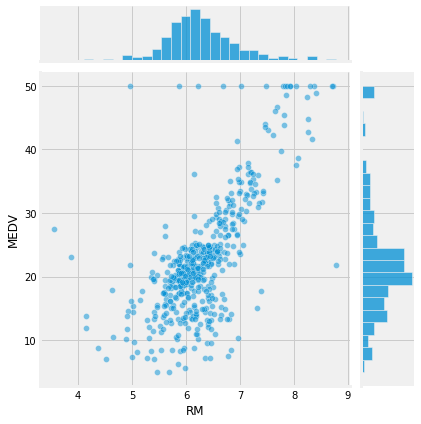

In [9]:
sns.jointplot(data["RM"], data["MEDV"], kind="scatter", joint_kws={"alpha":0.5});

Из диаграммы рассеяния хорошо видно, что имеет место положительная линейная связь между переменными `RM` и `MEDV`, то есть дома с большим числом комнат имеют более высокую цену.

In [10]:
data[["RM", "MEDV"]].describe()

,RM,MEDV
count,506.000000,506.000000
mean,6.284634,22.532806
std,0.702617,9.197104
min,3.561000,5.000000
25%,5.885500,17.025000
50%,6.208500,21.200000
75%,6.623500,25.000000
max,8.780000,50.000000


Также можем сделать следующие предположения:

- 16 наблюдений `MEDV` имеют значение 50.0. Скорее всего эти наблюдения содержали пропуски или не было возможности указать действительную цену дома, поэтому эти наблюдения могут быть исключены из набора данных.
- одно наблюдение признака `RM` имеет значение 8.78. Это наблюдение может рассматриваться как выброс и может быть исключено из набора данных;
- два наблюдения признака `RM` имеют значения меньше 4. Наблюдения можно рассматривать как выбросы и должны быть исключены из набора данных.

Итак, модель которую мы будем строить имеет следующий вид:

$$MEDV = \theta_0 + \theta_1 \times RM$$

Нам необходимо найти оптимальные значения для параметров $\theta$.

### Метод градиентного спуска

Метод градиентного спуска это простой метод для поиска локального минимума функции. Подбор параметров $\theta$ происходит в соответствии со следующим правилом:

$$\theta := \theta - \alpha \frac{\partial}{\partial \theta}J(\theta)$$

Где $J(\theta)$ называется целевой функцией (cost function), а $\alpha$ скоростью обучения (learning rate). Целевая функция вычисляется по следующей формуле:

$$J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x_i) - y_i)^2 \rightarrow \frac{\partial}{\partial \theta}J(\theta) = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x_i)-y_i)x_i$$

В результате подстановки получим следующее правило для пересчета параметров $\theta$:

> Замечание: Более подробно про метод градиентного спуска можно почитать [тут](http://mccormickml.com/2014/03/04/gradient-descent-derivation/")

$$\theta := \theta - \alpha\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x_i)-y_i)x_i$$

Рассмотрим работу этого метода на простом примере:

In [11]:
def f(x):
    return x**3 - 2*x**2 + 2

In [12]:
def f_prime(x):
    return 3*x**2 - 4*x

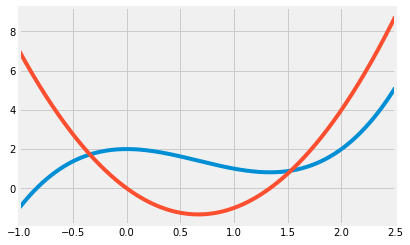

In [13]:
x = np.linspace(-1, 2.5, 1000)
plt.plot(x, f(x))
plt.plot(x, f_prime(x))
plt.xlim([-1, 2.5])
plt.show()

In [14]:
x_old = 0
x_new = 1.5 # Попробуйте различные не нулевые значения для нашего алгоритма
lr = 0.1    # Скорость обучения
precision = 0.001

x_history, y_history = [x_new], [f(x_new)]

while abs(x_new - x_old) > precision:
    x_old = x_new
    grad = f_prime(x_old)     # <code>
    x_new = x_old - lr * grad # <code>
    x_history.append(x_new)
    y_history.append(f(x_new))
print(f"Предполагаемый минимум {x_new}")

Предполагаемый минимум 1.3347129486629457


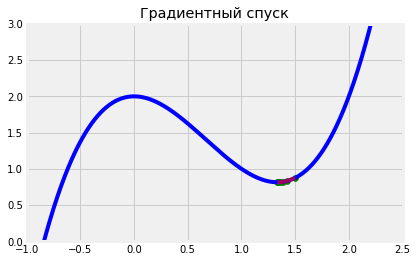

In [15]:
plt.plot(x, f(x), c="b")
plt.plot(x_history, y_history,c="r", alpha=0.6)
plt.scatter(x_history, y_history,c="g")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Градиентный спуск")
plt.show()

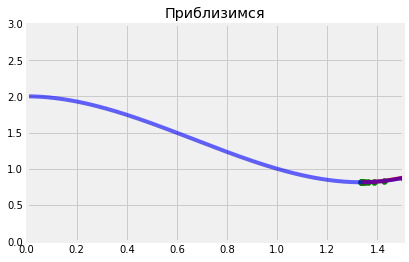

In [16]:
plt.scatter(x_history,y_history,c="g")
plt.plot(x_history, y_history,c="r")
plt.plot(x,f(x), c="b", alpha=0.6)
plt.xlim([0,1.5])
plt.ylim([0,3])
plt.title("Приблизимся")
plt.show()

### Batch Gradient Descent

Ваша задача реализовать метод градиентного спуска со следующим интерфейсом:

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

In [18]:
class GDRegressor:

    def __init__(self, alpha=0.01, n_iter=100, progress=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.disable = not progress

    def fit(self, X, y):
        self.coef_ = []
        attributes = [X.values]
        theta = [[]]
        self.loss_history = []
        for i in range(len(attributes)):
            self.coef_.append(0)
            theta.append([])
        self.intercept_ = 0
        for i in range(self.n_iter):
            error = 0
            error_coef = 0
            for k in range(len(attributes)):
                n = len(attributes[k])
                for j in range(n):
                    y_predicted = self.coef_[k] * attributes[k][j] + self.intercept_
                    error +=  (y.values[j] - y_predicted)
                    error_coef += (y.values[j] - y_predicted) * attributes[k][j]
                self.d_coef = - (1 / n) * error_coef
                self.coef_[k] = self.coef_[k] - self.alpha * self.d_coef
                theta[k+1].extend(self.coef_)
            self.d_intercept = - (1 / n) * error
            self.intercept_ = self.intercept_ - self.alpha * self.d_intercept
            theta[0].extend(self.intercept_)
            self.loss_history.extend(error)
        self.theta_history = pd.DataFrame({'0':theta[0]})
        for i in range(len(attributes)):
            self.theta_history[1] = theta[i + 1]
        return self.coef_, self.intercept_
            

    def predict(self, X_test):
        attributes = [X_test.values]
        self.y_predict = []
        for i in range(len(attributes[0])):
            y_curr = 0
            for j in range(len(attributes)):
                y_curr += attributes[j][i] * self.coef_[j] 
            self.y_predict.extend(y_curr + self.intercept_)
        return self.y_predict

Метод `fit` обучает модель на данных `X_train` (матрица признаков) и `y_train` (вектор ответов). Результатом работы этого метода являются два атрибута: `coef_` - вектор оценок для $\theta_i$ ($i$ принимает значения от 1 до `p`, где `p` - это количество признаков) и `intercept_` - оцененное значение для $\theta_0$.

Метод `predict` возвращает вектор прогнозов для новых данных.

Давайте рассмотрим пример использования класса `GDRegressor`. Предварительно разобьем выборку на обучающую и тестовую и обучим модель на обучающей выборке, положив значения для параметров `max_iter=2000` и `alpha=0.04`.

In [19]:
X = data[["RM"]]
y = data["MEDV"]

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.04, n_iter=2000)
%time model.fit(X_train, Y_train)

CPU times: user 7.36 s, sys: 19.2 ms, total: 7.38 s
Wall time: 7.41 s


([array([7.07554766])], array([-21.7924473]))

In [21]:
# model.coef_, model.intercept_

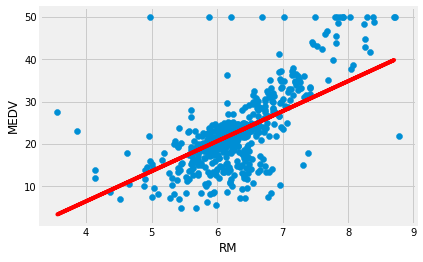

In [22]:
plt.scatter(data["RM"], data["MEDV"])
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.plot(X_train, model.coef_[0] * X_train + model.intercept_, "r");

In [23]:
def plot_coeffs(model):
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    plt.plot(list(range(model.n_iter)), model.theta_history.iloc[:, 0])
    plt.subplot(122)
    plt.plot(list(range(model.n_iter)), model.theta_history.iloc[:, 1]);

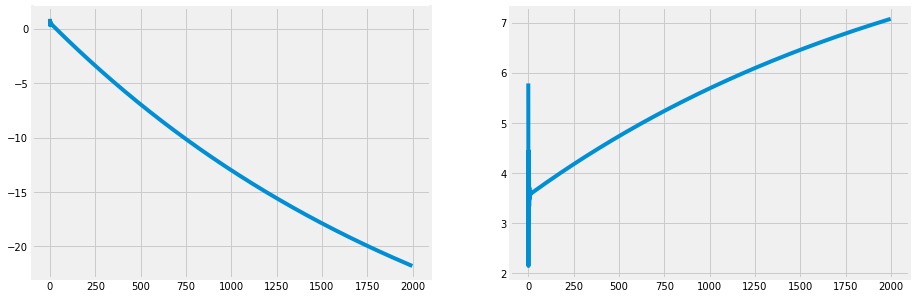

In [24]:
plot_coeffs(model)

In [25]:
def plot_loss_function(model):
    plt.xlabel("Iterations")
    plt.ylabel("Average square loss")
    plt.plot(np.arange(model.n_iter), model.loss_history);

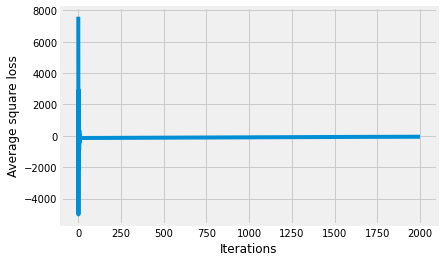

In [26]:
plot_loss_function(model)

Очевидно, что коэффициенты еще не приняли свои окончательные значения, попробуйте увеличить число итераций `n_iter`.

### Оценка качества модели

Итак, мы нашли коэффициенты $\theta$, теперь надо как-то оценить качество работы полученной модели. Для этого мы воспользуемся коэффициентом детерминации $R^2$:

$$R^2 = 1 - \frac{\sum_{i=1}^{m}(y_i - \hat{y_i})^2}{\sum_{i=1}^{m}(y_i - \overline{y})^2}$$

и среднеквадратичной ошибкой:

$$RMSE = \sqrt{\frac{\sum_{i=1}^{m}(\hat{y_i} - y_i)^2}{m}}$$

[Коэффициент детерминации](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8) это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью. Более точно — это единица минус доля необъяснённой дисперсии (дисперсии случайной ошибки модели, или условной по признакам дисперсии зависимой переменной) в дисперсии зависимой переменной.

Среднеквадратичная ошибка характеризует отклонение реальных данных от линии регрессии и измеряется в тех же единицах, что и зависимая переменная ($y$).

Вашей задачей является написать две функции для вычисления коэфиициента детерминации и среднеквадратичной ошибки:

In [27]:
def rmse(y_hat, y):
    y = y.values.tolist()
    m = len(y)
    sum = 0
    for i in range(m):
        sum += ((y_hat[i] - y[i]) ** 2 / m)
    error = np.sqrt(sum)
    return error

In [28]:
def r_squared(y_hat, y):
    y = y.values.tolist()
    summ1 = 0
    summ2 = 0
    m = len(y)
    y_avg = np.mean(y)

    for i in range(m):
        summ1 += (y[i] - y_hat[i]) ** 2
        summ2 += (y[i] - y_avg) ** 2
    error = 1 - summ1/summ2
    return error

In [29]:
Y_pred = model.predict(X_test)

In [30]:
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(6.500256917031144, 0.48822629468823364)

Проведем небольшой анализ регрессионных остатков:

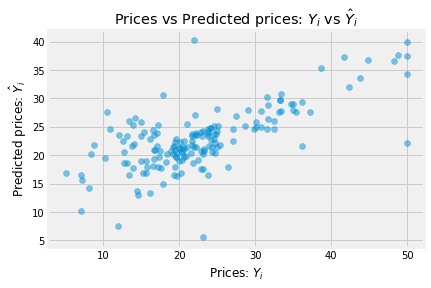

In [31]:
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

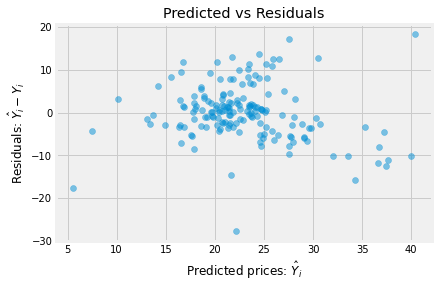

In [32]:
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
plt.scatter(Y_pred, (Y_pred-Y_test), alpha=0.5);

Можем ли мы улучшить качество нашей модели? Мы выбрали значения для параметров `max_iter` и `alpha` «случайным» образом. Найдите оптимальные значения для числа итераций `max_iter` и параметра `alpha`. В итоге вы должны получить значение для среднеквадратичной ошибки $6.45$, а для коэффициента детерминации $0.49$.

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.03, n_iter=3400)
%time model.fit(X_train, Y_train)

CPU times: user 12.4 s, sys: 25.3 ms, total: 12.4 s
Wall time: 12.5 s


([array([7.61931575])], array([-25.23927608]))

In [34]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(6.452867767654998, 0.4956611134014113)

В начале мы сделали несколько предположений о выбросах, давайте проверим одно из них. Удалите из набора данных наблюдения, значения которых для признака `MEDV` равны 50. Снова определите число итераций и скорость обучения. Также ответье на вопрос «Улучшилось ли качество модели?».

In [35]:
X_filtered = data[(data["MEDV"] < 50)][["RM"]]
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y_filtered, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.04, n_iter=750)
%time model.fit(X_train, Y_train)

CPU times: user 2.64 s, sys: 14.7 ms, total: 2.66 s
Wall time: 2.66 s


([array([4.48316652])], array([-6.39039024]))

In [37]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(6.445665852681736, 0.41815387939939064)

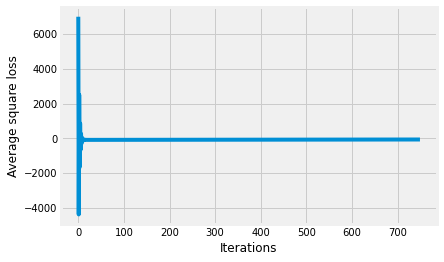

In [38]:
plot_loss_function(model)

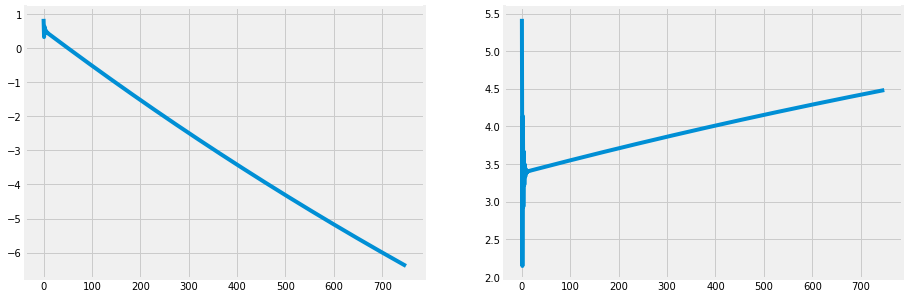

In [39]:
plot_coeffs(model)

### Нормализация

Вы должны были обратить внимание, что увеличилось необходимое число итераций для сходимости алгоритма. Одним из способов повлиять на это является нормализация признаков. Мы будем использовать один из самых простых и распространенных способов нормализации - Standart Scaling (Z-score normalization):

$$x' = \frac{x - \overline{x}}{\sigma_x}$$

> Замечание: Про важность нормализации признаков можно почитать [тут](https://www.robertoreif.com/blog/2017/12/16/importance-of-feature-scaling-in-data-modeling-part-1-h8nla) и [тут](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#z-score-standardization-or-min-max-scaling).

Напишите функцию `z_scaler` для нормализации значений:

Еще одним из распространенных методов нормализации является min-max нормализация:

$$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$$

In [40]:
def z_scaler(feature):
    sum_sd = 0
    mean_sd = sum(feature.values) / len(feature.values)
    scaled = []
    for i in range(len(feature.values)):
        sum_sd += (feature.values[i] - mean_sd)**2
    sd = sqrt(sum_sd / (len(feature.values) - 1))
    for i in range(len(feature.values)):
        scaled.append((feature.values[i] - mean_sd) / sd)
    return pd.DataFrame(scaled)

In [41]:
def min_max(feature):
    min_ = min(feature.values)
    max_ = max(feature.values)
    scaled = []
    for i in range(len(feature.values)):
        scaled.append((feature.values[i] - min_) / (max_ - min_))
    return pd.DataFrame(scaled)

In [42]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.04, n_iter=300)
model.fit(X_train, Y_train)

([array([0.63606258])], array([-0.0200523]))

In [44]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(array([0.71766984]), array([0.55377627]))

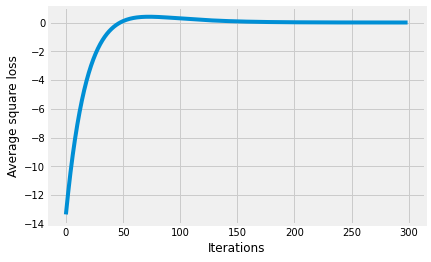

In [45]:
plt.xlabel("Iterations")
plt.ylabel("Average square loss")
plt.plot(np.arange(model.n_iter), model.loss_history);

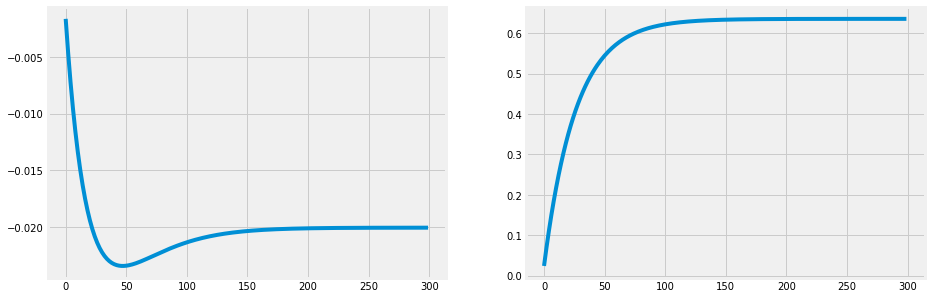

In [46]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(list(range(model.n_iter)), model.theta_history.iloc[:, 0])
plt.subplot(122)
plt.plot(list(range(model.n_iter)), model.theta_history.iloc[:, 1]);

### Пример с использованием библиотеки sklearn

Проделаем теже шаги с использованием библиотеки `sklearn`. Для начала построим модель:

In [47]:
from sklearn.linear_model import SGDRegressor

max_iter = 100
eta0 = 0.0001
model = SGDRegressor(
    loss='squared_loss',
    learning_rate='constant',
    max_iter=max_iter,
    eta0=eta0
)

Чтобы нормализовать значения для обучения и валидации модели воспользуйтесь `StandardScaler` из библиотеки `sklearn`:

In [48]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [49]:
model.fit(X_train, Y_train.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0001, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=100,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [50]:
Y_pred = model.predict(X_test)

Чтобы найти среднеквадратичную ошибку и коэффициент детерминации:

In [51]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

r2_score(Y_test, Y_pred), mean_squared_error(Y_test, Y_pred)

(0.4962735315731829, 0.4876767138376009)

In [52]:
model.coef_, model.intercept_

(array([0.55179578]), array([5.32870728e-05]))

In [53]:
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.4876767138376009, 0.4962735315731829)

Подберите число итераций и скорость обучения. В результате вы должны получить следующие значения:
 - коэффициенты модели - $\theta_0 = 8.65898517e-05, \theta_1 = 0.55$;
 - коэффициент детерминации - $0.48$;
 - среднеквадратичная ошибка - $0.49$.

### Задания

- Реализейте gradient check.
- Реализуйте mini-batch gradient descent (если размер батча равен 1, то мы получим stochastic gradient descent)
- Прочитайте статью https://www.dataquest.io/blog/learning-curves-machine-learning/. Постройте кривые обучения.
- Какой метод нормализации дает лучший результат?

Реализуйте gradient check.


In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.03, n_iter=3500)
%time model.fit(X_train, Y_train)

CPU times: user 12.7 s, sys: 20.3 ms, total: 12.7 s
Wall time: 12.7 s


([array([7.68398355])], array([-25.64919132]))

In [55]:
Y_prediction = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_prediction, Y_test)

(24.354734984930634, 0.49625901778904724)

In [56]:
def gradient_check(X, coef, eps = 1e-7):
    grad_approx = []
    grad = []
    theta_pos = coef[0] + eps
    theta_neg = coef[0] - eps
    grad_approx = (X[0] * theta_pos - X[0] * theta_neg) / (2 * eps)
    grad = X[0]
    quot = np.linalg.norm(grad_approx - grad) / (np.linalg.norm(grad) + np.linalg.norm(grad_approx))
    if quot > eps:
        print('Bad quality')
    else:
        print('Good quality')
    return quot

In [57]:
gradient_check(X_test.values, model.coef_)

Good quality


2.743236031574463e-09

Реализуйте mini-batch gradient descent (если размер батча равен 1, то мы получим stochastic gradient descent)

In [58]:
class MiniBatch:

    def __init__(self, batch_size, alpha=0.01, n_iter=100, progress=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.disable = not progress

    def fit(self, X, y):
        self.coef_ = []
        self.loss_history = []
        self.intercept_ = 0
        theta = [[]]
        for i in range(len(X.values[0])):
            self.coef_.append(0)
            theta.append([])
        n_batches = int(len(X.values) / self.batch_size)
        for i in range(self.n_iter):
            error = 0
            error_coef = 0
            for l in range(n_batches):
                X_mini = X[l:l+self.batch_size]
                y_mini = y[l:l+self.batch_size]
                attributes = [X_mini.values]
                for k in range(len(attributes)):
                    n = len(attributes[k])
                    for j in range(n):
                        y_predicted = self.coef_[k] * attributes[k][j] + self.intercept_
                        error +=  (y_mini.values[j] - y_predicted)
                        error_coef += (y_mini.values[j] - y_predicted) * attributes[k][j]
                    self.d_coef = - (1 / n) * error_coef
                    self.coef_[k] = self.coef_[k] - self.alpha * self.d_coef
                    theta[k+1].extend(self.coef_)
                self.d_intercept = - (1 / n) * error
                self.intercept_ = self.intercept_ - self.alpha * self.d_intercept
                theta[0].extend(self.intercept_)
                self.loss_history.extend(error)
        self.theta_history = pd.DataFrame({'0':theta[0]})
        for i in range(len(X.values[0])):
            self.theta_history[1] = theta[i + 1]
        return self.coef_, self.intercept_
            

    def predict(self, X_test):
        attributes = [X_test.values]
        self.y_predict = []
        for i in range(len(attributes[0])):
            y_curr = 0
            for j in range(len(attributes)):
                y_curr += attributes[j][i] * self.coef_[j] 
            self.y_predict.extend(y_curr + self.intercept_)
        return self.y_predict

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = MiniBatch(alpha=0.03, n_iter=3500, batch_size=300)
%time model.fit(X_train, Y_train)

CPU times: user 11.8 s, sys: 30.5 ms, total: 11.8 s
Wall time: 11.8 s


([array([7.74590751])], array([-25.92894225]))

In [60]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(6.447705529533022, 0.4964677240820713)

Прочитайте статью https://www.dataquest.io/blog/learning-curves-machine-learning/. Постройте кривые обучения.

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

def learning_curves(estimator, features, target, train_sizes, cv):
    
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, features, target, train_sizes = train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,115)

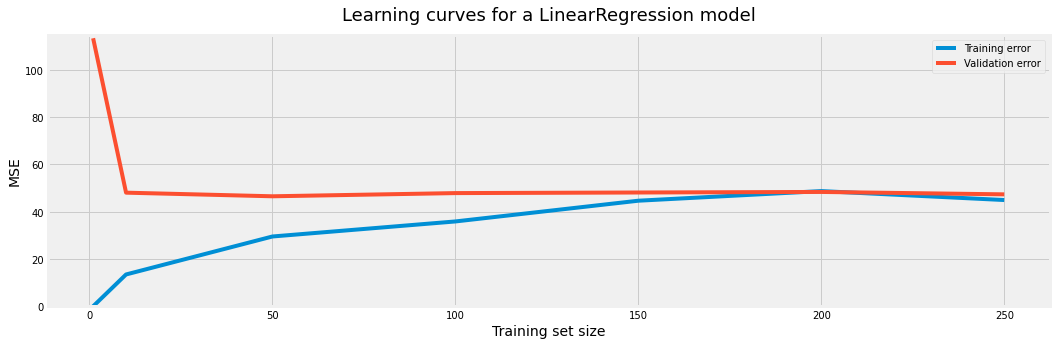

In [62]:
plt.figure(figsize = (16,5))
train_sizes = [1, 10, 50, 100, 150, 200, 250]
learning_curves(LinearRegression(), X_train, Y_train, train_sizes, 5)

Какой метод нормализации дает лучший результат?


In [63]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y_filtered, test_size=0.33, random_state=18)
model = MiniBatch(alpha=0.03, n_iter=1000, batch_size=300)
%time model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

CPU times: user 3.43 s, sys: 9.94 ms, total: 3.44 s
Wall time: 3.44 s


(6.469178311476016, 0.41390122798640383)

In [64]:
X_scaled = min_max(X_filtered)
y_scaled = min_max(y_filtered)

X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y_filtered, test_size=0.33, random_state=18)
model = MiniBatch(alpha=0.03, n_iter=1000, batch_size=300)
%time model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

CPU times: user 3.4 s, sys: 8.92 ms, total: 3.41 s
Wall time: 3.42 s


(6.469178311476016, 0.41390122798640383)

Оба метода нормализации дают одинаковые результаты.